In [1]:
import sys  
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
path_dir = r"/Users/../Volumes/Affiliations/"

In [2]:
import sys  
import pickle
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
import src.utils
from src.utils import import_dta, import_tracks_dta, successful_creators_followers,\
gen_active_relations, get_fan_interactions_per_week, calculate_avg_monthly_valence,\
gen_active_relations_prob, get_fan_interactions_per_week_prob, stripplot_prob,\
reaction_probability, follower_list, filter_quantile, sample_creators_music,\
gen_outbound_creators
import datetime
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats
pd.plotting.register_matplotlib_converters()
import os

import src.probability_utils
from src.probability_utils import volume_analysis, valence_analysis
import math
import matplotlib.ticker as plticker
from scipy.interpolate import make_interp_spline, BSpline
import seaborn as sns
from numpy import random
from tabulate import tabulate
from IPython.display import display
from tqdm import tqdm

In [3]:
def process_date(date):
    year = date[0:4]
    week = date[6:]
    day = "1"
    date = "{}-{}-1".format(year, week)
    dt = datetime.strptime(date, "%Y-%W-%w")
    return dt

In [4]:
path_dir = r"/Users/../Volumes/Raw/"
music_before = 30
low_success = 0.25
high_success = 0.75
rank_percentiles = False

In [5]:
#we will skip comments for now

#affiliations :follows
#favoritings :likes

tracks = import_tracks_dta(path_dir, "12sample_tracks.dta");
follows_sent = import_dta(path_dir, "12sample_affiliations_sent.dta");
comments_sent = import_dta(path_dir, "12sample_comments_made.dta");
shares_sent = import_dta(path_dir, "12sample_reposts_made.dta");
likes_sent = import_dta(path_dir, "12sample_favoritings_made.dta");
messages_sent = import_dta(path_dir, "12sample_messages_sent.dta");

user_info = import_dta(path_dir, "12sample_user_infos.dta");
user_info.columns = ['user_id', 'type', 'entered_platform']
user_info_2 = import_dta(path_dir, "12sample_1st_deg_user_infos.dta");
user_info_2.columns = ['user_id', 'type', 'entered_platform']
user_info = pd.concat([user_info, user_info_2]);
user_info.drop_duplicates(subset='user_id', keep='first', inplace=True, ignore_index=False);


########
follows_received = import_dta(path_dir, "12sample_affiliations_received.dta");
comments_received = import_dta(path_dir, "12sample_comments_received.dta");
shares_received = import_dta(path_dir, "12sample_reposts_received.dta");
likes_received = import_dta(path_dir, "12sample_favoritings_received.dta");
messages_received = import_dta(path_dir, "12sample_messages_received.dta");

########
follows = import_dta(path_dir, "12sample_affiliations.dta");
comments = import_dta(path_dir, "12sample_comments.dta");
shares = import_dta(path_dir, "12sample_reposts.dta");
likes = import_dta(path_dir, "12sample_favoritings.dta");
messages = import_dta(path_dir, "12sample_messages.dta");

tracks_first_month = sample_creators_music(tracks, music_before)
mask = tracks_first_month.track_available == 1
tracks_first_month = tracks_first_month[mask]

mask = follows_received.contact_id.isin(tracks_first_month.user_id)
follows_received_30 = follows_received[mask]
followers_per_creator_60 = successful_creators_followers(follows_received_30, 60, tracks_first_month)
followers_per_creator_60_static = successful_creators_followers(follows_received_30, 60, tracks_first_month, always_same_batches = True, 
                                                        perc1 = low_success, perc2 = high_success)

%%%%%%%%%% 12sample_tracks.dta %%%%%%%%%%
(56262, 7)
%%%%%%%%%% 12sample_affiliations_sent.dta %%%%%%%%%%
(800913, 3)
%%%%%%%%%% 12sample_comments_made.dta %%%%%%%%%%
(29258, 4)
%%%%%%%%%% 12sample_reposts_made.dta %%%%%%%%%%
(179329, 4)
%%%%%%%%%% 12sample_favoritings_made.dta %%%%%%%%%%
(527701, 4)
%%%%%%%%%% 12sample_messages_sent.dta %%%%%%%%%%
(11091, 3)
%%%%%%%%%% 12sample_user_infos.dta %%%%%%%%%%
(35000, 3)
%%%%%%%%%% 12sample_1st_deg_user_infos.dta %%%%%%%%%%
(670746, 3)
%%%%%%%%%% 12sample_affiliations_received.dta %%%%%%%%%%
(432503, 3)
%%%%%%%%%% 12sample_comments_received.dta %%%%%%%%%%
(21386, 4)
%%%%%%%%%% 12sample_reposts_received.dta %%%%%%%%%%
(83013, 4)
%%%%%%%%%% 12sample_favoritings_received.dta %%%%%%%%%%
(286903, 4)
%%%%%%%%%% 12sample_messages_received.dta %%%%%%%%%%
(17364, 3)
%%%%%%%%%% 12sample_affiliations.dta %%%%%%%%%%
(1233416, 3)
%%%%%%%%%% 12sample_comments.dta %%%%%%%%%%
(50644, 4)
%%%%%%%%%% 12sample_reposts.dta %%%%%%%%%%
(262342, 4)
%%%%%%%%%% 12sam

In [6]:
d = {}
for i in range(6):
   d[str(i)] = pd.read_pickle('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/{}.pkl'.format(i)) 
   d[str(i)]['created_at'] =  pd.to_datetime(d[str(i)]['created_at'])#.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [7]:
data = pd.concat([d['0'], d['1'], d['2'], d['3'], d['4'], d['5']])

In [8]:
#data['created_at'] = pd.to_datetime(data['created_at'])

In [9]:
data.set_index('created_at', inplace = True)

In [10]:
#outdegree = data.groupby('sender_id').agg(following=('contact_id', pd.Series.nunique))
#outdegree_info = user_info_2.merge(outdegree, left_on = 'user_id', right_on = 'sender_id', how= 'left')
#outdegree_info.loc[outdegree_info.following.isnull(), 'following'] = 0 

In [11]:
#outdegree_info['decile'] = pd.qcut(outdegree_info['following'], 10, labels=False)

In [12]:
#outdegree_info.head(10)

In [13]:
#outdegree_info['decile'].value_counts()

In [14]:
actions_sent = gen_outbound_creators(follows_sent, shares_sent, likes_sent, comments_sent, tracks,
                                     messages_sent = messages_sent, filter_creators = True)
mask = actions_sent.user_id.isin(tracks_first_month.user_id.unique())
actions_sent = actions_sent[mask]

In [15]:
#filter only outbound activities before the follow is received
print('Obtaining fanbase...')
follows_received.columns = ['fan_id', 'user_id', 'date_sent']
followers = follower_list(follows_received)
actions_sent = actions_sent.merge(followers, right_on = ['user_id', 'fan_id'],
                                      left_on = ['user_id', 'fan_id'], how = 'left')

Obtaining fanbase...


In [16]:
mask = (actions_sent.date_sent < actions_sent.follower_since) | (actions_sent.follower_since.isnull())
actions_sent_non_followers =  actions_sent[mask]
actions_sent_non_followers['week_yr_date'] = actions_sent_non_followers.week_yr.apply(lambda x: process_date(x))

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_89134/3898105865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_followers['week_yr_date'] = actions_sent_non_followers.week_yr.apply(lambda x: process_date(x))


# MAB

In [17]:
def create_trials_rewards(df):
    '''
    Creates reward counts, trial counts and keys to be used in the thompson sampling function
    '''
    Sent = df.groupby('outbound_activity', as_index = True).size().to_frame(name='sent')\
    .reset_index()
    Reward = df.groupby('outbound_activity', as_index = True)\
    .agg(b_Reward = ('reward', 'sum')).reset_index()


    keys  = Sent.outbound_activity

    return np.array(Sent.sent), np.array(Reward.b_Reward), keys

In [18]:
def update_1_step(Sent, Reward):
    
    alpha = Reward + 1 
    beta = (Sent-Reward)+1

    mean = alpha/(alpha+beta)
    variance = (alpha*beta)/((alpha+beta+1)*((alpha+beta)**2))

    return np.around(mean,3), np.around(np.sqrt(variance),3)

In [19]:
def jitter(a_series, noise_reduction=1000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

In [20]:
def create_deciles(data):
    
    mask = (data['size']>0)
    data.loc[~mask, 'decile'] = 0 
    cutpoints = np.percentile(data[mask]['size'], np.arange(1,100,10)) 
    
    for i in range(len(cutpoints)):
        low = cutpoints[i]
        try:
            high = cutpoints[i+1]
        except:
            high = 100000
        
        mask2 = (data[mask]['size']>=low) & (data[mask]['size'] <high) & (data['size']>0)
        data.loc[mask2,'decile'] = i + 1 
    return data

In [21]:
def real_time(df, outdegree_df, interval, rank_percentiles = rank_percentiles):
    
    d = {}
    
    for user_id in df.user_id.unique():
        
        if rank_percentiles:
        
            experiment = {
             '1':{'Sent':0,'Reward':0}, 
             '2':{'Sent':0,'Reward':0},
             '3':{'Sent':0,'Reward':0},
             '4':{'Sent':0,'Reward':0},
             '5':{'Sent':0,'Reward':0}, 
             '6':{'Sent':0,'Reward':0},
             '7':{'Sent':0,'Reward':0},
             '8':{'Sent':0,'Reward':0},
             '9':{'Sent':0,'Reward':0},
             '10':{'Sent':0,'Reward':0}}
        else:
            
            experiment = {'0':{'Sent':0,'Reward':0},
             '1':{'Sent':0,'Reward':0}, 
             '2':{'Sent':0,'Reward':0},
             '3':{'Sent':0,'Reward':0},
             '4':{'Sent':0,'Reward':0},
             '5':{'Sent':0,'Reward':0}, 
             '6':{'Sent':0,'Reward':0},
             '7':{'Sent':0,'Reward':0},
             '8':{'Sent':0,'Reward':0},
             '9':{'Sent':0,'Reward':0},
             '10':{'Sent':0,'Reward':0}}
            
        if rank_percentiles:
        
            dataset_mean = pd.DataFrame({'trials':range(1,df.loc[df['user_id'] == user_id,:].shape[0]+1),                     
              '1': 0,
              '2': 0,
              '3': 0,
              '4': 0,
              '5': 0,
              '6': 0,
              '7': 0,
              '8': 0,
              '9': 0,
              '10': 0})
        
        else:
             
            dataset_mean = pd.DataFrame({'trials':range(1,df.loc[df['user_id'] == user_id,:].shape[0]+1),                      
              '0': 0,
              '1': 0,
              '2': 0,
              '3': 0,
              '4': 0,
              '5': 0,
              '6': 0,
              '7': 0,
              '8': 0,
              '9': 0,
              '10': 0}) 
            
        if rank_percentiles:    
    
            dataset_std = pd.DataFrame({'trials':range(1,df.loc[df['user_id'] == user_id,:].shape[0]+1),                       
              '1': 0,
              '2': 0,
              '3': 0,
              '4': 0,
              '5': 0,
              '6': 0,
              '7': 0,
              '8': 0,
              '9': 0,
              '10': 0}) 
        
        else:
            dataset_std = pd.DataFrame({'trials':range(1,df.loc[df['user_id'] == user_id,:].shape[0]+1),     
              '0': 0,
              '1': 0,
              '2': 0,
              '3': 0,
              '4': 0,
              '5': 0,
              '6': 0,
              '7': 0,
              '8': 0,
              '9': 0,
              '10': 0}) 
    
        d[user_id] = {'experiment': experiment,'dataset_std': dataset_std, 'dataset_mean': dataset_mean, 'j' : 0}
        

    date_l = min(df.date_sent)
    old_outdegree = outdegree_df.iloc[:
                  outdegree_df.index.values.searchsorted(np.datetime64(date_l))].groupby('sender_id', as_index = False).size()
    old_outdegree = user_info_2.merge(old_outdegree, left_on = 'user_id', right_on = 'sender_id', how= 'left')
    old_outdegree.loc[old_outdegree['size'].isnull(), 'size'] = 0
    old_outdegree = old_outdegree[['user_id', 'size', 'entered_platform']].set_index('user_id')
    mask = old_outdegree['entered_platform'] <= date_l
    if rank_percentiles:
        old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'].rank(method='first'), 10, labels=False, duplicates='drop') + 1
    else:
        old_outdegree.loc[mask, 'decile'] = create_deciles(old_outdegree.loc[mask])
    
    old_outdegree['decile'] = old_outdegree[['decile']]  
    
    for i in tqdm(range(df.shape[0])):
        
        user_id = df.iloc[i].user_id
        fan_id = df.iloc[i].fan_id
        j = d[user_id]['j']
        d[user_id]['j'] = j + 1
        
        if i%interval == 0:
            date_h = df.iloc[i,:]['date_sent']
            new_outdegree = outdegree_df.iloc[outdegree_df.index.values.searchsorted(np.datetime64(date_l)):
                  outdegree_df.index.values.searchsorted(np.datetime64(date_h))].groupby('sender_id', as_index = False).size()
        
            old_outdegree['size'] = old_outdegree['size'].add(new_outdegree.set_index('sender_id')['size'], fill_value = 0)
            mask = old_outdegree['entered_platform'] <= date_h
            if rank_percentiles:
                old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'].rank(method='first'), 10, labels=False, duplicates='drop') + 1
            else:
                old_outdegree.loc[mask, 'decile'] = create_deciles(old_outdegree.loc[mask])
            old_outdegree['decile'] = old_outdegree[['decile']]  
            date_l = date_h
            
        if i%1000 == 0:
            print(old_outdegree.decile.value_counts(normalize=True))
        
        try:
       
            d[user_id]['experiment'][str(int(old_outdegree.loc[fan_id]['decile']))]['Sent'] += 1
            d[user_id]['experiment'][str(int(old_outdegree.loc[fan_id]['decile']))]['Reward'] += df.iloc[i, -1]
            Sent = np.array([a[1]['Sent'] for a in d[user_id]['experiment'].items()])
            Reward = np.array([a[1]['Reward'] for a in d[user_id]['experiment'].items()])

            mean, std = update_1_step(Sent, Reward)

            d[user_id]['dataset_mean'].loc[j, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']] = np.transpose(mean)
            d[user_id]['dataset_std'].loc[j, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']] = np.transpose(std)

            print('.', end='')
        
        except:
            print('x', end ='')
        
    for user_id in df.user_id.unique(): 
        d[user_id]['dataset_mean'] = pd.concat([d[user_id]['dataset_mean'], df.loc[df['user_id'] == user_id].reset_index()['date_sent']], axis = 1)
        
        
    return d

# Real time updating

In [22]:
actions_sent = gen_outbound_creators(follows_sent, shares_sent, likes_sent, comments_sent, tracks,
                                     messages_sent = messages_sent, filter_creators = False)

In [23]:
mask = actions_sent.user_id.isin(tracks_first_month.user_id) 
actions_sent = actions_sent[mask]
actions_sent_filtered = actions_sent.merge(followers_per_creator_60_static, left_on = 'user_id', right_on = 'user_id', how = "inner")

In [24]:
#filter only outbound activities before the follow is received
print('Obtaining fanbase...')
follows_received.columns = ['fan_id', 'user_id', 'date_sent']
followers = follower_list(follows_received)
actions_sent_filtered = actions_sent_filtered.merge(followers, right_on = ['user_id', 'fan_id'],
                                      left_on = ['user_id', 'fan_id'], how = 'left')

mask = (actions_sent_filtered.date_sent < actions_sent_filtered.follower_since) | (actions_sent_filtered.follower_since.isnull())
actions_sent_filtered_non_followers =  actions_sent_filtered[mask]
actions_sent_filtered_non_followers['week_yr_date'] = actions_sent_filtered_non_followers.week_yr.apply(lambda x: process_date(x))

Obtaining fanbase...


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_89134/1142436393.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_filtered_non_followers['week_yr_date'] = actions_sent_filtered_non_followers.week_yr.apply(lambda x: process_date(x))


In [25]:
mask = actions_sent_filtered_non_followers['fan_id'].isin(data.sender_id.unique())
actions_sent_filtered_non_followers = actions_sent_filtered_non_followers.loc[mask]

In [26]:
import datetime
# Target Creation
delta = datetime.timedelta(days = 1)
mask = (actions_sent_filtered_non_followers['follower_since'] <= (actions_sent_filtered_non_followers['date_sent'] + delta))

actions_sent_filtered_non_followers.loc[mask, 'reward'] = 1
mask = actions_sent_filtered_non_followers['reward'].isnull()
actions_sent_filtered_non_followers.loc[mask, 'reward'] = 0

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_89134/1365517025.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_filtered_non_followers.loc[mask, 'reward'] = 1


In [27]:
actions_sent_filtered_non_followers.sort_values(by = 'date_sent', inplace = True)


#filter first 2 months
delta = datetime.timedelta(days = 30)

mask = actions_sent_filtered_non_followers.date_sent < (min(actions_sent_filtered_non_followers['date_sent']) + delta)
                                          
actions_sent_filtered_non_followers = actions_sent_filtered_non_followers[mask]    

mask = actions_sent_filtered_non_followers.high_low == 'high'
successful_df = actions_sent_filtered_non_followers[mask]

mask = actions_sent_filtered_non_followers.high_low == 'low'
unsuccessful_df = actions_sent_filtered_non_followers[mask]

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_89134/376480209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_filtered_non_followers.sort_values(by = 'date_sent', inplace = True)


In [28]:
dict_successful_df =  real_time(successful_df, data, 10)
with open('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/dict_sucessful_df.pkl', 'wb') as handle:
    pickle.dump(dict_successful_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_89134/3450947467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[~mask, 'decile'] = 0
  0%|                                                                                                                                  | 1/27034 [00:02<16:03:30,  2.14s/it]

0.0     0.336336
1.0     0.070811
5.0     0.070725
6.0     0.067605
8.0     0.067551
2.0     0.066736
9.0     0.066712
7.0     0.066563
4.0     0.066127
3.0     0.060964
10.0    0.059872
Name: decile, dtype: float64
..........

  0%|                                                                                                                                  | 11/27034 [00:04<2:27:42,  3.05it/s]

..........

  0%|                                                                                                                                  | 21/27034 [00:06<1:57:05,  3.84it/s]

..........

  0%|▏                                                                                                                                 | 31/27034 [00:08<1:42:41,  4.38it/s]

..........

  0%|▏                                                                                                                                 | 41/27034 [00:10<1:37:51,  4.60it/s]

..........

  0%|▏                                                                                                                                 | 51/27034 [00:12<1:34:17,  4.77it/s]

..........

  0%|▎                                                                                                                                 | 61/27034 [00:13<1:31:14,  4.93it/s]

..........

  0%|▎                                                                                                                                 | 71/27034 [00:16<1:32:38,  4.85it/s]

..........

  0%|▍                                                                                                                                 | 81/27034 [00:18<1:30:47,  4.95it/s]

..........

  0%|▍                                                                                                                                 | 91/27034 [00:20<1:31:20,  4.92it/s]

..........

  0%|▍                                                                                                                                | 101/27034 [00:22<1:29:52,  4.99it/s]

..........

  0%|▌                                                                                                                                | 111/27034 [00:23<1:27:26,  5.13it/s]

..........

  0%|▌                                                                                                                                | 121/27034 [00:25<1:25:13,  5.26it/s]

..........

  0%|▋                                                                                                                                | 131/27034 [00:27<1:22:53,  5.41it/s]

..........

  1%|▋                                                                                                                                | 141/27034 [00:29<1:21:16,  5.52it/s]

..........

  1%|▋                                                                                                                                | 151/27034 [00:30<1:20:16,  5.58it/s]

..........

  1%|▊                                                                                                                                | 161/27034 [00:32<1:19:32,  5.63it/s]

..........

  1%|▊                                                                                                                                | 171/27034 [00:34<1:20:27,  5.56it/s]

..........

  1%|▊                                                                                                                                | 181/27034 [00:36<1:22:13,  5.44it/s]

..........

  1%|▉                                                                                                                                | 191/27034 [00:38<1:20:49,  5.54it/s]

..........

  1%|▉                                                                                                                                | 201/27034 [00:39<1:20:02,  5.59it/s]

..........

  1%|█                                                                                                                                | 211/27034 [00:41<1:19:17,  5.64it/s]

..........

  1%|█                                                                                                                                | 221/27034 [00:43<1:20:03,  5.58it/s]

..........

  1%|█                                                                                                                                | 231/27034 [00:45<1:19:06,  5.65it/s]

..........

  1%|█▏                                                                                                                               | 241/27034 [00:46<1:18:31,  5.69it/s]

..........

  1%|█▏                                                                                                                               | 251/27034 [00:48<1:18:06,  5.71it/s]

..........

  1%|█▏                                                                                                                               | 261/27034 [00:50<1:17:52,  5.73it/s]

..........

  1%|█▎                                                                                                                               | 271/27034 [00:52<1:17:32,  5.75it/s]

..........

  1%|█▎                                                                                                                               | 281/27034 [00:53<1:18:44,  5.66it/s]

..........

  1%|█▍                                                                                                                               | 291/27034 [00:55<1:19:27,  5.61it/s]

..........

  1%|█▍                                                                                                                               | 301/27034 [00:57<1:18:37,  5.67it/s]

..........

  1%|█▍                                                                                                                               | 311/27034 [00:59<1:18:03,  5.71it/s]

..........

  1%|█▌                                                                                                                               | 321/27034 [01:00<1:17:44,  5.73it/s]

..........

  1%|█▌                                                                                                                               | 331/27034 [01:02<1:17:26,  5.75it/s]

..........

  1%|█▋                                                                                                                               | 341/27034 [01:04<1:17:12,  5.76it/s]

..........

  1%|█▋                                                                                                                               | 351/27034 [01:06<1:18:09,  5.69it/s]

..........

  1%|█▋                                                                                                                               | 361/27034 [01:07<1:19:00,  5.63it/s]

..........

  1%|█▊                                                                                                                               | 371/27034 [01:09<1:19:31,  5.59it/s]

..........

  1%|█▊                                                                                                                               | 381/27034 [01:11<1:19:43,  5.57it/s]

..........

  1%|█▊                                                                                                                               | 391/27034 [01:13<1:18:42,  5.64it/s]

..........

  1%|█▉                                                                                                                               | 401/27034 [01:15<1:19:18,  5.60it/s]

..........

  2%|█▉                                                                                                                               | 411/27034 [01:16<1:18:23,  5.66it/s]

..........

  2%|██                                                                                                                               | 421/27034 [01:18<1:19:01,  5.61it/s]

..........

  2%|██                                                                                                                               | 431/27034 [01:20<1:18:07,  5.68it/s]

..........

  2%|██                                                                                                                               | 441/27034 [01:22<1:17:41,  5.70it/s]

..........

  2%|██▏                                                                                                                              | 451/27034 [01:23<1:17:18,  5.73it/s]

..........

  2%|██▏                                                                                                                              | 461/27034 [01:25<1:16:55,  5.76it/s]

..........

  2%|██▏                                                                                                                              | 471/27034 [01:27<1:17:57,  5.68it/s]

..........

  2%|██▎                                                                                                                              | 481/27034 [01:29<1:17:22,  5.72it/s]

..........

  2%|██▎                                                                                                                              | 491/27034 [01:30<1:17:02,  5.74it/s]

..........

  2%|██▍                                                                                                                              | 501/27034 [01:32<1:18:06,  5.66it/s]

..........

  2%|██▍                                                                                                                              | 511/27034 [01:34<1:17:27,  5.71it/s]

..........

  2%|██▍                                                                                                                              | 521/27034 [01:36<1:18:12,  5.65it/s]

..........

  2%|██▌                                                                                                                              | 531/27034 [01:37<1:17:58,  5.66it/s]

..........

  2%|██▌                                                                                                                              | 541/27034 [01:39<1:18:48,  5.60it/s]

..........

  2%|██▋                                                                                                                              | 551/27034 [01:41<1:17:56,  5.66it/s]

..........

  2%|██▋                                                                                                                              | 561/27034 [01:43<1:18:53,  5.59it/s]

..........

  2%|██▋                                                                                                                              | 571/27034 [01:45<1:19:31,  5.55it/s]

..........

  2%|██▊                                                                                                                              | 581/27034 [01:47<1:19:37,  5.54it/s]

..........

  2%|██▊                                                                                                                              | 591/27034 [01:48<1:18:29,  5.61it/s]

..........

  2%|██▊                                                                                                                              | 601/27034 [01:50<1:17:39,  5.67it/s]

..........

  2%|██▉                                                                                                                              | 611/27034 [01:52<1:17:02,  5.72it/s]

..........

  2%|██▉                                                                                                                              | 621/27034 [01:53<1:16:36,  5.75it/s]

..........

  2%|███                                                                                                                              | 631/27034 [01:55<1:17:27,  5.68it/s]

..........

  2%|███                                                                                                                              | 641/27034 [01:57<1:18:07,  5.63it/s]

..........

  2%|███                                                                                                                              | 651/27034 [01:59<1:17:23,  5.68it/s]

..........

  2%|███▏                                                                                                                             | 661/27034 [02:00<1:16:47,  5.72it/s]

..........

  2%|███▏                                                                                                                             | 671/27034 [02:02<1:16:41,  5.73it/s]

..........

  3%|███▏                                                                                                                             | 681/27034 [02:04<1:16:23,  5.75it/s]

..........

  3%|███▎                                                                                                                             | 691/27034 [02:06<1:16:03,  5.77it/s]

..........

  3%|███▎                                                                                                                             | 701/27034 [02:07<1:15:49,  5.79it/s]

..........

  3%|███▍                                                                                                                             | 711/27034 [02:09<1:15:39,  5.80it/s]

..........

  3%|███▍                                                                                                                             | 721/27034 [02:11<1:16:38,  5.72it/s]

..........

  3%|███▍                                                                                                                             | 731/27034 [02:13<1:16:08,  5.76it/s]

..........

  3%|███▌                                                                                                                             | 741/27034 [02:14<1:15:50,  5.78it/s]

..........

  3%|███▌                                                                                                                             | 751/27034 [02:16<1:15:35,  5.80it/s]

..........

  3%|███▋                                                                                                                             | 761/27034 [02:18<1:15:24,  5.81it/s]

..........

  3%|███▋                                                                                                                             | 771/27034 [02:19<1:15:19,  5.81it/s]

..........

  3%|███▋                                                                                                                             | 781/27034 [02:21<1:15:12,  5.82it/s]

..........

  3%|███▊                                                                                                                             | 791/27034 [02:23<1:15:11,  5.82it/s]

..........

  3%|███▊                                                                                                                             | 801/27034 [02:25<1:15:11,  5.81it/s]

..........

  3%|███▊                                                                                                                             | 811/27034 [02:26<1:15:12,  5.81it/s]

..........

  3%|███▉                                                                                                                             | 821/27034 [02:28<1:15:10,  5.81it/s]

..........

  3%|███▉                                                                                                                             | 831/27034 [02:30<1:16:21,  5.72it/s]

..........

  3%|████                                                                                                                             | 841/27034 [02:32<1:16:58,  5.67it/s]

..........

  3%|████                                                                                                                             | 851/27034 [02:33<1:16:27,  5.71it/s]

..........

  3%|████                                                                                                                             | 861/27034 [02:35<1:17:30,  5.63it/s]

..........

  3%|████▏                                                                                                                            | 871/27034 [02:37<1:17:56,  5.59it/s]

..........

  3%|████▏                                                                                                                            | 881/27034 [02:39<1:17:03,  5.66it/s]

..........

  3%|████▎                                                                                                                            | 891/27034 [02:40<1:16:32,  5.69it/s]

..........

  3%|████▎                                                                                                                            | 901/27034 [02:42<1:16:00,  5.73it/s]

..........

  3%|████▎                                                                                                                            | 911/27034 [02:44<1:15:38,  5.76it/s]

..........

  3%|████▍                                                                                                                            | 921/27034 [02:46<1:15:22,  5.77it/s]

..........

  3%|████▍                                                                                                                            | 931/27034 [02:47<1:16:26,  5.69it/s]

..........

  3%|████▍                                                                                                                            | 941/27034 [02:49<1:17:07,  5.64it/s]

..........

  4%|████▌                                                                                                                            | 951/27034 [02:51<1:17:36,  5.60it/s]

..........

  4%|████▌                                                                                                                            | 961/27034 [02:53<1:17:51,  5.58it/s]

..........

  4%|████▋                                                                                                                            | 971/27034 [02:55<1:18:07,  5.56it/s]

..........

  4%|████▋                                                                                                                            | 981/27034 [02:56<1:18:13,  5.55it/s]

..........

  4%|████▋                                                                                                                            | 991/27034 [02:58<1:18:14,  5.55it/s]

..........

  4%|████▋                                                                                                                           | 1001/27034 [03:00<1:18:20,  5.54it/s]

0.0     0.337021
1.0     0.070736
5.0     0.070658
6.0     0.067528
8.0     0.067480
2.0     0.066667
9.0     0.066631
7.0     0.066497
4.0     0.066073
3.0     0.060928
10.0    0.059781
Name: decile, dtype: float64
..........

  4%|████▊                                                                                                                           | 1011/27034 [03:02<1:18:19,  5.54it/s]

..........

  4%|████▊                                                                                                                           | 1021/27034 [03:04<1:18:29,  5.52it/s]

..........

  4%|████▉                                                                                                                           | 1031/27034 [03:06<1:18:27,  5.52it/s]

..........

  4%|████▉                                                                                                                           | 1041/27034 [03:07<1:18:21,  5.53it/s]

..........

  4%|████▉                                                                                                                           | 1051/27034 [03:09<1:18:16,  5.53it/s]

..........

  4%|█████                                                                                                                           | 1061/27034 [03:11<1:18:34,  5.51it/s]

..........

  4%|█████                                                                                                                           | 1071/27034 [03:13<1:20:11,  5.40it/s]

..........

  4%|█████                                                                                                                           | 1081/27034 [03:15<1:19:21,  5.45it/s]

..........

  4%|█████▏                                                                                                                          | 1091/27034 [03:17<1:19:16,  5.45it/s]

..........

  4%|█████▏                                                                                                                          | 1101/27034 [03:18<1:18:20,  5.52it/s]

..........

  4%|█████▎                                                                                                                          | 1111/27034 [03:20<1:17:07,  5.60it/s]

..........

  4%|█████▎                                                                                                                          | 1121/27034 [03:22<1:17:05,  5.60it/s]

..........

  4%|█████▎                                                                                                                          | 1131/27034 [03:24<1:18:05,  5.53it/s]

..........

  4%|█████▍                                                                                                                          | 1141/27034 [03:25<1:17:02,  5.60it/s]

..........

  4%|█████▍                                                                                                                          | 1151/27034 [03:27<1:16:17,  5.65it/s]

..........

  4%|█████▍                                                                                                                          | 1161/27034 [03:29<1:15:43,  5.69it/s]

..........

  4%|█████▌                                                                                                                          | 1171/27034 [03:31<1:15:28,  5.71it/s]

..........

  4%|█████▌                                                                                                                          | 1181/27034 [03:32<1:15:02,  5.74it/s]

..........

  4%|█████▋                                                                                                                          | 1191/27034 [03:34<1:14:47,  5.76it/s]

..........

  4%|█████▋                                                                                                                          | 1201/27034 [03:36<1:14:33,  5.77it/s]

..........

  4%|█████▋                                                                                                                          | 1211/27034 [03:38<1:14:34,  5.77it/s]

..........

  5%|█████▊                                                                                                                          | 1221/27034 [03:39<1:14:25,  5.78it/s]

..........

  5%|█████▊                                                                                                                          | 1231/27034 [03:41<1:14:14,  5.79it/s]

..........

  5%|█████▉                                                                                                                          | 1241/27034 [03:43<1:14:07,  5.80it/s]

..........

  5%|█████▉                                                                                                                          | 1251/27034 [03:44<1:14:05,  5.80it/s]

..........

  5%|█████▉                                                                                                                          | 1261/27034 [03:46<1:14:58,  5.73it/s]

..........

  5%|██████                                                                                                                          | 1271/27034 [03:48<1:17:08,  5.57it/s]

..........

  5%|██████                                                                                                                          | 1281/27034 [03:50<1:19:38,  5.39it/s]

..........

  5%|██████                                                                                                                          | 1291/27034 [03:52<1:23:13,  5.15it/s]

..........

  5%|██████▏                                                                                                                         | 1301/27034 [03:54<1:22:25,  5.20it/s]

..........

  5%|██████▏                                                                                                                         | 1311/27034 [03:56<1:21:46,  5.24it/s]

..........

  5%|██████▎                                                                                                                         | 1321/27034 [03:58<1:20:31,  5.32it/s]

..........

  5%|██████▎                                                                                                                         | 1331/27034 [04:00<1:21:51,  5.23it/s]

..........

  5%|██████▎                                                                                                                         | 1341/27034 [04:02<1:21:13,  5.27it/s]

..........

  5%|██████▍                                                                                                                         | 1351/27034 [04:04<1:20:33,  5.31it/s]

..........

  5%|██████▍                                                                                                                         | 1361/27034 [04:06<1:22:13,  5.20it/s]

..........

  5%|██████▍                                                                                                                         | 1371/27034 [04:07<1:22:35,  5.18it/s]

..........

  5%|██████▌                                                                                                                         | 1381/27034 [04:09<1:22:52,  5.16it/s]

..........

  5%|██████▌                                                                                                                         | 1391/27034 [04:11<1:21:21,  5.25it/s]

..........

  5%|██████▋                                                                                                                         | 1401/27034 [04:13<1:19:01,  5.41it/s]

..........

  5%|██████▋                                                                                                                         | 1411/27034 [04:15<1:17:35,  5.50it/s]

..........

  5%|██████▋                                                                                                                         | 1421/27034 [04:16<1:16:23,  5.59it/s]

..........

  5%|██████▊                                                                                                                         | 1431/27034 [04:18<1:15:42,  5.64it/s]

..........

  5%|██████▊                                                                                                                         | 1441/27034 [04:20<1:15:16,  5.67it/s]

..........

  5%|██████▊                                                                                                                         | 1451/27034 [04:22<1:14:52,  5.69it/s]

..........

  5%|██████▉                                                                                                                         | 1461/27034 [04:23<1:14:31,  5.72it/s]

..........

  5%|██████▉                                                                                                                         | 1471/27034 [04:25<1:15:35,  5.64it/s]

..........

  5%|███████                                                                                                                         | 1481/27034 [04:27<1:18:52,  5.40it/s]

..........

  6%|███████                                                                                                                         | 1491/27034 [04:29<1:18:22,  5.43it/s]

..........

  6%|███████                                                                                                                         | 1501/27034 [04:31<1:19:04,  5.38it/s]

..........

  6%|███████▏                                                                                                                        | 1511/27034 [04:33<1:19:24,  5.36it/s]

..........

  6%|███████▏                                                                                                                        | 1521/27034 [04:35<1:18:31,  5.42it/s]

..........

  6%|███████▏                                                                                                                        | 1531/27034 [04:36<1:17:11,  5.51it/s]

..........

  6%|███████▎                                                                                                                        | 1541/27034 [04:38<1:15:55,  5.60it/s]

..........

  6%|███████▎                                                                                                                        | 1551/27034 [04:40<1:14:57,  5.67it/s]

..........

  6%|███████▍                                                                                                                        | 1561/27034 [04:42<1:14:17,  5.71it/s]

..........

  6%|███████▍                                                                                                                        | 1571/27034 [04:43<1:13:50,  5.75it/s]

..........

  6%|███████▍                                                                                                                        | 1581/27034 [04:45<1:14:55,  5.66it/s]

..........

  6%|███████▌                                                                                                                        | 1591/27034 [04:47<1:16:38,  5.53it/s]

..........

  6%|███████▌                                                                                                                        | 1601/27034 [04:49<1:17:55,  5.44it/s]

..........

  6%|███████▋                                                                                                                        | 1611/27034 [04:51<1:18:42,  5.38it/s]

..........

  6%|███████▋                                                                                                                        | 1621/27034 [04:53<1:19:16,  5.34it/s]

..........

  6%|███████▋                                                                                                                        | 1631/27034 [04:54<1:17:49,  5.44it/s]

..........

  6%|███████▊                                                                                                                        | 1641/27034 [04:56<1:16:23,  5.54it/s]

..........

  6%|███████▊                                                                                                                        | 1651/27034 [04:58<1:16:13,  5.55it/s]

..........

  6%|███████▊                                                                                                                        | 1661/27034 [05:00<1:16:25,  5.53it/s]

..........

  6%|███████▉                                                                                                                        | 1671/27034 [05:02<1:15:54,  5.57it/s]

..........

  6%|███████▉                                                                                                                        | 1681/27034 [05:03<1:15:02,  5.63it/s]

..........

  6%|████████                                                                                                                        | 1691/27034 [05:05<1:14:24,  5.68it/s]

..........

  6%|████████                                                                                                                        | 1701/27034 [05:07<1:13:53,  5.71it/s]

..........

  6%|████████                                                                                                                        | 1711/27034 [05:08<1:13:32,  5.74it/s]

..........

  6%|████████▏                                                                                                                       | 1721/27034 [05:10<1:13:10,  5.77it/s]

..........

  6%|████████▏                                                                                                                       | 1731/27034 [05:12<1:14:54,  5.63it/s]

..........

  6%|████████▏                                                                                                                       | 1741/27034 [05:14<1:14:16,  5.68it/s]

..........

  6%|████████▎                                                                                                                       | 1751/27034 [05:16<1:13:50,  5.71it/s]

..........

  7%|████████▎                                                                                                                       | 1761/27034 [05:17<1:14:36,  5.65it/s]

..........

  7%|████████▍                                                                                                                       | 1771/27034 [05:19<1:15:09,  5.60it/s]

..........

  7%|████████▍                                                                                                                       | 1781/27034 [05:21<1:14:55,  5.62it/s]

..........

  7%|████████▍                                                                                                                       | 1791/27034 [05:23<1:14:05,  5.68it/s]

..........

  7%|████████▌                                                                                                                       | 1801/27034 [05:24<1:13:29,  5.72it/s]

..........

  7%|████████▌                                                                                                                       | 1811/27034 [05:26<1:14:21,  5.65it/s]

..........

  7%|████████▌                                                                                                                       | 1821/27034 [05:28<1:17:18,  5.44it/s]

..........

  7%|████████▋                                                                                                                       | 1831/27034 [05:30<1:18:15,  5.37it/s]

..........

  7%|████████▋                                                                                                                       | 1841/27034 [05:32<1:18:27,  5.35it/s]

..........

  7%|████████▊                                                                                                                       | 1851/27034 [05:34<1:17:27,  5.42it/s]

..........

  7%|████████▊                                                                                                                       | 1861/27034 [05:36<1:16:04,  5.51it/s]

..........

  7%|████████▊                                                                                                                       | 1871/27034 [05:37<1:15:12,  5.58it/s]

..........

  7%|████████▉                                                                                                                       | 1881/27034 [05:39<1:14:40,  5.61it/s]

..........

  7%|████████▉                                                                                                                       | 1891/27034 [05:41<1:16:06,  5.51it/s]

..........

  7%|█████████                                                                                                                       | 1901/27034 [05:43<1:15:47,  5.53it/s]

..........

  7%|█████████                                                                                                                       | 1911/27034 [05:45<1:16:03,  5.51it/s]

..........

  7%|█████████                                                                                                                       | 1921/27034 [05:46<1:15:39,  5.53it/s]

..........

  7%|█████████▏                                                                                                                      | 1931/27034 [05:48<1:15:19,  5.55it/s]

..........

  7%|█████████▏                                                                                                                      | 1941/27034 [05:50<1:15:54,  5.51it/s]

..........

  7%|█████████▏                                                                                                                      | 1951/27034 [05:52<1:20:00,  5.23it/s]

..........

  7%|█████████▎                                                                                                                      | 1961/27034 [05:54<1:18:41,  5.31it/s]

..........

  7%|█████████▎                                                                                                                      | 1971/27034 [05:56<1:17:37,  5.38it/s]

..........

  7%|█████████▍                                                                                                                      | 1981/27034 [05:58<1:17:15,  5.41it/s]

..........

  7%|█████████▍                                                                                                                      | 1991/27034 [05:59<1:16:41,  5.44it/s]

..........

  7%|█████████▍                                                                                                                      | 2001/27034 [06:01<1:19:43,  5.23it/s]

0.0     0.333101
5.0     0.070978
1.0     0.070752
7.0     0.068687
6.0     0.068086
8.0     0.066999
2.0     0.066901
9.0     0.066806
4.0     0.066496
3.0     0.061107
10.0    0.060087
Name: decile, dtype: float64
..........

  7%|█████████▌                                                                                                                      | 2011/27034 [06:03<1:19:53,  5.22it/s]

..........

  7%|█████████▌                                                                                                                      | 2021/27034 [06:05<1:17:42,  5.36it/s]

..........

  8%|█████████▌                                                                                                                      | 2031/27034 [06:07<1:15:55,  5.49it/s]

..........

  8%|█████████▋                                                                                                                      | 2041/27034 [06:09<1:14:45,  5.57it/s]

..........

  8%|█████████▋                                                                                                                      | 2051/27034 [06:10<1:14:11,  5.61it/s]

..........

  8%|█████████▊                                                                                                                      | 2061/27034 [06:12<1:13:25,  5.67it/s]

..........

  8%|█████████▊                                                                                                                      | 2071/27034 [06:14<1:12:57,  5.70it/s]

..........

  8%|█████████▊                                                                                                                      | 2081/27034 [06:16<1:12:53,  5.71it/s]

..........

  8%|█████████▉                                                                                                                      | 2091/27034 [06:17<1:12:28,  5.74it/s]

..........

  8%|█████████▉                                                                                                                      | 2101/27034 [06:19<1:12:11,  5.76it/s]

..........

  8%|█████████▉                                                                                                                      | 2111/27034 [06:21<1:12:18,  5.74it/s]

..........

  8%|██████████                                                                                                                      | 2121/27034 [06:22<1:12:05,  5.76it/s]

..........

  8%|██████████                                                                                                                      | 2131/27034 [06:24<1:11:52,  5.77it/s]

..........

  8%|██████████▏                                                                                                                     | 2141/27034 [06:26<1:11:41,  5.79it/s]

..........

  8%|██████████▏                                                                                                                     | 2151/27034 [06:28<1:11:37,  5.79it/s]

..........

  8%|██████████▏                                                                                                                     | 2161/27034 [06:29<1:11:28,  5.80it/s]

..........

  8%|██████████▎                                                                                                                     | 2171/27034 [06:31<1:11:20,  5.81it/s]

..........

  8%|██████████▎                                                                                                                     | 2181/27034 [06:33<1:11:20,  5.81it/s]

..........

  8%|██████████▎                                                                                                                     | 2191/27034 [06:34<1:11:12,  5.81it/s]

..........

  8%|██████████▍                                                                                                                     | 2201/27034 [06:36<1:11:06,  5.82it/s]

..........

  8%|██████████▍                                                                                                                     | 2211/27034 [06:38<1:11:14,  5.81it/s]

..........

  8%|██████████▌                                                                                                                     | 2221/27034 [06:40<1:11:13,  5.81it/s]

..........

  8%|██████████▌                                                                                                                     | 2231/27034 [06:41<1:11:09,  5.81it/s]

..........

  8%|██████████▌                                                                                                                     | 2241/27034 [06:43<1:11:02,  5.82it/s]

..........

  8%|██████████▋                                                                                                                     | 2251/27034 [06:45<1:10:58,  5.82it/s]

..........

  8%|██████████▋                                                                                                                     | 2261/27034 [06:47<1:10:55,  5.82it/s]

..........

  8%|██████████▊                                                                                                                     | 2271/27034 [06:48<1:10:52,  5.82it/s]

..........

  8%|██████████▊                                                                                                                     | 2281/27034 [06:50<1:10:59,  5.81it/s]

..........

  8%|██████████▊                                                                                                                     | 2291/27034 [06:52<1:11:13,  5.79it/s]

..........

  9%|██████████▉                                                                                                                     | 2301/27034 [06:53<1:11:08,  5.79it/s]

..........

  9%|██████████▉                                                                                                                     | 2311/27034 [06:55<1:10:59,  5.80it/s]

..........

  9%|██████████▉                                                                                                                     | 2321/27034 [06:57<1:10:54,  5.81it/s]

..........

  9%|███████████                                                                                                                     | 2331/27034 [06:59<1:10:49,  5.81it/s]

..........

  9%|███████████                                                                                                                     | 2341/27034 [07:00<1:10:48,  5.81it/s]

..........

  9%|███████████▏                                                                                                                    | 2351/27034 [07:02<1:10:44,  5.82it/s]

..........

  9%|███████████▏                                                                                                                    | 2361/27034 [07:04<1:10:40,  5.82it/s]

..........

  9%|███████████▏                                                                                                                    | 2371/27034 [07:05<1:10:43,  5.81it/s]

..........

  9%|███████████▎                                                                                                                    | 2381/27034 [07:07<1:10:56,  5.79it/s]

..........

  9%|███████████▎                                                                                                                    | 2391/27034 [07:09<1:11:03,  5.78it/s]

..........

  9%|███████████▎                                                                                                                    | 2401/27034 [07:11<1:12:09,  5.69it/s]

..........

  9%|███████████▍                                                                                                                    | 2411/27034 [07:13<1:12:57,  5.62it/s]

..........

  9%|███████████▍                                                                                                                    | 2421/27034 [07:14<1:12:47,  5.64it/s]

..........

  9%|███████████▌                                                                                                                    | 2431/27034 [07:16<1:12:03,  5.69it/s]

..........

  9%|███████████▌                                                                                                                    | 2441/27034 [07:18<1:11:38,  5.72it/s]

..........

  9%|███████████▌                                                                                                                    | 2451/27034 [07:20<1:11:50,  5.70it/s]

..........

  9%|███████████▋                                                                                                                    | 2461/27034 [07:22<1:14:38,  5.49it/s]

..........

  9%|███████████▋                                                                                                                    | 2471/27034 [07:23<1:15:01,  5.46it/s]

..........

  9%|███████████▋                                                                                                                    | 2481/27034 [07:25<1:14:07,  5.52it/s]

..........

  9%|███████████▊                                                                                                                    | 2491/27034 [07:27<1:13:00,  5.60it/s]

..........

  9%|███████████▊                                                                                                                    | 2501/27034 [07:29<1:12:16,  5.66it/s]

..........

  9%|███████████▉                                                                                                                    | 2511/27034 [07:30<1:11:58,  5.68it/s]

..........

  9%|███████████▉                                                                                                                    | 2521/27034 [07:32<1:11:23,  5.72it/s]

..........

  9%|███████████▉                                                                                                                    | 2531/27034 [07:34<1:11:00,  5.75it/s]

..........

  9%|████████████                                                                                                                    | 2541/27034 [07:36<1:10:50,  5.76it/s]

..........

  9%|████████████                                                                                                                    | 2551/27034 [07:37<1:10:31,  5.79it/s]

..........

  9%|████████████▏                                                                                                                   | 2561/27034 [07:39<1:10:22,  5.80it/s]

..........

 10%|████████████▏                                                                                                                   | 2571/27034 [07:41<1:10:13,  5.81it/s]

..........

 10%|████████████▏                                                                                                                   | 2581/27034 [07:42<1:10:04,  5.82it/s]

..........

 10%|████████████▎                                                                                                                   | 2591/27034 [07:44<1:10:00,  5.82it/s]

..........

 10%|████████████▎                                                                                                                   | 2601/27034 [07:46<1:10:07,  5.81it/s]

..........

 10%|████████████▎                                                                                                                   | 2611/27034 [07:48<1:10:04,  5.81it/s]

..........

 10%|████████████▍                                                                                                                   | 2621/27034 [07:49<1:09:57,  5.82it/s]

..........

 10%|████████████▍                                                                                                                   | 2631/27034 [07:51<1:09:52,  5.82it/s]

..........

 10%|████████████▌                                                                                                                   | 2641/27034 [07:53<1:09:51,  5.82it/s]

..........

 10%|████████████▌                                                                                                                   | 2651/27034 [07:54<1:09:47,  5.82it/s]

..........

 10%|████████████▌                                                                                                                   | 2661/27034 [07:56<1:09:45,  5.82it/s]

..........

 10%|████████████▋                                                                                                                   | 2671/27034 [07:58<1:09:56,  5.81it/s]

..........

 10%|████████████▋                                                                                                                   | 2681/27034 [08:00<1:09:49,  5.81it/s]

..........

 10%|████████████▋                                                                                                                   | 2691/27034 [08:01<1:09:48,  5.81it/s]

..........

 10%|████████████▊                                                                                                                   | 2701/27034 [08:03<1:09:44,  5.81it/s]

..........

 10%|████████████▊                                                                                                                   | 2711/27034 [08:05<1:09:39,  5.82it/s]

..........

 10%|████████████▉                                                                                                                   | 2721/27034 [08:06<1:09:42,  5.81it/s]

..........

 10%|████████████▉                                                                                                                   | 2731/27034 [08:08<1:09:34,  5.82it/s]

..........

 10%|████████████▉                                                                                                                   | 2741/27034 [08:10<1:09:54,  5.79it/s]

..........

 10%|█████████████                                                                                                                   | 2751/27034 [08:12<1:09:44,  5.80it/s]

..........

 10%|█████████████                                                                                                                   | 2761/27034 [08:13<1:10:15,  5.76it/s]

..........

 10%|█████████████                                                                                                                   | 2771/27034 [08:15<1:10:18,  5.75it/s]

..........

 10%|█████████████▏                                                                                                                  | 2781/27034 [08:17<1:10:05,  5.77it/s]

..........

 10%|█████████████▏                                                                                                                  | 2791/27034 [08:19<1:10:54,  5.70it/s]

..........

 10%|█████████████▎                                                                                                                  | 2801/27034 [08:20<1:10:20,  5.74it/s]

..........

 10%|█████████████▎                                                                                                                  | 2811/27034 [08:22<1:10:15,  5.75it/s]

..........

 10%|█████████████▎                                                                                                                  | 2821/27034 [08:24<1:10:00,  5.76it/s]

..........

 10%|█████████████▍                                                                                                                  | 2831/27034 [08:26<1:10:50,  5.69it/s]

..........

 11%|█████████████▍                                                                                                                  | 2841/27034 [08:27<1:10:42,  5.70it/s]

..........

 11%|█████████████▍                                                                                                                  | 2851/27034 [08:29<1:10:17,  5.73it/s]

..........

 11%|█████████████▌                                                                                                                  | 2861/27034 [08:31<1:09:57,  5.76it/s]

..........

 11%|█████████████▌                                                                                                                  | 2871/27034 [08:33<1:09:57,  5.76it/s]

..........

 11%|█████████████▋                                                                                                                  | 2881/27034 [08:34<1:09:38,  5.78it/s]

..........

 11%|█████████████▋                                                                                                                  | 2891/27034 [08:36<1:10:26,  5.71it/s]

..........

 11%|█████████████▋                                                                                                                  | 2901/27034 [08:38<1:10:00,  5.74it/s]

..........

 11%|█████████████▊                                                                                                                  | 2911/27034 [08:40<1:09:40,  5.77it/s]

..........

 11%|█████████████▊                                                                                                                  | 2921/27034 [08:41<1:09:38,  5.77it/s]

..........

 11%|█████████████▉                                                                                                                  | 2931/27034 [08:43<1:09:26,  5.79it/s]

..........

 11%|█████████████▉                                                                                                                  | 2941/27034 [08:45<1:09:14,  5.80it/s]

..........

 11%|█████████████▉                                                                                                                  | 2951/27034 [08:46<1:09:09,  5.80it/s]

..........

 11%|██████████████                                                                                                                  | 2961/27034 [08:48<1:09:01,  5.81it/s]

..........

 11%|██████████████                                                                                                                  | 2971/27034 [08:50<1:09:09,  5.80it/s]

..........

 11%|██████████████                                                                                                                  | 2981/27034 [08:52<1:09:01,  5.81it/s]

..........

 11%|██████████████▏                                                                                                                 | 2991/27034 [08:53<1:08:53,  5.82it/s]

..........

 11%|██████████████▏                                                                                                                 | 3001/27034 [08:55<1:10:14,  5.70it/s]

0.0     0.333661
5.0     0.070916
1.0     0.070705
7.0     0.068625
6.0     0.068043
8.0     0.066956
2.0     0.066861
9.0     0.066715
4.0     0.066436
3.0     0.061082
10.0    0.060001
Name: decile, dtype: float64
..........

 11%|██████████████▎                                                                                                                 | 3011/27034 [08:57<1:10:51,  5.65it/s]

..........

 11%|██████████████▎                                                                                                                 | 3021/27034 [08:59<1:11:18,  5.61it/s]

..........

 11%|██████████████▎                                                                                                                 | 3031/27034 [09:01<1:11:38,  5.58it/s]

..........

 11%|██████████████▍                                                                                                                 | 3041/27034 [09:02<1:10:56,  5.64it/s]

..........

 11%|██████████████▍                                                                                                                 | 3051/27034 [09:04<1:11:17,  5.61it/s]

..........

 11%|██████████████▍                                                                                                                 | 3061/27034 [09:06<1:10:27,  5.67it/s]

..........

 11%|██████████████▌                                                                                                                 | 3071/27034 [09:08<1:09:51,  5.72it/s]

..........

 11%|██████████████▌                                                                                                                 | 3081/27034 [09:09<1:09:23,  5.75it/s]

..........

 11%|██████████████▋                                                                                                                 | 3091/27034 [09:11<1:09:16,  5.76it/s]

..........

 11%|██████████████▋                                                                                                                 | 3101/27034 [09:13<1:08:59,  5.78it/s]

..........

 12%|██████████████▋                                                                                                                 | 3111/27034 [09:14<1:08:48,  5.79it/s]

..........

 12%|██████████████▊                                                                                                                 | 3121/27034 [09:16<1:09:00,  5.78it/s]

..........

 12%|██████████████▊                                                                                                                 | 3131/27034 [09:18<1:09:48,  5.71it/s]

..........

 12%|██████████████▊                                                                                                                 | 3141/27034 [09:20<1:09:19,  5.74it/s]

..........

 12%|██████████████▉                                                                                                                 | 3151/27034 [09:21<1:09:00,  5.77it/s]

..........

 12%|██████████████▉                                                                                                                 | 3161/27034 [09:23<1:08:52,  5.78it/s]

..........

 12%|███████████████                                                                                                                 | 3171/27034 [09:25<1:08:42,  5.79it/s]

..........

 12%|███████████████                                                                                                                 | 3181/27034 [09:27<1:08:30,  5.80it/s]

..........

 12%|███████████████                                                                                                                 | 3191/27034 [09:28<1:09:39,  5.70it/s]

..........

 12%|███████████████▏                                                                                                                | 3201/27034 [09:30<1:10:13,  5.66it/s]

..........

 12%|███████████████▏                                                                                                                | 3211/27034 [09:32<1:10:40,  5.62it/s]

..........

 12%|███████████████▎                                                                                                                | 3221/27034 [09:34<1:11:13,  5.57it/s]

..........

 12%|███████████████▎                                                                                                                | 3231/27034 [09:36<1:11:18,  5.56it/s]

..........

 12%|███████████████▎                                                                                                                | 3241/27034 [09:37<1:11:24,  5.55it/s]

..........

 12%|███████████████▍                                                                                                                | 3251/27034 [09:39<1:10:22,  5.63it/s]

..........

 12%|███████████████▍                                                                                                                | 3261/27034 [09:41<1:09:55,  5.67it/s]

..........

 12%|███████████████▍                                                                                                                | 3271/27034 [09:43<1:10:19,  5.63it/s]

..........

 12%|███████████████▌                                                                                                                | 3281/27034 [09:44<1:10:40,  5.60it/s]

..........

 12%|███████████████▌                                                                                                                | 3291/27034 [09:46<1:09:50,  5.67it/s]

..........

 12%|███████████████▋                                                                                                                | 3301/27034 [09:48<1:09:20,  5.70it/s]

..........

 12%|███████████████▋                                                                                                                | 3311/27034 [09:50<1:08:54,  5.74it/s]

..........

 12%|███████████████▋                                                                                                                | 3321/27034 [09:51<1:08:33,  5.76it/s]

..........

 12%|███████████████▊                                                                                                                | 3331/27034 [09:53<1:08:29,  5.77it/s]

..........

 12%|███████████████▊                                                                                                                | 3341/27034 [09:55<1:08:15,  5.79it/s]

..........

 12%|███████████████▊                                                                                                                | 3351/27034 [09:57<1:08:19,  5.78it/s]

..........

 12%|███████████████▉                                                                                                                | 3361/27034 [09:58<1:08:07,  5.79it/s]

..........

 12%|███████████████▉                                                                                                                | 3371/27034 [10:00<1:08:01,  5.80it/s]

..........

 13%|████████████████                                                                                                                | 3381/27034 [10:02<1:08:00,  5.80it/s]

..........

 13%|████████████████                                                                                                                | 3391/27034 [10:03<1:08:58,  5.71it/s]

..........

 13%|████████████████                                                                                                                | 3401/27034 [10:05<1:08:30,  5.75it/s]

..........

 13%|████████████████▏                                                                                                               | 3411/27034 [10:07<1:08:24,  5.76it/s]

..........

 13%|████████████████▏                                                                                                               | 3421/27034 [10:09<1:09:08,  5.69it/s]

..........

 13%|████████████████▏                                                                                                               | 3431/27034 [10:10<1:08:38,  5.73it/s]

..........

 13%|████████████████▎                                                                                                               | 3441/27034 [10:12<1:08:16,  5.76it/s]

..........

 13%|████████████████▎                                                                                                               | 3451/27034 [10:14<1:08:14,  5.76it/s]

..........

 13%|████████████████▍                                                                                                               | 3461/27034 [10:16<1:08:59,  5.69it/s]

..........

 13%|████████████████▍                                                                                                               | 3471/27034 [10:17<1:08:31,  5.73it/s]

..........

 13%|████████████████▍                                                                                                               | 3481/27034 [10:19<1:09:11,  5.67it/s]

..........

 13%|████████████████▌                                                                                                               | 3491/27034 [10:21<1:08:46,  5.71it/s]

..........

 13%|████████████████▌                                                                                                               | 3501/27034 [10:23<1:08:21,  5.74it/s]

..........

 13%|████████████████▌                                                                                                               | 3511/27034 [10:24<1:08:01,  5.76it/s]

..........

 13%|████████████████▋                                                                                                               | 3521/27034 [10:26<1:07:46,  5.78it/s]

..........

 13%|████████████████▋                                                                                                               | 3531/27034 [10:28<1:07:35,  5.80it/s]

..........

 13%|████████████████▊                                                                                                               | 3541/27034 [10:30<1:07:44,  5.78it/s]

..........

 13%|████████████████▊                                                                                                               | 3551/27034 [10:31<1:07:31,  5.80it/s]

..........

 13%|████████████████▊                                                                                                               | 3561/27034 [10:33<1:07:33,  5.79it/s]

..........

 13%|████████████████▉                                                                                                               | 3571/27034 [10:35<1:07:22,  5.80it/s]

..........

 13%|████████████████▉                                                                                                               | 3581/27034 [10:36<1:07:30,  5.79it/s]

..........

 13%|█████████████████                                                                                                               | 3591/27034 [10:38<1:07:23,  5.80it/s]

..........

 13%|█████████████████                                                                                                               | 3601/27034 [10:40<1:07:14,  5.81it/s]

..........

 13%|█████████████████                                                                                                               | 3611/27034 [10:42<1:08:12,  5.72it/s]

..........

 13%|█████████████████▏                                                                                                              | 3621/27034 [10:43<1:07:48,  5.76it/s]

..........

 13%|█████████████████▏                                                                                                              | 3631/27034 [10:45<1:08:37,  5.68it/s]

..........

 13%|█████████████████▏                                                                                                              | 3641/27034 [10:47<1:08:08,  5.72it/s]

..........

 14%|█████████████████▎                                                                                                              | 3651/27034 [10:49<1:08:43,  5.67it/s]

..........

 14%|█████████████████▎                                                                                                              | 3661/27034 [10:50<1:08:18,  5.70it/s]

..........

 14%|█████████████████▍                                                                                                              | 3671/27034 [10:52<1:07:52,  5.74it/s]

..........

 14%|█████████████████▍                                                                                                              | 3681/27034 [10:54<1:07:29,  5.77it/s]

..........

 14%|█████████████████▍                                                                                                              | 3691/27034 [10:56<1:07:12,  5.79it/s]

..........

 14%|█████████████████▌                                                                                                              | 3701/27034 [10:57<1:07:10,  5.79it/s]

..........

 14%|█████████████████▌                                                                                                              | 3711/27034 [10:59<1:07:05,  5.79it/s]

..........

 14%|█████████████████▌                                                                                                              | 3721/27034 [11:01<1:06:58,  5.80it/s]

..........

 14%|█████████████████▋                                                                                                              | 3731/27034 [11:03<1:06:55,  5.80it/s]

..........

 14%|█████████████████▋                                                                                                              | 3741/27034 [11:04<1:06:46,  5.81it/s]

..........

 14%|█████████████████▊                                                                                                              | 3751/27034 [11:06<1:06:41,  5.82it/s]

..........

 14%|█████████████████▊                                                                                                              | 3761/27034 [11:08<1:06:50,  5.80it/s]

..........

 14%|█████████████████▊                                                                                                              | 3771/27034 [11:09<1:06:43,  5.81it/s]

..........

 14%|█████████████████▉                                                                                                              | 3781/27034 [11:11<1:06:39,  5.81it/s]

..........

 14%|█████████████████▉                                                                                                              | 3791/27034 [11:13<1:06:36,  5.82it/s]

..........

 14%|█████████████████▉                                                                                                              | 3801/27034 [11:15<1:06:33,  5.82it/s]

..........

 14%|██████████████████                                                                                                              | 3811/27034 [11:16<1:06:38,  5.81it/s]

..........

 14%|██████████████████                                                                                                              | 3821/27034 [11:18<1:06:33,  5.81it/s]

..........

 14%|██████████████████▏                                                                                                             | 3831/27034 [11:20<1:06:30,  5.82it/s]

..........

 14%|██████████████████▏                                                                                                             | 3841/27034 [11:21<1:06:27,  5.82it/s]

..........

 14%|██████████████████▏                                                                                                             | 3851/27034 [11:23<1:06:21,  5.82it/s]

..........

 14%|██████████████████▎                                                                                                             | 3861/27034 [11:25<1:07:22,  5.73it/s]

..........

 14%|██████████████████▎                                                                                                             | 3871/27034 [11:27<1:07:59,  5.68it/s]

..........

 14%|██████████████████▍                                                                                                             | 3881/27034 [11:28<1:07:33,  5.71it/s]

..........

 14%|██████████████████▍                                                                                                             | 3891/27034 [11:30<1:07:08,  5.74it/s]

..........

 14%|██████████████████▍                                                                                                             | 3901/27034 [11:32<1:06:54,  5.76it/s]

..........

 14%|██████████████████▌                                                                                                             | 3911/27034 [11:34<1:06:38,  5.78it/s]

..........

 15%|██████████████████▌                                                                                                             | 3921/27034 [11:35<1:06:26,  5.80it/s]

..........

 15%|██████████████████▌                                                                                                             | 3931/27034 [11:37<1:06:19,  5.81it/s]

..........

 15%|██████████████████▋                                                                                                             | 3941/27034 [11:39<1:06:37,  5.78it/s]

..........

 15%|██████████████████▋                                                                                                             | 3951/27034 [11:41<1:06:35,  5.78it/s]

..........

 15%|██████████████████▊                                                                                                             | 3961/27034 [11:42<1:07:35,  5.69it/s]

..........

 15%|██████████████████▊                                                                                                             | 3971/27034 [11:44<1:07:05,  5.73it/s]

..........

 15%|██████████████████▊                                                                                                             | 3981/27034 [11:46<1:06:43,  5.76it/s]

..........

 15%|██████████████████▉                                                                                                             | 3991/27034 [11:48<1:06:42,  5.76it/s]

..........

 15%|██████████████████▉                                                                                                             | 4001/27034 [11:49<1:06:27,  5.78it/s]

0.0     0.333880
5.0     0.070896
1.0     0.070685
7.0     0.068604
6.0     0.068028
8.0     0.066953
2.0     0.066841
9.0     0.066674
4.0     0.066401
3.0     0.061066
10.0    0.059970
Name: decile, dtype: float64
..........

 15%|██████████████████▉                                                                                                             | 4011/27034 [11:51<1:06:18,  5.79it/s]

..........

 15%|███████████████████                                                                                                             | 4021/27034 [11:53<1:06:16,  5.79it/s]

..........

 15%|███████████████████                                                                                                             | 4031/27034 [11:54<1:06:16,  5.79it/s]

..........

 15%|███████████████████▏                                                                                                            | 4041/27034 [11:56<1:06:04,  5.80it/s]

..........

 15%|███████████████████▏                                                                                                            | 4051/27034 [11:58<1:05:57,  5.81it/s]

..........

 15%|███████████████████▏                                                                                                            | 4061/27034 [12:00<1:05:54,  5.81it/s]

..........

 15%|███████████████████▎                                                                                                            | 4071/27034 [12:01<1:06:53,  5.72it/s]

..........

 15%|███████████████████▎                                                                                                            | 4081/27034 [12:03<1:06:43,  5.73it/s]

..........

 15%|███████████████████▎                                                                                                            | 4091/27034 [12:05<1:06:22,  5.76it/s]

..........

 15%|███████████████████▍                                                                                                            | 4101/27034 [12:07<1:06:17,  5.77it/s]

..........

 15%|███████████████████▍                                                                                                            | 4111/27034 [12:08<1:06:03,  5.78it/s]

..........

 15%|███████████████████▌                                                                                                            | 4121/27034 [12:10<1:09:05,  5.53it/s]

..........

 15%|███████████████████▌                                                                                                            | 4131/27034 [12:12<1:08:07,  5.60it/s]

..........

 15%|███████████████████▌                                                                                                            | 4141/27034 [12:14<1:07:19,  5.67it/s]

..........

 15%|███████████████████▋                                                                                                            | 4151/27034 [12:15<1:06:55,  5.70it/s]

..........

 15%|███████████████████▋                                                                                                            | 4161/27034 [12:17<1:06:29,  5.73it/s]

..........

 15%|███████████████████▋                                                                                                            | 4171/27034 [12:19<1:07:06,  5.68it/s]

..........

 15%|███████████████████▊                                                                                                            | 4181/27034 [12:21<1:06:31,  5.72it/s]

..........

 16%|███████████████████▊                                                                                                            | 4191/27034 [12:22<1:06:10,  5.75it/s]

..........

 16%|███████████████████▉                                                                                                            | 4201/27034 [12:24<1:06:57,  5.68it/s]

..........

 16%|███████████████████▉                                                                                                            | 4211/27034 [12:26<1:08:29,  5.55it/s]

..........

 16%|███████████████████▉                                                                                                            | 4221/27034 [12:28<1:07:31,  5.63it/s]

..........

 16%|████████████████████                                                                                                            | 4231/27034 [12:30<1:06:50,  5.69it/s]

..........

 16%|████████████████████                                                                                                            | 4241/27034 [12:31<1:06:22,  5.72it/s]

..........

 16%|████████████████████▏                                                                                                           | 4251/27034 [12:33<1:06:12,  5.73it/s]

..........

 16%|████████████████████▏                                                                                                           | 4261/27034 [12:35<1:06:59,  5.67it/s]

..........

 16%|████████████████████▏                                                                                                           | 4271/27034 [12:37<1:06:26,  5.71it/s]

..........

 16%|████████████████████▎                                                                                                           | 4281/27034 [12:38<1:07:08,  5.65it/s]

..........

 16%|████████████████████▎                                                                                                           | 4291/27034 [12:40<1:07:39,  5.60it/s]

..........

 16%|████████████████████▎                                                                                                           | 4301/27034 [12:42<1:08:08,  5.56it/s]

..........

 16%|████████████████████▍                                                                                                           | 4311/27034 [12:44<1:07:12,  5.63it/s]

..........

 16%|████████████████████▍                                                                                                           | 4321/27034 [12:45<1:06:32,  5.69it/s]

..........

 16%|████████████████████▌                                                                                                           | 4331/27034 [12:47<1:06:06,  5.72it/s]

..........

 16%|████████████████████▌                                                                                                           | 4341/27034 [12:49<1:05:45,  5.75it/s]

..........

 16%|████████████████████▌                                                                                                           | 4351/27034 [12:51<1:05:30,  5.77it/s]

..........

 16%|████████████████████▋                                                                                                           | 4361/27034 [12:52<1:05:20,  5.78it/s]

..........

 16%|████████████████████▋                                                                                                           | 4371/27034 [12:54<1:05:10,  5.80it/s]

..........

 16%|████████████████████▋                                                                                                           | 4381/27034 [12:56<1:05:05,  5.80it/s]

..........

 16%|████████████████████▊                                                                                                           | 4391/27034 [12:58<1:05:21,  5.77it/s]

..........

 16%|████████████████████▊                                                                                                           | 4401/27034 [12:59<1:05:26,  5.76it/s]

..........

 16%|████████████████████▉                                                                                                           | 4411/27034 [13:01<1:06:20,  5.68it/s]

..........

 16%|████████████████████▉                                                                                                           | 4421/27034 [13:03<1:07:00,  5.62it/s]

..........

 16%|████████████████████▉                                                                                                           | 4431/27034 [13:05<1:06:28,  5.67it/s]

..........

 16%|█████████████████████                                                                                                           | 4441/27034 [13:06<1:06:57,  5.62it/s]

..........

 16%|█████████████████████                                                                                                           | 4451/27034 [13:08<1:07:14,  5.60it/s]

..........

 17%|█████████████████████                                                                                                           | 4461/27034 [13:10<1:07:32,  5.57it/s]

..........

 17%|█████████████████████▏                                                                                                          | 4471/27034 [13:12<1:07:51,  5.54it/s]

..........

 17%|█████████████████████▏                                                                                                          | 4481/27034 [13:14<1:07:58,  5.53it/s]

..........

 17%|█████████████████████▎                                                                                                          | 4491/27034 [13:15<1:06:55,  5.61it/s]

..........

 17%|█████████████████████▎                                                                                                          | 4501/27034 [13:17<1:06:16,  5.67it/s]

..........

 17%|█████████████████████▎                                                                                                          | 4511/27034 [13:19<1:05:50,  5.70it/s]

..........

 17%|█████████████████████▍                                                                                                          | 4521/27034 [13:21<1:05:35,  5.72it/s]

..........

 17%|█████████████████████▍                                                                                                          | 4531/27034 [13:22<1:06:09,  5.67it/s]

..........

 17%|█████████████████████▌                                                                                                          | 4541/27034 [13:24<1:05:40,  5.71it/s]

..........

 17%|█████████████████████▌                                                                                                          | 4551/27034 [13:26<1:05:17,  5.74it/s]

..........

 17%|█████████████████████▌                                                                                                          | 4561/27034 [13:28<1:06:09,  5.66it/s]

..........

 17%|█████████████████████▋                                                                                                          | 4571/27034 [13:29<1:05:37,  5.70it/s]

..........

 17%|█████████████████████▋                                                                                                          | 4581/27034 [13:31<1:05:27,  5.72it/s]

..........

 17%|█████████████████████▋                                                                                                          | 4591/27034 [13:33<1:05:11,  5.74it/s]

..........

 17%|█████████████████████▊                                                                                                          | 4601/27034 [13:35<1:04:57,  5.76it/s]

..........

 17%|█████████████████████▊                                                                                                          | 4611/27034 [13:36<1:04:43,  5.77it/s]

..........

 17%|█████████████████████▉                                                                                                          | 4621/27034 [13:38<1:04:40,  5.78it/s]

..........

 17%|█████████████████████▉                                                                                                          | 4631/27034 [13:40<1:04:28,  5.79it/s]

..........

 17%|█████████████████████▉                                                                                                          | 4641/27034 [13:41<1:04:25,  5.79it/s]

..........

 17%|██████████████████████                                                                                                          | 4651/27034 [13:43<1:04:17,  5.80it/s]

..........

 17%|██████████████████████                                                                                                          | 4661/27034 [13:45<1:04:11,  5.81it/s]

..........

 17%|██████████████████████                                                                                                          | 4671/27034 [13:47<1:04:20,  5.79it/s]

..........

 17%|██████████████████████▏                                                                                                         | 4681/27034 [13:48<1:04:38,  5.76it/s]

..........

 17%|██████████████████████▏                                                                                                         | 4691/27034 [13:50<1:05:23,  5.70it/s]

..........

 17%|██████████████████████▎                                                                                                         | 4701/27034 [13:52<1:05:53,  5.65it/s]

..........

 17%|██████████████████████▎                                                                                                         | 4711/27034 [13:54<1:06:14,  5.62it/s]

..........

 17%|██████████████████████▎                                                                                                         | 4721/27034 [13:56<1:05:31,  5.67it/s]

..........

 18%|██████████████████████▍                                                                                                         | 4731/27034 [13:57<1:05:10,  5.70it/s]

..........

 18%|██████████████████████▍                                                                                                         | 4741/27034 [13:59<1:05:42,  5.66it/s]

..........

 18%|██████████████████████▍                                                                                                         | 4751/27034 [14:01<1:05:08,  5.70it/s]

..........

 18%|██████████████████████▌                                                                                                         | 4761/27034 [14:03<1:04:53,  5.72it/s]

..........

 18%|██████████████████████▌                                                                                                         | 4771/27034 [14:04<1:04:32,  5.75it/s]

..........

 18%|██████████████████████▋                                                                                                         | 4781/27034 [14:06<1:05:12,  5.69it/s]

..........

 18%|██████████████████████▋                                                                                                         | 4791/27034 [14:08<1:04:46,  5.72it/s]

..........

 18%|██████████████████████▋                                                                                                         | 4801/27034 [14:10<1:05:19,  5.67it/s]

..........

 18%|██████████████████████▊                                                                                                         | 4811/27034 [14:11<1:04:46,  5.72it/s]

..........

 18%|██████████████████████▊                                                                                                         | 4821/27034 [14:13<1:05:19,  5.67it/s]

..........

 18%|██████████████████████▊                                                                                                         | 4831/27034 [14:15<1:05:45,  5.63it/s]

..........

 18%|██████████████████████▉                                                                                                         | 4841/27034 [14:17<1:05:07,  5.68it/s]

..........

 18%|██████████████████████▉                                                                                                         | 4851/27034 [14:18<1:05:30,  5.64it/s]

..........

 18%|███████████████████████                                                                                                         | 4861/27034 [14:20<1:04:54,  5.69it/s]

..........

 18%|███████████████████████                                                                                                         | 4871/27034 [14:22<1:04:46,  5.70it/s]

..........

 18%|███████████████████████                                                                                                         | 4881/27034 [14:24<1:04:23,  5.73it/s]

..........

 18%|███████████████████████▏                                                                                                        | 4891/27034 [14:25<1:04:09,  5.75it/s]

..........

 18%|███████████████████████▏                                                                                                        | 4901/27034 [14:27<1:03:58,  5.77it/s]

..........

 18%|███████████████████████▎                                                                                                        | 4911/27034 [14:29<1:03:45,  5.78it/s]

..........

 18%|███████████████████████▎                                                                                                        | 4921/27034 [14:31<1:03:36,  5.79it/s]

..........

 18%|███████████████████████▎                                                                                                        | 4931/27034 [14:32<1:03:39,  5.79it/s]

..........

 18%|███████████████████████▍                                                                                                        | 4941/27034 [14:34<1:03:30,  5.80it/s]

..........

 18%|███████████████████████▍                                                                                                        | 4951/27034 [14:36<1:03:27,  5.80it/s]

..........

 18%|███████████████████████▍                                                                                                        | 4961/27034 [14:37<1:03:22,  5.80it/s]

..........

 18%|███████████████████████▌                                                                                                        | 4971/27034 [14:39<1:03:16,  5.81it/s]

..........

 18%|███████████████████████▌                                                                                                        | 4981/27034 [14:41<1:03:14,  5.81it/s]

..........

 18%|███████████████████████▋                                                                                                        | 4991/27034 [14:43<1:03:11,  5.81it/s]

..........

 18%|███████████████████████▋                                                                                                        | 5001/27034 [14:44<1:03:10,  5.81it/s]

0.0     0.334004
5.0     0.070886
1.0     0.070670
7.0     0.068589
6.0     0.068013
8.0     0.066939
2.0     0.066832
9.0     0.066660
4.0     0.066393
3.0     0.061060
10.0    0.059953
Name: decile, dtype: float64
..........

 19%|███████████████████████▋                                                                                                        | 5011/27034 [14:46<1:04:06,  5.72it/s]

..........

 19%|███████████████████████▊                                                                                                        | 5021/27034 [14:48<1:03:47,  5.75it/s]

..........

 19%|███████████████████████▊                                                                                                        | 5031/27034 [14:50<1:03:30,  5.77it/s]

..........

 19%|███████████████████████▊                                                                                                        | 5041/27034 [14:51<1:04:13,  5.71it/s]

..........

 19%|███████████████████████▉                                                                                                        | 5051/27034 [14:53<1:04:54,  5.64it/s]

..........

 19%|███████████████████████▉                                                                                                        | 5061/27034 [14:55<1:05:23,  5.60it/s]

..........

 19%|████████████████████████                                                                                                        | 5071/27034 [14:57<1:04:37,  5.66it/s]

..........

 19%|████████████████████████                                                                                                        | 5081/27034 [14:58<1:04:07,  5.71it/s]

..........

 19%|████████████████████████                                                                                                        | 5091/27034 [15:00<1:04:45,  5.65it/s]

..........

 19%|████████████████████████▏                                                                                                       | 5101/27034 [15:02<1:05:10,  5.61it/s]

..........

 19%|████████████████████████▏                                                                                                       | 5111/27034 [15:04<1:06:01,  5.53it/s]

..........

 19%|████████████████████████▏                                                                                                       | 5121/27034 [15:06<1:06:06,  5.52it/s]

..........

 19%|████████████████████████▎                                                                                                       | 5131/27034 [15:07<1:05:05,  5.61it/s]

..........

 19%|████████████████████████▎                                                                                                       | 5141/27034 [15:09<1:05:22,  5.58it/s]

..........

 19%|████████████████████████▍                                                                                                       | 5151/27034 [15:11<1:05:46,  5.55it/s]

..........

 19%|████████████████████████▍                                                                                                       | 5161/27034 [15:13<1:04:47,  5.63it/s]

..........

 19%|████████████████████████▍                                                                                                       | 5171/27034 [15:15<1:04:08,  5.68it/s]

..........

 19%|████████████████████████▌                                                                                                       | 5181/27034 [15:16<1:03:40,  5.72it/s]

..........

 19%|████████████████████████▌                                                                                                       | 5191/27034 [15:18<1:03:16,  5.75it/s]

..........

 19%|████████████████████████▋                                                                                                       | 5201/27034 [15:20<1:03:13,  5.76it/s]

..........

 19%|████████████████████████▋                                                                                                       | 5211/27034 [15:21<1:02:57,  5.78it/s]

..........

 19%|████████████████████████▋                                                                                                       | 5221/27034 [15:23<1:03:51,  5.69it/s]

..........

 19%|████████████████████████▊                                                                                                       | 5231/27034 [15:25<1:04:35,  5.63it/s]

..........

 19%|████████████████████████▊                                                                                                       | 5241/27034 [15:27<1:03:53,  5.68it/s]

..........

 19%|████████████████████████▊                                                                                                       | 5251/27034 [15:28<1:03:25,  5.72it/s]

..........

 19%|████████████████████████▉                                                                                                       | 5261/27034 [15:30<1:03:35,  5.71it/s]

..........

 19%|████████████████████████▉                                                                                                       | 5271/27034 [15:32<1:03:12,  5.74it/s]

..........

 20%|█████████████████████████                                                                                                       | 5281/27034 [15:34<1:03:08,  5.74it/s]

..........

 20%|█████████████████████████                                                                                                       | 5291/27034 [15:35<1:02:52,  5.76it/s]

..........

 20%|█████████████████████████                                                                                                       | 5301/27034 [15:37<1:03:37,  5.69it/s]

..........

 20%|█████████████████████████▏                                                                                                      | 5311/27034 [15:39<1:04:14,  5.64it/s]

..........

 20%|█████████████████████████▏                                                                                                      | 5321/27034 [15:41<1:03:39,  5.69it/s]

..........

 20%|█████████████████████████▏                                                                                                      | 5331/27034 [15:43<1:04:30,  5.61it/s]

..........

 20%|█████████████████████████▎                                                                                                      | 5341/27034 [15:44<1:04:57,  5.57it/s]

..........

 20%|█████████████████████████▎                                                                                                      | 5351/27034 [15:46<1:05:12,  5.54it/s]

..........

 20%|█████████████████████████▍                                                                                                      | 5361/27034 [15:48<1:04:12,  5.63it/s]

..........

 20%|█████████████████████████▍                                                                                                      | 5371/27034 [15:50<1:03:30,  5.68it/s]

..........

 20%|█████████████████████████▍                                                                                                      | 5381/27034 [15:51<1:03:07,  5.72it/s]

..........

 20%|█████████████████████████▌                                                                                                      | 5391/27034 [15:53<1:02:44,  5.75it/s]

..........

 20%|█████████████████████████▌                                                                                                      | 5401/27034 [15:55<1:02:28,  5.77it/s]

..........

 20%|█████████████████████████▌                                                                                                      | 5411/27034 [15:57<1:02:17,  5.79it/s]

..........

 20%|█████████████████████████▋                                                                                                      | 5421/27034 [15:58<1:03:22,  5.68it/s]

..........

 20%|█████████████████████████▋                                                                                                      | 5431/27034 [16:00<1:03:53,  5.63it/s]

..........

 20%|█████████████████████████▊                                                                                                      | 5441/27034 [16:02<1:04:22,  5.59it/s]

..........

 20%|█████████████████████████▊                                                                                                      | 5451/27034 [16:04<1:04:36,  5.57it/s]

..........

 20%|█████████████████████████▊                                                                                                      | 5461/27034 [16:06<1:04:47,  5.55it/s]

..........

 20%|█████████████████████████▉                                                                                                      | 5471/27034 [16:07<1:03:53,  5.62it/s]

..........

 20%|█████████████████████████▉                                                                                                      | 5481/27034 [16:09<1:03:13,  5.68it/s]

..........

 20%|█████████████████████████▉                                                                                                      | 5491/27034 [16:11<1:02:48,  5.72it/s]

..........

 20%|██████████████████████████                                                                                                      | 5501/27034 [16:13<1:02:25,  5.75it/s]

..........

 20%|██████████████████████████                                                                                                      | 5511/27034 [16:14<1:02:09,  5.77it/s]

..........

 20%|██████████████████████████▏                                                                                                     | 5521/27034 [16:16<1:01:59,  5.78it/s]

..........

 20%|██████████████████████████▏                                                                                                     | 5531/27034 [16:18<1:02:56,  5.69it/s]

..........

 20%|██████████████████████████▏                                                                                                     | 5541/27034 [16:20<1:03:23,  5.65it/s]

..........

 21%|██████████████████████████▎                                                                                                     | 5551/27034 [16:21<1:04:03,  5.59it/s]

..........

 21%|██████████████████████████▎                                                                                                     | 5561/27034 [16:23<1:04:15,  5.57it/s]

..........

 21%|██████████████████████████▍                                                                                                     | 5571/27034 [16:25<1:04:44,  5.53it/s]

..........

 21%|██████████████████████████▍                                                                                                     | 5581/27034 [16:27<1:04:54,  5.51it/s]

..........

 21%|██████████████████████████▍                                                                                                     | 5591/27034 [16:29<1:04:52,  5.51it/s]

..........

 21%|██████████████████████████▌                                                                                                     | 5601/27034 [16:31<1:07:02,  5.33it/s]

..........

 21%|██████████████████████████▌                                                                                                     | 5611/27034 [16:33<1:06:25,  5.37it/s]

..........

 21%|██████████████████████████▌                                                                                                     | 5621/27034 [16:34<1:05:00,  5.49it/s]

..........

 21%|██████████████████████████▋                                                                                                     | 5631/27034 [16:36<1:03:59,  5.57it/s]

..........

 21%|██████████████████████████▋                                                                                                     | 5641/27034 [16:38<1:03:12,  5.64it/s]

..........

 21%|██████████████████████████▊                                                                                                     | 5651/27034 [16:39<1:02:42,  5.68it/s]

..........

 21%|██████████████████████████▊                                                                                                     | 5661/27034 [16:41<1:03:21,  5.62it/s]

..........

 21%|██████████████████████████▊                                                                                                     | 5671/27034 [16:43<1:03:42,  5.59it/s]

..........

 21%|██████████████████████████▉                                                                                                     | 5681/27034 [16:45<1:03:14,  5.63it/s]

..........

 21%|██████████████████████████▉                                                                                                     | 5691/27034 [16:47<1:03:51,  5.57it/s]

..........

 21%|██████████████████████████▉                                                                                                     | 5701/27034 [16:49<1:04:19,  5.53it/s]

..........

 21%|███████████████████████████                                                                                                     | 5711/27034 [16:50<1:04:30,  5.51it/s]

..........

 21%|███████████████████████████                                                                                                     | 5721/27034 [16:52<1:06:07,  5.37it/s]

..........

 21%|███████████████████████████▏                                                                                                    | 5731/27034 [16:54<1:05:59,  5.38it/s]

..........

 21%|███████████████████████████▏                                                                                                    | 5741/27034 [16:56<1:05:03,  5.46it/s]

..........

 21%|███████████████████████████▏                                                                                                    | 5751/27034 [16:58<1:05:04,  5.45it/s]

..........

 21%|███████████████████████████▎                                                                                                    | 5761/27034 [17:00<1:03:55,  5.55it/s]

..........

 21%|███████████████████████████▎                                                                                                    | 5771/27034 [17:01<1:03:23,  5.59it/s]

..........

 21%|███████████████████████████▎                                                                                                    | 5781/27034 [17:03<1:04:52,  5.46it/s]

..........

 21%|███████████████████████████▍                                                                                                    | 5791/27034 [17:05<1:05:48,  5.38it/s]

..........

 21%|███████████████████████████▍                                                                                                    | 5801/27034 [17:07<1:05:46,  5.38it/s]

..........

 21%|███████████████████████████▌                                                                                                    | 5811/27034 [17:09<1:04:46,  5.46it/s]

..........

 22%|███████████████████████████▌                                                                                                    | 5821/27034 [17:10<1:03:40,  5.55it/s]

..........

 22%|███████████████████████████▌                                                                                                    | 5831/27034 [17:12<1:03:01,  5.61it/s]

..........

 22%|███████████████████████████▋                                                                                                    | 5841/27034 [17:14<1:02:27,  5.66it/s]

..........

 22%|███████████████████████████▋                                                                                                    | 5851/27034 [17:16<1:02:12,  5.68it/s]

..........

 22%|███████████████████████████▊                                                                                                    | 5861/27034 [17:18<1:02:50,  5.62it/s]

..........

 22%|███████████████████████████▊                                                                                                    | 5871/27034 [17:19<1:02:23,  5.65it/s]

..........

 22%|███████████████████████████▊                                                                                                    | 5881/27034 [17:21<1:02:51,  5.61it/s]

..........

 22%|███████████████████████████▉                                                                                                    | 5891/27034 [17:23<1:03:30,  5.55it/s]

..........

 22%|███████████████████████████▉                                                                                                    | 5901/27034 [17:25<1:04:50,  5.43it/s]

..........

 22%|███████████████████████████▉                                                                                                    | 5911/27034 [17:27<1:04:50,  5.43it/s]

..........

 22%|████████████████████████████                                                                                                    | 5921/27034 [17:29<1:06:18,  5.31it/s]

..........

 22%|████████████████████████████                                                                                                    | 5931/27034 [17:31<1:06:53,  5.26it/s]

..........

 22%|████████████████████████████▏                                                                                                   | 5941/27034 [17:32<1:05:47,  5.34it/s]

..........

 22%|████████████████████████████▏                                                                                                   | 5951/27034 [17:34<1:04:19,  5.46it/s]

..........

 22%|████████████████████████████▏                                                                                                   | 5961/27034 [17:36<1:04:02,  5.48it/s]

..........

 22%|████████████████████████████▎                                                                                                   | 5971/27034 [17:38<1:03:02,  5.57it/s]

..........

 22%|████████████████████████████▎                                                                                                   | 5981/27034 [17:40<1:03:29,  5.53it/s]

..........

 22%|████████████████████████████▎                                                                                                   | 5991/27034 [17:41<1:03:43,  5.50it/s]

..........

 22%|████████████████████████████▍                                                                                                   | 6001/27034 [17:43<1:03:54,  5.49it/s]

0.0     0.334724
5.0     0.070839
1.0     0.070596
7.0     0.068496
6.0     0.067945
8.0     0.066847
2.0     0.066799
9.0     0.066456
4.0     0.066313
3.0     0.061021
10.0    0.059963
Name: decile, dtype: float64
..........

 22%|████████████████████████████▍                                                                                                   | 6011/27034 [17:45<1:04:43,  5.41it/s]

..........

 22%|████████████████████████████▌                                                                                                   | 6021/27034 [17:47<1:04:56,  5.39it/s]

..........

 22%|████████████████████████████▌                                                                                                   | 6031/27034 [17:49<1:05:05,  5.38it/s]

..........

 22%|████████████████████████████▌                                                                                                   | 6041/27034 [17:51<1:05:22,  5.35it/s]

..........

 22%|████████████████████████████▋                                                                                                   | 6051/27034 [17:53<1:07:00,  5.22it/s]

..........

 22%|████████████████████████████▋                                                                                                   | 6061/27034 [17:55<1:05:53,  5.30it/s]

..........

 22%|████████████████████████████▋                                                                                                   | 6071/27034 [17:56<1:05:16,  5.35it/s]

..........

 22%|████████████████████████████▊                                                                                                   | 6081/27034 [17:58<1:04:12,  5.44it/s]

..........

 23%|████████████████████████████▊                                                                                                   | 6091/27034 [18:00<1:03:52,  5.47it/s]

..........

 23%|████████████████████████████▉                                                                                                   | 6101/27034 [18:02<1:04:43,  5.39it/s]

..........

 23%|████████████████████████████▉                                                                                                   | 6111/27034 [18:04<1:05:35,  5.32it/s]

..........

 23%|████████████████████████████▉                                                                                                   | 6121/27034 [18:06<1:07:50,  5.14it/s]

..........

 23%|█████████████████████████████                                                                                                   | 6131/27034 [18:08<1:06:51,  5.21it/s]

..........

 23%|█████████████████████████████                                                                                                   | 6141/27034 [18:10<1:06:31,  5.23it/s]

..........

 23%|█████████████████████████████                                                                                                   | 6151/27034 [18:12<1:06:21,  5.24it/s]

..........

 23%|█████████████████████████████▏                                                                                                  | 6161/27034 [18:14<1:06:28,  5.23it/s]

..........

 23%|█████████████████████████████▏                                                                                                  | 6171/27034 [18:16<1:07:02,  5.19it/s]

..........

 23%|█████████████████████████████▎                                                                                                  | 6181/27034 [18:17<1:05:39,  5.29it/s]

..........

 23%|█████████████████████████████▎                                                                                                  | 6191/27034 [18:19<1:05:03,  5.34it/s]

..........

 23%|█████████████████████████████▎                                                                                                  | 6201/27034 [18:21<1:04:05,  5.42it/s]

..........

 23%|█████████████████████████████▍                                                                                                  | 6211/27034 [18:23<1:02:54,  5.52it/s]

..........

 23%|█████████████████████████████▍                                                                                                  | 6221/27034 [18:24<1:02:59,  5.51it/s]

..........

 23%|█████████████████████████████▌                                                                                                  | 6231/27034 [18:26<1:03:03,  5.50it/s]

..........

 23%|█████████████████████████████▌                                                                                                  | 6241/27034 [18:28<1:03:03,  5.50it/s]

..........

 23%|█████████████████████████████▌                                                                                                  | 6251/27034 [18:30<1:02:03,  5.58it/s]

..........

 23%|█████████████████████████████▋                                                                                                  | 6261/27034 [18:32<1:01:20,  5.64it/s]

..........

 23%|█████████████████████████████▋                                                                                                  | 6271/27034 [18:33<1:00:49,  5.69it/s]

..........

 23%|█████████████████████████████▋                                                                                                  | 6281/27034 [18:35<1:00:26,  5.72it/s]

..........

 23%|█████████████████████████████▊                                                                                                  | 6291/27034 [18:37<1:00:15,  5.74it/s]

..........

 23%|█████████████████████████████▊                                                                                                  | 6301/27034 [18:38<1:00:07,  5.75it/s]

..........

 23%|██████████████████████████████▎                                                                                                   | 6311/27034 [18:40<59:56,  5.76it/s]

..........

 23%|██████████████████████████████▍                                                                                                   | 6321/27034 [18:42<59:48,  5.77it/s]

..........

 23%|██████████████████████████████▍                                                                                                   | 6331/27034 [18:44<59:44,  5.78it/s]

..........

 23%|██████████████████████████████▍                                                                                                   | 6341/27034 [18:45<59:37,  5.78it/s]

..........

 23%|██████████████████████████████▌                                                                                                   | 6351/27034 [18:47<59:35,  5.79it/s]

..........

 24%|██████████████████████████████▌                                                                                                   | 6361/27034 [18:49<59:30,  5.79it/s]

..........

 24%|██████████████████████████████▋                                                                                                   | 6371/27034 [18:51<59:27,  5.79it/s]

..........

 24%|██████████████████████████████▋                                                                                                   | 6381/27034 [18:52<59:25,  5.79it/s]

..........

 24%|██████████████████████████████▎                                                                                                 | 6391/27034 [18:54<1:00:32,  5.68it/s]

..........

 24%|██████████████████████████████▎                                                                                                 | 6401/27034 [18:56<1:00:55,  5.64it/s]

..........

 24%|██████████████████████████████▎                                                                                                 | 6411/27034 [18:58<1:03:17,  5.43it/s]

..........

 24%|██████████████████████████████▍                                                                                                 | 6421/27034 [19:00<1:02:38,  5.48it/s]

..........

 24%|██████████████████████████████▍                                                                                                 | 6431/27034 [19:02<1:03:49,  5.38it/s]

..........

 24%|██████████████████████████████▍                                                                                                 | 6441/27034 [19:03<1:03:31,  5.40it/s]

..........

 24%|██████████████████████████████▌                                                                                                 | 6451/27034 [19:05<1:02:57,  5.45it/s]

..........

 24%|██████████████████████████████▌                                                                                                 | 6461/27034 [19:07<1:03:53,  5.37it/s]

..........

 24%|██████████████████████████████▋                                                                                                 | 6471/27034 [19:09<1:03:44,  5.38it/s]

..........

 24%|██████████████████████████████▋                                                                                                 | 6481/27034 [19:11<1:03:53,  5.36it/s]

..........

 24%|██████████████████████████████▋                                                                                                 | 6491/27034 [19:13<1:04:49,  5.28it/s]

..........

 24%|██████████████████████████████▊                                                                                                 | 6501/27034 [19:15<1:03:27,  5.39it/s]

..........

 24%|██████████████████████████████▊                                                                                                 | 6511/27034 [19:17<1:03:17,  5.40it/s]

..........

 24%|██████████████████████████████▉                                                                                                 | 6521/27034 [19:18<1:02:11,  5.50it/s]

..........

 24%|██████████████████████████████▉                                                                                                 | 6531/27034 [19:20<1:01:25,  5.56it/s]

..........

 24%|██████████████████████████████▉                                                                                                 | 6541/27034 [19:22<1:00:49,  5.61it/s]

..........

 24%|███████████████████████████████                                                                                                 | 6551/27034 [19:23<1:00:16,  5.66it/s]

..........

 24%|███████████████████████████████                                                                                                 | 6561/27034 [19:25<1:00:52,  5.61it/s]

..........

 24%|███████████████████████████████                                                                                                 | 6571/27034 [19:27<1:01:12,  5.57it/s]

..........

 24%|███████████████████████████████▏                                                                                                | 6581/27034 [19:29<1:00:31,  5.63it/s]

..........

 24%|███████████████████████████████▏                                                                                                | 6591/27034 [19:31<1:00:59,  5.59it/s]

..........

 24%|███████████████████████████████▎                                                                                                | 6601/27034 [19:32<1:00:18,  5.65it/s]

..........

 24%|███████████████████████████████▊                                                                                                  | 6611/27034 [19:34<59:52,  5.68it/s]

..........

 24%|███████████████████████████████▊                                                                                                  | 6621/27034 [19:36<59:32,  5.71it/s]

..........

 25%|███████████████████████████████▉                                                                                                  | 6631/27034 [19:38<59:18,  5.73it/s]

..........

 25%|███████████████████████████████▉                                                                                                  | 6641/27034 [19:39<59:09,  5.75it/s]

..........

 25%|███████████████████████████████▉                                                                                                  | 6651/27034 [19:41<59:52,  5.67it/s]

..........

 25%|████████████████████████████████                                                                                                  | 6661/27034 [19:43<59:29,  5.71it/s]

..........

 25%|████████████████████████████████                                                                                                  | 6671/27034 [19:45<59:18,  5.72it/s]

..........

 25%|████████████████████████████████▏                                                                                                 | 6681/27034 [19:46<59:06,  5.74it/s]

..........

 25%|████████████████████████████████▏                                                                                                 | 6691/27034 [19:48<59:52,  5.66it/s]

..........

 25%|████████████████████████████████▏                                                                                                 | 6701/27034 [19:50<59:31,  5.69it/s]

..........

 25%|████████████████████████████████▎                                                                                                 | 6711/27034 [19:52<59:14,  5.72it/s]

..........

 25%|████████████████████████████████▎                                                                                                 | 6721/27034 [19:53<59:01,  5.74it/s]

..........

 25%|████████████████████████████████▎                                                                                                 | 6731/27034 [19:55<58:56,  5.74it/s]

..........

 25%|████████████████████████████████▍                                                                                                 | 6741/27034 [19:57<58:49,  5.75it/s]

..........

 25%|████████████████████████████████▍                                                                                                 | 6751/27034 [19:59<58:44,  5.76it/s]

..........

 25%|████████████████████████████████▌                                                                                                 | 6761/27034 [20:00<58:40,  5.76it/s]

..........

 25%|████████████████████████████████▌                                                                                                 | 6771/27034 [20:02<59:32,  5.67it/s]

..........

 25%|████████████████████████████████▌                                                                                                 | 6781/27034 [20:04<59:59,  5.63it/s]

..........

 25%|████████████████████████████████▏                                                                                               | 6791/27034 [20:06<1:00:16,  5.60it/s]

..........

 25%|████████████████████████████████▏                                                                                               | 6801/27034 [20:08<1:00:29,  5.58it/s]

..........

 25%|████████████████████████████████▊                                                                                                 | 6811/27034 [20:09<59:45,  5.64it/s]

..........

 25%|████████████████████████████████▊                                                                                                 | 6821/27034 [20:11<59:15,  5.69it/s]

..........

 25%|████████████████████████████████▊                                                                                                 | 6831/27034 [20:13<59:46,  5.63it/s]

..........

 25%|████████████████████████████████▍                                                                                               | 6841/27034 [20:15<1:00:04,  5.60it/s]

..........

 25%|████████████████████████████████▉                                                                                                 | 6851/27034 [20:16<59:24,  5.66it/s]

..........

 25%|████████████████████████████████▉                                                                                                 | 6861/27034 [20:18<58:56,  5.70it/s]

..........

 25%|█████████████████████████████████                                                                                                 | 6871/27034 [20:20<59:31,  5.64it/s]

..........

 25%|█████████████████████████████████                                                                                                 | 6881/27034 [20:22<59:56,  5.60it/s]

..........

 25%|████████████████████████████████▋                                                                                               | 6891/27034 [20:24<1:00:13,  5.57it/s]

..........

 26%|█████████████████████████████████▏                                                                                                | 6901/27034 [20:25<59:26,  5.64it/s]

..........

 26%|█████████████████████████████████▏                                                                                                | 6911/27034 [20:27<59:46,  5.61it/s]

..........

 26%|████████████████████████████████▊                                                                                               | 6921/27034 [20:29<1:00:28,  5.54it/s]

..........

 26%|████████████████████████████████▊                                                                                               | 6931/27034 [20:31<1:00:13,  5.56it/s]

..........

 26%|█████████████████████████████████▍                                                                                                | 6941/27034 [20:32<59:47,  5.60it/s]

..........

 26%|█████████████████████████████████▍                                                                                                | 6951/27034 [20:34<59:42,  5.61it/s]

..........

 26%|█████████████████████████████████▍                                                                                                | 6961/27034 [20:36<59:03,  5.66it/s]

..........

 26%|█████████████████████████████████▌                                                                                                | 6971/27034 [20:38<59:49,  5.59it/s]

..........

 26%|█████████████████████████████████▌                                                                                                | 6981/27034 [20:40<59:29,  5.62it/s]

..........

 26%|█████████████████████████████████                                                                                               | 6991/27034 [20:41<1:00:26,  5.53it/s]

..........

 26%|█████████████████████████████████▏                                                                                              | 7001/27034 [20:43<1:00:39,  5.50it/s]

0.0     0.335016
5.0     0.070815
1.0     0.070566
7.0     0.068462
6.0     0.067924
9.0     0.067071
2.0     0.066761
4.0     0.066293
8.0     0.066166
3.0     0.061008
10.0    0.059918
Name: decile, dtype: float64
..........

 26%|█████████████████████████████████▏                                                                                              | 7011/27034 [20:45<1:00:33,  5.51it/s]

..........

 26%|█████████████████████████████████▏                                                                                              | 7021/27034 [20:47<1:00:27,  5.52it/s]

..........

 26%|█████████████████████████████████▊                                                                                                | 7031/27034 [20:49<59:33,  5.60it/s]

..........

 26%|█████████████████████████████████▊                                                                                                | 7041/27034 [20:50<59:44,  5.58it/s]

..........

 26%|█████████████████████████████████▉                                                                                                | 7051/27034 [20:52<59:53,  5.56it/s]

..........

 26%|█████████████████████████████████▉                                                                                                | 7061/27034 [20:54<59:56,  5.55it/s]

..........

 26%|██████████████████████████████████                                                                                                | 7071/27034 [20:56<59:58,  5.55it/s]

..........

 26%|██████████████████████████████████                                                                                                | 7081/27034 [20:58<59:03,  5.63it/s]

..........

 26%|██████████████████████████████████                                                                                                | 7091/27034 [20:59<58:26,  5.69it/s]

..........

 26%|██████████████████████████████████▏                                                                                               | 7101/27034 [21:01<58:02,  5.72it/s]

..........

 26%|██████████████████████████████████▏                                                                                               | 7111/27034 [21:03<58:40,  5.66it/s]

..........

 26%|██████████████████████████████████▏                                                                                               | 7121/27034 [21:05<59:02,  5.62it/s]

..........

 26%|██████████████████████████████████▎                                                                                               | 7131/27034 [21:06<58:26,  5.68it/s]

..........

 26%|██████████████████████████████████▎                                                                                               | 7141/27034 [21:08<57:59,  5.72it/s]

..........

 26%|██████████████████████████████████▍                                                                                               | 7151/27034 [21:10<58:47,  5.64it/s]

..........

 26%|██████████████████████████████████▍                                                                                               | 7161/27034 [21:12<59:47,  5.54it/s]

..........

 27%|██████████████████████████████████▍                                                                                               | 7171/27034 [21:13<59:04,  5.60it/s]

..........

 27%|██████████████████████████████████▌                                                                                               | 7181/27034 [21:15<58:26,  5.66it/s]

..............................

 27%|██████████████████████████████████▋                                                                                               | 7211/27034 [21:17<38:17,  8.63it/s]

..........

 27%|██████████████████████████████████▋                                                                                               | 7221/27034 [21:19<43:05,  7.66it/s]

..........

 27%|██████████████████████████████████▊                                                                                               | 7231/27034 [21:21<48:32,  6.80it/s]

..........

 27%|██████████████████████████████████▊                                                                                               | 7241/27034 [21:23<54:16,  6.08it/s]

..........

 27%|██████████████████████████████████▊                                                                                               | 7251/27034 [21:25<56:27,  5.84it/s]

..........

 27%|██████████████████████████████████▉                                                                                               | 7261/27034 [21:27<57:19,  5.75it/s]

..........

 27%|██████████████████████████████████▉                                                                                               | 7271/27034 [21:29<58:40,  5.61it/s]

..........

 27%|███████████████████████████████████                                                                                               | 7281/27034 [21:31<59:33,  5.53it/s]

..........

 27%|███████████████████████████████████                                                                                               | 7291/27034 [21:33<59:42,  5.51it/s]

..........

 27%|███████████████████████████████████                                                                                               | 7301/27034 [21:34<59:01,  5.57it/s]

..........

 27%|███████████████████████████████████▏                                                                                              | 7311/27034 [21:36<59:30,  5.52it/s]

..........

 27%|███████████████████████████████████▏                                                                                              | 7321/27034 [21:38<59:41,  5.50it/s]

..........

 27%|██████████████████████████████████▋                                                                                             | 7331/27034 [21:40<1:01:35,  5.33it/s]

..........

 27%|██████████████████████████████████▊                                                                                             | 7341/27034 [21:42<1:00:47,  5.40it/s]

..........

 27%|██████████████████████████████████▊                                                                                             | 7351/27034 [21:44<1:00:28,  5.42it/s]

..........

 27%|██████████████████████████████████▊                                                                                             | 7361/27034 [21:45<1:00:05,  5.46it/s]

..........

 27%|██████████████████████████████████▉                                                                                             | 7371/27034 [21:47<1:00:26,  5.42it/s]

..........

 27%|███████████████████████████████████▍                                                                                              | 7381/27034 [21:49<59:44,  5.48it/s]

..........

 27%|██████████████████████████████████▉                                                                                             | 7391/27034 [21:51<1:00:34,  5.40it/s]

..........

 27%|███████████████████████████████████                                                                                             | 7401/27034 [21:53<1:00:36,  5.40it/s]

..........

 27%|███████████████████████████████████                                                                                             | 7411/27034 [21:55<1:00:12,  5.43it/s]

..........

 27%|███████████████████████████████████▏                                                                                            | 7421/27034 [21:57<1:01:33,  5.31it/s]

..........

 27%|███████████████████████████████████▏                                                                                            | 7431/27034 [21:58<1:00:42,  5.38it/s]

..........

 28%|███████████████████████████████████▊                                                                                              | 7441/27034 [22:00<59:30,  5.49it/s]

..........

 28%|███████████████████████████████████▊                                                                                              | 7451/27034 [22:02<58:46,  5.55it/s]

..........

 28%|███████████████████████████████████▉                                                                                              | 7461/27034 [22:04<58:47,  5.55it/s]

..........

 28%|███████████████████████████████████▉                                                                                              | 7471/27034 [22:06<57:59,  5.62it/s]

..........

 28%|███████████████████████████████████▉                                                                                              | 7481/27034 [22:07<57:30,  5.67it/s]

..........

 28%|████████████████████████████████████                                                                                              | 7491/27034 [22:09<57:02,  5.71it/s]

..........

 28%|████████████████████████████████████                                                                                              | 7501/27034 [22:11<57:50,  5.63it/s]

..........

 28%|████████████████████████████████████                                                                                              | 7511/27034 [22:13<57:16,  5.68it/s]

..........

 28%|████████████████████████████████████▏                                                                                             | 7521/27034 [22:14<56:56,  5.71it/s]

..........

 28%|████████████████████████████████████▏                                                                                             | 7531/27034 [22:16<56:36,  5.74it/s]

..........

 28%|████████████████████████████████████▎                                                                                             | 7541/27034 [22:18<56:23,  5.76it/s]

..........

 28%|████████████████████████████████████▎                                                                                             | 7551/27034 [22:19<56:13,  5.78it/s]

..........

 28%|████████████████████████████████████▎                                                                                             | 7561/27034 [22:21<56:10,  5.78it/s]

..........

 28%|████████████████████████████████████▍                                                                                             | 7571/27034 [22:23<56:05,  5.78it/s]

..........

 28%|████████████████████████████████████▍                                                                                             | 7581/27034 [22:25<56:04,  5.78it/s]

..........

 28%|████████████████████████████████████▌                                                                                             | 7591/27034 [22:26<56:00,  5.79it/s]

..........

 28%|████████████████████████████████████▌                                                                                             | 7601/27034 [22:28<56:45,  5.71it/s]

..........

 28%|████████████████████████████████████▌                                                                                             | 7611/27034 [22:30<56:25,  5.74it/s]

..........

 28%|████████████████████████████████████▋                                                                                             | 7621/27034 [22:32<56:13,  5.75it/s]

..........

 28%|████████████████████████████████████▋                                                                                             | 7631/27034 [22:33<56:08,  5.76it/s]

..........

 28%|████████████████████████████████████▋                                                                                             | 7641/27034 [22:35<55:59,  5.77it/s]

..........

 28%|████████████████████████████████████▊                                                                                             | 7651/27034 [22:37<55:51,  5.78it/s]

..........

 28%|████████████████████████████████████▊                                                                                             | 7661/27034 [22:38<55:49,  5.78it/s]

..........

 28%|████████████████████████████████████▉                                                                                             | 7671/27034 [22:40<55:44,  5.79it/s]

..........

 28%|████████████████████████████████████▉                                                                                             | 7681/27034 [22:42<55:40,  5.79it/s]

..........

 28%|████████████████████████████████████▉                                                                                             | 7691/27034 [22:44<55:43,  5.79it/s]

..........

 28%|█████████████████████████████████████                                                                                             | 7701/27034 [22:45<55:39,  5.79it/s]

..........

 29%|█████████████████████████████████████                                                                                             | 7711/27034 [22:47<55:36,  5.79it/s]

..........

 29%|█████████████████████████████████████▏                                                                                            | 7721/27034 [22:49<56:29,  5.70it/s]

..........

 29%|█████████████████████████████████████▏                                                                                            | 7731/27034 [22:51<56:07,  5.73it/s]

..........

 29%|█████████████████████████████████████▏                                                                                            | 7741/27034 [22:52<56:47,  5.66it/s]

..........

 29%|█████████████████████████████████████▎                                                                                            | 7751/27034 [22:54<57:18,  5.61it/s]

..........

 29%|█████████████████████████████████████▎                                                                                            | 7761/27034 [22:56<57:37,  5.57it/s]

..........

 29%|█████████████████████████████████████▎                                                                                            | 7771/27034 [22:58<56:53,  5.64it/s]

..........

 29%|█████████████████████████████████████▍                                                                                            | 7781/27034 [23:00<56:24,  5.69it/s]

..........

 29%|█████████████████████████████████████▍                                                                                            | 7791/27034 [23:01<56:13,  5.70it/s]

..........

 29%|█████████████████████████████████████▌                                                                                            | 7801/27034 [23:03<56:08,  5.71it/s]

..........

 29%|█████████████████████████████████████▌                                                                                            | 7811/27034 [23:05<56:18,  5.69it/s]

..........

 29%|█████████████████████████████████████▌                                                                                            | 7821/27034 [23:07<58:25,  5.48it/s]

..........

 29%|█████████████████████████████████████                                                                                           | 7831/27034 [23:09<1:01:04,  5.24it/s]

..........

 29%|█████████████████████████████████████▏                                                                                          | 7841/27034 [23:11<1:00:35,  5.28it/s]

..........

 29%|█████████████████████████████████████▊                                                                                            | 7851/27034 [23:13<59:59,  5.33it/s]

..........

 29%|█████████████████████████████████████▏                                                                                          | 7861/27034 [23:15<1:01:03,  5.23it/s]

..........

 29%|█████████████████████████████████████▊                                                                                            | 7871/27034 [23:16<59:38,  5.36it/s]

..........

 29%|█████████████████████████████████████▉                                                                                            | 7881/27034 [23:18<58:34,  5.45it/s]

..........

 29%|█████████████████████████████████████▉                                                                                            | 7891/27034 [23:20<57:44,  5.53it/s]

..........

 29%|█████████████████████████████████████▉                                                                                            | 7901/27034 [23:22<56:48,  5.61it/s]

..........

 29%|██████████████████████████████████████                                                                                            | 7911/27034 [23:23<56:07,  5.68it/s]

..........

 29%|██████████████████████████████████████                                                                                            | 7921/27034 [23:25<56:25,  5.65it/s]

..........

 29%|██████████████████████████████████████▏                                                                                           | 7931/27034 [23:27<58:02,  5.49it/s]

..........

 29%|██████████████████████████████████████▏                                                                                           | 7941/27034 [23:29<58:38,  5.43it/s]

..........

 29%|██████████████████████████████████████▏                                                                                           | 7951/27034 [23:31<58:33,  5.43it/s]

..........

 29%|██████████████████████████████████████▎                                                                                           | 7961/27034 [23:33<58:35,  5.42it/s]

..........

 29%|██████████████████████████████████████▎                                                                                           | 7971/27034 [23:34<57:41,  5.51it/s]

..........

 30%|██████████████████████████████████████▍                                                                                           | 7981/27034 [23:36<57:54,  5.48it/s]

..........

 30%|██████████████████████████████████████▍                                                                                           | 7991/27034 [23:38<57:21,  5.53it/s]

..........

 30%|██████████████████████████████████████▍                                                                                           | 8001/27034 [23:40<57:39,  5.50it/s]

0.0     0.335310
5.0     0.070788
1.0     0.070558
7.0     0.068446
6.0     0.067885
9.0     0.067030
2.0     0.066743
4.0     0.066267
8.0     0.066134
3.0     0.060968
10.0    0.059871
Name: decile, dtype: float64
..........

 30%|██████████████████████████████████████▌                                                                                           | 8011/27034 [23:42<56:48,  5.58it/s]

..........

 30%|██████████████████████████████████████▌                                                                                           | 8021/27034 [23:43<57:03,  5.55it/s]

..........

 30%|██████████████████████████████████████▌                                                                                           | 8031/27034 [23:45<57:31,  5.51it/s]

..........

 30%|██████████████████████████████████████▋                                                                                           | 8041/27034 [23:47<57:35,  5.50it/s]

..........

 30%|██████████████████████████████████████▋                                                                                           | 8051/27034 [23:49<57:36,  5.49it/s]

..........

 30%|██████████████████████████████████████▊                                                                                           | 8061/27034 [23:51<56:45,  5.57it/s]

..........

 30%|██████████████████████████████████████▊                                                                                           | 8071/27034 [23:52<56:04,  5.64it/s]

..........

 30%|██████████████████████████████████████▊                                                                                           | 8081/27034 [23:54<55:40,  5.67it/s]

..........

 30%|██████████████████████████████████████▉                                                                                           | 8091/27034 [23:56<55:18,  5.71it/s]

..........

 30%|██████████████████████████████████████▉                                                                                           | 8101/27034 [23:58<56:00,  5.63it/s]

..........

 30%|███████████████████████████████████████                                                                                           | 8111/27034 [23:59<55:48,  5.65it/s]

..........

 30%|███████████████████████████████████████                                                                                           | 8121/27034 [24:01<56:10,  5.61it/s]

..........

 30%|███████████████████████████████████████                                                                                           | 8131/27034 [24:03<55:36,  5.66it/s]

..........

 30%|███████████████████████████████████████▏                                                                                          | 8141/27034 [24:05<55:24,  5.68it/s]

..........

 30%|███████████████████████████████████████▏                                                                                          | 8151/27034 [24:06<55:13,  5.70it/s]

..........

 30%|███████████████████████████████████████▏                                                                                          | 8161/27034 [24:08<54:56,  5.73it/s]

..........

 30%|███████████████████████████████████████▎                                                                                          | 8171/27034 [24:10<54:46,  5.74it/s]

..........

 30%|███████████████████████████████████████▎                                                                                          | 8181/27034 [24:12<55:23,  5.67it/s]

..........

 30%|███████████████████████████████████████▍                                                                                          | 8191/27034 [24:14<56:01,  5.61it/s]

..........

 30%|███████████████████████████████████████▍                                                                                          | 8201/27034 [24:15<55:41,  5.64it/s]

..........

 30%|███████████████████████████████████████▍                                                                                          | 8211/27034 [24:17<55:25,  5.66it/s]

..........

 30%|███████████████████████████████████████▌                                                                                          | 8221/27034 [24:19<56:09,  5.58it/s]

..........

 30%|███████████████████████████████████████▌                                                                                          | 8231/27034 [24:21<57:36,  5.44it/s]

..........

 30%|███████████████████████████████████████▋                                                                                          | 8241/27034 [24:23<57:13,  5.47it/s]

..........

 31%|███████████████████████████████████████▋                                                                                          | 8251/27034 [24:24<57:23,  5.45it/s]

..........

 31%|███████████████████████████████████████▋                                                                                          | 8261/27034 [24:26<57:22,  5.45it/s]

..........

 31%|███████████████████████████████████████▊                                                                                          | 8271/27034 [24:28<57:07,  5.47it/s]

..........

 31%|███████████████████████████████████████▊                                                                                          | 8281/27034 [24:30<56:40,  5.52it/s]

..........

 31%|███████████████████████████████████████▊                                                                                          | 8291/27034 [24:32<57:36,  5.42it/s]

..........

 31%|███████████████████████████████████████▉                                                                                          | 8301/27034 [24:34<58:18,  5.35it/s]

..........

 31%|███████████████████████████████████████▉                                                                                          | 8311/27034 [24:36<58:02,  5.38it/s]

..........

 31%|████████████████████████████████████████                                                                                          | 8321/27034 [24:37<57:17,  5.44it/s]

..........

 31%|████████████████████████████████████████                                                                                          | 8331/27034 [24:39<56:47,  5.49it/s]

..........

 31%|████████████████████████████████████████                                                                                          | 8341/27034 [24:41<56:49,  5.48it/s]

..........

 31%|████████████████████████████████████████▏                                                                                         | 8351/27034 [24:43<56:33,  5.51it/s]

..........

 31%|████████████████████████████████████████▏                                                                                         | 8361/27034 [24:45<56:26,  5.51it/s]

..........

 31%|████████████████████████████████████████▎                                                                                         | 8371/27034 [24:46<57:19,  5.43it/s]

..........

 31%|████████████████████████████████████████▎                                                                                         | 8381/27034 [24:48<58:23,  5.32it/s]

..........

 31%|████████████████████████████████████████▎                                                                                         | 8391/27034 [24:50<58:25,  5.32it/s]

..........

 31%|████████████████████████████████████████▍                                                                                         | 8401/27034 [24:52<57:45,  5.38it/s]

..........

 31%|████████████████████████████████████████▍                                                                                         | 8411/27034 [24:54<57:36,  5.39it/s]

..........

 31%|███████████████████████████████████████▊                                                                                        | 8421/27034 [24:56<1:00:07,  5.16it/s]

..........

 31%|████████████████████████████████████████▌                                                                                         | 8431/27034 [24:58<59:40,  5.19it/s]

..........

 31%|████████████████████████████████████████▌                                                                                         | 8441/27034 [25:00<59:45,  5.18it/s]

..........

 31%|████████████████████████████████████████▋                                                                                         | 8451/27034 [25:02<58:42,  5.28it/s]

..........

 31%|████████████████████████████████████████▋                                                                                         | 8461/27034 [25:04<57:56,  5.34it/s]

..........

 31%|████████████████████████████████████████▋                                                                                         | 8471/27034 [25:05<56:33,  5.47it/s]

..........

 31%|████████████████████████████████████████▊                                                                                         | 8481/27034 [25:07<55:31,  5.57it/s]

..........

 31%|████████████████████████████████████████▊                                                                                         | 8491/27034 [25:09<54:46,  5.64it/s]

..........

 31%|████████████████████████████████████████▉                                                                                         | 8501/27034 [25:10<54:18,  5.69it/s]

..........

 31%|████████████████████████████████████████▉                                                                                         | 8511/27034 [25:12<54:06,  5.71it/s]

..........

 32%|████████████████████████████████████████▉                                                                                         | 8521/27034 [25:14<53:49,  5.73it/s]

..........

 32%|█████████████████████████████████████████                                                                                         | 8531/27034 [25:16<53:57,  5.71it/s]

..........

 32%|█████████████████████████████████████████                                                                                         | 8541/27034 [25:18<54:51,  5.62it/s]

..........

 32%|█████████████████████████████████████████                                                                                         | 8551/27034 [25:19<54:49,  5.62it/s]

..........

 32%|█████████████████████████████████████████▏                                                                                        | 8561/27034 [25:21<54:21,  5.66it/s]

..........

 32%|█████████████████████████████████████████▏                                                                                        | 8571/27034 [25:23<54:00,  5.70it/s]

..........

 32%|█████████████████████████████████████████▎                                                                                        | 8581/27034 [25:25<53:52,  5.71it/s]

..........

 32%|█████████████████████████████████████████▎                                                                                        | 8591/27034 [25:26<54:33,  5.63it/s]

..........

 32%|█████████████████████████████████████████▎                                                                                        | 8601/27034 [25:28<54:09,  5.67it/s]

..........

 32%|█████████████████████████████████████████▍                                                                                        | 8611/27034 [25:30<53:46,  5.71it/s]

..........

 32%|█████████████████████████████████████████▍                                                                                        | 8621/27034 [25:32<53:32,  5.73it/s]

..........

 32%|█████████████████████████████████████████▌                                                                                        | 8631/27034 [25:33<53:21,  5.75it/s]

..........

 32%|█████████████████████████████████████████▌                                                                                        | 8641/27034 [25:35<54:00,  5.68it/s]

..........

 32%|█████████████████████████████████████████▌                                                                                        | 8651/27034 [25:37<53:40,  5.71it/s]

..........

 32%|█████████████████████████████████████████▋                                                                                        | 8661/27034 [25:39<54:40,  5.60it/s]

..........

 32%|█████████████████████████████████████████▋                                                                                        | 8671/27034 [25:41<55:39,  5.50it/s]

..........

 32%|█████████████████████████████████████████▋                                                                                        | 8681/27034 [25:43<57:04,  5.36it/s]

..........

 32%|█████████████████████████████████████████▊                                                                                        | 8691/27034 [25:44<57:37,  5.31it/s]

..........

 32%|█████████████████████████████████████████▊                                                                                        | 8701/27034 [25:46<58:16,  5.24it/s]

..........

 32%|█████████████████████████████████████████▉                                                                                        | 8711/27034 [25:48<57:21,  5.32it/s]

..........

 32%|█████████████████████████████████████████▉                                                                                        | 8721/27034 [25:50<56:20,  5.42it/s]

..........

 32%|█████████████████████████████████████████▉                                                                                        | 8731/27034 [25:52<56:33,  5.39it/s]

..........

 32%|██████████████████████████████████████████                                                                                        | 8741/27034 [25:54<56:00,  5.44it/s]

..........

 32%|██████████████████████████████████████████                                                                                        | 8751/27034 [25:56<58:16,  5.23it/s]

..........

 32%|██████████████████████████████████████████▏                                                                                       | 8761/27034 [25:58<58:55,  5.17it/s]

..........

 32%|██████████████████████████████████████████▏                                                                                       | 8771/27034 [26:00<58:33,  5.20it/s]

..........

 32%|██████████████████████████████████████████▏                                                                                       | 8781/27034 [26:01<57:06,  5.33it/s]

..........

 33%|██████████████████████████████████████████▎                                                                                       | 8791/27034 [26:03<56:33,  5.38it/s]

..........

 33%|██████████████████████████████████████████▎                                                                                       | 8801/27034 [26:05<55:49,  5.44it/s]

..........

 33%|██████████████████████████████████████████▎                                                                                       | 8811/27034 [26:07<55:49,  5.44it/s]

..........

 33%|██████████████████████████████████████████▍                                                                                       | 8821/27034 [26:09<57:46,  5.25it/s]

..........

 33%|██████████████████████████████████████████▍                                                                                       | 8831/27034 [26:11<57:12,  5.30it/s]

..........

 33%|██████████████████████████████████████████▌                                                                                       | 8841/27034 [26:13<57:49,  5.24it/s]

..........

 33%|██████████████████████████████████████████▌                                                                                       | 8851/27034 [26:15<57:45,  5.25it/s]

..........

 33%|██████████████████████████████████████████▌                                                                                       | 8861/27034 [26:17<57:12,  5.29it/s]

..........

 33%|██████████████████████████████████████████▋                                                                                       | 8871/27034 [26:18<55:55,  5.41it/s]

..........

 33%|██████████████████████████████████████████▋                                                                                       | 8881/27034 [26:20<55:11,  5.48it/s]

..........

 33%|██████████████████████████████████████████▊                                                                                       | 8891/27034 [26:22<54:46,  5.52it/s]

..........

 33%|██████████████████████████████████████████▊                                                                                       | 8901/27034 [26:24<55:53,  5.41it/s]

..........

 33%|██████████████████████████████████████████▊                                                                                       | 8911/27034 [26:26<56:09,  5.38it/s]

..........

 33%|██████████████████████████████████████████▉                                                                                       | 8921/27034 [26:27<55:57,  5.40it/s]

..........

 33%|██████████████████████████████████████████▉                                                                                       | 8931/27034 [26:29<57:12,  5.27it/s]

..........

 33%|██████████████████████████████████████████▉                                                                                       | 8941/27034 [26:31<56:51,  5.30it/s]

..........

 33%|███████████████████████████████████████████                                                                                       | 8951/27034 [26:33<56:27,  5.34it/s]

..........

 33%|███████████████████████████████████████████                                                                                       | 8961/27034 [26:35<55:07,  5.46it/s]

..........

 33%|███████████████████████████████████████████▏                                                                                      | 8971/27034 [26:37<54:35,  5.51it/s]

..........

 33%|███████████████████████████████████████████▏                                                                                      | 8981/27034 [26:38<54:35,  5.51it/s]

..........

 33%|███████████████████████████████████████████▏                                                                                      | 8991/27034 [26:40<54:58,  5.47it/s]

..........

 33%|███████████████████████████████████████████▎                                                                                      | 9001/27034 [26:42<53:57,  5.57it/s]

0.0     0.335726
5.0     0.070751
1.0     0.070517
7.0     0.068420
6.0     0.067838
9.0     0.066982
2.0     0.066686
4.0     0.066222
8.0     0.066098
3.0     0.060944
10.0    0.059815
Name: decile, dtype: float64
..........

 33%|███████████████████████████████████████████▎                                                                                      | 9011/27034 [26:44<53:54,  5.57it/s]

..........

 33%|███████████████████████████████████████████▍                                                                                      | 9021/27034 [26:46<53:09,  5.65it/s]

..........

 33%|███████████████████████████████████████████▍                                                                                      | 9031/27034 [26:47<52:37,  5.70it/s]

..........

 33%|███████████████████████████████████████████▍                                                                                      | 9041/27034 [26:49<52:13,  5.74it/s]

..........

 33%|███████████████████████████████████████████▌                                                                                      | 9051/27034 [26:51<51:55,  5.77it/s]

..........

 34%|███████████████████████████████████████████▌                                                                                      | 9061/27034 [26:52<51:44,  5.79it/s]

..........

 34%|███████████████████████████████████████████▌                                                                                      | 9071/27034 [26:54<52:26,  5.71it/s]

..........

 34%|███████████████████████████████████████████▋                                                                                      | 9081/27034 [26:56<52:06,  5.74it/s]

..........

 34%|███████████████████████████████████████████▋                                                                                      | 9091/27034 [26:58<51:54,  5.76it/s]

..........

 34%|███████████████████████████████████████████▊                                                                                      | 9101/27034 [26:59<51:45,  5.77it/s]

..........

 34%|███████████████████████████████████████████▊                                                                                      | 9111/27034 [27:01<51:32,  5.80it/s]

..........

 34%|███████████████████████████████████████████▊                                                                                      | 9121/27034 [27:03<51:25,  5.81it/s]

..........

 34%|███████████████████████████████████████████▉                                                                                      | 9131/27034 [27:05<51:18,  5.82it/s]

..........

 34%|███████████████████████████████████████████▉                                                                                      | 9141/27034 [27:06<52:02,  5.73it/s]

..........

 34%|████████████████████████████████████████████                                                                                      | 9151/27034 [27:08<52:30,  5.68it/s]

..........

 34%|████████████████████████████████████████████                                                                                      | 9161/27034 [27:10<52:50,  5.64it/s]

..........

 34%|████████████████████████████████████████████                                                                                      | 9171/27034 [27:12<52:17,  5.69it/s]

..........

 34%|████████████████████████████████████████████▏                                                                                     | 9181/27034 [27:13<51:53,  5.73it/s]

..........

 34%|████████████████████████████████████████████▏                                                                                     | 9191/27034 [27:15<51:36,  5.76it/s]

..........

 34%|████████████████████████████████████████████▏                                                                                     | 9201/27034 [27:17<51:27,  5.78it/s]

..........

 34%|████████████████████████████████████████████▎                                                                                     | 9211/27034 [27:19<51:17,  5.79it/s]

..........

 34%|████████████████████████████████████████████▎                                                                                     | 9221/27034 [27:20<51:55,  5.72it/s]

..........

 34%|████████████████████████████████████████████▍                                                                                     | 9231/27034 [27:22<51:33,  5.75it/s]

..........

 34%|████████████████████████████████████████████▍                                                                                     | 9241/27034 [27:24<51:28,  5.76it/s]

..........

 34%|████████████████████████████████████████████▍                                                                                     | 9251/27034 [27:26<51:32,  5.75it/s]

..........

 34%|████████████████████████████████████████████▌                                                                                     | 9261/27034 [27:27<52:24,  5.65it/s]

..........

 34%|████████████████████████████████████████████▌                                                                                     | 9271/27034 [27:29<52:40,  5.62it/s]

..........

 34%|████████████████████████████████████████████▋                                                                                     | 9281/27034 [27:31<52:59,  5.58it/s]

..........

 34%|████████████████████████████████████████████▋                                                                                     | 9291/27034 [27:33<52:17,  5.65it/s]

..........

 34%|████████████████████████████████████████████▋                                                                                     | 9301/27034 [27:34<52:28,  5.63it/s]

..........

 34%|████████████████████████████████████████████▊                                                                                     | 9311/27034 [27:36<51:54,  5.69it/s]

..........

 34%|████████████████████████████████████████████▊                                                                                     | 9321/27034 [27:38<52:17,  5.65it/s]

..........

 35%|████████████████████████████████████████████▊                                                                                     | 9331/27034 [27:40<52:35,  5.61it/s]

..........

 35%|████████████████████████████████████████████▉                                                                                     | 9341/27034 [27:42<51:59,  5.67it/s]

..........

 35%|████████████████████████████████████████████▉                                                                                     | 9351/27034 [27:43<52:13,  5.64it/s]

..........

 35%|█████████████████████████████████████████████                                                                                     | 9361/27034 [27:45<51:41,  5.70it/s]

..........

 35%|█████████████████████████████████████████████                                                                                     | 9371/27034 [27:47<51:24,  5.73it/s]

..........

 35%|█████████████████████████████████████████████                                                                                     | 9381/27034 [27:49<52:40,  5.58it/s]

..........

 35%|█████████████████████████████████████████████▏                                                                                    | 9391/27034 [27:50<52:42,  5.58it/s]

..........

 35%|█████████████████████████████████████████████▏                                                                                    | 9401/27034 [27:52<52:38,  5.58it/s]

..........

 35%|█████████████████████████████████████████████▎                                                                                    | 9411/27034 [27:54<52:10,  5.63it/s]

..........

 35%|█████████████████████████████████████████████▎                                                                                    | 9421/27034 [27:56<52:42,  5.57it/s]

..........

 35%|█████████████████████████████████████████████▎                                                                                    | 9431/27034 [27:58<52:28,  5.59it/s]

..........

 35%|█████████████████████████████████████████████▍                                                                                    | 9441/27034 [27:59<52:00,  5.64it/s]

..........

 35%|█████████████████████████████████████████████▍                                                                                    | 9451/27034 [28:01<51:52,  5.65it/s]

..........

 35%|█████████████████████████████████████████████▍                                                                                    | 9461/27034 [28:03<51:46,  5.66it/s]

..........

 35%|█████████████████████████████████████████████▌                                                                                    | 9471/27034 [28:05<51:44,  5.66it/s]

..........

 35%|█████████████████████████████████████████████▌                                                                                    | 9481/27034 [28:06<51:29,  5.68it/s]

..........

 35%|█████████████████████████████████████████████▋                                                                                    | 9491/27034 [28:08<51:23,  5.69it/s]

..........

 35%|█████████████████████████████████████████████▋                                                                                    | 9501/27034 [28:10<52:05,  5.61it/s]

..........

 35%|█████████████████████████████████████████████▋                                                                                    | 9511/27034 [28:12<54:38,  5.35it/s]

..........

 35%|█████████████████████████████████████████████▊                                                                                    | 9521/27034 [28:14<53:38,  5.44it/s]

..........

 35%|█████████████████████████████████████████████▊                                                                                    | 9531/27034 [28:16<54:42,  5.33it/s]

..........

 35%|█████████████████████████████████████████████▉                                                                                    | 9541/27034 [28:18<56:25,  5.17it/s]

..........

 35%|█████████████████████████████████████████████▉                                                                                    | 9551/27034 [28:20<55:19,  5.27it/s]

..........

 35%|█████████████████████████████████████████████▉                                                                                    | 9561/27034 [28:22<56:26,  5.16it/s]

..........

 35%|██████████████████████████████████████████████                                                                                    | 9571/27034 [28:24<55:21,  5.26it/s]

..........

 35%|██████████████████████████████████████████████                                                                                    | 9581/27034 [28:25<54:58,  5.29it/s]

..........

 35%|██████████████████████████████████████████████                                                                                    | 9591/27034 [28:27<53:59,  5.38it/s]

..........

 36%|██████████████████████████████████████████████▏                                                                                   | 9601/27034 [28:29<53:29,  5.43it/s]

..........

 36%|██████████████████████████████████████████████▏                                                                                   | 9611/27034 [28:31<52:57,  5.48it/s]

..........

 36%|██████████████████████████████████████████████▎                                                                                   | 9621/27034 [28:33<53:00,  5.47it/s]

..........

 36%|██████████████████████████████████████████████▎                                                                                   | 9631/27034 [28:35<55:12,  5.25it/s]

..........

 36%|██████████████████████████████████████████████▎                                                                                   | 9641/27034 [28:37<55:14,  5.25it/s]

..........

 36%|██████████████████████████████████████████████▍                                                                                   | 9651/27034 [28:39<55:54,  5.18it/s]

..........

 36%|██████████████████████████████████████████████▍                                                                                   | 9661/27034 [28:40<55:18,  5.24it/s]

..........

 36%|██████████████████████████████████████████████▌                                                                                   | 9671/27034 [28:42<55:38,  5.20it/s]

..........

 36%|██████████████████████████████████████████████▌                                                                                   | 9681/27034 [28:44<55:33,  5.21it/s]

..........

 36%|██████████████████████████████████████████████▌                                                                                   | 9691/27034 [28:46<54:53,  5.27it/s]

..........

 36%|██████████████████████████████████████████████▋                                                                                   | 9701/27034 [28:48<54:25,  5.31it/s]

..........

 36%|██████████████████████████████████████████████▋                                                                                   | 9711/27034 [28:50<53:53,  5.36it/s]

..........

 36%|██████████████████████████████████████████████▋                                                                                   | 9721/27034 [28:52<53:39,  5.38it/s]

..........

 36%|██████████████████████████████████████████████▊                                                                                   | 9731/27034 [28:54<54:02,  5.34it/s]

..........

 36%|██████████████████████████████████████████████▊                                                                                   | 9741/27034 [28:55<54:36,  5.28it/s]

..........

 36%|██████████████████████████████████████████████▉                                                                                   | 9751/27034 [28:58<56:15,  5.12it/s]

..........

 36%|██████████████████████████████████████████████▉                                                                                   | 9761/27034 [28:59<55:07,  5.22it/s]

..........

 36%|██████████████████████████████████████████████▉                                                                                   | 9771/27034 [29:01<54:53,  5.24it/s]

..........

 36%|███████████████████████████████████████████████                                                                                   | 9781/27034 [29:03<53:58,  5.33it/s]

..........

 36%|███████████████████████████████████████████████                                                                                   | 9791/27034 [29:05<53:08,  5.41it/s]

..........

 36%|███████████████████████████████████████████████▏                                                                                  | 9801/27034 [29:07<52:06,  5.51it/s]

..........

 36%|███████████████████████████████████████████████▏                                                                                  | 9811/27034 [29:08<51:18,  5.59it/s]

..........

 36%|███████████████████████████████████████████████▏                                                                                  | 9821/27034 [29:10<51:52,  5.53it/s]

..........

 36%|███████████████████████████████████████████████▎                                                                                  | 9831/27034 [29:12<52:27,  5.46it/s]

..........

 36%|███████████████████████████████████████████████▎                                                                                  | 9841/27034 [29:14<52:27,  5.46it/s]

..........

 36%|███████████████████████████████████████████████▎                                                                                  | 9851/27034 [29:16<51:39,  5.54it/s]

..........

 36%|███████████████████████████████████████████████▍                                                                                  | 9861/27034 [29:18<52:29,  5.45it/s]

..........

 37%|███████████████████████████████████████████████▍                                                                                  | 9871/27034 [29:20<53:24,  5.36it/s]

..........

 37%|███████████████████████████████████████████████▌                                                                                  | 9881/27034 [29:22<55:45,  5.13it/s]

..........

 37%|███████████████████████████████████████████████▌                                                                                  | 9891/27034 [29:24<56:25,  5.06it/s]

..........

 37%|███████████████████████████████████████████████▌                                                                                  | 9901/27034 [29:26<56:28,  5.06it/s]

..........

 37%|███████████████████████████████████████████████▋                                                                                  | 9911/27034 [29:28<57:11,  4.99it/s]

..........

 37%|███████████████████████████████████████████████▋                                                                                  | 9921/27034 [29:30<56:59,  5.00it/s]

..........

 37%|███████████████████████████████████████████████▊                                                                                  | 9931/27034 [29:32<56:23,  5.05it/s]

..........

 37%|███████████████████████████████████████████████▊                                                                                  | 9941/27034 [29:34<55:50,  5.10it/s]

..........

 37%|███████████████████████████████████████████████▊                                                                                  | 9951/27034 [29:35<54:51,  5.19it/s]

..........

 37%|███████████████████████████████████████████████▉                                                                                  | 9961/27034 [29:37<54:04,  5.26it/s]

..........

 37%|███████████████████████████████████████████████▉                                                                                  | 9971/27034 [29:39<53:35,  5.31it/s]

..........

 37%|███████████████████████████████████████████████▉                                                                                  | 9981/27034 [29:41<53:07,  5.35it/s]

..........

 37%|████████████████████████████████████████████████                                                                                  | 9991/27034 [29:43<52:49,  5.38it/s]

..........

 37%|███████████████████████████████████████████████▋                                                                                 | 10001/27034 [29:45<52:54,  5.37it/s]

0.0     0.336139
5.0     0.070712
1.0     0.070461
7.0     0.068392
6.0     0.067796
9.0     0.066926
2.0     0.066636
4.0     0.066203
8.0     0.066061
3.0     0.060902
10.0    0.059772
Name: decile, dtype: float64
...x......

 37%|███████████████████████████████████████████████▊                                                                                 | 10011/27034 [29:47<53:43,  5.28it/s]

..........

 37%|███████████████████████████████████████████████▊                                                                                 | 10021/27034 [29:49<55:18,  5.13it/s]

..........

 37%|███████████████████████████████████████████████▊                                                                                 | 10031/27034 [29:51<56:11,  5.04it/s]

..........

 37%|███████████████████████████████████████████████▉                                                                                 | 10041/27034 [29:53<56:53,  4.98it/s]

..........

 37%|███████████████████████████████████████████████▉                                                                                 | 10051/27034 [29:55<56:36,  5.00it/s]

..........

 37%|████████████████████████████████████████████████                                                                                 | 10061/27034 [29:57<55:34,  5.09it/s]

..........

 37%|████████████████████████████████████████████████                                                                                 | 10071/27034 [29:59<55:42,  5.08it/s]

..........

 37%|████████████████████████████████████████████████                                                                                 | 10081/27034 [30:01<54:51,  5.15it/s]

..........

 37%|████████████████████████████████████████████████▏                                                                                | 10091/27034 [30:02<53:40,  5.26it/s]

..........

 37%|████████████████████████████████████████████████▏                                                                                | 10101/27034 [30:04<52:58,  5.33it/s]

..........

 37%|████████████████████████████████████████████████▏                                                                                | 10111/27034 [30:06<55:24,  5.09it/s]

..........

 37%|████████████████████████████████████████████████▎                                                                                | 10121/27034 [30:08<54:15,  5.19it/s]

..........

 37%|████████████████████████████████████████████████▎                                                                                | 10131/27034 [30:10<53:11,  5.30it/s]

..........

 38%|████████████████████████████████████████████████▍                                                                                | 10141/27034 [30:12<53:34,  5.26it/s]

..........

 38%|████████████████████████████████████████████████▍                                                                                | 10151/27034 [30:14<56:14,  5.00it/s]

..........

 38%|████████████████████████████████████████████████▍                                                                                | 10161/27034 [30:16<57:31,  4.89it/s]

..........

 38%|████████████████████████████████████████████████▌                                                                                | 10171/27034 [30:18<56:28,  4.98it/s]

..........

 38%|████████████████████████████████████████████████▌                                                                                | 10181/27034 [30:20<55:03,  5.10it/s]

..........

 38%|████████████████████████████████████████████████▋                                                                                | 10191/27034 [30:22<53:18,  5.27it/s]

..........

 38%|████████████████████████████████████████████████▋                                                                                | 10201/27034 [30:24<51:53,  5.41it/s]

..........

 38%|████████████████████████████████████████████████▋                                                                                | 10211/27034 [30:25<51:02,  5.49it/s]

..........

 38%|████████████████████████████████████████████████▊                                                                                | 10221/27034 [30:27<51:00,  5.49it/s]

..........

 38%|████████████████████████████████████████████████▊                                                                                | 10231/27034 [30:29<51:13,  5.47it/s]

..........

 38%|████████████████████████████████████████████████▊                                                                                | 10241/27034 [30:31<51:40,  5.42it/s]

..........

 38%|████████████████████████████████████████████████▉                                                                                | 10251/27034 [30:33<50:54,  5.49it/s]

..........

 38%|████████████████████████████████████████████████▉                                                                                | 10261/27034 [30:34<51:12,  5.46it/s]

..........

 38%|█████████████████████████████████████████████████                                                                                | 10271/27034 [30:36<51:19,  5.44it/s]

..........

 38%|█████████████████████████████████████████████████                                                                                | 10281/27034 [30:38<50:47,  5.50it/s]

..........

 38%|█████████████████████████████████████████████████                                                                                | 10291/27034 [30:40<50:35,  5.52it/s]

..........

 38%|█████████████████████████████████████████████████▏                                                                               | 10301/27034 [30:42<51:03,  5.46it/s]

..........

 38%|█████████████████████████████████████████████████▏                                                                               | 10311/27034 [30:44<51:12,  5.44it/s]

..........

 38%|█████████████████████████████████████████████████▏                                                                               | 10321/27034 [30:45<50:25,  5.52it/s]

..........

 38%|█████████████████████████████████████████████████▎                                                                               | 10331/27034 [30:47<49:55,  5.58it/s]

..........

 38%|█████████████████████████████████████████████████▎                                                                               | 10341/27034 [30:49<49:30,  5.62it/s]

..........

 38%|█████████████████████████████████████████████████▍                                                                               | 10351/27034 [30:51<50:09,  5.54it/s]

..........

 38%|█████████████████████████████████████████████████▍                                                                               | 10361/27034 [30:53<50:32,  5.50it/s]

..........

 38%|█████████████████████████████████████████████████▍                                                                               | 10371/27034 [30:54<50:11,  5.53it/s]

..........

 38%|█████████████████████████████████████████████████▌                                                                               | 10381/27034 [30:56<50:22,  5.51it/s]

..........

 38%|█████████████████████████████████████████████████▌                                                                               | 10391/27034 [30:58<50:53,  5.45it/s]

..........

 38%|█████████████████████████████████████████████████▋                                                                               | 10401/27034 [31:00<50:58,  5.44it/s]

..........

 39%|█████████████████████████████████████████████████▋                                                                               | 10411/27034 [31:02<51:43,  5.36it/s]

..........

 39%|█████████████████████████████████████████████████▋                                                                               | 10421/27034 [31:04<52:48,  5.24it/s]

..........

 39%|█████████████████████████████████████████████████▊                                                                               | 10431/27034 [31:06<53:21,  5.19it/s]

..........

 39%|█████████████████████████████████████████████████▊                                                                               | 10441/27034 [31:08<52:19,  5.28it/s]

..........

 39%|█████████████████████████████████████████████████▊                                                                               | 10451/27034 [31:10<52:33,  5.26it/s]

..........

 39%|█████████████████████████████████████████████████▉                                                                               | 10461/27034 [31:12<53:53,  5.13it/s]

..........

 39%|█████████████████████████████████████████████████▉                                                                               | 10471/27034 [31:14<54:32,  5.06it/s]

..........

 39%|██████████████████████████████████████████████████                                                                               | 10481/27034 [31:16<53:37,  5.14it/s]

..........

 39%|██████████████████████████████████████████████████                                                                               | 10491/27034 [31:17<53:09,  5.19it/s]

..........

 39%|██████████████████████████████████████████████████                                                                               | 10501/27034 [31:19<53:44,  5.13it/s]

..........

 39%|██████████████████████████████████████████████████▏                                                                              | 10511/27034 [31:21<54:16,  5.07it/s]

..........

 39%|██████████████████████████████████████████████████▏                                                                              | 10521/27034 [31:23<54:18,  5.07it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 10531/27034 [31:25<53:47,  5.11it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 10541/27034 [31:27<54:15,  5.07it/s]

..........

 39%|██████████████████████████████████████████████████▎                                                                              | 10551/27034 [31:29<54:51,  5.01it/s]

..........

 39%|██████████████████████████████████████████████████▍                                                                              | 10561/27034 [31:31<54:17,  5.06it/s]

..........

 39%|██████████████████████████████████████████████████▍                                                                              | 10571/27034 [31:33<53:42,  5.11it/s]

..........

 39%|██████████████████████████████████████████████████▍                                                                              | 10581/27034 [31:35<53:08,  5.16it/s]

..........

 39%|██████████████████████████████████████████████████▌                                                                              | 10591/27034 [31:37<53:21,  5.14it/s]

..........

 39%|██████████████████████████████████████████████████▌                                                                              | 10601/27034 [31:39<53:38,  5.11it/s]

..........

 39%|██████████████████████████████████████████████████▋                                                                              | 10611/27034 [31:41<53:56,  5.07it/s]

..........

 39%|██████████████████████████████████████████████████▋                                                                              | 10621/27034 [31:43<55:08,  4.96it/s]

..........

 39%|██████████████████████████████████████████████████▋                                                                              | 10631/27034 [31:45<54:40,  5.00it/s]

..........

 39%|██████████████████████████████████████████████████▊                                                                              | 10641/27034 [31:47<53:28,  5.11it/s]

..........

 39%|██████████████████████████████████████████████████▊                                                                              | 10651/27034 [31:49<52:48,  5.17it/s]

..........

 39%|██████████████████████████████████████████████████▊                                                                              | 10661/27034 [31:51<54:27,  5.01it/s]

..........

 39%|██████████████████████████████████████████████████▉                                                                              | 10671/27034 [31:53<54:18,  5.02it/s]

..........

 40%|██████████████████████████████████████████████████▉                                                                              | 10681/27034 [31:55<54:13,  5.03it/s]

..........

 40%|███████████████████████████████████████████████████                                                                              | 10691/27034 [31:57<52:13,  5.22it/s]

..........

 40%|███████████████████████████████████████████████████                                                                              | 10701/27034 [31:59<50:53,  5.35it/s]

..........

 40%|███████████████████████████████████████████████████                                                                              | 10711/27034 [32:00<49:50,  5.46it/s]

..........

 40%|███████████████████████████████████████████████████▏                                                                             | 10721/27034 [32:02<49:01,  5.55it/s]

..........

 40%|███████████████████████████████████████████████████▏                                                                             | 10731/27034 [32:04<48:35,  5.59it/s]

..........

 40%|███████████████████████████████████████████████████▎                                                                             | 10741/27034 [32:06<49:08,  5.53it/s]

..........

 40%|███████████████████████████████████████████████████▎                                                                             | 10751/27034 [32:07<48:37,  5.58it/s]

..........

 40%|███████████████████████████████████████████████████▎                                                                             | 10761/27034 [32:09<48:52,  5.55it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 10771/27034 [32:11<48:16,  5.61it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 10781/27034 [32:13<48:46,  5.55it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                             | 10791/27034 [32:15<49:08,  5.51it/s]

..........

 40%|███████████████████████████████████████████████████▌                                                                             | 10801/27034 [32:16<48:27,  5.58it/s]

..........

 40%|███████████████████████████████████████████████████▌                                                                             | 10811/27034 [32:18<48:29,  5.58it/s]

..........

 40%|███████████████████████████████████████████████████▋                                                                             | 10821/27034 [32:20<49:27,  5.46it/s]

..........

 40%|███████████████████████████████████████████████████▋                                                                             | 10831/27034 [32:22<49:45,  5.43it/s]

..........

 40%|███████████████████████████████████████████████████▋                                                                             | 10841/27034 [32:24<49:32,  5.45it/s]

..........

 40%|███████████████████████████████████████████████████▊                                                                             | 10851/27034 [32:26<49:54,  5.40it/s]

..........

 40%|███████████████████████████████████████████████████▊                                                                             | 10861/27034 [32:28<50:11,  5.37it/s]

..........

 40%|███████████████████████████████████████████████████▊                                                                             | 10871/27034 [32:29<50:50,  5.30it/s]

..........

 40%|███████████████████████████████████████████████████▉                                                                             | 10881/27034 [32:31<50:33,  5.33it/s]

..........

 40%|███████████████████████████████████████████████████▉                                                                             | 10891/27034 [32:33<50:48,  5.29it/s]

..........

 40%|████████████████████████████████████████████████████                                                                             | 10901/27034 [32:35<50:46,  5.30it/s]

..........

 40%|████████████████████████████████████████████████████                                                                             | 10911/27034 [32:37<51:50,  5.18it/s]

..........

 40%|████████████████████████████████████████████████████                                                                             | 10921/27034 [32:39<51:56,  5.17it/s]

..........

 40%|████████████████████████████████████████████████████▏                                                                            | 10931/27034 [32:41<52:06,  5.15it/s]

..........

 40%|████████████████████████████████████████████████████▏                                                                            | 10941/27034 [32:43<52:42,  5.09it/s]

..........

 41%|████████████████████████████████████████████████████▎                                                                            | 10951/27034 [32:45<52:24,  5.12it/s]

..........

 41%|████████████████████████████████████████████████████▎                                                                            | 10961/27034 [32:47<51:51,  5.17it/s]

..........

 41%|████████████████████████████████████████████████████▎                                                                            | 10971/27034 [32:49<51:03,  5.24it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                            | 10981/27034 [32:51<49:51,  5.37it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                            | 10991/27034 [32:52<49:22,  5.41it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                            | 11001/27034 [32:54<48:47,  5.48it/s]

0.0     0.336743
5.0     0.070645
1.0     0.070412
7.0     0.068344
6.0     0.067725
9.0     0.066858
2.0     0.066575
4.0     0.066163
8.0     0.065998
3.0     0.060840
10.0    0.059697
Name: decile, dtype: float64
..........

 41%|████████████████████████████████████████████████████▌                                                                            | 11011/27034 [32:56<49:06,  5.44it/s]

..........

 41%|████████████████████████████████████████████████████▌                                                                            | 11021/27034 [32:58<48:31,  5.50it/s]

..........

 41%|████████████████████████████████████████████████████▋                                                                            | 11031/27034 [33:00<48:19,  5.52it/s]

..........

 41%|████████████████████████████████████████████████████▋                                                                            | 11041/27034 [33:01<47:54,  5.56it/s]

..........

 41%|████████████████████████████████████████████████████▋                                                                            | 11051/27034 [33:03<47:26,  5.61it/s]

..........

 41%|████████████████████████████████████████████████████▊                                                                            | 11061/27034 [33:05<47:07,  5.65it/s]

..........

 41%|████████████████████████████████████████████████████▊                                                                            | 11071/27034 [33:07<47:26,  5.61it/s]

..........

 41%|████████████████████████████████████████████████████▉                                                                            | 11081/27034 [33:08<47:49,  5.56it/s]

..........

 41%|████████████████████████████████████████████████████▉                                                                            | 11091/27034 [33:10<48:17,  5.50it/s]

..........

 41%|████████████████████████████████████████████████████▉                                                                            | 11101/27034 [33:12<48:12,  5.51it/s]

..........

 41%|█████████████████████████████████████████████████████                                                                            | 11111/27034 [33:14<47:48,  5.55it/s]

..........

 41%|█████████████████████████████████████████████████████                                                                            | 11121/27034 [33:16<48:02,  5.52it/s]

..........

 41%|█████████████████████████████████████████████████████                                                                            | 11131/27034 [33:17<47:33,  5.57it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 11141/27034 [33:19<47:58,  5.52it/s]

..........

 41%|█████████████████████████████████████████████████████▏                                                                           | 11151/27034 [33:21<47:29,  5.57it/s]

..........

 41%|█████████████████████████████████████████████████████▎                                                                           | 11161/27034 [33:23<47:07,  5.61it/s]

..........

 41%|█████████████████████████████████████████████████████▎                                                                           | 11171/27034 [33:25<47:44,  5.54it/s]

..........

 41%|█████████████████████████████████████████████████████▎                                                                           | 11181/27034 [33:27<48:47,  5.41it/s]

..........

 41%|█████████████████████████████████████████████████████▍                                                                           | 11191/27034 [33:28<48:10,  5.48it/s]

..........

 41%|█████████████████████████████████████████████████████▍                                                                           | 11201/27034 [33:30<47:51,  5.51it/s]

..........

 41%|█████████████████████████████████████████████████████▍                                                                           | 11211/27034 [33:32<47:49,  5.51it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                           | 11221/27034 [33:34<47:33,  5.54it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                           | 11231/27034 [33:36<47:16,  5.57it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 11241/27034 [33:37<46:56,  5.61it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 11251/27034 [33:39<47:12,  5.57it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                           | 11261/27034 [33:41<47:14,  5.57it/s]

..........

 42%|█████████████████████████████████████████████████████▊                                                                           | 11271/27034 [33:43<47:48,  5.50it/s]

..........

 42%|█████████████████████████████████████████████████████▊                                                                           | 11281/27034 [33:45<48:01,  5.47it/s]

..........

 42%|█████████████████████████████████████████████████████▉                                                                           | 11291/27034 [33:46<47:54,  5.48it/s]

..........

 42%|█████████████████████████████████████████████████████▉                                                                           | 11301/27034 [33:48<48:07,  5.45it/s]

..........

 42%|█████████████████████████████████████████████████████▉                                                                           | 11311/27034 [33:50<47:20,  5.54it/s]

..........

 42%|██████████████████████████████████████████████████████                                                                           | 11321/27034 [33:52<46:51,  5.59it/s]

..........

 42%|██████████████████████████████████████████████████████                                                                           | 11331/27034 [33:54<46:48,  5.59it/s]

..........

 42%|██████████████████████████████████████████████████████                                                                           | 11341/27034 [33:55<46:48,  5.59it/s]

..........

 42%|██████████████████████████████████████████████████████▏                                                                          | 11351/27034 [33:57<46:47,  5.59it/s]

..........

 42%|██████████████████████████████████████████████████████▏                                                                          | 11361/27034 [33:59<49:38,  5.26it/s]

..........

 42%|██████████████████████████████████████████████████████▎                                                                          | 11371/27034 [34:01<50:16,  5.19it/s]

..........

 42%|██████████████████████████████████████████████████████▎                                                                          | 11381/27034 [34:03<49:45,  5.24it/s]

..........

 42%|██████████████████████████████████████████████████████▎                                                                          | 11391/27034 [34:05<49:09,  5.30it/s]

..........

 42%|██████████████████████████████████████████████████████▍                                                                          | 11401/27034 [34:07<48:50,  5.33it/s]

..........

 42%|██████████████████████████████████████████████████████▍                                                                          | 11411/27034 [34:09<50:46,  5.13it/s]

..........

 42%|██████████████████████████████████████████████████████▍                                                                          | 11421/27034 [34:11<50:35,  5.14it/s]

..........

 42%|██████████████████████████████████████████████████████▌                                                                          | 11431/27034 [34:13<51:24,  5.06it/s]

..........

 42%|██████████████████████████████████████████████████████▌                                                                          | 11441/27034 [34:15<52:43,  4.93it/s]

..........

 42%|██████████████████████████████████████████████████████▋                                                                          | 11451/27034 [34:17<52:00,  4.99it/s]

..........

 42%|██████████████████████████████████████████████████████▋                                                                          | 11461/27034 [34:19<51:46,  5.01it/s]

..........

 42%|██████████████████████████████████████████████████████▋                                                                          | 11471/27034 [34:21<51:07,  5.07it/s]

..........

 42%|██████████████████████████████████████████████████████▊                                                                          | 11481/27034 [34:23<50:08,  5.17it/s]

..........

 43%|██████████████████████████████████████████████████████▊                                                                          | 11491/27034 [34:25<49:20,  5.25it/s]

..........

 43%|██████████████████████████████████████████████████████▉                                                                          | 11501/27034 [34:27<48:49,  5.30it/s]

..........

 43%|██████████████████████████████████████████████████████▉                                                                          | 11511/27034 [34:28<47:44,  5.42it/s]

..........

 43%|██████████████████████████████████████████████████████▉                                                                          | 11521/27034 [34:30<46:53,  5.51it/s]

..........

 43%|███████████████████████████████████████████████████████                                                                          | 11531/27034 [34:32<47:00,  5.50it/s]

..........

 43%|███████████████████████████████████████████████████████                                                                          | 11541/27034 [34:34<47:13,  5.47it/s]

..........

 43%|███████████████████████████████████████████████████████                                                                          | 11551/27034 [34:36<48:39,  5.30it/s]

..........

 43%|███████████████████████████████████████████████████████▏                                                                         | 11561/27034 [34:38<48:23,  5.33it/s]

..........

 43%|███████████████████████████████████████████████████████▏                                                                         | 11571/27034 [34:39<47:32,  5.42it/s]

..........

 43%|███████████████████████████████████████████████████████▎                                                                         | 11581/27034 [34:41<47:41,  5.40it/s]

..........

 43%|███████████████████████████████████████████████████████▎                                                                         | 11591/27034 [34:43<47:05,  5.47it/s]

..........

 43%|███████████████████████████████████████████████████████▎                                                                         | 11601/27034 [34:45<46:41,  5.51it/s]

..........

 43%|███████████████████████████████████████████████████████▍                                                                         | 11611/27034 [34:47<47:09,  5.45it/s]

..........

 43%|███████████████████████████████████████████████████████▍                                                                         | 11621/27034 [34:49<47:32,  5.40it/s]

..........

 43%|███████████████████████████████████████████████████████▌                                                                         | 11631/27034 [34:50<46:51,  5.48it/s]

..........

 43%|███████████████████████████████████████████████████████▌                                                                         | 11641/27034 [34:52<48:06,  5.33it/s]

..........

 43%|███████████████████████████████████████████████████████▌                                                                         | 11651/27034 [34:54<47:41,  5.38it/s]

..........

 43%|███████████████████████████████████████████████████████▋                                                                         | 11661/27034 [34:56<47:05,  5.44it/s]

..........

 43%|███████████████████████████████████████████████████████▋                                                                         | 11671/27034 [34:58<46:23,  5.52it/s]

..........

 43%|███████████████████████████████████████████████████████▋                                                                         | 11681/27034 [34:59<46:26,  5.51it/s]

..........

 43%|███████████████████████████████████████████████████████▊                                                                         | 11691/27034 [35:01<46:40,  5.48it/s]

..........

 43%|███████████████████████████████████████████████████████▊                                                                         | 11701/27034 [35:03<46:59,  5.44it/s]

..........

 43%|███████████████████████████████████████████████████████▉                                                                         | 11711/27034 [35:05<47:05,  5.42it/s]

..........

 43%|███████████████████████████████████████████████████████▉                                                                         | 11721/27034 [35:07<47:11,  5.41it/s]

..........

 43%|███████████████████████████████████████████████████████▉                                                                         | 11731/27034 [35:09<47:43,  5.34it/s]

..........

 43%|████████████████████████████████████████████████████████                                                                         | 11741/27034 [35:11<46:49,  5.44it/s]

..........

 43%|████████████████████████████████████████████████████████                                                                         | 11751/27034 [35:12<46:13,  5.51it/s]

..........

 44%|████████████████████████████████████████████████████████                                                                         | 11761/27034 [35:14<46:51,  5.43it/s]

..........

 44%|████████████████████████████████████████████████████████▏                                                                        | 11771/27034 [35:16<47:32,  5.35it/s]

..........

 44%|████████████████████████████████████████████████████████▏                                                                        | 11781/27034 [35:18<46:52,  5.42it/s]

..........

 44%|████████████████████████████████████████████████████████▎                                                                        | 11791/27034 [35:20<46:07,  5.51it/s]

..........

 44%|████████████████████████████████████████████████████████▎                                                                        | 11801/27034 [35:21<45:33,  5.57it/s]

..........

 44%|████████████████████████████████████████████████████████▎                                                                        | 11811/27034 [35:23<45:51,  5.53it/s]

..........

 44%|████████████████████████████████████████████████████████▍                                                                        | 11821/27034 [35:25<45:22,  5.59it/s]

..........

 44%|████████████████████████████████████████████████████████▍                                                                        | 11831/27034 [35:27<45:01,  5.63it/s]

..........

 44%|████████████████████████████████████████████████████████▌                                                                        | 11841/27034 [35:29<44:49,  5.65it/s]

..........

 44%|████████████████████████████████████████████████████████▌                                                                        | 11851/27034 [35:30<44:34,  5.68it/s]

..........

 44%|████████████████████████████████████████████████████████▌                                                                        | 11861/27034 [35:32<45:04,  5.61it/s]

..........

 44%|████████████████████████████████████████████████████████▋                                                                        | 11871/27034 [35:34<45:24,  5.56it/s]

..........

 44%|████████████████████████████████████████████████████████▋                                                                        | 11881/27034 [35:36<45:48,  5.51it/s]

..........

 44%|████████████████████████████████████████████████████████▋                                                                        | 11891/27034 [35:38<45:59,  5.49it/s]

.........x

 44%|████████████████████████████████████████████████████████▊                                                                        | 11901/27034 [35:39<46:04,  5.47it/s]

..........

 44%|████████████████████████████████████████████████████████▊                                                                        | 11911/27034 [35:41<46:09,  5.46it/s]

..........

 44%|████████████████████████████████████████████████████████▉                                                                        | 11921/27034 [35:43<45:23,  5.55it/s]

..........

 44%|████████████████████████████████████████████████████████▉                                                                        | 11931/27034 [35:45<44:53,  5.61it/s]

..........

 44%|████████████████████████████████████████████████████████▉                                                                        | 11941/27034 [35:47<44:32,  5.65it/s]

..........

 44%|█████████████████████████████████████████████████████████                                                                        | 11951/27034 [35:48<44:14,  5.68it/s]

..........

 44%|█████████████████████████████████████████████████████████                                                                        | 11961/27034 [35:50<45:21,  5.54it/s]

..........

 44%|█████████████████████████████████████████████████████████                                                                        | 11971/27034 [35:52<45:52,  5.47it/s]

..........

 44%|█████████████████████████████████████████████████████████▏                                                                       | 11981/27034 [35:54<46:45,  5.36it/s]

..........

 44%|█████████████████████████████████████████████████████████▏                                                                       | 11991/27034 [35:56<47:24,  5.29it/s]

..........

 44%|█████████████████████████████████████████████████████████▎                                                                       | 12001/27034 [35:58<47:53,  5.23it/s]

0.0     0.336153
5.0     0.070696
1.0     0.070349
7.0     0.068389
6.0     0.067807
8.0     0.066853
2.0     0.066533
9.0     0.066430
4.0     0.066194
3.0     0.060839
10.0    0.059756
Name: decile, dtype: float64
..........

 44%|█████████████████████████████████████████████████████████▎                                                                       | 12011/27034 [36:00<47:18,  5.29it/s]

..........

 44%|█████████████████████████████████████████████████████████▎                                                                       | 12021/27034 [36:02<46:46,  5.35it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 12031/27034 [36:03<45:58,  5.44it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                       | 12041/27034 [36:05<45:22,  5.51it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 12051/27034 [36:07<45:43,  5.46it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 12061/27034 [36:09<45:15,  5.51it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                       | 12071/27034 [36:11<45:07,  5.53it/s]

..........

 45%|█████████████████████████████████████████████████████████▋                                                                       | 12081/27034 [36:12<45:08,  5.52it/s]

..........

 45%|█████████████████████████████████████████████████████████▋                                                                       | 12091/27034 [36:14<44:44,  5.57it/s]

..........

 45%|█████████████████████████████████████████████████████████▋                                                                       | 12101/27034 [36:16<44:50,  5.55it/s]

..........

 45%|█████████████████████████████████████████████████████████▊                                                                       | 12111/27034 [36:18<45:32,  5.46it/s]

..........

 45%|█████████████████████████████████████████████████████████▊                                                                       | 12121/27034 [36:20<49:10,  5.05it/s]

..........

 45%|█████████████████████████████████████████████████████████▉                                                                       | 12131/27034 [36:22<50:16,  4.94it/s]

..........

 45%|█████████████████████████████████████████████████████████▉                                                                       | 12141/27034 [36:24<49:01,  5.06it/s]

..........

 45%|█████████████████████████████████████████████████████████▉                                                                       | 12151/27034 [36:26<47:38,  5.21it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 12161/27034 [36:28<46:22,  5.35it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 12171/27034 [36:29<45:24,  5.45it/s]

..........

 45%|██████████████████████████████████████████████████████████                                                                       | 12181/27034 [36:31<44:39,  5.54it/s]

..........

 45%|██████████████████████████████████████████████████████████▏                                                                      | 12191/27034 [36:33<44:10,  5.60it/s]

..........

 45%|██████████████████████████████████████████████████████████▏                                                                      | 12201/27034 [36:35<43:52,  5.64it/s]

..........

 45%|██████████████████████████████████████████████████████████▎                                                                      | 12211/27034 [36:36<43:35,  5.67it/s]

..........

 45%|██████████████████████████████████████████████████████████▎                                                                      | 12221/27034 [36:38<43:21,  5.69it/s]

..........

 45%|██████████████████████████████████████████████████████████▎                                                                      | 12231/27034 [36:40<43:10,  5.71it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 12241/27034 [36:42<43:02,  5.73it/s]

..........

 45%|██████████████████████████████████████████████████████████▍                                                                      | 12251/27034 [36:43<42:58,  5.73it/s]

..........

 45%|██████████████████████████████████████████████████████████▌                                                                      | 12261/27034 [36:45<42:57,  5.73it/s]

..........

 45%|██████████████████████████████████████████████████████████▌                                                                      | 12271/27034 [36:47<42:57,  5.73it/s]

..........

 45%|██████████████████████████████████████████████████████████▌                                                                      | 12281/27034 [36:49<42:51,  5.74it/s]

..........

 45%|██████████████████████████████████████████████████████████▋                                                                      | 12291/27034 [36:50<42:50,  5.74it/s]

..........

 46%|██████████████████████████████████████████████████████████▋                                                                      | 12301/27034 [36:52<42:50,  5.73it/s]

..........

 46%|██████████████████████████████████████████████████████████▋                                                                      | 12311/27034 [36:54<42:46,  5.74it/s]

..........

 46%|██████████████████████████████████████████████████████████▊                                                                      | 12321/27034 [36:56<42:44,  5.74it/s]

..........

 46%|██████████████████████████████████████████████████████████▊                                                                      | 12331/27034 [36:57<42:42,  5.74it/s]

..........

 46%|██████████████████████████████████████████████████████████▉                                                                      | 12341/27034 [36:59<42:39,  5.74it/s]

..........

 46%|██████████████████████████████████████████████████████████▉                                                                      | 12351/27034 [37:01<42:35,  5.75it/s]

..........

 46%|██████████████████████████████████████████████████████████▉                                                                      | 12361/27034 [37:03<42:32,  5.75it/s]

..........

 46%|███████████████████████████████████████████████████████████                                                                      | 12371/27034 [37:04<42:48,  5.71it/s]

..........

 46%|███████████████████████████████████████████████████████████                                                                      | 12381/27034 [37:06<42:39,  5.72it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 12391/27034 [37:08<42:37,  5.73it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 12401/27034 [37:10<42:31,  5.74it/s]

..........

 46%|███████████████████████████████████████████████████████████▏                                                                     | 12411/27034 [37:11<42:29,  5.74it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 12421/27034 [37:13<42:34,  5.72it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 12431/27034 [37:15<42:52,  5.68it/s]

..........

 46%|███████████████████████████████████████████████████████████▎                                                                     | 12441/27034 [37:17<44:19,  5.49it/s]

..........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 12451/27034 [37:19<45:19,  5.36it/s]

..........

 46%|███████████████████████████████████████████████████████████▍                                                                     | 12461/27034 [37:21<45:58,  5.28it/s]

..........

 46%|███████████████████████████████████████████████████████████▌                                                                     | 12471/27034 [37:23<46:20,  5.24it/s]

..........

 46%|███████████████████████████████████████████████████████████▌                                                                     | 12481/27034 [37:25<46:47,  5.18it/s]

..........

 46%|███████████████████████████████████████████████████████████▌                                                                     | 12491/27034 [37:27<46:37,  5.20it/s]

..........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 12501/27034 [37:28<45:41,  5.30it/s]

..........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 12511/27034 [37:30<44:50,  5.40it/s]

..........

 46%|███████████████████████████████████████████████████████████▋                                                                     | 12521/27034 [37:32<44:10,  5.48it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 12531/27034 [37:34<43:48,  5.52it/s]

..........

 46%|███████████████████████████████████████████████████████████▊                                                                     | 12541/27034 [37:35<43:26,  5.56it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 12551/27034 [37:37<43:12,  5.59it/s]

..........

 46%|███████████████████████████████████████████████████████████▉                                                                     | 12561/27034 [37:39<43:24,  5.56it/s]

..........

 47%|███████████████████████████████████████████████████████████▉                                                                     | 12571/27034 [37:41<45:22,  5.31it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 12581/27034 [37:43<45:19,  5.31it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                     | 12591/27034 [37:45<46:39,  5.16it/s]

..........

 47%|████████████████████████████████████████████████████████████▏                                                                    | 12601/27034 [37:47<45:13,  5.32it/s]

..........

 47%|████████████████████████████████████████████████████████████▏                                                                    | 12611/27034 [37:49<44:13,  5.44it/s]

..........

 47%|████████████████████████████████████████████████████████████▏                                                                    | 12621/27034 [37:50<43:27,  5.53it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 12631/27034 [37:52<42:58,  5.59it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 12641/27034 [37:54<42:35,  5.63it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                    | 12651/27034 [37:56<42:21,  5.66it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 12661/27034 [37:57<42:18,  5.66it/s]

..........

 47%|████████████████████████████████████████████████████████████▍                                                                    | 12671/27034 [37:59<42:21,  5.65it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 12681/27034 [38:01<42:08,  5.68it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 12691/27034 [38:03<41:58,  5.69it/s]

..........

 47%|████████████████████████████████████████████████████████████▌                                                                    | 12701/27034 [38:04<41:51,  5.71it/s]

..........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 12711/27034 [38:06<41:49,  5.71it/s]

..........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 12721/27034 [38:08<41:40,  5.72it/s]

..........

 47%|████████████████████████████████████████████████████████████▋                                                                    | 12731/27034 [38:10<41:35,  5.73it/s]

..........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 12741/27034 [38:11<41:29,  5.74it/s]

..........

 47%|████████████████████████████████████████████████████████████▊                                                                    | 12751/27034 [38:13<41:39,  5.71it/s]

..........

 47%|████████████████████████████████████████████████████████████▉                                                                    | 12761/27034 [38:15<41:34,  5.72it/s]

..........

 47%|████████████████████████████████████████████████████████████▉                                                                    | 12771/27034 [38:17<41:31,  5.72it/s]

..........

 47%|████████████████████████████████████████████████████████████▉                                                                    | 12781/27034 [38:18<41:27,  5.73it/s]

..........

 47%|█████████████████████████████████████████████████████████████                                                                    | 12791/27034 [38:20<41:23,  5.73it/s]

..........

 47%|█████████████████████████████████████████████████████████████                                                                    | 12801/27034 [38:22<41:19,  5.74it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 12811/27034 [38:23<41:14,  5.75it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 12821/27034 [38:25<41:13,  5.75it/s]

..........

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 12831/27034 [38:27<41:10,  5.75it/s]

..........

 47%|█████████████████████████████████████████████████████████████▎                                                                   | 12841/27034 [38:29<41:08,  5.75it/s]

..........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 12851/27034 [38:30<41:05,  5.75it/s]

..........

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 12861/27034 [38:32<41:02,  5.75it/s]

..........

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 12871/27034 [38:34<41:01,  5.75it/s]

..........

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 12881/27034 [38:36<40:59,  5.75it/s]

..........

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 12891/27034 [38:37<40:59,  5.75it/s]

..........

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 12901/27034 [38:39<40:59,  5.75it/s]

..........

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 12911/27034 [38:41<40:59,  5.74it/s]

..........

 48%|█████████████████████████████████████████████████████████████▋                                                                   | 12921/27034 [38:43<40:57,  5.74it/s]

..........

 48%|█████████████████████████████████████████████████████████████▋                                                                   | 12931/27034 [38:45<42:09,  5.58it/s]

..........

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 12941/27034 [38:47<44:08,  5.32it/s]

..........

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 12951/27034 [38:49<44:47,  5.24it/s]

..........

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 12961/27034 [38:51<44:59,  5.21it/s]

..........

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 12971/27034 [38:52<45:12,  5.18it/s]

..........

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 12981/27034 [38:54<45:51,  5.11it/s]

..........

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 12991/27034 [38:56<45:15,  5.17it/s]

..........

 48%|██████████████████████████████████████████████████████████████                                                                   | 13001/27034 [38:58<44:59,  5.20it/s]

0.0     0.336584
5.0     0.070651
1.0     0.070299
7.0     0.068356
6.0     0.067765
8.0     0.066821
2.0     0.066495
9.0     0.066369
4.0     0.066145
3.0     0.060807
10.0    0.059708
Name: decile, dtype: float64
..........

 48%|██████████████████████████████████████████████████████████████                                                                   | 13011/27034 [39:00<44:35,  5.24it/s]

..........

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 13021/27034 [39:02<44:28,  5.25it/s]

..........

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 13031/27034 [39:04<44:41,  5.22it/s]

..........

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 13041/27034 [39:06<43:41,  5.34it/s]

..........

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 13051/27034 [39:08<43:25,  5.37it/s]

..........

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 13061/27034 [39:09<42:59,  5.42it/s]

..........

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 13071/27034 [39:11<42:35,  5.46it/s]

..........

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 13081/27034 [39:13<42:09,  5.52it/s]

..........

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 13091/27034 [39:15<42:05,  5.52it/s]

..........

 48%|██████████████████████████████████████████████████████████████▌                                                                  | 13101/27034 [39:17<41:36,  5.58it/s]

..........

 48%|██████████████████████████████████████████████████████████████▌                                                                  | 13111/27034 [39:18<41:15,  5.62it/s]

..........

 49%|██████████████████████████████████████████████████████████████▌                                                                  | 13121/27034 [39:20<41:01,  5.65it/s]

..........

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 13131/27034 [39:22<40:54,  5.66it/s]

..........

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 13141/27034 [39:24<41:02,  5.64it/s]

..........

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 13151/27034 [39:25<41:18,  5.60it/s]

..........

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 13161/27034 [39:27<41:25,  5.58it/s]

..........

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 13171/27034 [39:29<41:13,  5.61it/s]

..........

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 13181/27034 [39:31<41:00,  5.63it/s]

..........

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 13191/27034 [39:32<41:04,  5.62it/s]

..........

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 13201/27034 [39:34<42:02,  5.48it/s]

..........

 49%|███████████████████████████████████████████████████████████████                                                                  | 13211/27034 [39:36<42:43,  5.39it/s]

..........

 49%|███████████████████████████████████████████████████████████████                                                                  | 13221/27034 [39:38<44:02,  5.23it/s]

..........

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 13231/27034 [39:40<43:39,  5.27it/s]

..........

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 13241/27034 [39:42<43:01,  5.34it/s]

..........

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 13251/27034 [39:44<42:07,  5.45it/s]

..........

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 13261/27034 [39:46<41:30,  5.53it/s]

..........

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 13271/27034 [39:47<41:07,  5.58it/s]

..........

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 13281/27034 [39:49<40:46,  5.62it/s]

..........

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 13291/27034 [39:51<40:31,  5.65it/s]

..........

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 13301/27034 [39:53<40:21,  5.67it/s]

..........

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 13311/27034 [39:54<40:14,  5.68it/s]

..........

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 13321/27034 [39:56<40:07,  5.70it/s]

..........

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 13331/27034 [39:58<40:22,  5.66it/s]

..........

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 13341/27034 [40:00<40:12,  5.68it/s]

..........

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 13351/27034 [40:01<40:06,  5.69it/s]

..........

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 13361/27034 [40:03<40:00,  5.69it/s]

..........

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 13371/27034 [40:05<39:55,  5.70it/s]

..........

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 13381/27034 [40:07<39:55,  5.70it/s]

..........

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 13391/27034 [40:08<40:13,  5.65it/s]

..........

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 13401/27034 [40:10<40:05,  5.67it/s]

..........

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 13411/27034 [40:12<39:54,  5.69it/s]

..........

 50%|████████████████████████████████████████████████████████████████                                                                 | 13421/27034 [40:14<39:46,  5.70it/s]

..........

 50%|████████████████████████████████████████████████████████████████                                                                 | 13431/27034 [40:15<39:45,  5.70it/s]

..........

 50%|████████████████████████████████████████████████████████████████▏                                                                | 13441/27034 [40:17<39:40,  5.71it/s]

..........

 50%|████████████████████████████████████████████████████████████████▏                                                                | 13451/27034 [40:19<39:33,  5.72it/s]

..........

 50%|████████████████████████████████████████████████████████████████▏                                                                | 13461/27034 [40:21<39:36,  5.71it/s]

..........

 50%|████████████████████████████████████████████████████████████████▎                                                                | 13471/27034 [40:22<39:32,  5.72it/s]

..........

 50%|████████████████████████████████████████████████████████████████▎                                                                | 13481/27034 [40:24<39:27,  5.72it/s]

......x...

 50%|████████████████████████████████████████████████████████████████▍                                                                | 13491/27034 [40:26<39:58,  5.65it/s]

..........

 50%|████████████████████████████████████████████████████████████████▍                                                                | 13501/27034 [40:28<40:49,  5.53it/s]

..........

 50%|████████████████████████████████████████████████████████████████▍                                                                | 13511/27034 [40:30<41:10,  5.47it/s]

..........

 50%|████████████████████████████████████████████████████████████████▌                                                                | 13521/27034 [40:32<41:37,  5.41it/s]

..........

 50%|████████████████████████████████████████████████████████████████▌                                                                | 13531/27034 [40:34<41:59,  5.36it/s]

..........

 50%|████████████████████████████████████████████████████████████████▌                                                                | 13541/27034 [40:35<42:26,  5.30it/s]

..........

 50%|████████████████████████████████████████████████████████████████▋                                                                | 13551/27034 [40:37<42:39,  5.27it/s]

..........

 50%|████████████████████████████████████████████████████████████████▋                                                                | 13561/27034 [40:39<42:41,  5.26it/s]

..........

 50%|████████████████████████████████████████████████████████████████▊                                                                | 13571/27034 [40:41<42:40,  5.26it/s]

..........

 50%|████████████████████████████████████████████████████████████████▊                                                                | 13581/27034 [40:43<42:34,  5.27it/s]

..........

 50%|████████████████████████████████████████████████████████████████▊                                                                | 13591/27034 [40:45<42:25,  5.28it/s]

..........

 50%|████████████████████████████████████████████████████████████████▉                                                                | 13601/27034 [40:47<42:14,  5.30it/s]

..........

 50%|████████████████████████████████████████████████████████████████▉                                                                | 13611/27034 [40:49<41:42,  5.36it/s]

..........

 50%|████████████████████████████████████████████████████████████████▉                                                                | 13621/27034 [40:51<41:36,  5.37it/s]

..........

 50%|█████████████████████████████████████████████████████████████████                                                                | 13631/27034 [40:52<41:36,  5.37it/s]

..........

 50%|█████████████████████████████████████████████████████████████████                                                                | 13641/27034 [40:54<41:36,  5.37it/s]

..........

 50%|█████████████████████████████████████████████████████████████████▏                                                               | 13651/27034 [40:56<41:38,  5.36it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 13661/27034 [40:58<41:28,  5.37it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 13671/27034 [41:00<41:01,  5.43it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▎                                                               | 13681/27034 [41:02<40:34,  5.48it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▎                                                               | 13691/27034 [41:03<40:16,  5.52it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 13701/27034 [41:05<40:44,  5.45it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 13711/27034 [41:07<40:32,  5.48it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 13721/27034 [41:09<40:04,  5.54it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 13731/27034 [41:11<39:42,  5.58it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 13741/27034 [41:12<39:33,  5.60it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 13751/27034 [41:14<40:07,  5.52it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 13761/27034 [41:16<40:45,  5.43it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 13771/27034 [41:18<40:50,  5.41it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 13781/27034 [41:20<40:44,  5.42it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 13791/27034 [41:22<40:14,  5.48it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 13801/27034 [41:24<40:54,  5.39it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 13811/27034 [41:26<42:05,  5.24it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 13821/27034 [41:27<41:44,  5.28it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 13831/27034 [41:29<41:03,  5.36it/s]

..........

 51%|██████████████████████████████████████████████████████████████████                                                               | 13841/27034 [41:31<40:15,  5.46it/s]

..........

 51%|██████████████████████████████████████████████████████████████████                                                               | 13851/27034 [41:33<39:45,  5.53it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 13861/27034 [41:34<39:22,  5.58it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 13871/27034 [41:36<39:03,  5.62it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 13881/27034 [41:38<38:48,  5.65it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 13891/27034 [41:40<38:36,  5.67it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 13901/27034 [41:41<38:28,  5.69it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▍                                                              | 13911/27034 [41:43<38:19,  5.71it/s]

..........

 51%|██████████████████████████████████████████████████████████████████▍                                                              | 13921/27034 [41:45<38:15,  5.71it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▍                                                              | 13931/27034 [41:47<38:12,  5.72it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 13941/27034 [41:48<38:10,  5.72it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 13951/27034 [41:50<38:07,  5.72it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 13961/27034 [41:52<38:02,  5.73it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 13971/27034 [41:54<37:58,  5.73it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 13981/27034 [41:55<37:57,  5.73it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 13991/27034 [41:57<37:59,  5.72it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 14001/27034 [41:59<38:02,  5.71it/s]

0.0     0.337235
5.0     0.070563
1.0     0.070231
7.0     0.068303
6.0     0.067690
9.0     0.066856
2.0     0.066434
8.0     0.066108
4.0     0.066079
3.0     0.060761
10.0    0.059740
Name: decile, dtype: float64
..........

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 14011/27034 [42:01<38:06,  5.70it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 14021/27034 [42:02<38:07,  5.69it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 14031/27034 [42:04<38:01,  5.70it/s]

..........

 52%|███████████████████████████████████████████████████████████████████                                                              | 14041/27034 [42:06<37:57,  5.71it/s]

..........

 52%|███████████████████████████████████████████████████████████████████                                                              | 14051/27034 [42:08<37:53,  5.71it/s]

..........

 52%|███████████████████████████████████████████████████████████████████                                                              | 14061/27034 [42:09<37:56,  5.70it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 14071/27034 [42:11<39:02,  5.53it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 14081/27034 [42:13<40:06,  5.38it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 14091/27034 [42:15<40:50,  5.28it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 14101/27034 [42:17<41:18,  5.22it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 14111/27034 [42:19<41:19,  5.21it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 14121/27034 [42:21<41:32,  5.18it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 14131/27034 [42:23<41:28,  5.19it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 14141/27034 [42:25<42:03,  5.11it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 14151/27034 [42:27<42:12,  5.09it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 14161/27034 [42:29<42:06,  5.09it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 14171/27034 [42:31<41:59,  5.11it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 14181/27034 [42:33<42:02,  5.10it/s]

..........

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 14191/27034 [42:35<41:52,  5.11it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 14201/27034 [42:37<41:33,  5.15it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 14211/27034 [42:39<41:22,  5.16it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 14221/27034 [42:41<41:13,  5.18it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 14231/27034 [42:43<41:08,  5.19it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 14241/27034 [42:45<41:21,  5.15it/s]

..........

 53%|████████████████████████████████████████████████████████████████████                                                             | 14251/27034 [42:46<41:00,  5.20it/s]

..........

 53%|████████████████████████████████████████████████████████████████████                                                             | 14261/27034 [42:48<41:01,  5.19it/s]

..........

 53%|████████████████████████████████████████████████████████████████████                                                             | 14271/27034 [42:50<40:41,  5.23it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 14281/27034 [42:52<39:41,  5.35it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 14291/27034 [42:54<38:58,  5.45it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 14301/27034 [42:56<38:24,  5.53it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▎                                                            | 14311/27034 [42:57<38:04,  5.57it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▎                                                            | 14321/27034 [42:59<37:51,  5.60it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 14331/27034 [43:01<37:52,  5.59it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 14341/27034 [43:03<37:40,  5.62it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 14351/27034 [43:04<37:26,  5.65it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 14361/27034 [43:06<37:16,  5.67it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 14371/27034 [43:08<37:13,  5.67it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 14381/27034 [43:10<37:11,  5.67it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 14391/27034 [43:11<37:04,  5.68it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 14401/27034 [43:13<36:56,  5.70it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 14411/27034 [43:15<37:05,  5.67it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 14421/27034 [43:17<36:58,  5.69it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 14431/27034 [43:18<36:51,  5.70it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 14441/27034 [43:20<36:49,  5.70it/s]

..........

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 14451/27034 [43:22<36:52,  5.69it/s]

..........

 53%|█████████████████████████████████████████████████████████████████████                                                            | 14461/27034 [43:24<36:46,  5.70it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████                                                            | 14471/27034 [43:26<37:23,  5.60it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████                                                            | 14481/27034 [43:27<38:11,  5.48it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 14491/27034 [43:29<38:41,  5.40it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 14501/27034 [43:31<38:55,  5.37it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 14511/27034 [43:33<39:09,  5.33it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 14521/27034 [43:35<39:42,  5.25it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 14531/27034 [43:37<40:22,  5.16it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 14541/27034 [43:39<39:56,  5.21it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 14551/27034 [43:41<39:46,  5.23it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 14561/27034 [43:43<39:14,  5.30it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 14571/27034 [43:45<38:38,  5.37it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 14581/27034 [43:46<38:08,  5.44it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 14591/27034 [43:48<37:47,  5.49it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 14601/27034 [43:50<37:32,  5.52it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 14611/27034 [43:52<38:32,  5.37it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 14621/27034 [43:54<39:22,  5.25it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 14631/27034 [43:56<39:15,  5.27it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 14641/27034 [43:58<38:57,  5.30it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 14651/27034 [43:59<38:15,  5.39it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 14661/27034 [44:01<37:37,  5.48it/s]

..........

 54%|██████████████████████████████████████████████████████████████████████                                                           | 14671/27034 [44:03<37:06,  5.55it/s]

..........

 54%|██████████████████████████████████████████████████████████████████████                                                           | 14681/27034 [44:05<36:44,  5.60it/s]

..........

 54%|██████████████████████████████████████████████████████████████████████                                                           | 14691/27034 [44:06<36:29,  5.64it/s]

..........

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 14701/27034 [44:08<36:14,  5.67it/s]

..........

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 14711/27034 [44:10<36:07,  5.69it/s]

..........

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 14721/27034 [44:12<36:00,  5.70it/s]

..........

 54%|██████████████████████████████████████████████████████████████████████▎                                                          | 14731/27034 [44:13<35:55,  5.71it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▎                                                          | 14741/27034 [44:15<35:59,  5.69it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 14751/27034 [44:17<36:04,  5.68it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 14761/27034 [44:19<35:57,  5.69it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 14771/27034 [44:21<37:09,  5.50it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 14781/27034 [44:23<37:28,  5.45it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 14791/27034 [44:24<37:58,  5.37it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 14801/27034 [44:26<38:16,  5.33it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 14811/27034 [44:28<38:10,  5.34it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 14821/27034 [44:30<38:07,  5.34it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 14831/27034 [44:32<38:15,  5.32it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 14841/27034 [44:34<38:19,  5.30it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 14851/27034 [44:36<38:02,  5.34it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 14861/27034 [44:38<37:23,  5.43it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 14871/27034 [44:39<36:44,  5.52it/s]

..........

 55%|███████████████████████████████████████████████████████████████████████                                                          | 14881/27034 [44:41<37:20,  5.42it/s]

..........

 55%|███████████████████████████████████████████████████████████████████████                                                          | 14891/27034 [44:43<37:47,  5.36it/s]

..........

 55%|███████████████████████████████████████████████████████████████████████                                                          | 14901/27034 [44:45<38:11,  5.29it/s]

..........

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 14911/27034 [44:47<38:26,  5.26it/s]

..........

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 14921/27034 [44:49<38:45,  5.21it/s]

..........

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 14931/27034 [44:51<38:46,  5.20it/s]

..........

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 14941/27034 [44:53<39:04,  5.16it/s]

..........

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 14951/27034 [44:55<39:36,  5.08it/s]

..........

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 14961/27034 [44:57<39:30,  5.09it/s]

..........

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 14971/27034 [44:59<38:39,  5.20it/s]

..........

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 14981/27034 [45:00<37:43,  5.32it/s]

..........

 55%|███████████████████████████████████████████████████████████████████████▌                                                         | 14991/27034 [45:02<37:07,  5.41it/s]

..........

 55%|███████████████████████████████████████████████████████████████████████▌                                                         | 15001/27034 [45:04<37:17,  5.38it/s]

0.0     0.337790
5.0     0.070483
1.0     0.070167
7.0     0.068256
6.0     0.067637
9.0     0.066796
2.0     0.066383
8.0     0.066069
4.0     0.066034
3.0     0.060708
10.0    0.059677
Name: decile, dtype: float64
..........

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 15011/27034 [45:06<37:28,  5.35it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 15021/27034 [45:08<37:29,  5.34it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 15031/27034 [45:10<38:46,  5.16it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 15041/27034 [45:12<38:46,  5.15it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 15051/27034 [45:14<38:28,  5.19it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 15061/27034 [45:16<37:40,  5.30it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 15071/27034 [45:17<37:02,  5.38it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 15081/27034 [45:19<36:27,  5.47it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████                                                         | 15091/27034 [45:21<36:04,  5.52it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████                                                         | 15101/27034 [45:23<35:48,  5.55it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████                                                         | 15111/27034 [45:24<35:37,  5.58it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 15121/27034 [45:26<35:26,  5.60it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 15131/27034 [45:28<35:28,  5.59it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 15141/27034 [45:30<35:18,  5.62it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 15151/27034 [45:32<35:06,  5.64it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 15161/27034 [45:33<34:58,  5.66it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 15171/27034 [45:35<34:56,  5.66it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 15181/27034 [45:37<34:52,  5.67it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 15191/27034 [45:39<34:46,  5.67it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 15201/27034 [45:40<34:44,  5.68it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 15211/27034 [45:42<34:44,  5.67it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 15221/27034 [45:44<34:36,  5.69it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 15231/27034 [45:46<34:32,  5.69it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 15241/27034 [45:47<34:28,  5.70it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 15251/27034 [45:49<34:30,  5.69it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 15261/27034 [45:51<34:26,  5.70it/s]

..........

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 15271/27034 [45:53<34:23,  5.70it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 15281/27034 [45:54<34:22,  5.70it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 15291/27034 [45:56<34:23,  5.69it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 15301/27034 [45:58<34:27,  5.68it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 15311/27034 [46:00<34:25,  5.67it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 15321/27034 [46:01<34:20,  5.68it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 15331/27034 [46:03<34:17,  5.69it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 15341/27034 [46:05<34:19,  5.68it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 15351/27034 [46:07<35:46,  5.44it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 15361/27034 [46:09<36:25,  5.34it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 15371/27034 [46:11<36:55,  5.26it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 15381/27034 [46:13<37:08,  5.23it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 15391/27034 [46:15<37:18,  5.20it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 15401/27034 [46:17<37:22,  5.19it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 15411/27034 [46:19<37:19,  5.19it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▌                                                       | 15421/27034 [46:21<37:13,  5.20it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 15431/27034 [46:22<36:43,  5.26it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 15441/27034 [46:24<36:13,  5.33it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▋                                                       | 15451/27034 [46:26<35:43,  5.40it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 15461/27034 [46:28<35:18,  5.46it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 15471/27034 [46:30<35:48,  5.38it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 15481/27034 [46:32<35:25,  5.43it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 15491/27034 [46:33<35:21,  5.44it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████▉                                                       | 15501/27034 [46:35<35:25,  5.43it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 15511/27034 [46:37<35:15,  5.45it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 15521/27034 [46:39<35:03,  5.47it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████                                                       | 15531/27034 [46:41<35:00,  5.48it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████████▏                                                      | 15541/27034 [46:43<36:09,  5.30it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▏                                                      | 15551/27034 [46:45<35:50,  5.34it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 15561/27034 [46:46<35:10,  5.44it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 15571/27034 [46:48<34:40,  5.51it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                      | 15581/27034 [46:50<34:14,  5.58it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 15591/27034 [46:52<33:58,  5.61it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 15601/27034 [46:53<34:05,  5.59it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▍                                                      | 15611/27034 [46:55<33:53,  5.62it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 15621/27034 [46:57<33:42,  5.64it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 15631/27034 [46:59<33:59,  5.59it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 15641/27034 [47:01<35:26,  5.36it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 15651/27034 [47:03<36:14,  5.23it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▋                                                      | 15661/27034 [47:05<35:54,  5.28it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 15671/27034 [47:06<35:08,  5.39it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 15681/27034 [47:08<34:37,  5.47it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▊                                                      | 15691/27034 [47:10<34:16,  5.52it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▉                                                      | 15701/27034 [47:12<33:59,  5.56it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▉                                                      | 15711/27034 [47:13<33:47,  5.58it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 15721/27034 [47:15<33:31,  5.62it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 15731/27034 [47:17<33:27,  5.63it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████████                                                      | 15741/27034 [47:19<33:20,  5.64it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 15751/27034 [47:20<33:13,  5.66it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████████▏                                                     | 15761/27034 [47:22<33:09,  5.67it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 15771/27034 [47:24<33:06,  5.67it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 15781/27034 [47:26<33:04,  5.67it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████████▎                                                     | 15791/27034 [47:28<33:01,  5.67it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████████▍                                                     | 15801/27034 [47:29<33:01,  5.67it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████████▍                                                     | 15811/27034 [47:31<32:56,  5.68it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▍                                                     | 15821/27034 [47:33<32:57,  5.67it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▌                                                     | 15831/27034 [47:35<32:55,  5.67it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▌                                                     | 15841/27034 [47:36<32:53,  5.67it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 15851/27034 [47:38<32:53,  5.67it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 15861/27034 [47:40<34:40,  5.37it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▋                                                     | 15871/27034 [47:42<34:29,  5.39it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 15881/27034 [47:44<34:20,  5.41it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▊                                                     | 15891/27034 [47:46<34:13,  5.43it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 15901/27034 [47:48<34:10,  5.43it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 15911/27034 [47:49<33:52,  5.47it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▉                                                     | 15921/27034 [47:51<33:41,  5.50it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 15931/27034 [47:53<33:52,  5.46it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 15941/27034 [47:55<33:31,  5.51it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████                                                     | 15951/27034 [47:57<33:52,  5.45it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 15961/27034 [47:59<34:41,  5.32it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▏                                                    | 15971/27034 [48:01<35:53,  5.14it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 15981/27034 [48:03<36:09,  5.09it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 15991/27034 [48:05<36:09,  5.09it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 16001/27034 [48:07<35:56,  5.12it/s]

0.0     0.338235
5.0     0.070429
1.0     0.070133
7.0     0.068224
6.0     0.067580
9.0     0.066755
2.0     0.066330
8.0     0.066028
4.0     0.065984
3.0     0.060670
10.0    0.059631
Name: decile, dtype: float64
..........

 59%|████████████████████████████████████████████████████████████████████████████▍                                                    | 16011/27034 [48:09<36:03,  5.10it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▍                                                    | 16021/27034 [48:11<35:58,  5.10it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▍                                                    | 16031/27034 [48:12<35:45,  5.13it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 16041/27034 [48:14<35:24,  5.17it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 16051/27034 [48:16<34:55,  5.24it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 16061/27034 [48:18<35:01,  5.22it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 16071/27034 [48:20<35:13,  5.19it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████████▋                                                    | 16081/27034 [48:22<35:16,  5.18it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 16091/27034 [48:24<34:40,  5.26it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 16101/27034 [48:26<34:02,  5.35it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 16111/27034 [48:27<33:37,  5.41it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 16121/27034 [48:29<33:48,  5.38it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▉                                                    | 16131/27034 [48:31<33:27,  5.43it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 16141/27034 [48:33<33:10,  5.47it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 16151/27034 [48:35<32:53,  5.51it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████                                                    | 16161/27034 [48:37<33:03,  5.48it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 16171/27034 [48:39<34:09,  5.30it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                   | 16181/27034 [48:40<33:59,  5.32it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 16191/27034 [48:42<33:28,  5.40it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 16201/27034 [48:44<32:59,  5.47it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                   | 16211/27034 [48:46<32:46,  5.50it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 16221/27034 [48:48<32:43,  5.51it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 16231/27034 [48:49<32:36,  5.52it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                   | 16241/27034 [48:51<32:19,  5.57it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 16251/27034 [48:53<32:08,  5.59it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▌                                                   | 16261/27034 [48:55<32:04,  5.60it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 16271/27034 [48:57<32:08,  5.58it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 16281/27034 [48:58<32:13,  5.56it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▋                                                   | 16291/27034 [49:00<32:02,  5.59it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 16301/27034 [49:02<31:52,  5.61it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 16311/27034 [49:04<31:46,  5.62it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                   | 16321/27034 [49:05<31:45,  5.62it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                   | 16331/27034 [49:07<31:36,  5.64it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                   | 16341/27034 [49:09<32:05,  5.55it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████████                                                   | 16351/27034 [49:11<31:52,  5.59it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████                                                   | 16361/27034 [49:13<31:44,  5.60it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████                                                   | 16371/27034 [49:14<31:40,  5.61it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 16381/27034 [49:16<31:39,  5.61it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                  | 16391/27034 [49:18<31:35,  5.61it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 16401/27034 [49:20<31:28,  5.63it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 16411/27034 [49:21<31:22,  5.64it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                  | 16421/27034 [49:23<31:17,  5.65it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 16431/27034 [49:25<31:17,  5.65it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                  | 16441/27034 [49:27<31:21,  5.63it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 16451/27034 [49:29<31:17,  5.64it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 16461/27034 [49:30<31:33,  5.58it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                  | 16471/27034 [49:32<31:25,  5.60it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 16481/27034 [49:34<31:55,  5.51it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 16491/27034 [49:36<32:20,  5.43it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                  | 16501/27034 [49:38<32:36,  5.38it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 16511/27034 [49:40<32:43,  5.36it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▊                                                  | 16521/27034 [49:42<32:39,  5.37it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 16531/27034 [49:44<33:02,  5.30it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 16541/27034 [49:45<33:12,  5.27it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████▉                                                  | 16551/27034 [49:47<33:03,  5.28it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 16561/27034 [49:49<32:52,  5.31it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 16571/27034 [49:51<33:37,  5.19it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████                                                  | 16581/27034 [49:53<34:52,  5.00it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 16591/27034 [49:55<34:47,  5.00it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▏                                                 | 16601/27034 [49:57<34:31,  5.04it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                 | 16611/27034 [49:59<34:27,  5.04it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                 | 16621/27034 [50:01<34:23,  5.05it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▎                                                 | 16631/27034 [50:03<34:19,  5.05it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 16641/27034 [50:05<34:15,  5.06it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                 | 16651/27034 [50:07<33:49,  5.12it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 16661/27034 [50:09<33:09,  5.21it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 16671/27034 [50:11<33:17,  5.19it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 16681/27034 [50:13<33:21,  5.17it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 16691/27034 [50:15<33:01,  5.22it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 16701/27034 [50:17<32:35,  5.29it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                 | 16711/27034 [50:18<31:57,  5.38it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 16721/27034 [50:20<31:25,  5.47it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                 | 16731/27034 [50:22<31:02,  5.53it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 16741/27034 [50:24<30:50,  5.56it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 16751/27034 [50:25<30:39,  5.59it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                 | 16761/27034 [50:27<30:45,  5.57it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 16771/27034 [50:29<30:59,  5.52it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 16781/27034 [50:31<30:45,  5.56it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████████                                                 | 16791/27034 [50:33<30:34,  5.58it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 16801/27034 [50:34<30:26,  5.60it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 16811/27034 [50:36<30:21,  5.61it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 16821/27034 [50:38<30:21,  5.61it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 16831/27034 [50:40<30:45,  5.53it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████████▎                                                | 16841/27034 [50:42<30:54,  5.50it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 16851/27034 [50:43<30:41,  5.53it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 16861/27034 [50:46<31:57,  5.30it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 16871/27034 [50:48<33:12,  5.10it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 16881/27034 [50:49<32:13,  5.25it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                | 16891/27034 [50:51<31:24,  5.38it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 16901/27034 [50:53<30:56,  5.46it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 16911/27034 [50:55<30:32,  5.52it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▋                                                | 16921/27034 [50:57<30:20,  5.56it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 16931/27034 [50:58<30:15,  5.56it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▊                                                | 16941/27034 [51:00<30:04,  5.59it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 16951/27034 [51:02<30:03,  5.59it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 16961/27034 [51:04<29:56,  5.61it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▉                                                | 16971/27034 [51:06<30:36,  5.48it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 16981/27034 [51:08<31:42,  5.28it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 16991/27034 [51:10<31:50,  5.26it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████                                                | 17001/27034 [51:11<31:33,  5.30it/s]

0.0     0.338896
5.0     0.070336
1.0     0.070144
7.0     0.068153
6.0     0.067495
9.0     0.066676
2.0     0.066261
8.0     0.065960
4.0     0.065913
3.0     0.060602
10.0    0.059564
Name: decile, dtype: float64
..........

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                               | 17011/27034 [51:13<31:29,  5.30it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                               | 17021/27034 [51:15<31:01,  5.38it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 17031/27034 [51:17<30:32,  5.46it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 17041/27034 [51:19<30:12,  5.51it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▎                                               | 17051/27034 [51:20<30:28,  5.46it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▍                                               | 17061/27034 [51:22<30:10,  5.51it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▍                                               | 17071/27034 [51:24<29:50,  5.56it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 17081/27034 [51:26<29:36,  5.60it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 17091/27034 [51:28<29:28,  5.62it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▌                                               | 17101/27034 [51:29<29:23,  5.63it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 17111/27034 [51:31<29:46,  5.55it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 17121/27034 [51:33<30:29,  5.42it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▋                                               | 17131/27034 [51:35<30:49,  5.35it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 17141/27034 [51:37<30:47,  5.35it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▊                                               | 17151/27034 [51:39<30:22,  5.42it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 17161/27034 [51:40<30:01,  5.48it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 17171/27034 [51:42<29:51,  5.50it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                               | 17181/27034 [51:44<29:58,  5.48it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 17191/27034 [51:46<30:16,  5.42it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████                                               | 17201/27034 [51:48<30:27,  5.38it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 17211/27034 [51:50<30:52,  5.30it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 17221/27034 [51:52<31:11,  5.24it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                              | 17231/27034 [51:54<31:07,  5.25it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 17241/27034 [51:56<31:09,  5.24it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 17251/27034 [51:58<31:09,  5.23it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                              | 17261/27034 [51:59<30:59,  5.26it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 17271/27034 [52:01<30:56,  5.26it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                              | 17281/27034 [52:03<30:55,  5.26it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 17291/27034 [52:05<30:14,  5.37it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 17301/27034 [52:07<29:44,  5.45it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                              | 17311/27034 [52:09<29:21,  5.52it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 17321/27034 [52:10<29:05,  5.56it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 17331/27034 [52:12<29:21,  5.51it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▋                                              | 17341/27034 [52:14<29:19,  5.51it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 17351/27034 [52:16<29:09,  5.54it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▊                                              | 17361/27034 [52:18<28:57,  5.57it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 17371/27034 [52:19<28:47,  5.59it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 17381/27034 [52:21<28:40,  5.61it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████████▉                                              | 17391/27034 [52:23<28:37,  5.62it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 17401/27034 [52:25<28:45,  5.58it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 17411/27034 [52:26<28:40,  5.59it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 17421/27034 [52:28<28:32,  5.61it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 17431/27034 [52:30<28:57,  5.53it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                             | 17441/27034 [52:32<28:44,  5.56it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 17451/27034 [52:34<28:33,  5.59it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 17461/27034 [52:35<28:48,  5.54it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 17471/27034 [52:37<29:45,  5.36it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 17481/27034 [52:40<30:51,  5.16it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                             | 17491/27034 [52:42<31:02,  5.12it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 17501/27034 [52:43<30:55,  5.14it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 17511/27034 [52:45<30:56,  5.13it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                             | 17521/27034 [52:47<31:04,  5.10it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 17531/27034 [52:49<30:57,  5.12it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 17541/27034 [52:51<30:24,  5.20it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                             | 17551/27034 [52:53<30:13,  5.23it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 17561/27034 [52:55<30:07,  5.24it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                             | 17571/27034 [52:57<30:25,  5.18it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 17581/27034 [52:59<30:08,  5.23it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 17591/27034 [53:01<29:49,  5.28it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▉                                             | 17601/27034 [53:03<29:30,  5.33it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 17611/27034 [53:04<29:08,  5.39it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████                                             | 17621/27034 [53:06<28:52,  5.43it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 17631/27034 [53:08<29:04,  5.39it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 17641/27034 [53:10<29:02,  5.39it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████▏                                            | 17651/27034 [53:12<28:52,  5.41it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 17661/27034 [53:14<28:44,  5.43it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 17671/27034 [53:15<28:34,  5.46it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████▎                                            | 17681/27034 [53:17<28:18,  5.51it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 17691/27034 [53:19<28:09,  5.53it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████████▍                                            | 17701/27034 [53:21<28:02,  5.55it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 17711/27034 [53:23<28:07,  5.53it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 17721/27034 [53:24<28:10,  5.51it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                            | 17731/27034 [53:26<27:56,  5.55it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                            | 17741/27034 [53:28<27:55,  5.55it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                            | 17751/27034 [53:30<27:45,  5.57it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 17761/27034 [53:32<27:52,  5.54it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 17771/27034 [53:33<27:57,  5.52it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                            | 17781/27034 [53:35<27:49,  5.54it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 17791/27034 [53:37<27:52,  5.52it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 17801/27034 [53:39<27:52,  5.52it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                            | 17811/27034 [53:41<27:54,  5.51it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 17821/27034 [53:42<27:53,  5.51it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████                                            | 17831/27034 [53:44<27:42,  5.54it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 17841/27034 [53:46<27:31,  5.57it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 17851/27034 [53:48<27:42,  5.52it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▏                                           | 17861/27034 [53:50<27:29,  5.56it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 17871/27034 [53:51<27:34,  5.54it/s]

.....x....

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 17881/27034 [53:53<28:06,  5.43it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▎                                           | 17891/27034 [53:55<28:44,  5.30it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 17901/27034 [53:57<29:19,  5.19it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▍                                           | 17911/27034 [53:59<29:33,  5.14it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 17921/27034 [54:01<29:23,  5.17it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 17931/27034 [54:03<29:25,  5.16it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▌                                           | 17941/27034 [54:05<29:24,  5.15it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 17951/27034 [54:07<29:26,  5.14it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 17961/27034 [54:09<28:57,  5.22it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 17971/27034 [54:11<28:20,  5.33it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 17981/27034 [54:13<27:51,  5.42it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                           | 17991/27034 [54:14<27:32,  5.47it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 18001/27034 [54:16<27:17,  5.51it/s]

0.0     0.341148
5.0     0.070091
1.0     0.069928
7.0     0.067958
6.0     0.067268
9.0     0.066415
2.0     0.066025
8.0     0.065790
4.0     0.065670
3.0     0.060385
10.0    0.059320
Name: decile, dtype: float64
..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 18011/27034 [54:18<27:10,  5.54it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                           | 18021/27034 [54:20<27:15,  5.51it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 18031/27034 [54:22<27:23,  5.48it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 18041/27034 [54:24<28:22,  5.28it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 18051/27034 [54:25<28:05,  5.33it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 18061/27034 [54:27<27:44,  5.39it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                          | 18071/27034 [54:29<27:20,  5.46it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 18081/27034 [54:31<27:02,  5.52it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 18091/27034 [54:33<26:49,  5.56it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                          | 18101/27034 [54:34<26:37,  5.59it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 18111/27034 [54:36<26:27,  5.62it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▍                                          | 18121/27034 [54:38<26:21,  5.64it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 18131/27034 [54:40<26:19,  5.64it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 18141/27034 [54:41<26:14,  5.65it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▌                                          | 18151/27034 [54:43<26:12,  5.65it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 18161/27034 [54:45<26:07,  5.66it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                          | 18171/27034 [54:47<26:05,  5.66it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 18181/27034 [54:48<26:06,  5.65it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 18191/27034 [54:50<26:02,  5.66it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 18201/27034 [54:52<26:02,  5.65it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 18211/27034 [54:54<26:00,  5.65it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 18221/27034 [54:56<25:59,  5.65it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████████▉                                          | 18231/27034 [54:57<25:59,  5.65it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████████                                          | 18241/27034 [54:59<25:56,  5.65it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████                                          | 18251/27034 [55:01<25:54,  5.65it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 18261/27034 [55:03<25:53,  5.65it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 18271/27034 [55:04<25:51,  5.65it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                         | 18281/27034 [55:06<25:49,  5.65it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 18291/27034 [55:08<25:49,  5.64it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                         | 18301/27034 [55:10<25:47,  5.65it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 18311/27034 [55:11<25:44,  5.65it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 18321/27034 [55:13<25:41,  5.65it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                         | 18331/27034 [55:15<25:37,  5.66it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 18341/27034 [55:17<25:37,  5.65it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 18351/27034 [55:19<25:33,  5.66it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                         | 18361/27034 [55:20<25:32,  5.66it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 18371/27034 [55:22<25:30,  5.66it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 18381/27034 [55:24<25:28,  5.66it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 18391/27034 [55:26<25:44,  5.60it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 18401/27034 [55:28<26:21,  5.46it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▊                                         | 18411/27034 [55:30<26:46,  5.37it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 18421/27034 [55:31<27:04,  5.30it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 18431/27034 [55:33<27:27,  5.22it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████████▉                                         | 18441/27034 [55:36<27:58,  5.12it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 18451/27034 [55:37<27:44,  5.16it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████                                         | 18461/27034 [55:39<27:37,  5.17it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 18471/27034 [55:41<27:25,  5.21it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 18481/27034 [55:43<27:09,  5.25it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▏                                        | 18491/27034 [55:45<27:01,  5.27it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 18501/27034 [55:47<27:01,  5.26it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████████▎                                        | 18511/27034 [55:49<27:03,  5.25it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 18521/27034 [55:51<27:13,  5.21it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 18531/27034 [55:53<26:51,  5.27it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                        | 18541/27034 [55:54<26:26,  5.35it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 18551/27034 [55:56<26:18,  5.37it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 18561/27034 [55:58<27:09,  5.20it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 18571/27034 [56:00<27:14,  5.18it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                        | 18581/27034 [56:02<27:16,  5.17it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                        | 18591/27034 [56:04<27:04,  5.20it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▊                                        | 18601/27034 [56:06<27:08,  5.18it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▊                                        | 18611/27034 [56:08<27:27,  5.11it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▊                                        | 18621/27034 [56:10<27:31,  5.10it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                        | 18631/27034 [56:12<27:26,  5.10it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                        | 18641/27034 [56:14<27:14,  5.13it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                        | 18651/27034 [56:16<27:04,  5.16it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████████                                        | 18661/27034 [56:18<26:59,  5.17it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████████                                        | 18671/27034 [56:20<26:40,  5.23it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                       | 18681/27034 [56:21<26:27,  5.26it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                       | 18691/27034 [56:23<26:27,  5.26it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████████▏                                       | 18701/27034 [56:25<26:36,  5.22it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████████▎                                       | 18711/27034 [56:27<26:31,  5.23it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████████▎                                       | 18721/27034 [56:29<26:39,  5.20it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████████▍                                       | 18731/27034 [56:31<26:26,  5.23it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████████▍                                       | 18741/27034 [56:33<26:13,  5.27it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████████▍                                       | 18751/27034 [56:35<26:08,  5.28it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                       | 18761/27034 [56:37<26:02,  5.29it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                       | 18771/27034 [56:39<26:17,  5.24it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████████▌                                       | 18781/27034 [56:41<26:10,  5.26it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                       | 18791/27034 [56:42<26:09,  5.25it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                       | 18801/27034 [56:45<26:50,  5.11it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                       | 18811/27034 [56:46<26:31,  5.17it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                       | 18821/27034 [56:48<25:58,  5.27it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                       | 18831/27034 [56:50<26:20,  5.19it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                       | 18841/27034 [56:52<26:03,  5.24it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                       | 18851/27034 [56:54<25:34,  5.33it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                       | 18861/27034 [56:56<25:12,  5.40it/s]

.........x

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                       | 18871/27034 [56:57<24:52,  5.47it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                       | 18881/27034 [56:59<24:39,  5.51it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 18891/27034 [57:01<24:28,  5.55it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 18901/27034 [57:03<24:16,  5.58it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                      | 18911/27034 [57:05<24:09,  5.60it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 18921/27034 [57:06<24:14,  5.58it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 18931/27034 [57:08<24:16,  5.56it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▍                                      | 18941/27034 [57:10<24:10,  5.58it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▍                                      | 18951/27034 [57:12<24:10,  5.57it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▍                                      | 18961/27034 [57:14<24:06,  5.58it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                      | 18971/27034 [57:15<24:05,  5.58it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                      | 18981/27034 [57:17<24:33,  5.46it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                      | 18991/27034 [57:19<24:23,  5.50it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                      | 19001/27034 [57:21<24:10,  5.54it/s]

0.0     0.342491
5.0     0.069937
1.0     0.069778
7.0     0.067833
6.0     0.067133
9.0     0.066268
2.0     0.065876
8.0     0.065676
4.0     0.065551
3.0     0.060256
10.0    0.059200
Name: decile, dtype: float64
..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▋                                      | 19011/27034 [57:23<24:02,  5.56it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▊                                      | 19021/27034 [57:24<23:56,  5.58it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▊                                      | 19031/27034 [57:26<23:50,  5.59it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▊                                      | 19041/27034 [57:28<23:45,  5.61it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 19051/27034 [57:30<23:49,  5.59it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                      | 19061/27034 [57:32<23:44,  5.60it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 19071/27034 [57:33<23:42,  5.60it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 19081/27034 [57:35<23:38,  5.61it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 19091/27034 [57:37<23:35,  5.61it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 19101/27034 [57:39<23:34,  5.61it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 19111/27034 [57:41<24:01,  5.50it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 19121/27034 [57:43<24:36,  5.36it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                     | 19131/27034 [57:44<24:46,  5.32it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                     | 19141/27034 [57:46<24:58,  5.27it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 19151/27034 [57:48<25:11,  5.22it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 19161/27034 [57:50<25:26,  5.16it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 19171/27034 [57:52<25:34,  5.12it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▌                                     | 19181/27034 [57:54<25:32,  5.13it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▌                                     | 19191/27034 [57:56<25:34,  5.11it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▌                                     | 19201/27034 [57:58<25:28,  5.13it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                     | 19211/27034 [58:00<25:17,  5.16it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▋                                     | 19221/27034 [58:02<25:17,  5.15it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▊                                     | 19231/27034 [58:04<25:19,  5.14it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▊                                     | 19241/27034 [58:06<25:07,  5.17it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▊                                     | 19251/27034 [58:08<25:05,  5.17it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▉                                     | 19261/27034 [58:10<25:34,  5.06it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████████▉                                     | 19271/27034 [58:12<25:46,  5.02it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████████                                     | 19281/27034 [58:14<25:54,  4.99it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████████                                     | 19291/27034 [58:16<26:01,  4.96it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████████                                     | 19301/27034 [58:18<26:02,  4.95it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 19311/27034 [58:20<26:02,  4.94it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 19321/27034 [58:22<26:03,  4.93it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 19331/27034 [58:24<25:55,  4.95it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 19341/27034 [58:26<25:38,  5.00it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 19351/27034 [58:28<24:55,  5.14it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 19361/27034 [58:30<24:17,  5.26it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 19371/27034 [58:32<24:06,  5.30it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 19381/27034 [58:33<23:47,  5.36it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 19391/27034 [58:35<24:07,  5.28it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 19401/27034 [58:37<23:49,  5.34it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 19411/27034 [58:39<23:37,  5.38it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 19421/27034 [58:41<23:20,  5.43it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 19431/27034 [58:43<23:05,  5.49it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 19441/27034 [58:44<23:15,  5.44it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 19451/27034 [58:46<23:00,  5.49it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 19461/27034 [58:48<22:48,  5.53it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 19471/27034 [58:50<22:40,  5.56it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 19481/27034 [58:52<22:34,  5.58it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 19491/27034 [58:53<22:29,  5.59it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 19501/27034 [58:55<22:51,  5.49it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████                                    | 19511/27034 [58:57<23:03,  5.44it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 19521/27034 [58:59<23:11,  5.40it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 19531/27034 [59:01<23:13,  5.38it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 19541/27034 [59:03<23:16,  5.37it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 19551/27034 [59:04<22:58,  5.43it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 19561/27034 [59:06<23:06,  5.39it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 19571/27034 [59:08<23:12,  5.36it/s]

......x...

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 19581/27034 [59:10<23:10,  5.36it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 19591/27034 [59:12<23:10,  5.35it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 19601/27034 [59:14<23:11,  5.34it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 19611/27034 [59:16<23:09,  5.34it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 19621/27034 [59:18<22:50,  5.41it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 19631/27034 [59:19<22:52,  5.39it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 19641/27034 [59:21<22:52,  5.39it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 19651/27034 [59:23<22:32,  5.46it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 19661/27034 [59:25<22:41,  5.42it/s]

......x...

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 19671/27034 [59:27<22:47,  5.38it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 19681/27034 [59:29<22:50,  5.37it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 19691/27034 [59:31<22:50,  5.36it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                   | 19701/27034 [59:32<22:51,  5.35it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                   | 19711/27034 [59:34<22:50,  5.34it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                   | 19721/27034 [59:36<23:32,  5.18it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 19731/27034 [59:38<24:07,  5.05it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 19741/27034 [59:41<24:34,  4.95it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 19751/27034 [59:42<24:00,  5.06it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 19761/27034 [59:44<23:52,  5.08it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 19771/27034 [59:46<23:59,  5.05it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 19781/27034 [59:48<24:01,  5.03it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 19791/27034 [59:51<24:14,  4.98it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 19801/27034 [59:53<24:11,  4.98it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 19811/27034 [59:54<23:54,  5.03it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 19821/27034 [59:56<24:01,  5.00it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 19831/27034 [59:59<24:15,  4.95it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 19841/27034 [1:00:01<24:21,  4.92it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 19851/27034 [1:00:03<24:07,  4.96it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 19861/27034 [1:00:05<24:02,  4.97it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 19871/27034 [1:00:07<23:59,  4.98it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 19881/27034 [1:00:09<24:03,  4.96it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 19891/27034 [1:00:11<23:45,  5.01it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 19901/27034 [1:00:13<23:31,  5.05it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 19911/27034 [1:00:15<23:34,  5.04it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 19921/27034 [1:00:16<23:20,  5.08it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 19931/27034 [1:00:18<22:59,  5.15it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 19941/27034 [1:00:20<23:03,  5.13it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 19951/27034 [1:00:22<23:24,  5.04it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 19961/27034 [1:00:24<23:33,  5.00it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 19971/27034 [1:00:26<23:25,  5.02it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 19981/27034 [1:00:28<23:15,  5.05it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 19991/27034 [1:00:30<23:24,  5.01it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 20001/27034 [1:00:33<24:31,  4.78it/s]

0.0     0.345520
5.0     0.069584
1.0     0.069460
7.0     0.067531
6.0     0.066867
9.0     0.065929
2.0     0.065588
8.0     0.065406
4.0     0.065248
3.0     0.059956
10.0    0.058911
Name: decile, dtype: float64
..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 20011/27034 [1:00:35<24:12,  4.84it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 20021/27034 [1:00:37<23:41,  4.93it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 20031/27034 [1:00:39<23:20,  5.00it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 20041/27034 [1:00:40<22:56,  5.08it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 20051/27034 [1:00:42<22:42,  5.12it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 20061/27034 [1:00:44<22:29,  5.17it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 20071/27034 [1:00:46<22:17,  5.20it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 20081/27034 [1:00:48<22:08,  5.23it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 20091/27034 [1:00:50<21:58,  5.26it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 20101/27034 [1:00:52<21:53,  5.28it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 20111/27034 [1:00:54<21:48,  5.29it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 20121/27034 [1:00:56<21:44,  5.30it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 20131/27034 [1:00:57<21:39,  5.31it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 20141/27034 [1:00:59<21:19,  5.39it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 20151/27034 [1:01:01<21:03,  5.45it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 20161/27034 [1:01:03<20:54,  5.48it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 20171/27034 [1:01:05<20:44,  5.51it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 20181/27034 [1:01:06<20:36,  5.54it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 20191/27034 [1:01:08<20:30,  5.56it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 20201/27034 [1:01:10<20:26,  5.57it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 20211/27034 [1:01:12<20:24,  5.57it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 20221/27034 [1:01:14<20:26,  5.55it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 20231/27034 [1:01:16<21:04,  5.38it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 20241/27034 [1:01:17<21:13,  5.34it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▏                               | 20251/27034 [1:01:19<21:41,  5.21it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▏                               | 20261/27034 [1:01:21<21:35,  5.23it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▏                               | 20271/27034 [1:01:23<21:36,  5.22it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 20281/27034 [1:01:25<21:53,  5.14it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 20291/27034 [1:01:27<21:58,  5.11it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 20301/27034 [1:01:29<22:36,  4.96it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                               | 20311/27034 [1:01:31<22:12,  5.05it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                               | 20321/27034 [1:01:33<21:33,  5.19it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 20331/27034 [1:01:35<21:04,  5.30it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 20341/27034 [1:01:37<20:41,  5.39it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 20351/27034 [1:01:38<20:24,  5.46it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 20361/27034 [1:01:40<20:16,  5.48it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 20371/27034 [1:01:42<20:53,  5.31it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 20381/27034 [1:01:44<20:50,  5.32it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                               | 20391/27034 [1:01:46<21:04,  5.25it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                               | 20401/27034 [1:01:48<20:40,  5.35it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 20411/27034 [1:01:50<20:26,  5.40it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 20421/27034 [1:01:52<20:14,  5.45it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 20431/27034 [1:01:53<20:04,  5.48it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 20441/27034 [1:01:55<19:59,  5.50it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 20451/27034 [1:01:57<19:57,  5.50it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 20461/27034 [1:01:59<19:50,  5.52it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 20471/27034 [1:02:01<19:45,  5.54it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 20481/27034 [1:02:02<19:40,  5.55it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 20491/27034 [1:02:04<19:36,  5.56it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 20501/27034 [1:02:06<19:36,  5.56it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 20511/27034 [1:02:08<19:36,  5.54it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 20521/27034 [1:02:10<19:31,  5.56it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 20531/27034 [1:02:11<19:27,  5.57it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 20541/27034 [1:02:13<19:43,  5.49it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 20551/27034 [1:02:15<19:54,  5.43it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 20561/27034 [1:02:17<20:00,  5.39it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 20571/27034 [1:02:19<20:04,  5.37it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 20581/27034 [1:02:21<19:51,  5.42it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 20591/27034 [1:02:23<19:57,  5.38it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 20601/27034 [1:02:24<20:01,  5.35it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 20611/27034 [1:02:26<20:02,  5.34it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 20621/27034 [1:02:28<20:01,  5.34it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 20631/27034 [1:02:30<20:24,  5.23it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 20641/27034 [1:02:32<21:22,  4.99it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 20651/27034 [1:02:34<21:08,  5.03it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 20661/27034 [1:02:36<20:58,  5.06it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 20671/27034 [1:02:38<20:51,  5.08it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 20681/27034 [1:02:40<20:42,  5.11it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 20691/27034 [1:02:42<20:40,  5.11it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 20701/27034 [1:02:44<20:27,  5.16it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 20711/27034 [1:02:46<20:14,  5.21it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 20721/27034 [1:02:48<20:14,  5.20it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 20731/27034 [1:02:50<20:15,  5.18it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 20741/27034 [1:02:52<20:12,  5.19it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 20751/27034 [1:02:54<20:00,  5.24it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 20761/27034 [1:02:56<20:00,  5.23it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 20771/27034 [1:02:57<19:50,  5.26it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 20781/27034 [1:02:59<19:47,  5.27it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 20791/27034 [1:03:01<19:20,  5.38it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 20801/27034 [1:03:03<19:00,  5.47it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 20811/27034 [1:03:05<18:59,  5.46it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 20821/27034 [1:03:07<19:33,  5.30it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 20831/27034 [1:03:09<19:45,  5.23it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 20841/27034 [1:03:10<19:16,  5.36it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 20851/27034 [1:03:12<19:04,  5.40it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 20861/27034 [1:03:14<18:50,  5.46it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 20871/27034 [1:03:16<19:05,  5.38it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 20881/27034 [1:03:18<19:03,  5.38it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 20891/27034 [1:03:20<18:49,  5.44it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 20901/27034 [1:03:21<18:35,  5.50it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 20911/27034 [1:03:23<18:22,  5.55it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 20921/27034 [1:03:25<18:12,  5.59it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 20931/27034 [1:03:27<18:21,  5.54it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 20941/27034 [1:03:28<18:13,  5.57it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 20951/27034 [1:03:30<18:06,  5.60it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 20961/27034 [1:03:32<18:01,  5.62it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 20971/27034 [1:03:34<18:07,  5.58it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 20981/27034 [1:03:36<18:19,  5.50it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 20991/27034 [1:03:38<18:26,  5.46it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 21001/27034 [1:03:40<19:04,  5.27it/s]

0.0     0.313508
4.0     0.078068
6.0     0.071461
7.0     0.070489
1.0     0.069845
5.0     0.068838
9.0     0.068818
8.0     0.068649
2.0     0.067067
10.0    0.061919
3.0     0.061338
Name: decile, dtype: float64
..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 21011/27034 [1:03:42<19:31,  5.14it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 21021/27034 [1:03:44<19:40,  5.10it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 21031/27034 [1:03:46<19:29,  5.13it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 21041/27034 [1:03:47<19:11,  5.20it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 21051/27034 [1:03:49<18:48,  5.30it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 21061/27034 [1:03:51<18:21,  5.42it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 21071/27034 [1:03:53<18:01,  5.51it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 21081/27034 [1:03:54<17:47,  5.58it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 21091/27034 [1:03:56<17:41,  5.60it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 21101/27034 [1:03:58<17:52,  5.53it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 21111/27034 [1:04:00<17:53,  5.52it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 21121/27034 [1:04:02<17:47,  5.54it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 21131/27034 [1:04:03<17:35,  5.59it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 21141/27034 [1:04:05<17:50,  5.51it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 21151/27034 [1:04:07<17:59,  5.45it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 21161/27034 [1:04:09<18:26,  5.31it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 21171/27034 [1:04:11<19:11,  5.09it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 21181/27034 [1:04:13<19:14,  5.07it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 21191/27034 [1:04:15<18:52,  5.16it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 21201/27034 [1:04:17<18:54,  5.14it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 21211/27034 [1:04:19<18:57,  5.12it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 21221/27034 [1:04:21<18:59,  5.10it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 21231/27034 [1:04:23<18:45,  5.15it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 21241/27034 [1:04:25<18:41,  5.17it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 21251/27034 [1:04:27<18:54,  5.10it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 21261/27034 [1:04:29<18:50,  5.11it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 21271/27034 [1:04:31<18:52,  5.09it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 21281/27034 [1:04:33<18:29,  5.18it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 21291/27034 [1:04:35<18:39,  5.13it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 21301/27034 [1:04:37<18:55,  5.05it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 21311/27034 [1:04:39<18:18,  5.21it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 21321/27034 [1:04:40<17:52,  5.33it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 21331/27034 [1:04:42<17:33,  5.42it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 21341/27034 [1:04:44<17:20,  5.47it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 21351/27034 [1:04:46<17:22,  5.45it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 21361/27034 [1:04:48<17:16,  5.47it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 21371/27034 [1:04:49<17:10,  5.49it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 21381/27034 [1:04:51<17:10,  5.48it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 21391/27034 [1:04:53<17:09,  5.48it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 21401/27034 [1:04:55<16:55,  5.55it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 21411/27034 [1:04:57<16:45,  5.59it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 21421/27034 [1:04:58<16:37,  5.63it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 21431/27034 [1:05:00<16:31,  5.65it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 21441/27034 [1:05:02<16:25,  5.67it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 21451/27034 [1:05:04<16:21,  5.69it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 21461/27034 [1:05:05<16:19,  5.69it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 21471/27034 [1:05:07<16:16,  5.70it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 21481/27034 [1:05:09<16:13,  5.71it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 21491/27034 [1:05:11<16:10,  5.71it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 21501/27034 [1:05:12<16:08,  5.71it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 21511/27034 [1:05:14<16:08,  5.70it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 21521/27034 [1:05:16<16:06,  5.70it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 21531/27034 [1:05:18<16:03,  5.71it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 21541/27034 [1:05:19<16:27,  5.56it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 21551/27034 [1:05:21<16:53,  5.41it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 21561/27034 [1:05:23<17:08,  5.32it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 21571/27034 [1:05:25<17:20,  5.25it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 21581/27034 [1:05:27<17:27,  5.21it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 21591/27034 [1:05:29<17:28,  5.19it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 21601/27034 [1:05:31<17:31,  5.16it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 21611/27034 [1:05:33<17:20,  5.21it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 21621/27034 [1:05:35<17:11,  5.25it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 21631/27034 [1:05:37<17:02,  5.28it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 21641/27034 [1:05:39<16:53,  5.32it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 21651/27034 [1:05:41<16:46,  5.35it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 21661/27034 [1:05:42<16:47,  5.33it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 21671/27034 [1:05:44<16:51,  5.30it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 21681/27034 [1:05:46<16:53,  5.28it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 21691/27034 [1:05:48<16:53,  5.27it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 21701/27034 [1:05:50<16:51,  5.27it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 21711/27034 [1:05:52<16:40,  5.32it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 21721/27034 [1:05:54<16:47,  5.27it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 21731/27034 [1:05:56<17:08,  5.16it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 21741/27034 [1:05:58<17:23,  5.07it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 21751/27034 [1:06:00<16:48,  5.24it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 21761/27034 [1:06:01<16:23,  5.36it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 21771/27034 [1:06:03<16:28,  5.33it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 21781/27034 [1:06:05<16:41,  5.25it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 21791/27034 [1:06:07<16:22,  5.34it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 21801/27034 [1:06:09<16:03,  5.43it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 21811/27034 [1:06:11<15:48,  5.51it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 21821/27034 [1:06:12<15:38,  5.55it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 21831/27034 [1:06:14<15:33,  5.57it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 21841/27034 [1:06:16<15:26,  5.60it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 21851/27034 [1:06:18<15:30,  5.57it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 21861/27034 [1:06:20<15:43,  5.48it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 21871/27034 [1:06:21<15:36,  5.51it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 21881/27034 [1:06:23<15:52,  5.41it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 21891/27034 [1:06:25<15:50,  5.41it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 21901/27034 [1:06:27<15:41,  5.45it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 21911/27034 [1:06:29<15:30,  5.51it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 21921/27034 [1:06:31<15:19,  5.56it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 21931/27034 [1:06:32<15:12,  5.59it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 21941/27034 [1:06:34<15:05,  5.62it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 21951/27034 [1:06:36<15:00,  5.64it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 21961/27034 [1:06:38<14:54,  5.67it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 21971/27034 [1:06:39<14:51,  5.68it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 21981/27034 [1:06:41<14:47,  5.69it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 21991/27034 [1:06:43<14:45,  5.70it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 22001/27034 [1:06:45<14:43,  5.70it/s]

0.0     0.314006
4.0     0.078001
6.0     0.071430
7.0     0.070474
1.0     0.069802
5.0     0.068777
9.0     0.068760
8.0     0.068645
2.0     0.067003
10.0    0.061826
3.0     0.061278
Name: decile, dtype: float64
..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 22011/27034 [1:06:46<14:42,  5.69it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 22021/27034 [1:06:48<14:39,  5.70it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 22031/27034 [1:06:50<14:37,  5.70it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 22041/27034 [1:06:52<14:40,  5.67it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 22051/27034 [1:06:53<14:49,  5.60it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 22061/27034 [1:06:55<15:02,  5.51it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 22071/27034 [1:06:57<15:12,  5.44it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 22081/27034 [1:06:59<15:13,  5.42it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 22091/27034 [1:07:01<15:12,  5.42it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 22101/27034 [1:07:03<15:09,  5.42it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 22111/27034 [1:07:05<15:04,  5.44it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 22121/27034 [1:07:06<14:51,  5.51it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 22131/27034 [1:07:08<14:42,  5.56it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 22141/27034 [1:07:10<14:41,  5.55it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 22151/27034 [1:07:12<14:36,  5.57it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 22161/27034 [1:07:13<14:33,  5.58it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 22171/27034 [1:07:15<14:35,  5.56it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 22181/27034 [1:07:17<14:38,  5.53it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 22191/27034 [1:07:19<14:38,  5.51it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 22201/27034 [1:07:21<14:30,  5.55it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 22211/27034 [1:07:23<14:23,  5.59it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 22221/27034 [1:07:24<14:30,  5.53it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 22231/27034 [1:07:26<14:51,  5.39it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 22241/27034 [1:07:28<15:12,  5.25it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 22251/27034 [1:07:30<15:15,  5.22it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 22261/27034 [1:07:32<15:19,  5.19it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 22271/27034 [1:07:34<15:20,  5.18it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 22281/27034 [1:07:36<15:21,  5.16it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 22291/27034 [1:07:38<15:17,  5.17it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 22301/27034 [1:07:40<15:34,  5.06it/s]

..........

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 22311/27034 [1:07:42<15:27,  5.09it/s]

..........

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 22321/27034 [1:07:44<15:18,  5.13it/s]

..........

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 22331/27034 [1:07:46<15:18,  5.12it/s]

..........

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 22341/27034 [1:07:48<15:30,  5.04it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 22351/27034 [1:07:50<15:01,  5.20it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 22361/27034 [1:07:52<14:36,  5.33it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 22371/27034 [1:07:53<14:19,  5.42it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 22381/27034 [1:07:55<14:05,  5.50it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 22391/27034 [1:07:57<13:58,  5.54it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 22401/27034 [1:07:59<14:05,  5.48it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 22411/27034 [1:08:01<14:25,  5.34it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 22421/27034 [1:08:03<14:35,  5.27it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 22431/27034 [1:08:05<14:42,  5.21it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 22441/27034 [1:08:06<14:27,  5.29it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 22451/27034 [1:08:08<14:20,  5.32it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 22461/27034 [1:08:10<14:08,  5.39it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 22471/27034 [1:08:12<13:55,  5.46it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 22481/27034 [1:08:14<13:45,  5.52it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 22491/27034 [1:08:15<13:37,  5.56it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 22501/27034 [1:08:17<13:37,  5.54it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 22511/27034 [1:08:19<13:30,  5.58it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 22521/27034 [1:08:21<13:24,  5.61it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 22531/27034 [1:08:23<13:22,  5.61it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 22541/27034 [1:08:24<13:19,  5.62it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 22551/27034 [1:08:26<13:17,  5.62it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 22561/27034 [1:08:28<13:21,  5.58it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 22571/27034 [1:08:30<13:27,  5.53it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 22581/27034 [1:08:32<14:05,  5.26it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 22591/27034 [1:08:34<14:10,  5.22it/s]

......x...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 22601/27034 [1:08:36<14:08,  5.23it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 22611/27034 [1:08:38<14:07,  5.22it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 22621/27034 [1:08:40<14:11,  5.18it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 22631/27034 [1:08:41<14:02,  5.23it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 22641/27034 [1:08:43<13:56,  5.25it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 22651/27034 [1:08:45<13:57,  5.23it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 22661/27034 [1:08:47<13:56,  5.23it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 22671/27034 [1:08:49<14:01,  5.19it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 22681/27034 [1:08:51<13:54,  5.22it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 22691/27034 [1:08:53<14:03,  5.15it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 22701/27034 [1:08:55<14:10,  5.09it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 22711/27034 [1:08:57<13:46,  5.23it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 22721/27034 [1:08:59<13:27,  5.34it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 22731/27034 [1:09:00<13:14,  5.42it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 22741/27034 [1:09:02<13:03,  5.48it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 22751/27034 [1:09:04<12:54,  5.53it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 22761/27034 [1:09:06<12:47,  5.56it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 22771/27034 [1:09:08<12:42,  5.59it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 22781/27034 [1:09:09<12:37,  5.61it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 22791/27034 [1:09:11<12:33,  5.63it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 22801/27034 [1:09:13<12:31,  5.63it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 22811/27034 [1:09:15<12:27,  5.65it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 22821/27034 [1:09:16<12:25,  5.65it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 22831/27034 [1:09:18<12:22,  5.66it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 22841/27034 [1:09:20<12:19,  5.67it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 22851/27034 [1:09:22<12:19,  5.66it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 22861/27034 [1:09:23<12:17,  5.66it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 22871/27034 [1:09:25<12:16,  5.66it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 22881/27034 [1:09:27<12:15,  5.65it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 22891/27034 [1:09:29<12:12,  5.66it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 22901/27034 [1:09:30<12:09,  5.66it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 22911/27034 [1:09:32<12:07,  5.67it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 22921/27034 [1:09:34<12:05,  5.67it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 22931/27034 [1:09:36<12:04,  5.66it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 22941/27034 [1:09:38<12:02,  5.66it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 22951/27034 [1:09:39<12:11,  5.58it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 22961/27034 [1:09:41<12:33,  5.40it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 22971/27034 [1:09:43<12:45,  5.31it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 22981/27034 [1:09:45<12:53,  5.24it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 22991/27034 [1:09:47<13:03,  5.16it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 23001/27034 [1:09:49<13:09,  5.11it/s]

0.0     0.315228
4.0     0.077859
6.0     0.071308
7.0     0.070361
1.0     0.069720
8.0     0.068633
9.0     0.068615
5.0     0.068601
2.0     0.066876
10.0    0.061646
3.0     0.061154
Name: decile, dtype: float64
..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 23011/27034 [1:09:51<13:03,  5.13it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 23021/27034 [1:09:53<12:54,  5.18it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 23031/27034 [1:09:55<12:52,  5.18it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 23041/27034 [1:09:57<12:48,  5.19it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 23051/27034 [1:09:59<12:49,  5.18it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 23061/27034 [1:10:01<12:47,  5.18it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 23071/27034 [1:10:03<12:43,  5.19it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 23081/27034 [1:10:05<12:24,  5.31it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 23091/27034 [1:10:06<12:15,  5.36it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 23101/27034 [1:10:08<12:06,  5.41it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 23111/27034 [1:10:10<11:59,  5.45it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 23121/27034 [1:10:12<11:55,  5.47it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 23131/27034 [1:10:14<11:47,  5.52it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 23141/27034 [1:10:15<11:42,  5.54it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 23151/27034 [1:10:17<11:39,  5.55it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 23161/27034 [1:10:19<11:41,  5.52it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 23171/27034 [1:10:21<11:37,  5.54it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 23181/27034 [1:10:23<11:33,  5.55it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 23191/27034 [1:10:24<11:29,  5.57it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 23201/27034 [1:10:26<11:26,  5.59it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 23211/27034 [1:10:28<11:31,  5.53it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 23221/27034 [1:10:30<11:25,  5.56it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 23231/27034 [1:10:32<11:22,  5.57it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 23241/27034 [1:10:33<11:22,  5.56it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 23251/27034 [1:10:35<11:45,  5.37it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 23261/27034 [1:10:37<11:34,  5.43it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 23271/27034 [1:10:39<11:27,  5.47it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 23281/27034 [1:10:41<11:23,  5.49it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 23291/27034 [1:10:43<11:20,  5.50it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 23301/27034 [1:10:44<11:17,  5.51it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 23311/27034 [1:10:46<11:13,  5.53it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 23321/27034 [1:10:48<11:10,  5.54it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 23331/27034 [1:10:50<11:06,  5.56it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 23341/27034 [1:10:52<11:02,  5.57it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 23351/27034 [1:10:53<11:02,  5.56it/s]

.x........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 23361/27034 [1:10:55<10:57,  5.58it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 23371/27034 [1:10:57<10:58,  5.56it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 23381/27034 [1:10:59<10:54,  5.58it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 23391/27034 [1:11:00<10:51,  5.59it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 23401/27034 [1:11:02<10:49,  5.59it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 23411/27034 [1:11:04<10:46,  5.60it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 23421/27034 [1:11:06<10:43,  5.61it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 23431/27034 [1:11:08<10:42,  5.61it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 23441/27034 [1:11:09<10:40,  5.61it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 23451/27034 [1:11:11<10:38,  5.61it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 23461/27034 [1:11:13<10:36,  5.62it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 23471/27034 [1:11:15<10:34,  5.62it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 23481/27034 [1:11:17<10:32,  5.62it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 23491/27034 [1:11:18<10:33,  5.60it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 23501/27034 [1:11:20<10:30,  5.60it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 23511/27034 [1:11:22<10:26,  5.63it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 23521/27034 [1:11:24<10:23,  5.63it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 23531/27034 [1:11:25<10:20,  5.65it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 23541/27034 [1:11:27<10:18,  5.65it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 23551/27034 [1:11:29<10:15,  5.66it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 23561/27034 [1:11:31<10:18,  5.62it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 23571/27034 [1:11:32<10:14,  5.64it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 23581/27034 [1:11:34<10:16,  5.60it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 23591/27034 [1:11:36<10:24,  5.51it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 23601/27034 [1:11:38<10:38,  5.38it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 23611/27034 [1:11:40<10:50,  5.26it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 23621/27034 [1:11:42<11:11,  5.08it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 23631/27034 [1:11:44<11:20,  5.00it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 23641/27034 [1:11:46<11:14,  5.03it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 23651/27034 [1:11:48<11:27,  4.92it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 23661/27034 [1:11:50<11:24,  4.93it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 23671/27034 [1:11:52<11:01,  5.08it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 23681/27034 [1:11:54<10:42,  5.22it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 23691/27034 [1:11:56<10:29,  5.31it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 23701/27034 [1:11:58<10:21,  5.36it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 23711/27034 [1:12:00<10:16,  5.39it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 23721/27034 [1:12:01<10:08,  5.45it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 23731/27034 [1:12:03<10:20,  5.33it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 23741/27034 [1:12:05<10:30,  5.22it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 23751/27034 [1:12:07<10:33,  5.18it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 23761/27034 [1:12:09<10:26,  5.23it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 23771/27034 [1:12:11<10:15,  5.30it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 23781/27034 [1:12:13<10:06,  5.36it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 23791/27034 [1:12:15<10:00,  5.40it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 23801/27034 [1:12:16<09:54,  5.44it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 23811/27034 [1:12:18<09:54,  5.42it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 23821/27034 [1:12:20<09:49,  5.45it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 23831/27034 [1:12:22<09:50,  5.42it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 23841/27034 [1:12:24<10:18,  5.16it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 23851/27034 [1:12:26<10:05,  5.26it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 23861/27034 [1:12:28<09:56,  5.32it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 23871/27034 [1:12:30<09:58,  5.29it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 23881/27034 [1:12:32<10:07,  5.19it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 23891/27034 [1:12:34<09:56,  5.27it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 23901/27034 [1:12:35<09:47,  5.34it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 23911/27034 [1:12:37<09:40,  5.38it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 23921/27034 [1:12:39<09:31,  5.44it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 23931/27034 [1:12:41<09:25,  5.48it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 23941/27034 [1:12:43<09:21,  5.51it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 23951/27034 [1:12:44<09:18,  5.52it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 23961/27034 [1:12:46<09:14,  5.54it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 23971/27034 [1:12:48<09:11,  5.55it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 23981/27034 [1:12:50<09:08,  5.56it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 23991/27034 [1:12:51<09:07,  5.56it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 24001/27034 [1:12:53<09:06,  5.55it/s]

0.0     0.317906
4.0     0.077539
6.0     0.071046
7.0     0.070136
1.0     0.069428
8.0     0.068484
5.0     0.068331
9.0     0.068194
2.0     0.066605
10.0    0.061456
3.0     0.060874
Name: decile, dtype: float64
..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 24011/27034 [1:12:55<09:04,  5.55it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 24021/27034 [1:12:57<09:01,  5.56it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 24031/27034 [1:12:59<09:17,  5.39it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 24041/27034 [1:13:01<09:18,  5.36it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 24051/27034 [1:13:03<09:15,  5.37it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 24061/27034 [1:13:04<09:07,  5.43it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 24071/27034 [1:13:06<09:01,  5.48it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 24081/27034 [1:13:08<08:55,  5.51it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 24091/27034 [1:13:10<08:51,  5.54it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 24101/27034 [1:13:12<08:48,  5.55it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 24111/27034 [1:13:13<08:51,  5.50it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 24121/27034 [1:13:15<08:59,  5.39it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 24131/27034 [1:13:17<09:06,  5.31it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 24141/27034 [1:13:19<09:00,  5.35it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 24151/27034 [1:13:21<08:55,  5.39it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 24161/27034 [1:13:23<08:48,  5.43it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 24171/27034 [1:13:25<08:43,  5.47it/s]

.........x

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 24181/27034 [1:13:27<08:52,  5.36it/s]

......x.xx

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 24191/27034 [1:13:28<08:53,  5.32it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 24201/27034 [1:13:30<08:53,  5.31it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 24211/27034 [1:13:32<08:53,  5.29it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 24221/27034 [1:13:34<08:50,  5.30it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 24231/27034 [1:13:36<08:47,  5.32it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 24241/27034 [1:13:38<08:45,  5.32it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 24251/27034 [1:13:40<08:43,  5.32it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 24261/27034 [1:13:42<08:42,  5.31it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 24271/27034 [1:13:44<08:39,  5.32it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 24281/27034 [1:13:45<08:36,  5.33it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 24291/27034 [1:13:47<08:34,  5.34it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 24301/27034 [1:13:49<08:23,  5.42it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 24311/27034 [1:13:51<08:23,  5.41it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 24321/27034 [1:13:53<08:16,  5.46it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 24331/27034 [1:13:54<08:10,  5.51it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 24341/27034 [1:13:56<08:06,  5.53it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 24351/27034 [1:13:58<08:21,  5.35it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 24361/27034 [1:14:00<08:17,  5.37it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 24371/27034 [1:14:02<08:14,  5.39it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 24381/27034 [1:14:04<08:18,  5.33it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 24391/27034 [1:14:06<08:11,  5.38it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 24401/27034 [1:14:08<08:14,  5.33it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 24411/27034 [1:14:10<08:33,  5.11it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 24421/27034 [1:14:12<08:33,  5.09it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 24431/27034 [1:14:14<08:30,  5.10it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 24441/27034 [1:14:16<08:28,  5.10it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 24451/27034 [1:14:18<08:26,  5.10it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 24461/27034 [1:14:20<08:25,  5.09it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 24471/27034 [1:14:22<08:25,  5.07it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 24481/27034 [1:14:24<08:26,  5.04it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 24491/27034 [1:14:26<08:24,  5.04it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 24501/27034 [1:14:28<08:20,  5.06it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 24511/27034 [1:14:29<08:14,  5.10it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 24521/27034 [1:14:31<08:11,  5.12it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 24531/27034 [1:14:33<08:10,  5.10it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 24541/27034 [1:14:35<08:10,  5.08it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 24551/27034 [1:14:37<08:11,  5.05it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 24561/27034 [1:14:39<08:08,  5.06it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 24571/27034 [1:14:41<07:59,  5.14it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 24581/27034 [1:14:43<07:45,  5.27it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 24591/27034 [1:14:45<07:36,  5.35it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 24601/27034 [1:14:47<07:32,  5.38it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 24611/27034 [1:14:48<07:28,  5.40it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 24621/27034 [1:14:50<07:31,  5.34it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 24631/27034 [1:14:52<07:29,  5.34it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 24641/27034 [1:14:54<07:27,  5.34it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 24651/27034 [1:14:56<07:26,  5.34it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 24661/27034 [1:14:58<07:24,  5.34it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 24671/27034 [1:15:00<07:22,  5.34it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 24681/27034 [1:15:02<07:40,  5.11it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 24691/27034 [1:15:04<07:38,  5.11it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 24701/27034 [1:15:06<07:32,  5.16it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 24711/27034 [1:15:08<07:27,  5.19it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 24721/27034 [1:15:10<07:23,  5.22it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 24731/27034 [1:15:11<07:20,  5.23it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 24741/27034 [1:15:13<07:18,  5.23it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 24751/27034 [1:15:15<07:15,  5.25it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 24761/27034 [1:15:17<07:12,  5.26it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 24771/27034 [1:15:19<07:10,  5.26it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 24781/27034 [1:15:21<07:07,  5.27it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 24791/27034 [1:15:23<07:06,  5.26it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 24801/27034 [1:15:25<07:03,  5.28it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 24811/27034 [1:15:27<07:01,  5.28it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 24821/27034 [1:15:28<06:51,  5.37it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 24831/27034 [1:15:30<06:44,  5.44it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 24841/27034 [1:15:32<06:42,  5.45it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 24851/27034 [1:15:34<06:38,  5.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 24861/27034 [1:15:36<06:36,  5.47it/s]

......x...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 24871/27034 [1:15:37<06:32,  5.51it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 24881/27034 [1:15:39<06:44,  5.33it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 24891/27034 [1:15:41<06:48,  5.24it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 24901/27034 [1:15:43<06:49,  5.21it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 24911/27034 [1:15:45<06:47,  5.21it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 24921/27034 [1:15:47<06:40,  5.27it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 24931/27034 [1:15:49<06:32,  5.35it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 24941/27034 [1:15:51<06:25,  5.42it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 24951/27034 [1:15:53<06:25,  5.40it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 24961/27034 [1:15:54<06:19,  5.46it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 24971/27034 [1:15:56<06:15,  5.50it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 24981/27034 [1:15:58<06:13,  5.50it/s]

........xx

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 24991/27034 [1:16:00<06:09,  5.53it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 25001/27034 [1:16:02<06:10,  5.49it/s]

0.0     0.306944
3.0     0.076809
5.0     0.075193
7.0     0.072064
6.0     0.069665
8.0     0.069445
9.0     0.069158
1.0     0.069008
2.0     0.066733
10.0    0.062531
4.0     0.062449
Name: decile, dtype: float64
..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 25011/27034 [1:16:03<06:06,  5.52it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 25021/27034 [1:16:05<06:03,  5.54it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 25031/27034 [1:16:07<06:00,  5.56it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 25041/27034 [1:16:09<05:59,  5.55it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 25051/27034 [1:16:11<05:58,  5.53it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 25061/27034 [1:16:12<05:56,  5.54it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 25071/27034 [1:16:14<05:52,  5.57it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 25081/27034 [1:16:16<05:54,  5.52it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 25091/27034 [1:16:18<05:49,  5.55it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 25101/27034 [1:16:20<05:47,  5.56it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 25111/27034 [1:16:21<05:44,  5.58it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 25121/27034 [1:16:23<05:42,  5.58it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 25131/27034 [1:16:25<05:40,  5.59it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 25141/27034 [1:16:27<05:39,  5.58it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 25151/27034 [1:16:29<05:37,  5.59it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 25161/27034 [1:16:30<05:35,  5.59it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 25171/27034 [1:16:32<05:35,  5.56it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 25181/27034 [1:16:34<05:37,  5.49it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 25191/27034 [1:16:36<05:41,  5.40it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 25201/27034 [1:16:38<05:35,  5.46it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 25211/27034 [1:16:39<05:30,  5.52it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 25221/27034 [1:16:41<05:29,  5.50it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 25231/27034 [1:16:43<05:26,  5.53it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 25241/27034 [1:16:45<05:30,  5.43it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 25251/27034 [1:16:47<05:26,  5.46it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 25261/27034 [1:16:49<05:22,  5.50it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 25271/27034 [1:16:50<05:18,  5.54it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 25281/27034 [1:16:52<05:16,  5.53it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 25291/27034 [1:16:54<05:19,  5.45it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 25301/27034 [1:16:56<05:25,  5.33it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 25311/27034 [1:16:58<05:33,  5.17it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 25321/27034 [1:17:00<05:30,  5.18it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 25331/27034 [1:17:02<05:29,  5.16it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 25341/27034 [1:17:04<05:29,  5.14it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 25351/27034 [1:17:06<05:32,  5.06it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 25361/27034 [1:17:08<05:26,  5.12it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 25371/27034 [1:17:10<05:18,  5.21it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 25381/27034 [1:17:12<05:11,  5.31it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 25391/27034 [1:17:13<05:05,  5.38it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 25401/27034 [1:17:15<04:59,  5.44it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 25411/27034 [1:17:17<04:55,  5.49it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 25421/27034 [1:17:19<04:52,  5.52it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 25431/27034 [1:17:21<04:49,  5.54it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 25441/27034 [1:17:22<04:46,  5.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 25451/27034 [1:17:24<04:43,  5.59it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 25461/27034 [1:17:26<04:41,  5.59it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 25471/27034 [1:17:28<04:40,  5.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 25481/27034 [1:17:29<04:38,  5.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 25491/27034 [1:17:31<04:35,  5.59it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 25501/27034 [1:17:33<04:33,  5.60it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 25511/27034 [1:17:35<04:31,  5.61it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 25521/27034 [1:17:37<04:29,  5.62it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 25531/27034 [1:17:38<04:27,  5.62it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 25541/27034 [1:17:40<04:25,  5.62it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 25551/27034 [1:17:42<04:23,  5.62it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 25561/27034 [1:17:44<04:21,  5.63it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 25571/27034 [1:17:45<04:19,  5.63it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 25581/27034 [1:17:47<04:17,  5.64it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 25591/27034 [1:17:49<04:16,  5.63it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 25601/27034 [1:17:51<04:14,  5.63it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 25611/27034 [1:17:53<04:13,  5.62it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 25621/27034 [1:17:54<04:11,  5.63it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 25631/27034 [1:17:56<04:09,  5.63it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 25641/27034 [1:17:58<04:11,  5.55it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 25651/27034 [1:18:00<04:19,  5.34it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 25661/27034 [1:18:02<04:21,  5.26it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 25671/27034 [1:18:04<04:20,  5.23it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 25681/27034 [1:18:06<04:20,  5.19it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 25691/27034 [1:18:08<04:19,  5.18it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 25701/27034 [1:18:10<04:18,  5.16it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 25711/27034 [1:18:12<04:13,  5.23it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 25721/27034 [1:18:13<04:07,  5.31it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 25731/27034 [1:18:15<04:03,  5.34it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 25741/27034 [1:18:17<04:10,  5.16it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 25751/27034 [1:18:19<04:11,  5.10it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 25761/27034 [1:18:21<04:10,  5.08it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 25771/27034 [1:18:23<04:08,  5.09it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 25781/27034 [1:18:25<04:04,  5.13it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 25791/27034 [1:18:27<04:01,  5.15it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 25801/27034 [1:18:29<03:57,  5.19it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 25811/27034 [1:18:31<03:55,  5.20it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 25821/27034 [1:18:33<03:49,  5.29it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 25831/27034 [1:18:35<03:44,  5.37it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 25841/27034 [1:18:36<03:39,  5.44it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 25851/27034 [1:18:38<03:35,  5.50it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 25861/27034 [1:18:40<03:32,  5.52it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 25871/27034 [1:18:42<03:29,  5.55it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 25881/27034 [1:18:44<03:27,  5.55it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 25891/27034 [1:18:45<03:25,  5.57it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 25901/27034 [1:18:47<03:23,  5.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 25911/27034 [1:18:49<03:22,  5.55it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 25921/27034 [1:18:51<03:19,  5.57it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 25931/27034 [1:18:52<03:17,  5.59it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 25941/27034 [1:18:54<03:15,  5.60it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 25951/27034 [1:18:56<03:12,  5.61it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 25961/27034 [1:18:58<03:11,  5.62it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 25971/27034 [1:19:00<03:16,  5.42it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 25981/27034 [1:19:02<03:20,  5.26it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 25991/27034 [1:19:04<03:19,  5.23it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 26001/27034 [1:19:06<03:19,  5.18it/s]

0.0     0.297058
3.0     0.077036
5.0     0.072233
4.0     0.072151
6.0     0.071882
9.0     0.070423
7.0     0.070319
8.0     0.070288
1.0     0.068493
2.0     0.066846
10.0    0.063272
Name: decile, dtype: float64
..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 26011/27034 [1:19:08<03:15,  5.24it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 26021/27034 [1:19:09<03:10,  5.31it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 26031/27034 [1:19:11<03:07,  5.35it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 26041/27034 [1:19:13<03:03,  5.41it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 26051/27034 [1:19:15<02:59,  5.47it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 26061/27034 [1:19:17<03:00,  5.39it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 26071/27034 [1:19:19<03:04,  5.22it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 26081/27034 [1:19:21<03:01,  5.26it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 26091/27034 [1:19:22<02:57,  5.32it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 26101/27034 [1:19:24<02:52,  5.41it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 26111/27034 [1:19:26<02:48,  5.49it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 26121/27034 [1:19:28<02:45,  5.53it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 26131/27034 [1:19:30<02:42,  5.57it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 26141/27034 [1:19:31<02:39,  5.60it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 26151/27034 [1:19:33<02:37,  5.62it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 26161/27034 [1:19:35<02:34,  5.64it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 26171/27034 [1:19:37<02:32,  5.65it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 26181/27034 [1:19:38<02:30,  5.65it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 26191/27034 [1:19:40<02:29,  5.66it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 26201/27034 [1:19:42<02:27,  5.66it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 26211/27034 [1:19:44<02:25,  5.66it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 26221/27034 [1:19:45<02:23,  5.67it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 26231/27034 [1:19:47<02:21,  5.66it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 26241/27034 [1:19:49<02:19,  5.67it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 26251/27034 [1:19:51<02:18,  5.67it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 26261/27034 [1:19:52<02:16,  5.68it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 26271/27034 [1:19:54<02:14,  5.68it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 26281/27034 [1:19:56<02:12,  5.68it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 26291/27034 [1:19:58<02:11,  5.67it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 26301/27034 [1:20:00<02:10,  5.64it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 26311/27034 [1:20:02<02:11,  5.49it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 26321/27034 [1:20:04<02:13,  5.33it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 26331/27034 [1:20:05<02:11,  5.35it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 26341/27034 [1:20:07<02:11,  5.26it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 26351/27034 [1:20:09<02:09,  5.27it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 26361/27034 [1:20:11<02:08,  5.22it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 26371/27034 [1:20:13<02:07,  5.20it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 26381/27034 [1:20:15<02:05,  5.20it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 26391/27034 [1:20:17<02:04,  5.17it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 26401/27034 [1:20:19<02:02,  5.18it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 26411/27034 [1:20:21<01:59,  5.22it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 26421/27034 [1:20:23<01:57,  5.22it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 26431/27034 [1:20:25<01:56,  5.17it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 26441/27034 [1:20:27<01:52,  5.25it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 26451/27034 [1:20:28<01:49,  5.32it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 26461/27034 [1:20:30<01:45,  5.42it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 26471/27034 [1:20:32<01:43,  5.42it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 26481/27034 [1:20:34<01:44,  5.30it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 26491/27034 [1:20:36<01:47,  5.07it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 26501/27034 [1:20:38<01:44,  5.11it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 26511/27034 [1:20:40<01:42,  5.08it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 26521/27034 [1:20:42<01:41,  5.06it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 26531/27034 [1:20:44<01:38,  5.08it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 26541/27034 [1:20:46<01:38,  5.02it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 26551/27034 [1:20:48<01:37,  4.95it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 26561/27034 [1:20:50<01:34,  4.98it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 26571/27034 [1:20:52<01:32,  5.01it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 26581/27034 [1:20:54<01:30,  5.00it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 26591/27034 [1:20:56<01:28,  4.98it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 26601/27034 [1:20:58<01:25,  5.06it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 26611/27034 [1:21:00<01:23,  5.06it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 26621/27034 [1:21:02<01:21,  5.06it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 26631/27034 [1:21:04<01:19,  5.08it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 26641/27034 [1:21:06<01:17,  5.07it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 26651/27034 [1:21:08<01:14,  5.11it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 26661/27034 [1:21:10<01:11,  5.18it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 26671/27034 [1:21:11<01:08,  5.30it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 26681/27034 [1:21:13<01:05,  5.37it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 26691/27034 [1:21:15<01:03,  5.43it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 26701/27034 [1:21:17<01:00,  5.48it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 26711/27034 [1:21:19<00:58,  5.51it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 26721/27034 [1:21:20<00:56,  5.50it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 26731/27034 [1:21:22<00:54,  5.52it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 26741/27034 [1:21:24<00:53,  5.50it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 26751/27034 [1:21:26<00:51,  5.50it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 26761/27034 [1:21:28<00:49,  5.47it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 26771/27034 [1:21:30<00:49,  5.29it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 26781/27034 [1:21:32<00:49,  5.14it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 26791/27034 [1:21:34<00:47,  5.07it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 26801/27034 [1:21:36<00:45,  5.07it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 26811/27034 [1:21:38<00:42,  5.20it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 26821/27034 [1:21:40<00:40,  5.30it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 26831/27034 [1:21:41<00:37,  5.38it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 26841/27034 [1:21:43<00:35,  5.44it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 26851/27034 [1:21:45<00:33,  5.49it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 26861/27034 [1:21:47<00:31,  5.52it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 26871/27034 [1:21:48<00:29,  5.55it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 26881/27034 [1:21:50<00:27,  5.57it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 26891/27034 [1:21:52<00:25,  5.58it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 26901/27034 [1:21:54<00:23,  5.59it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 26911/27034 [1:21:56<00:22,  5.58it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 26921/27034 [1:21:57<00:20,  5.54it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 26931/27034 [1:21:59<00:18,  5.51it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 26941/27034 [1:22:01<00:17,  5.33it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 26951/27034 [1:22:03<00:15,  5.25it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 26961/27034 [1:22:05<00:13,  5.22it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 26971/27034 [1:22:07<00:12,  5.19it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 26981/27034 [1:22:09<00:10,  5.20it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 26991/27034 [1:22:11<00:08,  5.17it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 27001/27034 [1:22:13<00:06,  5.09it/s]

0.0     0.297928
3.0     0.076893
5.0     0.072107
4.0     0.072032
6.0     0.071806
8.0     0.070314
7.0     0.070294
9.0     0.070185
1.0     0.068450
2.0     0.066763
10.0    0.063229
Name: decile, dtype: float64
..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 27011/27034 [1:22:15<00:04,  5.04it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 27021/27034 [1:22:17<00:02,  5.05it/s]

..........

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27034/27034 [1:22:19<00:00,  5.47it/s]

....

In [29]:
dict_unsuccessful_df =  real_time(unsuccessful_df, data, 3)
with open('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/dict_unsucessful_df.pkl', 'wb') as handle:
    pickle.dump(dict_unsuccessful_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_89134/3450947467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[~mask, 'decile'] = 0
  0%|                                                                                                                                    | 1/5586 [00:01<2:47:22,  1.80s/it]

0.0     0.336355
1.0     0.070811
5.0     0.070724
6.0     0.067604
8.0     0.067550
9.0     0.066852
2.0     0.066732
7.0     0.066556
4.0     0.066123
3.0     0.060964
10.0    0.059728
Name: decile, dtype: float64
...

  0%|                                                                                                                                    | 4/5586 [00:03<1:19:07,  1.18it/s]

...

  0%|▏                                                                                                                                   | 7/5586 [00:05<1:06:12,  1.40it/s]

...

  0%|▏                                                                                                                                  | 10/5586 [00:07<1:05:22,  1.42it/s]

...

  0%|▎                                                                                                                                  | 13/5586 [00:09<1:01:51,  1.50it/s]

...

  0%|▍                                                                                                                                  | 16/5586 [00:11<1:00:10,  1.54it/s]

...

  0%|▍                                                                                                                                    | 19/5586 [00:13<58:47,  1.58it/s]

...

  0%|▌                                                                                                                                    | 22/5586 [00:15<59:35,  1.56it/s]

...

  0%|▌                                                                                                                                    | 25/5586 [00:16<59:49,  1.55it/s]

...

  1%|▋                                                                                                                                    | 28/5586 [00:18<59:48,  1.55it/s]

...

  1%|▋                                                                                                                                  | 31/5586 [00:20<1:00:39,  1.53it/s]

...

  1%|▊                                                                                                                                    | 34/5586 [00:22<59:51,  1.55it/s]

...

  1%|▉                                                                                                                                    | 37/5586 [00:24<58:55,  1.57it/s]

...

  1%|▉                                                                                                                                    | 40/5586 [00:26<59:00,  1.57it/s]

...

  1%|█                                                                                                                                    | 43/5586 [00:28<57:37,  1.60it/s]

...

  1%|█                                                                                                                                    | 46/5586 [00:30<56:23,  1.64it/s]

...

  1%|█▏                                                                                                                                   | 49/5586 [00:31<55:15,  1.67it/s]

...

  1%|█▏                                                                                                                                   | 52/5586 [00:33<54:56,  1.68it/s]

...

  1%|█▎                                                                                                                                   | 55/5586 [00:35<54:38,  1.69it/s]

...

  1%|█▍                                                                                                                                   | 58/5586 [00:37<56:35,  1.63it/s]

...

  1%|█▍                                                                                                                                   | 61/5586 [00:39<58:40,  1.57it/s]

...

  1%|█▌                                                                                                                                   | 64/5586 [00:41<57:41,  1.60it/s]

...

  1%|█▌                                                                                                                                   | 67/5586 [00:42<56:16,  1.63it/s]

...

  1%|█▋                                                                                                                                   | 70/5586 [00:44<55:03,  1.67it/s]

...

  1%|█▋                                                                                                                                   | 73/5586 [00:46<54:10,  1.70it/s]

...

  1%|█▊                                                                                                                                   | 76/5586 [00:48<53:31,  1.72it/s]

...

  1%|█▉                                                                                                                                   | 79/5586 [00:49<53:56,  1.70it/s]

...

  1%|█▉                                                                                                                                   | 82/5586 [00:51<54:18,  1.69it/s]

...

  2%|██                                                                                                                                   | 85/5586 [00:53<53:45,  1.71it/s]

...

  2%|██                                                                                                                                   | 88/5586 [00:55<53:14,  1.72it/s]

...

  2%|██▏                                                                                                                                  | 91/5586 [00:56<52:52,  1.73it/s]

...

  2%|██▏                                                                                                                                  | 94/5586 [00:58<53:23,  1.71it/s]

...

  2%|██▎                                                                                                                                  | 97/5586 [01:00<54:06,  1.69it/s]

...

  2%|██▎                                                                                                                                 | 100/5586 [01:02<55:46,  1.64it/s]

...

  2%|██▍                                                                                                                                 | 103/5586 [01:04<56:26,  1.62it/s]

...

  2%|██▌                                                                                                                                 | 106/5586 [01:06<56:41,  1.61it/s]

...

  2%|██▌                                                                                                                                 | 109/5586 [01:07<56:21,  1.62it/s]

...

  2%|██▋                                                                                                                                 | 112/5586 [01:09<55:48,  1.63it/s]

...

  2%|██▋                                                                                                                                 | 115/5586 [01:11<55:22,  1.65it/s]

...

  2%|██▊                                                                                                                                 | 118/5586 [01:13<55:10,  1.65it/s]

...

  2%|██▊                                                                                                                                 | 121/5586 [01:15<54:50,  1.66it/s]

...

  2%|██▉                                                                                                                                 | 124/5586 [01:16<53:51,  1.69it/s]

...

  2%|███                                                                                                                                 | 127/5586 [01:18<53:09,  1.71it/s]

...

  2%|███                                                                                                                                 | 130/5586 [01:20<52:38,  1.73it/s]

...

  2%|███▏                                                                                                                                | 133/5586 [01:21<52:16,  1.74it/s]

...

  2%|███▏                                                                                                                                | 136/5586 [01:23<52:56,  1.72it/s]

...

  2%|███▎                                                                                                                                | 139/5586 [01:25<52:32,  1.73it/s]

...

  3%|███▎                                                                                                                                | 142/5586 [01:27<52:11,  1.74it/s]

...

  3%|███▍                                                                                                                                | 145/5586 [01:29<53:22,  1.70it/s]

...

  3%|███▍                                                                                                                                | 148/5586 [01:30<52:46,  1.72it/s]

...

  3%|███▌                                                                                                                                | 151/5586 [01:32<52:18,  1.73it/s]

...

  3%|███▋                                                                                                                                | 154/5586 [01:34<52:13,  1.73it/s]

...

  3%|███▋                                                                                                                                | 157/5586 [01:35<52:42,  1.72it/s]

...

  3%|███▊                                                                                                                                | 160/5586 [01:37<52:14,  1.73it/s]

...

  3%|███▊                                                                                                                                | 163/5586 [01:39<51:58,  1.74it/s]

...

  3%|███▉                                                                                                                                | 166/5586 [01:41<52:12,  1.73it/s]

...

  3%|███▉                                                                                                                                | 169/5586 [01:42<53:05,  1.70it/s]

...

  3%|████                                                                                                                                | 172/5586 [01:44<55:13,  1.63it/s]

...

  3%|████▏                                                                                                                               | 175/5586 [01:46<55:07,  1.64it/s]

...

  3%|████▏                                                                                                                               | 178/5586 [01:48<55:13,  1.63it/s]

...

  3%|████▎                                                                                                                               | 181/5586 [01:50<55:46,  1.62it/s]

...

  3%|████▎                                                                                                                               | 184/5586 [01:52<55:23,  1.63it/s]

...

  3%|████▍                                                                                                                               | 187/5586 [01:54<54:16,  1.66it/s]

...

  3%|████▍                                                                                                                               | 190/5586 [01:55<53:31,  1.68it/s]

...

  3%|████▌                                                                                                                               | 193/5586 [01:57<53:10,  1.69it/s]

...

  4%|████▋                                                                                                                               | 196/5586 [01:59<52:51,  1.70it/s]

...

  4%|████▋                                                                                                                               | 199/5586 [02:01<53:07,  1.69it/s]

...

  4%|████▊                                                                                                                               | 202/5586 [02:02<52:42,  1.70it/s]

...

  4%|████▊                                                                                                                               | 205/5586 [02:04<53:10,  1.69it/s]

...

  4%|████▉                                                                                                                               | 208/5586 [02:06<52:54,  1.69it/s]

...

  4%|████▉                                                                                                                               | 211/5586 [02:08<52:55,  1.69it/s]

...

  4%|█████                                                                                                                               | 214/5586 [02:09<52:48,  1.70it/s]

...

  4%|█████▏                                                                                                                              | 217/5586 [02:11<53:39,  1.67it/s]

...

  4%|█████▏                                                                                                                              | 220/5586 [02:13<53:02,  1.69it/s]

...

  4%|█████▎                                                                                                                              | 223/5586 [02:15<52:32,  1.70it/s]

...

  4%|█████▎                                                                                                                              | 226/5586 [02:16<52:06,  1.71it/s]

...

  4%|█████▍                                                                                                                              | 229/5586 [02:18<52:08,  1.71it/s]

...

  4%|█████▍                                                                                                                              | 232/5586 [02:20<52:48,  1.69it/s]

...

  4%|█████▌                                                                                                                              | 235/5586 [02:22<53:43,  1.66it/s]

...

  4%|█████▌                                                                                                                              | 238/5586 [02:24<54:25,  1.64it/s]

...

  4%|█████▋                                                                                                                              | 241/5586 [02:26<54:23,  1.64it/s]

...

  4%|█████▊                                                                                                                              | 244/5586 [02:28<54:36,  1.63it/s]

...

  4%|█████▊                                                                                                                              | 247/5586 [02:29<54:35,  1.63it/s]

...

  4%|█████▉                                                                                                                              | 250/5586 [02:31<54:21,  1.64it/s]

...

  5%|█████▉                                                                                                                              | 253/5586 [02:33<54:33,  1.63it/s]

...

  5%|██████                                                                                                                              | 256/5586 [02:35<53:58,  1.65it/s]

...

  5%|██████                                                                                                                              | 259/5586 [02:37<53:17,  1.67it/s]

...

  5%|██████▏                                                                                                                             | 262/5586 [02:38<52:39,  1.69it/s]

...

  5%|██████▎                                                                                                                             | 265/5586 [02:40<52:11,  1.70it/s]

...

  5%|██████▎                                                                                                                             | 268/5586 [02:42<51:50,  1.71it/s]

...

  5%|██████▍                                                                                                                             | 271/5586 [02:43<51:36,  1.72it/s]

...

  5%|██████▍                                                                                                                             | 274/5586 [02:45<51:24,  1.72it/s]

...

  5%|██████▌                                                                                                                             | 277/5586 [02:47<51:56,  1.70it/s]

...

  5%|██████▌                                                                                                                             | 280/5586 [02:49<52:10,  1.70it/s]

...

  5%|██████▋                                                                                                                             | 283/5586 [02:51<51:38,  1.71it/s]

...

  5%|██████▊                                                                                                                             | 286/5586 [02:52<51:28,  1.72it/s]

...

  5%|██████▊                                                                                                                             | 289/5586 [02:54<51:19,  1.72it/s]

...

  5%|██████▉                                                                                                                             | 292/5586 [02:56<51:04,  1.73it/s]

...

  5%|██████▉                                                                                                                             | 295/5586 [02:57<50:53,  1.73it/s]

...

  5%|███████                                                                                                                             | 298/5586 [02:59<51:16,  1.72it/s]

...

  5%|███████                                                                                                                             | 301/5586 [03:01<51:04,  1.72it/s]

...

  5%|███████▏                                                                                                                            | 304/5586 [03:03<50:57,  1.73it/s]

...

  5%|███████▎                                                                                                                            | 307/5586 [03:05<51:49,  1.70it/s]

...

  6%|███████▎                                                                                                                            | 310/5586 [03:06<53:00,  1.66it/s]

...

  6%|███████▍                                                                                                                            | 313/5586 [03:08<53:17,  1.65it/s]

...

  6%|███████▍                                                                                                                            | 316/5586 [03:10<53:53,  1.63it/s]

...

  6%|███████▌                                                                                                                            | 319/5586 [03:12<54:00,  1.63it/s]

...

  6%|███████▌                                                                                                                            | 322/5586 [03:14<53:10,  1.65it/s]

...

  6%|███████▋                                                                                                                            | 325/5586 [03:15<52:26,  1.67it/s]

...

  6%|███████▊                                                                                                                            | 328/5586 [03:17<51:52,  1.69it/s]

...

  6%|███████▊                                                                                                                            | 331/5586 [03:19<51:24,  1.70it/s]

...

  6%|███████▉                                                                                                                            | 334/5586 [03:21<51:02,  1.71it/s]

...

  6%|███████▉                                                                                                                            | 337/5586 [03:22<51:02,  1.71it/s]

...

  6%|████████                                                                                                                            | 340/5586 [03:24<50:51,  1.72it/s]

...

  6%|████████                                                                                                                            | 343/5586 [03:26<50:42,  1.72it/s]

...

  6%|████████▏                                                                                                                           | 346/5586 [03:28<50:31,  1.73it/s]

...

  6%|████████▏                                                                                                                           | 349/5586 [03:29<50:28,  1.73it/s]

...

  6%|████████▎                                                                                                                           | 352/5586 [03:31<50:22,  1.73it/s]

...

  6%|████████▍                                                                                                                           | 355/5586 [03:33<51:25,  1.70it/s]

...

  6%|████████▍                                                                                                                           | 358/5586 [03:35<51:55,  1.68it/s]

...

  6%|████████▌                                                                                                                           | 361/5586 [03:36<51:24,  1.69it/s]

...

  7%|████████▌                                                                                                                           | 364/5586 [03:38<51:42,  1.68it/s]

...

  7%|████████▋                                                                                                                           | 367/5586 [03:40<53:44,  1.62it/s]

...

  7%|████████▋                                                                                                                           | 370/5586 [03:42<55:51,  1.56it/s]

...

  7%|████████▊                                                                                                                           | 373/5586 [03:44<55:46,  1.56it/s]

...

  7%|████████▉                                                                                                                           | 376/5586 [03:46<56:20,  1.54it/s]

...

  7%|████████▉                                                                                                                           | 379/5586 [03:48<55:14,  1.57it/s]

...

  7%|█████████                                                                                                                           | 382/5586 [03:50<53:44,  1.61it/s]

...

  7%|█████████                                                                                                                           | 385/5586 [03:52<52:46,  1.64it/s]

...

  7%|█████████▏                                                                                                                          | 388/5586 [03:53<51:42,  1.68it/s]

...

  7%|█████████▏                                                                                                                          | 391/5586 [03:55<51:26,  1.68it/s]

...

  7%|█████████▎                                                                                                                          | 394/5586 [03:57<51:37,  1.68it/s]

...

  7%|█████████▍                                                                                                                          | 397/5586 [03:59<50:54,  1.70it/s]

...

  7%|█████████▍                                                                                                                          | 400/5586 [04:00<51:04,  1.69it/s]

...

  7%|█████████▌                                                                                                                          | 403/5586 [04:02<50:48,  1.70it/s]

...

  7%|█████████▌                                                                                                                          | 406/5586 [04:04<50:29,  1.71it/s]

...

  7%|█████████▋                                                                                                                          | 409/5586 [04:06<50:24,  1.71it/s]

...

  7%|█████████▋                                                                                                                          | 412/5586 [04:07<50:45,  1.70it/s]

...

  7%|█████████▊                                                                                                                          | 415/5586 [04:09<51:13,  1.68it/s]

...

  7%|█████████▉                                                                                                                          | 418/5586 [04:11<53:42,  1.60it/s]

...

  8%|█████████▉                                                                                                                          | 421/5586 [04:13<54:15,  1.59it/s]

...

  8%|██████████                                                                                                                          | 424/5586 [04:15<53:56,  1.59it/s]

...

  8%|██████████                                                                                                                          | 427/5586 [04:17<52:41,  1.63it/s]

...

  8%|██████████▏                                                                                                                         | 430/5586 [04:19<51:51,  1.66it/s]

...

  8%|██████████▏                                                                                                                         | 433/5586 [04:20<51:07,  1.68it/s]

...

  8%|██████████▎                                                                                                                         | 436/5586 [04:22<50:35,  1.70it/s]

...

  8%|██████████▎                                                                                                                         | 439/5586 [04:24<50:06,  1.71it/s]

...

  8%|██████████▍                                                                                                                         | 442/5586 [04:26<50:07,  1.71it/s]

...

  8%|██████████▌                                                                                                                         | 445/5586 [04:27<49:47,  1.72it/s]

...

  8%|██████████▌                                                                                                                         | 448/5586 [04:29<49:44,  1.72it/s]

...

  8%|██████████▋                                                                                                                         | 451/5586 [04:31<50:46,  1.69it/s]

...

  8%|██████████▋                                                                                                                         | 454/5586 [04:33<50:12,  1.70it/s]

...

  8%|██████████▊                                                                                                                         | 457/5586 [04:34<49:55,  1.71it/s]

...

  8%|██████████▊                                                                                                                         | 460/5586 [04:36<49:28,  1.73it/s]

...

  8%|██████████▉                                                                                                                         | 463/5586 [04:38<49:08,  1.74it/s]

...

  8%|███████████                                                                                                                         | 466/5586 [04:40<49:34,  1.72it/s]

...

  8%|███████████                                                                                                                         | 469/5586 [04:41<49:33,  1.72it/s]

...

  8%|███████████▏                                                                                                                        | 472/5586 [04:43<49:23,  1.73it/s]

...

  9%|███████████▏                                                                                                                        | 475/5586 [04:45<49:15,  1.73it/s]

...

  9%|███████████▎                                                                                                                        | 478/5586 [04:46<49:24,  1.72it/s]

...

  9%|███████████▎                                                                                                                        | 481/5586 [04:48<49:52,  1.71it/s]

...

  9%|███████████▍                                                                                                                        | 484/5586 [04:50<50:06,  1.70it/s]

...

  9%|███████████▌                                                                                                                        | 487/5586 [04:52<50:12,  1.69it/s]

...

  9%|███████████▌                                                                                                                        | 490/5586 [04:54<49:48,  1.71it/s]

...

  9%|███████████▋                                                                                                                        | 493/5586 [04:55<49:35,  1.71it/s]

...

  9%|███████████▋                                                                                                                        | 496/5586 [04:57<49:19,  1.72it/s]

...

  9%|███████████▊                                                                                                                        | 499/5586 [04:59<49:07,  1.73it/s]

...

  9%|███████████▊                                                                                                                        | 502/5586 [05:01<49:16,  1.72it/s]

...

  9%|███████████▉                                                                                                                        | 505/5586 [05:02<49:15,  1.72it/s]

...

  9%|████████████                                                                                                                        | 508/5586 [05:04<49:28,  1.71it/s]

...

  9%|████████████                                                                                                                        | 511/5586 [05:06<49:16,  1.72it/s]

...

  9%|████████████▏                                                                                                                       | 514/5586 [05:07<49:01,  1.72it/s]

...

  9%|████████████▏                                                                                                                       | 517/5586 [05:09<48:51,  1.73it/s]

...

  9%|████████████▎                                                                                                                       | 520/5586 [05:11<48:41,  1.73it/s]

...

  9%|████████████▎                                                                                                                       | 523/5586 [05:13<48:39,  1.73it/s]

...

  9%|████████████▍                                                                                                                       | 526/5586 [05:14<48:33,  1.74it/s]

...

  9%|████████████▌                                                                                                                       | 529/5586 [05:16<48:38,  1.73it/s]

...

 10%|████████████▌                                                                                                                       | 532/5586 [05:18<49:01,  1.72it/s]

...

 10%|████████████▋                                                                                                                       | 535/5586 [05:20<48:37,  1.73it/s]

...

 10%|████████████▋                                                                                                                       | 538/5586 [05:21<48:23,  1.74it/s]

...

 10%|████████████▊                                                                                                                       | 541/5586 [05:23<48:09,  1.75it/s]

...

 10%|████████████▊                                                                                                                       | 544/5586 [05:25<47:59,  1.75it/s]

...

 10%|████████████▉                                                                                                                       | 547/5586 [05:26<47:50,  1.76it/s]

...

 10%|████████████▉                                                                                                                       | 550/5586 [05:28<47:57,  1.75it/s]

...

 10%|█████████████                                                                                                                       | 553/5586 [05:30<48:41,  1.72it/s]

...

 10%|█████████████▏                                                                                                                      | 556/5586 [05:32<48:19,  1.74it/s]

...

 10%|█████████████▏                                                                                                                      | 559/5586 [05:33<48:24,  1.73it/s]

...

 10%|█████████████▎                                                                                                                      | 562/5586 [05:35<48:55,  1.71it/s]

...

 10%|█████████████▎                                                                                                                      | 565/5586 [05:37<48:41,  1.72it/s]

...

 10%|█████████████▍                                                                                                                      | 568/5586 [05:39<48:50,  1.71it/s]

...

 10%|█████████████▍                                                                                                                      | 571/5586 [05:40<48:24,  1.73it/s]

...

 10%|█████████████▌                                                                                                                      | 574/5586 [05:42<48:08,  1.74it/s]

...

 10%|█████████████▋                                                                                                                      | 577/5586 [05:44<47:59,  1.74it/s]

...

 10%|█████████████▋                                                                                                                      | 580/5586 [05:46<47:46,  1.75it/s]

...

 10%|█████████████▊                                                                                                                      | 583/5586 [05:47<47:37,  1.75it/s]

...

 10%|█████████████▊                                                                                                                      | 586/5586 [05:49<47:33,  1.75it/s]

...

 11%|█████████████▉                                                                                                                      | 589/5586 [05:51<48:54,  1.70it/s]

...

 11%|█████████████▉                                                                                                                      | 592/5586 [05:53<49:29,  1.68it/s]

...

 11%|██████████████                                                                                                                      | 595/5586 [05:55<51:01,  1.63it/s]

...

 11%|██████████████▏                                                                                                                     | 598/5586 [05:56<51:17,  1.62it/s]

...

 11%|██████████████▏                                                                                                                     | 601/5586 [05:59<52:49,  1.57it/s]

...

 11%|██████████████▎                                                                                                                     | 604/5586 [06:00<52:09,  1.59it/s]

...

 11%|██████████████▎                                                                                                                     | 607/5586 [06:02<51:37,  1.61it/s]

...

 11%|██████████████▍                                                                                                                     | 610/5586 [06:04<50:28,  1.64it/s]

...

 11%|██████████████▍                                                                                                                     | 613/5586 [06:06<49:54,  1.66it/s]

...

 11%|██████████████▌                                                                                                                     | 616/5586 [06:07<49:10,  1.68it/s]

...

 11%|██████████████▋                                                                                                                     | 619/5586 [06:09<48:40,  1.70it/s]

...

 11%|██████████████▋                                                                                                                     | 622/5586 [06:11<48:15,  1.71it/s]

...

 11%|██████████████▊                                                                                                                     | 625/5586 [06:13<48:00,  1.72it/s]

...

 11%|██████████████▊                                                                                                                     | 628/5586 [06:14<47:48,  1.73it/s]

...

 11%|██████████████▉                                                                                                                     | 631/5586 [06:16<47:35,  1.74it/s]

...

 11%|██████████████▉                                                                                                                     | 634/5586 [06:18<47:29,  1.74it/s]

...

 11%|███████████████                                                                                                                     | 637/5586 [06:19<47:29,  1.74it/s]

...

 11%|███████████████                                                                                                                     | 640/5586 [06:21<47:24,  1.74it/s]

...

 12%|███████████████▏                                                                                                                    | 643/5586 [06:23<47:27,  1.74it/s]

...

 12%|███████████████▎                                                                                                                    | 646/5586 [06:25<47:22,  1.74it/s]

...

 12%|███████████████▎                                                                                                                    | 649/5586 [06:26<47:20,  1.74it/s]

...

 12%|███████████████▍                                                                                                                    | 652/5586 [06:28<47:11,  1.74it/s]

...

 12%|███████████████▍                                                                                                                    | 655/5586 [06:30<47:09,  1.74it/s]

...

 12%|███████████████▌                                                                                                                    | 658/5586 [06:32<47:12,  1.74it/s]

...

 12%|███████████████▌                                                                                                                    | 661/5586 [06:33<47:05,  1.74it/s]

...

 12%|███████████████▋                                                                                                                    | 664/5586 [06:35<47:03,  1.74it/s]

...

 12%|███████████████▊                                                                                                                    | 667/5586 [06:37<47:05,  1.74it/s]

...

 12%|███████████████▊                                                                                                                    | 670/5586 [06:38<46:59,  1.74it/s]

...

 12%|███████████████▉                                                                                                                    | 673/5586 [06:40<46:56,  1.74it/s]

...

 12%|███████████████▉                                                                                                                    | 676/5586 [06:42<46:54,  1.74it/s]

...

 12%|████████████████                                                                                                                    | 679/5586 [06:44<46:54,  1.74it/s]

...

 12%|████████████████                                                                                                                    | 682/5586 [06:45<46:45,  1.75it/s]

...

 12%|████████████████▏                                                                                                                   | 685/5586 [06:47<46:50,  1.74it/s]

...

 12%|████████████████▎                                                                                                                   | 688/5586 [06:49<46:45,  1.75it/s]

...

 12%|████████████████▎                                                                                                                   | 691/5586 [06:50<46:41,  1.75it/s]

...

 12%|████████████████▍                                                                                                                   | 694/5586 [06:52<46:38,  1.75it/s]

...

 12%|████████████████▍                                                                                                                   | 697/5586 [06:54<46:37,  1.75it/s]

...

 13%|████████████████▌                                                                                                                   | 700/5586 [06:56<46:36,  1.75it/s]

...

 13%|████████████████▌                                                                                                                   | 703/5586 [06:57<46:34,  1.75it/s]

...

 13%|████████████████▋                                                                                                                   | 706/5586 [06:59<46:41,  1.74it/s]

...

 13%|████████████████▊                                                                                                                   | 709/5586 [07:01<46:41,  1.74it/s]

...

 13%|████████████████▊                                                                                                                   | 712/5586 [07:02<46:37,  1.74it/s]

...

 13%|████████████████▉                                                                                                                   | 715/5586 [07:04<46:33,  1.74it/s]

...

 13%|████████████████▉                                                                                                                   | 718/5586 [07:06<46:35,  1.74it/s]

...

 13%|█████████████████                                                                                                                   | 721/5586 [07:08<46:26,  1.75it/s]

...

 13%|█████████████████                                                                                                                   | 724/5586 [07:09<46:21,  1.75it/s]

...

 13%|█████████████████▏                                                                                                                  | 727/5586 [07:11<46:18,  1.75it/s]

...

 13%|█████████████████▎                                                                                                                  | 730/5586 [07:13<46:28,  1.74it/s]

...

 13%|█████████████████▎                                                                                                                  | 733/5586 [07:14<46:20,  1.75it/s]

...

 13%|█████████████████▍                                                                                                                  | 736/5586 [07:16<46:13,  1.75it/s]

...

 13%|█████████████████▍                                                                                                                  | 739/5586 [07:18<46:10,  1.75it/s]

...

 13%|█████████████████▌                                                                                                                  | 742/5586 [07:20<46:06,  1.75it/s]

...

 13%|█████████████████▌                                                                                                                  | 745/5586 [07:21<46:11,  1.75it/s]

...

 13%|█████████████████▋                                                                                                                  | 748/5586 [07:23<46:08,  1.75it/s]

...

 13%|█████████████████▋                                                                                                                  | 751/5586 [07:25<46:07,  1.75it/s]

...

 13%|█████████████████▊                                                                                                                  | 754/5586 [07:26<46:01,  1.75it/s]

...

 14%|█████████████████▉                                                                                                                  | 757/5586 [07:28<45:59,  1.75it/s]

...

 14%|█████████████████▉                                                                                                                  | 760/5586 [07:30<46:04,  1.75it/s]

...

 14%|██████████████████                                                                                                                  | 763/5586 [07:32<45:59,  1.75it/s]

...

 14%|██████████████████                                                                                                                  | 766/5586 [07:34<47:20,  1.70it/s]

...

 14%|██████████████████▏                                                                                                                 | 769/5586 [07:35<46:59,  1.71it/s]

...

 14%|██████████████████▏                                                                                                                 | 772/5586 [07:37<46:38,  1.72it/s]

...

 14%|██████████████████▎                                                                                                                 | 775/5586 [07:39<46:20,  1.73it/s]

...

 14%|██████████████████▍                                                                                                                 | 778/5586 [07:40<46:07,  1.74it/s]

...

 14%|██████████████████▍                                                                                                                 | 781/5586 [07:42<46:02,  1.74it/s]

...

 14%|██████████████████▌                                                                                                                 | 784/5586 [07:44<45:52,  1.74it/s]

...

 14%|██████████████████▌                                                                                                                 | 787/5586 [07:46<45:49,  1.75it/s]

...

 14%|██████████████████▋                                                                                                                 | 790/5586 [07:47<45:45,  1.75it/s]

...

 14%|██████████████████▋                                                                                                                 | 793/5586 [07:49<45:43,  1.75it/s]

...

 14%|██████████████████▊                                                                                                                 | 796/5586 [07:51<45:40,  1.75it/s]

...

 14%|██████████████████▉                                                                                                                 | 799/5586 [07:52<45:40,  1.75it/s]

...

 14%|██████████████████▉                                                                                                                 | 802/5586 [07:54<45:42,  1.74it/s]

...

 14%|███████████████████                                                                                                                 | 805/5586 [07:56<45:39,  1.74it/s]

...

 14%|███████████████████                                                                                                                 | 808/5586 [07:58<45:32,  1.75it/s]

...

 15%|███████████████████▏                                                                                                                | 811/5586 [07:59<45:35,  1.75it/s]

...

 15%|███████████████████▏                                                                                                                | 814/5586 [08:01<45:40,  1.74it/s]

...

 15%|███████████████████▎                                                                                                                | 817/5586 [08:03<45:34,  1.74it/s]

...

 15%|███████████████████▍                                                                                                                | 820/5586 [08:04<45:34,  1.74it/s]

...

 15%|███████████████████▍                                                                                                                | 823/5586 [08:06<45:28,  1.75it/s]

...

 15%|███████████████████▌                                                                                                                | 826/5586 [08:08<45:25,  1.75it/s]

...

 15%|███████████████████▌                                                                                                                | 829/5586 [08:10<45:24,  1.75it/s]

...

 15%|███████████████████▋                                                                                                                | 832/5586 [08:11<45:42,  1.73it/s]

...

 15%|███████████████████▋                                                                                                                | 835/5586 [08:13<45:35,  1.74it/s]

...

 15%|███████████████████▊                                                                                                                | 838/5586 [08:15<45:28,  1.74it/s]

...

 15%|███████████████████▊                                                                                                                | 841/5586 [08:17<45:25,  1.74it/s]

...

 15%|███████████████████▉                                                                                                                | 844/5586 [08:18<45:17,  1.74it/s]

...

 15%|████████████████████                                                                                                                | 847/5586 [08:20<45:16,  1.74it/s]

...

 15%|████████████████████                                                                                                                | 850/5586 [08:22<45:14,  1.74it/s]

...

 15%|████████████████████▏                                                                                                               | 853/5586 [08:23<45:12,  1.75it/s]

...

 15%|████████████████████▏                                                                                                               | 856/5586 [08:25<45:07,  1.75it/s]

...

 15%|████████████████████▎                                                                                                               | 859/5586 [08:27<45:04,  1.75it/s]

...

 15%|████████████████████▎                                                                                                               | 862/5586 [08:29<45:10,  1.74it/s]

...

 15%|████████████████████▍                                                                                                               | 865/5586 [08:30<45:05,  1.75it/s]

...

 16%|████████████████████▌                                                                                                               | 868/5586 [08:32<44:57,  1.75it/s]

...

 16%|████████████████████▌                                                                                                               | 871/5586 [08:34<44:57,  1.75it/s]

...

 16%|████████████████████▋                                                                                                               | 874/5586 [08:35<44:56,  1.75it/s]

...

 16%|████████████████████▋                                                                                                               | 877/5586 [08:37<44:52,  1.75it/s]

...

 16%|████████████████████▊                                                                                                               | 880/5586 [08:39<44:50,  1.75it/s]

...

 16%|████████████████████▊                                                                                                               | 883/5586 [08:41<44:48,  1.75it/s]

...

 16%|████████████████████▉                                                                                                               | 886/5586 [08:42<44:43,  1.75it/s]

...

 16%|█████████████████████                                                                                                               | 889/5586 [08:44<44:43,  1.75it/s]

...

 16%|█████████████████████                                                                                                               | 892/5586 [08:46<44:38,  1.75it/s]

...

 16%|█████████████████████▏                                                                                                              | 895/5586 [08:47<44:38,  1.75it/s]

...

 16%|█████████████████████▏                                                                                                              | 898/5586 [08:49<44:41,  1.75it/s]

...

 16%|█████████████████████▎                                                                                                              | 901/5586 [08:51<44:39,  1.75it/s]

...

 16%|█████████████████████▎                                                                                                              | 904/5586 [08:53<44:39,  1.75it/s]

...

 16%|█████████████████████▍                                                                                                              | 907/5586 [08:54<44:36,  1.75it/s]

...

 16%|█████████████████████▌                                                                                                              | 910/5586 [08:56<44:35,  1.75it/s]

...

 16%|█████████████████████▌                                                                                                              | 913/5586 [08:58<44:34,  1.75it/s]

...

 16%|█████████████████████▋                                                                                                              | 916/5586 [08:59<44:32,  1.75it/s]

...

 16%|█████████████████████▋                                                                                                              | 919/5586 [09:01<44:40,  1.74it/s]

...

 17%|█████████████████████▊                                                                                                              | 922/5586 [09:03<44:34,  1.74it/s]

...

 17%|█████████████████████▊                                                                                                              | 925/5586 [09:05<44:31,  1.74it/s]

...

 17%|█████████████████████▉                                                                                                              | 928/5586 [09:06<44:26,  1.75it/s]

...

 17%|██████████████████████                                                                                                              | 931/5586 [09:08<44:24,  1.75it/s]

...

 17%|██████████████████████                                                                                                              | 934/5586 [09:10<44:21,  1.75it/s]

...

 17%|██████████████████████▏                                                                                                             | 937/5586 [09:11<44:18,  1.75it/s]

...

 17%|██████████████████████▏                                                                                                             | 940/5586 [09:13<44:15,  1.75it/s]

...

 17%|██████████████████████▎                                                                                                             | 943/5586 [09:15<44:10,  1.75it/s]

...

 17%|██████████████████████▎                                                                                                             | 946/5586 [09:17<44:09,  1.75it/s]

...

 17%|██████████████████████▍                                                                                                             | 949/5586 [09:18<44:07,  1.75it/s]

...

 17%|██████████████████████▍                                                                                                             | 952/5586 [09:20<44:03,  1.75it/s]

...

 17%|██████████████████████▌                                                                                                             | 955/5586 [09:22<44:06,  1.75it/s]

...

 17%|██████████████████████▋                                                                                                             | 958/5586 [09:23<44:06,  1.75it/s]

...

 17%|██████████████████████▋                                                                                                             | 961/5586 [09:25<44:05,  1.75it/s]

...

 17%|██████████████████████▊                                                                                                             | 964/5586 [09:27<43:58,  1.75it/s]

...

 17%|██████████████████████▊                                                                                                             | 967/5586 [09:29<43:55,  1.75it/s]

...

 17%|██████████████████████▉                                                                                                             | 970/5586 [09:30<43:53,  1.75it/s]

...

 17%|██████████████████████▉                                                                                                             | 973/5586 [09:32<43:49,  1.75it/s]

...

 17%|███████████████████████                                                                                                             | 976/5586 [09:34<44:04,  1.74it/s]

...

 18%|███████████████████████▏                                                                                                            | 979/5586 [09:35<44:03,  1.74it/s]

...

 18%|███████████████████████▏                                                                                                            | 982/5586 [09:37<43:59,  1.74it/s]

...

 18%|███████████████████████▎                                                                                                            | 985/5586 [09:39<43:57,  1.74it/s]

...

 18%|███████████████████████▎                                                                                                            | 988/5586 [09:41<43:50,  1.75it/s]

...

 18%|███████████████████████▍                                                                                                            | 991/5586 [09:42<43:48,  1.75it/s]

...

 18%|███████████████████████▍                                                                                                            | 994/5586 [09:44<43:46,  1.75it/s]

...

 18%|███████████████████████▌                                                                                                            | 997/5586 [09:46<43:46,  1.75it/s]

...

 18%|███████████████████████▍                                                                                                           | 1000/5586 [09:47<43:40,  1.75it/s]

.0.0     0.333048
5.0     0.070983
1.0     0.070757
7.0     0.068694
6.0     0.068087
8.0     0.067007
2.0     0.066905
9.0     0.066807
4.0     0.066507
3.0     0.061111
10.0    0.060096
Name: decile, dtype: float64
..

 18%|███████████████████████▌                                                                                                           | 1003/5586 [09:49<43:43,  1.75it/s]

...

 18%|███████████████████████▌                                                                                                           | 1006/5586 [09:51<43:37,  1.75it/s]

...

 18%|███████████████████████▋                                                                                                           | 1009/5586 [09:53<43:42,  1.75it/s]

...

 18%|███████████████████████▋                                                                                                           | 1012/5586 [09:54<43:42,  1.74it/s]

...

 18%|███████████████████████▊                                                                                                           | 1015/5586 [09:56<43:50,  1.74it/s]

...

 18%|███████████████████████▊                                                                                                           | 1018/5586 [09:58<43:40,  1.74it/s]

...

 18%|███████████████████████▉                                                                                                           | 1021/5586 [10:00<43:36,  1.74it/s]

...

 18%|████████████████████████                                                                                                           | 1024/5586 [10:01<43:32,  1.75it/s]

...

 18%|████████████████████████                                                                                                           | 1027/5586 [10:03<43:30,  1.75it/s]

...

 18%|████████████████████████▏                                                                                                          | 1030/5586 [10:05<43:30,  1.74it/s]

...

 18%|████████████████████████▏                                                                                                          | 1033/5586 [10:06<43:33,  1.74it/s]

...

 19%|████████████████████████▎                                                                                                          | 1036/5586 [10:08<43:26,  1.75it/s]

...

 19%|████████████████████████▎                                                                                                          | 1039/5586 [10:10<43:23,  1.75it/s]

...

 19%|████████████████████████▍                                                                                                          | 1042/5586 [10:12<43:18,  1.75it/s]

...

 19%|████████████████████████▌                                                                                                          | 1045/5586 [10:13<43:15,  1.75it/s]

...

 19%|████████████████████████▌                                                                                                          | 1048/5586 [10:15<43:11,  1.75it/s]

...

 19%|████████████████████████▋                                                                                                          | 1051/5586 [10:17<43:07,  1.75it/s]

...

 19%|████████████████████████▋                                                                                                          | 1054/5586 [10:18<43:07,  1.75it/s]

...

 19%|████████████████████████▊                                                                                                          | 1057/5586 [10:20<43:05,  1.75it/s]

...

 19%|████████████████████████▊                                                                                                          | 1060/5586 [10:22<43:02,  1.75it/s]

...

 19%|████████████████████████▉                                                                                                          | 1063/5586 [10:24<43:36,  1.73it/s]

...

 19%|████████████████████████▉                                                                                                          | 1066/5586 [10:25<43:23,  1.74it/s]

...

 19%|█████████████████████████                                                                                                          | 1069/5586 [10:27<43:14,  1.74it/s]

...

 19%|█████████████████████████▏                                                                                                         | 1072/5586 [10:29<43:18,  1.74it/s]

...

 19%|█████████████████████████▏                                                                                                         | 1075/5586 [10:30<43:08,  1.74it/s]

...

 19%|█████████████████████████▎                                                                                                         | 1078/5586 [10:32<43:01,  1.75it/s]

...

 19%|█████████████████████████▎                                                                                                         | 1081/5586 [10:34<42:58,  1.75it/s]

...

 19%|█████████████████████████▍                                                                                                         | 1084/5586 [10:36<42:54,  1.75it/s]

...

 19%|█████████████████████████▍                                                                                                         | 1087/5586 [10:37<42:49,  1.75it/s]

...

 20%|█████████████████████████▌                                                                                                         | 1090/5586 [10:39<42:48,  1.75it/s]

...

 20%|█████████████████████████▋                                                                                                         | 1093/5586 [10:41<42:46,  1.75it/s]

...

 20%|█████████████████████████▋                                                                                                         | 1096/5586 [10:42<42:47,  1.75it/s]

...

 20%|█████████████████████████▊                                                                                                         | 1099/5586 [10:44<42:41,  1.75it/s]

...

 20%|█████████████████████████▊                                                                                                         | 1102/5586 [10:46<42:38,  1.75it/s]

...

 20%|█████████████████████████▉                                                                                                         | 1105/5586 [10:48<42:45,  1.75it/s]

...

 20%|█████████████████████████▉                                                                                                         | 1108/5586 [10:49<44:01,  1.70it/s]

...

 20%|██████████████████████████                                                                                                         | 1111/5586 [10:51<44:42,  1.67it/s]

...

 20%|██████████████████████████                                                                                                         | 1114/5586 [10:53<45:08,  1.65it/s]

...

 20%|██████████████████████████▏                                                                                                        | 1117/5586 [10:55<45:06,  1.65it/s]

...

 20%|██████████████████████████▎                                                                                                        | 1120/5586 [10:57<45:08,  1.65it/s]

...

 20%|██████████████████████████▎                                                                                                        | 1123/5586 [10:59<45:12,  1.65it/s]

...

 20%|██████████████████████████▍                                                                                                        | 1126/5586 [11:01<45:13,  1.64it/s]

...

 20%|██████████████████████████▍                                                                                                        | 1129/5586 [11:02<45:28,  1.63it/s]

...

 20%|██████████████████████████▌                                                                                                        | 1132/5586 [11:04<44:38,  1.66it/s]

...

 20%|██████████████████████████▌                                                                                                        | 1135/5586 [11:06<44:42,  1.66it/s]

...

 20%|██████████████████████████▋                                                                                                        | 1138/5586 [11:08<45:33,  1.63it/s]

...

 20%|██████████████████████████▊                                                                                                        | 1141/5586 [11:10<44:45,  1.66it/s]

...

 20%|██████████████████████████▊                                                                                                        | 1144/5586 [11:11<44:03,  1.68it/s]

...

 21%|██████████████████████████▉                                                                                                        | 1147/5586 [11:13<43:56,  1.68it/s]

...

 21%|██████████████████████████▉                                                                                                        | 1150/5586 [11:15<44:46,  1.65it/s]

...

 21%|███████████████████████████                                                                                                        | 1153/5586 [11:17<43:51,  1.68it/s]

...

 21%|███████████████████████████                                                                                                        | 1156/5586 [11:18<43:37,  1.69it/s]

...

 21%|███████████████████████████▏                                                                                                       | 1159/5586 [11:20<45:27,  1.62it/s]

...

 21%|███████████████████████████▎                                                                                                       | 1162/5586 [11:22<46:19,  1.59it/s]

...

 21%|███████████████████████████▎                                                                                                       | 1165/5586 [11:24<45:57,  1.60it/s]

...

 21%|███████████████████████████▍                                                                                                       | 1168/5586 [11:26<45:19,  1.62it/s]

...

 21%|███████████████████████████▍                                                                                                       | 1171/5586 [11:28<46:55,  1.57it/s]

...

 21%|███████████████████████████▌                                                                                                       | 1174/5586 [11:30<47:38,  1.54it/s]

...

 21%|███████████████████████████▌                                                                                                       | 1177/5586 [11:32<47:31,  1.55it/s]

...

 21%|███████████████████████████▋                                                                                                       | 1180/5586 [11:34<48:17,  1.52it/s]

...

 21%|███████████████████████████▋                                                                                                       | 1183/5586 [11:36<47:53,  1.53it/s]

...

 21%|███████████████████████████▊                                                                                                       | 1186/5586 [11:38<46:09,  1.59it/s]

...

 21%|███████████████████████████▉                                                                                                       | 1189/5586 [11:39<44:58,  1.63it/s]

...

 21%|███████████████████████████▉                                                                                                       | 1192/5586 [11:41<44:17,  1.65it/s]

...

 21%|████████████████████████████                                                                                                       | 1195/5586 [11:43<43:32,  1.68it/s]

...

 21%|████████████████████████████                                                                                                       | 1198/5586 [11:45<43:04,  1.70it/s]

...

 22%|████████████████████████████▏                                                                                                      | 1201/5586 [11:46<42:51,  1.71it/s]

...

 22%|████████████████████████████▏                                                                                                      | 1204/5586 [11:48<42:34,  1.72it/s]

...

 22%|████████████████████████████▎                                                                                                      | 1207/5586 [11:50<42:22,  1.72it/s]

...

 22%|████████████████████████████▍                                                                                                      | 1210/5586 [11:52<42:18,  1.72it/s]

...

 22%|████████████████████████████▍                                                                                                      | 1213/5586 [11:53<42:09,  1.73it/s]

...

 22%|████████████████████████████▌                                                                                                      | 1216/5586 [11:55<42:12,  1.73it/s]

...

 22%|████████████████████████████▌                                                                                                      | 1219/5586 [11:57<42:03,  1.73it/s]

...

 22%|████████████████████████████▋                                                                                                      | 1222/5586 [11:59<41:59,  1.73it/s]

...

 22%|████████████████████████████▋                                                                                                      | 1225/5586 [12:00<41:58,  1.73it/s]

...

 22%|████████████████████████████▊                                                                                                      | 1228/5586 [12:02<41:54,  1.73it/s]

...

 22%|████████████████████████████▊                                                                                                      | 1231/5586 [12:04<41:56,  1.73it/s]

...

 22%|████████████████████████████▉                                                                                                      | 1234/5586 [12:05<41:52,  1.73it/s]

...

 22%|█████████████████████████████                                                                                                      | 1237/5586 [12:07<42:26,  1.71it/s]

...

 22%|█████████████████████████████                                                                                                      | 1240/5586 [12:09<43:58,  1.65it/s]

...

 22%|█████████████████████████████▏                                                                                                     | 1243/5586 [12:11<45:39,  1.59it/s]

...

 22%|█████████████████████████████▏                                                                                                     | 1246/5586 [12:13<46:06,  1.57it/s]

...

 22%|█████████████████████████████▎                                                                                                     | 1249/5586 [12:15<46:18,  1.56it/s]

...

 22%|█████████████████████████████▎                                                                                                     | 1252/5586 [12:17<46:42,  1.55it/s]

...

 22%|█████████████████████████████▍                                                                                                     | 1255/5586 [12:19<45:11,  1.60it/s]

...

 23%|█████████████████████████████▌                                                                                                     | 1258/5586 [12:21<44:03,  1.64it/s]

...

 23%|█████████████████████████████▌                                                                                                     | 1261/5586 [12:22<43:13,  1.67it/s]

...

 23%|█████████████████████████████▋                                                                                                     | 1264/5586 [12:24<42:39,  1.69it/s]

...

 23%|█████████████████████████████▋                                                                                                     | 1267/5586 [12:26<42:08,  1.71it/s]

...

 23%|█████████████████████████████▊                                                                                                     | 1270/5586 [12:28<41:55,  1.72it/s]

...

 23%|█████████████████████████████▊                                                                                                     | 1273/5586 [12:29<41:50,  1.72it/s]

...

 23%|█████████████████████████████▉                                                                                                     | 1276/5586 [12:31<41:37,  1.73it/s]

...

 23%|█████████████████████████████▉                                                                                                     | 1279/5586 [12:33<41:30,  1.73it/s]

...

 23%|██████████████████████████████                                                                                                     | 1282/5586 [12:34<41:23,  1.73it/s]

...

 23%|██████████████████████████████▏                                                                                                    | 1285/5586 [12:36<41:19,  1.73it/s]

...

 23%|██████████████████████████████▏                                                                                                    | 1288/5586 [12:38<41:16,  1.74it/s]

...

 23%|██████████████████████████████▎                                                                                                    | 1291/5586 [12:40<41:08,  1.74it/s]

...

 23%|██████████████████████████████▎                                                                                                    | 1294/5586 [12:41<41:02,  1.74it/s]

...

 23%|██████████████████████████████▍                                                                                                    | 1297/5586 [12:43<40:56,  1.75it/s]

...

 23%|██████████████████████████████▍                                                                                                    | 1300/5586 [12:45<40:56,  1.74it/s]

...

 23%|██████████████████████████████▌                                                                                                    | 1303/5586 [12:47<42:12,  1.69it/s]

...

 23%|██████████████████████████████▋                                                                                                    | 1306/5586 [12:49<42:42,  1.67it/s]

...

 23%|██████████████████████████████▋                                                                                                    | 1309/5586 [12:50<42:07,  1.69it/s]

...

 23%|██████████████████████████████▊                                                                                                    | 1312/5586 [12:52<41:57,  1.70it/s]

...

 24%|██████████████████████████████▊                                                                                                    | 1315/5586 [12:54<41:46,  1.70it/s]

...

 24%|██████████████████████████████▉                                                                                                    | 1318/5586 [12:55<41:25,  1.72it/s]

...

 24%|██████████████████████████████▉                                                                                                    | 1321/5586 [12:57<41:14,  1.72it/s]

...

 24%|███████████████████████████████                                                                                                    | 1324/5586 [12:59<41:05,  1.73it/s]

...

 24%|███████████████████████████████                                                                                                    | 1327/5586 [13:01<40:56,  1.73it/s]

...

 24%|███████████████████████████████▏                                                                                                   | 1330/5586 [13:02<40:52,  1.74it/s]

...

 24%|███████████████████████████████▎                                                                                                   | 1333/5586 [13:04<41:53,  1.69it/s]

...

 24%|███████████████████████████████▎                                                                                                   | 1336/5586 [13:06<43:19,  1.64it/s]

...

 24%|███████████████████████████████▍                                                                                                   | 1339/5586 [13:08<43:41,  1.62it/s]

...

 24%|███████████████████████████████▍                                                                                                   | 1342/5586 [13:10<44:13,  1.60it/s]

...

 24%|███████████████████████████████▌                                                                                                   | 1345/5586 [13:12<43:40,  1.62it/s]

...

 24%|███████████████████████████████▌                                                                                                   | 1348/5586 [13:14<43:48,  1.61it/s]

...

 24%|███████████████████████████████▋                                                                                                   | 1351/5586 [13:16<44:13,  1.60it/s]

...

 24%|███████████████████████████████▊                                                                                                   | 1354/5586 [13:17<43:21,  1.63it/s]

...

 24%|███████████████████████████████▊                                                                                                   | 1357/5586 [13:19<42:38,  1.65it/s]

...

 24%|███████████████████████████████▉                                                                                                   | 1360/5586 [13:21<42:16,  1.67it/s]

...

 24%|███████████████████████████████▉                                                                                                   | 1363/5586 [13:23<45:14,  1.56it/s]

...

 24%|████████████████████████████████                                                                                                   | 1366/5586 [13:25<45:46,  1.54it/s]

...

 25%|████████████████████████████████                                                                                                   | 1369/5586 [13:27<45:43,  1.54it/s]

...

 25%|████████████████████████████████▏                                                                                                  | 1372/5586 [13:29<45:06,  1.56it/s]

...

 25%|████████████████████████████████▏                                                                                                  | 1375/5586 [13:31<44:27,  1.58it/s]

...

 25%|████████████████████████████████▎                                                                                                  | 1378/5586 [13:33<43:22,  1.62it/s]

...

 25%|████████████████████████████████▍                                                                                                  | 1381/5586 [13:34<42:38,  1.64it/s]

...

 25%|████████████████████████████████▍                                                                                                  | 1384/5586 [13:36<41:56,  1.67it/s]

...

 25%|████████████████████████████████▌                                                                                                  | 1387/5586 [13:38<41:31,  1.69it/s]

...

 25%|████████████████████████████████▌                                                                                                  | 1390/5586 [13:39<41:07,  1.70it/s]

...

 25%|████████████████████████████████▋                                                                                                  | 1393/5586 [13:41<40:49,  1.71it/s]

...

 25%|████████████████████████████████▋                                                                                                  | 1396/5586 [13:43<40:45,  1.71it/s]

...

 25%|████████████████████████████████▊                                                                                                  | 1399/5586 [13:45<40:32,  1.72it/s]

...

 25%|████████████████████████████████▉                                                                                                  | 1402/5586 [13:46<40:22,  1.73it/s]

...

 25%|████████████████████████████████▉                                                                                                  | 1405/5586 [13:48<40:17,  1.73it/s]

...

 25%|█████████████████████████████████                                                                                                  | 1408/5586 [13:50<40:07,  1.74it/s]

...

 25%|█████████████████████████████████                                                                                                  | 1411/5586 [13:52<40:51,  1.70it/s]

...

 25%|█████████████████████████████████▏                                                                                                 | 1414/5586 [13:54<41:15,  1.69it/s]

...

 25%|█████████████████████████████████▏                                                                                                 | 1417/5586 [13:55<40:50,  1.70it/s]

...

 25%|█████████████████████████████████▎                                                                                                 | 1420/5586 [13:57<40:31,  1.71it/s]

...

 25%|█████████████████████████████████▎                                                                                                 | 1423/5586 [13:59<40:17,  1.72it/s]

...

 26%|█████████████████████████████████▍                                                                                                 | 1426/5586 [14:00<40:08,  1.73it/s]

...

 26%|█████████████████████████████████▌                                                                                                 | 1429/5586 [14:02<39:59,  1.73it/s]

...

 26%|█████████████████████████████████▌                                                                                                 | 1432/5586 [14:04<39:54,  1.73it/s]

...

 26%|█████████████████████████████████▋                                                                                                 | 1435/5586 [14:06<39:51,  1.74it/s]

...

 26%|█████████████████████████████████▋                                                                                                 | 1438/5586 [14:07<39:46,  1.74it/s]

...

 26%|█████████████████████████████████▊                                                                                                 | 1441/5586 [14:09<39:46,  1.74it/s]

...

 26%|█████████████████████████████████▊                                                                                                 | 1444/5586 [14:11<39:49,  1.73it/s]

...

 26%|█████████████████████████████████▉                                                                                                 | 1447/5586 [14:12<39:43,  1.74it/s]

...

 26%|██████████████████████████████████                                                                                                 | 1450/5586 [14:14<39:40,  1.74it/s]

...

 26%|██████████████████████████████████                                                                                                 | 1453/5586 [14:16<39:35,  1.74it/s]

...

 26%|██████████████████████████████████▏                                                                                                | 1456/5586 [14:18<39:29,  1.74it/s]

...

 26%|██████████████████████████████████▏                                                                                                | 1459/5586 [14:19<39:36,  1.74it/s]

...

 26%|██████████████████████████████████▎                                                                                                | 1462/5586 [14:21<39:50,  1.73it/s]

...

 26%|██████████████████████████████████▎                                                                                                | 1465/5586 [14:23<40:28,  1.70it/s]

...

 26%|██████████████████████████████████▍                                                                                                | 1468/5586 [14:25<41:00,  1.67it/s]

...

 26%|██████████████████████████████████▍                                                                                                | 1471/5586 [14:27<42:21,  1.62it/s]

...

 26%|██████████████████████████████████▌                                                                                                | 1474/5586 [14:29<42:39,  1.61it/s]

...

 26%|██████████████████████████████████▋                                                                                                | 1477/5586 [14:31<43:54,  1.56it/s]

...

 26%|██████████████████████████████████▋                                                                                                | 1480/5586 [14:33<44:14,  1.55it/s]

...

 27%|██████████████████████████████████▊                                                                                                | 1483/5586 [14:35<45:41,  1.50it/s]

...

 27%|██████████████████████████████████▊                                                                                                | 1486/5586 [14:37<45:12,  1.51it/s]

...

 27%|██████████████████████████████████▉                                                                                                | 1489/5586 [14:39<43:31,  1.57it/s]

...

 27%|██████████████████████████████████▉                                                                                                | 1492/5586 [14:40<42:09,  1.62it/s]

...

 27%|███████████████████████████████████                                                                                                | 1495/5586 [14:42<41:56,  1.63it/s]

...

 27%|███████████████████████████████████▏                                                                                               | 1498/5586 [14:44<42:39,  1.60it/s]

...

 27%|███████████████████████████████████▏                                                                                               | 1501/5586 [14:46<41:37,  1.64it/s]

...

 27%|███████████████████████████████████▎                                                                                               | 1504/5586 [14:48<41:17,  1.65it/s]

...

 27%|███████████████████████████████████▎                                                                                               | 1507/5586 [14:49<41:13,  1.65it/s]

...

 27%|███████████████████████████████████▍                                                                                               | 1510/5586 [14:52<43:13,  1.57it/s]

...

 27%|███████████████████████████████████▍                                                                                               | 1513/5586 [14:53<42:47,  1.59it/s]

...

 27%|███████████████████████████████████▌                                                                                               | 1516/5586 [14:55<42:50,  1.58it/s]

...

 27%|███████████████████████████████████▌                                                                                               | 1519/5586 [14:57<41:45,  1.62it/s]

...

 27%|███████████████████████████████████▋                                                                                               | 1522/5586 [14:59<41:47,  1.62it/s]

...

 27%|███████████████████████████████████▊                                                                                               | 1525/5586 [15:01<40:50,  1.66it/s]

...

 27%|███████████████████████████████████▊                                                                                               | 1528/5586 [15:02<40:10,  1.68it/s]

...

 27%|███████████████████████████████████▉                                                                                               | 1531/5586 [15:04<40:27,  1.67it/s]

...

 27%|███████████████████████████████████▉                                                                                               | 1534/5586 [15:06<39:54,  1.69it/s]

...

 28%|████████████████████████████████████                                                                                               | 1537/5586 [15:08<39:28,  1.71it/s]

...

 28%|████████████████████████████████████                                                                                               | 1540/5586 [15:09<39:09,  1.72it/s]

...

 28%|████████████████████████████████████▏                                                                                              | 1543/5586 [15:11<39:02,  1.73it/s]

...

 28%|████████████████████████████████████▎                                                                                              | 1546/5586 [15:13<38:59,  1.73it/s]

...

 28%|████████████████████████████████████▎                                                                                              | 1549/5586 [15:14<38:49,  1.73it/s]

...

 28%|████████████████████████████████████▍                                                                                              | 1552/5586 [15:16<38:41,  1.74it/s]

...

 28%|████████████████████████████████████▍                                                                                              | 1555/5586 [15:18<38:31,  1.74it/s]

...

 28%|████████████████████████████████████▌                                                                                              | 1558/5586 [15:20<39:10,  1.71it/s]

...

 28%|████████████████████████████████████▌                                                                                              | 1561/5586 [15:22<40:31,  1.66it/s]

...

 28%|████████████████████████████████████▋                                                                                              | 1564/5586 [15:24<40:35,  1.65it/s]

...

 28%|████████████████████████████████████▋                                                                                              | 1567/5586 [15:26<41:50,  1.60it/s]

...

 28%|████████████████████████████████████▊                                                                                              | 1570/5586 [15:28<42:29,  1.58it/s]

...

 28%|████████████████████████████████████▉                                                                                              | 1573/5586 [15:29<42:20,  1.58it/s]

...

 28%|████████████████████████████████████▉                                                                                              | 1576/5586 [15:31<41:05,  1.63it/s]

...

 28%|█████████████████████████████████████                                                                                              | 1579/5586 [15:33<41:01,  1.63it/s]

...

 28%|█████████████████████████████████████                                                                                              | 1582/5586 [15:35<40:54,  1.63it/s]

...

 28%|█████████████████████████████████████▏                                                                                             | 1585/5586 [15:36<40:04,  1.66it/s]

...

 28%|█████████████████████████████████████▏                                                                                             | 1588/5586 [15:38<39:25,  1.69it/s]

...

 28%|█████████████████████████████████████▎                                                                                             | 1591/5586 [15:40<39:36,  1.68it/s]

...

 29%|█████████████████████████████████████▍                                                                                             | 1594/5586 [15:42<39:05,  1.70it/s]

...

 29%|█████████████████████████████████████▍                                                                                             | 1597/5586 [15:43<38:47,  1.71it/s]

...

 29%|█████████████████████████████████████▌                                                                                             | 1600/5586 [15:45<38:29,  1.73it/s]

...

 29%|█████████████████████████████████████▌                                                                                             | 1603/5586 [15:47<38:16,  1.73it/s]

...

 29%|█████████████████████████████████████▋                                                                                             | 1606/5586 [15:49<38:07,  1.74it/s]

...

 29%|█████████████████████████████████████▋                                                                                             | 1609/5586 [15:50<38:01,  1.74it/s]

...

 29%|█████████████████████████████████████▊                                                                                             | 1612/5586 [15:52<37:54,  1.75it/s]

...

 29%|█████████████████████████████████████▊                                                                                             | 1615/5586 [15:54<37:52,  1.75it/s]

...

 29%|█████████████████████████████████████▉                                                                                             | 1618/5586 [15:55<37:58,  1.74it/s]

...

 29%|██████████████████████████████████████                                                                                             | 1621/5586 [15:57<37:53,  1.74it/s]

...

 29%|██████████████████████████████████████                                                                                             | 1624/5586 [15:59<38:27,  1.72it/s]

...

 29%|██████████████████████████████████████▏                                                                                            | 1627/5586 [16:01<38:10,  1.73it/s]

...

 29%|██████████████████████████████████████▏                                                                                            | 1630/5586 [16:02<38:37,  1.71it/s]

...

 29%|██████████████████████████████████████▎                                                                                            | 1633/5586 [16:04<38:17,  1.72it/s]

...

 29%|██████████████████████████████████████▎                                                                                            | 1636/5586 [16:06<38:10,  1.72it/s]

...

 29%|██████████████████████████████████████▍                                                                                            | 1639/5586 [16:08<37:59,  1.73it/s]

...

 29%|██████████████████████████████████████▌                                                                                            | 1642/5586 [16:09<37:50,  1.74it/s]

...

 29%|██████████████████████████████████████▌                                                                                            | 1645/5586 [16:11<37:47,  1.74it/s]

...

 30%|██████████████████████████████████████▋                                                                                            | 1648/5586 [16:13<37:43,  1.74it/s]

...

 30%|██████████████████████████████████████▋                                                                                            | 1651/5586 [16:15<38:13,  1.72it/s]

...

 30%|██████████████████████████████████████▊                                                                                            | 1654/5586 [16:16<37:59,  1.72it/s]

...

 30%|██████████████████████████████████████▊                                                                                            | 1657/5586 [16:18<37:47,  1.73it/s]

...

 30%|██████████████████████████████████████▉                                                                                            | 1660/5586 [16:20<38:17,  1.71it/s]

...

 30%|██████████████████████████████████████▉                                                                                            | 1663/5586 [16:22<37:58,  1.72it/s]

...

 30%|███████████████████████████████████████                                                                                            | 1666/5586 [16:23<37:47,  1.73it/s]

...

 30%|███████████████████████████████████████▏                                                                                           | 1669/5586 [16:25<37:43,  1.73it/s]

...

 30%|███████████████████████████████████████▏                                                                                           | 1672/5586 [16:27<37:34,  1.74it/s]

...

 30%|███████████████████████████████████████▎                                                                                           | 1675/5586 [16:29<38:05,  1.71it/s]

...

 30%|███████████████████████████████████████▎                                                                                           | 1678/5586 [16:30<37:46,  1.72it/s]

...

 30%|███████████████████████████████████████▍                                                                                           | 1681/5586 [16:32<38:11,  1.70it/s]

...

 30%|███████████████████████████████████████▍                                                                                           | 1684/5586 [16:34<37:55,  1.71it/s]

...

 30%|███████████████████████████████████████▌                                                                                           | 1687/5586 [16:36<37:44,  1.72it/s]

...

 30%|███████████████████████████████████████▋                                                                                           | 1690/5586 [16:37<38:15,  1.70it/s]

...

 30%|███████████████████████████████████████▋                                                                                           | 1693/5586 [16:39<37:50,  1.71it/s]

...

 30%|███████████████████████████████████████▊                                                                                           | 1696/5586 [16:41<37:34,  1.73it/s]

...

 30%|███████████████████████████████████████▊                                                                                           | 1699/5586 [16:42<37:22,  1.73it/s]

...

 30%|███████████████████████████████████████▉                                                                                           | 1702/5586 [16:44<37:15,  1.74it/s]

...

 31%|███████████████████████████████████████▉                                                                                           | 1705/5586 [16:46<37:11,  1.74it/s]

...

 31%|████████████████████████████████████████                                                                                           | 1708/5586 [16:48<37:06,  1.74it/s]

...

 31%|████████████████████████████████████████▏                                                                                          | 1711/5586 [16:49<37:00,  1.75it/s]

...

 31%|████████████████████████████████████████▏                                                                                          | 1714/5586 [16:51<36:57,  1.75it/s]

...

 31%|████████████████████████████████████████▎                                                                                          | 1717/5586 [16:53<36:53,  1.75it/s]

...

 31%|████████████████████████████████████████▎                                                                                          | 1720/5586 [16:55<37:24,  1.72it/s]

...

 31%|████████████████████████████████████████▍                                                                                          | 1723/5586 [16:56<37:11,  1.73it/s]

...

 31%|████████████████████████████████████████▍                                                                                          | 1726/5586 [16:58<37:38,  1.71it/s]

...

 31%|████████████████████████████████████████▌                                                                                          | 1729/5586 [17:00<37:57,  1.69it/s]

...

 31%|████████████████████████████████████████▌                                                                                          | 1732/5586 [17:02<38:11,  1.68it/s]

...

 31%|████████████████████████████████████████▋                                                                                          | 1735/5586 [17:03<37:40,  1.70it/s]

...

 31%|████████████████████████████████████████▊                                                                                          | 1738/5586 [17:05<37:53,  1.69it/s]

...

 31%|████████████████████████████████████████▊                                                                                          | 1741/5586 [17:07<37:27,  1.71it/s]

...

 31%|████████████████████████████████████████▉                                                                                          | 1744/5586 [17:09<37:13,  1.72it/s]

...

 31%|████████████████████████████████████████▉                                                                                          | 1747/5586 [17:10<37:00,  1.73it/s]

...

 31%|█████████████████████████████████████████                                                                                          | 1750/5586 [17:12<36:47,  1.74it/s]

...

 31%|█████████████████████████████████████████                                                                                          | 1753/5586 [17:14<36:38,  1.74it/s]

...

 31%|█████████████████████████████████████████▏                                                                                         | 1756/5586 [17:15<36:36,  1.74it/s]

...

 31%|█████████████████████████████████████████▎                                                                                         | 1759/5586 [17:17<37:39,  1.69it/s]

...

 32%|█████████████████████████████████████████▎                                                                                         | 1762/5586 [17:19<38:37,  1.65it/s]

...

 32%|█████████████████████████████████████████▍                                                                                         | 1765/5586 [17:21<39:02,  1.63it/s]

...

 32%|█████████████████████████████████████████▍                                                                                         | 1768/5586 [17:23<38:24,  1.66it/s]

...

 32%|█████████████████████████████████████████▌                                                                                         | 1771/5586 [17:25<38:35,  1.65it/s]

...

 32%|█████████████████████████████████████████▌                                                                                         | 1774/5586 [17:27<38:04,  1.67it/s]

...

 32%|█████████████████████████████████████████▋                                                                                         | 1777/5586 [17:28<37:36,  1.69it/s]

...

 32%|█████████████████████████████████████████▋                                                                                         | 1780/5586 [17:30<37:11,  1.71it/s]

...

 32%|█████████████████████████████████████████▊                                                                                         | 1783/5586 [17:32<37:41,  1.68it/s]

...

 32%|█████████████████████████████████████████▉                                                                                         | 1786/5586 [17:34<39:12,  1.62it/s]

...

 32%|█████████████████████████████████████████▉                                                                                         | 1789/5586 [17:36<39:33,  1.60it/s]

...

 32%|██████████████████████████████████████████                                                                                         | 1792/5586 [17:37<38:35,  1.64it/s]

...

 32%|██████████████████████████████████████████                                                                                         | 1795/5586 [17:39<38:32,  1.64it/s]

...

 32%|██████████████████████████████████████████▏                                                                                        | 1798/5586 [17:41<37:54,  1.67it/s]

...

 32%|██████████████████████████████████████████▏                                                                                        | 1801/5586 [17:43<37:27,  1.68it/s]

...

 32%|██████████████████████████████████████████▎                                                                                        | 1804/5586 [17:45<37:47,  1.67it/s]

...

 32%|██████████████████████████████████████████▍                                                                                        | 1807/5586 [17:46<37:55,  1.66it/s]

...

 32%|██████████████████████████████████████████▍                                                                                        | 1810/5586 [17:48<38:08,  1.65it/s]

...

 32%|██████████████████████████████████████████▌                                                                                        | 1813/5586 [17:50<37:34,  1.67it/s]

...

 33%|██████████████████████████████████████████▌                                                                                        | 1816/5586 [17:52<37:07,  1.69it/s]

...

 33%|██████████████████████████████████████████▋                                                                                        | 1819/5586 [17:53<36:49,  1.70it/s]

...

 33%|██████████████████████████████████████████▋                                                                                        | 1822/5586 [17:55<36:35,  1.71it/s]

...

 33%|██████████████████████████████████████████▊                                                                                        | 1825/5586 [17:57<36:29,  1.72it/s]

...

 33%|██████████████████████████████████████████▊                                                                                        | 1828/5586 [17:59<36:23,  1.72it/s]

...

 33%|██████████████████████████████████████████▉                                                                                        | 1831/5586 [18:00<36:15,  1.73it/s]

...

 33%|███████████████████████████████████████████                                                                                        | 1834/5586 [18:02<36:12,  1.73it/s]

...

 33%|███████████████████████████████████████████                                                                                        | 1837/5586 [18:04<36:08,  1.73it/s]

...

 33%|███████████████████████████████████████████▏                                                                                       | 1840/5586 [18:06<36:02,  1.73it/s]

...

 33%|███████████████████████████████████████████▏                                                                                       | 1843/5586 [18:07<36:01,  1.73it/s]

...

 33%|███████████████████████████████████████████▎                                                                                       | 1846/5586 [18:09<35:58,  1.73it/s]

...

 33%|███████████████████████████████████████████▎                                                                                       | 1849/5586 [18:11<36:02,  1.73it/s]

...

 33%|███████████████████████████████████████████▍                                                                                       | 1852/5586 [18:13<35:58,  1.73it/s]

...

 33%|███████████████████████████████████████████▌                                                                                       | 1855/5586 [18:14<35:53,  1.73it/s]

...

 33%|███████████████████████████████████████████▌                                                                                       | 1858/5586 [18:16<35:48,  1.73it/s]

...

 33%|███████████████████████████████████████████▋                                                                                       | 1861/5586 [18:18<35:47,  1.73it/s]

...

 33%|███████████████████████████████████████████▋                                                                                       | 1864/5586 [18:19<35:44,  1.74it/s]

...

 33%|███████████████████████████████████████████▊                                                                                       | 1867/5586 [18:21<36:15,  1.71it/s]

...

 33%|███████████████████████████████████████████▊                                                                                       | 1870/5586 [18:23<36:41,  1.69it/s]

...

 34%|███████████████████████████████████████████▉                                                                                       | 1873/5586 [18:25<36:53,  1.68it/s]

...

 34%|███████████████████████████████████████████▉                                                                                       | 1876/5586 [18:27<36:29,  1.69it/s]

...

 34%|████████████████████████████████████████████                                                                                       | 1879/5586 [18:28<36:09,  1.71it/s]

...

 34%|████████████████████████████████████████████▏                                                                                      | 1882/5586 [18:30<35:57,  1.72it/s]

...

 34%|████████████████████████████████████████████▏                                                                                      | 1885/5586 [18:32<35:49,  1.72it/s]

...

 34%|████████████████████████████████████████████▎                                                                                      | 1888/5586 [18:34<35:51,  1.72it/s]

...

 34%|████████████████████████████████████████████▎                                                                                      | 1891/5586 [18:35<36:22,  1.69it/s]

...

 34%|████████████████████████████████████████████▍                                                                                      | 1894/5586 [18:37<36:04,  1.71it/s]

...

 34%|████████████████████████████████████████████▍                                                                                      | 1897/5586 [18:39<35:50,  1.72it/s]

...

 34%|████████████████████████████████████████████▌                                                                                      | 1900/5586 [18:41<35:41,  1.72it/s]

...

 34%|████████████████████████████████████████████▋                                                                                      | 1903/5586 [18:42<35:37,  1.72it/s]

...

 34%|████████████████████████████████████████████▋                                                                                      | 1906/5586 [18:44<36:03,  1.70it/s]

...

 34%|████████████████████████████████████████████▊                                                                                      | 1909/5586 [18:46<37:08,  1.65it/s]

...

 34%|████████████████████████████████████████████▊                                                                                      | 1912/5586 [18:48<38:39,  1.58it/s]

...

 34%|████████████████████████████████████████████▉                                                                                      | 1915/5586 [18:50<38:39,  1.58it/s]

...

 34%|████████████████████████████████████████████▉                                                                                      | 1918/5586 [18:52<38:23,  1.59it/s]

...

 34%|█████████████████████████████████████████████                                                                                      | 1921/5586 [18:54<37:38,  1.62it/s]

...

 34%|█████████████████████████████████████████████                                                                                      | 1924/5586 [18:55<36:51,  1.66it/s]

...

 34%|█████████████████████████████████████████████▏                                                                                     | 1927/5586 [18:57<36:16,  1.68it/s]

...

 35%|█████████████████████████████████████████████▎                                                                                     | 1930/5586 [18:59<35:51,  1.70it/s]

...

 35%|█████████████████████████████████████████████▎                                                                                     | 1933/5586 [19:01<35:32,  1.71it/s]

...

 35%|█████████████████████████████████████████████▍                                                                                     | 1936/5586 [19:02<35:19,  1.72it/s]

...

 35%|█████████████████████████████████████████████▍                                                                                     | 1939/5586 [19:04<35:09,  1.73it/s]

...

 35%|█████████████████████████████████████████████▌                                                                                     | 1942/5586 [19:06<35:37,  1.70it/s]

...

 35%|█████████████████████████████████████████████▌                                                                                     | 1945/5586 [19:08<36:21,  1.67it/s]

...

 35%|█████████████████████████████████████████████▋                                                                                     | 1948/5586 [19:10<36:19,  1.67it/s]

...

 35%|█████████████████████████████████████████████▊                                                                                     | 1951/5586 [19:11<36:11,  1.67it/s]

...

 35%|█████████████████████████████████████████████▊                                                                                     | 1954/5586 [19:13<37:47,  1.60it/s]

...

 35%|█████████████████████████████████████████████▉                                                                                     | 1957/5586 [19:15<38:14,  1.58it/s]

...

 35%|█████████████████████████████████████████████▉                                                                                     | 1960/5586 [19:17<39:09,  1.54it/s]

...

 35%|██████████████████████████████████████████████                                                                                     | 1963/5586 [19:19<38:51,  1.55it/s]

...

 35%|██████████████████████████████████████████████                                                                                     | 1966/5586 [19:21<38:28,  1.57it/s]

...

 35%|██████████████████████████████████████████████▏                                                                                    | 1969/5586 [19:23<38:55,  1.55it/s]

...

 35%|██████████████████████████████████████████████▏                                                                                    | 1972/5586 [19:25<39:17,  1.53it/s]

...

 35%|██████████████████████████████████████████████▎                                                                                    | 1975/5586 [19:27<38:50,  1.55it/s]

...

 35%|██████████████████████████████████████████████▍                                                                                    | 1978/5586 [19:29<38:49,  1.55it/s]

...

 35%|██████████████████████████████████████████████▍                                                                                    | 1981/5586 [19:31<38:58,  1.54it/s]

...

 36%|██████████████████████████████████████████████▌                                                                                    | 1984/5586 [19:33<39:46,  1.51it/s]

...

 36%|██████████████████████████████████████████████▌                                                                                    | 1987/5586 [19:35<39:15,  1.53it/s]

...

 36%|██████████████████████████████████████████████▋                                                                                    | 1990/5586 [19:37<39:18,  1.52it/s]

...

 36%|██████████████████████████████████████████████▋                                                                                    | 1993/5586 [19:39<38:47,  1.54it/s]

...

 36%|██████████████████████████████████████████████▊                                                                                    | 1996/5586 [19:41<38:11,  1.57it/s]

...

 36%|██████████████████████████████████████████████▉                                                                                    | 1999/5586 [19:43<38:10,  1.57it/s]

..0.0     0.334355
5.0     0.070871
1.0     0.070637
7.0     0.068547
6.0     0.067980
8.0     0.066907
2.0     0.066821
9.0     0.066492
4.0     0.066338
3.0     0.061034
10.0    0.060017
Name: decile, dtype: float64
.

 36%|██████████████████████████████████████████████▉                                                                                    | 2002/5586 [19:45<38:40,  1.54it/s]

...

 36%|███████████████████████████████████████████████                                                                                    | 2005/5586 [19:46<38:13,  1.56it/s]

...

 36%|███████████████████████████████████████████████                                                                                    | 2008/5586 [19:48<37:52,  1.57it/s]

...

 36%|███████████████████████████████████████████████▏                                                                                   | 2011/5586 [19:50<37:38,  1.58it/s]

...

 36%|███████████████████████████████████████████████▏                                                                                   | 2014/5586 [19:52<37:23,  1.59it/s]

...

 36%|███████████████████████████████████████████████▎                                                                                   | 2017/5586 [19:54<37:11,  1.60it/s]

...

 36%|███████████████████████████████████████████████▎                                                                                   | 2020/5586 [19:56<37:08,  1.60it/s]

...

 36%|███████████████████████████████████████████████▍                                                                                   | 2023/5586 [19:58<37:02,  1.60it/s]

...

 36%|███████████████████████████████████████████████▌                                                                                   | 2026/5586 [19:59<37:00,  1.60it/s]

...

 36%|███████████████████████████████████████████████▌                                                                                   | 2029/5586 [20:01<37:13,  1.59it/s]

...

 36%|███████████████████████████████████████████████▋                                                                                   | 2032/5586 [20:03<37:47,  1.57it/s]

...

 36%|███████████████████████████████████████████████▋                                                                                   | 2035/5586 [20:05<37:27,  1.58it/s]

...

 36%|███████████████████████████████████████████████▊                                                                                   | 2038/5586 [20:07<37:14,  1.59it/s]

...

 37%|███████████████████████████████████████████████▊                                                                                   | 2041/5586 [20:09<37:03,  1.59it/s]

...

 37%|███████████████████████████████████████████████▉                                                                                   | 2044/5586 [20:11<37:28,  1.58it/s]

...

 37%|████████████████████████████████████████████████                                                                                   | 2047/5586 [20:13<37:50,  1.56it/s]

...

 37%|████████████████████████████████████████████████                                                                                   | 2050/5586 [20:15<37:18,  1.58it/s]

...

 37%|████████████████████████████████████████████████▏                                                                                  | 2053/5586 [20:17<36:57,  1.59it/s]

...

 37%|████████████████████████████████████████████████▏                                                                                  | 2056/5586 [20:18<36:45,  1.60it/s]

...

 37%|████████████████████████████████████████████████▎                                                                                  | 2059/5586 [20:20<36:40,  1.60it/s]

...

 37%|████████████████████████████████████████████████▎                                                                                  | 2062/5586 [20:22<36:26,  1.61it/s]

...

 37%|████████████████████████████████████████████████▍                                                                                  | 2065/5586 [20:24<36:22,  1.61it/s]

...

 37%|████████████████████████████████████████████████▍                                                                                  | 2068/5586 [20:26<36:16,  1.62it/s]

...

 37%|████████████████████████████████████████████████▌                                                                                  | 2071/5586 [20:28<36:11,  1.62it/s]

...

 37%|████████████████████████████████████████████████▋                                                                                  | 2074/5586 [20:30<36:15,  1.61it/s]

...

 37%|████████████████████████████████████████████████▋                                                                                  | 2077/5586 [20:31<36:08,  1.62it/s]

...

 37%|████████████████████████████████████████████████▊                                                                                  | 2080/5586 [20:33<36:06,  1.62it/s]

...

 37%|████████████████████████████████████████████████▊                                                                                  | 2083/5586 [20:35<36:03,  1.62it/s]

...

 37%|████████████████████████████████████████████████▉                                                                                  | 2086/5586 [20:37<36:02,  1.62it/s]

...

 37%|████████████████████████████████████████████████▉                                                                                  | 2089/5586 [20:39<35:57,  1.62it/s]

...

 37%|█████████████████████████████████████████████████                                                                                  | 2092/5586 [20:41<35:53,  1.62it/s]

...

 38%|█████████████████████████████████████████████████▏                                                                                 | 2095/5586 [20:42<35:49,  1.62it/s]

...

 38%|█████████████████████████████████████████████████▏                                                                                 | 2098/5586 [20:44<35:46,  1.63it/s]

...

 38%|█████████████████████████████████████████████████▎                                                                                 | 2101/5586 [20:46<35:43,  1.63it/s]

...

 38%|█████████████████████████████████████████████████▎                                                                                 | 2104/5586 [20:48<36:19,  1.60it/s]

...

 38%|█████████████████████████████████████████████████▍                                                                                 | 2107/5586 [20:50<36:04,  1.61it/s]

...

 38%|█████████████████████████████████████████████████▍                                                                                 | 2110/5586 [20:52<35:56,  1.61it/s]

...

 38%|█████████████████████████████████████████████████▌                                                                                 | 2113/5586 [20:54<36:23,  1.59it/s]

...

 38%|█████████████████████████████████████████████████▌                                                                                 | 2116/5586 [20:56<36:05,  1.60it/s]

...

 38%|█████████████████████████████████████████████████▋                                                                                 | 2119/5586 [20:58<36:28,  1.58it/s]

...

 38%|█████████████████████████████████████████████████▊                                                                                 | 2122/5586 [20:59<36:40,  1.57it/s]

...

 38%|█████████████████████████████████████████████████▊                                                                                 | 2125/5586 [21:01<36:54,  1.56it/s]

...

 38%|█████████████████████████████████████████████████▉                                                                                 | 2128/5586 [21:03<36:26,  1.58it/s]

...

 38%|█████████████████████████████████████████████████▉                                                                                 | 2131/5586 [21:05<36:04,  1.60it/s]

...

 38%|██████████████████████████████████████████████████                                                                                 | 2134/5586 [21:07<35:48,  1.61it/s]

...

 38%|██████████████████████████████████████████████████                                                                                 | 2137/5586 [21:09<35:39,  1.61it/s]

...

 38%|██████████████████████████████████████████████████▏                                                                                | 2140/5586 [21:11<35:30,  1.62it/s]

...

 38%|██████████████████████████████████████████████████▎                                                                                | 2143/5586 [21:12<35:25,  1.62it/s]

...

 38%|██████████████████████████████████████████████████▎                                                                                | 2146/5586 [21:14<35:20,  1.62it/s]

...

 38%|██████████████████████████████████████████████████▍                                                                                | 2149/5586 [21:16<35:15,  1.62it/s]

...

 39%|██████████████████████████████████████████████████▍                                                                                | 2152/5586 [21:18<34:40,  1.65it/s]

...

 39%|██████████████████████████████████████████████████▌                                                                                | 2155/5586 [21:20<34:06,  1.68it/s]

...

 39%|██████████████████████████████████████████████████▌                                                                                | 2158/5586 [21:21<34:15,  1.67it/s]

...

 39%|██████████████████████████████████████████████████▋                                                                                | 2161/5586 [21:23<34:40,  1.65it/s]

...

 39%|██████████████████████████████████████████████████▋                                                                                | 2164/5586 [21:25<35:27,  1.61it/s]

...

 39%|██████████████████████████████████████████████████▊                                                                                | 2167/5586 [21:27<35:09,  1.62it/s]

...

 39%|██████████████████████████████████████████████████▉                                                                                | 2170/5586 [21:29<35:13,  1.62it/s]

...

 39%|██████████████████████████████████████████████████▉                                                                                | 2173/5586 [21:31<34:32,  1.65it/s]

...

 39%|███████████████████████████████████████████████████                                                                                | 2176/5586 [21:32<34:06,  1.67it/s]

...

 39%|███████████████████████████████████████████████████                                                                                | 2179/5586 [21:34<33:46,  1.68it/s]

...

 39%|███████████████████████████████████████████████████▏                                                                               | 2182/5586 [21:36<33:33,  1.69it/s]

...

 39%|███████████████████████████████████████████████████▏                                                                               | 2185/5586 [21:38<33:10,  1.71it/s]

...

 39%|███████████████████████████████████████████████████▎                                                                               | 2188/5586 [21:39<32:59,  1.72it/s]

...

 39%|███████████████████████████████████████████████████▍                                                                               | 2191/5586 [21:41<33:31,  1.69it/s]

...

 39%|███████████████████████████████████████████████████▍                                                                               | 2194/5586 [21:43<33:13,  1.70it/s]

...

 39%|███████████████████████████████████████████████████▌                                                                               | 2197/5586 [21:45<32:56,  1.71it/s]

...

 39%|███████████████████████████████████████████████████▌                                                                               | 2200/5586 [21:46<32:37,  1.73it/s]

...

 39%|███████████████████████████████████████████████████▋                                                                               | 2203/5586 [21:48<32:24,  1.74it/s]

...

 39%|███████████████████████████████████████████████████▋                                                                               | 2206/5586 [21:51<36:06,  1.56it/s]

...

 40%|███████████████████████████████████████████████████▊                                                                               | 2209/5586 [21:52<35:02,  1.61it/s]

...

 40%|███████████████████████████████████████████████████                                                                              | 2212/5586 [22:09<1:58:02,  2.10s/it]

...

 40%|███████████████████████████████████████████████████▏                                                                             | 2215/5586 [22:11<1:33:38,  1.67s/it]

...

 40%|███████████████████████████████████████████████████▏                                                                             | 2218/5586 [22:13<1:16:10,  1.36s/it]

...

 40%|███████████████████████████████████████████████████▎                                                                             | 2221/5586 [22:14<1:02:50,  1.12s/it]

...

 40%|████████████████████████████████████████████████████▏                                                                              | 2224/5586 [22:16<53:31,  1.05it/s]

...

 40%|████████████████████████████████████████████████████▏                                                                              | 2227/5586 [22:18<48:07,  1.16it/s]

...

 40%|████████████████████████████████████████████████████▎                                                                              | 2230/5586 [22:20<43:15,  1.29it/s]

...

 40%|████████████████████████████████████████████████████▎                                                                              | 2233/5586 [22:22<40:20,  1.39it/s]

...

 40%|████████████████████████████████████████████████████▍                                                                              | 2236/5586 [22:23<38:19,  1.46it/s]

...

 40%|████████████████████████████████████████████████████▌                                                                              | 2239/5586 [22:25<36:47,  1.52it/s]

...

 40%|████████████████████████████████████████████████████▌                                                                              | 2242/5586 [22:27<35:15,  1.58it/s]

...

 40%|████████████████████████████████████████████████████▋                                                                              | 2245/5586 [22:29<34:11,  1.63it/s]

...

 40%|████████████████████████████████████████████████████▋                                                                              | 2248/5586 [22:30<33:57,  1.64it/s]

...

 40%|████████████████████████████████████████████████████▊                                                                              | 2251/5586 [22:32<33:14,  1.67it/s]

...

 40%|████████████████████████████████████████████████████▊                                                                              | 2254/5586 [22:34<32:47,  1.69it/s]

...

 40%|████████████████████████████████████████████████████▉                                                                              | 2257/5586 [22:36<32:24,  1.71it/s]

...

 40%|█████████████████████████████████████████████████████                                                                              | 2260/5586 [22:37<32:07,  1.73it/s]

...

 41%|█████████████████████████████████████████████████████                                                                              | 2263/5586 [22:39<32:03,  1.73it/s]

...

 41%|█████████████████████████████████████████████████████▏                                                                             | 2266/5586 [22:41<31:56,  1.73it/s]

...

 41%|█████████████████████████████████████████████████████▏                                                                             | 2269/5586 [22:42<31:49,  1.74it/s]

...

 41%|█████████████████████████████████████████████████████▎                                                                             | 2272/5586 [22:44<32:16,  1.71it/s]

...

 41%|█████████████████████████████████████████████████████▎                                                                             | 2275/5586 [22:46<32:36,  1.69it/s]

...

 41%|█████████████████████████████████████████████████████▍                                                                             | 2278/5586 [22:48<32:46,  1.68it/s]

...

 41%|█████████████████████████████████████████████████████▍                                                                             | 2281/5586 [22:50<32:52,  1.68it/s]

...

 41%|█████████████████████████████████████████████████████▌                                                                             | 2284/5586 [22:51<32:25,  1.70it/s]

...

 41%|█████████████████████████████████████████████████████▋                                                                             | 2287/5586 [22:53<32:05,  1.71it/s]

...

 41%|█████████████████████████████████████████████████████▋                                                                             | 2290/5586 [22:55<31:51,  1.72it/s]

...

 41%|█████████████████████████████████████████████████████▊                                                                             | 2293/5586 [22:57<31:40,  1.73it/s]

...

 41%|█████████████████████████████████████████████████████▊                                                                             | 2296/5586 [22:58<31:33,  1.74it/s]

...

 41%|█████████████████████████████████████████████████████▉                                                                             | 2299/5586 [23:00<31:27,  1.74it/s]

...

 41%|█████████████████████████████████████████████████████▉                                                                             | 2302/5586 [23:02<31:21,  1.75it/s]

...

 41%|██████████████████████████████████████████████████████                                                                             | 2305/5586 [23:03<31:47,  1.72it/s]

...

 41%|██████████████████████████████████████████████████████▏                                                                            | 2308/5586 [23:05<31:35,  1.73it/s]

...

 41%|██████████████████████████████████████████████████████▏                                                                            | 2311/5586 [23:07<31:27,  1.74it/s]

...

 41%|██████████████████████████████████████████████████████▎                                                                            | 2314/5586 [23:09<31:21,  1.74it/s]

...

 41%|██████████████████████████████████████████████████████▎                                                                            | 2317/5586 [23:10<31:20,  1.74it/s]

...

 42%|██████████████████████████████████████████████████████▍                                                                            | 2320/5586 [23:12<32:07,  1.69it/s]

...

 42%|██████████████████████████████████████████████████████▍                                                                            | 2323/5586 [23:14<31:54,  1.70it/s]

...

 42%|██████████████████████████████████████████████████████▌                                                                            | 2326/5586 [23:16<34:22,  1.58it/s]

...

 42%|██████████████████████████████████████████████████████▌                                                                            | 2329/5586 [23:18<33:25,  1.62it/s]

...

 42%|██████████████████████████████████████████████████████▋                                                                            | 2332/5586 [23:20<32:32,  1.67it/s]

...

 42%|██████████████████████████████████████████████████████▊                                                                            | 2335/5586 [23:21<32:06,  1.69it/s]

...

 42%|██████████████████████████████████████████████████████▊                                                                            | 2338/5586 [23:23<31:46,  1.70it/s]

...

 42%|██████████████████████████████████████████████████████▉                                                                            | 2341/5586 [23:25<32:17,  1.68it/s]

...

 42%|██████████████████████████████████████████████████████▉                                                                            | 2344/5586 [23:27<31:51,  1.70it/s]

...

 42%|███████████████████████████████████████████████████████                                                                            | 2347/5586 [23:29<32:37,  1.65it/s]

...

 42%|███████████████████████████████████████████████████████                                                                            | 2350/5586 [23:30<32:38,  1.65it/s]

...

 42%|███████████████████████████████████████████████████████▏                                                                           | 2353/5586 [23:32<34:04,  1.58it/s]

...

 42%|███████████████████████████████████████████████████████▎                                                                           | 2356/5586 [23:34<34:03,  1.58it/s]

...

 42%|███████████████████████████████████████████████████████▎                                                                           | 2359/5586 [23:36<34:17,  1.57it/s]

...

 42%|███████████████████████████████████████████████████████▍                                                                           | 2362/5586 [23:38<34:07,  1.57it/s]

...

 42%|███████████████████████████████████████████████████████▍                                                                           | 2365/5586 [23:40<34:49,  1.54it/s]

...

 42%|███████████████████████████████████████████████████████▌                                                                           | 2368/5586 [23:42<34:08,  1.57it/s]

...

 42%|███████████████████████████████████████████████████████▌                                                                           | 2371/5586 [23:44<33:31,  1.60it/s]

...

 42%|███████████████████████████████████████████████████████▋                                                                           | 2374/5586 [23:46<33:17,  1.61it/s]

...

 43%|███████████████████████████████████████████████████████▋                                                                           | 2377/5586 [23:48<33:08,  1.61it/s]

...

 43%|███████████████████████████████████████████████████████▊                                                                           | 2380/5586 [23:49<33:28,  1.60it/s]

...

 43%|███████████████████████████████████████████████████████▉                                                                           | 2383/5586 [23:51<33:38,  1.59it/s]

...

 43%|███████████████████████████████████████████████████████▉                                                                           | 2386/5586 [23:53<33:13,  1.61it/s]

...

 43%|████████████████████████████████████████████████████████                                                                           | 2389/5586 [23:55<32:24,  1.64it/s]

...

 43%|████████████████████████████████████████████████████████                                                                           | 2392/5586 [23:57<31:53,  1.67it/s]

...

 43%|████████████████████████████████████████████████████████▏                                                                          | 2395/5586 [23:58<31:24,  1.69it/s]

...

 43%|████████████████████████████████████████████████████████▏                                                                          | 2398/5586 [24:00<31:02,  1.71it/s]

...

 43%|████████████████████████████████████████████████████████▎                                                                          | 2401/5586 [24:02<30:49,  1.72it/s]

...

 43%|████████████████████████████████████████████████████████▍                                                                          | 2404/5586 [24:04<30:44,  1.73it/s]

...

 43%|████████████████████████████████████████████████████████▍                                                                          | 2407/5586 [24:05<30:32,  1.73it/s]

...

 43%|████████████████████████████████████████████████████████▌                                                                          | 2410/5586 [24:07<30:22,  1.74it/s]

...

 43%|████████████████████████████████████████████████████████▌                                                                          | 2413/5586 [24:09<30:15,  1.75it/s]

...

 43%|████████████████████████████████████████████████████████▋                                                                          | 2416/5586 [24:10<30:09,  1.75it/s]

...

 43%|████████████████████████████████████████████████████████▋                                                                          | 2419/5586 [24:12<30:03,  1.76it/s]

...

 43%|████████████████████████████████████████████████████████▊                                                                          | 2422/5586 [24:14<30:26,  1.73it/s]

...

 43%|████████████████████████████████████████████████████████▊                                                                          | 2425/5586 [24:16<30:16,  1.74it/s]

...

 43%|████████████████████████████████████████████████████████▉                                                                          | 2428/5586 [24:17<30:22,  1.73it/s]

...

 44%|█████████████████████████████████████████████████████████                                                                          | 2431/5586 [24:19<30:13,  1.74it/s]

...

 44%|█████████████████████████████████████████████████████████                                                                          | 2434/5586 [24:21<30:06,  1.74it/s]

...

 44%|█████████████████████████████████████████████████████████▏                                                                         | 2437/5586 [24:22<29:59,  1.75it/s]

...

 44%|█████████████████████████████████████████████████████████▏                                                                         | 2440/5586 [24:24<29:54,  1.75it/s]

...

 44%|█████████████████████████████████████████████████████████▎                                                                         | 2443/5586 [24:26<29:49,  1.76it/s]

...

 44%|█████████████████████████████████████████████████████████▎                                                                         | 2446/5586 [24:28<29:46,  1.76it/s]

...

 44%|█████████████████████████████████████████████████████████▍                                                                         | 2449/5586 [24:29<29:43,  1.76it/s]

...

 44%|█████████████████████████████████████████████████████████▌                                                                         | 2452/5586 [24:31<29:40,  1.76it/s]

...

 44%|█████████████████████████████████████████████████████████▌                                                                         | 2455/5586 [24:33<29:38,  1.76it/s]

...

 44%|█████████████████████████████████████████████████████████▋                                                                         | 2458/5586 [24:34<29:36,  1.76it/s]

...

 44%|█████████████████████████████████████████████████████████▋                                                                         | 2461/5586 [24:36<29:33,  1.76it/s]

...

 44%|█████████████████████████████████████████████████████████▊                                                                         | 2464/5586 [24:38<29:32,  1.76it/s]

...

 44%|█████████████████████████████████████████████████████████▊                                                                         | 2467/5586 [24:39<29:30,  1.76it/s]

...

 44%|█████████████████████████████████████████████████████████▉                                                                         | 2470/5586 [24:41<29:29,  1.76it/s]

...

 44%|█████████████████████████████████████████████████████████▉                                                                         | 2473/5586 [24:43<29:25,  1.76it/s]

...

 44%|██████████████████████████████████████████████████████████                                                                         | 2476/5586 [24:45<29:24,  1.76it/s]

...

 44%|██████████████████████████████████████████████████████████▏                                                                        | 2479/5586 [24:46<29:22,  1.76it/s]

...

 44%|██████████████████████████████████████████████████████████▏                                                                        | 2482/5586 [24:48<29:21,  1.76it/s]

...

 44%|██████████████████████████████████████████████████████████▎                                                                        | 2485/5586 [24:50<29:20,  1.76it/s]

...

 45%|██████████████████████████████████████████████████████████▎                                                                        | 2488/5586 [24:51<29:19,  1.76it/s]

...

 45%|██████████████████████████████████████████████████████████▍                                                                        | 2491/5586 [24:53<29:16,  1.76it/s]

...

 45%|██████████████████████████████████████████████████████████▍                                                                        | 2494/5586 [24:55<29:14,  1.76it/s]

...

 45%|██████████████████████████████████████████████████████████▌                                                                        | 2497/5586 [24:56<29:12,  1.76it/s]

...

 45%|██████████████████████████████████████████████████████████▋                                                                        | 2500/5586 [24:58<29:10,  1.76it/s]

...

 45%|██████████████████████████████████████████████████████████▋                                                                        | 2503/5586 [25:00<29:08,  1.76it/s]

...

 45%|██████████████████████████████████████████████████████████▊                                                                        | 2506/5586 [25:02<29:11,  1.76it/s]

...

 45%|██████████████████████████████████████████████████████████▊                                                                        | 2509/5586 [25:03<29:37,  1.73it/s]

...

 45%|██████████████████████████████████████████████████████████▉                                                                        | 2512/5586 [25:05<29:26,  1.74it/s]

...

 45%|██████████████████████████████████████████████████████████▉                                                                        | 2515/5586 [25:07<29:18,  1.75it/s]

...

 45%|███████████████████████████████████████████████████████████                                                                        | 2518/5586 [25:08<29:13,  1.75it/s]

...

 45%|███████████████████████████████████████████████████████████                                                                        | 2521/5586 [25:10<29:08,  1.75it/s]

...

 45%|███████████████████████████████████████████████████████████▏                                                                       | 2524/5586 [25:12<29:04,  1.75it/s]

...

 45%|███████████████████████████████████████████████████████████▎                                                                       | 2527/5586 [25:14<29:02,  1.76it/s]

...

 45%|███████████████████████████████████████████████████████████▎                                                                       | 2530/5586 [25:15<28:59,  1.76it/s]

...

 45%|███████████████████████████████████████████████████████████▍                                                                       | 2533/5586 [25:17<28:57,  1.76it/s]

...

 45%|███████████████████████████████████████████████████████████▍                                                                       | 2536/5586 [25:19<28:53,  1.76it/s]

...

 45%|███████████████████████████████████████████████████████████▌                                                                       | 2539/5586 [25:20<28:50,  1.76it/s]

...

 46%|███████████████████████████████████████████████████████████▌                                                                       | 2542/5586 [25:22<28:47,  1.76it/s]

...

 46%|███████████████████████████████████████████████████████████▋                                                                       | 2545/5586 [25:24<28:46,  1.76it/s]

...

 46%|███████████████████████████████████████████████████████████▊                                                                       | 2548/5586 [25:26<28:44,  1.76it/s]

...

 46%|███████████████████████████████████████████████████████████▊                                                                       | 2551/5586 [25:27<28:46,  1.76it/s]

...

 46%|███████████████████████████████████████████████████████████▉                                                                       | 2554/5586 [25:29<28:42,  1.76it/s]

...

 46%|███████████████████████████████████████████████████████████▉                                                                       | 2557/5586 [25:31<28:40,  1.76it/s]

...

 46%|████████████████████████████████████████████████████████████                                                                       | 2560/5586 [25:32<28:37,  1.76it/s]

...

 46%|████████████████████████████████████████████████████████████                                                                       | 2563/5586 [25:34<28:36,  1.76it/s]

...

 46%|████████████████████████████████████████████████████████████▏                                                                      | 2566/5586 [25:36<28:33,  1.76it/s]

...

 46%|████████████████████████████████████████████████████████████▏                                                                      | 2569/5586 [25:37<28:32,  1.76it/s]

...

 46%|████████████████████████████████████████████████████████████▎                                                                      | 2572/5586 [25:39<28:59,  1.73it/s]

...

 46%|████████████████████████████████████████████████████████████▍                                                                      | 2575/5586 [25:41<28:48,  1.74it/s]

...

 46%|████████████████████████████████████████████████████████████▍                                                                      | 2578/5586 [25:43<28:40,  1.75it/s]

...

 46%|████████████████████████████████████████████████████████████▌                                                                      | 2581/5586 [25:44<28:35,  1.75it/s]

...

 46%|████████████████████████████████████████████████████████████▌                                                                      | 2584/5586 [25:46<28:33,  1.75it/s]

...

 46%|████████████████████████████████████████████████████████████▋                                                                      | 2587/5586 [25:48<28:35,  1.75it/s]

...

 46%|████████████████████████████████████████████████████████████▋                                                                      | 2590/5586 [25:49<28:31,  1.75it/s]

...

 46%|████████████████████████████████████████████████████████████▊                                                                      | 2593/5586 [25:51<28:25,  1.76it/s]

...

 46%|████████████████████████████████████████████████████████████▉                                                                      | 2596/5586 [25:53<28:21,  1.76it/s]

...

 47%|████████████████████████████████████████████████████████████▉                                                                      | 2599/5586 [25:55<28:45,  1.73it/s]

...

 47%|█████████████████████████████████████████████████████████████                                                                      | 2602/5586 [25:56<29:00,  1.71it/s]

...

 47%|█████████████████████████████████████████████████████████████                                                                      | 2605/5586 [25:58<28:44,  1.73it/s]

...

 47%|█████████████████████████████████████████████████████████████▏                                                                     | 2608/5586 [26:00<28:33,  1.74it/s]

...

 47%|█████████████████████████████████████████████████████████████▏                                                                     | 2611/5586 [26:02<28:51,  1.72it/s]

...

 47%|█████████████████████████████████████████████████████████████▎                                                                     | 2614/5586 [26:03<29:01,  1.71it/s]

...

 47%|█████████████████████████████████████████████████████████████▎                                                                     | 2617/5586 [26:05<28:43,  1.72it/s]

...

 47%|█████████████████████████████████████████████████████████████▍                                                                     | 2620/5586 [26:07<28:29,  1.73it/s]

...

 47%|█████████████████████████████████████████████████████████████▌                                                                     | 2623/5586 [26:09<28:20,  1.74it/s]

...

 47%|█████████████████████████████████████████████████████████████▌                                                                     | 2626/5586 [26:10<28:13,  1.75it/s]

...

 47%|█████████████████████████████████████████████████████████████▋                                                                     | 2629/5586 [26:12<28:07,  1.75it/s]

...

 47%|█████████████████████████████████████████████████████████████▋                                                                     | 2632/5586 [26:14<28:03,  1.76it/s]

...

 47%|█████████████████████████████████████████████████████████████▊                                                                     | 2635/5586 [26:15<27:59,  1.76it/s]

...

 47%|█████████████████████████████████████████████████████████████▊                                                                     | 2638/5586 [26:17<28:29,  1.72it/s]

...

 47%|█████████████████████████████████████████████████████████████▉                                                                     | 2641/5586 [26:19<28:16,  1.74it/s]

...

 47%|██████████████████████████████████████████████████████████████                                                                     | 2644/5586 [26:21<28:07,  1.74it/s]

...

 47%|██████████████████████████████████████████████████████████████                                                                     | 2647/5586 [26:22<28:00,  1.75it/s]

...

 47%|██████████████████████████████████████████████████████████████▏                                                                    | 2650/5586 [26:24<27:54,  1.75it/s]

...

 47%|██████████████████████████████████████████████████████████████▏                                                                    | 2653/5586 [26:26<27:51,  1.75it/s]

...

 48%|██████████████████████████████████████████████████████████████▎                                                                    | 2656/5586 [26:27<27:46,  1.76it/s]

...

 48%|██████████████████████████████████████████████████████████████▎                                                                    | 2659/5586 [26:29<27:45,  1.76it/s]

...

 48%|██████████████████████████████████████████████████████████████▍                                                                    | 2662/5586 [26:31<27:41,  1.76it/s]

...

 48%|██████████████████████████████████████████████████████████████▍                                                                    | 2665/5586 [26:33<27:39,  1.76it/s]

...

 48%|██████████████████████████████████████████████████████████████▌                                                                    | 2668/5586 [26:34<27:36,  1.76it/s]

...

 48%|██████████████████████████████████████████████████████████████▋                                                                    | 2671/5586 [26:36<27:34,  1.76it/s]

...

 48%|██████████████████████████████████████████████████████████████▋                                                                    | 2674/5586 [26:38<27:32,  1.76it/s]

...

 48%|██████████████████████████████████████████████████████████████▊                                                                    | 2677/5586 [26:39<27:59,  1.73it/s]

...

 48%|██████████████████████████████████████████████████████████████▊                                                                    | 2680/5586 [26:41<27:50,  1.74it/s]

...

 48%|██████████████████████████████████████████████████████████████▉                                                                    | 2683/5586 [26:43<27:42,  1.75it/s]

...

 48%|██████████████████████████████████████████████████████████████▉                                                                    | 2686/5586 [26:45<28:02,  1.72it/s]

...

 48%|███████████████████████████████████████████████████████████████                                                                    | 2689/5586 [26:46<28:16,  1.71it/s]

...

 48%|███████████████████████████████████████████████████████████████▏                                                                   | 2692/5586 [26:48<28:27,  1.70it/s]

...

 48%|███████████████████████████████████████████████████████████████▏                                                                   | 2695/5586 [26:50<28:34,  1.69it/s]

...

 48%|███████████████████████████████████████████████████████████████▎                                                                   | 2698/5586 [26:52<28:37,  1.68it/s]

...

 48%|███████████████████████████████████████████████████████████████▎                                                                   | 2701/5586 [26:54<28:13,  1.70it/s]

...

 48%|███████████████████████████████████████████████████████████████▍                                                                   | 2704/5586 [26:55<27:56,  1.72it/s]

...

 48%|███████████████████████████████████████████████████████████████▍                                                                   | 2707/5586 [26:57<27:44,  1.73it/s]

...

 49%|███████████████████████████████████████████████████████████████▌                                                                   | 2710/5586 [26:59<27:34,  1.74it/s]

...

 49%|███████████████████████████████████████████████████████████████▌                                                                   | 2713/5586 [27:00<27:27,  1.74it/s]

...

 49%|███████████████████████████████████████████████████████████████▋                                                                   | 2716/5586 [27:02<27:23,  1.75it/s]

...

 49%|███████████████████████████████████████████████████████████████▊                                                                   | 2719/5586 [27:04<27:18,  1.75it/s]

...

 49%|███████████████████████████████████████████████████████████████▊                                                                   | 2722/5586 [27:05<27:12,  1.75it/s]

...

 49%|███████████████████████████████████████████████████████████████▉                                                                   | 2725/5586 [27:07<27:09,  1.76it/s]

...

 49%|███████████████████████████████████████████████████████████████▉                                                                   | 2728/5586 [27:09<27:06,  1.76it/s]

...

 49%|████████████████████████████████████████████████████████████████                                                                   | 2731/5586 [27:11<27:05,  1.76it/s]

...

 49%|████████████████████████████████████████████████████████████████                                                                   | 2734/5586 [27:12<27:02,  1.76it/s]

...

 49%|████████████████████████████████████████████████████████████████▏                                                                  | 2737/5586 [27:14<27:00,  1.76it/s]

...

 49%|████████████████████████████████████████████████████████████████▎                                                                  | 2740/5586 [27:16<26:58,  1.76it/s]

...

 49%|████████████████████████████████████████████████████████████████▎                                                                  | 2743/5586 [27:17<26:55,  1.76it/s]

...

 49%|████████████████████████████████████████████████████████████████▍                                                                  | 2746/5586 [27:19<26:52,  1.76it/s]

...

 49%|████████████████████████████████████████████████████████████████▍                                                                  | 2749/5586 [27:21<26:58,  1.75it/s]

...

 49%|████████████████████████████████████████████████████████████████▌                                                                  | 2752/5586 [27:23<26:53,  1.76it/s]

...

 49%|████████████████████████████████████████████████████████████████▌                                                                  | 2755/5586 [27:24<27:16,  1.73it/s]

...

 49%|████████████████████████████████████████████████████████████████▋                                                                  | 2758/5586 [27:26<27:06,  1.74it/s]

...

 49%|████████████████████████████████████████████████████████████████▋                                                                  | 2761/5586 [27:28<26:58,  1.75it/s]

...

 49%|████████████████████████████████████████████████████████████████▊                                                                  | 2764/5586 [27:29<26:52,  1.75it/s]

...

 50%|████████████████████████████████████████████████████████████████▉                                                                  | 2767/5586 [27:31<26:47,  1.75it/s]

...

 50%|████████████████████████████████████████████████████████████████▉                                                                  | 2770/5586 [27:33<27:08,  1.73it/s]

...

 50%|█████████████████████████████████████████████████████████████████                                                                  | 2773/5586 [27:35<26:59,  1.74it/s]

...

 50%|█████████████████████████████████████████████████████████████████                                                                  | 2776/5586 [27:36<26:50,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████▏                                                                 | 2779/5586 [27:38<27:11,  1.72it/s]

...

 50%|█████████████████████████████████████████████████████████████████▏                                                                 | 2782/5586 [27:40<27:25,  1.70it/s]

...

 50%|█████████████████████████████████████████████████████████████████▎                                                                 | 2785/5586 [27:42<27:08,  1.72it/s]

...

 50%|█████████████████████████████████████████████████████████████████▍                                                                 | 2788/5586 [27:43<26:56,  1.73it/s]

...

 50%|█████████████████████████████████████████████████████████████████▍                                                                 | 2791/5586 [27:45<26:47,  1.74it/s]

...

 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 2794/5586 [27:47<26:39,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 2797/5586 [27:49<27:14,  1.71it/s]

...

 50%|█████████████████████████████████████████████████████████████████▋                                                                 | 2800/5586 [27:50<26:56,  1.72it/s]

...

 50%|█████████████████████████████████████████████████████████████████▋                                                                 | 2803/5586 [27:52<26:44,  1.74it/s]

...

 50%|█████████████████████████████████████████████████████████████████▊                                                                 | 2806/5586 [27:54<26:39,  1.74it/s]

...

 50%|█████████████████████████████████████████████████████████████████▉                                                                 | 2809/5586 [27:56<26:56,  1.72it/s]

...

 50%|█████████████████████████████████████████████████████████████████▉                                                                 | 2812/5586 [27:57<27:09,  1.70it/s]

...

 50%|██████████████████████████████████████████████████████████████████                                                                 | 2815/5586 [27:59<26:52,  1.72it/s]

...

 50%|██████████████████████████████████████████████████████████████████                                                                 | 2818/5586 [28:01<26:41,  1.73it/s]

...

 51%|██████████████████████████████████████████████████████████████████▏                                                                | 2821/5586 [28:02<26:31,  1.74it/s]

...

 51%|██████████████████████████████████████████████████████████████████▏                                                                | 2824/5586 [28:04<26:49,  1.72it/s]

...

 51%|██████████████████████████████████████████████████████████████████▎                                                                | 2827/5586 [28:06<26:37,  1.73it/s]

...

 51%|██████████████████████████████████████████████████████████████████▎                                                                | 2830/5586 [28:08<26:27,  1.74it/s]

...

 51%|██████████████████████████████████████████████████████████████████▍                                                                | 2833/5586 [28:09<26:19,  1.74it/s]

...

 51%|██████████████████████████████████████████████████████████████████▌                                                                | 2836/5586 [28:11<26:13,  1.75it/s]

...

 51%|██████████████████████████████████████████████████████████████████▌                                                                | 2839/5586 [28:13<26:08,  1.75it/s]

...

 51%|██████████████████████████████████████████████████████████████████▋                                                                | 2842/5586 [28:14<26:03,  1.75it/s]

...

 51%|██████████████████████████████████████████████████████████████████▋                                                                | 2845/5586 [28:16<26:01,  1.76it/s]

...

 51%|██████████████████████████████████████████████████████████████████▊                                                                | 2848/5586 [28:18<25:58,  1.76it/s]

...

 51%|██████████████████████████████████████████████████████████████████▊                                                                | 2851/5586 [28:20<25:56,  1.76it/s]

...

 51%|██████████████████████████████████████████████████████████████████▉                                                                | 2854/5586 [28:21<25:55,  1.76it/s]

...

 51%|███████████████████████████████████████████████████████████████████                                                                | 2857/5586 [28:23<26:19,  1.73it/s]

...

 51%|███████████████████████████████████████████████████████████████████                                                                | 2860/5586 [28:25<26:10,  1.74it/s]

...

 51%|███████████████████████████████████████████████████████████████████▏                                                               | 2863/5586 [28:27<26:03,  1.74it/s]

...

 51%|███████████████████████████████████████████████████████████████████▏                                                               | 2866/5586 [28:28<25:58,  1.75it/s]

...

 51%|███████████████████████████████████████████████████████████████████▎                                                               | 2869/5586 [28:30<25:53,  1.75it/s]

...

 51%|███████████████████████████████████████████████████████████████████▎                                                               | 2872/5586 [28:32<25:49,  1.75it/s]

...

 51%|███████████████████████████████████████████████████████████████████▍                                                               | 2875/5586 [28:33<25:45,  1.75it/s]

...

 52%|███████████████████████████████████████████████████████████████████▍                                                               | 2878/5586 [28:35<26:15,  1.72it/s]

...

 52%|███████████████████████████████████████████████████████████████████▌                                                               | 2881/5586 [28:37<26:03,  1.73it/s]

...

 52%|███████████████████████████████████████████████████████████████████▋                                                               | 2884/5586 [28:39<26:18,  1.71it/s]

...

 52%|███████████████████████████████████████████████████████████████████▋                                                               | 2887/5586 [28:40<26:05,  1.72it/s]

...

 52%|███████████████████████████████████████████████████████████████████▊                                                               | 2890/5586 [28:42<25:54,  1.73it/s]

...

 52%|███████████████████████████████████████████████████████████████████▊                                                               | 2893/5586 [28:44<26:11,  1.71it/s]

...

 52%|███████████████████████████████████████████████████████████████████▉                                                               | 2896/5586 [28:46<25:57,  1.73it/s]

...

 52%|███████████████████████████████████████████████████████████████████▉                                                               | 2899/5586 [28:47<25:46,  1.74it/s]

...

 52%|████████████████████████████████████████████████████████████████████                                                               | 2902/5586 [28:49<26:01,  1.72it/s]

...

 52%|████████████████████████████████████████████████████████████████████▏                                                              | 2905/5586 [28:51<25:49,  1.73it/s]

...

 52%|████████████████████████████████████████████████████████████████████▏                                                              | 2908/5586 [28:53<26:10,  1.71it/s]

...

 52%|████████████████████████████████████████████████████████████████████▎                                                              | 2911/5586 [28:54<26:02,  1.71it/s]

...

 52%|████████████████████████████████████████████████████████████████████▎                                                              | 2914/5586 [28:56<25:51,  1.72it/s]

...

 52%|████████████████████████████████████████████████████████████████████▍                                                              | 2917/5586 [28:58<26:06,  1.70it/s]

...

 52%|████████████████████████████████████████████████████████████████████▍                                                              | 2920/5586 [29:00<25:50,  1.72it/s]

...

 52%|████████████████████████████████████████████████████████████████████▌                                                              | 2923/5586 [29:01<26:02,  1.70it/s]

...

 52%|████████████████████████████████████████████████████████████████████▌                                                              | 2926/5586 [29:03<26:12,  1.69it/s]

...

 52%|████████████████████████████████████████████████████████████████████▋                                                              | 2929/5586 [29:05<26:14,  1.69it/s]

...

 52%|████████████████████████████████████████████████████████████████████▊                                                              | 2932/5586 [29:07<25:53,  1.71it/s]

...

 53%|████████████████████████████████████████████████████████████████████▊                                                              | 2935/5586 [29:08<26:01,  1.70it/s]

...

 53%|████████████████████████████████████████████████████████████████████▉                                                              | 2938/5586 [29:10<25:49,  1.71it/s]

...

 53%|████████████████████████████████████████████████████████████████████▉                                                              | 2941/5586 [29:12<25:59,  1.70it/s]

...

 53%|█████████████████████████████████████████████████████████████████████                                                              | 2944/5586 [29:14<25:42,  1.71it/s]

...

 53%|█████████████████████████████████████████████████████████████████████                                                              | 2947/5586 [29:15<25:28,  1.73it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▏                                                             | 2950/5586 [29:17<25:21,  1.73it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▎                                                             | 2953/5586 [29:19<26:14,  1.67it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▎                                                             | 2956/5586 [29:21<26:19,  1.67it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▍                                                             | 2959/5586 [29:23<26:59,  1.62it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▍                                                             | 2962/5586 [29:25<26:52,  1.63it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▌                                                             | 2965/5586 [29:27<26:43,  1.63it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▌                                                             | 2968/5586 [29:28<26:10,  1.67it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▋                                                             | 2971/5586 [29:30<25:46,  1.69it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▋                                                             | 2974/5586 [29:32<25:33,  1.70it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▊                                                             | 2977/5586 [29:33<25:31,  1.70it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▉                                                             | 2980/5586 [29:35<25:24,  1.71it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▉                                                             | 2983/5586 [29:37<25:16,  1.72it/s]

...

 53%|██████████████████████████████████████████████████████████████████████                                                             | 2986/5586 [29:39<25:11,  1.72it/s]

...

 54%|██████████████████████████████████████████████████████████████████████                                                             | 2989/5586 [29:40<25:05,  1.72it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▏                                                            | 2992/5586 [29:42<24:59,  1.73it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▏                                                            | 2995/5586 [29:44<25:01,  1.73it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▎                                                            | 2998/5586 [29:46<24:56,  1.73it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▍                                                            | 3001/5586 [29:47<24:58,  1.72it/s]

0.0     0.336068
5.0     0.070718
1.0     0.070464
7.0     0.068395
6.0     0.067805
9.0     0.066934
2.0     0.066645
4.0     0.066211
8.0     0.066067
3.0     0.060910
10.0    0.059780
Name: decile, dtype: float64
...

 54%|██████████████████████████████████████████████████████████████████████▍                                                            | 3004/5586 [29:49<24:57,  1.72it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▌                                                            | 3007/5586 [29:51<24:57,  1.72it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▌                                                            | 3010/5586 [29:53<24:58,  1.72it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▋                                                            | 3013/5586 [29:54<25:05,  1.71it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▋                                                            | 3016/5586 [29:56<25:36,  1.67it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▊                                                            | 3019/5586 [29:58<25:22,  1.69it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▊                                                            | 3022/5586 [30:00<25:14,  1.69it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▉                                                            | 3025/5586 [30:02<25:11,  1.69it/s]

...

 54%|███████████████████████████████████████████████████████████████████████                                                            | 3028/5586 [30:03<25:09,  1.69it/s]

...

 54%|███████████████████████████████████████████████████████████████████████                                                            | 3031/5586 [30:05<25:16,  1.68it/s]

...

 54%|███████████████████████████████████████████████████████████████████████▏                                                           | 3034/5586 [30:07<25:40,  1.66it/s]

...

 54%|███████████████████████████████████████████████████████████████████████▏                                                           | 3037/5586 [30:09<25:20,  1.68it/s]

...

 54%|███████████████████████████████████████████████████████████████████████▎                                                           | 3040/5586 [30:10<24:59,  1.70it/s]

...

 54%|███████████████████████████████████████████████████████████████████████▎                                                           | 3043/5586 [30:12<24:45,  1.71it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▍                                                           | 3046/5586 [30:14<24:33,  1.72it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▌                                                           | 3049/5586 [30:16<24:23,  1.73it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▌                                                           | 3052/5586 [30:17<24:17,  1.74it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▋                                                           | 3055/5586 [30:19<24:13,  1.74it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▋                                                           | 3058/5586 [30:21<24:30,  1.72it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▊                                                           | 3061/5586 [30:22<24:22,  1.73it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▊                                                           | 3064/5586 [30:24<24:14,  1.73it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▉                                                           | 3067/5586 [30:26<24:47,  1.69it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▉                                                           | 3070/5586 [30:28<24:32,  1.71it/s]

...

 55%|████████████████████████████████████████████████████████████████████████                                                           | 3073/5586 [30:30<24:43,  1.69it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▏                                                          | 3076/5586 [30:31<24:25,  1.71it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▏                                                          | 3079/5586 [30:33<24:35,  1.70it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▎                                                          | 3082/5586 [30:35<24:19,  1.72it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▎                                                          | 3085/5586 [30:37<24:32,  1.70it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▍                                                          | 3088/5586 [30:38<24:38,  1.69it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▍                                                          | 3091/5586 [30:40<24:20,  1.71it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▌                                                          | 3094/5586 [30:42<24:30,  1.69it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▋                                                          | 3097/5586 [30:44<24:12,  1.71it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▋                                                          | 3100/5586 [30:45<24:01,  1.72it/s]

...

 56%|████████████████████████████████████████████████████████████████████████▊                                                          | 3103/5586 [30:47<23:52,  1.73it/s]

...

 56%|████████████████████████████████████████████████████████████████████████▊                                                          | 3106/5586 [30:49<23:45,  1.74it/s]

...

 56%|████████████████████████████████████████████████████████████████████████▉                                                          | 3109/5586 [30:50<23:40,  1.74it/s]

...

 56%|████████████████████████████████████████████████████████████████████████▉                                                          | 3112/5586 [30:52<23:35,  1.75it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████                                                          | 3115/5586 [30:54<23:31,  1.75it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████                                                          | 3118/5586 [30:56<23:29,  1.75it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▏                                                         | 3121/5586 [30:57<23:26,  1.75it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▎                                                         | 3124/5586 [30:59<23:23,  1.75it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▎                                                         | 3127/5586 [31:01<23:21,  1.75it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▍                                                         | 3130/5586 [31:02<23:21,  1.75it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▍                                                         | 3133/5586 [31:04<23:18,  1.75it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▌                                                         | 3136/5586 [31:06<23:17,  1.75it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▌                                                         | 3139/5586 [31:08<23:37,  1.73it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▋                                                         | 3142/5586 [31:09<23:29,  1.73it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 3145/5586 [31:11<23:22,  1.74it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 3148/5586 [31:13<23:17,  1.74it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▉                                                         | 3151/5586 [31:15<23:13,  1.75it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▉                                                         | 3154/5586 [31:16<23:10,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████                                                         | 3157/5586 [31:18<23:06,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████                                                         | 3160/5586 [31:20<23:03,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▏                                                        | 3163/5586 [31:21<23:02,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▏                                                        | 3166/5586 [31:23<23:00,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▎                                                        | 3169/5586 [31:25<23:05,  1.74it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▍                                                        | 3172/5586 [31:27<23:02,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▍                                                        | 3175/5586 [31:28<22:59,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▌                                                        | 3178/5586 [31:30<22:58,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▌                                                        | 3181/5586 [31:32<23:11,  1.73it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▋                                                        | 3184/5586 [31:34<23:47,  1.68it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▋                                                        | 3187/5586 [31:35<24:05,  1.66it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▊                                                        | 3190/5586 [31:37<23:46,  1.68it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▉                                                        | 3193/5586 [31:39<23:54,  1.67it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▉                                                        | 3196/5586 [31:41<24:16,  1.64it/s]

...

 57%|███████████████████████████████████████████████████████████████████████████                                                        | 3199/5586 [31:43<24:04,  1.65it/s]

...

 57%|███████████████████████████████████████████████████████████████████████████                                                        | 3202/5586 [31:45<24:20,  1.63it/s]

...

 57%|███████████████████████████████████████████████████████████████████████████▏                                                       | 3205/5586 [31:46<24:10,  1.64it/s]

...

 57%|███████████████████████████████████████████████████████████████████████████▏                                                       | 3208/5586 [31:48<23:51,  1.66it/s]

...

 57%|███████████████████████████████████████████████████████████████████████████▎                                                       | 3211/5586 [31:50<23:32,  1.68it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▎                                                       | 3214/5586 [31:52<23:14,  1.70it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▍                                                       | 3217/5586 [31:53<23:01,  1.72it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▌                                                       | 3220/5586 [31:55<22:59,  1.72it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▌                                                       | 3223/5586 [31:57<23:12,  1.70it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▋                                                       | 3226/5586 [31:59<23:17,  1.69it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▋                                                       | 3229/5586 [32:00<23:13,  1.69it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▊                                                       | 3232/5586 [32:02<23:12,  1.69it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▊                                                       | 3235/5586 [32:04<23:16,  1.68it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▉                                                       | 3238/5586 [32:06<23:21,  1.68it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████                                                       | 3241/5586 [32:08<23:07,  1.69it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████                                                       | 3244/5586 [32:09<22:56,  1.70it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████▏                                                      | 3247/5586 [32:11<22:46,  1.71it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████▏                                                      | 3250/5586 [32:13<22:40,  1.72it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████▎                                                      | 3253/5586 [32:15<22:35,  1.72it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████▎                                                      | 3256/5586 [32:16<22:31,  1.72it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████▍                                                      | 3259/5586 [32:18<22:32,  1.72it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████▍                                                      | 3262/5586 [32:20<22:52,  1.69it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████▌                                                      | 3265/5586 [32:22<22:44,  1.70it/s]

...

 59%|████████████████████████████████████████████████████████████████████████████▋                                                      | 3268/5586 [32:23<22:40,  1.70it/s]

...

 59%|████████████████████████████████████████████████████████████████████████████▋                                                      | 3271/5586 [32:25<22:52,  1.69it/s]

...

 59%|████████████████████████████████████████████████████████████████████████████▊                                                      | 3274/5586 [32:27<22:38,  1.70it/s]

...

 59%|████████████████████████████████████████████████████████████████████████████▊                                                      | 3277/5586 [32:29<22:26,  1.71it/s]

...

 59%|████████████████████████████████████████████████████████████████████████████▉                                                      | 3280/5586 [32:30<22:17,  1.72it/s]

...

 59%|████████████████████████████████████████████████████████████████████████████▉                                                      | 3283/5586 [32:32<22:12,  1.73it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████                                                      | 3286/5586 [32:34<22:14,  1.72it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▏                                                     | 3289/5586 [32:36<22:35,  1.69it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▏                                                     | 3292/5586 [32:37<22:25,  1.70it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▎                                                     | 3295/5586 [32:39<22:22,  1.71it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▎                                                     | 3298/5586 [32:41<22:15,  1.71it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▍                                                     | 3301/5586 [32:43<22:14,  1.71it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▍                                                     | 3304/5586 [32:44<22:35,  1.68it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▌                                                     | 3307/5586 [32:46<22:39,  1.68it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▌                                                     | 3310/5586 [32:48<23:01,  1.65it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▋                                                     | 3313/5586 [32:50<23:01,  1.64it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▊                                                     | 3316/5586 [32:52<23:06,  1.64it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▊                                                     | 3319/5586 [32:54<22:53,  1.65it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▉                                                     | 3322/5586 [32:55<22:32,  1.67it/s]

...

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                     | 3325/5586 [32:57<22:33,  1.67it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████                                                     | 3328/5586 [32:59<22:14,  1.69it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████                                                     | 3331/5586 [33:01<22:00,  1.71it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▏                                                    | 3334/5586 [33:02<21:49,  1.72it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▎                                                    | 3337/5586 [33:04<21:40,  1.73it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▎                                                    | 3340/5586 [33:06<21:53,  1.71it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▍                                                    | 3343/5586 [33:08<22:04,  1.69it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▍                                                    | 3346/5586 [33:09<21:55,  1.70it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 3349/5586 [33:11<21:43,  1.72it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 3352/5586 [33:13<21:33,  1.73it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▋                                                    | 3355/5586 [33:15<21:26,  1.73it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▊                                                    | 3358/5586 [33:16<21:21,  1.74it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▊                                                    | 3361/5586 [33:18<21:16,  1.74it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▉                                                    | 3364/5586 [33:20<21:13,  1.75it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▉                                                    | 3367/5586 [33:21<21:13,  1.74it/s]

...

 60%|███████████████████████████████████████████████████████████████████████████████                                                    | 3370/5586 [33:23<21:10,  1.74it/s]

...

 60%|███████████████████████████████████████████████████████████████████████████████                                                    | 3373/5586 [33:25<21:29,  1.72it/s]

...

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                   | 3376/5586 [33:27<21:20,  1.73it/s]

...

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                   | 3379/5586 [33:28<21:14,  1.73it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                   | 3382/5586 [33:30<21:06,  1.74it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▍                                                   | 3385/5586 [33:32<21:01,  1.74it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▍                                                   | 3388/5586 [33:33<20:56,  1.75it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▌                                                   | 3391/5586 [33:35<20:54,  1.75it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▌                                                   | 3394/5586 [33:37<20:51,  1.75it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▋                                                   | 3397/5586 [33:39<20:47,  1.75it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▋                                                   | 3400/5586 [33:40<20:44,  1.76it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▊                                                   | 3403/5586 [33:42<20:42,  1.76it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▉                                                   | 3406/5586 [33:44<20:40,  1.76it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▉                                                   | 3409/5586 [33:45<20:38,  1.76it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████                                                   | 3412/5586 [33:47<20:45,  1.75it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████                                                   | 3415/5586 [33:49<20:42,  1.75it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████▏                                                  | 3418/5586 [33:51<20:39,  1.75it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████▏                                                  | 3421/5586 [33:52<20:37,  1.75it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████▎                                                  | 3424/5586 [33:54<20:34,  1.75it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████▎                                                  | 3427/5586 [33:56<20:31,  1.75it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████▍                                                  | 3430/5586 [33:57<20:30,  1.75it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████▌                                                  | 3433/5586 [33:59<20:28,  1.75it/s]

...

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                  | 3436/5586 [34:01<20:26,  1.75it/s]

...

 62%|████████████████████████████████████████████████████████████████████████████████▋                                                  | 3439/5586 [34:03<20:23,  1.75it/s]

...

 62%|████████████████████████████████████████████████████████████████████████████████▋                                                  | 3442/5586 [34:04<20:41,  1.73it/s]

...

 62%|████████████████████████████████████████████████████████████████████████████████▊                                                  | 3445/5586 [34:06<20:34,  1.73it/s]

...

 62%|████████████████████████████████████████████████████████████████████████████████▊                                                  | 3448/5586 [34:08<20:27,  1.74it/s]

...

 62%|████████████████████████████████████████████████████████████████████████████████▉                                                  | 3451/5586 [34:10<20:22,  1.75it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████                                                  | 3454/5586 [34:11<20:21,  1.75it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████                                                  | 3457/5586 [34:13<20:19,  1.75it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▏                                                 | 3460/5586 [34:15<20:16,  1.75it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▏                                                 | 3463/5586 [34:16<20:13,  1.75it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▎                                                 | 3466/5586 [34:18<20:11,  1.75it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▎                                                 | 3469/5586 [34:20<20:11,  1.75it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▍                                                 | 3472/5586 [34:22<20:09,  1.75it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▍                                                 | 3475/5586 [34:23<20:23,  1.73it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▌                                                 | 3478/5586 [34:25<20:50,  1.69it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▋                                                 | 3481/5586 [34:27<20:44,  1.69it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▋                                                 | 3484/5586 [34:29<20:40,  1.69it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▊                                                 | 3487/5586 [34:30<20:26,  1.71it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▊                                                 | 3490/5586 [34:32<20:17,  1.72it/s]

...

 63%|█████████████████████████████████████████████████████████████████████████████████▉                                                 | 3493/5586 [34:34<20:10,  1.73it/s]

...

 63%|█████████████████████████████████████████████████████████████████████████████████▉                                                 | 3496/5586 [34:36<20:06,  1.73it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████                                                 | 3499/5586 [34:37<20:01,  1.74it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▏                                                | 3502/5586 [34:39<20:19,  1.71it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▏                                                | 3505/5586 [34:41<20:08,  1.72it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▎                                                | 3508/5586 [34:43<20:01,  1.73it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▎                                                | 3511/5586 [34:44<19:55,  1.74it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▍                                                | 3514/5586 [34:46<19:50,  1.74it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▍                                                | 3517/5586 [34:48<19:46,  1.74it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▌                                                | 3520/5586 [34:50<20:24,  1.69it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▌                                                | 3523/5586 [34:51<20:26,  1.68it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▋                                                | 3526/5586 [34:53<20:40,  1.66it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▊                                                | 3529/5586 [34:55<20:22,  1.68it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▊                                                | 3532/5586 [34:57<20:07,  1.70it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▉                                                | 3535/5586 [34:58<19:56,  1.71it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▉                                                | 3538/5586 [35:00<19:50,  1.72it/s]

...

 63%|███████████████████████████████████████████████████████████████████████████████████                                                | 3541/5586 [35:02<20:01,  1.70it/s]

...

 63%|███████████████████████████████████████████████████████████████████████████████████                                                | 3544/5586 [35:04<20:02,  1.70it/s]

...

 63%|███████████████████████████████████████████████████████████████████████████████████▏                                               | 3547/5586 [35:06<20:14,  1.68it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▎                                               | 3550/5586 [35:07<20:03,  1.69it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▎                                               | 3553/5586 [35:09<19:53,  1.70it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▍                                               | 3556/5586 [35:11<19:51,  1.70it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▍                                               | 3559/5586 [35:13<19:48,  1.71it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▌                                               | 3562/5586 [35:14<19:43,  1.71it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▌                                               | 3565/5586 [35:16<19:36,  1.72it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▋                                               | 3568/5586 [35:18<19:51,  1.69it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▋                                               | 3571/5586 [35:20<19:44,  1.70it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▊                                               | 3574/5586 [35:21<19:56,  1.68it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▉                                               | 3577/5586 [35:23<20:05,  1.67it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▉                                               | 3580/5586 [35:25<19:53,  1.68it/s]

...

 64%|████████████████████████████████████████████████████████████████████████████████████                                               | 3583/5586 [35:27<19:55,  1.68it/s]

...

 64%|████████████████████████████████████████████████████████████████████████████████████                                               | 3586/5586 [35:29<19:46,  1.69it/s]

...

 64%|████████████████████████████████████████████████████████████████████████████████████▏                                              | 3589/5586 [35:30<19:38,  1.69it/s]

...

 64%|████████████████████████████████████████████████████████████████████████████████████▏                                              | 3592/5586 [35:32<19:30,  1.70it/s]

...

 64%|████████████████████████████████████████████████████████████████████████████████████▎                                              | 3595/5586 [35:34<19:29,  1.70it/s]

...

 64%|████████████████████████████████████████████████████████████████████████████████████▍                                              | 3598/5586 [35:36<19:26,  1.70it/s]

...

 64%|████████████████████████████████████████████████████████████████████████████████████▍                                              | 3601/5586 [35:37<19:20,  1.71it/s]

...

 65%|████████████████████████████████████████████████████████████████████████████████████▌                                              | 3604/5586 [35:39<19:14,  1.72it/s]

...

 65%|████████████████████████████████████████████████████████████████████████████████████▌                                              | 3607/5586 [35:41<19:08,  1.72it/s]

...

 65%|████████████████████████████████████████████████████████████████████████████████████▋                                              | 3610/5586 [35:43<19:04,  1.73it/s]

...

 65%|████████████████████████████████████████████████████████████████████████████████████▋                                              | 3613/5586 [35:44<19:05,  1.72it/s]

...

 65%|████████████████████████████████████████████████████████████████████████████████████▊                                              | 3616/5586 [35:46<19:27,  1.69it/s]

...

 65%|████████████████████████████████████████████████████████████████████████████████████▊                                              | 3619/5586 [35:48<19:20,  1.70it/s]

...

 65%|████████████████████████████████████████████████████████████████████████████████████▉                                              | 3622/5586 [35:50<19:09,  1.71it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████                                              | 3625/5586 [35:51<19:01,  1.72it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████                                              | 3628/5586 [35:53<18:55,  1.72it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▏                                             | 3631/5586 [35:55<18:55,  1.72it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▏                                             | 3634/5586 [35:57<19:10,  1.70it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▎                                             | 3637/5586 [35:58<19:08,  1.70it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▎                                             | 3640/5586 [36:00<19:00,  1.71it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▍                                             | 3643/5586 [36:02<18:52,  1.72it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▌                                             | 3646/5586 [36:04<18:45,  1.72it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▌                                             | 3649/5586 [36:05<19:01,  1.70it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▋                                             | 3652/5586 [36:07<18:51,  1.71it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▋                                             | 3655/5586 [36:09<19:01,  1.69it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▊                                             | 3658/5586 [36:11<19:09,  1.68it/s]

...

 66%|█████████████████████████████████████████████████████████████████████████████████████▊                                             | 3661/5586 [36:13<19:14,  1.67it/s]

...

 66%|█████████████████████████████████████████████████████████████████████████████████████▉                                             | 3664/5586 [36:14<19:00,  1.69it/s]

...

 66%|█████████████████████████████████████████████████████████████████████████████████████▉                                             | 3667/5586 [36:16<18:51,  1.70it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████                                             | 3670/5586 [36:18<18:48,  1.70it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▏                                            | 3673/5586 [36:20<19:02,  1.67it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▏                                            | 3676/5586 [36:22<19:09,  1.66it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▎                                            | 3679/5586 [36:23<19:01,  1.67it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▎                                            | 3682/5586 [36:25<18:51,  1.68it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▍                                            | 3685/5586 [36:27<18:43,  1.69it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▍                                            | 3688/5586 [36:29<18:44,  1.69it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▌                                            | 3691/5586 [36:30<18:35,  1.70it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▋                                            | 3694/5586 [36:32<18:30,  1.70it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▋                                            | 3697/5586 [36:34<18:41,  1.68it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▊                                            | 3700/5586 [36:36<18:31,  1.70it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▊                                            | 3703/5586 [36:37<18:23,  1.71it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▉                                            | 3706/5586 [36:39<18:17,  1.71it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▉                                            | 3709/5586 [36:41<18:12,  1.72it/s]

...

 66%|███████████████████████████████████████████████████████████████████████████████████████                                            | 3712/5586 [36:43<18:08,  1.72it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████                                            | 3715/5586 [36:44<18:02,  1.73it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▏                                           | 3718/5586 [36:46<17:58,  1.73it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▎                                           | 3721/5586 [36:48<17:53,  1.74it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▎                                           | 3724/5586 [36:49<17:50,  1.74it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▍                                           | 3727/5586 [36:51<17:48,  1.74it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▍                                           | 3730/5586 [36:53<17:45,  1.74it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▌                                           | 3733/5586 [36:55<17:43,  1.74it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▌                                           | 3736/5586 [36:56<18:01,  1.71it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▋                                           | 3739/5586 [36:58<18:14,  1.69it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▊                                           | 3742/5586 [37:00<18:04,  1.70it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▊                                           | 3745/5586 [37:02<17:58,  1.71it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▉                                           | 3748/5586 [37:04<18:02,  1.70it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▉                                           | 3751/5586 [37:05<18:24,  1.66it/s]

...

 67%|████████████████████████████████████████████████████████████████████████████████████████                                           | 3754/5586 [37:07<18:26,  1.66it/s]

...

 67%|████████████████████████████████████████████████████████████████████████████████████████                                           | 3757/5586 [37:09<18:35,  1.64it/s]

...

 67%|████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3760/5586 [37:11<18:17,  1.66it/s]

...

 67%|████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3763/5586 [37:13<18:06,  1.68it/s]

...

 67%|████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3766/5586 [37:14<17:56,  1.69it/s]

...

 67%|████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3769/5586 [37:16<17:47,  1.70it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3772/5586 [37:18<18:03,  1.67it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3775/5586 [37:20<17:51,  1.69it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3778/5586 [37:21<17:43,  1.70it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3781/5586 [37:23<17:39,  1.70it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3784/5586 [37:25<17:33,  1.71it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▊                                          | 3787/5586 [37:27<17:31,  1.71it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3790/5586 [37:29<17:42,  1.69it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3793/5586 [37:30<17:49,  1.68it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████                                          | 3796/5586 [37:32<17:38,  1.69it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████                                          | 3799/5586 [37:34<17:28,  1.70it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3802/5586 [37:36<17:24,  1.71it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3805/5586 [37:37<17:39,  1.68it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3808/5586 [37:39<17:29,  1.69it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3811/5586 [37:41<17:52,  1.66it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3814/5586 [37:43<17:50,  1.65it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3817/5586 [37:45<17:36,  1.67it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3820/5586 [37:46<17:42,  1.66it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▋                                         | 3823/5586 [37:48<17:51,  1.64it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▋                                         | 3826/5586 [37:50<17:34,  1.67it/s]

...

 69%|█████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3829/5586 [37:52<17:38,  1.66it/s]

...

 69%|█████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3832/5586 [37:54<17:22,  1.68it/s]

...

 69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3835/5586 [37:55<17:13,  1.69it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████                                         | 3838/5586 [37:57<17:07,  1.70it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████                                         | 3841/5586 [37:59<16:59,  1.71it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3844/5586 [38:01<16:54,  1.72it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3847/5586 [38:02<16:51,  1.72it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3850/5586 [38:04<16:47,  1.72it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3853/5586 [38:06<16:44,  1.72it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3856/5586 [38:07<16:41,  1.73it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3859/5586 [38:09<16:39,  1.73it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3862/5586 [38:11<16:41,  1.72it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3865/5586 [38:13<16:39,  1.72it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3868/5586 [38:14<16:35,  1.72it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3871/5586 [38:16<16:36,  1.72it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3874/5586 [38:18<16:33,  1.72it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▉                                        | 3877/5586 [38:20<16:28,  1.73it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▉                                        | 3880/5586 [38:21<16:26,  1.73it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████                                        | 3883/5586 [38:23<16:27,  1.73it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▏                                       | 3886/5586 [38:25<16:24,  1.73it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▏                                       | 3889/5586 [38:27<16:21,  1.73it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3892/5586 [38:29<16:47,  1.68it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3895/5586 [38:30<16:46,  1.68it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▍                                       | 3898/5586 [38:32<16:50,  1.67it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▍                                       | 3901/5586 [38:34<16:39,  1.69it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3904/5586 [38:36<16:27,  1.70it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3907/5586 [38:37<16:18,  1.72it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                       | 3910/5586 [38:39<16:11,  1.73it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3913/5586 [38:41<16:05,  1.73it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3916/5586 [38:42<16:00,  1.74it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▉                                       | 3919/5586 [38:44<15:55,  1.74it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▉                                       | 3922/5586 [38:46<15:53,  1.75it/s]

...

 70%|████████████████████████████████████████████████████████████████████████████████████████████                                       | 3925/5586 [38:48<15:50,  1.75it/s]

...

 70%|████████████████████████████████████████████████████████████████████████████████████████████                                       | 3928/5586 [38:49<15:48,  1.75it/s]

...

 70%|████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3931/5586 [38:51<15:45,  1.75it/s]

...

 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3934/5586 [38:53<15:43,  1.75it/s]

...

 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3937/5586 [38:54<15:41,  1.75it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 3940/5586 [38:56<15:40,  1.75it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 3943/5586 [38:58<15:37,  1.75it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3946/5586 [39:00<15:35,  1.75it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3949/5586 [39:01<15:34,  1.75it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3952/5586 [39:03<15:33,  1.75it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 3955/5586 [39:05<15:31,  1.75it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 3958/5586 [39:06<15:29,  1.75it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3961/5586 [39:08<15:28,  1.75it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3964/5586 [39:10<15:26,  1.75it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 3967/5586 [39:12<15:24,  1.75it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 3970/5586 [39:13<15:22,  1.75it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3973/5586 [39:15<15:20,  1.75it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3976/5586 [39:17<15:24,  1.74it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3979/5586 [39:18<15:21,  1.74it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 3982/5586 [39:20<15:18,  1.75it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 3985/5586 [39:22<15:17,  1.74it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3988/5586 [39:24<15:15,  1.75it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3991/5586 [39:25<15:17,  1.74it/s]

...

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 3994/5586 [39:27<15:15,  1.74it/s]

...

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 3997/5586 [39:29<15:13,  1.74it/s]

...

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 4000/5586 [39:31<15:10,  1.74it/s]

.0.0     0.336475
5.0     0.070660
1.0     0.070310
7.0     0.068364
6.0     0.067773
8.0     0.066838
2.0     0.066505
9.0     0.066385
4.0     0.066155
3.0     0.060813
10.0    0.059723
Name: decile, dtype: float64
..

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 4003/5586 [39:32<15:08,  1.74it/s]

...

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 4006/5586 [39:34<15:06,  1.74it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████                                     | 4009/5586 [39:36<15:02,  1.75it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████                                     | 4012/5586 [39:37<15:00,  1.75it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4015/5586 [39:39<14:59,  1.75it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4018/5586 [39:41<14:57,  1.75it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 4021/5586 [39:43<14:56,  1.75it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 4024/5586 [39:44<15:11,  1.71it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 4027/5586 [39:46<15:33,  1.67it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4030/5586 [39:48<15:54,  1.63it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4033/5586 [39:50<16:12,  1.60it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 4036/5586 [39:52<17:04,  1.51it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 4039/5586 [39:54<17:04,  1.51it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4042/5586 [39:56<17:04,  1.51it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4045/5586 [39:58<17:12,  1.49it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 4048/5586 [40:00<16:49,  1.52it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████                                    | 4051/5586 [40:02<16:31,  1.55it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████                                    | 4054/5586 [40:04<16:22,  1.56it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4057/5586 [40:06<16:36,  1.54it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4060/5586 [40:08<16:42,  1.52it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 4063/5586 [40:10<16:43,  1.52it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 4066/5586 [40:12<16:20,  1.55it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 4069/5586 [40:14<16:05,  1.57it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 4072/5586 [40:16<15:49,  1.59it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4075/5586 [40:17<15:38,  1.61it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 4078/5586 [40:19<15:24,  1.63it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 4081/5586 [40:21<15:14,  1.65it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4084/5586 [40:23<15:22,  1.63it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4087/5586 [40:25<15:14,  1.64it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 4090/5586 [40:26<15:02,  1.66it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 4093/5586 [40:28<14:51,  1.67it/s]

...

 73%|████████████████████████████████████████████████████████████████████████████████████████████████                                   | 4096/5586 [40:30<14:43,  1.69it/s]

...

 73%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4099/5586 [40:32<14:37,  1.69it/s]

...

 73%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4102/5586 [40:33<14:34,  1.70it/s]

...

 73%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 4105/5586 [40:35<14:30,  1.70it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 4108/5586 [40:37<14:27,  1.70it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4111/5586 [40:39<14:23,  1.71it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4114/5586 [40:40<14:21,  1.71it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 4117/5586 [40:42<14:22,  1.70it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 4120/5586 [40:44<14:18,  1.71it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 4123/5586 [40:46<14:16,  1.71it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 4126/5586 [40:47<14:12,  1.71it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 4129/5586 [40:49<14:11,  1.71it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 4132/5586 [40:51<14:09,  1.71it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 4135/5586 [40:53<14:06,  1.71it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████                                  | 4138/5586 [40:54<14:03,  1.72it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████                                  | 4141/5586 [40:56<14:02,  1.72it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 4144/5586 [40:58<14:01,  1.71it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 4147/5586 [41:00<13:59,  1.71it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 4150/5586 [41:02<14:04,  1.70it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4153/5586 [41:03<13:59,  1.71it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4156/5586 [41:05<13:58,  1.71it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 4159/5586 [41:07<13:57,  1.70it/s]

...

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 4162/5586 [41:09<13:53,  1.71it/s]

...

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 4165/5586 [41:10<13:50,  1.71it/s]

...

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 4168/5586 [41:12<13:49,  1.71it/s]

...

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 4171/5586 [41:14<13:49,  1.71it/s]

...

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 4174/5586 [41:16<13:45,  1.71it/s]

...

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 4177/5586 [41:17<13:45,  1.71it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                 | 4180/5586 [41:19<13:42,  1.71it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                 | 4183/5586 [41:21<13:45,  1.70it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4186/5586 [41:23<13:46,  1.69it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4189/5586 [41:24<13:42,  1.70it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 4192/5586 [41:26<13:39,  1.70it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 4195/5586 [41:28<13:36,  1.70it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 4198/5586 [41:30<13:33,  1.71it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4201/5586 [41:31<13:30,  1.71it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4204/5586 [41:33<13:26,  1.71it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 4207/5586 [41:35<13:24,  1.71it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 4210/5586 [41:37<13:22,  1.71it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4213/5586 [41:38<13:23,  1.71it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4216/5586 [41:40<13:19,  1.71it/s]

...

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4219/5586 [41:42<13:17,  1.71it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████                                | 4222/5586 [41:44<13:14,  1.72it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████                                | 4225/5586 [41:45<13:13,  1.72it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 4228/5586 [41:47<13:17,  1.70it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 4231/5586 [41:49<13:14,  1.71it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 4234/5586 [41:51<13:10,  1.71it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 4237/5586 [41:52<13:06,  1.71it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 4240/5586 [41:54<13:05,  1.71it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 4243/5586 [41:56<13:02,  1.72it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 4246/5586 [41:58<13:01,  1.72it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4249/5586 [41:59<12:59,  1.72it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4252/5586 [42:01<12:56,  1.72it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 4255/5586 [42:03<12:53,  1.72it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 4258/5586 [42:05<12:51,  1.72it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 4261/5586 [42:06<12:49,  1.72it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 4264/5586 [42:08<12:47,  1.72it/s]

...

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████                               | 4267/5586 [42:10<12:44,  1.72it/s]

...

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4270/5586 [42:12<12:43,  1.72it/s]

...

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4273/5586 [42:13<12:41,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 4276/5586 [42:15<12:39,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 4279/5586 [42:17<12:37,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4282/5586 [42:19<12:35,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4285/5586 [42:20<12:33,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4288/5586 [42:22<12:32,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4291/5586 [42:24<12:30,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4294/5586 [42:26<12:28,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 4297/5586 [42:27<12:26,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 4300/5586 [42:29<12:26,  1.72it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 4303/5586 [42:31<12:24,  1.72it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 4306/5586 [42:32<12:21,  1.73it/s]

...

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████                              | 4309/5586 [42:34<12:20,  1.72it/s]

...

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████                              | 4312/5586 [42:36<12:19,  1.72it/s]

...

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4315/5586 [42:38<12:17,  1.72it/s]

...

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4318/5586 [42:39<12:14,  1.73it/s]

...

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4321/5586 [42:41<12:13,  1.73it/s]

...

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4324/5586 [42:43<12:11,  1.73it/s]

...

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4327/5586 [42:45<12:09,  1.72it/s]

...

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 4330/5586 [42:46<12:09,  1.72it/s]

...

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 4333/5586 [42:48<12:07,  1.72it/s]

...

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4336/5586 [42:50<12:04,  1.72it/s]

...

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 4339/5586 [42:52<12:03,  1.72it/s]

...

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 4342/5586 [42:53<12:01,  1.72it/s]

...

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 4345/5586 [42:55<11:59,  1.72it/s]

...

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 4348/5586 [42:57<11:58,  1.72it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4351/5586 [42:59<11:57,  1.72it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4354/5586 [43:00<11:55,  1.72it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4357/5586 [43:02<11:52,  1.72it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4360/5586 [43:04<11:50,  1.72it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 4363/5586 [43:06<11:49,  1.72it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 4366/5586 [43:07<11:51,  1.71it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 4369/5586 [43:09<11:48,  1.72it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4372/5586 [43:11<11:47,  1.72it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4375/5586 [43:13<11:45,  1.72it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 4378/5586 [43:14<11:43,  1.72it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 4381/5586 [43:16<11:41,  1.72it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 4384/5586 [43:18<11:40,  1.72it/s]

...

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4387/5586 [43:20<11:38,  1.72it/s]

...

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4390/5586 [43:21<11:35,  1.72it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████                            | 4393/5586 [43:23<11:33,  1.72it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████                            | 4396/5586 [43:25<11:30,  1.72it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4399/5586 [43:26<11:28,  1.72it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4402/5586 [43:28<11:27,  1.72it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 4405/5586 [43:30<11:25,  1.72it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 4408/5586 [43:32<11:23,  1.72it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 4411/5586 [43:33<11:20,  1.73it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4414/5586 [43:35<11:19,  1.72it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4417/5586 [43:37<11:18,  1.72it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 4420/5586 [43:39<11:17,  1.72it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 4423/5586 [43:40<11:14,  1.72it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4426/5586 [43:42<11:13,  1.72it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4429/5586 [43:44<11:11,  1.72it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 4432/5586 [43:46<11:09,  1.72it/s]

...

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 4435/5586 [43:47<11:14,  1.71it/s]

...

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 4438/5586 [43:49<11:10,  1.71it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 4441/5586 [43:51<11:07,  1.71it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 4444/5586 [43:53<11:04,  1.72it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4447/5586 [43:54<11:01,  1.72it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4450/5586 [43:56<10:59,  1.72it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 4453/5586 [43:58<10:57,  1.72it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 4456/5586 [44:00<10:56,  1.72it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 4459/5586 [44:01<10:54,  1.72it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4462/5586 [44:03<10:52,  1.72it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4465/5586 [44:05<10:49,  1.73it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 4468/5586 [44:07<10:47,  1.73it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 4471/5586 [44:08<10:45,  1.73it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4474/5586 [44:10<10:43,  1.73it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4477/5586 [44:12<10:42,  1.72it/s]

...

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 4480/5586 [44:14<10:40,  1.73it/s]

...

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4483/5586 [44:15<10:38,  1.73it/s]

...

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4486/5586 [44:17<10:37,  1.73it/s]

...

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 4489/5586 [44:19<10:36,  1.72it/s]

...

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 4492/5586 [44:20<10:35,  1.72it/s]

...

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4495/5586 [44:22<10:33,  1.72it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4498/5586 [44:24<10:31,  1.72it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 4501/5586 [44:26<10:30,  1.72it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 4504/5586 [44:27<10:28,  1.72it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 4507/5586 [44:29<10:26,  1.72it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4510/5586 [44:31<10:24,  1.72it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4513/5586 [44:33<10:22,  1.72it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 4516/5586 [44:34<10:20,  1.72it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 4519/5586 [44:36<10:19,  1.72it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4522/5586 [44:38<10:17,  1.72it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4525/5586 [44:40<10:15,  1.72it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4528/5586 [44:41<10:13,  1.72it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4531/5586 [44:43<10:11,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4534/5586 [44:45<10:09,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4537/5586 [44:47<10:08,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4540/5586 [44:48<10:07,  1.72it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4543/5586 [44:50<10:05,  1.72it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4546/5586 [44:52<10:03,  1.72it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4549/5586 [44:54<10:01,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4552/5586 [44:55<09:59,  1.72it/s]

...

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4555/5586 [44:57<09:58,  1.72it/s]

...

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 4558/5586 [44:59<09:56,  1.72it/s]

...

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 4561/5586 [45:01<09:56,  1.72it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4564/5586 [45:02<09:53,  1.72it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4567/5586 [45:04<09:51,  1.72it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4570/5586 [45:06<09:49,  1.72it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4573/5586 [45:07<09:47,  1.72it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 4576/5586 [45:09<09:45,  1.72it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4579/5586 [45:11<09:44,  1.72it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4582/5586 [45:13<09:43,  1.72it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4585/5586 [45:14<09:41,  1.72it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4588/5586 [45:16<09:40,  1.72it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 4591/5586 [45:18<09:38,  1.72it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 4594/5586 [45:20<09:46,  1.69it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4597/5586 [45:22<10:10,  1.62it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 4600/5586 [45:24<10:00,  1.64it/s]

...

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 4603/5586 [49:12<6:21:50, 23.31s/it]

...

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 4606/5586 [49:14<4:29:32, 16.50s/it]

...

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 4609/5586 [49:16<3:10:55, 11.72s/it]

...

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 4612/5586 [49:18<2:16:03,  8.38s/it]

...

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 4615/5586 [49:20<1:37:48,  6.04s/it]

...

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4618/5586 [49:21<1:11:01,  4.40s/it]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 4621/5586 [49:23<52:32,  3.27s/it]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 4624/5586 [49:25<39:51,  2.49s/it]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 4627/5586 [49:27<30:44,  1.92s/it]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 4630/5586 [49:29<24:18,  1.53s/it]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4633/5586 [49:30<19:40,  1.24s/it]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4636/5586 [49:32<16:28,  1.04s/it]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4639/5586 [49:34<14:19,  1.10it/s]

.........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 4648/5586 [49:35<07:42,  2.03it/s]

...

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 4651/5586 [49:37<07:59,  1.95it/s]

...

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 4654/5586 [49:39<08:13,  1.89it/s]

...

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 4657/5586 [49:41<08:23,  1.85it/s]

...

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 4660/5586 [49:42<08:33,  1.80it/s]

...

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 4663/5586 [49:44<08:38,  1.78it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 4666/5586 [49:46<08:41,  1.76it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 4669/5586 [49:48<08:47,  1.74it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 4672/5586 [49:50<08:46,  1.74it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 4675/5586 [49:51<08:44,  1.74it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 4678/5586 [49:53<08:47,  1.72it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 4681/5586 [49:55<08:57,  1.68it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 4684/5586 [49:57<08:50,  1.70it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 4687/5586 [49:58<08:45,  1.71it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 4690/5586 [50:00<08:49,  1.69it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 4693/5586 [50:02<08:44,  1.70it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 4696/5586 [50:04<08:38,  1.72it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 4699/5586 [50:05<08:35,  1.72it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 4702/5586 [50:07<08:31,  1.73it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 4705/5586 [50:09<08:28,  1.73it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 4708/5586 [50:10<08:25,  1.74it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 4711/5586 [50:12<08:25,  1.73it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 4714/5586 [50:14<08:21,  1.74it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 4717/5586 [50:16<08:21,  1.73it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 4720/5586 [50:17<08:20,  1.73it/s]

...

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 4723/5586 [50:19<08:19,  1.73it/s]

...

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 4726/5586 [50:21<08:15,  1.74it/s]

...

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 4729/5586 [50:23<08:12,  1.74it/s]

...

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 4732/5586 [50:24<08:09,  1.74it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 4735/5586 [50:26<08:07,  1.74it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 4738/5586 [50:28<08:08,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 4741/5586 [50:30<08:08,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 4744/5586 [50:31<08:07,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 4747/5586 [50:33<08:06,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4750/5586 [50:35<08:03,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4753/5586 [50:36<08:00,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 4756/5586 [50:38<07:59,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 4759/5586 [50:40<07:56,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 4762/5586 [50:42<07:54,  1.74it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 4765/5586 [50:43<07:52,  1.74it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 4768/5586 [50:45<07:51,  1.74it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 4771/5586 [50:47<07:49,  1.74it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 4774/5586 [50:49<07:46,  1.74it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 4777/5586 [50:50<07:44,  1.74it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 4780/5586 [50:52<07:42,  1.74it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4783/5586 [50:54<07:42,  1.74it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4786/5586 [50:55<07:42,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4789/5586 [50:57<07:39,  1.74it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4792/5586 [50:59<07:36,  1.74it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4795/5586 [51:01<07:35,  1.74it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4798/5586 [51:02<07:34,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4801/5586 [51:04<07:33,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4804/5586 [51:06<07:32,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4807/5586 [51:08<07:28,  1.74it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4810/5586 [51:09<07:27,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4813/5586 [51:11<07:24,  1.74it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4816/5586 [51:13<07:23,  1.74it/s]

...

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 4819/5586 [51:14<07:22,  1.73it/s]

...

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 4822/5586 [51:16<07:19,  1.74it/s]

...

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4825/5586 [51:18<07:18,  1.74it/s]

...

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4828/5586 [51:20<07:15,  1.74it/s]

...

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4831/5586 [51:21<07:14,  1.74it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4834/5586 [51:23<07:13,  1.73it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4837/5586 [51:25<07:11,  1.74it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4840/5586 [51:27<07:09,  1.74it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4843/5586 [51:28<07:08,  1.73it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4846/5586 [51:30<07:12,  1.71it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4849/5586 [51:32<07:08,  1.72it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4852/5586 [51:34<07:05,  1.73it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4855/5586 [51:35<07:03,  1.73it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4858/5586 [51:37<07:01,  1.73it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4861/5586 [51:39<06:59,  1.73it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 4864/5586 [51:40<06:56,  1.73it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 4867/5586 [51:42<06:55,  1.73it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 4870/5586 [51:44<06:53,  1.73it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 4873/5586 [51:46<06:53,  1.72it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 4876/5586 [51:47<06:53,  1.72it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 4879/5586 [51:49<06:52,  1.72it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 4882/5586 [51:51<06:49,  1.72it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4885/5586 [51:53<06:48,  1.72it/s]

...

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 4888/5586 [51:54<06:46,  1.72it/s]

...

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 4891/5586 [51:56<06:44,  1.72it/s]

...

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 4894/5586 [51:58<06:42,  1.72it/s]

...

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 4897/5586 [52:00<06:43,  1.71it/s]

...

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 4900/5586 [52:01<06:39,  1.72it/s]

...

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 4903/5586 [52:03<06:37,  1.72it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 4906/5586 [52:05<06:35,  1.72it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 4909/5586 [52:07<06:33,  1.72it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 4912/5586 [52:08<06:32,  1.72it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 4915/5586 [52:10<06:30,  1.72it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 4918/5586 [52:12<06:28,  1.72it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4921/5586 [52:14<06:27,  1.72it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4924/5586 [52:15<06:25,  1.72it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 4927/5586 [52:17<06:23,  1.72it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 4930/5586 [52:19<06:22,  1.72it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 4933/5586 [52:21<06:20,  1.71it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 4936/5586 [52:22<06:18,  1.72it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 4939/5586 [52:24<06:16,  1.72it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 4942/5586 [52:26<06:13,  1.72it/s]

...

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 4945/5586 [52:28<06:12,  1.72it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 4948/5586 [52:29<06:09,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 4951/5586 [52:31<06:08,  1.72it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4954/5586 [52:33<06:07,  1.72it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4957/5586 [52:35<06:06,  1.72it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4960/5586 [52:36<06:04,  1.72it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4963/5586 [52:38<06:02,  1.72it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4966/5586 [52:40<06:00,  1.72it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4969/5586 [52:42<05:59,  1.72it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4972/5586 [52:43<05:57,  1.72it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4975/5586 [52:45<05:56,  1.72it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4978/5586 [52:47<05:55,  1.71it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4981/5586 [52:49<05:53,  1.71it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4984/5586 [52:50<05:51,  1.71it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4987/5586 [52:52<05:49,  1.71it/s]

...

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 4990/5586 [52:54<05:47,  1.71it/s]

...

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 4993/5586 [52:56<05:46,  1.71it/s]

...

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4996/5586 [52:57<05:44,  1.71it/s]

...

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4999/5586 [52:59<05:42,  1.72it/s]

..0.0     0.338162
5.0     0.070439
1.0     0.070140
7.0     0.068231
6.0     0.067584
9.0     0.066764
2.0     0.066342
8.0     0.066035
4.0     0.065988
3.0     0.060676
10.0    0.059639
Name: decile, dtype: float64
.

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 5002/5586 [53:01<05:40,  1.72it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 5005/5586 [53:03<05:38,  1.72it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 5008/5586 [53:04<05:36,  1.72it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 5011/5586 [53:06<05:33,  1.72it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 5014/5586 [53:08<05:31,  1.72it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5017/5586 [53:10<05:30,  1.72it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5020/5586 [53:11<05:28,  1.72it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 5023/5586 [53:13<05:27,  1.72it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 5026/5586 [53:15<05:25,  1.72it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 5029/5586 [53:17<05:24,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 5032/5586 [53:18<05:21,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 5035/5586 [53:20<05:20,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 5038/5586 [53:22<05:19,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 5041/5586 [53:24<05:16,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 5044/5586 [53:25<05:16,  1.71it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 5047/5586 [53:27<05:13,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 5050/5586 [53:29<05:11,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 5053/5586 [53:31<05:16,  1.69it/s]

...

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 5056/5586 [53:32<05:12,  1.70it/s]

...

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 5059/5586 [53:34<05:09,  1.70it/s]

...

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 5062/5586 [53:36<05:06,  1.71it/s]

...

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 5065/5586 [53:38<05:04,  1.71it/s]

...

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 5068/5586 [53:39<05:02,  1.71it/s]

...

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 5071/5586 [53:41<04:59,  1.72it/s]

...

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 5074/5586 [53:43<04:57,  1.72it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 5077/5586 [53:45<04:55,  1.72it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 5080/5586 [53:46<04:53,  1.73it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 5083/5586 [53:48<04:52,  1.72it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5086/5586 [53:50<04:50,  1.72it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5089/5586 [53:52<04:48,  1.73it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 5092/5586 [53:53<04:46,  1.73it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 5095/5586 [53:55<04:44,  1.72it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 5098/5586 [53:57<04:43,  1.72it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 5101/5586 [53:58<04:40,  1.73it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 5104/5586 [54:00<04:39,  1.72it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 5107/5586 [54:02<04:38,  1.72it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 5110/5586 [54:04<04:36,  1.72it/s]

...

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 5113/5586 [54:05<04:34,  1.73it/s]

...

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 5116/5586 [54:07<04:33,  1.72it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 5119/5586 [54:09<04:31,  1.72it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 5122/5586 [54:11<04:29,  1.72it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 5125/5586 [54:12<04:27,  1.72it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 5128/5586 [54:14<04:25,  1.73it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 5131/5586 [54:16<04:25,  1.71it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 5134/5586 [54:18<04:23,  1.71it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 5137/5586 [54:19<04:21,  1.72it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 5140/5586 [54:21<04:19,  1.72it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 5143/5586 [54:23<04:16,  1.73it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 5146/5586 [54:25<04:14,  1.73it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 5149/5586 [54:26<04:12,  1.73it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 5152/5586 [54:28<04:10,  1.73it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 5155/5586 [54:30<04:08,  1.73it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 5158/5586 [54:31<04:06,  1.73it/s]

...

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 5161/5586 [54:33<04:05,  1.73it/s]

...

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 5164/5586 [54:35<04:04,  1.73it/s]

...

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 5167/5586 [54:37<04:03,  1.72it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 5170/5586 [54:38<04:01,  1.72it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 5173/5586 [54:40<03:59,  1.72it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 5176/5586 [54:42<03:57,  1.73it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 5179/5586 [54:44<03:55,  1.72it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 5182/5586 [54:45<03:54,  1.72it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 5185/5586 [54:47<03:53,  1.72it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 5188/5586 [54:49<03:51,  1.72it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 5191/5586 [54:51<03:49,  1.72it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 5194/5586 [54:52<03:47,  1.72it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 5197/5586 [54:54<03:46,  1.72it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 5200/5586 [54:56<03:43,  1.72it/s]

...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 5203/5586 [54:58<03:42,  1.73it/s]

...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 5206/5586 [54:59<03:40,  1.72it/s]

...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 5209/5586 [55:01<03:38,  1.72it/s]

...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 5212/5586 [55:03<03:36,  1.72it/s]

...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 5215/5586 [55:05<03:36,  1.72it/s]

...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 5218/5586 [55:06<03:34,  1.72it/s]

...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 5221/5586 [55:08<03:32,  1.72it/s]

...

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 5224/5586 [55:10<03:30,  1.72it/s]

...

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 5227/5586 [55:12<03:28,  1.72it/s]

...

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5230/5586 [55:13<03:26,  1.72it/s]

...

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5233/5586 [55:15<03:24,  1.73it/s]

...

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5236/5586 [55:17<03:23,  1.72it/s]

...

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5239/5586 [55:19<03:21,  1.73it/s]

...

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5242/5586 [55:20<03:19,  1.72it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 5245/5586 [55:22<03:18,  1.72it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 5248/5586 [55:24<03:16,  1.72it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5251/5586 [55:26<03:14,  1.72it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5254/5586 [55:27<03:13,  1.72it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5257/5586 [55:29<03:11,  1.72it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5260/5586 [55:31<03:10,  1.71it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5263/5586 [55:33<03:08,  1.71it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5266/5586 [55:34<03:06,  1.71it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5269/5586 [55:36<03:04,  1.72it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5272/5586 [55:38<03:02,  1.72it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5275/5586 [55:39<03:00,  1.72it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5278/5586 [55:41<02:58,  1.72it/s]

...

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5281/5586 [55:43<02:57,  1.72it/s]

...

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5284/5586 [55:45<02:55,  1.73it/s]

...

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5287/5586 [55:46<02:53,  1.72it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5290/5586 [55:48<02:51,  1.72it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5293/5586 [55:50<02:50,  1.72it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5296/5586 [55:52<02:48,  1.73it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5299/5586 [55:53<02:46,  1.72it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5302/5586 [55:55<02:45,  1.72it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5305/5586 [55:57<02:42,  1.72it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5308/5586 [55:59<02:41,  1.72it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5311/5586 [56:00<02:39,  1.72it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5314/5586 [56:02<02:37,  1.73it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5317/5586 [56:04<02:35,  1.72it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5320/5586 [56:06<02:34,  1.72it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5323/5586 [56:07<02:32,  1.72it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5326/5586 [56:09<02:30,  1.72it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5329/5586 [56:11<02:29,  1.72it/s]

...

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5332/5586 [56:13<02:27,  1.72it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5335/5586 [56:14<02:25,  1.72it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5338/5586 [56:16<02:23,  1.72it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5341/5586 [56:18<02:22,  1.72it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5344/5586 [56:20<02:20,  1.72it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5347/5586 [56:21<02:18,  1.72it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5350/5586 [56:23<02:17,  1.72it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5353/5586 [56:25<02:15,  1.72it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5356/5586 [56:27<02:13,  1.72it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5359/5586 [56:28<02:11,  1.72it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5362/5586 [56:30<02:10,  1.72it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5365/5586 [56:32<02:08,  1.72it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5368/5586 [56:34<02:06,  1.72it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5371/5586 [56:35<02:04,  1.72it/s]

...

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5374/5586 [56:37<02:03,  1.72it/s]

...

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5377/5586 [56:39<02:01,  1.72it/s]

...

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5380/5586 [56:40<01:59,  1.72it/s]

...

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5383/5586 [56:42<01:57,  1.72it/s]

...

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5386/5586 [56:44<01:56,  1.72it/s]

...

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5389/5586 [56:46<01:54,  1.72it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5392/5586 [56:47<01:52,  1.72it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5395/5586 [56:49<01:51,  1.72it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5398/5586 [56:51<01:49,  1.72it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5401/5586 [56:53<01:47,  1.72it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5404/5586 [56:54<01:45,  1.72it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5407/5586 [56:56<01:43,  1.72it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5410/5586 [56:58<01:42,  1.73it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5413/5586 [57:00<01:40,  1.72it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5416/5586 [57:01<01:38,  1.73it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5419/5586 [57:03<01:36,  1.72it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5422/5586 [57:05<01:35,  1.72it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5425/5586 [57:07<01:33,  1.72it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5428/5586 [57:08<01:31,  1.72it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5431/5586 [57:10<01:30,  1.72it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5434/5586 [57:12<01:28,  1.72it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5437/5586 [57:14<01:26,  1.72it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5440/5586 [57:15<01:24,  1.73it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5443/5586 [57:17<01:22,  1.73it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5446/5586 [57:19<01:21,  1.72it/s]

...

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5449/5586 [57:21<01:19,  1.72it/s]

...

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5452/5586 [57:22<01:17,  1.72it/s]

...

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5455/5586 [57:24<01:16,  1.72it/s]

...

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5458/5586 [57:26<01:14,  1.72it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5461/5586 [57:28<01:12,  1.72it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5464/5586 [57:29<01:11,  1.71it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5467/5586 [57:31<01:09,  1.71it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5470/5586 [57:33<01:07,  1.71it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5473/5586 [57:35<01:06,  1.71it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5476/5586 [57:36<01:04,  1.71it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5479/5586 [57:38<01:02,  1.71it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5482/5586 [57:40<01:00,  1.71it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5485/5586 [57:42<00:59,  1.71it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5488/5586 [57:43<00:57,  1.70it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5491/5586 [57:45<00:57,  1.67it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5494/5586 [57:47<00:55,  1.65it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5497/5586 [57:49<00:54,  1.63it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5500/5586 [57:51<00:52,  1.65it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5503/5586 [57:53<00:50,  1.66it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5506/5586 [57:55<00:49,  1.62it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5509/5586 [57:56<00:46,  1.65it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5512/5586 [57:58<00:44,  1.67it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5515/5586 [58:00<00:42,  1.69it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5518/5586 [58:01<00:40,  1.70it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5521/5586 [58:03<00:38,  1.71it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5524/5586 [58:05<00:36,  1.72it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5527/5586 [58:07<00:34,  1.72it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5530/5586 [58:08<00:32,  1.72it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5533/5586 [58:10<00:30,  1.72it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5536/5586 [58:12<00:29,  1.71it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5539/5586 [58:14<00:27,  1.71it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5542/5586 [58:15<00:25,  1.72it/s]

...

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5545/5586 [58:17<00:23,  1.72it/s]

...

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5548/5586 [58:19<00:22,  1.71it/s]

...

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5551/5586 [58:21<00:20,  1.71it/s]

...

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5554/5586 [58:23<00:19,  1.67it/s]

...

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5557/5586 [58:24<00:17,  1.65it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5560/5586 [58:26<00:15,  1.64it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5563/5586 [58:28<00:14,  1.63it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5566/5586 [58:30<00:12,  1.65it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5569/5586 [58:32<00:10,  1.67it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5572/5586 [58:34<00:08,  1.64it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5575/5586 [58:35<00:06,  1.65it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5578/5586 [58:37<00:04,  1.67it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5581/5586 [58:39<00:02,  1.67it/s]

...

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5586/5586 [58:41<00:00,  1.59it/s]

...

In [30]:
len(dict_successful_df.keys())

558

In [31]:
len(dict_unsuccessful_df.keys())

359

#to do: change code so each interaction updates a creator's Mab
1. class mab? Dict?

# Report estimates with standard errors

In [32]:
def div0( a, b, fill=np.inf ):
    """ a / b, divide by 0 -> `fill`
        div0( [-1, 0, 1], 0, fill=np.nan) -> [nan nan nan]
        div0( 1, 0, fill=np.inf ) -> inf
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
    if np.isscalar( c ):
        return c if np.isfinite( c ) \
            else fill
    else:
        c[ ~ np.isfinite( c )] = fill
        return c

In [33]:
#add median interactions, mean interactions, std mean interactions, unique users per user group

In [34]:
from collections import Counter
def mean_std_estimates(dic, rank_percentiles = rank_percentiles):

    if rank_percentiles:
        init = 1
        dataset_last_mean = pd.DataFrame(index = range(len(dic)), columns = ['user_id', 'trials', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
        dataset_last_std = pd.DataFrame(index = range(len(dic)), columns = ['user_id', 'trials', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    else:
        init = 0
        dataset_last_mean = pd.DataFrame(index = range(len(dic)), columns = ['user_id', 'trials', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
        dataset_last_std = pd.DataFrame(index = range(len(dic)), columns = ['user_id', 'trials', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i,key in enumerate(dic):
        if rank_percentiles:
            dataset_last_mean.iloc[i, 1:] = dic[key]['dataset_mean'][['trials', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']].iloc[-1]
        else:
            dataset_last_mean.iloc[i, 1:] = dic[key]['dataset_mean'][['trials', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']].iloc[-1]
        dataset_last_mean.iloc[i, 0] = key
    
        dataset_last_std.iloc[i, 1:] = dic[key]['dataset_std'].iloc[-1]
        dataset_last_std.iloc[i, 0] = key
        
    dicts = [dic[key]['experiment'] for key in dic.keys()]    
    countdic = {}
    for i in dicts[0].keys():
        c = Counter()
        for d in dicts:
            c.update(d[i])
        countdic[i] = c
    
    prob_df = pd.DataFrame(index = range(0,len(dataset_last_mean)-1), columns = ['Decile', 'Trials', 'Rewards'])
    
    for key, value in countdic.items():
        prob_df.iloc[int(key)-init]['Decile'] = key
        prob_df.iloc[int(key)-init]['Trials'] = value['Sent']
        prob_df.iloc[int(key)-init]['Rewards'] = value['Reward']
        
    prob_df.set_index('Decile', inplace = True)
    
    df_trial_info = pd.DataFrame(index = ["{:d}".format(x) for x in range(init,11)] , columns = ['Unique_creators', 'trials'])
    
    for j in range(init,11):
        df_trial_info.iloc[j-init]['trials'] = list()
        df_trial_info.iloc[j-init]['Unique_creators'] = 0
    for i in range(len(dicts)):
        for j in range(init,11):
            if dicts[i][str(j)]['Sent'] != 0:
                df_trial_info.iloc[j-init]['Unique_creators'] = df_trial_info.iloc[j-init]['Unique_creators']+1
            df_trial_info.iloc[j-init]['trials'].extend([dicts[i][str(j)]['Sent']])
    df_trial_info['Median_trials'] = df_trial_info.trials.apply(lambda x: np.median(x))
    df_trial_info['Mean_trials'] = df_trial_info.trials.apply(lambda x: np.mean(x))
    df_trial_info['Std_trials'] = df_trial_info.trials.apply(lambda x: np.std(x))
    
    if rank_percentiles:
        summary = pd.DataFrame(dataset_last_mean[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        ].mean(), columns = ['Mean Estimate']).merge(
        pd.DataFrame(dataset_last_std[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        ].mean(), columns = ['Std Estimate']), left_index=True, right_index=True).merge(
    prob_df, left_index=True, right_index=True).merge(df_trial_info[['Unique_creators', 'Median_trials', 'Mean_trials', 'Std_trials']
        ],left_index=True, right_index=True).reindex(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
        
    else:
        summary = pd.DataFrame(dataset_last_mean[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        ].mean(), columns = ['Mean Estimate']).merge(
        pd.DataFrame(dataset_last_std[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        ].mean(), columns = ['Std Estimate']), left_index=True, right_index=True).merge(
    prob_df, left_index=True, right_index=True).merge(df_trial_info[['Unique_creators', 'Median_trials', 'Mean_trials', 'Std_trials']
        ],left_index=True, right_index=True).reindex(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
        
    return dataset_last_mean, dataset_last_std, summary

In [35]:
####################################################################################

In [36]:
####################################################################################

In [37]:
dic = dict_successful_df
sucessful_df_mean, sucessful_df_std, summary_s = mean_std_estimates(dic)

In [38]:
summary_s

Mean Estimate  Std Estimate Trials Rewards Unique_creators  Median_trials  \
0        0.248516      0.161930   4296   129.0             443            3.0   
1        0.312753      0.202507   1902    27.0             364            1.0   
2        0.320109      0.203004   1807    52.0             369            1.0   
3        0.322659      0.205493   1742    61.0             371            1.0   
4        0.325962      0.202728   2013    91.0             363            2.0   
5        0.313177      0.198785   2168   110.0             391            2.0   
6        0.332753      0.204832   2191   136.0             360            1.0   
7        0.341265      0.209136   2201   170.0             353            1.0   
8        0.344961      0.212889   2373   162.0             324            1.0   
9        0.364432      0.220131   2823   299.0             301            1.0   
10       0.395487      0.235726   3502   484.0             241            0.0   

    Mean_trials  Std_trials  
0      7.698925   12.584725  
1      3.408602    5.723754  
2      3.238351    5.410613  
3      3.121864    5.381455  
4      3.607527    6.672987  
5      3.885305    7.872490  
6      3.926523    8.780884  
7      3.944444   10.828848  
8      4.252688   13.500788  
9      5.059140   19.734394  
10     6.275986   34.259172

In [39]:
dic = dict_unsuccessful_df
unsucessful_df_mean, unsucessful_df_std, summary_u = mean_std_estimates(dic)

In [40]:
unsucessful_df_mean.shape

(359, 13)

In [41]:
summary_u

Mean Estimate  Std Estimate Trials Rewards Unique_creators  Median_trials  \
0        0.288958      0.197448   1132     3.0             268            2.0   
1        0.360708      0.232646    549     0.0             198            1.0   
2        0.368599      0.236460    484     2.0             198            1.0   
3        0.363663      0.235123    512     0.0             201            1.0   
4        0.363819      0.232521    581     1.0             188            1.0   
5        0.390253      0.245933    369     2.0             171            0.0   
6        0.377292      0.241095    434     0.0             184            1.0   
7        0.381095      0.240156    501     1.0             169            0.0   
8        0.398153      0.247797    396     0.0             143            0.0   
9        0.408643      0.251914    344     2.0             133            0.0   
10       0.416226      0.256292    284     0.0             125            0.0   

    Mean_trials  Std_trials  
0      3.153203    4.331196  
1      1.529248    2.248765  
2      1.348189    1.984253  
3      1.426184    2.236562  
4      1.618384    2.566507  
5      1.027855    1.507383  
6      1.208914    1.871448  
7      1.395543    2.423097  
8      1.103064    2.028479  
9      0.958217    1.760265  
10     0.791086    1.425329

In [42]:
import seaborn as sns

In [43]:
def plot_estimates_dist(dataset, num, sender):
    
    dataset.columns = ['user_id', 'trials', 'arm1', 'arm2', 'arm3', 'arm4', 
                                     'arm5', 'arm6', 'arm7', 'arm8', 'arm9', 'arm10']
    
    to_plot = pd.wide_to_long(dataset, stubnames='arm', i = ['user_id'], j='arm_num')
    to_plot.reset_index(inplace = True)
    to_plot['arm'] = to_plot['arm'].astype(float)

    plt.figure(figsize=(10,7))
    sns.boxplot(x = to_plot.arm_num, y = to_plot.arm).set(
        title="Figure {}:Distribution of Expected rewards per arm. Sender: {}".format(num, sender),
        xlabel="Arm (decile)", ylabel="Expected Reward"
    )
    plt.annotate('''Note: each expected reward estimate is the mean of the beta distribution updated
using arm pulls and observed rewards.'''
             , (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=14);

In [44]:
plot_estimates_dist(sucessful_df_mean, '17' , 'Successful Creators', 'Creators')

TypeError: plot_estimates_dist() takes 3 positional arguments but 4 were given

In [ ]:
plot_estimates_dist(unsucessful_df_mean, '18' , 'Unsuccessful Creators')

In [ ]:
np.sqrt(variance)

In [ ]:
mask = actions_sent_filtered_non_followers.high_low == 'low'
actions_sent_filtered_non_followers[mask].reward.sum()

# Creator behavior

Weekly share of actions directed to each membership

In [45]:
def weekly_membership(df, outdegree_df, interval, rank_percentiles = rank_percentiles):

    df_copy = df.copy()
    df_copy['receiver_membership'] = 0
    
    date_l = min(df.date_sent)
    old_outdegree = outdegree_df.iloc[:
                  outdegree_df.index.values.searchsorted(np.datetime64(date_l))].groupby('sender_id', as_index = False).size()
    old_outdegree = user_info_2.merge(old_outdegree, left_on = 'user_id', right_on = 'sender_id', how= 'left')
    old_outdegree.loc[old_outdegree['size'].isnull(), 'size'] = 0 
    old_outdegree = old_outdegree[['user_id', 'size', 'entered_platform']].set_index('user_id')
    
    mask = old_outdegree['entered_platform'] <= date_l
    if rank_percentiles:
        old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'].rank(method='first'), 10, labels=False, duplicates='drop') + 1
    else:
        old_outdegree.loc[mask, 'decile'] = create_deciles(old_outdegree.loc[mask])
    old_outdegree['decile'] = old_outdegree[['decile']]  
    
    for i in tqdm(range(df.shape[0])):
        
        fan_id = df.iloc[i].fan_id
        
        if i%interval == 0:
            date_h = df.iloc[i,:]['date_sent']
            new_outdegree = outdegree_df.iloc[outdegree_df.index.values.searchsorted(np.datetime64(date_l)):
                  outdegree_df.index.values.searchsorted(np.datetime64(date_h))].groupby('sender_id', as_index = False).size()
        
            old_outdegree['size'] = old_outdegree['size'].add(new_outdegree.set_index('sender_id')['size'], fill_value = 0)
            mask = old_outdegree['entered_platform'] <= date_h
            if rank_percentiles:
                old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'].rank(method='first'), 10, labels=False, duplicates='drop') + 1
            else:
                old_outdegree.loc[mask, 'decile'] = create_deciles(old_outdegree.loc[mask])
            old_outdegree['decile'] = old_outdegree[['decile']]  
            date_l = date_h
        
        try:
            df_copy.iloc[i,-1] = (int(old_outdegree.loc[fan_id]['decile']))
        
            print('.', end='')
        
        except:
            print('x', end ='')
        
        
    return df_copy

In [46]:
successful_creators_receiver_memb = weekly_membership(successful_df, data, 10)

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_89134/3450947467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[~mask, 'decile'] = 0
  0%|                                                                                                                                  | 1/27034 [00:01<12:43:40,  1.69s/it]

..........

  0%|                                                                                                                                  | 11/27034 [00:03<2:00:40,  3.73it/s]

..........

  0%|                                                                                                                                  | 21/27034 [00:05<1:37:06,  4.64it/s]

..........

  0%|▏                                                                                                                                 | 31/27034 [00:06<1:28:12,  5.10it/s]

..........

  0%|▏                                                                                                                                 | 41/27034 [00:08<1:23:47,  5.37it/s]

..........

  0%|▏                                                                                                                                 | 51/27034 [00:10<1:21:23,  5.53it/s]

..........

  0%|▎                                                                                                                                 | 61/27034 [00:11<1:19:27,  5.66it/s]

..........

  0%|▎                                                                                                                                 | 71/27034 [00:13<1:19:35,  5.65it/s]

..........

  0%|▍                                                                                                                                 | 81/27034 [00:15<1:18:07,  5.75it/s]

..........

  0%|▍                                                                                                                                 | 91/27034 [00:17<1:17:24,  5.80it/s]

..........

  0%|▍                                                                                                                                | 101/27034 [00:18<1:16:30,  5.87it/s]

..........

  0%|▌                                                                                                                                | 111/27034 [00:20<1:16:12,  5.89it/s]

..........

  0%|▌                                                                                                                                | 121/27034 [00:22<1:16:23,  5.87it/s]

..........

  0%|▋                                                                                                                                | 131/27034 [00:23<1:16:13,  5.88it/s]

..........

  1%|▋                                                                                                                                | 141/27034 [00:25<1:15:48,  5.91it/s]

..........

  1%|▋                                                                                                                                | 151/27034 [00:27<1:15:30,  5.93it/s]

..........

  1%|▊                                                                                                                                | 161/27034 [00:28<1:15:17,  5.95it/s]

..........

  1%|▊                                                                                                                                | 171/27034 [00:30<1:16:32,  5.85it/s]

..........

  1%|▊                                                                                                                                | 181/27034 [00:32<1:15:59,  5.89it/s]

..........

  1%|▉                                                                                                                                | 191/27034 [00:33<1:15:35,  5.92it/s]

..........

  1%|▉                                                                                                                                | 201/27034 [00:35<1:15:25,  5.93it/s]

..........

  1%|█                                                                                                                                | 211/27034 [00:37<1:15:10,  5.95it/s]

..........

  1%|█                                                                                                                                | 221/27034 [00:39<1:16:26,  5.85it/s]

..........

  1%|█                                                                                                                                | 231/27034 [00:40<1:16:14,  5.86it/s]

..........

  1%|█▏                                                                                                                               | 241/27034 [00:42<1:16:16,  5.85it/s]

..........

  1%|█▏                                                                                                                               | 251/27034 [00:44<1:15:53,  5.88it/s]

..........

  1%|█▏                                                                                                                               | 261/27034 [00:45<1:15:29,  5.91it/s]

..........

  1%|█▎                                                                                                                               | 271/27034 [00:47<1:15:13,  5.93it/s]

..........

  1%|█▎                                                                                                                               | 281/27034 [00:49<1:16:40,  5.82it/s]

..........

  1%|█▍                                                                                                                               | 291/27034 [00:51<1:17:53,  5.72it/s]

..........

  1%|█▍                                                                                                                               | 301/27034 [00:52<1:16:58,  5.79it/s]

..........

  1%|█▍                                                                                                                               | 311/27034 [00:54<1:16:23,  5.83it/s]

..........

  1%|█▌                                                                                                                               | 321/27034 [00:56<1:15:51,  5.87it/s]

..........

  1%|█▌                                                                                                                               | 331/27034 [00:57<1:15:46,  5.87it/s]

..........

  1%|█▋                                                                                                                               | 341/27034 [00:59<1:15:25,  5.90it/s]

..........

  1%|█▋                                                                                                                               | 351/27034 [01:01<1:16:43,  5.80it/s]

..........

  1%|█▋                                                                                                                               | 361/27034 [01:03<1:17:35,  5.73it/s]

..........

  1%|█▊                                                                                                                               | 371/27034 [01:04<1:17:59,  5.70it/s]

..........

  1%|█▊                                                                                                                               | 381/27034 [01:06<1:18:11,  5.68it/s]

..........

  1%|█▊                                                                                                                               | 391/27034 [01:08<1:17:07,  5.76it/s]

..........

  1%|█▉                                                                                                                               | 401/27034 [01:10<1:17:37,  5.72it/s]

..........

  2%|█▉                                                                                                                               | 411/27034 [01:11<1:16:45,  5.78it/s]

..........

  2%|██                                                                                                                               | 421/27034 [01:13<1:17:12,  5.74it/s]

..........

  2%|██                                                                                                                               | 431/27034 [01:15<1:16:39,  5.78it/s]

..........

  2%|██                                                                                                                               | 441/27034 [01:17<1:16:40,  5.78it/s]

..........

  2%|██▏                                                                                                                              | 451/27034 [01:18<1:16:42,  5.78it/s]

..........

  2%|██▏                                                                                                                              | 461/27034 [01:20<1:16:18,  5.80it/s]

..........

  2%|██▏                                                                                                                              | 471/27034 [01:22<1:17:14,  5.73it/s]

..........

  2%|██▎                                                                                                                              | 481/27034 [01:23<1:16:24,  5.79it/s]

..........

  2%|██▎                                                                                                                              | 491/27034 [01:25<1:15:44,  5.84it/s]

..........

  2%|██▍                                                                                                                              | 501/27034 [01:27<1:16:58,  5.74it/s]

..........

  2%|██▍                                                                                                                              | 511/27034 [01:29<1:17:49,  5.68it/s]

..........

  2%|██▍                                                                                                                              | 521/27034 [01:31<1:19:07,  5.58it/s]

..........

  2%|██▌                                                                                                                              | 531/27034 [01:32<1:18:19,  5.64it/s]

..........

  2%|██▌                                                                                                                              | 541/27034 [01:34<1:18:53,  5.60it/s]

..........

  2%|██▋                                                                                                                              | 551/27034 [01:36<1:18:22,  5.63it/s]

..........

  2%|██▋                                                                                                                              | 561/27034 [01:38<1:19:13,  5.57it/s]

..........

  2%|██▋                                                                                                                              | 571/27034 [01:40<1:19:33,  5.54it/s]

..........

  2%|██▊                                                                                                                              | 581/27034 [01:41<1:19:46,  5.53it/s]

..........

  2%|██▊                                                                                                                              | 591/27034 [01:43<1:18:40,  5.60it/s]

..........

  2%|██▊                                                                                                                              | 601/27034 [01:45<1:17:09,  5.71it/s]

..........

  2%|██▉                                                                                                                              | 611/27034 [01:47<1:16:49,  5.73it/s]

..........

  2%|██▉                                                                                                                              | 621/27034 [01:48<1:17:17,  5.70it/s]

..........

  2%|███                                                                                                                              | 631/27034 [01:50<1:18:08,  5.63it/s]

..........

  2%|███                                                                                                                              | 641/27034 [01:52<1:19:35,  5.53it/s]

..........

  2%|███                                                                                                                              | 651/27034 [01:54<1:18:59,  5.57it/s]

..........

  2%|███▏                                                                                                                             | 661/27034 [01:56<1:18:12,  5.62it/s]

..........

  2%|███▏                                                                                                                             | 671/27034 [01:57<1:17:45,  5.65it/s]

..........

  3%|███▏                                                                                                                             | 681/27034 [01:59<1:17:15,  5.69it/s]

..........

  3%|███▎                                                                                                                             | 691/27034 [02:01<1:18:00,  5.63it/s]

..........

  3%|███▎                                                                                                                             | 701/27034 [02:03<1:17:12,  5.68it/s]

..........

  3%|███▍                                                                                                                             | 711/27034 [02:04<1:16:49,  5.71it/s]

..........

  3%|███▍                                                                                                                             | 721/27034 [02:06<1:17:24,  5.66it/s]

..........

  3%|███▍                                                                                                                             | 731/27034 [02:08<1:16:42,  5.71it/s]

..........

  3%|███▌                                                                                                                             | 741/27034 [02:10<1:16:07,  5.76it/s]

..........

  3%|███▌                                                                                                                             | 751/27034 [02:11<1:15:44,  5.78it/s]

..........

  3%|███▋                                                                                                                             | 761/27034 [02:13<1:15:20,  5.81it/s]

..........

  3%|███▋                                                                                                                             | 771/27034 [02:15<1:14:59,  5.84it/s]

..........

  3%|███▋                                                                                                                             | 781/27034 [02:16<1:14:51,  5.85it/s]

..........

  3%|███▊                                                                                                                             | 791/27034 [02:18<1:14:47,  5.85it/s]

..........

  3%|███▊                                                                                                                             | 801/27034 [02:20<1:14:38,  5.86it/s]

..........

  3%|███▊                                                                                                                             | 811/27034 [02:22<1:15:59,  5.75it/s]

..........

  3%|███▉                                                                                                                             | 821/27034 [02:24<1:21:09,  5.38it/s]

..........

  3%|███▉                                                                                                                             | 831/27034 [02:26<1:22:08,  5.32it/s]

..........

  3%|████                                                                                                                             | 841/27034 [02:27<1:21:05,  5.38it/s]

..........

  3%|████                                                                                                                             | 851/27034 [02:29<1:18:56,  5.53it/s]

..........

  3%|████                                                                                                                             | 861/27034 [02:31<1:18:52,  5.53it/s]

..........

  3%|████▏                                                                                                                            | 871/27034 [02:33<1:20:01,  5.45it/s]

..........

  3%|████▏                                                                                                                            | 881/27034 [02:35<1:21:19,  5.36it/s]

..........

  3%|████▎                                                                                                                            | 891/27034 [02:37<1:21:52,  5.32it/s]

..........

  3%|████▎                                                                                                                            | 901/27034 [02:38<1:20:22,  5.42it/s]

..........

  3%|████▎                                                                                                                            | 911/27034 [02:40<1:19:57,  5.45it/s]

..........

  3%|████▍                                                                                                                            | 921/27034 [02:42<1:18:52,  5.52it/s]

..........

  3%|████▍                                                                                                                            | 931/27034 [02:44<1:19:09,  5.50it/s]

..........

  3%|████▍                                                                                                                            | 941/27034 [02:46<1:19:34,  5.47it/s]

..........

  4%|████▌                                                                                                                            | 951/27034 [02:48<1:19:56,  5.44it/s]

..........

  4%|████▌                                                                                                                            | 961/27034 [02:49<1:20:05,  5.43it/s]

..........

  4%|████▋                                                                                                                            | 971/27034 [02:51<1:20:18,  5.41it/s]

..........

  4%|████▋                                                                                                                            | 981/27034 [02:53<1:20:37,  5.39it/s]

..........

  4%|████▋                                                                                                                            | 991/27034 [02:55<1:20:41,  5.38it/s]

..........

  4%|████▋                                                                                                                           | 1001/27034 [02:57<1:21:07,  5.35it/s]

..........

  4%|████▊                                                                                                                           | 1011/27034 [02:59<1:20:37,  5.38it/s]

..........

  4%|████▊                                                                                                                           | 1021/27034 [03:01<1:20:05,  5.41it/s]

..........

  4%|████▉                                                                                                                           | 1031/27034 [03:02<1:20:28,  5.39it/s]

..........

  4%|████▉                                                                                                                           | 1041/27034 [03:04<1:20:55,  5.35it/s]

..........

  4%|████▉                                                                                                                           | 1051/27034 [03:06<1:20:17,  5.39it/s]

..........

  4%|█████                                                                                                                           | 1061/27034 [03:08<1:19:09,  5.47it/s]

..........

  4%|█████                                                                                                                           | 1071/27034 [03:10<1:19:45,  5.43it/s]

..........

  4%|█████                                                                                                                           | 1081/27034 [03:12<1:18:31,  5.51it/s]

..........

  4%|█████▏                                                                                                                          | 1091/27034 [03:13<1:17:43,  5.56it/s]

..........

  4%|█████▏                                                                                                                          | 1101/27034 [03:15<1:16:37,  5.64it/s]

..........

  4%|█████▎                                                                                                                          | 1111/27034 [03:17<1:15:48,  5.70it/s]

..........

  4%|█████▎                                                                                                                          | 1121/27034 [03:18<1:15:29,  5.72it/s]

..........

  4%|█████▎                                                                                                                          | 1131/27034 [03:20<1:14:44,  5.78it/s]

..........

  4%|█████▍                                                                                                                          | 1141/27034 [03:22<1:14:23,  5.80it/s]

..........

  4%|█████▍                                                                                                                          | 1151/27034 [03:24<1:13:52,  5.84it/s]

..........

  4%|█████▍                                                                                                                          | 1161/27034 [03:25<1:13:25,  5.87it/s]

..........

  4%|█████▌                                                                                                                          | 1171/27034 [03:27<1:13:19,  5.88it/s]

..........

  4%|█████▌                                                                                                                          | 1181/27034 [03:29<1:13:31,  5.86it/s]

..........

  4%|█████▋                                                                                                                          | 1191/27034 [03:30<1:13:15,  5.88it/s]

..........

  4%|█████▋                                                                                                                          | 1201/27034 [03:32<1:13:14,  5.88it/s]

..........

  4%|█████▋                                                                                                                          | 1211/27034 [03:34<1:13:19,  5.87it/s]

..........

  5%|█████▊                                                                                                                          | 1221/27034 [03:35<1:13:06,  5.88it/s]

..........

  5%|█████▊                                                                                                                          | 1231/27034 [03:37<1:14:56,  5.74it/s]

..........

  5%|█████▉                                                                                                                          | 1241/27034 [03:39<1:15:55,  5.66it/s]

..........

  5%|█████▉                                                                                                                          | 1251/27034 [03:41<1:15:56,  5.66it/s]

..........

  5%|█████▉                                                                                                                          | 1261/27034 [03:43<1:16:20,  5.63it/s]

..........

  5%|██████                                                                                                                          | 1271/27034 [03:44<1:15:17,  5.70it/s]

..........

  5%|██████                                                                                                                          | 1281/27034 [03:46<1:14:28,  5.76it/s]

..........

  5%|██████                                                                                                                          | 1291/27034 [03:48<1:13:58,  5.80it/s]

..........

  5%|██████▏                                                                                                                         | 1301/27034 [03:49<1:13:26,  5.84it/s]

..........

  5%|██████▏                                                                                                                         | 1311/27034 [03:51<1:13:04,  5.87it/s]

..........

  5%|██████▎                                                                                                                         | 1321/27034 [03:53<1:12:59,  5.87it/s]

..........

  5%|██████▎                                                                                                                         | 1331/27034 [03:55<1:13:05,  5.86it/s]

..........

  5%|██████▎                                                                                                                         | 1341/27034 [03:56<1:13:00,  5.87it/s]

..........

  5%|██████▍                                                                                                                         | 1351/27034 [03:58<1:12:49,  5.88it/s]

..........

  5%|██████▍                                                                                                                         | 1361/27034 [04:00<1:15:58,  5.63it/s]

..........

  5%|██████▍                                                                                                                         | 1371/27034 [04:02<1:15:21,  5.68it/s]

..........

  5%|██████▌                                                                                                                         | 1381/27034 [04:03<1:14:40,  5.73it/s]

..........

  5%|██████▌                                                                                                                         | 1391/27034 [04:05<1:16:22,  5.60it/s]

..........

  5%|██████▋                                                                                                                         | 1401/27034 [04:07<1:15:44,  5.64it/s]

..........

  5%|██████▋                                                                                                                         | 1411/27034 [04:09<1:17:55,  5.48it/s]

..........

  5%|██████▋                                                                                                                         | 1421/27034 [04:11<1:18:19,  5.45it/s]

..........

  5%|██████▊                                                                                                                         | 1431/27034 [04:13<1:18:04,  5.47it/s]

..........

  5%|██████▊                                                                                                                         | 1441/27034 [04:14<1:17:12,  5.53it/s]

..........

  5%|██████▊                                                                                                                         | 1451/27034 [04:16<1:16:15,  5.59it/s]

..........

  5%|██████▉                                                                                                                         | 1461/27034 [04:18<1:15:55,  5.61it/s]

..........

  5%|██████▉                                                                                                                         | 1471/27034 [04:20<1:15:42,  5.63it/s]

..........

  5%|███████                                                                                                                         | 1481/27034 [04:21<1:15:19,  5.65it/s]

..........

  6%|███████                                                                                                                         | 1491/27034 [04:23<1:14:54,  5.68it/s]

..........

  6%|███████                                                                                                                         | 1501/27034 [04:25<1:14:54,  5.68it/s]

..........

  6%|███████▏                                                                                                                        | 1511/27034 [04:27<1:18:11,  5.44it/s]

..........

  6%|███████▏                                                                                                                        | 1521/27034 [04:29<1:17:48,  5.47it/s]

..........

  6%|███████▏                                                                                                                        | 1531/27034 [04:30<1:16:59,  5.52it/s]

..........

  6%|███████▎                                                                                                                        | 1541/27034 [04:32<1:16:49,  5.53it/s]

..........

  6%|███████▎                                                                                                                        | 1551/27034 [04:34<1:16:03,  5.58it/s]

..........

  6%|███████▍                                                                                                                        | 1561/27034 [04:36<1:15:28,  5.62it/s]

..........

  6%|███████▍                                                                                                                        | 1571/27034 [04:38<1:15:41,  5.61it/s]

..........

  6%|███████▍                                                                                                                        | 1581/27034 [04:39<1:15:37,  5.61it/s]

..........

  6%|███████▌                                                                                                                        | 1591/27034 [04:41<1:16:41,  5.53it/s]

..........

  6%|███████▌                                                                                                                        | 1601/27034 [04:43<1:16:50,  5.52it/s]

..........

  6%|███████▋                                                                                                                        | 1611/27034 [04:45<1:17:18,  5.48it/s]

..........

  6%|███████▋                                                                                                                        | 1621/27034 [04:47<1:16:12,  5.56it/s]

..........

  6%|███████▋                                                                                                                        | 1631/27034 [04:48<1:16:01,  5.57it/s]

..........

  6%|███████▊                                                                                                                        | 1641/27034 [04:50<1:16:18,  5.55it/s]

..........

  6%|███████▊                                                                                                                        | 1651/27034 [04:52<1:15:41,  5.59it/s]

..........

  6%|███████▊                                                                                                                        | 1661/27034 [04:54<1:14:31,  5.67it/s]

..........

  6%|███████▉                                                                                                                        | 1671/27034 [04:56<1:15:19,  5.61it/s]

..........

  6%|███████▉                                                                                                                        | 1681/27034 [04:57<1:16:39,  5.51it/s]

..........

  6%|████████                                                                                                                        | 1691/27034 [04:59<1:15:41,  5.58it/s]

..........

  6%|████████                                                                                                                        | 1701/27034 [05:01<1:14:57,  5.63it/s]

..........

  6%|████████                                                                                                                        | 1711/27034 [05:03<1:14:29,  5.67it/s]

..........

  6%|████████▏                                                                                                                       | 1721/27034 [05:04<1:13:43,  5.72it/s]

..........

  6%|████████▏                                                                                                                       | 1731/27034 [05:06<1:13:21,  5.75it/s]

..........

  6%|████████▏                                                                                                                       | 1741/27034 [05:08<1:13:30,  5.74it/s]

..........

  6%|████████▎                                                                                                                       | 1751/27034 [05:10<1:13:21,  5.74it/s]

..........

  7%|████████▎                                                                                                                       | 1761/27034 [05:11<1:13:06,  5.76it/s]

..........

  7%|████████▍                                                                                                                       | 1771/27034 [05:13<1:13:10,  5.75it/s]

..........

  7%|████████▍                                                                                                                       | 1781/27034 [05:15<1:13:26,  5.73it/s]

..........

  7%|████████▍                                                                                                                       | 1791/27034 [05:17<1:13:41,  5.71it/s]

..........

  7%|████████▌                                                                                                                       | 1801/27034 [05:18<1:14:54,  5.61it/s]

..........

  7%|████████▌                                                                                                                       | 1811/27034 [05:20<1:14:12,  5.66it/s]

..........

  7%|████████▌                                                                                                                       | 1821/27034 [05:22<1:14:06,  5.67it/s]

..........

  7%|████████▋                                                                                                                       | 1831/27034 [05:24<1:13:44,  5.70it/s]

..........

  7%|████████▋                                                                                                                       | 1841/27034 [05:25<1:15:12,  5.58it/s]

..........

  7%|████████▊                                                                                                                       | 1851/27034 [05:27<1:15:31,  5.56it/s]

..........

  7%|████████▊                                                                                                                       | 1861/27034 [05:29<1:14:33,  5.63it/s]

..........

  7%|████████▊                                                                                                                       | 1871/27034 [05:31<1:14:30,  5.63it/s]

..........

  7%|████████▉                                                                                                                       | 1881/27034 [05:33<1:14:10,  5.65it/s]

..........

  7%|████████▉                                                                                                                       | 1891/27034 [05:34<1:14:04,  5.66it/s]

..........

  7%|█████████                                                                                                                       | 1901/27034 [05:36<1:13:44,  5.68it/s]

..........

  7%|█████████                                                                                                                       | 1911/27034 [05:38<1:14:27,  5.62it/s]

..........

  7%|█████████                                                                                                                       | 1921/27034 [05:40<1:14:49,  5.59it/s]

..........

  7%|█████████▏                                                                                                                      | 1931/27034 [05:41<1:14:05,  5.65it/s]

..........

  7%|█████████▏                                                                                                                      | 1941/27034 [05:43<1:13:59,  5.65it/s]

..........

  7%|█████████▏                                                                                                                      | 1951/27034 [05:45<1:13:25,  5.69it/s]

..........

  7%|█████████▎                                                                                                                      | 1961/27034 [05:47<1:13:25,  5.69it/s]

..........

  7%|█████████▎                                                                                                                      | 1971/27034 [05:49<1:15:29,  5.53it/s]

..........

  7%|█████████▍                                                                                                                      | 1981/27034 [05:50<1:14:26,  5.61it/s]

..........

  7%|█████████▍                                                                                                                      | 1991/27034 [05:52<1:13:27,  5.68it/s]

..........

  7%|█████████▍                                                                                                                      | 2001/27034 [05:54<1:13:01,  5.71it/s]

..........

  7%|█████████▌                                                                                                                      | 2011/27034 [05:55<1:12:23,  5.76it/s]

..........

  7%|█████████▌                                                                                                                      | 2021/27034 [05:57<1:12:02,  5.79it/s]

..........

  8%|█████████▌                                                                                                                      | 2031/27034 [05:59<1:11:47,  5.80it/s]

..........

  8%|█████████▋                                                                                                                      | 2041/27034 [06:01<1:11:16,  5.84it/s]

..........

  8%|█████████▋                                                                                                                      | 2051/27034 [06:02<1:11:35,  5.82it/s]

..........

  8%|█████████▊                                                                                                                      | 2061/27034 [06:04<1:11:26,  5.83it/s]

..........

  8%|█████████▊                                                                                                                      | 2071/27034 [06:06<1:11:26,  5.82it/s]

..........

  8%|█████████▊                                                                                                                      | 2081/27034 [06:08<1:12:31,  5.73it/s]

..........

  8%|█████████▉                                                                                                                      | 2091/27034 [06:09<1:12:29,  5.73it/s]

..........

  8%|█████████▉                                                                                                                      | 2101/27034 [06:11<1:12:34,  5.73it/s]

..........

  8%|█████████▉                                                                                                                      | 2111/27034 [06:13<1:13:31,  5.65it/s]

..........

  8%|██████████                                                                                                                      | 2121/27034 [06:15<1:13:14,  5.67it/s]

..........

  8%|██████████                                                                                                                      | 2131/27034 [06:16<1:13:08,  5.67it/s]

..........

  8%|██████████▏                                                                                                                     | 2141/27034 [06:18<1:13:50,  5.62it/s]

..........

  8%|██████████▏                                                                                                                     | 2151/27034 [06:20<1:13:55,  5.61it/s]

..........

  8%|██████████▏                                                                                                                     | 2161/27034 [06:22<1:14:20,  5.58it/s]

..........

  8%|██████████▎                                                                                                                     | 2171/27034 [06:24<1:13:47,  5.62it/s]

..........

  8%|██████████▎                                                                                                                     | 2181/27034 [06:25<1:13:38,  5.62it/s]

..........

  8%|██████████▎                                                                                                                     | 2191/27034 [06:27<1:14:43,  5.54it/s]

..........

  8%|██████████▍                                                                                                                     | 2201/27034 [06:29<1:18:35,  5.27it/s]

..........

  8%|██████████▍                                                                                                                     | 2211/27034 [06:31<1:18:19,  5.28it/s]

..........

  8%|██████████▌                                                                                                                     | 2221/27034 [06:33<1:17:29,  5.34it/s]

..........

  8%|██████████▌                                                                                                                     | 2231/27034 [06:35<1:15:58,  5.44it/s]

..........

  8%|██████████▌                                                                                                                     | 2241/27034 [06:37<1:14:50,  5.52it/s]

..........

  8%|██████████▋                                                                                                                     | 2251/27034 [06:38<1:14:07,  5.57it/s]

..........

  8%|██████████▋                                                                                                                     | 2261/27034 [06:40<1:14:35,  5.53it/s]

..........

  8%|██████████▊                                                                                                                     | 2271/27034 [06:42<1:16:26,  5.40it/s]

..........

  8%|██████████▊                                                                                                                     | 2281/27034 [06:44<1:18:28,  5.26it/s]

..........

  8%|██████████▊                                                                                                                     | 2291/27034 [06:46<1:18:55,  5.22it/s]

..........

  9%|██████████▉                                                                                                                     | 2301/27034 [06:48<1:17:31,  5.32it/s]

..........

  9%|██████████▉                                                                                                                     | 2311/27034 [06:50<1:16:45,  5.37it/s]

..........

  9%|██████████▉                                                                                                                     | 2321/27034 [06:52<1:17:08,  5.34it/s]

..........

  9%|███████████                                                                                                                     | 2331/27034 [06:53<1:17:16,  5.33it/s]

..........

  9%|███████████                                                                                                                     | 2341/27034 [06:55<1:16:20,  5.39it/s]

..........

  9%|███████████▏                                                                                                                    | 2351/27034 [06:57<1:15:05,  5.48it/s]

..........

  9%|███████████▏                                                                                                                    | 2361/27034 [06:59<1:13:47,  5.57it/s]

..........

  9%|███████████▏                                                                                                                    | 2371/27034 [07:00<1:13:11,  5.62it/s]

..........

  9%|███████████▎                                                                                                                    | 2381/27034 [07:02<1:13:35,  5.58it/s]

..........

  9%|███████████▎                                                                                                                    | 2391/27034 [07:04<1:12:54,  5.63it/s]

..........

  9%|███████████▎                                                                                                                    | 2401/27034 [07:06<1:12:17,  5.68it/s]

..........

  9%|███████████▍                                                                                                                    | 2411/27034 [07:07<1:11:41,  5.72it/s]

..........

  9%|███████████▍                                                                                                                    | 2421/27034 [07:09<1:11:47,  5.71it/s]

..........

  9%|███████████▌                                                                                                                    | 2431/27034 [07:11<1:11:37,  5.72it/s]

..........

  9%|███████████▌                                                                                                                    | 2441/27034 [07:13<1:11:18,  5.75it/s]

..........

  9%|███████████▌                                                                                                                    | 2451/27034 [07:14<1:11:09,  5.76it/s]

..........

  9%|███████████▋                                                                                                                    | 2461/27034 [07:16<1:11:02,  5.77it/s]

..........

  9%|███████████▋                                                                                                                    | 2471/27034 [07:18<1:11:26,  5.73it/s]

..........

  9%|███████████▋                                                                                                                    | 2481/27034 [07:20<1:11:05,  5.76it/s]

..........

  9%|███████████▊                                                                                                                    | 2491/27034 [07:21<1:10:53,  5.77it/s]

..........

  9%|███████████▊                                                                                                                    | 2501/27034 [07:23<1:10:58,  5.76it/s]

..........

  9%|███████████▉                                                                                                                    | 2511/27034 [07:25<1:11:37,  5.71it/s]

..........

  9%|███████████▉                                                                                                                    | 2521/27034 [07:27<1:12:34,  5.63it/s]

..........

  9%|███████████▉                                                                                                                    | 2531/27034 [07:29<1:13:30,  5.56it/s]

..........

  9%|████████████                                                                                                                    | 2541/27034 [07:30<1:13:22,  5.56it/s]

..........

  9%|████████████                                                                                                                    | 2551/27034 [07:32<1:13:23,  5.56it/s]

..........

  9%|████████████▏                                                                                                                   | 2561/27034 [07:34<1:12:46,  5.60it/s]

..........

 10%|████████████▏                                                                                                                   | 2571/27034 [07:36<1:11:52,  5.67it/s]

..........

 10%|████████████▏                                                                                                                   | 2581/27034 [07:37<1:11:25,  5.71it/s]

..........

 10%|████████████▎                                                                                                                   | 2591/27034 [07:39<1:10:43,  5.76it/s]

..........

 10%|████████████▎                                                                                                                   | 2601/27034 [07:41<1:10:13,  5.80it/s]

..........

 10%|████████████▎                                                                                                                   | 2611/27034 [07:42<1:09:54,  5.82it/s]

..........

 10%|████████████▍                                                                                                                   | 2621/27034 [07:44<1:09:36,  5.85it/s]

..........

 10%|████████████▍                                                                                                                   | 2631/27034 [07:46<1:09:23,  5.86it/s]

..........

 10%|████████████▌                                                                                                                   | 2641/27034 [07:48<1:09:14,  5.87it/s]

..........

 10%|████████████▌                                                                                                                   | 2651/27034 [07:49<1:09:10,  5.87it/s]

..........

 10%|████████████▌                                                                                                                   | 2661/27034 [07:51<1:09:04,  5.88it/s]

..........

 10%|████████████▋                                                                                                                   | 2671/27034 [07:53<1:09:03,  5.88it/s]

..........

 10%|████████████▋                                                                                                                   | 2681/27034 [07:54<1:08:56,  5.89it/s]

..........

 10%|████████████▋                                                                                                                   | 2691/27034 [07:56<1:08:50,  5.89it/s]

..........

 10%|████████████▊                                                                                                                   | 2701/27034 [07:58<1:08:46,  5.90it/s]

..........

 10%|████████████▊                                                                                                                   | 2711/27034 [07:59<1:08:41,  5.90it/s]

..........

 10%|████████████▉                                                                                                                   | 2721/27034 [08:01<1:08:48,  5.89it/s]

..........

 10%|████████████▉                                                                                                                   | 2731/27034 [08:03<1:10:31,  5.74it/s]

..........

 10%|████████████▉                                                                                                                   | 2741/27034 [08:05<1:11:31,  5.66it/s]

..........

 10%|█████████████                                                                                                                   | 2751/27034 [08:06<1:10:49,  5.71it/s]

..........

 10%|█████████████                                                                                                                   | 2761/27034 [08:08<1:10:41,  5.72it/s]

..........

 10%|█████████████                                                                                                                   | 2771/27034 [08:10<1:10:21,  5.75it/s]

..........

 10%|█████████████▏                                                                                                                  | 2781/27034 [08:12<1:10:04,  5.77it/s]

..........

 10%|█████████████▏                                                                                                                  | 2791/27034 [08:14<1:11:16,  5.67it/s]

..........

 10%|█████████████▎                                                                                                                  | 2801/27034 [08:15<1:10:47,  5.70it/s]

..........

 10%|█████████████▎                                                                                                                  | 2811/27034 [08:17<1:10:22,  5.74it/s]

..........

 10%|█████████████▎                                                                                                                  | 2821/27034 [08:19<1:10:11,  5.75it/s]

..........

 10%|█████████████▍                                                                                                                  | 2831/27034 [08:21<1:11:02,  5.68it/s]

..........

 11%|█████████████▍                                                                                                                  | 2841/27034 [08:22<1:10:39,  5.71it/s]

..........

 11%|█████████████▍                                                                                                                  | 2851/27034 [08:24<1:10:20,  5.73it/s]

..........

 11%|█████████████▌                                                                                                                  | 2861/27034 [08:26<1:09:59,  5.76it/s]

..........

 11%|█████████████▌                                                                                                                  | 2871/27034 [08:28<1:11:02,  5.67it/s]

..........

 11%|█████████████▋                                                                                                                  | 2881/27034 [08:29<1:11:27,  5.63it/s]

..........

 11%|█████████████▋                                                                                                                  | 2891/27034 [08:31<1:11:39,  5.62it/s]

..........

 11%|█████████████▋                                                                                                                  | 2901/27034 [08:33<1:11:04,  5.66it/s]

..........

 11%|█████████████▊                                                                                                                  | 2911/27034 [08:35<1:10:19,  5.72it/s]

..........

 11%|█████████████▊                                                                                                                  | 2921/27034 [08:36<1:09:48,  5.76it/s]

..........

 11%|█████████████▉                                                                                                                  | 2931/27034 [08:38<1:09:17,  5.80it/s]

..........

 11%|█████████████▉                                                                                                                  | 2941/27034 [08:40<1:09:59,  5.74it/s]

..........

 11%|█████████████▉                                                                                                                  | 2951/27034 [08:42<1:11:05,  5.65it/s]

..........

 11%|██████████████                                                                                                                  | 2961/27034 [08:43<1:11:21,  5.62it/s]

..........

 11%|██████████████                                                                                                                  | 2971/27034 [08:45<1:14:23,  5.39it/s]

..........

 11%|██████████████                                                                                                                  | 2981/27034 [08:47<1:15:20,  5.32it/s]

..........

 11%|██████████████▏                                                                                                                 | 2991/27034 [08:49<1:17:57,  5.14it/s]

..........

 11%|██████████████▏                                                                                                                 | 3001/27034 [08:51<1:18:58,  5.07it/s]

..........

 11%|██████████████▎                                                                                                                 | 3011/27034 [08:53<1:16:34,  5.23it/s]

..........

 11%|██████████████▎                                                                                                                 | 3021/27034 [08:55<1:14:56,  5.34it/s]

..........

 11%|██████████████▎                                                                                                                 | 3031/27034 [08:57<1:13:44,  5.43it/s]

..........

 11%|██████████████▍                                                                                                                 | 3041/27034 [08:58<1:11:51,  5.56it/s]

..........

 11%|██████████████▍                                                                                                                 | 3051/27034 [09:00<1:11:46,  5.57it/s]

..........

 11%|██████████████▍                                                                                                                 | 3061/27034 [09:02<1:10:27,  5.67it/s]

..........

 11%|██████████████▌                                                                                                                 | 3071/27034 [09:04<1:09:30,  5.75it/s]

..........

 11%|██████████████▌                                                                                                                 | 3081/27034 [09:05<1:08:58,  5.79it/s]

..........

 11%|██████████████▋                                                                                                                 | 3091/27034 [09:07<1:08:36,  5.82it/s]

..........

 11%|██████████████▋                                                                                                                 | 3101/27034 [09:09<1:08:19,  5.84it/s]

..........

 12%|██████████████▋                                                                                                                 | 3111/27034 [09:11<1:09:02,  5.77it/s]

..........

 12%|██████████████▊                                                                                                                 | 3121/27034 [09:12<1:08:47,  5.79it/s]

..........

 12%|██████████████▊                                                                                                                 | 3131/27034 [09:14<1:09:15,  5.75it/s]

..........

 12%|██████████████▊                                                                                                                 | 3141/27034 [09:16<1:09:39,  5.72it/s]

..........

 12%|██████████████▉                                                                                                                 | 3151/27034 [09:18<1:09:43,  5.71it/s]

..........

 12%|██████████████▉                                                                                                                 | 3161/27034 [09:19<1:08:58,  5.77it/s]

..........

 12%|███████████████                                                                                                                 | 3171/27034 [09:21<1:08:23,  5.81it/s]

..........

 12%|███████████████                                                                                                                 | 3181/27034 [09:23<1:08:01,  5.84it/s]

..........

 12%|███████████████                                                                                                                 | 3191/27034 [09:24<1:08:50,  5.77it/s]

..........

 12%|███████████████▏                                                                                                                | 3201/27034 [09:26<1:09:15,  5.74it/s]

..........

 12%|███████████████▏                                                                                                                | 3211/27034 [09:28<1:09:31,  5.71it/s]

..........

 12%|███████████████▎                                                                                                                | 3221/27034 [09:30<1:09:41,  5.70it/s]

..........

 12%|███████████████▎                                                                                                                | 3231/27034 [09:31<1:09:54,  5.68it/s]

..........

 12%|███████████████▎                                                                                                                | 3241/27034 [09:33<1:10:03,  5.66it/s]

..........

 12%|███████████████▍                                                                                                                | 3251/27034 [09:35<1:09:06,  5.74it/s]

..........

 12%|███████████████▍                                                                                                                | 3261/27034 [09:37<1:08:25,  5.79it/s]

..........

 12%|███████████████▍                                                                                                                | 3271/27034 [09:38<1:09:14,  5.72it/s]

..........

 12%|███████████████▌                                                                                                                | 3281/27034 [09:40<1:09:29,  5.70it/s]

..........

 12%|███████████████▌                                                                                                                | 3291/27034 [09:42<1:08:43,  5.76it/s]

..........

 12%|███████████████▋                                                                                                                | 3301/27034 [09:44<1:08:06,  5.81it/s]

..........

 12%|███████████████▋                                                                                                                | 3311/27034 [09:45<1:07:46,  5.83it/s]

..........

 12%|███████████████▋                                                                                                                | 3321/27034 [09:47<1:07:25,  5.86it/s]

..........

 12%|███████████████▊                                                                                                                | 3331/27034 [09:49<1:07:11,  5.88it/s]

..........

 12%|███████████████▊                                                                                                                | 3341/27034 [09:50<1:07:07,  5.88it/s]

..........

 12%|███████████████▊                                                                                                                | 3351/27034 [09:52<1:06:57,  5.90it/s]

..........

 12%|███████████████▉                                                                                                                | 3361/27034 [09:54<1:06:50,  5.90it/s]

..........

 12%|███████████████▉                                                                                                                | 3371/27034 [09:55<1:06:42,  5.91it/s]

..........

 13%|████████████████                                                                                                                | 3381/27034 [09:57<1:06:48,  5.90it/s]

..........

 13%|████████████████                                                                                                                | 3391/27034 [09:59<1:07:39,  5.82it/s]

..........

 13%|████████████████                                                                                                                | 3401/27034 [10:01<1:07:14,  5.86it/s]

..........

 13%|████████████████▏                                                                                                               | 3411/27034 [10:02<1:06:59,  5.88it/s]

..........

 13%|████████████████▏                                                                                                               | 3421/27034 [10:04<1:07:45,  5.81it/s]

..........

 13%|████████████████▏                                                                                                               | 3431/27034 [10:06<1:07:19,  5.84it/s]

..........

 13%|████████████████▎                                                                                                               | 3441/27034 [10:07<1:07:06,  5.86it/s]

..........

 13%|████████████████▎                                                                                                               | 3451/27034 [10:09<1:06:52,  5.88it/s]

..........

 13%|████████████████▍                                                                                                               | 3461/27034 [10:11<1:07:38,  5.81it/s]

..........

 13%|████████████████▍                                                                                                               | 3471/27034 [10:13<1:07:13,  5.84it/s]

..........

 13%|████████████████▍                                                                                                               | 3481/27034 [10:14<1:07:48,  5.79it/s]

..........

 13%|████████████████▌                                                                                                               | 3491/27034 [10:16<1:07:24,  5.82it/s]

..........

 13%|████████████████▌                                                                                                               | 3501/27034 [10:18<1:07:01,  5.85it/s]

..........

 13%|████████████████▌                                                                                                               | 3511/27034 [10:19<1:06:41,  5.88it/s]

..........

 13%|████████████████▋                                                                                                               | 3521/27034 [10:21<1:06:28,  5.90it/s]

..........

 13%|████████████████▋                                                                                                               | 3531/27034 [10:23<1:06:20,  5.90it/s]

..........

 13%|████████████████▊                                                                                                               | 3541/27034 [10:24<1:06:19,  5.90it/s]

..........

 13%|████████████████▊                                                                                                               | 3551/27034 [10:26<1:06:13,  5.91it/s]

..........

 13%|████████████████▊                                                                                                               | 3561/27034 [10:28<1:06:14,  5.91it/s]

..........

 13%|████████████████▉                                                                                                               | 3571/27034 [10:30<1:06:06,  5.92it/s]

..........

 13%|████████████████▉                                                                                                               | 3581/27034 [10:31<1:06:00,  5.92it/s]

..........

 13%|█████████████████                                                                                                               | 3591/27034 [10:33<1:05:57,  5.92it/s]

..........

 13%|█████████████████                                                                                                               | 3601/27034 [10:35<1:05:56,  5.92it/s]

..........

 13%|█████████████████                                                                                                               | 3611/27034 [10:36<1:06:51,  5.84it/s]

..........

 13%|█████████████████▏                                                                                                              | 3621/27034 [10:38<1:06:28,  5.87it/s]

..........

 13%|█████████████████▏                                                                                                              | 3631/27034 [10:40<1:07:11,  5.81it/s]

..........

 13%|█████████████████▏                                                                                                              | 3641/27034 [10:41<1:06:45,  5.84it/s]

..........

 14%|█████████████████▎                                                                                                              | 3651/27034 [10:43<1:07:20,  5.79it/s]

..........

 14%|█████████████████▎                                                                                                              | 3661/27034 [10:45<1:06:50,  5.83it/s]

..........

 14%|█████████████████▍                                                                                                              | 3671/27034 [10:47<1:06:28,  5.86it/s]

..........

 14%|█████████████████▍                                                                                                              | 3681/27034 [10:48<1:06:12,  5.88it/s]

..........

 14%|█████████████████▍                                                                                                              | 3691/27034 [10:50<1:06:02,  5.89it/s]

..........

 14%|█████████████████▌                                                                                                              | 3701/27034 [10:52<1:05:54,  5.90it/s]

..........

 14%|█████████████████▌                                                                                                              | 3711/27034 [10:53<1:05:45,  5.91it/s]

..........

 14%|█████████████████▌                                                                                                              | 3721/27034 [10:55<1:05:37,  5.92it/s]

..........

 14%|█████████████████▋                                                                                                              | 3731/27034 [10:57<1:05:36,  5.92it/s]

..........

 14%|█████████████████▋                                                                                                              | 3741/27034 [10:58<1:05:33,  5.92it/s]

..........

 14%|█████████████████▊                                                                                                              | 3751/27034 [11:00<1:05:30,  5.92it/s]

..........

 14%|█████████████████▊                                                                                                              | 3761/27034 [11:02<1:05:27,  5.93it/s]

..........

 14%|█████████████████▊                                                                                                              | 3771/27034 [11:03<1:05:20,  5.93it/s]

..........

 14%|█████████████████▉                                                                                                              | 3781/27034 [11:05<1:05:14,  5.94it/s]

..........

 14%|█████████████████▉                                                                                                              | 3791/27034 [11:07<1:05:16,  5.93it/s]

..........

 14%|█████████████████▉                                                                                                              | 3801/27034 [11:09<1:05:15,  5.93it/s]

..........

 14%|██████████████████                                                                                                              | 3811/27034 [11:10<1:05:12,  5.94it/s]

..........

 14%|██████████████████                                                                                                              | 3821/27034 [11:12<1:05:12,  5.93it/s]

..........

 14%|██████████████████▏                                                                                                             | 3831/27034 [11:14<1:05:04,  5.94it/s]

..........

 14%|██████████████████▏                                                                                                             | 3841/27034 [11:15<1:05:08,  5.93it/s]

..........

 14%|██████████████████▏                                                                                                             | 3851/27034 [11:17<1:05:03,  5.94it/s]

..........

 14%|██████████████████▎                                                                                                             | 3861/27034 [11:19<1:06:26,  5.81it/s]

..........

 14%|██████████████████▎                                                                                                             | 3871/27034 [11:21<1:07:25,  5.73it/s]

..........

 14%|██████████████████▍                                                                                                             | 3881/27034 [11:22<1:07:14,  5.74it/s]

..........

 14%|██████████████████▍                                                                                                             | 3891/27034 [11:24<1:07:07,  5.75it/s]

..........

 14%|██████████████████▍                                                                                                             | 3901/27034 [11:26<1:07:01,  5.75it/s]

..........

 14%|██████████████████▌                                                                                                             | 3911/27034 [11:28<1:06:56,  5.76it/s]

..........

 15%|██████████████████▌                                                                                                             | 3921/27034 [11:29<1:06:57,  5.75it/s]

..........

 15%|██████████████████▌                                                                                                             | 3931/27034 [11:31<1:06:53,  5.76it/s]

..........

 15%|██████████████████▋                                                                                                             | 3941/27034 [11:33<1:06:49,  5.76it/s]

..........

 15%|██████████████████▋                                                                                                             | 3951/27034 [11:34<1:06:47,  5.76it/s]

..........

 15%|██████████████████▊                                                                                                             | 3961/27034 [11:36<1:07:50,  5.67it/s]

..........

 15%|██████████████████▊                                                                                                             | 3971/27034 [11:38<1:07:26,  5.70it/s]

..........

 15%|██████████████████▊                                                                                                             | 3981/27034 [11:40<1:07:08,  5.72it/s]

..........

 15%|██████████████████▉                                                                                                             | 3991/27034 [11:41<1:06:49,  5.75it/s]

..........

 15%|██████████████████▉                                                                                                             | 4001/27034 [11:43<1:06:14,  5.80it/s]

..........

 15%|██████████████████▉                                                                                                             | 4011/27034 [11:45<1:05:48,  5.83it/s]

..........

 15%|███████████████████                                                                                                             | 4021/27034 [11:47<1:05:27,  5.86it/s]

..........

 15%|███████████████████                                                                                                             | 4031/27034 [11:48<1:05:17,  5.87it/s]

..........

 15%|███████████████████▏                                                                                                            | 4041/27034 [11:50<1:05:04,  5.89it/s]

..........

 15%|███████████████████▏                                                                                                            | 4051/27034 [11:52<1:05:00,  5.89it/s]

..........

 15%|███████████████████▏                                                                                                            | 4061/27034 [11:53<1:04:51,  5.90it/s]

..........

 15%|███████████████████▎                                                                                                            | 4071/27034 [11:55<1:05:41,  5.83it/s]

..........

 15%|███████████████████▎                                                                                                            | 4081/27034 [11:57<1:05:33,  5.83it/s]

..........

 15%|███████████████████▎                                                                                                            | 4091/27034 [11:58<1:05:16,  5.86it/s]

..........

 15%|███████████████████▍                                                                                                            | 4101/27034 [12:00<1:05:04,  5.87it/s]

..........

 15%|███████████████████▍                                                                                                            | 4111/27034 [12:02<1:04:55,  5.89it/s]

..........

 15%|███████████████████▌                                                                                                            | 4121/27034 [12:04<1:05:48,  5.80it/s]

..........

 15%|███████████████████▌                                                                                                            | 4131/27034 [12:05<1:05:23,  5.84it/s]

..........

 15%|███████████████████▌                                                                                                            | 4141/27034 [12:07<1:05:03,  5.86it/s]

..........

 15%|███████████████████▋                                                                                                            | 4151/27034 [12:09<1:04:50,  5.88it/s]

..........

 15%|███████████████████▋                                                                                                            | 4161/27034 [12:10<1:04:40,  5.89it/s]

..........

 15%|███████████████████▋                                                                                                            | 4171/27034 [12:12<1:05:27,  5.82it/s]

..........

 15%|███████████████████▊                                                                                                            | 4181/27034 [12:14<1:05:05,  5.85it/s]

..........

 16%|███████████████████▊                                                                                                            | 4191/27034 [12:16<1:04:53,  5.87it/s]

..........

 16%|███████████████████▉                                                                                                            | 4201/27034 [12:17<1:05:41,  5.79it/s]

..........

 16%|███████████████████▉                                                                                                            | 4211/27034 [12:19<1:06:12,  5.75it/s]

..........

 16%|███████████████████▉                                                                                                            | 4221/27034 [12:21<1:05:35,  5.80it/s]

..........

 16%|████████████████████                                                                                                            | 4231/27034 [12:22<1:05:09,  5.83it/s]

..........

 16%|████████████████████                                                                                                            | 4241/27034 [12:24<1:04:50,  5.86it/s]

..........

 16%|████████████████████▏                                                                                                           | 4251/27034 [12:26<1:04:36,  5.88it/s]

..........

 16%|████████████████████▏                                                                                                           | 4261/27034 [12:28<1:05:20,  5.81it/s]

..........

 16%|████████████████████▏                                                                                                           | 4271/27034 [12:29<1:04:55,  5.84it/s]

..........

 16%|████████████████████▎                                                                                                           | 4281/27034 [12:31<1:05:40,  5.77it/s]

..........

 16%|████████████████████▎                                                                                                           | 4291/27034 [12:33<1:06:10,  5.73it/s]

..........

 16%|████████████████████▎                                                                                                           | 4301/27034 [12:35<1:06:29,  5.70it/s]

..........

 16%|████████████████████▍                                                                                                           | 4311/27034 [12:36<1:05:42,  5.76it/s]

..........

 16%|████████████████████▍                                                                                                           | 4321/27034 [12:38<1:05:10,  5.81it/s]

..........

 16%|████████████████████▌                                                                                                           | 4331/27034 [12:40<1:04:47,  5.84it/s]

..........

 16%|████████████████████▌                                                                                                           | 4341/27034 [12:41<1:04:29,  5.86it/s]

..........

 16%|████████████████████▌                                                                                                           | 4351/27034 [12:43<1:04:17,  5.88it/s]

..........

 16%|████████████████████▋                                                                                                           | 4361/27034 [12:45<1:04:07,  5.89it/s]

..........

 16%|████████████████████▋                                                                                                           | 4371/27034 [12:46<1:04:00,  5.90it/s]

..........

 16%|████████████████████▋                                                                                                           | 4381/27034 [12:48<1:03:53,  5.91it/s]

..........

 16%|████████████████████▊                                                                                                           | 4391/27034 [12:50<1:03:48,  5.91it/s]

..........

 16%|████████████████████▊                                                                                                           | 4401/27034 [12:52<1:03:44,  5.92it/s]

..........

 16%|████████████████████▉                                                                                                           | 4411/27034 [12:53<1:04:41,  5.83it/s]

..........

 16%|████████████████████▉                                                                                                           | 4421/27034 [12:55<1:05:28,  5.76it/s]

..........

 16%|████████████████████▉                                                                                                           | 4431/27034 [12:57<1:04:55,  5.80it/s]

..........

 16%|█████████████████████                                                                                                           | 4441/27034 [12:59<1:05:35,  5.74it/s]

..........

 16%|█████████████████████                                                                                                           | 4451/27034 [13:00<1:05:53,  5.71it/s]

..........

 17%|█████████████████████                                                                                                           | 4461/27034 [13:02<1:06:09,  5.69it/s]

..........

 17%|█████████████████████▏                                                                                                          | 4471/27034 [13:04<1:06:16,  5.67it/s]

..........

 17%|█████████████████████▏                                                                                                          | 4481/27034 [13:06<1:06:24,  5.66it/s]

..........

 17%|█████████████████████▎                                                                                                          | 4491/27034 [13:07<1:05:29,  5.74it/s]

..........

 17%|█████████████████████▎                                                                                                          | 4501/27034 [13:09<1:04:50,  5.79it/s]

..........

 17%|█████████████████████▎                                                                                                          | 4511/27034 [13:11<1:04:22,  5.83it/s]

..........

 17%|█████████████████████▍                                                                                                          | 4521/27034 [13:12<1:04:03,  5.86it/s]

..........

 17%|█████████████████████▍                                                                                                          | 4531/27034 [13:14<1:04:40,  5.80it/s]

..........

 17%|█████████████████████▌                                                                                                          | 4541/27034 [13:16<1:04:13,  5.84it/s]

..........

 17%|█████████████████████▌                                                                                                          | 4551/27034 [13:18<1:04:14,  5.83it/s]

..........

 17%|█████████████████████▌                                                                                                          | 4561/27034 [13:19<1:04:55,  5.77it/s]

..........

 17%|█████████████████████▋                                                                                                          | 4571/27034 [13:21<1:04:22,  5.82it/s]

..........

 17%|█████████████████████▋                                                                                                          | 4581/27034 [13:23<1:04:01,  5.85it/s]

..........

 17%|█████████████████████▋                                                                                                          | 4591/27034 [13:24<1:03:42,  5.87it/s]

..........

 17%|█████████████████████▊                                                                                                          | 4601/27034 [13:26<1:03:29,  5.89it/s]

..........

 17%|█████████████████████▊                                                                                                          | 4611/27034 [13:28<1:03:18,  5.90it/s]

..........

 17%|█████████████████████▉                                                                                                          | 4621/27034 [13:29<1:03:13,  5.91it/s]

..........

 17%|█████████████████████▉                                                                                                          | 4631/27034 [13:31<1:03:10,  5.91it/s]

..........

 17%|█████████████████████▉                                                                                                          | 4641/27034 [13:33<1:03:05,  5.92it/s]

..........

 17%|██████████████████████                                                                                                          | 4651/27034 [13:35<1:03:02,  5.92it/s]

..........

 17%|██████████████████████                                                                                                          | 4661/27034 [13:36<1:02:59,  5.92it/s]

..........

 17%|██████████████████████                                                                                                          | 4671/27034 [13:38<1:03:04,  5.91it/s]

..........

 17%|██████████████████████▏                                                                                                         | 4681/27034 [13:40<1:03:01,  5.91it/s]

..........

 17%|██████████████████████▏                                                                                                         | 4691/27034 [13:41<1:03:51,  5.83it/s]

..........

 17%|██████████████████████▎                                                                                                         | 4701/27034 [13:43<1:04:25,  5.78it/s]

..........

 17%|██████████████████████▎                                                                                                         | 4711/27034 [13:45<1:04:48,  5.74it/s]

..........

 17%|██████████████████████▎                                                                                                         | 4721/27034 [13:47<1:04:07,  5.80it/s]

..........

 18%|██████████████████████▍                                                                                                         | 4731/27034 [13:48<1:03:42,  5.83it/s]

..........

 18%|██████████████████████▍                                                                                                         | 4741/27034 [13:50<1:04:13,  5.78it/s]

..........

 18%|██████████████████████▍                                                                                                         | 4751/27034 [13:52<1:03:47,  5.82it/s]

..........

 18%|██████████████████████▌                                                                                                         | 4761/27034 [13:53<1:03:27,  5.85it/s]

..........

 18%|██████████████████████▌                                                                                                         | 4771/27034 [13:55<1:03:13,  5.87it/s]

..........

 18%|██████████████████████▋                                                                                                         | 4781/27034 [13:57<1:03:50,  5.81it/s]

..........

 18%|██████████████████████▋                                                                                                         | 4791/27034 [13:59<1:03:24,  5.85it/s]

..........

 18%|██████████████████████▋                                                                                                         | 4801/27034 [14:00<1:04:06,  5.78it/s]

..........

 18%|██████████████████████▊                                                                                                         | 4811/27034 [14:02<1:03:38,  5.82it/s]

..........

 18%|██████████████████████▊                                                                                                         | 4821/27034 [14:04<1:04:07,  5.77it/s]

..........

 18%|██████████████████████▊                                                                                                         | 4831/27034 [14:06<1:04:26,  5.74it/s]

..........

 18%|██████████████████████▉                                                                                                         | 4841/27034 [14:07<1:03:47,  5.80it/s]

..........

 18%|██████████████████████▉                                                                                                         | 4851/27034 [14:09<1:04:07,  5.77it/s]

..........

 18%|███████████████████████                                                                                                         | 4861/27034 [14:11<1:03:36,  5.81it/s]

..........

 18%|███████████████████████                                                                                                         | 4871/27034 [14:12<1:03:11,  5.85it/s]

..........

 18%|███████████████████████                                                                                                         | 4881/27034 [14:14<1:02:54,  5.87it/s]

..........

 18%|███████████████████████▏                                                                                                        | 4891/27034 [14:16<1:02:43,  5.88it/s]

..........

 18%|███████████████████████▏                                                                                                        | 4901/27034 [14:17<1:02:33,  5.90it/s]

..........

 18%|███████████████████████▎                                                                                                        | 4911/27034 [14:19<1:02:24,  5.91it/s]

..........

 18%|███████████████████████▎                                                                                                        | 4921/27034 [14:21<1:02:18,  5.92it/s]

..........

 18%|███████████████████████▎                                                                                                        | 4931/27034 [14:23<1:02:10,  5.93it/s]

..........

 18%|███████████████████████▍                                                                                                        | 4941/27034 [14:24<1:02:05,  5.93it/s]

..........

 18%|███████████████████████▍                                                                                                        | 4951/27034 [14:26<1:02:04,  5.93it/s]

..........

 18%|███████████████████████▍                                                                                                        | 4961/27034 [14:28<1:04:01,  5.75it/s]

..........

 18%|███████████████████████▌                                                                                                        | 4971/27034 [14:29<1:03:33,  5.79it/s]

..........

 18%|███████████████████████▌                                                                                                        | 4981/27034 [14:31<1:03:14,  5.81it/s]

..........

 18%|███████████████████████▎                                                                                                      | 4991/27034 [29:41<167:50:21, 27.41s/it]

..........

 18%|███████████████████████▎                                                                                                      | 5001/27034 [29:43<117:44:44, 19.24s/it]

..........

 19%|███████████████████████▌                                                                                                       | 5011/27034 [29:44<82:43:14, 13.52s/it]

..........

 19%|███████████████████████▍                                                                                                      | 5021/27034 [46:18<240:08:18, 39.27s/it]

..........

 19%|███████████████████████▍                                                                                                      | 5031/27034 [46:20<168:20:23, 27.54s/it]

..........

 19%|███████████████████████▍                                                                                                      | 5041/27034 [46:27<119:10:49, 19.51s/it]

..........

 19%|███████████████████████▏                                                                                                    | 5051/27034 [1:02:20<257:56:18, 42.24s/it]

..........

 19%|███████████████████████▏                                                                                                    | 5061/27034 [1:02:22<180:48:09, 29.62s/it]

..........

 19%|███████████████████████▎                                                                                                    | 5071/27034 [1:18:55<308:11:30, 50.52s/it]

..........

 19%|███████████████████████▎                                                                                                    | 5081/27034 [1:18:56<215:57:17, 35.41s/it]

..........

 19%|███████████████████████▎                                                                                                    | 5091/27034 [1:18:58<151:27:10, 24.85s/it]

..........

 19%|███████████████████████▍                                                                                                    | 5101/27034 [1:35:58<292:21:54, 47.99s/it]

..........

 19%|███████████████████████▍                                                                                                    | 5111/27034 [1:36:00<204:53:30, 33.65s/it]

..........

 19%|███████████████████████▍                                                                                                    | 5121/27034 [1:36:02<143:41:05, 23.61s/it]

..........

 19%|███████████████████████▌                                                                                                    | 5131/27034 [1:40:49<152:58:18, 25.14s/it]

..........

 19%|███████████████████████▌                                                                                                    | 5141/27034 [1:40:51<107:23:46, 17.66s/it]

..........

 19%|███████████████████████▊                                                                                                     | 5151/27034 [1:40:53<75:27:55, 12.41s/it]

..........

 19%|███████████████████████▊                                                                                                     | 5161/27034 [1:40:54<53:06:58,  8.74s/it]

..........

 19%|███████████████████████▉                                                                                                     | 5171/27034 [1:40:56<37:28:19,  6.17s/it]

..........

 19%|███████████████████████▉                                                                                                     | 5181/27034 [1:40:58<26:31:18,  4.37s/it]

..........

 19%|████████████████████████                                                                                                     | 5191/27034 [1:40:59<18:51:46,  3.11s/it]

..........

 19%|████████████████████████                                                                                                     | 5201/27034 [1:41:01<13:30:16,  2.23s/it]

..........

 19%|████████████████████████▎                                                                                                     | 5211/27034 [1:41:03<9:45:16,  1.61s/it]

..........

 19%|████████████████████████▎                                                                                                     | 5221/27034 [1:41:05<7:09:28,  1.18s/it]

..........

 19%|████████████████████████▍                                                                                                     | 5231/27034 [1:41:07<5:20:14,  1.13it/s]

..........

 19%|████████████████████████▍                                                                                                     | 5241/27034 [1:41:08<4:04:52,  1.48it/s]

..........

 19%|████████████████████████▍                                                                                                     | 5251/27034 [1:41:10<3:10:54,  1.90it/s]

..........

 19%|████████████████████████▌                                                                                                     | 5261/27034 [1:41:12<2:32:50,  2.37it/s]

..........

 19%|████████████████████████▌                                                                                                     | 5271/27034 [1:41:14<2:06:19,  2.87it/s]

..........

 20%|████████████████████████▌                                                                                                     | 5281/27034 [1:41:16<1:47:59,  3.36it/s]

..........

 20%|████████████████████████▋                                                                                                     | 5291/27034 [1:41:17<1:34:21,  3.84it/s]

..........

 20%|████████████████████████▋                                                                                                     | 5301/27034 [1:41:19<1:26:08,  4.20it/s]

..........

 20%|████████████████████████▊                                                                                                     | 5311/27034 [1:41:21<1:21:02,  4.47it/s]

..........

 20%|████████████████████████▊                                                                                                     | 5321/27034 [1:41:23<1:15:22,  4.80it/s]

..........

 20%|████████████████████████▊                                                                                                     | 5331/27034 [1:41:25<1:12:11,  5.01it/s]

..........

 20%|████████████████████████▉                                                                                                     | 5341/27034 [1:41:26<1:09:53,  5.17it/s]

..........

 20%|████████████████████████▉                                                                                                     | 5351/27034 [1:41:28<1:08:11,  5.30it/s]

..........

 20%|████████████████████████▉                                                                                                     | 5361/27034 [1:41:30<1:05:59,  5.47it/s]

..........

 20%|█████████████████████████                                                                                                     | 5371/27034 [1:41:32<1:04:29,  5.60it/s]

..........

 20%|█████████████████████████                                                                                                     | 5381/27034 [1:41:33<1:03:59,  5.64it/s]

..........

 20%|█████████████████████████▏                                                                                                    | 5391/27034 [1:41:35<1:03:09,  5.71it/s]

..........

 20%|█████████████████████████▏                                                                                                    | 5401/27034 [1:41:37<1:02:18,  5.79it/s]

..........

 20%|█████████████████████████▏                                                                                                    | 5411/27034 [1:41:38<1:02:20,  5.78it/s]

..........

 20%|█████████████████████████▎                                                                                                    | 5421/27034 [1:41:40<1:03:08,  5.70it/s]

..........

 20%|█████████████████████████▎                                                                                                    | 5431/27034 [1:41:42<1:03:46,  5.65it/s]

..........

 20%|█████████████████████████▎                                                                                                    | 5441/27034 [1:41:44<1:04:11,  5.61it/s]

..........

 20%|█████████████████████████▍                                                                                                    | 5451/27034 [1:41:46<1:04:08,  5.61it/s]

..........

 20%|█████████████████████████▍                                                                                                    | 5461/27034 [1:41:47<1:04:25,  5.58it/s]

..........

 20%|█████████████████████████▍                                                                                                    | 5471/27034 [1:41:49<1:03:22,  5.67it/s]

..........

 20%|█████████████████████████▌                                                                                                    | 5481/27034 [1:41:51<1:02:38,  5.73it/s]

..........

 20%|█████████████████████████▌                                                                                                    | 5491/27034 [1:41:52<1:02:01,  5.79it/s]

..........

 20%|█████████████████████████▋                                                                                                    | 5501/27034 [1:41:54<1:01:42,  5.82it/s]

..........

 20%|█████████████████████████▋                                                                                                    | 5511/27034 [1:41:56<1:01:16,  5.85it/s]

..........

 20%|█████████████████████████▋                                                                                                    | 5521/27034 [1:41:58<1:01:02,  5.87it/s]

..........

 20%|█████████████████████████▊                                                                                                    | 5531/27034 [1:41:59<1:02:06,  5.77it/s]

..........

 20%|█████████████████████████▊                                                                                                    | 5541/27034 [1:42:01<1:02:27,  5.73it/s]

..........

 21%|█████████████████████████▊                                                                                                    | 5551/27034 [1:42:03<1:04:06,  5.58it/s]

..........

 21%|█████████████████████████▉                                                                                                    | 5561/27034 [1:42:05<1:04:37,  5.54it/s]

..........

 21%|█████████████████████████▉                                                                                                    | 5571/27034 [1:42:07<1:04:47,  5.52it/s]

..........

 21%|██████████████████████████                                                                                                    | 5581/27034 [1:42:09<1:05:05,  5.49it/s]

..........

 21%|██████████████████████████                                                                                                    | 5591/27034 [1:42:10<1:04:44,  5.52it/s]

..........

 21%|██████████████████████████                                                                                                    | 5601/27034 [1:42:12<1:04:51,  5.51it/s]

..........

 21%|██████████████████████████▏                                                                                                   | 5611/27034 [1:42:14<1:03:49,  5.59it/s]

..........

 21%|██████████████████████████▏                                                                                                   | 5621/27034 [1:42:16<1:02:49,  5.68it/s]

..........

 21%|██████████████████████████▏                                                                                                   | 5631/27034 [1:42:17<1:01:51,  5.77it/s]

..........

 21%|██████████████████████████▎                                                                                                   | 5641/27034 [1:42:19<1:01:37,  5.79it/s]

..........

 21%|██████████████████████████▎                                                                                                   | 5651/27034 [1:42:21<1:01:36,  5.78it/s]

..........

 21%|██████████████████████████▍                                                                                                   | 5661/27034 [1:42:22<1:02:06,  5.74it/s]

..........

 21%|██████████████████████████▍                                                                                                   | 5671/27034 [1:42:24<1:02:17,  5.72it/s]

..........

 21%|██████████████████████████▍                                                                                                   | 5681/27034 [1:42:26<1:01:28,  5.79it/s]

..........

 21%|██████████████████████████▌                                                                                                   | 5691/27034 [1:42:28<1:01:57,  5.74it/s]

..........

 21%|██████████████████████████▌                                                                                                   | 5701/27034 [1:42:30<1:07:54,  5.24it/s]

..........

 21%|██████████████████████████▌                                                                                                   | 5711/27034 [1:42:32<1:11:14,  4.99it/s]

..........

 21%|██████████████████████████▋                                                                                                   | 5721/27034 [1:42:34<1:10:44,  5.02it/s]

..........

 21%|██████████████████████████▋                                                                                                   | 5731/27034 [1:42:36<1:09:08,  5.13it/s]

..........

 21%|██████████████████████████▊                                                                                                   | 5741/27034 [1:42:38<1:06:42,  5.32it/s]

..........

 21%|██████████████████████████▊                                                                                                   | 5751/27034 [1:42:40<1:06:23,  5.34it/s]

..........

 21%|██████████████████████████▊                                                                                                   | 5761/27034 [1:42:41<1:05:02,  5.45it/s]

..........

 21%|██████████████████████████▉                                                                                                   | 5771/27034 [1:42:43<1:03:42,  5.56it/s]

..........

 21%|██████████████████████████▉                                                                                                   | 5781/27034 [1:42:45<1:03:10,  5.61it/s]

..........

 21%|██████████████████████████▉                                                                                                   | 5791/27034 [1:42:47<1:04:12,  5.51it/s]

..........

 21%|███████████████████████████                                                                                                   | 5801/27034 [1:42:49<1:05:24,  5.41it/s]

..........

 21%|███████████████████████████                                                                                                   | 5811/27034 [1:42:50<1:04:44,  5.46it/s]

..........

 22%|███████████████████████████▏                                                                                                  | 5821/27034 [1:42:52<1:03:27,  5.57it/s]

..........

 22%|███████████████████████████▏                                                                                                  | 5831/27034 [1:42:54<1:02:43,  5.63it/s]

..........

 22%|███████████████████████████▏                                                                                                  | 5841/27034 [1:42:56<1:01:57,  5.70it/s]

..........

 22%|███████████████████████████▎                                                                                                  | 5851/27034 [1:42:57<1:01:53,  5.70it/s]

..........

 22%|███████████████████████████▎                                                                                                  | 5861/27034 [1:42:59<1:02:52,  5.61it/s]

..........

 22%|███████████████████████████▎                                                                                                  | 5871/27034 [1:43:01<1:02:37,  5.63it/s]

..........

 22%|███████████████████████████▍                                                                                                  | 5881/27034 [1:43:03<1:02:48,  5.61it/s]

..........

 22%|███████████████████████████▍                                                                                                  | 5891/27034 [1:43:04<1:01:45,  5.71it/s]

..........

 22%|███████████████████████████▌                                                                                                  | 5901/27034 [1:43:06<1:02:28,  5.64it/s]

..........

 22%|███████████████████████████▌                                                                                                  | 5911/27034 [1:43:08<1:04:35,  5.45it/s]

..........

 22%|███████████████████████████▌                                                                                                  | 5921/27034 [1:43:10<1:04:14,  5.48it/s]

..........

 22%|███████████████████████████▋                                                                                                  | 5931/27034 [1:43:12<1:04:05,  5.49it/s]

..........

 22%|███████████████████████████▋                                                                                                  | 5941/27034 [1:43:14<1:03:00,  5.58it/s]

..........

 22%|███████████████████████████▋                                                                                                  | 5951/27034 [1:43:15<1:02:04,  5.66it/s]

..........

 22%|███████████████████████████▊                                                                                                  | 5961/27034 [1:43:17<1:02:51,  5.59it/s]

..........

 22%|███████████████████████████▊                                                                                                  | 5971/27034 [1:43:19<1:02:53,  5.58it/s]

..........

 22%|███████████████████████████▉                                                                                                  | 5981/27034 [1:43:21<1:04:26,  5.44it/s]

..........

 22%|███████████████████████████▉                                                                                                  | 5991/27034 [1:43:23<1:06:19,  5.29it/s]

..........

 22%|███████████████████████████▉                                                                                                  | 6001/27034 [1:43:25<1:07:47,  5.17it/s]

..........

 22%|████████████████████████████                                                                                                  | 6011/27034 [1:43:27<1:07:52,  5.16it/s]

..........

 22%|████████████████████████████                                                                                                  | 6021/27034 [1:43:29<1:08:54,  5.08it/s]

..........

 22%|████████████████████████████                                                                                                  | 6031/27034 [1:43:31<1:10:17,  4.98it/s]

..........

 22%|████████████████████████████▏                                                                                                 | 6041/27034 [1:43:33<1:09:02,  5.07it/s]

..........

 22%|████████████████████████████▏                                                                                                 | 6051/27034 [1:43:35<1:07:29,  5.18it/s]

..........

 22%|████████████████████████████▏                                                                                                 | 6061/27034 [1:43:36<1:05:39,  5.32it/s]

..........

 22%|████████████████████████████▎                                                                                                 | 6071/27034 [1:43:38<1:04:59,  5.38it/s]

..........

 22%|████████████████████████████▎                                                                                                 | 6081/27034 [1:43:40<1:03:26,  5.50it/s]

..........

 23%|████████████████████████████▍                                                                                                 | 6091/27034 [1:43:42<1:04:51,  5.38it/s]

..........

 23%|████████████████████████████▍                                                                                                 | 6101/27034 [1:43:44<1:08:02,  5.13it/s]

..........

 23%|████████████████████████████▍                                                                                                 | 6111/27034 [1:43:46<1:06:20,  5.26it/s]

..........

 23%|████████████████████████████▌                                                                                                 | 6121/27034 [1:43:48<1:06:32,  5.24it/s]

..........

 23%|████████████████████████████▌                                                                                                 | 6131/27034 [1:43:50<1:06:23,  5.25it/s]

..........

 23%|████████████████████████████▌                                                                                                 | 6141/27034 [1:43:52<1:08:42,  5.07it/s]

..........

 23%|████████████████████████████▋                                                                                                 | 6151/27034 [1:43:54<1:07:17,  5.17it/s]

..........

 23%|████████████████████████████▋                                                                                                 | 6161/27034 [1:43:55<1:05:54,  5.28it/s]

..........

 23%|████████████████████████████▊                                                                                                 | 6171/27034 [1:43:57<1:05:38,  5.30it/s]

..........

 23%|████████████████████████████▊                                                                                                 | 6181/27034 [1:43:59<1:03:53,  5.44it/s]

..........

 23%|████████████████████████████▊                                                                                                 | 6191/27034 [1:44:01<1:03:12,  5.50it/s]

..........

 23%|████████████████████████████▉                                                                                                 | 6201/27034 [1:44:03<1:03:39,  5.45it/s]

..........

 23%|████████████████████████████▉                                                                                                 | 6211/27034 [1:44:05<1:04:11,  5.41it/s]

..........

 23%|████████████████████████████▉                                                                                                 | 6221/27034 [1:44:07<1:08:15,  5.08it/s]

..........

 23%|█████████████████████████████                                                                                                 | 6231/27034 [1:44:09<1:11:29,  4.85it/s]

..........

 23%|█████████████████████████████                                                                                                 | 6241/27034 [1:44:11<1:10:27,  4.92it/s]

..........

 23%|█████████████████████████████▏                                                                                                | 6251/27034 [1:44:13<1:09:03,  5.02it/s]

..........

 23%|█████████████████████████████▏                                                                                                | 6261/27034 [1:44:15<1:08:07,  5.08it/s]

..........

 23%|█████████████████████████████▏                                                                                                | 6271/27034 [1:44:17<1:09:11,  5.00it/s]

..........

 23%|█████████████████████████████▎                                                                                                | 6281/27034 [1:44:19<1:08:10,  5.07it/s]

..........

 23%|█████████████████████████████▎                                                                                                | 6291/27034 [1:44:21<1:06:25,  5.20it/s]

..........

 23%|█████████████████████████████▎                                                                                                | 6301/27034 [1:44:23<1:06:58,  5.16it/s]

..........

 23%|█████████████████████████████▍                                                                                                | 6311/27034 [1:44:25<1:08:35,  5.04it/s]

..........

 23%|█████████████████████████████▍                                                                                                | 6321/27034 [1:44:27<1:07:14,  5.13it/s]

..........

 23%|█████████████████████████████▌                                                                                                | 6331/27034 [1:44:29<1:07:51,  5.08it/s]

..........

 23%|█████████████████████████████▌                                                                                                | 6341/27034 [1:44:30<1:06:34,  5.18it/s]

..........

 23%|█████████████████████████████▌                                                                                                | 6351/27034 [1:44:32<1:04:31,  5.34it/s]

..........

 24%|█████████████████████████████▋                                                                                                | 6361/27034 [1:44:34<1:03:42,  5.41it/s]

..........

 24%|█████████████████████████████▋                                                                                                | 6371/27034 [1:44:36<1:02:59,  5.47it/s]

..........

 24%|█████████████████████████████▋                                                                                                | 6381/27034 [1:44:38<1:02:43,  5.49it/s]

..........

 24%|█████████████████████████████▊                                                                                                | 6391/27034 [1:44:39<1:03:07,  5.45it/s]

..........

 24%|█████████████████████████████▊                                                                                                | 6401/27034 [1:44:41<1:02:21,  5.52it/s]

..........

 24%|█████████████████████████████▉                                                                                                | 6411/27034 [1:44:43<1:03:15,  5.43it/s]

..........

 24%|█████████████████████████████▉                                                                                                | 6421/27034 [1:44:45<1:02:32,  5.49it/s]

..........

 24%|█████████████████████████████▉                                                                                                | 6431/27034 [1:44:47<1:02:58,  5.45it/s]

..........

 24%|██████████████████████████████                                                                                                | 6441/27034 [1:44:49<1:02:37,  5.48it/s]

..........

 24%|██████████████████████████████                                                                                                | 6451/27034 [1:44:50<1:01:24,  5.59it/s]

..........

 24%|██████████████████████████████                                                                                                | 6461/27034 [1:44:52<1:01:42,  5.56it/s]

..........

 24%|██████████████████████████████▏                                                                                               | 6471/27034 [1:44:54<1:02:06,  5.52it/s]

..........

 24%|██████████████████████████████▏                                                                                               | 6481/27034 [1:44:56<1:01:56,  5.53it/s]

..........

 24%|██████████████████████████████▎                                                                                               | 6491/27034 [1:44:58<1:02:33,  5.47it/s]

..........

 24%|██████████████████████████████▎                                                                                               | 6501/27034 [1:44:59<1:01:31,  5.56it/s]

..........

 24%|██████████████████████████████▎                                                                                               | 6511/27034 [1:45:01<1:01:38,  5.55it/s]

..........

 24%|██████████████████████████████▍                                                                                               | 6521/27034 [1:45:03<1:01:11,  5.59it/s]

..........

 24%|██████████████████████████████▍                                                                                               | 6531/27034 [1:45:05<1:00:53,  5.61it/s]

..........

 24%|██████████████████████████████▍                                                                                               | 6541/27034 [1:45:06<1:00:44,  5.62it/s]

..........

 24%|██████████████████████████████▌                                                                                               | 6551/27034 [1:45:08<1:01:11,  5.58it/s]

..........

 24%|██████████████████████████████▌                                                                                               | 6561/27034 [1:45:10<1:01:25,  5.56it/s]

..........

 24%|██████████████████████████████▋                                                                                               | 6571/27034 [1:45:12<1:01:22,  5.56it/s]

..........

 24%|██████████████████████████████▋                                                                                               | 6581/27034 [1:45:14<1:00:25,  5.64it/s]

..........

 24%|██████████████████████████████▋                                                                                               | 6591/27034 [1:45:15<1:00:33,  5.63it/s]

..........

 24%|██████████████████████████████▊                                                                                               | 6601/27034 [1:45:17<1:00:09,  5.66it/s]

..........

 24%|██████████████████████████████▊                                                                                               | 6611/27034 [1:45:19<1:00:10,  5.66it/s]

..........

 24%|██████████████████████████████▊                                                                                               | 6621/27034 [1:45:21<1:00:09,  5.66it/s]

..........

 25%|███████████████████████████████▍                                                                                                | 6631/27034 [1:45:22<59:40,  5.70it/s]

..........

 25%|███████████████████████████████▍                                                                                                | 6641/27034 [1:45:24<59:45,  5.69it/s]

..........

 25%|██████████████████████████████▉                                                                                               | 6651/27034 [1:45:26<1:00:08,  5.65it/s]

..........

 25%|███████████████████████████████                                                                                               | 6661/27034 [1:45:28<1:00:00,  5.66it/s]

..........

 25%|███████████████████████████████▌                                                                                                | 6671/27034 [1:45:29<59:20,  5.72it/s]

..........

 25%|███████████████████████████████▋                                                                                                | 6681/27034 [1:45:31<59:17,  5.72it/s]

..........

 25%|███████████████████████████████▏                                                                                              | 6691/27034 [1:45:33<1:00:37,  5.59it/s]

..........

 25%|███████████████████████████████▏                                                                                              | 6701/27034 [1:45:35<1:00:07,  5.64it/s]

..........

 25%|███████████████████████████████▊                                                                                                | 6711/27034 [1:45:37<59:36,  5.68it/s]

..........

 25%|███████████████████████████████▊                                                                                                | 6721/27034 [1:45:38<59:54,  5.65it/s]

..........

 25%|███████████████████████████████▊                                                                                                | 6731/27034 [1:45:40<59:56,  5.65it/s]

..........

 25%|███████████████████████████████▉                                                                                                | 6741/27034 [1:45:42<59:30,  5.68it/s]

..........

 25%|███████████████████████████████▉                                                                                                | 6751/27034 [1:45:44<59:47,  5.65it/s]

..........

 25%|████████████████████████████████                                                                                                | 6761/27034 [1:45:45<59:50,  5.65it/s]

..........

 25%|███████████████████████████████▌                                                                                              | 6771/27034 [1:45:47<1:00:50,  5.55it/s]

..........

 25%|███████████████████████████████▌                                                                                              | 6781/27034 [1:45:49<1:01:57,  5.45it/s]

..........

 25%|███████████████████████████████▋                                                                                              | 6791/27034 [1:45:51<1:02:50,  5.37it/s]

..........

 25%|███████████████████████████████▋                                                                                              | 6801/27034 [1:45:53<1:04:59,  5.19it/s]

..........

 25%|███████████████████████████████▋                                                                                              | 6811/27034 [1:45:55<1:07:15,  5.01it/s]

..........

 25%|███████████████████████████████▊                                                                                              | 6821/27034 [1:45:57<1:04:50,  5.20it/s]

..........

 25%|███████████████████████████████▊                                                                                              | 6831/27034 [1:45:59<1:06:21,  5.07it/s]

..........

 25%|███████████████████████████████▉                                                                                              | 6841/27034 [1:46:01<1:08:41,  4.90it/s]

..........

 25%|███████████████████████████████▉                                                                                              | 6851/27034 [1:46:03<1:08:58,  4.88it/s]

..........

 25%|███████████████████████████████▉                                                                                              | 6861/27034 [1:46:05<1:06:09,  5.08it/s]

..........

 25%|████████████████████████████████                                                                                              | 6871/27034 [1:46:07<1:05:25,  5.14it/s]

..........

 25%|████████████████████████████████                                                                                              | 6881/27034 [1:46:09<1:04:46,  5.19it/s]

..........

 25%|████████████████████████████████                                                                                              | 6891/27034 [1:46:11<1:05:30,  5.12it/s]

..........

 26%|████████████████████████████████▏                                                                                             | 6901/27034 [1:46:13<1:04:24,  5.21it/s]

..........

 26%|████████████████████████████████▏                                                                                             | 6911/27034 [1:46:15<1:04:09,  5.23it/s]

..........

 26%|████████████████████████████████▎                                                                                             | 6921/27034 [1:46:17<1:03:59,  5.24it/s]

..........

 26%|████████████████████████████████▎                                                                                             | 6931/27034 [1:46:18<1:02:41,  5.34it/s]

..........

 26%|████████████████████████████████▎                                                                                             | 6941/27034 [1:46:20<1:01:29,  5.45it/s]

..........

 26%|████████████████████████████████▍                                                                                             | 6951/27034 [1:46:22<1:01:11,  5.47it/s]

..........

 26%|████████████████████████████████▍                                                                                             | 6961/27034 [1:46:24<1:01:08,  5.47it/s]

..........

 26%|████████████████████████████████▍                                                                                             | 6971/27034 [1:46:26<1:00:43,  5.51it/s]

..........

 26%|████████████████████████████████▌                                                                                             | 6981/27034 [1:46:27<1:00:07,  5.56it/s]

..........

 26%|████████████████████████████████▌                                                                                             | 6991/27034 [1:46:29<1:00:54,  5.48it/s]

..........

 26%|████████████████████████████████▋                                                                                             | 7001/27034 [1:46:31<1:01:08,  5.46it/s]

..........

 26%|████████████████████████████████▋                                                                                             | 7011/27034 [1:46:33<1:01:00,  5.47it/s]

..........

 26%|████████████████████████████████▋                                                                                             | 7021/27034 [1:46:35<1:00:46,  5.49it/s]

..........

 26%|█████████████████████████████████▎                                                                                              | 7031/27034 [1:46:36<59:53,  5.57it/s]

..........

 26%|████████████████████████████████▊                                                                                             | 7041/27034 [1:46:38<1:00:04,  5.55it/s]

..........

 26%|████████████████████████████████▊                                                                                             | 7051/27034 [1:46:40<1:00:33,  5.50it/s]

..........

 26%|████████████████████████████████▉                                                                                             | 7061/27034 [1:46:42<1:00:28,  5.50it/s]

..........

 26%|████████████████████████████████▉                                                                                             | 7071/27034 [1:46:44<1:00:43,  5.48it/s]

..........

 26%|█████████████████████████████████▌                                                                                              | 7081/27034 [1:46:45<59:30,  5.59it/s]

..........

 26%|█████████████████████████████████▌                                                                                              | 7091/27034 [1:46:47<59:13,  5.61it/s]

..........

 26%|█████████████████████████████████▌                                                                                              | 7101/27034 [1:46:49<59:24,  5.59it/s]

..........

 26%|█████████████████████████████████▏                                                                                            | 7111/27034 [1:46:51<1:00:21,  5.50it/s]

..........

 26%|█████████████████████████████████▏                                                                                            | 7121/27034 [1:46:53<1:00:46,  5.46it/s]

..........

 26%|█████████████████████████████████▊                                                                                              | 7131/27034 [1:46:55<59:42,  5.56it/s]

..........

 26%|█████████████████████████████████▊                                                                                              | 7141/27034 [1:46:56<59:03,  5.61it/s]

..........

 26%|█████████████████████████████████▊                                                                                              | 7151/27034 [1:46:58<59:23,  5.58it/s]

..........

 26%|█████████████████████████████████▉                                                                                              | 7161/27034 [1:47:00<59:26,  5.57it/s]

..........

 27%|█████████████████████████████████▉                                                                                              | 7171/27034 [1:47:02<59:11,  5.59it/s]

..........

 27%|██████████████████████████████████                                                                                              | 7181/27034 [1:47:03<58:39,  5.64it/s]

..........

 27%|██████████████████████████████████                                                                                              | 7191/27034 [1:47:05<58:15,  5.68it/s]

..........

 27%|██████████████████████████████████                                                                                              | 7201/27034 [1:47:07<59:46,  5.53it/s]

..........

 27%|██████████████████████████████████▏                                                                                             | 7211/27034 [1:47:09<59:56,  5.51it/s]

..........

 27%|██████████████████████████████████▏                                                                                             | 7221/27034 [1:47:11<59:20,  5.56it/s]

..........

 27%|██████████████████████████████████▏                                                                                             | 7231/27034 [1:47:12<59:44,  5.52it/s]

..........

 27%|█████████████████████████████████▋                                                                                            | 7241/27034 [1:47:14<1:00:03,  5.49it/s]

..........

 27%|██████████████████████████████████▎                                                                                             | 7251/27034 [1:47:16<59:54,  5.50it/s]

..........

 27%|██████████████████████████████████▍                                                                                             | 7261/27034 [1:47:18<59:00,  5.58it/s]

..........

 27%|██████████████████████████████████▍                                                                                             | 7271/27034 [1:47:20<59:09,  5.57it/s]

..........

 27%|██████████████████████████████████▍                                                                                             | 7281/27034 [1:47:21<58:41,  5.61it/s]

..........

 27%|██████████████████████████████████▌                                                                                             | 7291/27034 [1:47:23<58:57,  5.58it/s]

..........

 27%|██████████████████████████████████▌                                                                                             | 7301/27034 [1:47:25<58:30,  5.62it/s]

..........

 27%|██████████████████████████████████▌                                                                                             | 7311/27034 [1:47:27<59:09,  5.56it/s]

..........

 27%|██████████████████████████████████▋                                                                                             | 7321/27034 [1:47:29<59:14,  5.55it/s]

..........

 27%|██████████████████████████████████▋                                                                                             | 7331/27034 [1:47:30<58:12,  5.64it/s]

..........

 27%|██████████████████████████████████▊                                                                                             | 7341/27034 [1:47:32<57:53,  5.67it/s]

..........

 27%|██████████████████████████████████▊                                                                                             | 7351/27034 [1:47:34<59:01,  5.56it/s]

..........

 27%|██████████████████████████████████▊                                                                                             | 7361/27034 [1:47:36<58:40,  5.59it/s]

..........

 27%|██████████████████████████████████▉                                                                                             | 7371/27034 [1:47:37<58:17,  5.62it/s]

..........

 27%|██████████████████████████████████▉                                                                                             | 7381/27034 [1:47:39<58:06,  5.64it/s]

..........

 27%|██████████████████████████████████▉                                                                                             | 7391/27034 [1:47:41<57:39,  5.68it/s]

..........

 27%|███████████████████████████████████                                                                                             | 7401/27034 [1:47:43<57:07,  5.73it/s]

..........

 27%|███████████████████████████████████                                                                                             | 7411/27034 [1:47:44<57:09,  5.72it/s]

..........

 27%|███████████████████████████████████▏                                                                                            | 7421/27034 [1:47:46<57:37,  5.67it/s]

..........

 27%|███████████████████████████████████▏                                                                                            | 7431/27034 [1:47:48<58:02,  5.63it/s]

..........

 28%|███████████████████████████████████▏                                                                                            | 7441/27034 [1:47:50<58:11,  5.61it/s]

..........

 28%|███████████████████████████████████▎                                                                                            | 7451/27034 [1:47:52<57:46,  5.65it/s]

..........

 28%|███████████████████████████████████▎                                                                                            | 7461/27034 [1:47:53<57:08,  5.71it/s]

..........

 28%|███████████████████████████████████▎                                                                                            | 7471/27034 [1:47:55<56:46,  5.74it/s]

..........

 28%|███████████████████████████████████▍                                                                                            | 7481/27034 [1:47:57<56:59,  5.72it/s]

..........

 28%|███████████████████████████████████▍                                                                                            | 7491/27034 [1:47:59<57:22,  5.68it/s]

..........

 28%|███████████████████████████████████▌                                                                                            | 7501/27034 [1:48:00<58:27,  5.57it/s]

..........

 28%|███████████████████████████████████▌                                                                                            | 7511/27034 [1:48:02<58:38,  5.55it/s]

..........

 28%|███████████████████████████████████▌                                                                                            | 7521/27034 [1:48:04<58:00,  5.61it/s]

..........

 28%|███████████████████████████████████▋                                                                                            | 7531/27034 [1:48:06<57:27,  5.66it/s]

..........

 28%|███████████████████████████████████▋                                                                                            | 7541/27034 [1:48:07<57:12,  5.68it/s]

..........

 28%|███████████████████████████████████▊                                                                                            | 7551/27034 [1:48:09<56:59,  5.70it/s]

..........

 28%|███████████████████████████████████▊                                                                                            | 7561/27034 [1:48:11<56:37,  5.73it/s]

..........

 28%|███████████████████████████████████▊                                                                                            | 7571/27034 [1:48:13<57:37,  5.63it/s]

..........

 28%|███████████████████████████████████▉                                                                                            | 7581/27034 [1:48:15<58:24,  5.55it/s]

..........

 28%|███████████████████████████████████▉                                                                                            | 7591/27034 [1:48:16<57:45,  5.61it/s]

..........

 28%|███████████████████████████████████▉                                                                                            | 7601/27034 [1:48:18<58:02,  5.58it/s]

..........

 28%|████████████████████████████████████                                                                                            | 7611/27034 [1:48:20<58:11,  5.56it/s]

..........

 28%|████████████████████████████████████                                                                                            | 7621/27034 [1:48:22<58:01,  5.58it/s]

..........

 28%|████████████████████████████████████▏                                                                                           | 7631/27034 [1:48:24<58:31,  5.53it/s]

..........

 28%|████████████████████████████████████▏                                                                                           | 7641/27034 [1:48:25<58:19,  5.54it/s]

..........

 28%|████████████████████████████████████▏                                                                                           | 7651/27034 [1:48:27<57:56,  5.58it/s]

..........

 28%|████████████████████████████████████▎                                                                                           | 7661/27034 [1:48:29<57:25,  5.62it/s]

..........

 28%|████████████████████████████████████▎                                                                                           | 7671/27034 [1:48:31<56:49,  5.68it/s]

..........

 28%|████████████████████████████████████▎                                                                                           | 7681/27034 [1:48:32<56:24,  5.72it/s]

..........

 28%|████████████████████████████████████▍                                                                                           | 7691/27034 [1:48:34<56:08,  5.74it/s]

..........

 28%|████████████████████████████████████▍                                                                                           | 7701/27034 [1:48:36<56:04,  5.75it/s]

..........

 29%|████████████████████████████████████▌                                                                                           | 7711/27034 [1:48:38<56:05,  5.74it/s]

..........

 29%|████████████████████████████████████▌                                                                                           | 7721/27034 [1:48:39<56:57,  5.65it/s]

..........

 29%|████████████████████████████████████▌                                                                                           | 7731/27034 [1:48:41<56:34,  5.69it/s]

..........

 29%|████████████████████████████████████▋                                                                                           | 7741/27034 [1:48:43<57:32,  5.59it/s]

..........

 29%|████████████████████████████████████▋                                                                                           | 7751/27034 [1:48:45<58:24,  5.50it/s]

..........

 29%|████████████████████████████████████▋                                                                                           | 7761/27034 [1:48:47<58:23,  5.50it/s]

..........

 29%|████████████████████████████████████▊                                                                                           | 7771/27034 [1:48:48<57:44,  5.56it/s]

..........

 29%|████████████████████████████████████▊                                                                                           | 7781/27034 [1:48:50<57:42,  5.56it/s]

..........

 29%|████████████████████████████████████▉                                                                                           | 7791/27034 [1:48:52<57:26,  5.58it/s]

..........

 29%|████████████████████████████████████▉                                                                                           | 7801/27034 [1:48:54<57:01,  5.62it/s]

..........

 29%|████████████████████████████████████▉                                                                                           | 7811/27034 [1:48:56<56:49,  5.64it/s]

..........

 29%|█████████████████████████████████████                                                                                           | 7821/27034 [1:48:57<56:58,  5.62it/s]

..........

 29%|█████████████████████████████████████                                                                                           | 7831/27034 [1:48:59<57:47,  5.54it/s]

..........

 29%|█████████████████████████████████████▏                                                                                          | 7841/27034 [1:49:01<57:28,  5.57it/s]

..........

 29%|█████████████████████████████████████▏                                                                                          | 7851/27034 [1:49:03<57:16,  5.58it/s]

..........

 29%|█████████████████████████████████████▏                                                                                          | 7861/27034 [1:49:05<56:59,  5.61it/s]

..........

 29%|█████████████████████████████████████▎                                                                                          | 7871/27034 [1:49:06<56:32,  5.65it/s]

..........

 29%|█████████████████████████████████████▎                                                                                          | 7881/27034 [1:49:08<57:08,  5.59it/s]

..........

 29%|█████████████████████████████████████▎                                                                                          | 7891/27034 [1:49:10<56:55,  5.60it/s]

..........

 29%|█████████████████████████████████████▍                                                                                          | 7901/27034 [1:49:12<56:29,  5.64it/s]

..........

 29%|█████████████████████████████████████▍                                                                                          | 7911/27034 [1:49:13<56:00,  5.69it/s]

..........

 29%|█████████████████████████████████████▌                                                                                          | 7921/27034 [1:49:15<56:24,  5.65it/s]

..........

 29%|█████████████████████████████████████▌                                                                                          | 7931/27034 [1:49:17<57:00,  5.59it/s]

..........

 29%|█████████████████████████████████████▌                                                                                          | 7941/27034 [1:49:19<56:39,  5.62it/s]

..........

 29%|█████████████████████████████████████▋                                                                                          | 7951/27034 [1:49:21<56:57,  5.58it/s]

..........

 29%|█████████████████████████████████████▋                                                                                          | 7961/27034 [1:49:22<58:00,  5.48it/s]

..........

 29%|█████████████████████████████████████▋                                                                                          | 7971/27034 [1:49:24<57:16,  5.55it/s]

..........

 30%|█████████████████████████████████████▊                                                                                          | 7981/27034 [1:49:26<57:44,  5.50it/s]

..........

 30%|█████████████████████████████████████▊                                                                                          | 7991/27034 [1:49:28<57:02,  5.56it/s]

..........

 30%|█████████████████████████████████████▉                                                                                          | 8001/27034 [1:49:30<57:00,  5.56it/s]

..........

 30%|█████████████████████████████████████▉                                                                                          | 8011/27034 [1:49:31<56:11,  5.64it/s]

..........

 30%|█████████████████████████████████████▉                                                                                          | 8021/27034 [1:49:33<56:18,  5.63it/s]

..........

 30%|██████████████████████████████████████                                                                                          | 8031/27034 [1:49:35<56:28,  5.61it/s]

..........

 30%|██████████████████████████████████████                                                                                          | 8041/27034 [1:49:37<56:37,  5.59it/s]

..........

 30%|██████████████████████████████████████                                                                                          | 8051/27034 [1:49:39<56:47,  5.57it/s]

..........

 30%|██████████████████████████████████████▏                                                                                         | 8061/27034 [1:49:40<56:06,  5.64it/s]

..........

 30%|██████████████████████████████████████▏                                                                                         | 8071/27034 [1:49:42<55:50,  5.66it/s]

..........

 30%|██████████████████████████████████████▎                                                                                         | 8081/27034 [1:49:44<55:20,  5.71it/s]

..........

 30%|██████████████████████████████████████▎                                                                                         | 8091/27034 [1:49:45<55:24,  5.70it/s]

..........

 30%|██████████████████████████████████████▎                                                                                         | 8101/27034 [1:49:47<56:20,  5.60it/s]

..........

 30%|██████████████████████████████████████▍                                                                                         | 8111/27034 [1:49:49<55:50,  5.65it/s]

..........

 30%|██████████████████████████████████████▍                                                                                         | 8121/27034 [1:49:51<56:02,  5.62it/s]

..........

 30%|██████████████████████████████████████▍                                                                                         | 8131/27034 [1:49:53<56:05,  5.62it/s]

..........

 30%|██████████████████████████████████████▌                                                                                         | 8141/27034 [1:49:54<55:55,  5.63it/s]

..........

 30%|██████████████████████████████████████▌                                                                                         | 8151/27034 [1:49:56<56:03,  5.61it/s]

..........

 30%|██████████████████████████████████████▋                                                                                         | 8161/27034 [1:49:58<55:39,  5.65it/s]

..........

 30%|██████████████████████████████████████▋                                                                                         | 8171/27034 [1:50:00<55:37,  5.65it/s]

..........

 30%|██████████████████████████████████████▋                                                                                         | 8181/27034 [1:50:02<56:13,  5.59it/s]

..........

 30%|██████████████████████████████████████▊                                                                                         | 8191/27034 [1:50:03<56:51,  5.52it/s]

..........

 30%|██████████████████████████████████████▊                                                                                         | 8201/27034 [1:50:05<56:47,  5.53it/s]

..........

 30%|██████████████████████████████████████▉                                                                                         | 8211/27034 [1:50:07<56:08,  5.59it/s]

..........

 30%|██████████████████████████████████████▉                                                                                         | 8221/27034 [1:50:09<55:34,  5.64it/s]

..........

 30%|██████████████████████████████████████▉                                                                                         | 8231/27034 [1:50:10<55:07,  5.68it/s]

..........

 30%|███████████████████████████████████████                                                                                         | 8241/27034 [1:50:12<54:42,  5.73it/s]

..........

 31%|███████████████████████████████████████                                                                                         | 8251/27034 [1:50:14<54:22,  5.76it/s]

..........

 31%|███████████████████████████████████████                                                                                         | 8261/27034 [1:50:16<54:15,  5.77it/s]

..........

 31%|███████████████████████████████████████▏                                                                                        | 8271/27034 [1:50:17<54:41,  5.72it/s]

..........

 31%|███████████████████████████████████████▏                                                                                        | 8281/27034 [1:50:19<54:32,  5.73it/s]

..........

 31%|███████████████████████████████████████▎                                                                                        | 8291/27034 [1:50:21<55:25,  5.64it/s]

..........

 31%|███████████████████████████████████████▎                                                                                        | 8301/27034 [1:50:23<56:01,  5.57it/s]

..........

 31%|███████████████████████████████████████▎                                                                                        | 8311/27034 [1:50:25<56:01,  5.57it/s]

..........

 31%|███████████████████████████████████████▍                                                                                        | 8321/27034 [1:50:26<55:38,  5.61it/s]

..........

 31%|███████████████████████████████████████▍                                                                                        | 8331/27034 [1:50:28<55:38,  5.60it/s]

..........

 31%|███████████████████████████████████████▍                                                                                        | 8341/27034 [1:50:30<55:21,  5.63it/s]

..........

 31%|███████████████████████████████████████▌                                                                                        | 8351/27034 [1:50:32<55:20,  5.63it/s]

..........

 31%|███████████████████████████████████████▌                                                                                        | 8361/27034 [1:50:33<55:13,  5.64it/s]

..........

 31%|███████████████████████████████████████▋                                                                                        | 8371/27034 [1:50:35<54:50,  5.67it/s]

..........

 31%|███████████████████████████████████████▋                                                                                        | 8381/27034 [1:50:37<55:24,  5.61it/s]

..........

 31%|███████████████████████████████████████▋                                                                                        | 8391/27034 [1:50:39<54:57,  5.65it/s]

..........

 31%|███████████████████████████████████████▊                                                                                        | 8401/27034 [1:50:41<54:43,  5.68it/s]

..........

 31%|███████████████████████████████████████▊                                                                                        | 8411/27034 [1:50:42<54:42,  5.67it/s]

..........

 31%|███████████████████████████████████████▊                                                                                        | 8421/27034 [1:50:44<55:18,  5.61it/s]

..........

 31%|███████████████████████████████████████▉                                                                                        | 8431/27034 [1:50:46<54:47,  5.66it/s]

..........

 31%|███████████████████████████████████████▉                                                                                        | 8441/27034 [1:50:48<55:07,  5.62it/s]

..........

 31%|████████████████████████████████████████                                                                                        | 8451/27034 [1:50:49<55:25,  5.59it/s]

..........

 31%|████████████████████████████████████████                                                                                        | 8461/27034 [1:50:51<55:55,  5.53it/s]

..........

 31%|████████████████████████████████████████                                                                                        | 8471/27034 [1:50:53<55:21,  5.59it/s]

..........

 31%|████████████████████████████████████████▏                                                                                       | 8481/27034 [1:50:55<54:48,  5.64it/s]

..........

 31%|████████████████████████████████████████▏                                                                                       | 8491/27034 [1:50:57<54:24,  5.68it/s]

..........

 31%|████████████████████████████████████████▎                                                                                       | 8501/27034 [1:50:58<54:46,  5.64it/s]

..........

 31%|████████████████████████████████████████▎                                                                                       | 8511/27034 [1:51:00<55:01,  5.61it/s]

..........

 32%|████████████████████████████████████████▎                                                                                       | 8521/27034 [1:51:02<54:50,  5.63it/s]

..........

 32%|████████████████████████████████████████▍                                                                                       | 8531/27034 [1:51:04<54:32,  5.65it/s]

..........

 32%|████████████████████████████████████████▍                                                                                       | 8541/27034 [1:51:05<54:09,  5.69it/s]

..........

 32%|████████████████████████████████████████▍                                                                                       | 8551/27034 [1:51:07<54:08,  5.69it/s]

..........

 32%|████████████████████████████████████████▌                                                                                       | 8561/27034 [1:51:09<53:40,  5.74it/s]

..........

 32%|████████████████████████████████████████▌                                                                                       | 8571/27034 [1:51:11<53:56,  5.70it/s]

..........

 32%|████████████████████████████████████████▋                                                                                       | 8581/27034 [1:51:12<54:12,  5.67it/s]

..........

 32%|████████████████████████████████████████▋                                                                                       | 8591/27034 [1:51:14<55:35,  5.53it/s]

..........

 32%|████████████████████████████████████████▋                                                                                       | 8601/27034 [1:51:16<55:10,  5.57it/s]

..........

 32%|████████████████████████████████████████▊                                                                                       | 8611/27034 [1:51:18<55:18,  5.55it/s]

..........

 32%|████████████████████████████████████████▊                                                                                       | 8621/27034 [1:51:20<55:03,  5.57it/s]

..........

 32%|████████████████████████████████████████▊                                                                                       | 8631/27034 [1:51:21<54:29,  5.63it/s]

..........

 32%|████████████████████████████████████████▉                                                                                       | 8641/27034 [1:51:23<54:44,  5.60it/s]

..........

 32%|████████████████████████████████████████▉                                                                                       | 8651/27034 [1:51:25<54:10,  5.66it/s]

..........

 32%|█████████████████████████████████████████                                                                                       | 8661/27034 [1:51:27<53:42,  5.70it/s]

..........

 32%|█████████████████████████████████████████                                                                                       | 8671/27034 [1:51:28<54:15,  5.64it/s]

..........

 32%|█████████████████████████████████████████                                                                                       | 8681/27034 [1:51:30<54:36,  5.60it/s]

..........

 32%|█████████████████████████████████████████▏                                                                                      | 8691/27034 [1:51:32<54:07,  5.65it/s]

..........

 32%|█████████████████████████████████████████▏                                                                                      | 8701/27034 [1:51:34<54:13,  5.64it/s]

..........

 32%|█████████████████████████████████████████▏                                                                                      | 8711/27034 [1:51:36<53:59,  5.66it/s]

..........

 32%|█████████████████████████████████████████▎                                                                                      | 8721/27034 [1:51:37<54:06,  5.64it/s]

..........

 32%|█████████████████████████████████████████▎                                                                                      | 8731/27034 [1:51:39<54:18,  5.62it/s]

..........

 32%|█████████████████████████████████████████▍                                                                                      | 8741/27034 [1:51:41<53:59,  5.65it/s]

..........

 32%|█████████████████████████████████████████▍                                                                                      | 8751/27034 [1:51:43<54:48,  5.56it/s]

..........

 32%|█████████████████████████████████████████▍                                                                                      | 8761/27034 [1:51:45<55:20,  5.50it/s]

..........

 32%|█████████████████████████████████████████▌                                                                                      | 8771/27034 [1:51:46<54:49,  5.55it/s]

..........

 32%|█████████████████████████████████████████▌                                                                                      | 8781/27034 [1:51:48<54:34,  5.57it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                      | 8791/27034 [1:51:50<54:11,  5.61it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                      | 8801/27034 [1:51:52<54:04,  5.62it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                      | 8811/27034 [1:51:54<54:47,  5.54it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                      | 8821/27034 [1:51:55<55:01,  5.52it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                      | 8831/27034 [1:51:57<55:29,  5.47it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                      | 8841/27034 [1:51:59<55:56,  5.42it/s]

..........

 33%|█████████████████████████████████████████▉                                                                                      | 8851/27034 [1:52:01<55:02,  5.51it/s]

..........

 33%|█████████████████████████████████████████▉                                                                                      | 8861/27034 [1:52:03<54:32,  5.55it/s]

..........

 33%|██████████████████████████████████████████                                                                                      | 8871/27034 [1:52:04<53:56,  5.61it/s]

..........

 33%|██████████████████████████████████████████                                                                                      | 8881/27034 [1:52:06<53:23,  5.67it/s]

..........

 33%|██████████████████████████████████████████                                                                                      | 8891/27034 [1:52:08<52:59,  5.71it/s]

..........

 33%|██████████████████████████████████████████▏                                                                                     | 8901/27034 [1:52:10<53:28,  5.65it/s]

..........

 33%|██████████████████████████████████████████▏                                                                                     | 8911/27034 [1:52:12<54:39,  5.53it/s]

..........

 33%|██████████████████████████████████████████▏                                                                                     | 8921/27034 [1:52:13<55:08,  5.47it/s]

..........

 33%|██████████████████████████████████████████▎                                                                                     | 8931/27034 [1:52:15<55:17,  5.46it/s]

..........

 33%|██████████████████████████████████████████▎                                                                                     | 8941/27034 [1:52:17<54:37,  5.52it/s]

..........

 33%|██████████████████████████████████████████▍                                                                                     | 8951/27034 [1:52:19<55:28,  5.43it/s]

..........

 33%|██████████████████████████████████████████▍                                                                                     | 8961/27034 [1:52:21<55:00,  5.48it/s]

..........

 33%|██████████████████████████████████████████▍                                                                                     | 8971/27034 [1:52:22<54:17,  5.54it/s]

..........

 33%|██████████████████████████████████████████▌                                                                                     | 8981/27034 [1:52:24<53:57,  5.58it/s]

..........

 33%|██████████████████████████████████████████▌                                                                                     | 8991/27034 [1:52:26<53:23,  5.63it/s]

..........

 33%|██████████████████████████████████████████▌                                                                                     | 9001/27034 [1:52:28<53:09,  5.65it/s]

..........

 33%|██████████████████████████████████████████▋                                                                                     | 9011/27034 [1:52:30<53:36,  5.60it/s]

..........

 33%|██████████████████████████████████████████▋                                                                                     | 9021/27034 [1:52:31<53:16,  5.63it/s]

..........

 33%|██████████████████████████████████████████▊                                                                                     | 9031/27034 [1:52:33<53:40,  5.59it/s]

..........

 33%|██████████████████████████████████████████▊                                                                                     | 9041/27034 [1:52:35<53:09,  5.64it/s]

..........

 33%|██████████████████████████████████████████▊                                                                                     | 9051/27034 [1:52:37<52:40,  5.69it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                     | 9061/27034 [1:52:38<52:32,  5.70it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                     | 9071/27034 [1:52:40<53:15,  5.62it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                     | 9081/27034 [1:52:42<52:53,  5.66it/s]

..........

 34%|███████████████████████████████████████████                                                                                     | 9091/27034 [1:52:44<52:50,  5.66it/s]

..........

 34%|███████████████████████████████████████████                                                                                     | 9101/27034 [1:52:45<52:52,  5.65it/s]

..........

 34%|███████████████████████████████████████████▏                                                                                    | 9111/27034 [1:52:47<52:51,  5.65it/s]

..........

 34%|███████████████████████████████████████████▏                                                                                    | 9121/27034 [1:52:49<52:47,  5.65it/s]

..........

 34%|███████████████████████████████████████████▏                                                                                    | 9131/27034 [1:52:51<52:38,  5.67it/s]

..........

 34%|███████████████████████████████████████████▎                                                                                    | 9141/27034 [1:52:53<53:28,  5.58it/s]

..........

 34%|███████████████████████████████████████████▎                                                                                    | 9151/27034 [1:52:54<54:18,  5.49it/s]

..........

 34%|███████████████████████████████████████████▍                                                                                    | 9161/27034 [1:52:56<55:01,  5.41it/s]

..........

 34%|███████████████████████████████████████████▍                                                                                    | 9171/27034 [1:52:58<54:26,  5.47it/s]

..........

 34%|███████████████████████████████████████████▍                                                                                    | 9181/27034 [1:53:00<53:35,  5.55it/s]

..........

 34%|███████████████████████████████████████████▌                                                                                    | 9191/27034 [1:53:02<53:31,  5.56it/s]

..........

 34%|███████████████████████████████████████████▌                                                                                    | 9201/27034 [1:53:03<53:20,  5.57it/s]

..........

 34%|███████████████████████████████████████████▌                                                                                    | 9211/27034 [1:53:05<53:16,  5.58it/s]

..........

 34%|███████████████████████████████████████████▋                                                                                    | 9221/27034 [1:53:07<54:44,  5.42it/s]

..........

 34%|███████████████████████████████████████████▋                                                                                    | 9231/27034 [1:53:09<54:02,  5.49it/s]

..........

 34%|███████████████████████████████████████████▊                                                                                    | 9241/27034 [1:53:11<53:13,  5.57it/s]

..........

 34%|███████████████████████████████████████████▊                                                                                    | 9251/27034 [1:53:13<52:54,  5.60it/s]

..........

 34%|███████████████████████████████████████████▊                                                                                    | 9261/27034 [1:53:14<53:28,  5.54it/s]

..........

 34%|███████████████████████████████████████████▉                                                                                    | 9271/27034 [1:53:16<53:32,  5.53it/s]

..........

 34%|███████████████████████████████████████████▉                                                                                    | 9281/27034 [1:53:18<53:34,  5.52it/s]

..........

 34%|███████████████████████████████████████████▉                                                                                    | 9291/27034 [1:53:20<52:45,  5.60it/s]

..........

 34%|████████████████████████████████████████████                                                                                    | 9301/27034 [1:53:22<53:04,  5.57it/s]

..........

 34%|████████████████████████████████████████████                                                                                    | 9311/27034 [1:53:23<52:37,  5.61it/s]

..........

 34%|████████████████████████████████████████████▏                                                                                   | 9321/27034 [1:53:25<54:30,  5.42it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                   | 9331/27034 [1:53:27<54:30,  5.41it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                   | 9341/27034 [1:53:29<53:30,  5.51it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                   | 9351/27034 [1:53:31<53:22,  5.52it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                   | 9361/27034 [1:53:32<52:57,  5.56it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                   | 9371/27034 [1:53:34<52:22,  5.62it/s]

..........

 35%|████████████████████████████████████████████▍                                                                                   | 9381/27034 [1:53:36<52:06,  5.65it/s]

..........

 35%|████████████████████████████████████████████▍                                                                                   | 9391/27034 [1:53:38<52:15,  5.63it/s]

..........

 35%|████████████████████████████████████████████▌                                                                                   | 9401/27034 [1:53:39<52:00,  5.65it/s]

..........

 35%|████████████████████████████████████████████▌                                                                                   | 9411/27034 [1:53:41<52:05,  5.64it/s]

..........

 35%|████████████████████████████████████████████▌                                                                                   | 9421/27034 [1:53:43<52:53,  5.55it/s]

..........

 35%|████████████████████████████████████████████▋                                                                                   | 9431/27034 [1:53:45<52:36,  5.58it/s]

..........

 35%|████████████████████████████████████████████▋                                                                                   | 9441/27034 [1:53:47<52:36,  5.57it/s]

..........

 35%|████████████████████████████████████████████▋                                                                                   | 9451/27034 [1:53:48<52:26,  5.59it/s]

..........

 35%|████████████████████████████████████████████▊                                                                                   | 9461/27034 [1:53:50<53:05,  5.52it/s]

..........

 35%|████████████████████████████████████████████▊                                                                                   | 9471/27034 [1:53:52<52:43,  5.55it/s]

..........

 35%|████████████████████████████████████████████▉                                                                                   | 9481/27034 [1:53:54<52:27,  5.58it/s]

..........

 35%|████████████████████████████████████████████▉                                                                                   | 9491/27034 [1:53:56<52:32,  5.57it/s]

..........

 35%|████████████████████████████████████████████▉                                                                                   | 9501/27034 [1:53:57<52:14,  5.59it/s]

..........

 35%|█████████████████████████████████████████████                                                                                   | 9511/27034 [1:53:59<51:35,  5.66it/s]

..........

 35%|█████████████████████████████████████████████                                                                                   | 9521/27034 [1:54:01<51:31,  5.67it/s]

..........

 35%|█████████████████████████████████████████████▏                                                                                  | 9531/27034 [1:54:03<52:12,  5.59it/s]

..........

 35%|█████████████████████████████████████████████▏                                                                                  | 9541/27034 [1:54:05<52:49,  5.52it/s]

..........

 35%|█████████████████████████████████████████████▏                                                                                  | 9551/27034 [1:54:06<52:24,  5.56it/s]

..........

 35%|█████████████████████████████████████████████▎                                                                                  | 9561/27034 [1:54:08<52:50,  5.51it/s]

..........

 35%|█████████████████████████████████████████████▎                                                                                  | 9571/27034 [1:54:10<52:17,  5.57it/s]

..........

 35%|█████████████████████████████████████████████▎                                                                                  | 9581/27034 [1:54:12<51:53,  5.61it/s]

..........

 35%|█████████████████████████████████████████████▍                                                                                  | 9591/27034 [1:54:14<51:46,  5.62it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                                  | 9601/27034 [1:54:15<51:27,  5.65it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                                  | 9611/27034 [1:54:17<51:08,  5.68it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                                  | 9621/27034 [1:54:19<50:55,  5.70it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                                  | 9631/27034 [1:54:21<51:09,  5.67it/s]

..........

 36%|█████████████████████████████████████████████▋                                                                                  | 9641/27034 [1:54:22<51:04,  5.68it/s]

..........

 36%|█████████████████████████████████████████████▋                                                                                  | 9651/27034 [1:54:24<51:47,  5.59it/s]

..........

 36%|█████████████████████████████████████████████▋                                                                                  | 9661/27034 [1:54:26<51:27,  5.63it/s]

..........

 36%|█████████████████████████████████████████████▊                                                                                  | 9671/27034 [1:54:28<52:25,  5.52it/s]

..........

 36%|█████████████████████████████████████████████▊                                                                                  | 9681/27034 [1:54:30<53:26,  5.41it/s]

..........

 36%|█████████████████████████████████████████████▉                                                                                  | 9691/27034 [1:54:32<53:57,  5.36it/s]

..........

 36%|█████████████████████████████████████████████▉                                                                                  | 9701/27034 [1:54:33<53:13,  5.43it/s]

..........

 36%|█████████████████████████████████████████████▉                                                                                  | 9711/27034 [1:54:35<52:33,  5.49it/s]

..........

 36%|██████████████████████████████████████████████                                                                                  | 9721/27034 [1:54:37<53:05,  5.44it/s]

..........

 36%|██████████████████████████████████████████████                                                                                  | 9731/27034 [1:54:39<53:18,  5.41it/s]

..........

 36%|██████████████████████████████████████████████                                                                                  | 9741/27034 [1:54:41<52:46,  5.46it/s]

..........

 36%|██████████████████████████████████████████████▏                                                                                 | 9751/27034 [1:54:43<52:59,  5.44it/s]

..........

 36%|██████████████████████████████████████████████▏                                                                                 | 9761/27034 [1:54:44<52:01,  5.53it/s]

..........

 36%|██████████████████████████████████████████████▎                                                                                 | 9771/27034 [1:54:46<51:42,  5.56it/s]

..........

 36%|██████████████████████████████████████████████▎                                                                                 | 9781/27034 [1:54:48<51:29,  5.58it/s]

..........

 36%|██████████████████████████████████████████████▎                                                                                 | 9791/27034 [1:54:50<51:20,  5.60it/s]

..........

 36%|██████████████████████████████████████████████▍                                                                                 | 9801/27034 [1:54:51<51:08,  5.62it/s]

..........

 36%|██████████████████████████████████████████████▍                                                                                 | 9811/27034 [1:54:53<51:14,  5.60it/s]

..........

 36%|██████████████████████████████████████████████▌                                                                                 | 9821/27034 [1:54:55<51:10,  5.61it/s]

..........

 36%|██████████████████████████████████████████████▌                                                                                 | 9831/27034 [1:54:57<51:20,  5.59it/s]

..........

 36%|██████████████████████████████████████████████▌                                                                                 | 9841/27034 [1:54:59<51:08,  5.60it/s]

..........

 36%|██████████████████████████████████████████████▋                                                                                 | 9851/27034 [1:55:00<51:06,  5.60it/s]

..........

 36%|██████████████████████████████████████████████▋                                                                                 | 9861/27034 [1:55:02<51:05,  5.60it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                                 | 9871/27034 [1:55:04<51:05,  5.60it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                                 | 9881/27034 [1:55:06<51:52,  5.51it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                                 | 9891/27034 [1:55:08<52:08,  5.48it/s]

..........

 37%|██████████████████████████████████████████████▉                                                                                 | 9901/27034 [1:55:10<52:47,  5.41it/s]

..........

 37%|██████████████████████████████████████████████▉                                                                                 | 9911/27034 [1:55:11<53:06,  5.37it/s]

..........

 37%|██████████████████████████████████████████████▉                                                                                 | 9921/27034 [1:55:13<52:49,  5.40it/s]

..........

 37%|███████████████████████████████████████████████                                                                                 | 9931/27034 [1:55:15<52:20,  5.45it/s]

..........

 37%|███████████████████████████████████████████████                                                                                 | 9941/27034 [1:55:17<51:29,  5.53it/s]

..........

 37%|███████████████████████████████████████████████                                                                                 | 9951/27034 [1:55:19<51:22,  5.54it/s]

..........

 37%|███████████████████████████████████████████████▏                                                                                | 9961/27034 [1:55:20<51:01,  5.58it/s]

..........

 37%|███████████████████████████████████████████████▏                                                                                | 9971/27034 [1:55:22<50:54,  5.59it/s]

..........

 37%|███████████████████████████████████████████████▎                                                                                | 9981/27034 [1:55:24<50:52,  5.59it/s]

..........

 37%|███████████████████████████████████████████████▎                                                                                | 9991/27034 [1:55:26<50:59,  5.57it/s]

..........

 37%|██████████████████████████████████████████████▉                                                                                | 10001/27034 [1:55:28<51:00,  5.57it/s]

...x......

 37%|███████████████████████████████████████████████                                                                                | 10011/27034 [1:55:29<51:36,  5.50it/s]

..........

 37%|███████████████████████████████████████████████                                                                                | 10021/27034 [1:55:31<52:09,  5.44it/s]

..........

 37%|███████████████████████████████████████████████                                                                                | 10031/27034 [1:55:33<52:18,  5.42it/s]

..........

 37%|███████████████████████████████████████████████▏                                                                               | 10041/27034 [1:55:35<52:13,  5.42it/s]

..........

 37%|███████████████████████████████████████████████▏                                                                               | 10051/27034 [1:55:37<51:17,  5.52it/s]

..........

 37%|███████████████████████████████████████████████▎                                                                               | 10061/27034 [1:55:39<51:03,  5.54it/s]

..........

 37%|███████████████████████████████████████████████▎                                                                               | 10071/27034 [1:55:40<50:55,  5.55it/s]

..........

 37%|███████████████████████████████████████████████▎                                                                               | 10081/27034 [1:55:42<50:32,  5.59it/s]

..........

 37%|███████████████████████████████████████████████▍                                                                               | 10091/27034 [1:55:44<50:47,  5.56it/s]

..........

 37%|███████████████████████████████████████████████▍                                                                               | 10101/27034 [1:55:46<51:01,  5.53it/s]

..........

 37%|███████████████████████████████████████████████▍                                                                               | 10111/27034 [1:55:48<50:32,  5.58it/s]

..........

 37%|███████████████████████████████████████████████▌                                                                               | 10121/27034 [1:55:49<50:35,  5.57it/s]

..........

 37%|███████████████████████████████████████████████▌                                                                               | 10131/27034 [1:55:51<50:09,  5.62it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                               | 10141/27034 [1:55:53<50:53,  5.53it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                               | 10151/27034 [1:55:55<51:34,  5.46it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                               | 10161/27034 [1:55:57<52:00,  5.41it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                               | 10171/27034 [1:55:59<51:55,  5.41it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                               | 10181/27034 [1:56:00<51:35,  5.44it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                               | 10191/27034 [1:56:02<50:45,  5.53it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                               | 10201/27034 [1:56:04<49:59,  5.61it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                               | 10211/27034 [1:56:06<49:48,  5.63it/s]

..........

 38%|████████████████████████████████████████████████                                                                               | 10221/27034 [1:56:08<53:32,  5.23it/s]

..........

 38%|████████████████████████████████████████████████                                                                               | 10231/27034 [1:56:10<54:45,  5.11it/s]

..........

 38%|████████████████████████████████████████████████                                                                               | 10241/27034 [1:56:12<53:52,  5.19it/s]

..........

 38%|████████████████████████████████████████████████▏                                                                              | 10251/27034 [1:56:14<55:49,  5.01it/s]

..........

 38%|████████████████████████████████████████████████▏                                                                              | 10261/27034 [1:56:16<57:17,  4.88it/s]

..........

 38%|████████████████████████████████████████████████▎                                                                              | 10271/27034 [1:56:18<57:56,  4.82it/s]

..........

 38%|████████████████████████████████████████████████▎                                                                              | 10281/27034 [1:56:20<56:09,  4.97it/s]

..........

 38%|████████████████████████████████████████████████▎                                                                              | 10291/27034 [1:56:22<55:06,  5.06it/s]

..........

 38%|████████████████████████████████████████████████▍                                                                              | 10301/27034 [1:56:24<54:13,  5.14it/s]

..........

 38%|████████████████████████████████████████████████▍                                                                              | 10311/27034 [1:56:26<54:51,  5.08it/s]

..........

 38%|████████████████████████████████████████████████▍                                                                              | 10321/27034 [1:56:28<54:29,  5.11it/s]

..........

 38%|████████████████████████████████████████████████▌                                                                              | 10331/27034 [1:56:30<54:15,  5.13it/s]

..........

 38%|████████████████████████████████████████████████▌                                                                              | 10341/27034 [1:56:32<54:02,  5.15it/s]

..........

 38%|████████████████████████████████████████████████▋                                                                              | 10351/27034 [1:56:34<54:53,  5.07it/s]

..........

 38%|████████████████████████████████████████████████▋                                                                              | 10361/27034 [1:56:36<55:07,  5.04it/s]

..........

 38%|████████████████████████████████████████████████▋                                                                              | 10371/27034 [1:56:38<54:39,  5.08it/s]

..........

 38%|████████████████████████████████████████████████▊                                                                              | 10381/27034 [1:56:40<54:28,  5.10it/s]

..........

 38%|████████████████████████████████████████████████▊                                                                              | 10391/27034 [1:56:42<54:10,  5.12it/s]

..........

 38%|████████████████████████████████████████████████▊                                                                              | 10401/27034 [1:56:43<54:14,  5.11it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                              | 10411/27034 [1:56:45<53:43,  5.16it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                              | 10421/27034 [1:56:47<53:56,  5.13it/s]

..........

 39%|█████████████████████████████████████████████████                                                                              | 10431/27034 [1:56:49<54:37,  5.07it/s]

..........

 39%|█████████████████████████████████████████████████                                                                              | 10441/27034 [1:56:51<53:45,  5.14it/s]

..........

 39%|█████████████████████████████████████████████████                                                                              | 10451/27034 [1:56:53<53:13,  5.19it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                             | 10461/27034 [1:56:55<53:41,  5.14it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                             | 10471/27034 [1:56:57<54:07,  5.10it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                             | 10481/27034 [1:56:59<53:26,  5.16it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                             | 10491/27034 [1:57:01<52:30,  5.25it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                             | 10501/27034 [1:57:03<53:08,  5.19it/s]

..........

 39%|█████████████████████████████████████████████████▍                                                                             | 10511/27034 [1:57:05<53:35,  5.14it/s]

..........

 39%|█████████████████████████████████████████████████▍                                                                             | 10521/27034 [1:57:07<54:24,  5.06it/s]

..........

 39%|█████████████████████████████████████████████████▍                                                                             | 10531/27034 [1:57:09<53:29,  5.14it/s]

..........

 39%|█████████████████████████████████████████████████▌                                                                             | 10541/27034 [1:57:11<53:07,  5.17it/s]

..........

 39%|█████████████████████████████████████████████████▌                                                                             | 10551/27034 [1:57:13<53:08,  5.17it/s]

..........

 39%|█████████████████████████████████████████████████▌                                                                             | 10561/27034 [1:57:14<52:46,  5.20it/s]

..........

 39%|█████████████████████████████████████████████████▋                                                                             | 10571/27034 [1:57:16<52:06,  5.27it/s]

..........

 39%|█████████████████████████████████████████████████▋                                                                             | 10581/27034 [1:57:18<52:02,  5.27it/s]

..........

 39%|█████████████████████████████████████████████████▊                                                                             | 10591/27034 [1:57:20<51:25,  5.33it/s]

..........

 39%|█████████████████████████████████████████████████▊                                                                             | 10601/27034 [1:57:22<51:26,  5.32it/s]

..........

 39%|█████████████████████████████████████████████████▊                                                                             | 10611/27034 [1:57:24<51:30,  5.31it/s]

..........

 39%|█████████████████████████████████████████████████▉                                                                             | 10621/27034 [1:57:26<52:39,  5.20it/s]

..........

 39%|█████████████████████████████████████████████████▉                                                                             | 10631/27034 [1:57:28<53:28,  5.11it/s]

..........

 39%|█████████████████████████████████████████████████▉                                                                             | 10641/27034 [1:57:30<53:08,  5.14it/s]

..........

 39%|██████████████████████████████████████████████████                                                                             | 10651/27034 [1:57:32<52:23,  5.21it/s]

..........

 39%|██████████████████████████████████████████████████                                                                             | 10661/27034 [1:57:34<53:14,  5.12it/s]

..........

 39%|██████████████████████████████████████████████████▏                                                                            | 10671/27034 [1:57:36<53:19,  5.11it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                            | 10681/27034 [1:57:37<52:35,  5.18it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                            | 10691/27034 [1:57:39<52:15,  5.21it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                            | 10701/27034 [1:57:41<51:30,  5.29it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                            | 10711/27034 [1:57:43<51:19,  5.30it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                            | 10721/27034 [1:57:45<50:54,  5.34it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                            | 10731/27034 [1:57:47<50:49,  5.35it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                            | 10741/27034 [1:57:49<51:31,  5.27it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                            | 10751/27034 [1:57:51<51:11,  5.30it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                            | 10761/27034 [1:57:53<51:58,  5.22it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                            | 10771/27034 [1:57:54<51:19,  5.28it/s]

..........

 40%|██████████████████████████████████████████████████▋                                                                            | 10781/27034 [1:57:56<51:50,  5.23it/s]

..........

 40%|██████████████████████████████████████████████████▋                                                                            | 10791/27034 [1:57:58<51:48,  5.23it/s]

..........

 40%|██████████████████████████████████████████████████▋                                                                            | 10801/27034 [1:58:00<50:50,  5.32it/s]

..........

 40%|██████████████████████████████████████████████████▊                                                                            | 10811/27034 [1:58:02<50:36,  5.34it/s]

..........

 40%|██████████████████████████████████████████████████▊                                                                            | 10821/27034 [1:58:04<50:17,  5.37it/s]

..........

 40%|██████████████████████████████████████████████████▉                                                                            | 10831/27034 [1:58:06<50:16,  5.37it/s]

..........

 40%|██████████████████████████████████████████████████▉                                                                            | 10841/27034 [1:58:08<50:46,  5.32it/s]

..........

 40%|██████████████████████████████████████████████████▉                                                                            | 10851/27034 [1:58:10<51:19,  5.25it/s]

..........

 40%|███████████████████████████████████████████████████                                                                            | 10861/27034 [1:58:11<50:24,  5.35it/s]

..........

 40%|███████████████████████████████████████████████████                                                                            | 10871/27034 [1:58:13<50:47,  5.30it/s]

..........

 40%|███████████████████████████████████████████████████                                                                            | 10881/27034 [1:58:15<50:47,  5.30it/s]

..........

 40%|███████████████████████████████████████████████████▏                                                                           | 10891/27034 [1:58:17<50:59,  5.28it/s]

..........

 40%|███████████████████████████████████████████████████▏                                                                           | 10901/27034 [1:58:19<51:28,  5.22it/s]

..........

 40%|███████████████████████████████████████████████████▎                                                                           | 10911/27034 [1:58:21<51:48,  5.19it/s]

..........

 40%|███████████████████████████████████████████████████▎                                                                           | 10921/27034 [1:58:23<51:53,  5.18it/s]

..........

 40%|███████████████████████████████████████████████████▎                                                                           | 10931/27034 [1:58:25<51:34,  5.20it/s]

..........

 40%|███████████████████████████████████████████████████▍                                                                           | 10941/27034 [1:58:27<52:21,  5.12it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                           | 10951/27034 [1:58:29<52:41,  5.09it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                           | 10961/27034 [1:58:31<52:48,  5.07it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                           | 10971/27034 [1:58:33<52:42,  5.08it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                           | 10981/27034 [1:58:35<51:02,  5.24it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                           | 10991/27034 [1:58:36<49:30,  5.40it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                           | 11001/27034 [1:58:38<48:36,  5.50it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                           | 11011/27034 [1:58:40<48:31,  5.50it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                           | 11021/27034 [1:58:42<47:50,  5.58it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                           | 11031/27034 [1:58:43<47:14,  5.64it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                           | 11041/27034 [1:58:45<46:49,  5.69it/s]

..........

 41%|███████████████████████████████████████████████████▉                                                                           | 11051/27034 [1:58:47<46:30,  5.73it/s]

..........

 41%|███████████████████████████████████████████████████▉                                                                           | 11061/27034 [1:58:49<46:34,  5.72it/s]

..........

 41%|████████████████████████████████████████████████████                                                                           | 11071/27034 [1:58:50<46:26,  5.73it/s]

..........

 41%|████████████████████████████████████████████████████                                                                           | 11081/27034 [1:58:52<46:12,  5.75it/s]

..........

 41%|████████████████████████████████████████████████████                                                                           | 11091/27034 [1:58:54<46:02,  5.77it/s]

..........

 41%|████████████████████████████████████████████████████▏                                                                          | 11101/27034 [1:58:55<45:55,  5.78it/s]

..........

 41%|████████████████████████████████████████████████████▏                                                                          | 11111/27034 [1:58:57<45:47,  5.79it/s]

..........

 41%|████████████████████████████████████████████████████▏                                                                          | 11121/27034 [1:58:59<45:57,  5.77it/s]

..........

 41%|████████████████████████████████████████████████████▎                                                                          | 11131/27034 [1:59:01<46:39,  5.68it/s]

..........

 41%|████████████████████████████████████████████████████▎                                                                          | 11141/27034 [1:59:03<48:34,  5.45it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                          | 11151/27034 [1:59:04<47:49,  5.54it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                          | 11161/27034 [1:59:06<47:14,  5.60it/s]

..........

 41%|████████████████████████████████████████████████████▍                                                                          | 11171/27034 [1:59:08<48:05,  5.50it/s]

..........

 41%|████████████████████████████████████████████████████▌                                                                          | 11181/27034 [1:59:10<48:09,  5.49it/s]

..........

 41%|████████████████████████████████████████████████████▌                                                                          | 11191/27034 [1:59:12<47:27,  5.56it/s]

..........

 41%|████████████████████████████████████████████████████▌                                                                          | 11201/27034 [1:59:13<47:03,  5.61it/s]

..........

 41%|████████████████████████████████████████████████████▋                                                                          | 11211/27034 [1:59:15<46:40,  5.65it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                          | 11221/27034 [1:59:17<46:27,  5.67it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                          | 11231/27034 [1:59:19<46:14,  5.70it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                          | 11241/27034 [1:59:20<46:00,  5.72it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                          | 11251/27034 [1:59:22<45:49,  5.74it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                          | 11261/27034 [1:59:24<45:47,  5.74it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                          | 11271/27034 [1:59:26<46:28,  5.65it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                          | 11281/27034 [1:59:27<46:52,  5.60it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                          | 11291/27034 [1:59:29<46:27,  5.65it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                          | 11301/27034 [1:59:31<46:54,  5.59it/s]

..........

 42%|█████████████████████████████████████████████████████▏                                                                         | 11311/27034 [1:59:33<46:25,  5.65it/s]

..........

 42%|█████████████████████████████████████████████████████▏                                                                         | 11321/27034 [1:59:34<46:03,  5.69it/s]

..........

 42%|█████████████████████████████████████████████████████▏                                                                         | 11331/27034 [1:59:36<45:59,  5.69it/s]

..........

 42%|█████████████████████████████████████████████████████▎                                                                         | 11341/27034 [1:59:38<45:45,  5.72it/s]

..........

 42%|█████████████████████████████████████████████████████▎                                                                         | 11351/27034 [1:59:40<45:36,  5.73it/s]

..........

 42%|█████████████████████████████████████████████████████▎                                                                         | 11361/27034 [1:59:41<45:50,  5.70it/s]

..........

 42%|█████████████████████████████████████████████████████▍                                                                         | 11371/27034 [1:59:43<46:19,  5.64it/s]

..........

 42%|█████████████████████████████████████████████████████▍                                                                         | 11381/27034 [1:59:45<46:41,  5.59it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                         | 11391/27034 [1:59:47<47:01,  5.54it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                         | 11401/27034 [1:59:49<47:11,  5.52it/s]

..........

 42%|█████████████████████████████████████████████████████▌                                                                         | 11411/27034 [1:59:51<47:13,  5.51it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                         | 11421/27034 [1:59:52<47:24,  5.49it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                         | 11431/27034 [1:59:54<47:22,  5.49it/s]

..........

 42%|█████████████████████████████████████████████████████▋                                                                         | 11441/27034 [1:59:56<47:17,  5.50it/s]

..........

 42%|█████████████████████████████████████████████████████▊                                                                         | 11451/27034 [1:59:58<46:39,  5.57it/s]

..........

 42%|█████████████████████████████████████████████████████▊                                                                         | 11461/27034 [2:00:00<46:46,  5.55it/s]

..........

 42%|█████████████████████████████████████████████████████▉                                                                         | 11471/27034 [2:00:01<46:10,  5.62it/s]

..........

 42%|█████████████████████████████████████████████████████▉                                                                         | 11481/27034 [2:00:03<45:51,  5.65it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                         | 11491/27034 [2:00:05<46:20,  5.59it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                         | 11501/27034 [2:00:07<46:37,  5.55it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                         | 11511/27034 [2:00:09<46:06,  5.61it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                         | 11521/27034 [2:00:10<45:40,  5.66it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                        | 11531/27034 [2:00:12<46:04,  5.61it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                        | 11541/27034 [2:00:14<46:40,  5.53it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                        | 11551/27034 [2:00:16<47:44,  5.41it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                        | 11561/27034 [2:00:18<47:12,  5.46it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                        | 11571/27034 [2:00:19<46:57,  5.49it/s]

..........

 43%|██████████████████████████████████████████████████████▍                                                                        | 11581/27034 [2:00:21<47:05,  5.47it/s]

..........

 43%|██████████████████████████████████████████████████████▍                                                                        | 11591/27034 [2:00:23<47:09,  5.46it/s]

..........

 43%|██████████████████████████████████████████████████████▍                                                                        | 11601/27034 [2:00:25<47:10,  5.45it/s]

..........

 43%|██████████████████████████████████████████████████████▌                                                                        | 11611/27034 [2:00:27<47:16,  5.44it/s]

..........

 43%|██████████████████████████████████████████████████████▌                                                                        | 11621/27034 [2:00:29<47:37,  5.39it/s]

..........

 43%|██████████████████████████████████████████████████████▋                                                                        | 11631/27034 [2:00:31<47:20,  5.42it/s]

..........

 43%|██████████████████████████████████████████████████████▋                                                                        | 11641/27034 [2:00:32<46:55,  5.47it/s]

..........

 43%|██████████████████████████████████████████████████████▋                                                                        | 11651/27034 [2:00:34<46:22,  5.53it/s]

..........

 43%|██████████████████████████████████████████████████████▊                                                                        | 11661/27034 [2:00:36<46:03,  5.56it/s]

..........

 43%|██████████████████████████████████████████████████████▊                                                                        | 11671/27034 [2:00:38<45:43,  5.60it/s]

..........

 43%|██████████████████████████████████████████████████████▊                                                                        | 11681/27034 [2:00:39<45:32,  5.62it/s]

..........

 43%|██████████████████████████████████████████████████████▉                                                                        | 11691/27034 [2:00:41<45:16,  5.65it/s]

..........

 43%|██████████████████████████████████████████████████████▉                                                                        | 11701/27034 [2:00:43<45:58,  5.56it/s]

..........

 43%|███████████████████████████████████████████████████████                                                                        | 11711/27034 [2:00:45<48:31,  5.26it/s]

..........

 43%|███████████████████████████████████████████████████████                                                                        | 11721/27034 [2:00:47<48:46,  5.23it/s]

..........

 43%|███████████████████████████████████████████████████████                                                                        | 11731/27034 [2:00:49<49:20,  5.17it/s]

..........

 43%|███████████████████████████████████████████████████████▏                                                                       | 11741/27034 [2:00:51<48:32,  5.25it/s]

..........

 43%|███████████████████████████████████████████████████████▏                                                                       | 11751/27034 [2:00:53<48:28,  5.26it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                       | 11761/27034 [2:00:55<48:02,  5.30it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                       | 11771/27034 [2:00:57<48:03,  5.29it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                       | 11781/27034 [2:00:58<48:12,  5.27it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                       | 11791/27034 [2:01:00<47:34,  5.34it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                       | 11801/27034 [2:01:02<47:37,  5.33it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                       | 11811/27034 [2:01:04<49:27,  5.13it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                       | 11821/27034 [2:01:06<50:41,  5.00it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                       | 11831/27034 [2:01:08<49:44,  5.09it/s]

..........

 44%|███████████████████████████████████████████████████████▋                                                                       | 11841/27034 [2:01:10<48:30,  5.22it/s]

..........

 44%|███████████████████████████████████████████████████████▋                                                                       | 11851/27034 [2:01:12<47:33,  5.32it/s]

..........

 44%|███████████████████████████████████████████████████████▋                                                                       | 11861/27034 [2:01:14<47:38,  5.31it/s]

..........

 44%|███████████████████████████████████████████████████████▊                                                                       | 11871/27034 [2:01:16<48:26,  5.22it/s]

..........

 44%|███████████████████████████████████████████████████████▊                                                                       | 11881/27034 [2:01:18<48:36,  5.20it/s]

..........

 44%|███████████████████████████████████████████████████████▊                                                                       | 11891/27034 [2:01:20<48:16,  5.23it/s]

.........x

 44%|███████████████████████████████████████████████████████▉                                                                       | 11901/27034 [2:01:22<48:18,  5.22it/s]

..........

 44%|███████████████████████████████████████████████████████▉                                                                       | 11911/27034 [2:01:23<48:19,  5.22it/s]

..........

 44%|████████████████████████████████████████████████████████                                                                       | 11921/27034 [2:01:25<47:27,  5.31it/s]

..........

 44%|████████████████████████████████████████████████████████                                                                       | 11931/27034 [2:01:27<47:29,  5.30it/s]

..........

 44%|████████████████████████████████████████████████████████                                                                       | 11941/27034 [2:01:29<46:35,  5.40it/s]

..........

 44%|████████████████████████████████████████████████████████▏                                                                      | 11951/27034 [2:01:31<45:34,  5.52it/s]

..........

 44%|████████████████████████████████████████████████████████▏                                                                      | 11961/27034 [2:01:32<44:52,  5.60it/s]

..........

 44%|████████████████████████████████████████████████████████▏                                                                      | 11971/27034 [2:01:34<44:22,  5.66it/s]

..........

 44%|████████████████████████████████████████████████████████▎                                                                      | 11981/27034 [2:01:36<44:02,  5.70it/s]

..........

 44%|████████████████████████████████████████████████████████▎                                                                      | 11991/27034 [2:01:38<43:50,  5.72it/s]

..........

 44%|████████████████████████████████████████████████████████▍                                                                      | 12001/27034 [2:01:39<43:34,  5.75it/s]

..........

 44%|████████████████████████████████████████████████████████▍                                                                      | 12011/27034 [2:01:41<43:22,  5.77it/s]

..........

 44%|████████████████████████████████████████████████████████▍                                                                      | 12021/27034 [2:01:43<43:47,  5.71it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                      | 12031/27034 [2:01:45<43:42,  5.72it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                      | 12041/27034 [2:01:46<43:27,  5.75it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                      | 12051/27034 [2:01:48<43:30,  5.74it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                      | 12061/27034 [2:01:50<43:19,  5.76it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                      | 12071/27034 [2:01:51<43:14,  5.77it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                      | 12081/27034 [2:01:53<43:47,  5.69it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                      | 12091/27034 [2:01:55<43:36,  5.71it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                      | 12101/27034 [2:01:57<43:24,  5.73it/s]

..........

 45%|████████████████████████████████████████████████████████▉                                                                      | 12111/27034 [2:01:58<43:16,  5.75it/s]

..........

 45%|████████████████████████████████████████████████████████▉                                                                      | 12121/27034 [2:02:00<43:10,  5.76it/s]

..........

 45%|████████████████████████████████████████████████████████▉                                                                      | 12131/27034 [2:02:02<43:22,  5.73it/s]

..........

 45%|█████████████████████████████████████████████████████████                                                                      | 12141/27034 [2:02:04<43:31,  5.70it/s]

..........

 45%|█████████████████████████████████████████████████████████                                                                      | 12151/27034 [2:02:05<43:29,  5.70it/s]

..........

 45%|█████████████████████████████████████████████████████████▏                                                                     | 12161/27034 [2:02:07<43:22,  5.72it/s]

..........

 45%|█████████████████████████████████████████████████████████▏                                                                     | 12171/27034 [2:02:09<43:13,  5.73it/s]

..........

 45%|█████████████████████████████████████████████████████████▏                                                                     | 12181/27034 [2:02:11<43:10,  5.73it/s]

..........

 45%|█████████████████████████████████████████████████████████▎                                                                     | 12191/27034 [2:02:12<43:08,  5.73it/s]

..........

 45%|█████████████████████████████████████████████████████████▎                                                                     | 12201/27034 [2:02:14<44:57,  5.50it/s]

..........

 45%|█████████████████████████████████████████████████████████▎                                                                     | 12211/27034 [2:02:16<45:35,  5.42it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                     | 12221/27034 [2:02:18<45:44,  5.40it/s]

..........

 45%|█████████████████████████████████████████████████████████▍                                                                     | 12231/27034 [2:02:20<44:52,  5.50it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                     | 12241/27034 [2:02:22<44:13,  5.57it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                     | 12251/27034 [2:02:23<43:47,  5.63it/s]

..........

 45%|█████████████████████████████████████████████████████████▌                                                                     | 12261/27034 [2:02:25<43:27,  5.67it/s]

..........

 45%|█████████████████████████████████████████████████████████▋                                                                     | 12271/27034 [2:02:27<43:12,  5.70it/s]

..........

 45%|█████████████████████████████████████████████████████████▋                                                                     | 12281/27034 [2:02:29<42:59,  5.72it/s]

..........

 45%|█████████████████████████████████████████████████████████▋                                                                     | 12291/27034 [2:02:30<42:46,  5.75it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                     | 12301/27034 [2:02:32<42:36,  5.76it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                     | 12311/27034 [2:02:34<42:29,  5.78it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                     | 12321/27034 [2:02:36<42:25,  5.78it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                     | 12331/27034 [2:02:37<42:20,  5.79it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                     | 12341/27034 [2:02:39<42:16,  5.79it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                     | 12351/27034 [2:02:41<42:11,  5.80it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                     | 12361/27034 [2:02:42<42:12,  5.79it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                     | 12371/27034 [2:02:44<42:11,  5.79it/s]

..........

 46%|██████████████████████████████████████████████████████████▏                                                                    | 12381/27034 [2:02:46<42:06,  5.80it/s]

..........

 46%|██████████████████████████████████████████████████████████▏                                                                    | 12391/27034 [2:02:48<42:01,  5.81it/s]

..........

 46%|██████████████████████████████████████████████████████████▎                                                                    | 12401/27034 [2:02:49<42:16,  5.77it/s]

..........

 46%|██████████████████████████████████████████████████████████▎                                                                    | 12411/27034 [2:02:51<43:01,  5.67it/s]

..........

 46%|██████████████████████████████████████████████████████████▎                                                                    | 12421/27034 [2:02:53<44:01,  5.53it/s]

..........

 46%|██████████████████████████████████████████████████████████▍                                                                    | 12431/27034 [2:02:55<44:27,  5.47it/s]

..........

 46%|██████████████████████████████████████████████████████████▍                                                                    | 12441/27034 [2:02:57<44:40,  5.44it/s]

..........

 46%|██████████████████████████████████████████████████████████▍                                                                    | 12451/27034 [2:02:59<44:11,  5.50it/s]

..........

 46%|██████████████████████████████████████████████████████████▌                                                                    | 12461/27034 [2:03:00<44:04,  5.51it/s]

..........

 46%|██████████████████████████████████████████████████████████▌                                                                    | 12471/27034 [2:03:02<43:52,  5.53it/s]

..........

 46%|██████████████████████████████████████████████████████████▋                                                                    | 12481/27034 [2:03:04<43:56,  5.52it/s]

..........

 46%|██████████████████████████████████████████████████████████▋                                                                    | 12491/27034 [2:03:06<43:38,  5.55it/s]

..........

 46%|██████████████████████████████████████████████████████████▋                                                                    | 12501/27034 [2:03:08<43:47,  5.53it/s]

..........

 46%|██████████████████████████████████████████████████████████▊                                                                    | 12511/27034 [2:03:09<43:14,  5.60it/s]

..........

 46%|██████████████████████████████████████████████████████████▊                                                                    | 12521/27034 [2:03:11<43:01,  5.62it/s]

..........

 46%|██████████████████████████████████████████████████████████▊                                                                    | 12531/27034 [2:03:13<42:53,  5.64it/s]

..........

 46%|██████████████████████████████████████████████████████████▉                                                                    | 12541/27034 [2:03:15<43:28,  5.56it/s]

..........

 46%|██████████████████████████████████████████████████████████▉                                                                    | 12551/27034 [2:03:17<43:40,  5.53it/s]

..........

 46%|███████████████████████████████████████████████████████████                                                                    | 12561/27034 [2:03:18<44:17,  5.45it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                    | 12571/27034 [2:03:20<44:20,  5.44it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                    | 12581/27034 [2:03:22<44:15,  5.44it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                   | 12591/27034 [2:03:24<43:37,  5.52it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                   | 12601/27034 [2:03:26<43:10,  5.57it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                   | 12611/27034 [2:03:27<42:43,  5.63it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                   | 12621/27034 [2:03:29<42:23,  5.67it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                   | 12631/27034 [2:03:31<42:10,  5.69it/s]

..........

 47%|███████████████████████████████████████████████████████████▍                                                                   | 12641/27034 [2:03:33<41:59,  5.71it/s]

..........

 47%|███████████████████████████████████████████████████████████▍                                                                   | 12651/27034 [2:03:34<41:51,  5.73it/s]

..........

 47%|███████████████████████████████████████████████████████████▍                                                                   | 12661/27034 [2:03:36<42:20,  5.66it/s]

..........

 47%|███████████████████████████████████████████████████████████▌                                                                   | 12671/27034 [2:03:38<42:47,  5.59it/s]

..........

 47%|███████████████████████████████████████████████████████████▌                                                                   | 12681/27034 [2:03:40<43:20,  5.52it/s]

..........

 47%|███████████████████████████████████████████████████████████▌                                                                   | 12691/27034 [2:03:42<43:14,  5.53it/s]

..........

 47%|███████████████████████████████████████████████████████████▋                                                                   | 12701/27034 [2:03:43<43:11,  5.53it/s]

..........

 47%|███████████████████████████████████████████████████████████▋                                                                   | 12711/27034 [2:03:45<42:58,  5.56it/s]

..........

 47%|███████████████████████████████████████████████████████████▊                                                                   | 12721/27034 [2:03:47<42:29,  5.61it/s]

..........

 47%|███████████████████████████████████████████████████████████▊                                                                   | 12731/27034 [2:03:49<42:17,  5.64it/s]

..........

 47%|███████████████████████████████████████████████████████████▊                                                                   | 12741/27034 [2:03:51<42:18,  5.63it/s]

..........

 47%|███████████████████████████████████████████████████████████▉                                                                   | 12751/27034 [2:03:52<42:28,  5.61it/s]

..........

 47%|███████████████████████████████████████████████████████████▉                                                                   | 12761/27034 [2:03:54<42:16,  5.63it/s]

..........

 47%|███████████████████████████████████████████████████████████▉                                                                   | 12771/27034 [2:03:56<42:22,  5.61it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                   | 12781/27034 [2:03:58<42:02,  5.65it/s]

..........

 47%|████████████████████████████████████████████████████████████                                                                   | 12791/27034 [2:03:59<41:42,  5.69it/s]

..........

 47%|████████████████████████████████████████████████████████████▏                                                                  | 12801/27034 [2:04:01<41:52,  5.67it/s]

..........

 47%|████████████████████████████████████████████████████████████▏                                                                  | 12811/27034 [2:04:03<41:57,  5.65it/s]

..........

 47%|████████████████████████████████████████████████████████████▏                                                                  | 12821/27034 [2:04:05<41:44,  5.68it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                  | 12831/27034 [2:04:06<41:28,  5.71it/s]

..........

 47%|████████████████████████████████████████████████████████████▎                                                                  | 12841/27034 [2:04:08<41:18,  5.73it/s]

..........

 48%|████████████████████████████████████████████████████████████▎                                                                  | 12851/27034 [2:04:10<41:19,  5.72it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                  | 12861/27034 [2:04:12<41:11,  5.73it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                  | 12871/27034 [2:04:13<41:26,  5.70it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                  | 12881/27034 [2:04:15<41:14,  5.72it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                  | 12891/27034 [2:04:17<41:09,  5.73it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                  | 12901/27034 [2:04:19<41:08,  5.73it/s]

..........

 48%|████████████████████████████████████████████████████████████▋                                                                  | 12911/27034 [2:04:20<41:30,  5.67it/s]

..........

 48%|████████████████████████████████████████████████████████████▋                                                                  | 12921/27034 [2:04:22<41:57,  5.61it/s]

..........

 48%|████████████████████████████████████████████████████████████▋                                                                  | 12931/27034 [2:04:24<41:51,  5.62it/s]

..........

 48%|████████████████████████████████████████████████████████████▊                                                                  | 12941/27034 [2:04:26<42:13,  5.56it/s]

..........

 48%|████████████████████████████████████████████████████████████▊                                                                  | 12951/27034 [2:04:28<41:58,  5.59it/s]

..........

 48%|████████████████████████████████████████████████████████████▉                                                                  | 12961/27034 [2:04:29<41:55,  5.59it/s]

..........

 48%|████████████████████████████████████████████████████████████▉                                                                  | 12971/27034 [2:04:31<42:14,  5.55it/s]

..........

 48%|████████████████████████████████████████████████████████████▉                                                                  | 12981/27034 [2:04:33<42:33,  5.50it/s]

..........

 48%|█████████████████████████████████████████████████████████████                                                                  | 12991/27034 [2:04:35<42:47,  5.47it/s]

..........

 48%|█████████████████████████████████████████████████████████████                                                                  | 13001/27034 [2:04:37<42:03,  5.56it/s]

..........

 48%|█████████████████████████████████████████████████████████████                                                                  | 13011/27034 [2:04:38<41:30,  5.63it/s]

..........

 48%|█████████████████████████████████████████████████████████████▏                                                                 | 13021/27034 [2:04:40<41:12,  5.67it/s]

..........

 48%|█████████████████████████████████████████████████████████████▏                                                                 | 13031/27034 [2:04:42<41:06,  5.68it/s]

..........

 48%|█████████████████████████████████████████████████████████████▎                                                                 | 13041/27034 [2:04:44<41:20,  5.64it/s]

..........

 48%|█████████████████████████████████████████████████████████████▎                                                                 | 13051/27034 [2:04:46<41:41,  5.59it/s]

..........

 48%|█████████████████████████████████████████████████████████████▎                                                                 | 13061/27034 [2:04:47<42:00,  5.54it/s]

..........

 48%|█████████████████████████████████████████████████████████████▍                                                                 | 13071/27034 [2:04:49<41:35,  5.60it/s]

..........

 48%|█████████████████████████████████████████████████████████████▍                                                                 | 13081/27034 [2:04:51<41:32,  5.60it/s]

..........

 48%|█████████████████████████████████████████████████████████████▍                                                                 | 13091/27034 [2:04:53<41:31,  5.60it/s]

..........

 48%|█████████████████████████████████████████████████████████████▌                                                                 | 13101/27034 [2:04:54<41:37,  5.58it/s]

..........

 48%|█████████████████████████████████████████████████████████████▌                                                                 | 13111/27034 [2:04:56<41:30,  5.59it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                                 | 13121/27034 [2:04:58<41:24,  5.60it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                                 | 13131/27034 [2:05:00<41:04,  5.64it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                                 | 13141/27034 [2:05:02<40:53,  5.66it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                                 | 13151/27034 [2:05:03<40:39,  5.69it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                                 | 13161/27034 [2:05:05<40:47,  5.67it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                                 | 13171/27034 [2:05:07<40:52,  5.65it/s]

..........

 49%|█████████████████████████████████████████████████████████████▉                                                                 | 13181/27034 [2:05:09<40:42,  5.67it/s]

..........

 49%|█████████████████████████████████████████████████████████████▉                                                                 | 13191/27034 [2:05:10<40:41,  5.67it/s]

..........

 49%|██████████████████████████████████████████████████████████████                                                                 | 13201/27034 [2:05:12<40:45,  5.66it/s]

..........

 49%|██████████████████████████████████████████████████████████████                                                                 | 13211/27034 [2:05:14<40:53,  5.63it/s]

..........

 49%|██████████████████████████████████████████████████████████████                                                                 | 13221/27034 [2:05:16<40:34,  5.67it/s]

..........

 49%|██████████████████████████████████████████████████████████████▏                                                                | 13231/27034 [2:05:17<40:45,  5.64it/s]

..........

 49%|██████████████████████████████████████████████████████████████▏                                                                | 13241/27034 [2:05:19<40:41,  5.65it/s]

..........

 49%|██████████████████████████████████████████████████████████████▎                                                                | 13251/27034 [2:05:21<40:35,  5.66it/s]

..........

 49%|██████████████████████████████████████████████████████████████▎                                                                | 13261/27034 [2:05:23<40:40,  5.64it/s]

..........

 49%|██████████████████████████████████████████████████████████████▎                                                                | 13271/27034 [2:05:25<40:31,  5.66it/s]

..........

 49%|██████████████████████████████████████████████████████████████▍                                                                | 13281/27034 [2:05:26<40:54,  5.60it/s]

..........

 49%|██████████████████████████████████████████████████████████████▍                                                                | 13291/27034 [2:05:28<41:01,  5.58it/s]

..........

 49%|██████████████████████████████████████████████████████████████▍                                                                | 13301/27034 [2:05:30<40:43,  5.62it/s]

..........

 49%|██████████████████████████████████████████████████████████████▌                                                                | 13311/27034 [2:05:32<40:29,  5.65it/s]

..........

 49%|██████████████████████████████████████████████████████████████▌                                                                | 13321/27034 [2:05:33<40:43,  5.61it/s]

..........

 49%|██████████████████████████████████████████████████████████████▋                                                                | 13331/27034 [2:05:35<40:58,  5.57it/s]

..........

 49%|██████████████████████████████████████████████████████████████▋                                                                | 13341/27034 [2:05:37<40:53,  5.58it/s]

..........

 49%|██████████████████████████████████████████████████████████████▋                                                                | 13351/27034 [2:05:39<40:28,  5.63it/s]

..........

 49%|██████████████████████████████████████████████████████████████▊                                                                | 13361/27034 [2:05:41<40:11,  5.67it/s]

..........

 49%|██████████████████████████████████████████████████████████████▊                                                                | 13371/27034 [2:05:42<40:29,  5.62it/s]

..........

 49%|██████████████████████████████████████████████████████████████▊                                                                | 13381/27034 [2:05:44<40:42,  5.59it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                                | 13391/27034 [2:05:46<40:44,  5.58it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                                | 13401/27034 [2:05:48<41:16,  5.51it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                                | 13411/27034 [2:05:50<40:48,  5.56it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                                | 13421/27034 [2:05:51<40:32,  5.60it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                                | 13431/27034 [2:05:53<40:28,  5.60it/s]

..........

 50%|███████████████████████████████████████████████████████████████▏                                                               | 13441/27034 [2:05:55<40:22,  5.61it/s]

..........

 50%|███████████████████████████████████████████████████████████████▏                                                               | 13451/27034 [2:05:57<40:31,  5.59it/s]

..........

 50%|███████████████████████████████████████████████████████████████▏                                                               | 13461/27034 [2:05:59<40:31,  5.58it/s]

..........

 50%|███████████████████████████████████████████████████████████████▎                                                               | 13471/27034 [2:06:00<40:15,  5.62it/s]

..........

 50%|███████████████████████████████████████████████████████████████▎                                                               | 13481/27034 [2:06:02<40:10,  5.62it/s]

......x...

 50%|███████████████████████████████████████████████████████████████▍                                                               | 13491/27034 [2:06:04<40:03,  5.64it/s]

..........

 50%|███████████████████████████████████████████████████████████████▍                                                               | 13501/27034 [2:06:06<40:02,  5.63it/s]

..........

 50%|███████████████████████████████████████████████████████████████▍                                                               | 13511/27034 [2:06:07<39:57,  5.64it/s]

..........

 50%|███████████████████████████████████████████████████████████████▌                                                               | 13521/27034 [2:06:09<40:00,  5.63it/s]

..........

 50%|███████████████████████████████████████████████████████████████▌                                                               | 13531/27034 [2:06:11<40:03,  5.62it/s]

..........

 50%|███████████████████████████████████████████████████████████████▌                                                               | 13541/27034 [2:06:13<40:02,  5.62it/s]

..........

 50%|███████████████████████████████████████████████████████████████▋                                                               | 13551/27034 [2:06:14<40:09,  5.60it/s]

..........

 50%|███████████████████████████████████████████████████████████████▋                                                               | 13561/27034 [2:06:16<40:07,  5.60it/s]

..........

 50%|███████████████████████████████████████████████████████████████▊                                                               | 13571/27034 [2:06:18<39:58,  5.61it/s]

..........

 50%|███████████████████████████████████████████████████████████████▊                                                               | 13581/27034 [2:06:20<39:42,  5.65it/s]

..........

 50%|███████████████████████████████████████████████████████████████▊                                                               | 13591/27034 [2:06:22<39:55,  5.61it/s]

..........

 50%|███████████████████████████████████████████████████████████████▉                                                               | 13601/27034 [2:06:23<40:03,  5.59it/s]

..........

 50%|███████████████████████████████████████████████████████████████▉                                                               | 13611/27034 [2:06:25<40:01,  5.59it/s]

..........

 50%|███████████████████████████████████████████████████████████████▉                                                               | 13621/27034 [2:06:27<40:06,  5.57it/s]

..........

 50%|████████████████████████████████████████████████████████████████                                                               | 13631/27034 [2:06:29<40:09,  5.56it/s]

..........

 50%|████████████████████████████████████████████████████████████████                                                               | 13641/27034 [2:06:31<40:09,  5.56it/s]

..........

 50%|████████████████████████████████████████████████████████████████▏                                                              | 13651/27034 [2:06:32<40:04,  5.57it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                              | 13661/27034 [2:06:34<39:56,  5.58it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                              | 13671/27034 [2:06:36<39:52,  5.59it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                              | 13681/27034 [2:06:38<39:52,  5.58it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                              | 13691/27034 [2:06:40<39:32,  5.62it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                              | 13701/27034 [2:06:41<39:58,  5.56it/s]

..........

 51%|████████████████████████████████████████████████████████████████▍                                                              | 13711/27034 [2:06:43<39:59,  5.55it/s]

..........

 51%|████████████████████████████████████████████████████████████████▍                                                              | 13721/27034 [2:06:45<39:59,  5.55it/s]

..........

 51%|████████████████████████████████████████████████████████████████▌                                                              | 13731/27034 [2:06:47<40:01,  5.54it/s]

..........

 51%|████████████████████████████████████████████████████████████████▌                                                              | 13741/27034 [2:06:49<40:02,  5.53it/s]

..........

 51%|████████████████████████████████████████████████████████████████▌                                                              | 13751/27034 [2:06:50<39:51,  5.55it/s]

..........

 51%|████████████████████████████████████████████████████████████████▋                                                              | 13761/27034 [2:06:52<39:36,  5.58it/s]

..........

 51%|████████████████████████████████████████████████████████████████▋                                                              | 13771/27034 [2:06:54<39:22,  5.61it/s]

..........

 51%|████████████████████████████████████████████████████████████████▋                                                              | 13781/27034 [2:06:56<39:23,  5.61it/s]

..........

 51%|████████████████████████████████████████████████████████████████▊                                                              | 13791/27034 [2:06:58<39:33,  5.58it/s]

..........

 51%|████████████████████████████████████████████████████████████████▊                                                              | 13801/27034 [2:06:59<39:26,  5.59it/s]

..........

 51%|████████████████████████████████████████████████████████████████▉                                                              | 13811/27034 [2:07:01<39:10,  5.63it/s]

..........

 51%|████████████████████████████████████████████████████████████████▉                                                              | 13821/27034 [2:07:03<39:03,  5.64it/s]

..........

 51%|████████████████████████████████████████████████████████████████▉                                                              | 13831/27034 [2:07:05<39:06,  5.63it/s]

..........

 51%|█████████████████████████████████████████████████████████████████                                                              | 13841/27034 [2:07:06<39:05,  5.62it/s]

..........

 51%|█████████████████████████████████████████████████████████████████                                                              | 13851/27034 [2:07:08<39:26,  5.57it/s]

..........

 51%|█████████████████████████████████████████████████████████████████                                                              | 13861/27034 [2:07:10<39:22,  5.58it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▏                                                             | 13871/27034 [2:07:12<39:19,  5.58it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▏                                                             | 13881/27034 [2:07:14<39:11,  5.59it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▎                                                             | 13891/27034 [2:07:15<38:49,  5.64it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▎                                                             | 13901/27034 [2:07:17<38:50,  5.64it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▎                                                             | 13911/27034 [2:07:19<38:41,  5.65it/s]

..........

 51%|█████████████████████████████████████████████████████████████████▍                                                             | 13921/27034 [2:07:21<38:34,  5.67it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                             | 13931/27034 [2:07:22<38:35,  5.66it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                             | 13941/27034 [2:07:24<38:31,  5.66it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                             | 13951/27034 [2:07:26<38:25,  5.68it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                             | 13961/27034 [2:07:28<39:03,  5.58it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▋                                                             | 13971/27034 [2:07:30<39:38,  5.49it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▋                                                             | 13981/27034 [2:07:31<39:46,  5.47it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▋                                                             | 13991/27034 [2:07:33<39:30,  5.50it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▊                                                             | 14001/27034 [2:07:35<39:53,  5.45it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▊                                                             | 14011/27034 [2:07:37<40:11,  5.40it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▊                                                             | 14021/27034 [2:07:39<40:12,  5.39it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▉                                                             | 14031/27034 [2:07:41<40:11,  5.39it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▉                                                             | 14041/27034 [2:07:43<40:21,  5.37it/s]

..........

 52%|██████████████████████████████████████████████████████████████████                                                             | 14051/27034 [2:07:44<39:50,  5.43it/s]

..........

 52%|██████████████████████████████████████████████████████████████████                                                             | 14061/27034 [2:07:46<39:28,  5.48it/s]

..........

 52%|██████████████████████████████████████████████████████████████████                                                             | 14071/27034 [2:07:48<39:48,  5.43it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▏                                                            | 14081/27034 [2:07:50<39:45,  5.43it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▏                                                            | 14091/27034 [2:07:52<39:23,  5.48it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▏                                                            | 14101/27034 [2:07:54<39:25,  5.47it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▎                                                            | 14111/27034 [2:07:55<39:04,  5.51it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▎                                                            | 14121/27034 [2:07:57<38:56,  5.53it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▍                                                            | 14131/27034 [2:07:59<38:35,  5.57it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▍                                                            | 14141/27034 [2:08:01<38:19,  5.61it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▍                                                            | 14151/27034 [2:08:02<38:09,  5.63it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                            | 14161/27034 [2:08:04<37:55,  5.66it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                            | 14171/27034 [2:08:06<38:06,  5.63it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▌                                                            | 14181/27034 [2:08:08<38:08,  5.62it/s]

..........

 52%|██████████████████████████████████████████████████████████████████▋                                                            | 14191/27034 [2:08:10<38:12,  5.60it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                            | 14201/27034 [2:08:11<38:01,  5.62it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                            | 14211/27034 [2:08:13<37:53,  5.64it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                            | 14221/27034 [2:08:15<38:01,  5.62it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                            | 14231/27034 [2:08:17<38:23,  5.56it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▉                                                            | 14241/27034 [2:08:19<38:37,  5.52it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▉                                                            | 14251/27034 [2:08:20<38:16,  5.57it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▉                                                            | 14261/27034 [2:08:22<38:15,  5.56it/s]

..........

 53%|███████████████████████████████████████████████████████████████████                                                            | 14271/27034 [2:08:24<37:53,  5.61it/s]

..........

 53%|███████████████████████████████████████████████████████████████████                                                            | 14281/27034 [2:08:26<37:46,  5.63it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▏                                                           | 14291/27034 [2:08:27<37:43,  5.63it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▏                                                           | 14301/27034 [2:08:29<37:33,  5.65it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▏                                                           | 14311/27034 [2:08:31<37:48,  5.61it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▎                                                           | 14321/27034 [2:08:33<37:45,  5.61it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▎                                                           | 14331/27034 [2:08:35<37:33,  5.64it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▎                                                           | 14341/27034 [2:08:36<37:24,  5.66it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▍                                                           | 14351/27034 [2:08:38<37:14,  5.68it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▍                                                           | 14361/27034 [2:08:40<37:12,  5.68it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▌                                                           | 14371/27034 [2:08:42<37:13,  5.67it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▌                                                           | 14381/27034 [2:08:43<37:07,  5.68it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▌                                                           | 14391/27034 [2:08:45<38:07,  5.53it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▋                                                           | 14401/27034 [2:08:47<38:11,  5.51it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▋                                                           | 14411/27034 [2:08:49<37:55,  5.55it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▋                                                           | 14421/27034 [2:08:51<38:18,  5.49it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▊                                                           | 14431/27034 [2:08:53<38:37,  5.44it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▊                                                           | 14441/27034 [2:08:54<38:10,  5.50it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▉                                                           | 14451/27034 [2:08:56<37:43,  5.56it/s]

..........

 53%|███████████████████████████████████████████████████████████████████▉                                                           | 14461/27034 [2:08:58<37:23,  5.60it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                           | 14471/27034 [2:09:00<38:06,  5.49it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                           | 14481/27034 [2:09:02<38:50,  5.39it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                           | 14491/27034 [2:09:04<39:29,  5.29it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                           | 14501/27034 [2:09:05<38:45,  5.39it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▏                                                          | 14511/27034 [2:09:07<39:09,  5.33it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▏                                                          | 14521/27034 [2:09:09<38:47,  5.38it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▎                                                          | 14531/27034 [2:09:11<38:34,  5.40it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▎                                                          | 14541/27034 [2:09:13<38:20,  5.43it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▎                                                          | 14551/27034 [2:09:15<38:04,  5.46it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▍                                                          | 14561/27034 [2:09:16<37:52,  5.49it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▍                                                          | 14571/27034 [2:09:18<37:42,  5.51it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▍                                                          | 14581/27034 [2:09:20<37:18,  5.56it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▌                                                          | 14591/27034 [2:09:22<37:02,  5.60it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▌                                                          | 14601/27034 [2:09:24<36:50,  5.62it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▋                                                          | 14611/27034 [2:09:25<36:41,  5.64it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▋                                                          | 14621/27034 [2:09:27<36:31,  5.67it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▋                                                          | 14631/27034 [2:09:29<36:20,  5.69it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▊                                                          | 14641/27034 [2:09:30<36:12,  5.70it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▊                                                          | 14651/27034 [2:09:32<36:09,  5.71it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▊                                                          | 14661/27034 [2:09:34<36:12,  5.70it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▉                                                          | 14671/27034 [2:09:36<36:26,  5.65it/s]

..........

 54%|████████████████████████████████████████████████████████████████████▉                                                          | 14681/27034 [2:09:38<36:42,  5.61it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████                                                          | 14691/27034 [2:09:39<36:48,  5.59it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████                                                          | 14701/27034 [2:09:41<36:29,  5.63it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████                                                          | 14711/27034 [2:09:43<36:16,  5.66it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▏                                                         | 14721/27034 [2:09:45<36:04,  5.69it/s]

..........

 54%|█████████████████████████████████████████████████████████████████████▏                                                         | 14731/27034 [2:09:46<35:58,  5.70it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                         | 14741/27034 [2:09:48<36:28,  5.62it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                         | 14751/27034 [2:09:50<36:50,  5.56it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                         | 14761/27034 [2:09:52<36:59,  5.53it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▍                                                         | 14771/27034 [2:09:54<36:51,  5.55it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▍                                                         | 14781/27034 [2:09:56<36:53,  5.54it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▍                                                         | 14791/27034 [2:09:57<36:54,  5.53it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▌                                                         | 14801/27034 [2:09:59<36:47,  5.54it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▌                                                         | 14811/27034 [2:10:01<36:42,  5.55it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▋                                                         | 14821/27034 [2:10:03<36:27,  5.58it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▋                                                         | 14831/27034 [2:10:05<36:56,  5.50it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▋                                                         | 14841/27034 [2:10:06<37:38,  5.40it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▊                                                         | 14851/27034 [2:10:08<37:34,  5.40it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▊                                                         | 14861/27034 [2:10:10<37:10,  5.46it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▊                                                         | 14871/27034 [2:10:12<37:21,  5.43it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▉                                                         | 14881/27034 [2:10:14<37:01,  5.47it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▉                                                         | 14891/27034 [2:10:16<36:23,  5.56it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████                                                         | 14901/27034 [2:10:17<35:59,  5.62it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████                                                         | 14911/27034 [2:10:19<35:40,  5.66it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████                                                         | 14921/27034 [2:10:21<35:51,  5.63it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▏                                                        | 14931/27034 [2:10:23<35:50,  5.63it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▏                                                        | 14941/27034 [2:10:24<35:40,  5.65it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▏                                                        | 14951/27034 [2:10:26<35:45,  5.63it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▎                                                        | 14961/27034 [2:10:28<36:08,  5.57it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▎                                                        | 14971/27034 [2:10:30<36:05,  5.57it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▍                                                        | 14981/27034 [2:10:32<35:49,  5.61it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▍                                                        | 14991/27034 [2:10:33<35:57,  5.58it/s]

..........

 55%|██████████████████████████████████████████████████████████████████████▍                                                        | 15001/27034 [2:10:35<35:49,  5.60it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                        | 15011/27034 [2:10:37<35:37,  5.63it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                        | 15021/27034 [2:10:39<35:49,  5.59it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                        | 15031/27034 [2:10:40<35:57,  5.56it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▋                                                        | 15041/27034 [2:10:42<35:45,  5.59it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▋                                                        | 15051/27034 [2:10:44<35:42,  5.59it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▊                                                        | 15061/27034 [2:10:46<35:40,  5.59it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▊                                                        | 15071/27034 [2:10:48<35:36,  5.60it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▊                                                        | 15081/27034 [2:10:49<35:26,  5.62it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▉                                                        | 15091/27034 [2:10:51<35:27,  5.61it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▉                                                        | 15101/27034 [2:10:53<35:27,  5.61it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▉                                                        | 15111/27034 [2:10:55<35:19,  5.63it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████                                                        | 15121/27034 [2:10:57<35:26,  5.60it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████                                                        | 15131/27034 [2:10:58<35:31,  5.58it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▏                                                       | 15141/27034 [2:11:00<35:26,  5.59it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▏                                                       | 15151/27034 [2:11:02<35:27,  5.59it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▏                                                       | 15161/27034 [2:11:04<35:20,  5.60it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▎                                                       | 15171/27034 [2:11:05<35:33,  5.56it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▎                                                       | 15181/27034 [2:11:07<35:38,  5.54it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▎                                                       | 15191/27034 [2:11:09<35:15,  5.60it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▍                                                       | 15201/27034 [2:11:11<34:58,  5.64it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▍                                                       | 15211/27034 [2:11:13<34:58,  5.63it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▌                                                       | 15221/27034 [2:11:14<35:03,  5.62it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▌                                                       | 15231/27034 [2:11:16<35:05,  5.61it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▌                                                       | 15241/27034 [2:11:18<35:00,  5.61it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▋                                                       | 15251/27034 [2:11:20<34:51,  5.63it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▋                                                       | 15261/27034 [2:11:21<34:50,  5.63it/s]

..........

 56%|███████████████████████████████████████████████████████████████████████▋                                                       | 15271/27034 [2:11:23<34:45,  5.64it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▊                                                       | 15281/27034 [2:11:25<34:43,  5.64it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▊                                                       | 15291/27034 [2:11:27<35:21,  5.53it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▉                                                       | 15301/27034 [2:11:29<36:03,  5.42it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▉                                                       | 15311/27034 [2:11:31<35:48,  5.46it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▉                                                       | 15321/27034 [2:11:32<35:31,  5.50it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████                                                       | 15331/27034 [2:11:34<35:38,  5.47it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████                                                       | 15341/27034 [2:11:36<35:27,  5.50it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████                                                       | 15351/27034 [2:11:38<35:33,  5.48it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▏                                                      | 15361/27034 [2:11:40<35:19,  5.51it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▏                                                      | 15371/27034 [2:11:41<35:08,  5.53it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▎                                                      | 15381/27034 [2:11:43<35:05,  5.53it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▎                                                      | 15391/27034 [2:11:45<35:12,  5.51it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▎                                                      | 15401/27034 [2:11:47<35:00,  5.54it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 15411/27034 [2:11:49<34:46,  5.57it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 15421/27034 [2:11:50<34:38,  5.59it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 15431/27034 [2:11:52<34:32,  5.60it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▌                                                      | 15441/27034 [2:11:54<34:55,  5.53it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▌                                                      | 15451/27034 [2:11:56<34:50,  5.54it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▋                                                      | 15461/27034 [2:11:58<35:05,  5.50it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▋                                                      | 15471/27034 [2:12:00<34:50,  5.53it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▋                                                      | 15481/27034 [2:12:01<34:32,  5.57it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▊                                                      | 15491/27034 [2:12:03<34:39,  5.55it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▊                                                      | 15501/27034 [2:12:05<34:41,  5.54it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▊                                                      | 15511/27034 [2:12:07<34:36,  5.55it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▉                                                      | 15521/27034 [2:12:09<34:26,  5.57it/s]

..........

 57%|████████████████████████████████████████████████████████████████████████▉                                                      | 15531/27034 [2:12:10<34:15,  5.60it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████████                                                      | 15541/27034 [2:12:12<34:16,  5.59it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████                                                      | 15551/27034 [2:12:14<34:04,  5.62it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████                                                      | 15561/27034 [2:12:16<34:28,  5.55it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▏                                                     | 15571/27034 [2:12:18<34:58,  5.46it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▏                                                     | 15581/27034 [2:12:19<34:58,  5.46it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▏                                                     | 15591/27034 [2:12:21<34:52,  5.47it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▎                                                     | 15601/27034 [2:12:23<34:35,  5.51it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▎                                                     | 15611/27034 [2:12:25<34:41,  5.49it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▍                                                     | 15621/27034 [2:12:27<34:45,  5.47it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▍                                                     | 15631/27034 [2:12:29<34:37,  5.49it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▍                                                     | 15641/27034 [2:12:30<34:41,  5.47it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▌                                                     | 15651/27034 [2:12:32<34:50,  5.45it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▌                                                     | 15661/27034 [2:12:34<34:36,  5.48it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▌                                                     | 15671/27034 [2:12:36<34:07,  5.55it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▋                                                     | 15681/27034 [2:12:38<33:52,  5.59it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▋                                                     | 15691/27034 [2:12:39<33:43,  5.60it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▊                                                     | 15701/27034 [2:12:41<33:33,  5.63it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▊                                                     | 15711/27034 [2:12:43<33:51,  5.57it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▊                                                     | 15721/27034 [2:12:45<34:04,  5.53it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▉                                                     | 15731/27034 [2:12:47<34:10,  5.51it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▉                                                     | 15741/27034 [2:12:49<35:46,  5.26it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████▉                                                     | 15751/27034 [2:12:51<36:07,  5.21it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████                                                     | 15761/27034 [2:12:53<38:23,  4.89it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████                                                     | 15771/27034 [2:12:55<37:53,  4.95it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▏                                                    | 15781/27034 [2:12:57<37:27,  5.01it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▏                                                    | 15791/27034 [2:12:59<37:04,  5.05it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▏                                                    | 15801/27034 [2:13:01<36:41,  5.10it/s]

..........

 58%|██████████████████████████████████████████████████████████████████████████▎                                                    | 15811/27034 [2:13:03<36:25,  5.13it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▎                                                    | 15821/27034 [2:13:05<36:02,  5.18it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▎                                                    | 15831/27034 [2:13:06<35:50,  5.21it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▍                                                    | 15841/27034 [2:13:08<36:12,  5.15it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▍                                                    | 15851/27034 [2:13:10<36:00,  5.18it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▌                                                    | 15861/27034 [2:13:12<35:52,  5.19it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▌                                                    | 15871/27034 [2:13:14<35:39,  5.22it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▌                                                    | 15881/27034 [2:13:16<35:30,  5.24it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▋                                                    | 15891/27034 [2:13:18<35:23,  5.25it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▋                                                    | 15901/27034 [2:13:20<35:12,  5.27it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▋                                                    | 15911/27034 [2:13:22<34:51,  5.32it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▊                                                    | 15921/27034 [2:13:24<35:13,  5.26it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▊                                                    | 15931/27034 [2:13:25<34:45,  5.32it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▉                                                    | 15941/27034 [2:13:27<34:50,  5.31it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▉                                                    | 15951/27034 [2:13:29<34:18,  5.38it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▉                                                    | 15961/27034 [2:13:31<33:52,  5.45it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████                                                    | 15971/27034 [2:13:33<33:59,  5.42it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████                                                    | 15981/27034 [2:13:35<33:37,  5.48it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████                                                    | 15991/27034 [2:13:36<33:31,  5.49it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▏                                                   | 16001/27034 [2:13:38<33:19,  5.52it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▏                                                   | 16011/27034 [2:13:40<34:25,  5.34it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▎                                                   | 16021/27034 [2:13:42<34:30,  5.32it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▎                                                   | 16031/27034 [2:13:44<34:28,  5.32it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▎                                                   | 16041/27034 [2:13:46<34:09,  5.36it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▍                                                   | 16051/27034 [2:13:48<34:10,  5.36it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▍                                                   | 16061/27034 [2:13:49<33:59,  5.38it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▍                                                   | 16071/27034 [2:13:51<34:13,  5.34it/s]

..........

 59%|███████████████████████████████████████████████████████████████████████████▌                                                   | 16081/27034 [2:13:53<33:29,  5.45it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▌                                                   | 16091/27034 [2:13:55<32:56,  5.54it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▋                                                   | 16101/27034 [2:13:57<32:32,  5.60it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▋                                                   | 16111/27034 [2:13:58<32:16,  5.64it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▋                                                   | 16121/27034 [2:14:00<32:03,  5.67it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▊                                                   | 16131/27034 [2:14:02<31:55,  5.69it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▊                                                   | 16141/27034 [2:14:04<31:48,  5.71it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▊                                                   | 16151/27034 [2:14:05<31:43,  5.72it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▉                                                   | 16161/27034 [2:14:07<31:38,  5.73it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▉                                                   | 16171/27034 [2:14:09<31:33,  5.74it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████                                                   | 16181/27034 [2:14:11<31:34,  5.73it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████                                                   | 16191/27034 [2:14:12<31:30,  5.74it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████                                                   | 16201/27034 [2:14:14<31:26,  5.74it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 16211/27034 [2:14:16<31:22,  5.75it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 16221/27034 [2:14:17<31:21,  5.75it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 16231/27034 [2:14:19<31:17,  5.75it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▎                                                  | 16241/27034 [2:14:21<31:15,  5.76it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▎                                                  | 16251/27034 [2:14:23<31:15,  5.75it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▍                                                  | 16261/27034 [2:14:24<31:13,  5.75it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▍                                                  | 16271/27034 [2:14:26<31:09,  5.76it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▍                                                  | 16281/27034 [2:14:28<31:09,  5.75it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▌                                                  | 16291/27034 [2:14:30<31:06,  5.76it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▌                                                  | 16301/27034 [2:14:31<31:04,  5.76it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▋                                                  | 16311/27034 [2:14:33<31:02,  5.76it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▋                                                  | 16321/27034 [2:14:35<31:01,  5.75it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▋                                                  | 16331/27034 [2:14:37<31:01,  5.75it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▊                                                  | 16341/27034 [2:14:38<31:35,  5.64it/s]

..........

 60%|████████████████████████████████████████████████████████████████████████████▊                                                  | 16351/27034 [2:14:40<32:05,  5.55it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▊                                                  | 16361/27034 [2:14:42<32:26,  5.48it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▉                                                  | 16371/27034 [2:14:44<32:08,  5.53it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▉                                                  | 16381/27034 [2:14:46<32:35,  5.45it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████                                                  | 16391/27034 [2:14:48<33:09,  5.35it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████                                                  | 16401/27034 [2:14:50<34:12,  5.18it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████                                                  | 16411/27034 [2:14:52<34:55,  5.07it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▏                                                 | 16421/27034 [2:14:54<34:48,  5.08it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▏                                                 | 16431/27034 [2:14:56<34:31,  5.12it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▏                                                 | 16441/27034 [2:14:58<34:29,  5.12it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▎                                                 | 16451/27034 [2:15:00<33:57,  5.19it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▎                                                 | 16461/27034 [2:15:02<33:58,  5.19it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 16471/27034 [2:15:03<33:48,  5.21it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 16481/27034 [2:15:05<33:17,  5.28it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 16491/27034 [2:15:07<33:33,  5.24it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▌                                                 | 16501/27034 [2:15:09<33:12,  5.29it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▌                                                 | 16511/27034 [2:15:11<33:08,  5.29it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▌                                                 | 16521/27034 [2:15:13<33:02,  5.30it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▋                                                 | 16531/27034 [2:15:15<32:49,  5.33it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▋                                                 | 16541/27034 [2:15:17<32:35,  5.36it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▊                                                 | 16551/27034 [2:15:18<32:35,  5.36it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▊                                                 | 16561/27034 [2:15:20<32:15,  5.41it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▊                                                 | 16571/27034 [2:15:22<31:57,  5.46it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▉                                                 | 16581/27034 [2:15:24<32:04,  5.43it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▉                                                 | 16591/27034 [2:15:26<31:38,  5.50it/s]

..........

 61%|█████████████████████████████████████████████████████████████████████████████▉                                                 | 16601/27034 [2:15:27<31:26,  5.53it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████                                                 | 16611/27034 [2:15:29<31:05,  5.59it/s]

..........

 61%|██████████████████████████████████████████████████████████████████████████████                                                 | 16621/27034 [2:15:31<30:46,  5.64it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▏                                                | 16631/27034 [2:15:33<30:39,  5.66it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▏                                                | 16641/27034 [2:15:34<30:51,  5.61it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▏                                                | 16651/27034 [2:15:36<30:51,  5.61it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▎                                                | 16661/27034 [2:15:38<30:54,  5.59it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▎                                                | 16671/27034 [2:15:40<30:41,  5.63it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▎                                                | 16681/27034 [2:15:42<30:39,  5.63it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▍                                                | 16691/27034 [2:15:43<30:38,  5.63it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▍                                                | 16701/27034 [2:15:45<30:45,  5.60it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▌                                                | 16711/27034 [2:15:47<30:33,  5.63it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▌                                                | 16721/27034 [2:15:49<30:22,  5.66it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▌                                                | 16731/27034 [2:15:50<30:26,  5.64it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 16741/27034 [2:15:52<30:35,  5.61it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 16751/27034 [2:15:54<30:56,  5.54it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 16761/27034 [2:15:56<31:03,  5.51it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▊                                                | 16771/27034 [2:15:58<31:05,  5.50it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▊                                                | 16781/27034 [2:16:00<30:59,  5.52it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▉                                                | 16791/27034 [2:16:01<30:59,  5.51it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▉                                                | 16801/27034 [2:16:03<31:01,  5.50it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████▉                                                | 16811/27034 [2:16:05<30:54,  5.51it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████                                                | 16821/27034 [2:16:07<30:43,  5.54it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████                                                | 16831/27034 [2:16:09<30:26,  5.59it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████                                                | 16841/27034 [2:16:10<30:08,  5.64it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▏                                               | 16851/27034 [2:16:12<29:59,  5.66it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▏                                               | 16861/27034 [2:16:14<30:09,  5.62it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▎                                               | 16871/27034 [2:16:16<30:08,  5.62it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▎                                               | 16881/27034 [2:16:17<30:02,  5.63it/s]

..........

 62%|███████████████████████████████████████████████████████████████████████████████▎                                               | 16891/27034 [2:16:19<30:02,  5.63it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▍                                               | 16901/27034 [2:16:21<30:10,  5.60it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▍                                               | 16911/27034 [2:16:23<30:20,  5.56it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▍                                               | 16921/27034 [2:16:25<30:30,  5.52it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▌                                               | 16931/27034 [2:16:26<30:20,  5.55it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▌                                               | 16941/27034 [2:16:28<30:17,  5.55it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▋                                               | 16951/27034 [2:16:30<30:10,  5.57it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▋                                               | 16961/27034 [2:16:32<29:54,  5.61it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▋                                               | 16971/27034 [2:16:34<29:45,  5.64it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▊                                               | 16981/27034 [2:16:35<29:40,  5.65it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▊                                               | 16991/27034 [2:16:37<29:30,  5.67it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▊                                               | 17001/27034 [2:16:39<29:35,  5.65it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▉                                               | 17011/27034 [2:16:41<29:37,  5.64it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▉                                               | 17021/27034 [2:16:42<29:34,  5.64it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████                                               | 17031/27034 [2:16:44<29:25,  5.67it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████                                               | 17041/27034 [2:16:46<29:20,  5.68it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████                                               | 17051/27034 [2:16:48<29:15,  5.69it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▏                                              | 17061/27034 [2:16:49<29:23,  5.66it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▏                                              | 17071/27034 [2:16:51<29:31,  5.62it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▏                                              | 17081/27034 [2:16:53<29:39,  5.59it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▎                                              | 17091/27034 [2:16:55<29:30,  5.62it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▎                                              | 17101/27034 [2:16:57<29:33,  5.60it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▍                                              | 17111/27034 [2:16:58<29:29,  5.61it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▍                                              | 17121/27034 [2:17:00<29:15,  5.65it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▍                                              | 17131/27034 [2:17:02<29:19,  5.63it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▌                                              | 17141/27034 [2:17:04<29:25,  5.60it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▌                                              | 17151/27034 [2:17:06<29:33,  5.57it/s]

..........

 63%|████████████████████████████████████████████████████████████████████████████████▌                                              | 17161/27034 [2:17:07<29:35,  5.56it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▋                                              | 17171/27034 [2:17:09<29:35,  5.56it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▋                                              | 17181/27034 [2:17:11<29:27,  5.58it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▊                                              | 17191/27034 [2:17:13<29:20,  5.59it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▊                                              | 17201/27034 [2:17:15<29:25,  5.57it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▊                                              | 17211/27034 [2:17:16<29:25,  5.56it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▉                                              | 17221/27034 [2:17:18<29:19,  5.58it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▉                                              | 17231/27034 [2:17:20<29:09,  5.60it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▉                                              | 17241/27034 [2:17:22<28:53,  5.65it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████                                              | 17251/27034 [2:17:23<28:56,  5.63it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████                                              | 17261/27034 [2:17:25<29:01,  5.61it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▏                                             | 17271/27034 [2:17:27<29:13,  5.57it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▏                                             | 17281/27034 [2:17:29<29:09,  5.57it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▏                                             | 17291/27034 [2:17:31<29:06,  5.58it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 17301/27034 [2:17:32<28:49,  5.63it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 17311/27034 [2:17:34<28:46,  5.63it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 17321/27034 [2:17:36<28:57,  5.59it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▍                                             | 17331/27034 [2:17:38<28:50,  5.61it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▍                                             | 17341/27034 [2:17:39<28:40,  5.64it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▌                                             | 17351/27034 [2:17:41<28:31,  5.66it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▌                                             | 17361/27034 [2:17:43<28:24,  5.68it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▌                                             | 17371/27034 [2:17:45<28:17,  5.69it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▋                                             | 17381/27034 [2:17:46<28:21,  5.67it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▋                                             | 17391/27034 [2:17:48<28:16,  5.68it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▋                                             | 17401/27034 [2:17:50<28:12,  5.69it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▊                                             | 17411/27034 [2:17:52<28:08,  5.70it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▊                                             | 17421/27034 [2:17:53<28:03,  5.71it/s]

..........

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 17431/27034 [2:17:55<27:59,  5.72it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 17441/27034 [2:17:57<28:01,  5.70it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 17451/27034 [2:17:59<27:56,  5.71it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████                                             | 17461/27034 [2:18:01<28:11,  5.66it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████                                             | 17471/27034 [2:18:02<28:28,  5.60it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████                                             | 17481/27034 [2:18:04<28:29,  5.59it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▏                                            | 17491/27034 [2:18:06<28:15,  5.63it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▏                                            | 17501/27034 [2:18:08<28:05,  5.66it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▎                                            | 17511/27034 [2:18:09<27:58,  5.67it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▎                                            | 17521/27034 [2:18:11<27:55,  5.68it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▎                                            | 17531/27034 [2:18:13<27:50,  5.69it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▍                                            | 17541/27034 [2:18:15<27:47,  5.69it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▍                                            | 17551/27034 [2:18:16<27:46,  5.69it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▍                                            | 17561/27034 [2:18:18<28:00,  5.64it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▌                                            | 17571/27034 [2:18:20<28:07,  5.61it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▌                                            | 17581/27034 [2:18:22<28:21,  5.55it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▋                                            | 17591/27034 [2:18:24<28:22,  5.55it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▋                                            | 17601/27034 [2:18:25<28:14,  5.57it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▋                                            | 17611/27034 [2:18:27<28:06,  5.59it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▊                                            | 17621/27034 [2:18:29<28:01,  5.60it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▊                                            | 17631/27034 [2:18:31<28:00,  5.60it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▊                                            | 17641/27034 [2:18:33<27:57,  5.60it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▉                                            | 17651/27034 [2:18:34<27:53,  5.61it/s]

..........

 65%|██████████████████████████████████████████████████████████████████████████████████▉                                            | 17661/27034 [2:18:36<27:50,  5.61it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████                                            | 17671/27034 [2:18:38<27:49,  5.61it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████                                            | 17681/27034 [2:18:40<27:52,  5.59it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████                                            | 17691/27034 [2:18:42<27:49,  5.60it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                           | 17701/27034 [2:18:43<27:47,  5.60it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▏                                           | 17711/27034 [2:18:45<27:47,  5.59it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▏                                           | 17721/27034 [2:18:47<27:42,  5.60it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▎                                           | 17731/27034 [2:18:49<27:55,  5.55it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▎                                           | 17741/27034 [2:18:51<27:55,  5.55it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▍                                           | 17751/27034 [2:18:52<27:57,  5.53it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▍                                           | 17761/27034 [2:18:54<27:47,  5.56it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▍                                           | 17771/27034 [2:18:56<27:45,  5.56it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▌                                           | 17781/27034 [2:18:58<27:44,  5.56it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▌                                           | 17791/27034 [2:18:59<27:36,  5.58it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▋                                           | 17801/27034 [2:19:01<27:27,  5.60it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▋                                           | 17811/27034 [2:19:03<27:21,  5.62it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▋                                           | 17821/27034 [2:19:05<27:30,  5.58it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 17831/27034 [2:19:07<27:31,  5.57it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 17841/27034 [2:19:09<27:46,  5.52it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 17851/27034 [2:19:10<27:45,  5.51it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▉                                           | 17861/27034 [2:19:12<27:39,  5.53it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████▉                                           | 17871/27034 [2:19:14<27:49,  5.49it/s]

.....x....

 66%|████████████████████████████████████████████████████████████████████████████████████                                           | 17881/27034 [2:19:16<28:10,  5.41it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████                                           | 17891/27034 [2:19:18<28:13,  5.40it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████                                           | 17901/27034 [2:19:20<28:19,  5.37it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▏                                          | 17911/27034 [2:19:21<28:20,  5.36it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▏                                          | 17921/27034 [2:19:23<28:21,  5.35it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▏                                          | 17931/27034 [2:19:25<28:00,  5.42it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▎                                          | 17941/27034 [2:19:27<27:31,  5.51it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▎                                          | 17951/27034 [2:19:29<27:10,  5.57it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▍                                          | 17961/27034 [2:19:30<26:54,  5.62it/s]

..........

 66%|████████████████████████████████████████████████████████████████████████████████████▍                                          | 17971/27034 [2:19:32<26:59,  5.60it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▍                                          | 17981/27034 [2:19:34<26:54,  5.61it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▌                                          | 17991/27034 [2:19:36<26:58,  5.59it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▌                                          | 18001/27034 [2:19:38<26:54,  5.60it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▌                                          | 18011/27034 [2:19:39<26:44,  5.62it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▋                                          | 18021/27034 [2:19:41<26:47,  5.61it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▋                                          | 18031/27034 [2:19:43<26:51,  5.59it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▊                                          | 18041/27034 [2:19:45<26:45,  5.60it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▊                                          | 18051/27034 [2:19:46<26:42,  5.61it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▊                                          | 18061/27034 [2:19:48<26:35,  5.62it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▉                                          | 18071/27034 [2:19:50<26:35,  5.62it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▉                                          | 18081/27034 [2:19:52<26:27,  5.64it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▉                                          | 18091/27034 [2:19:54<26:18,  5.66it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████                                          | 18101/27034 [2:19:55<26:22,  5.65it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████                                          | 18111/27034 [2:19:57<26:29,  5.61it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▏                                         | 18121/27034 [2:19:59<26:42,  5.56it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▏                                         | 18131/27034 [2:20:01<26:36,  5.58it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▏                                         | 18141/27034 [2:20:03<26:46,  5.53it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▎                                         | 18151/27034 [2:20:04<26:37,  5.56it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▎                                         | 18161/27034 [2:20:06<26:33,  5.57it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▎                                         | 18171/27034 [2:20:08<26:31,  5.57it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▍                                         | 18181/27034 [2:20:10<26:35,  5.55it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▍                                         | 18191/27034 [2:20:12<26:30,  5.56it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▌                                         | 18201/27034 [2:20:13<26:32,  5.55it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▌                                         | 18211/27034 [2:20:15<26:27,  5.56it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▌                                         | 18221/27034 [2:20:17<26:26,  5.55it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▋                                         | 18231/27034 [2:20:19<26:24,  5.56it/s]

..........

 67%|█████████████████████████████████████████████████████████████████████████████████████▋                                         | 18241/27034 [2:20:21<26:09,  5.60it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▋                                         | 18251/27034 [2:20:22<26:10,  5.59it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▊                                         | 18261/27034 [2:20:24<26:15,  5.57it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▊                                         | 18271/27034 [2:20:26<26:13,  5.57it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▉                                         | 18281/27034 [2:20:28<26:24,  5.52it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▉                                         | 18291/27034 [2:20:30<26:25,  5.51it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▉                                         | 18301/27034 [2:20:31<26:27,  5.50it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████                                         | 18311/27034 [2:20:33<26:24,  5.51it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████                                         | 18321/27034 [2:20:35<26:20,  5.51it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████                                         | 18331/27034 [2:20:37<26:21,  5.50it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▏                                        | 18341/27034 [2:20:39<26:19,  5.50it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▏                                        | 18351/27034 [2:20:40<26:07,  5.54it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 18361/27034 [2:20:42<26:09,  5.52it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 18371/27034 [2:20:44<26:21,  5.48it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 18381/27034 [2:20:46<26:12,  5.50it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                        | 18391/27034 [2:20:48<25:59,  5.54it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                        | 18401/27034 [2:20:49<25:55,  5.55it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                        | 18411/27034 [2:20:51<26:06,  5.51it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▌                                        | 18421/27034 [2:20:53<26:12,  5.48it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▌                                        | 18431/27034 [2:20:55<26:13,  5.47it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▋                                        | 18441/27034 [2:20:57<26:11,  5.47it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▋                                        | 18451/27034 [2:20:59<26:12,  5.46it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▋                                        | 18461/27034 [2:21:01<26:09,  5.46it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▊                                        | 18471/27034 [2:21:02<26:11,  5.45it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▊                                        | 18481/27034 [2:21:04<26:07,  5.46it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▊                                        | 18491/27034 [2:21:06<26:02,  5.47it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▉                                        | 18501/27034 [2:21:08<26:16,  5.41it/s]

..........

 68%|██████████████████████████████████████████████████████████████████████████████████████▉                                        | 18511/27034 [2:21:10<26:06,  5.44it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████                                        | 18521/27034 [2:21:12<25:49,  5.49it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████                                        | 18531/27034 [2:21:13<25:45,  5.50it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████                                        | 18541/27034 [2:21:15<25:33,  5.54it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▏                                       | 18551/27034 [2:21:17<25:32,  5.53it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▏                                       | 18561/27034 [2:21:19<25:33,  5.53it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▏                                       | 18571/27034 [2:21:21<25:28,  5.54it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▎                                       | 18581/27034 [2:21:22<25:34,  5.51it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▎                                       | 18591/27034 [2:21:24<25:21,  5.55it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 18601/27034 [2:21:26<25:35,  5.49it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 18611/27034 [2:21:28<26:26,  5.31it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 18621/27034 [2:21:30<26:43,  5.25it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 18631/27034 [2:21:32<26:43,  5.24it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 18641/27034 [2:21:34<26:24,  5.30it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 18651/27034 [2:21:36<26:30,  5.27it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 18661/27034 [2:21:37<26:11,  5.33it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 18671/27034 [2:21:39<26:04,  5.35it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▊                                       | 18681/27034 [2:21:41<25:46,  5.40it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▊                                       | 18691/27034 [2:21:43<25:24,  5.47it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▊                                       | 18701/27034 [2:21:45<25:14,  5.50it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 18711/27034 [2:21:47<25:33,  5.43it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 18721/27034 [2:21:48<25:37,  5.41it/s]

..........

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 18731/27034 [2:21:50<25:45,  5.37it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████                                       | 18741/27034 [2:21:52<25:34,  5.40it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████                                       | 18751/27034 [2:21:54<25:25,  5.43it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                      | 18761/27034 [2:21:56<25:12,  5.47it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                      | 18771/27034 [2:21:58<25:32,  5.39it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                      | 18781/27034 [2:22:00<25:54,  5.31it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                      | 18791/27034 [2:22:02<25:41,  5.35it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                      | 18801/27034 [2:22:03<25:35,  5.36it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                      | 18811/27034 [2:22:05<25:23,  5.40it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 18821/27034 [2:22:07<25:13,  5.43it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 18831/27034 [2:22:09<25:01,  5.46it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                      | 18841/27034 [2:22:11<24:58,  5.47it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                      | 18851/27034 [2:22:12<24:48,  5.50it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                      | 18861/27034 [2:22:14<24:41,  5.51it/s]

.........x

 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                      | 18871/27034 [2:22:16<24:34,  5.53it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                      | 18881/27034 [2:22:18<24:22,  5.57it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                      | 18891/27034 [2:22:20<24:20,  5.57it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 18901/27034 [2:22:21<24:18,  5.58it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 18911/27034 [2:22:23<24:11,  5.60it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 18921/27034 [2:22:25<24:09,  5.60it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 18931/27034 [2:22:27<24:14,  5.57it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 18941/27034 [2:22:29<24:20,  5.54it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 18951/27034 [2:22:30<24:25,  5.52it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 18961/27034 [2:22:32<24:11,  5.56it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 18971/27034 [2:22:34<24:00,  5.60it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 18981/27034 [2:22:36<23:57,  5.60it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 18991/27034 [2:22:37<23:50,  5.62it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                     | 19001/27034 [2:22:39<23:58,  5.59it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                     | 19011/27034 [2:22:41<23:47,  5.62it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                     | 19021/27034 [2:22:43<23:41,  5.64it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 19031/27034 [2:22:45<23:46,  5.61it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 19041/27034 [2:22:46<23:47,  5.60it/s]

..........

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 19051/27034 [2:22:48<23:42,  5.61it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 19061/27034 [2:22:50<23:41,  5.61it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 19071/27034 [2:22:52<23:46,  5.58it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                     | 19081/27034 [2:22:54<23:36,  5.61it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                     | 19091/27034 [2:22:55<23:28,  5.64it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                     | 19101/27034 [2:22:57<23:24,  5.65it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 19111/27034 [2:22:59<23:27,  5.63it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 19121/27034 [2:23:01<23:27,  5.62it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 19131/27034 [2:23:02<23:27,  5.62it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▉                                     | 19141/27034 [2:23:04<23:44,  5.54it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▉                                     | 19151/27034 [2:23:06<23:54,  5.50it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 19161/27034 [2:23:08<24:08,  5.44it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 19171/27034 [2:23:10<24:01,  5.45it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 19181/27034 [2:23:12<23:57,  5.46it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 19191/27034 [2:23:13<23:52,  5.47it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 19201/27034 [2:23:15<23:59,  5.44it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 19211/27034 [2:23:17<24:11,  5.39it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                    | 19221/27034 [2:23:19<24:36,  5.29it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                    | 19231/27034 [2:23:21<24:55,  5.22it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 19241/27034 [2:23:23<24:47,  5.24it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 19251/27034 [2:23:25<24:38,  5.27it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 19261/27034 [2:23:27<24:54,  5.20it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                    | 19271/27034 [2:23:29<24:48,  5.22it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                    | 19281/27034 [2:23:31<24:37,  5.25it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 19291/27034 [2:23:33<24:26,  5.28it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 19301/27034 [2:23:34<24:19,  5.30it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 19311/27034 [2:23:36<24:10,  5.33it/s]

..........

 71%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 19321/27034 [2:23:38<24:05,  5.34it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 19331/27034 [2:23:40<24:07,  5.32it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 19341/27034 [2:23:42<24:06,  5.32it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▉                                    | 19351/27034 [2:23:44<23:48,  5.38it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▉                                    | 19361/27034 [2:23:46<23:35,  5.42it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 19371/27034 [2:23:47<23:24,  5.46it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 19381/27034 [2:23:49<23:17,  5.47it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 19391/27034 [2:23:51<23:06,  5.51it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 19401/27034 [2:23:53<23:03,  5.52it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 19411/27034 [2:23:55<22:54,  5.55it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 19421/27034 [2:23:56<22:54,  5.54it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▎                                   | 19431/27034 [2:23:58<22:47,  5.56it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▎                                   | 19441/27034 [2:24:00<22:59,  5.50it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 19451/27034 [2:24:02<22:52,  5.53it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 19461/27034 [2:24:04<22:48,  5.53it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 19471/27034 [2:24:05<22:40,  5.56it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                   | 19481/27034 [2:24:07<22:35,  5.57it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                   | 19491/27034 [2:24:09<22:29,  5.59it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                   | 19501/27034 [2:24:11<22:46,  5.51it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                   | 19511/27034 [2:24:13<22:58,  5.46it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                   | 19521/27034 [2:24:15<23:05,  5.42it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 19531/27034 [2:24:16<23:15,  5.38it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 19541/27034 [2:24:18<23:21,  5.35it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 19551/27034 [2:24:20<22:58,  5.43it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                   | 19561/27034 [2:24:22<23:05,  5.39it/s]

..........

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                   | 19571/27034 [2:24:24<23:28,  5.30it/s]

......x...

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                   | 19581/27034 [2:24:26<23:26,  5.30it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 19591/27034 [2:24:28<23:25,  5.30it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████                                   | 19601/27034 [2:24:30<23:18,  5.32it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 19611/27034 [2:24:31<23:13,  5.33it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 19621/27034 [2:24:33<22:48,  5.42it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 19631/27034 [2:24:35<22:49,  5.41it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 19641/27034 [2:24:37<22:50,  5.39it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 19651/27034 [2:24:39<22:29,  5.47it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 19661/27034 [2:24:41<22:35,  5.44it/s]

......x...

 73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 19671/27034 [2:24:42<22:39,  5.41it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 19681/27034 [2:24:44<22:41,  5.40it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 19691/27034 [2:24:46<22:41,  5.39it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 19701/27034 [2:24:48<22:45,  5.37it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 19711/27034 [2:24:50<22:43,  5.37it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 19721/27034 [2:24:52<22:40,  5.37it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 19731/27034 [2:24:54<22:40,  5.37it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 19741/27034 [2:24:56<22:39,  5.36it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 19751/27034 [2:24:57<22:55,  5.30it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 19761/27034 [2:24:59<23:09,  5.23it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 19771/27034 [2:25:02<23:41,  5.11it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 19781/27034 [2:25:04<23:54,  5.06it/s]

..........

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 19791/27034 [2:25:06<23:53,  5.05it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 19801/27034 [2:25:07<23:34,  5.11it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 19811/27034 [2:25:09<23:15,  5.18it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 19821/27034 [2:25:11<23:01,  5.22it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 19831/27034 [2:25:13<22:50,  5.26it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 19841/27034 [2:25:15<22:47,  5.26it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 19851/27034 [2:25:17<23:07,  5.18it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 19861/27034 [2:25:19<23:11,  5.15it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 19871/27034 [2:25:21<23:33,  5.07it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 19881/27034 [2:25:23<24:51,  4.80it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 19891/27034 [2:25:26<25:58,  4.58it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 19901/27034 [2:25:28<25:43,  4.62it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 19911/27034 [2:25:30<25:54,  4.58it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 19921/27034 [2:25:32<26:08,  4.53it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 19931/27034 [2:25:34<25:42,  4.60it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 19941/27034 [2:25:37<25:58,  4.55it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 19951/27034 [2:25:39<25:00,  4.72it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 19961/27034 [2:25:41<26:25,  4.46it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 19971/27034 [2:25:43<25:22,  4.64it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 19981/27034 [2:25:45<24:41,  4.76it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 19991/27034 [2:25:47<24:16,  4.84it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 20001/27034 [2:25:49<24:13,  4.84it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 20011/27034 [2:25:51<23:47,  4.92it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 20021/27034 [2:25:53<23:50,  4.90it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 20031/27034 [2:25:55<23:27,  4.98it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 20041/27034 [2:25:57<24:02,  4.85it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 20051/27034 [2:25:59<23:54,  4.87it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 20061/27034 [2:26:01<23:42,  4.90it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 20071/27034 [2:26:03<23:21,  4.97it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 20081/27034 [2:26:05<23:06,  5.02it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 20091/27034 [2:26:07<22:48,  5.07it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 20101/27034 [2:26:09<23:22,  4.94it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 20111/27034 [2:26:11<23:02,  5.01it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 20121/27034 [2:26:13<22:49,  5.05it/s]

..........

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 20131/27034 [2:26:15<23:23,  4.92it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 20141/27034 [2:26:17<23:15,  4.94it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 20151/27034 [2:26:19<22:56,  5.00it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 20161/27034 [2:26:21<22:34,  5.08it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 20171/27034 [2:26:23<22:29,  5.09it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 20181/27034 [2:26:25<22:03,  5.18it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 20191/27034 [2:26:27<21:31,  5.30it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 20201/27034 [2:26:29<21:07,  5.39it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 20211/27034 [2:26:30<20:49,  5.46it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 20221/27034 [2:26:32<20:36,  5.51it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 20231/27034 [2:26:34<20:25,  5.55it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 20241/27034 [2:26:36<20:16,  5.58it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▏                               | 20251/27034 [2:26:37<20:29,  5.52it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▏                               | 20261/27034 [2:26:39<20:36,  5.48it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▏                               | 20271/27034 [2:26:41<20:41,  5.45it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 20281/27034 [2:26:43<20:46,  5.42it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 20291/27034 [2:26:45<20:52,  5.38it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 20301/27034 [2:26:47<20:55,  5.36it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                               | 20311/27034 [2:26:49<20:59,  5.34it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                               | 20321/27034 [2:26:51<20:44,  5.39it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 20331/27034 [2:26:52<20:32,  5.44it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 20341/27034 [2:26:54<20:22,  5.48it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 20351/27034 [2:26:56<20:17,  5.49it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 20361/27034 [2:26:58<20:10,  5.51it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 20371/27034 [2:26:59<20:01,  5.55it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                               | 20381/27034 [2:27:01<19:55,  5.57it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                               | 20391/27034 [2:27:03<19:51,  5.58it/s]

..........

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                               | 20401/27034 [2:27:05<19:44,  5.60it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 20411/27034 [2:27:07<19:43,  5.59it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 20421/27034 [2:27:08<19:40,  5.60it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 20431/27034 [2:27:10<19:35,  5.62it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 20441/27034 [2:27:12<19:31,  5.63it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 20451/27034 [2:27:14<19:28,  5.64it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████                               | 20461/27034 [2:27:15<19:26,  5.64it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 20471/27034 [2:27:17<19:26,  5.63it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 20481/27034 [2:27:19<19:23,  5.63it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 20491/27034 [2:27:21<19:19,  5.64it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 20501/27034 [2:27:23<19:20,  5.63it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 20511/27034 [2:27:24<19:17,  5.64it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 20521/27034 [2:27:26<19:14,  5.64it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 20531/27034 [2:27:28<19:11,  5.65it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 20541/27034 [2:27:30<19:26,  5.57it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 20551/27034 [2:27:32<19:36,  5.51it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 20561/27034 [2:27:33<19:43,  5.47it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 20571/27034 [2:27:35<19:49,  5.43it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 20581/27034 [2:27:37<19:36,  5.49it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 20591/27034 [2:27:39<19:42,  5.45it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 20601/27034 [2:27:41<19:46,  5.42it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 20611/27034 [2:27:43<19:48,  5.40it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 20621/27034 [2:27:45<19:48,  5.40it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 20631/27034 [2:27:46<19:48,  5.39it/s]

..........

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 20641/27034 [2:27:49<21:16,  5.01it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 20651/27034 [2:27:51<20:29,  5.19it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 20661/27034 [2:27:52<19:55,  5.33it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 20671/27034 [2:27:54<19:32,  5.43it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 20681/27034 [2:27:56<19:15,  5.50it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 20691/27034 [2:27:58<18:57,  5.57it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 20701/27034 [2:27:59<18:44,  5.63it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 20711/27034 [2:28:01<18:34,  5.68it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 20721/27034 [2:28:03<18:26,  5.71it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 20731/27034 [2:28:04<18:20,  5.73it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 20741/27034 [2:28:06<18:15,  5.74it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 20751/27034 [2:28:08<18:11,  5.76it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 20761/27034 [2:28:10<18:07,  5.77it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 20771/27034 [2:28:11<18:05,  5.77it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 20781/27034 [2:28:13<18:03,  5.77it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 20791/27034 [2:28:15<17:59,  5.78it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 20801/27034 [2:28:17<17:57,  5.78it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 20811/27034 [2:28:18<17:55,  5.79it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 20821/27034 [2:28:20<17:53,  5.79it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 20831/27034 [2:28:22<17:52,  5.78it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 20841/27034 [2:28:23<17:50,  5.78it/s]

..........

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 20851/27034 [2:28:25<17:48,  5.78it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 20861/27034 [2:28:27<17:47,  5.78it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 20871/27034 [2:28:29<17:45,  5.79it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 20881/27034 [2:28:30<17:43,  5.79it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 20891/27034 [2:28:32<17:41,  5.79it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 20901/27034 [2:28:34<17:40,  5.79it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 20911/27034 [2:28:36<17:39,  5.78it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 20921/27034 [2:28:37<17:54,  5.69it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 20931/27034 [2:28:39<17:53,  5.69it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 20941/27034 [2:28:41<17:47,  5.71it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 20951/27034 [2:28:43<17:44,  5.71it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 20961/27034 [2:28:44<17:40,  5.73it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 20971/27034 [2:28:46<18:07,  5.57it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 20981/27034 [2:28:48<18:00,  5.60it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 20991/27034 [2:28:50<17:51,  5.64it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 21001/27034 [2:28:52<17:44,  5.67it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 21011/27034 [2:28:53<17:40,  5.68it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 21021/27034 [2:28:55<17:35,  5.70it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 21031/27034 [2:28:57<17:31,  5.71it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 21041/27034 [2:28:59<17:26,  5.72it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 21051/27034 [2:29:00<17:23,  5.74it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 21061/27034 [2:29:02<17:20,  5.74it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 21071/27034 [2:29:04<17:17,  5.75it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 21081/27034 [2:29:05<17:14,  5.75it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 21091/27034 [2:29:07<17:26,  5.68it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 21101/27034 [2:29:09<17:21,  5.70it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 21111/27034 [2:29:11<17:16,  5.72it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 21121/27034 [2:29:12<17:12,  5.73it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 21131/27034 [2:29:14<17:09,  5.74it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 21141/27034 [2:29:16<17:05,  5.75it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 21151/27034 [2:29:18<17:28,  5.61it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 21161/27034 [2:29:20<17:52,  5.48it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 21171/27034 [2:29:22<17:56,  5.45it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 21181/27034 [2:29:24<18:08,  5.38it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 21191/27034 [2:29:25<18:21,  5.31it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 21201/27034 [2:29:27<18:01,  5.39it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 21211/27034 [2:29:29<17:39,  5.49it/s]

..........

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 21221/27034 [2:29:31<17:22,  5.57it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 21231/27034 [2:29:32<17:10,  5.63it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 21241/27034 [2:29:34<17:02,  5.67it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 21251/27034 [2:29:36<16:56,  5.69it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 21261/27034 [2:29:38<16:50,  5.71it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 21271/27034 [2:29:39<16:45,  5.73it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 21281/27034 [2:29:41<16:41,  5.74it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 21291/27034 [2:29:43<16:38,  5.75it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 21301/27034 [2:29:45<16:35,  5.76it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 21311/27034 [2:29:46<16:32,  5.76it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 21321/27034 [2:29:48<16:33,  5.75it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 21331/27034 [2:29:50<16:30,  5.76it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 21341/27034 [2:29:52<16:28,  5.76it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 21351/27034 [2:29:53<16:27,  5.76it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 21361/27034 [2:29:55<16:24,  5.76it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 21371/27034 [2:29:57<16:22,  5.77it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 21381/27034 [2:29:59<16:23,  5.75it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 21391/27034 [2:30:00<16:19,  5.76it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 21401/27034 [2:30:02<16:17,  5.76it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 21411/27034 [2:30:04<16:15,  5.76it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 21421/27034 [2:30:05<16:14,  5.76it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 21431/27034 [2:30:07<16:11,  5.77it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 21441/27034 [2:30:09<16:09,  5.77it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 21451/27034 [2:30:11<16:07,  5.77it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 21461/27034 [2:30:12<16:05,  5.77it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 21471/27034 [2:30:14<16:03,  5.77it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 21481/27034 [2:30:16<16:01,  5.77it/s]

..........

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 21491/27034 [2:30:18<15:59,  5.77it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 21501/27034 [2:30:19<15:57,  5.78it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 21511/27034 [2:30:21<15:57,  5.77it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 21521/27034 [2:30:23<15:55,  5.77it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 21531/27034 [2:30:24<15:53,  5.77it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 21541/27034 [2:30:26<15:50,  5.78it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 21551/27034 [2:30:28<15:49,  5.78it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 21561/27034 [2:30:30<15:46,  5.78it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 21571/27034 [2:30:31<15:44,  5.78it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 21581/27034 [2:30:33<15:46,  5.76it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 21591/27034 [2:30:35<15:43,  5.77it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 21601/27034 [2:30:37<15:40,  5.78it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 21611/27034 [2:30:38<15:40,  5.77it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 21621/27034 [2:30:40<15:37,  5.77it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 21631/27034 [2:30:42<15:35,  5.78it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 21641/27034 [2:30:44<15:33,  5.78it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 21651/27034 [2:30:45<15:31,  5.78it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 21661/27034 [2:30:47<15:29,  5.78it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 21671/27034 [2:30:49<15:33,  5.74it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 21681/27034 [2:30:50<15:30,  5.75it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 21691/27034 [2:30:52<15:32,  5.73it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 21701/27034 [2:30:54<15:29,  5.74it/s]

..........

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 21711/27034 [2:30:56<15:26,  5.74it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 21721/27034 [2:30:57<15:24,  5.75it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 21731/27034 [2:30:59<15:20,  5.76it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 21741/27034 [2:31:01<15:17,  5.77it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 21751/27034 [2:31:03<15:17,  5.76it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 21761/27034 [2:31:04<15:16,  5.75it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 21771/27034 [2:31:06<15:13,  5.76it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 21781/27034 [2:31:08<15:21,  5.70it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 21791/27034 [2:31:10<15:17,  5.72it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 21801/27034 [2:31:11<15:12,  5.74it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 21811/27034 [2:31:13<15:11,  5.73it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 21821/27034 [2:31:15<15:08,  5.74it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 21831/27034 [2:31:17<15:05,  5.75it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 21841/27034 [2:31:18<15:02,  5.76it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 21851/27034 [2:31:20<14:59,  5.76it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 21861/27034 [2:31:22<14:56,  5.77it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 21871/27034 [2:31:24<14:55,  5.77it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 21881/27034 [2:31:25<14:53,  5.77it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 21891/27034 [2:31:27<14:50,  5.77it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 21901/27034 [2:31:29<14:52,  5.75it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 21911/27034 [2:31:31<14:53,  5.73it/s]

..........

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 21921/27034 [2:31:32<14:49,  5.75it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 21931/27034 [2:31:34<14:47,  5.75it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 21941/27034 [2:31:36<14:44,  5.76it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 21951/27034 [2:31:37<14:43,  5.75it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 21961/27034 [2:31:39<14:45,  5.73it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 21971/27034 [2:31:41<14:41,  5.75it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 21981/27034 [2:31:43<14:37,  5.76it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 21991/27034 [2:31:44<14:35,  5.76it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 22001/27034 [2:31:46<14:38,  5.73it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 22011/27034 [2:31:48<14:34,  5.74it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 22021/27034 [2:31:50<14:44,  5.67it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 22031/27034 [2:31:51<14:41,  5.68it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 22041/27034 [2:31:53<14:35,  5.70it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 22051/27034 [2:31:55<14:30,  5.72it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 22061/27034 [2:31:57<14:26,  5.74it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 22071/27034 [2:31:58<14:23,  5.75it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 22081/27034 [2:32:00<14:26,  5.72it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 22091/27034 [2:32:02<14:23,  5.73it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 22101/27034 [2:32:04<14:32,  5.65it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 22111/27034 [2:32:06<14:47,  5.55it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 22121/27034 [2:32:08<14:59,  5.46it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 22131/27034 [2:32:09<15:01,  5.44it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 22141/27034 [2:32:11<14:56,  5.46it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 22151/27034 [2:32:13<14:59,  5.43it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 22161/27034 [2:32:15<14:47,  5.49it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 22171/27034 [2:32:17<14:34,  5.56it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 22181/27034 [2:32:18<14:25,  5.60it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 22191/27034 [2:32:20<14:18,  5.64it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 22201/27034 [2:32:22<14:12,  5.67it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 22211/27034 [2:32:24<14:08,  5.68it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 22221/27034 [2:32:25<14:04,  5.70it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 22231/27034 [2:32:27<14:01,  5.71it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 22241/27034 [2:32:29<13:58,  5.72it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 22251/27034 [2:32:31<13:56,  5.72it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 22261/27034 [2:32:32<13:54,  5.72it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 22271/27034 [2:32:34<13:51,  5.73it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 22281/27034 [2:32:36<13:49,  5.73it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 22291/27034 [2:32:38<13:48,  5.73it/s]

..........

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 22301/27034 [2:32:39<13:45,  5.73it/s]

..........

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 22311/27034 [2:32:41<13:43,  5.74it/s]

..........

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 22321/27034 [2:32:43<13:41,  5.74it/s]

..........

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 22331/27034 [2:32:45<13:39,  5.74it/s]

..........

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 22341/27034 [2:32:46<13:37,  5.74it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 22351/27034 [2:32:48<13:37,  5.73it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 22361/27034 [2:32:50<13:41,  5.69it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 22371/27034 [2:32:52<13:49,  5.62it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 22381/27034 [2:32:54<14:03,  5.51it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 22391/27034 [2:32:55<14:10,  5.46it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 22401/27034 [2:32:57<14:12,  5.44it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 22411/27034 [2:32:59<14:04,  5.47it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 22421/27034 [2:33:01<13:55,  5.52it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 22431/27034 [2:33:03<13:46,  5.57it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 22441/27034 [2:33:04<13:37,  5.62it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 22451/27034 [2:33:06<13:40,  5.58it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 22461/27034 [2:33:08<13:39,  5.58it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 22471/27034 [2:33:10<13:33,  5.61it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 22481/27034 [2:33:11<13:30,  5.62it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 22491/27034 [2:33:13<13:26,  5.63it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 22501/27034 [2:33:15<13:26,  5.62it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 22511/27034 [2:33:17<13:19,  5.65it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 22521/27034 [2:33:19<13:21,  5.63it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 22531/27034 [2:33:20<13:17,  5.65it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 22541/27034 [2:33:22<13:15,  5.65it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 22551/27034 [2:33:24<13:11,  5.66it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 22561/27034 [2:33:26<13:06,  5.68it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 22571/27034 [2:33:27<13:05,  5.68it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 22581/27034 [2:33:29<13:04,  5.68it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 22591/27034 [2:33:31<13:00,  5.69it/s]

......x...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 22601/27034 [2:33:33<12:58,  5.70it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 22611/27034 [2:33:34<12:57,  5.69it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 22621/27034 [2:33:36<12:58,  5.67it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 22631/27034 [2:33:38<12:57,  5.66it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 22641/27034 [2:33:40<12:59,  5.64it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 22651/27034 [2:33:41<12:54,  5.66it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 22661/27034 [2:33:43<12:50,  5.68it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 22671/27034 [2:33:45<12:46,  5.69it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 22681/27034 [2:33:47<12:44,  5.70it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 22691/27034 [2:33:48<12:46,  5.67it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 22701/27034 [2:33:50<12:43,  5.68it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 22711/27034 [2:33:52<12:40,  5.68it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 22721/27034 [2:33:54<12:42,  5.66it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 22731/27034 [2:33:56<12:38,  5.67it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 22741/27034 [2:33:57<12:39,  5.65it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 22751/27034 [2:33:59<12:35,  5.67it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 22761/27034 [2:34:01<12:32,  5.67it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 22771/27034 [2:34:03<12:29,  5.68it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 22781/27034 [2:34:04<12:26,  5.70it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 22791/27034 [2:34:06<12:24,  5.70it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 22801/27034 [2:34:08<12:21,  5.71it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 22811/27034 [2:34:10<12:18,  5.72it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 22821/27034 [2:34:11<12:19,  5.70it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 22831/27034 [2:34:13<12:21,  5.67it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 22841/27034 [2:34:15<12:19,  5.67it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 22851/27034 [2:34:17<12:17,  5.68it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 22861/27034 [2:34:18<12:13,  5.69it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 22871/27034 [2:34:20<12:10,  5.70it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 22881/27034 [2:34:22<12:07,  5.71it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 22891/27034 [2:34:24<12:06,  5.71it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 22901/27034 [2:34:25<12:03,  5.71it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 22911/27034 [2:34:27<12:05,  5.68it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 22921/27034 [2:34:29<12:05,  5.67it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 22931/27034 [2:34:31<12:02,  5.68it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 22941/27034 [2:34:32<12:03,  5.66it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 22951/27034 [2:34:34<12:04,  5.64it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 22961/27034 [2:34:36<12:00,  5.65it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 22971/27034 [2:34:38<11:57,  5.66it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 22981/27034 [2:34:40<11:54,  5.67it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 22991/27034 [2:34:41<11:51,  5.68it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 23001/27034 [2:34:43<11:49,  5.68it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 23011/27034 [2:34:45<11:47,  5.68it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 23021/27034 [2:34:47<11:44,  5.69it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 23031/27034 [2:34:48<11:42,  5.70it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 23041/27034 [2:34:50<11:41,  5.69it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 23051/27034 [2:34:52<11:39,  5.69it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 23061/27034 [2:34:54<11:38,  5.69it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 23071/27034 [2:34:55<11:36,  5.69it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 23081/27034 [2:34:57<11:34,  5.69it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 23091/27034 [2:34:59<11:33,  5.69it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 23101/27034 [2:35:01<11:29,  5.70it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 23111/27034 [2:35:02<11:28,  5.70it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 23121/27034 [2:35:04<11:26,  5.70it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 23131/27034 [2:35:06<11:26,  5.68it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 23141/27034 [2:35:08<11:30,  5.64it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 23151/27034 [2:35:09<11:32,  5.61it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 23161/27034 [2:35:11<11:34,  5.58it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 23171/27034 [2:35:13<11:30,  5.59it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 23181/27034 [2:35:15<11:27,  5.61it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 23191/27034 [2:35:17<11:22,  5.63it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 23201/27034 [2:35:18<11:18,  5.65it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 23211/27034 [2:35:20<11:14,  5.67it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 23221/27034 [2:35:22<11:12,  5.67it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 23231/27034 [2:35:24<11:10,  5.67it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 23241/27034 [2:35:25<11:08,  5.68it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 23251/27034 [2:35:27<11:05,  5.69it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 23261/27034 [2:35:29<11:02,  5.69it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 23271/27034 [2:35:31<11:01,  5.69it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 23281/27034 [2:35:32<10:58,  5.70it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 23291/27034 [2:35:34<10:57,  5.70it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 23301/27034 [2:35:36<10:58,  5.67it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 23311/27034 [2:35:38<10:57,  5.66it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 23321/27034 [2:35:40<10:57,  5.65it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 23331/27034 [2:35:41<10:55,  5.65it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 23341/27034 [2:35:43<10:53,  5.65it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 23351/27034 [2:35:45<10:51,  5.66it/s]

.x........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 23361/27034 [2:35:47<10:51,  5.63it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 23371/27034 [2:35:48<10:48,  5.64it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 23381/27034 [2:35:50<10:45,  5.66it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 23391/27034 [2:35:52<10:42,  5.67it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 23401/27034 [2:35:54<10:42,  5.66it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 23411/27034 [2:35:55<10:42,  5.64it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 23421/27034 [2:35:57<10:41,  5.63it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 23431/27034 [2:35:59<10:43,  5.60it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 23441/27034 [2:36:01<10:52,  5.51it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 23451/27034 [2:36:03<10:48,  5.53it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 23461/27034 [2:36:04<10:41,  5.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 23471/27034 [2:36:06<10:39,  5.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 23481/27034 [2:36:08<10:34,  5.60it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 23491/27034 [2:36:10<10:32,  5.60it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 23501/27034 [2:36:12<10:32,  5.59it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 23511/27034 [2:36:13<10:29,  5.60it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 23521/27034 [2:36:15<10:26,  5.61it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 23531/27034 [2:36:17<10:22,  5.63it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 23541/27034 [2:36:19<10:18,  5.65it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 23551/27034 [2:36:20<10:15,  5.66it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 23561/27034 [2:36:22<10:13,  5.67it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 23571/27034 [2:36:24<10:10,  5.67it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 23581/27034 [2:36:26<10:07,  5.68it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 23591/27034 [2:36:27<10:05,  5.68it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 23601/27034 [2:36:29<10:04,  5.68it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 23611/27034 [2:36:31<10:07,  5.64it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 23621/27034 [2:36:33<10:04,  5.65it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 23631/27034 [2:36:35<10:03,  5.64it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 23641/27034 [2:36:36<10:00,  5.65it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 23651/27034 [2:36:38<09:58,  5.66it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 23661/27034 [2:36:40<09:55,  5.67it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 23671/27034 [2:36:42<09:55,  5.65it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 23681/27034 [2:36:43<09:54,  5.64it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 23691/27034 [2:36:45<09:52,  5.64it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 23701/27034 [2:36:47<09:53,  5.62it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 23711/27034 [2:36:49<09:51,  5.62it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 23721/27034 [2:36:51<09:48,  5.63it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 23731/27034 [2:36:52<09:46,  5.63it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 23741/27034 [2:36:54<09:43,  5.64it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 23751/27034 [2:36:56<09:44,  5.62it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 23761/27034 [2:36:58<09:42,  5.62it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 23771/27034 [2:36:59<09:42,  5.60it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 23781/27034 [2:37:01<09:40,  5.60it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 23791/27034 [2:37:03<09:53,  5.46it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 23801/27034 [2:37:05<09:47,  5.51it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 23811/27034 [2:37:07<09:46,  5.50it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 23821/27034 [2:37:09<09:39,  5.54it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 23831/27034 [2:37:10<09:35,  5.57it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 23841/27034 [2:37:12<09:31,  5.59it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 23851/27034 [2:37:14<09:27,  5.61it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 23861/27034 [2:37:16<09:24,  5.62it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 23871/27034 [2:37:17<09:20,  5.64it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 23881/27034 [2:37:19<09:19,  5.64it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 23891/27034 [2:37:21<09:17,  5.64it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 23901/27034 [2:37:23<09:18,  5.61it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 23911/27034 [2:37:25<09:15,  5.62it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 23921/27034 [2:37:26<09:15,  5.61it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 23931/27034 [2:37:28<09:14,  5.60it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 23941/27034 [2:37:30<09:14,  5.58it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 23951/27034 [2:37:32<09:10,  5.60it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 23961/27034 [2:37:33<09:08,  5.60it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 23971/27034 [2:37:35<09:05,  5.61it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 23981/27034 [2:37:37<09:03,  5.62it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 23991/27034 [2:37:39<09:03,  5.60it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 24001/27034 [2:37:41<09:00,  5.61it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 24011/27034 [2:37:42<08:57,  5.62it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 24021/27034 [2:37:44<08:55,  5.62it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 24031/27034 [2:37:46<08:55,  5.61it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 24041/27034 [2:37:48<08:52,  5.62it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 24051/27034 [2:37:50<08:54,  5.58it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 24061/27034 [2:37:51<08:51,  5.60it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 24071/27034 [2:37:53<08:50,  5.59it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 24081/27034 [2:37:55<08:54,  5.52it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 24091/27034 [2:37:57<09:00,  5.45it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 24101/27034 [2:37:59<09:01,  5.41it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 24111/27034 [2:38:01<08:59,  5.42it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 24121/27034 [2:38:03<09:10,  5.29it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 24131/27034 [2:38:05<09:16,  5.22it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 24141/27034 [2:38:06<09:04,  5.32it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 24151/27034 [2:38:08<08:54,  5.39it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 24161/27034 [2:38:10<08:46,  5.46it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 24171/27034 [2:38:12<08:39,  5.51it/s]

.........x

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 24181/27034 [2:38:14<08:50,  5.38it/s]

......x.xx

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 24191/27034 [2:38:16<09:10,  5.17it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 24201/27034 [2:38:18<09:26,  5.00it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 24211/27034 [2:38:20<09:37,  4.89it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 24221/27034 [2:38:22<09:31,  4.92it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 24231/27034 [2:38:24<09:20,  5.00it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 24241/27034 [2:38:26<09:09,  5.08it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 24251/27034 [2:38:28<09:10,  5.06it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 24261/27034 [2:38:30<08:58,  5.15it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 24271/27034 [2:38:32<08:48,  5.22it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 24281/27034 [2:38:33<08:44,  5.25it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 24291/27034 [2:38:35<08:39,  5.28it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 24301/27034 [2:38:37<08:30,  5.36it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 24311/27034 [2:38:39<08:32,  5.31it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 24321/27034 [2:38:41<08:32,  5.29it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 24331/27034 [2:38:43<08:50,  5.10it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 24341/27034 [2:38:45<08:53,  5.04it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 24351/27034 [2:38:47<08:59,  4.97it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 24361/27034 [2:38:49<09:01,  4.94it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 24371/27034 [2:38:51<08:58,  4.94it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 24381/27034 [2:38:53<08:51,  4.99it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 24391/27034 [2:38:55<08:47,  5.01it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 24401/27034 [2:38:57<08:44,  5.02it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 24411/27034 [2:38:59<08:48,  4.97it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 24421/27034 [2:39:01<08:40,  5.02it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 24431/27034 [2:39:03<08:35,  5.05it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 24441/27034 [2:39:05<08:26,  5.12it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 24451/27034 [2:39:07<08:26,  5.10it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 24461/27034 [2:39:09<08:21,  5.13it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 24471/27034 [2:39:11<08:26,  5.06it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 24481/27034 [2:39:13<08:28,  5.02it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 24491/27034 [2:39:15<08:24,  5.04it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 24501/27034 [2:39:17<08:23,  5.03it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 24511/27034 [2:39:19<08:12,  5.12it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 24521/27034 [2:39:21<08:04,  5.19it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 24531/27034 [2:39:23<07:58,  5.23it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 24541/27034 [2:39:24<07:51,  5.29it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 24551/27034 [2:39:26<07:47,  5.31it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 24561/27034 [2:39:28<07:43,  5.34it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 24571/27034 [2:39:30<07:39,  5.36it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 24581/27034 [2:39:32<07:29,  5.45it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 24591/27034 [2:39:34<07:22,  5.53it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 24601/27034 [2:39:35<07:16,  5.58it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 24611/27034 [2:39:37<07:11,  5.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 24621/27034 [2:39:39<07:14,  5.55it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 24631/27034 [2:39:41<07:15,  5.52it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 24641/27034 [2:39:43<07:16,  5.48it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 24651/27034 [2:39:44<07:16,  5.46it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 24661/27034 [2:39:46<07:15,  5.45it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 24671/27034 [2:39:48<07:14,  5.44it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 24681/27034 [2:39:50<07:13,  5.43it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 24691/27034 [2:39:52<07:12,  5.41it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 24701/27034 [2:39:54<07:10,  5.41it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 24711/27034 [2:39:56<07:08,  5.42it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 24721/27034 [2:39:57<07:06,  5.43it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 24731/27034 [2:39:59<07:04,  5.43it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 24741/27034 [2:40:01<07:02,  5.43it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 24751/27034 [2:40:03<07:00,  5.43it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 24761/27034 [2:40:05<06:59,  5.42it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 24771/27034 [2:40:07<06:59,  5.40it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 24781/27034 [2:40:08<06:57,  5.40it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 24791/27034 [2:40:10<06:56,  5.38it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 24801/27034 [2:40:12<06:54,  5.39it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 24811/27034 [2:40:14<06:52,  5.39it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 24821/27034 [2:40:16<06:45,  5.46it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 24831/27034 [2:40:18<06:47,  5.40it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 24841/27034 [2:40:20<06:48,  5.36it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 24851/27034 [2:40:21<06:44,  5.40it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 24861/27034 [2:40:23<06:42,  5.39it/s]

......x...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 24871/27034 [2:40:25<06:47,  5.30it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 24881/27034 [2:40:27<06:47,  5.29it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 24891/27034 [2:40:29<06:42,  5.32it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 24901/27034 [2:40:31<06:43,  5.29it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 24911/27034 [2:40:33<06:45,  5.24it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 24921/27034 [2:40:35<06:40,  5.28it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 24931/27034 [2:40:36<06:30,  5.38it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 24941/27034 [2:40:38<06:22,  5.47it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 24951/27034 [2:40:40<06:16,  5.53it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 24961/27034 [2:40:42<06:11,  5.57it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 24971/27034 [2:40:44<06:08,  5.60it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 24981/27034 [2:40:45<06:07,  5.59it/s]

........xx

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 24991/27034 [2:40:47<06:04,  5.61it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 25001/27034 [2:40:49<06:02,  5.61it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 25011/27034 [2:40:51<06:04,  5.55it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 25021/27034 [2:40:53<06:02,  5.56it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 25031/27034 [2:40:54<05:58,  5.59it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 25041/27034 [2:40:56<06:02,  5.50it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 25051/27034 [2:40:58<06:01,  5.48it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 25061/27034 [2:41:00<05:59,  5.49it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 25071/27034 [2:41:02<05:56,  5.51it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 25081/27034 [2:41:03<05:56,  5.48it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 25091/27034 [2:41:05<05:56,  5.45it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 25101/27034 [2:41:07<05:57,  5.40it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 25111/27034 [2:41:09<05:52,  5.46it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 25121/27034 [2:41:11<05:48,  5.50it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 25131/27034 [2:41:13<05:43,  5.53it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 25141/27034 [2:41:14<05:40,  5.56it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 25151/27034 [2:41:16<05:46,  5.43it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 25161/27034 [2:41:18<05:48,  5.37it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 25171/27034 [2:41:20<05:43,  5.42it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 25181/27034 [2:41:22<05:37,  5.49it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 25191/27034 [2:41:24<05:34,  5.52it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 25201/27034 [2:41:25<05:30,  5.54it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 25211/27034 [2:41:27<05:29,  5.54it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 25221/27034 [2:41:29<05:28,  5.52it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 25231/27034 [2:41:31<05:25,  5.54it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 25241/27034 [2:41:33<05:22,  5.56it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 25251/27034 [2:41:34<05:19,  5.58it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 25261/27034 [2:41:36<05:16,  5.61it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 25271/27034 [2:41:38<05:13,  5.62it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 25281/27034 [2:41:40<05:13,  5.60it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 25291/27034 [2:41:41<05:10,  5.60it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 25301/27034 [2:41:43<05:09,  5.61it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 25311/27034 [2:41:45<05:14,  5.48it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 25321/27034 [2:41:47<05:09,  5.53it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 25331/27034 [2:41:49<05:06,  5.55it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 25341/27034 [2:41:51<05:05,  5.54it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 25351/27034 [2:41:52<05:04,  5.53it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 25361/27034 [2:41:54<05:07,  5.44it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 25371/27034 [2:41:56<05:08,  5.39it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 25381/27034 [2:41:58<05:10,  5.32it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 25391/27034 [2:42:00<05:09,  5.31it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 25401/27034 [2:42:02<05:03,  5.38it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 25411/27034 [2:42:04<04:57,  5.45it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 25421/27034 [2:42:05<04:51,  5.54it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 25431/27034 [2:42:07<04:47,  5.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 25441/27034 [2:42:09<04:50,  5.48it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 25451/27034 [2:42:11<04:49,  5.47it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 25461/27034 [2:42:13<04:45,  5.52it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 25471/27034 [2:42:14<04:40,  5.56it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 25481/27034 [2:42:16<04:38,  5.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 25491/27034 [2:42:18<04:40,  5.50it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 25501/27034 [2:42:20<04:44,  5.39it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 25511/27034 [2:42:22<04:46,  5.31it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 25521/27034 [2:42:24<04:48,  5.25it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 25531/27034 [2:42:26<04:49,  5.20it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 25541/27034 [2:42:28<04:48,  5.18it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 25551/27034 [2:42:30<04:42,  5.24it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 25561/27034 [2:42:32<04:42,  5.21it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 25571/27034 [2:42:33<04:36,  5.29it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 25581/27034 [2:42:35<04:34,  5.29it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 25591/27034 [2:42:37<04:29,  5.35it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 25601/27034 [2:42:39<04:25,  5.41it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 25611/27034 [2:42:41<04:20,  5.45it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 25621/27034 [2:42:43<04:22,  5.39it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 25631/27034 [2:42:45<04:33,  5.13it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 25641/27034 [2:42:47<04:31,  5.13it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 25651/27034 [2:42:49<04:24,  5.22it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 25661/27034 [2:42:51<04:25,  5.18it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 25671/27034 [2:42:53<04:26,  5.11it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 25681/27034 [2:42:54<04:23,  5.14it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 25691/27034 [2:42:56<04:21,  5.13it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 25701/27034 [2:42:58<04:19,  5.14it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 25711/27034 [2:43:00<04:15,  5.18it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 25721/27034 [2:43:02<04:11,  5.21it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 25731/27034 [2:43:04<04:06,  5.29it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 25741/27034 [2:43:06<04:09,  5.19it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 25751/27034 [2:43:08<04:07,  5.18it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 25761/27034 [2:43:10<04:04,  5.21it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 25771/27034 [2:43:12<03:59,  5.28it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 25781/27034 [2:43:13<03:54,  5.34it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 25791/27034 [2:43:15<03:51,  5.36it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 25801/27034 [2:43:17<03:52,  5.30it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 25811/27034 [2:43:19<03:52,  5.25it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 25821/27034 [2:43:22<04:07,  4.91it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 25831/27034 [2:43:24<04:05,  4.89it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 25841/27034 [2:43:25<03:58,  5.01it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 25851/27034 [2:43:27<03:53,  5.08it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 25861/27034 [2:43:29<03:47,  5.16it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 25871/27034 [2:43:31<03:43,  5.21it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 25881/27034 [2:43:33<03:42,  5.18it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 25891/27034 [2:43:35<03:39,  5.20it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 25901/27034 [2:43:37<03:37,  5.21it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 25911/27034 [2:43:39<03:35,  5.21it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 25921/27034 [2:43:41<03:33,  5.21it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 25931/27034 [2:43:43<03:30,  5.23it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 25941/27034 [2:43:45<03:28,  5.25it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 25951/27034 [2:43:46<03:28,  5.20it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 25961/27034 [2:43:48<03:22,  5.30it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 25971/27034 [2:43:50<03:17,  5.38it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 25981/27034 [2:43:52<03:15,  5.39it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 25991/27034 [2:43:54<03:16,  5.32it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 26001/27034 [2:43:56<03:12,  5.37it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 26011/27034 [2:43:58<03:11,  5.34it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 26021/27034 [2:44:00<03:14,  5.22it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 26031/27034 [2:44:02<03:13,  5.18it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 26041/27034 [2:44:03<03:10,  5.21it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 26051/27034 [2:44:05<03:07,  5.24it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 26061/27034 [2:44:07<03:07,  5.19it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 26071/27034 [2:44:09<03:06,  5.18it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 26081/27034 [2:44:11<03:02,  5.21it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 26091/27034 [2:44:13<03:01,  5.20it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 26101/27034 [2:44:15<02:59,  5.19it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 26111/27034 [2:44:17<02:57,  5.21it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 26121/27034 [2:44:19<02:54,  5.23it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 26131/27034 [2:44:21<02:52,  5.24it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 26141/27034 [2:44:23<02:49,  5.27it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 26151/27034 [2:44:25<02:49,  5.22it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 26161/27034 [2:44:27<02:51,  5.09it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 26171/27034 [2:44:28<02:46,  5.17it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 26181/27034 [2:44:30<02:44,  5.20it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 26191/27034 [2:44:32<02:43,  5.16it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 26201/27034 [2:44:34<02:40,  5.20it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 26211/27034 [2:44:36<02:35,  5.30it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 26221/27034 [2:44:38<02:33,  5.30it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 26231/27034 [2:44:40<02:31,  5.29it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 26241/27034 [2:44:42<02:29,  5.31it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 26251/27034 [2:44:44<02:34,  5.06it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 26261/27034 [2:44:46<02:32,  5.07it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 26271/27034 [2:44:48<02:30,  5.06it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 26281/27034 [2:44:50<02:27,  5.09it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 26291/27034 [2:44:52<02:24,  5.13it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 26301/27034 [2:44:54<02:22,  5.13it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 26311/27034 [2:44:56<02:20,  5.15it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 26321/27034 [2:44:57<02:16,  5.23it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 26331/27034 [2:45:00<02:19,  5.04it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 26341/27034 [2:45:01<02:15,  5.11it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 26351/27034 [2:45:03<02:13,  5.12it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 26361/27034 [2:45:05<02:08,  5.24it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 26371/27034 [2:45:07<02:06,  5.23it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 26381/27034 [2:45:09<02:03,  5.31it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 26391/27034 [2:45:11<02:00,  5.36it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 26401/27034 [2:45:13<01:59,  5.28it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 26411/27034 [2:45:15<01:59,  5.22it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 26421/27034 [2:45:17<01:55,  5.30it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 26431/27034 [2:45:18<01:53,  5.31it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 26441/27034 [2:45:20<01:52,  5.28it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 26451/27034 [2:45:22<01:50,  5.27it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 26461/27034 [2:45:24<01:48,  5.28it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 26471/27034 [2:45:26<01:47,  5.24it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 26481/27034 [2:45:28<01:46,  5.20it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 26491/27034 [2:45:30<01:44,  5.18it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 26501/27034 [2:45:32<01:44,  5.12it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 26511/27034 [2:45:34<01:41,  5.15it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 26521/27034 [2:45:36<01:40,  5.13it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 26531/27034 [2:45:38<01:35,  5.26it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 26541/27034 [2:45:39<01:32,  5.32it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 26551/27034 [2:45:41<01:31,  5.29it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 26561/27034 [2:45:43<01:28,  5.32it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 26571/27034 [2:45:45<01:26,  5.35it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 26581/27034 [2:45:47<01:23,  5.44it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 26591/27034 [2:45:49<01:21,  5.46it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 26601/27034 [2:45:50<01:18,  5.51it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 26611/27034 [2:45:52<01:16,  5.54it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 26621/27034 [2:45:54<01:14,  5.56it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 26631/27034 [2:45:56<01:12,  5.59it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 26641/27034 [2:45:58<01:10,  5.61it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 26651/27034 [2:45:59<01:08,  5.59it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 26661/27034 [2:46:01<01:06,  5.59it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 26671/27034 [2:46:03<01:04,  5.59it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 26681/27034 [2:46:05<01:02,  5.61it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 26691/27034 [2:46:06<01:01,  5.60it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 26701/27034 [2:46:08<00:59,  5.55it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 26711/27034 [2:46:10<00:59,  5.45it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 26721/27034 [2:46:12<00:57,  5.46it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 26731/27034 [2:46:14<00:55,  5.47it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 26741/27034 [2:46:16<00:53,  5.50it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 26751/27034 [2:46:17<00:51,  5.53it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 26761/27034 [2:46:19<00:49,  5.54it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 26771/27034 [2:46:21<00:48,  5.37it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 26781/27034 [2:46:23<00:47,  5.32it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 26791/27034 [2:46:25<00:45,  5.32it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 26801/27034 [2:46:27<00:43,  5.31it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 26811/27034 [2:46:29<00:41,  5.35it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 26821/27034 [2:46:31<00:39,  5.42it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 26831/27034 [2:46:32<00:37,  5.48it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 26841/27034 [2:46:34<00:34,  5.53it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 26851/27034 [2:46:36<00:32,  5.57it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 26861/27034 [2:46:38<00:30,  5.59it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 26871/27034 [2:46:39<00:29,  5.55it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 26881/27034 [2:46:41<00:27,  5.47it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 26891/27034 [2:46:43<00:26,  5.47it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 26901/27034 [2:46:45<00:24,  5.36it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 26911/27034 [2:46:47<00:22,  5.42it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 26921/27034 [2:46:49<00:20,  5.40it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 26931/27034 [2:46:51<00:19,  5.39it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 26941/27034 [2:46:52<00:17,  5.42it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 26951/27034 [2:46:54<00:15,  5.35it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 26961/27034 [2:46:56<00:13,  5.41it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 26971/27034 [2:46:58<00:11,  5.46it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 26981/27034 [2:47:00<00:09,  5.45it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 26991/27034 [2:47:02<00:07,  5.38it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 27001/27034 [2:47:04<00:06,  5.34it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 27011/27034 [2:47:06<00:04,  5.31it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 27021/27034 [2:47:08<00:02,  5.23it/s]

..........

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27034/27034 [2:47:09<00:00,  2.70it/s]

....

In [47]:
unsuccessful_creators_receiver_memb = weekly_membership(unsuccessful_df, data, 5)

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_89134/3450947467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[~mask, 'decile'] = 0
  0%|                                                                                                                                    | 1/5586 [00:01<2:50:59,  1.84s/it]

.....

  0%|▏                                                                                                                                     | 6/5586 [00:03<52:55,  1.76it/s]

.....

  0%|▎                                                                                                                                    | 11/5586 [00:05<42:31,  2.18it/s]

.....

  0%|▍                                                                                                                                    | 16/5586 [00:07<39:13,  2.37it/s]

.....

  0%|▌                                                                                                                                    | 21/5586 [00:09<37:01,  2.50it/s]

.....

  0%|▌                                                                                                                                    | 26/5586 [00:11<36:15,  2.56it/s]

.....

  1%|▋                                                                                                                                    | 31/5586 [00:13<35:16,  2.62it/s]

.....

  1%|▊                                                                                                                                    | 36/5586 [00:14<35:15,  2.62it/s]

.....

  1%|▉                                                                                                                                    | 41/5586 [00:16<34:55,  2.65it/s]

.....

  1%|█                                                                                                                                    | 46/5586 [00:18<34:03,  2.71it/s]

.....

  1%|█▏                                                                                                                                   | 51/5586 [00:20<33:20,  2.77it/s]

.....

  1%|█▎                                                                                                                                   | 56/5586 [00:22<32:58,  2.80it/s]

.....

  1%|█▍                                                                                                                                   | 61/5586 [00:23<33:18,  2.77it/s]

.....

  1%|█▌                                                                                                                                   | 66/5586 [00:25<32:58,  2.79it/s]

.....

  1%|█▋                                                                                                                                   | 71/5586 [00:27<32:48,  2.80it/s]

.....

  1%|█▊                                                                                                                                   | 76/5586 [00:29<32:45,  2.80it/s]

.....

  1%|█▉                                                                                                                                   | 81/5586 [00:30<33:00,  2.78it/s]

.....

  2%|██                                                                                                                                   | 86/5586 [00:32<33:29,  2.74it/s]

.....

  2%|██▏                                                                                                                                  | 91/5586 [00:34<33:45,  2.71it/s]

.....

  2%|██▎                                                                                                                                  | 96/5586 [00:36<34:21,  2.66it/s]

.....

  2%|██▍                                                                                                                                 | 101/5586 [00:38<33:54,  2.70it/s]

.....

  2%|██▌                                                                                                                                 | 106/5586 [00:40<33:50,  2.70it/s]

.....

  2%|██▌                                                                                                                                 | 111/5586 [00:42<33:14,  2.74it/s]

.....

  2%|██▋                                                                                                                                 | 116/5586 [00:43<32:43,  2.79it/s]

.....

  2%|██▊                                                                                                                                 | 121/5586 [00:45<32:13,  2.83it/s]

.....

  2%|██▉                                                                                                                                 | 126/5586 [00:47<32:10,  2.83it/s]

.....

  2%|███                                                                                                                                 | 131/5586 [00:49<32:44,  2.78it/s]

.....

  2%|███▏                                                                                                                                | 136/5586 [00:51<33:41,  2.70it/s]

.....

  3%|███▎                                                                                                                                | 141/5586 [00:53<33:42,  2.69it/s]

.....

  3%|███▍                                                                                                                                | 146/5586 [00:55<34:20,  2.64it/s]

.....

  3%|███▌                                                                                                                                | 151/5586 [00:56<33:45,  2.68it/s]

.....

  3%|███▋                                                                                                                                | 156/5586 [00:58<33:25,  2.71it/s]

.....

  3%|███▊                                                                                                                                | 161/5586 [01:00<33:36,  2.69it/s]

.....

  3%|███▉                                                                                                                                | 166/5586 [01:02<33:04,  2.73it/s]

.....

  3%|████                                                                                                                                | 171/5586 [01:04<33:09,  2.72it/s]

.....

  3%|████▏                                                                                                                               | 176/5586 [01:06<33:50,  2.66it/s]

.....

  3%|████▎                                                                                                                               | 181/5586 [01:08<34:22,  2.62it/s]

.....

  3%|████▍                                                                                                                               | 186/5586 [01:09<33:51,  2.66it/s]

.....

  3%|████▌                                                                                                                               | 191/5586 [01:11<33:44,  2.67it/s]

.....

  4%|████▋                                                                                                                               | 196/5586 [01:13<33:43,  2.66it/s]

.....

  4%|████▋                                                                                                                               | 201/5586 [01:15<33:40,  2.67it/s]

.....

  4%|████▊                                                                                                                               | 206/5586 [01:17<34:11,  2.62it/s]

.....

  4%|████▉                                                                                                                               | 211/5586 [01:19<34:09,  2.62it/s]

.....

  4%|█████                                                                                                                               | 216/5586 [01:21<33:58,  2.63it/s]

.....

  4%|█████▏                                                                                                                              | 221/5586 [01:23<33:23,  2.68it/s]

.....

  4%|█████▎                                                                                                                              | 226/5586 [01:24<33:03,  2.70it/s]

.....

  4%|█████▍                                                                                                                              | 231/5586 [01:26<32:19,  2.76it/s]

.....

  4%|█████▌                                                                                                                              | 236/5586 [01:28<31:56,  2.79it/s]

.....

  4%|█████▋                                                                                                                              | 241/5586 [01:30<32:16,  2.76it/s]

.....

  4%|█████▊                                                                                                                              | 246/5586 [01:31<31:58,  2.78it/s]

.....

  4%|█████▉                                                                                                                              | 251/5586 [01:34<34:23,  2.58it/s]

.....

  5%|██████                                                                                                                              | 256/5586 [01:36<34:58,  2.54it/s]

.....

  5%|██████▏                                                                                                                             | 261/5586 [01:38<34:17,  2.59it/s]

.....

  5%|██████▎                                                                                                                             | 266/5586 [01:40<34:14,  2.59it/s]

.....

  5%|██████▍                                                                                                                             | 271/5586 [01:42<35:29,  2.50it/s]

.....

  5%|██████▌                                                                                                                             | 276/5586 [01:44<35:02,  2.53it/s]

.....

  5%|██████▋                                                                                                                             | 281/5586 [01:46<34:30,  2.56it/s]

.....

  5%|██████▊                                                                                                                             | 286/5586 [01:47<33:47,  2.61it/s]

.....

  5%|██████▉                                                                                                                             | 291/5586 [01:49<33:13,  2.66it/s]

.....

  5%|██████▉                                                                                                                             | 296/5586 [01:51<32:39,  2.70it/s]

.....

  5%|███████                                                                                                                             | 301/5586 [01:53<33:43,  2.61it/s]

.....

  5%|███████▏                                                                                                                            | 306/5586 [01:55<32:56,  2.67it/s]

.....

  6%|███████▎                                                                                                                            | 311/5586 [01:57<32:15,  2.73it/s]

.....

  6%|███████▍                                                                                                                            | 316/5586 [01:58<31:38,  2.78it/s]

.....

  6%|███████▌                                                                                                                            | 321/5586 [02:00<31:19,  2.80it/s]

.....

  6%|███████▋                                                                                                                            | 326/5586 [02:02<30:52,  2.84it/s]

.....

  6%|███████▊                                                                                                                            | 331/5586 [02:03<30:41,  2.85it/s]

.....

  6%|███████▉                                                                                                                            | 336/5586 [02:05<30:33,  2.86it/s]

.....

  6%|████████                                                                                                                            | 341/5586 [02:07<30:20,  2.88it/s]

.....

  6%|████████▏                                                                                                                           | 346/5586 [02:09<30:27,  2.87it/s]

.....

  6%|████████▎                                                                                                                           | 351/5586 [02:10<30:48,  2.83it/s]

.....

  6%|████████▍                                                                                                                           | 356/5586 [02:13<32:26,  2.69it/s]

.....

  6%|████████▌                                                                                                                           | 361/5586 [02:15<32:58,  2.64it/s]

.....

  7%|████████▋                                                                                                                           | 366/5586 [02:16<32:44,  2.66it/s]

.....

  7%|████████▊                                                                                                                           | 371/5586 [02:18<32:26,  2.68it/s]

.....

  7%|████████▉                                                                                                                           | 376/5586 [02:20<32:16,  2.69it/s]

.....

  7%|█████████                                                                                                                           | 381/5586 [02:22<31:45,  2.73it/s]

.....

  7%|█████████                                                                                                                           | 386/5586 [02:24<31:29,  2.75it/s]

.....

  7%|█████████▏                                                                                                                          | 391/5586 [02:25<31:03,  2.79it/s]

.....

  7%|█████████▎                                                                                                                          | 396/5586 [02:27<31:13,  2.77it/s]

.....

  7%|█████████▍                                                                                                                          | 401/5586 [02:29<31:29,  2.74it/s]

.....

  7%|█████████▌                                                                                                                          | 406/5586 [02:31<31:49,  2.71it/s]

.....

  7%|█████████▋                                                                                                                          | 411/5586 [02:33<31:27,  2.74it/s]

.....

  7%|█████████▊                                                                                                                          | 416/5586 [02:34<31:14,  2.76it/s]

.....

  8%|█████████▉                                                                                                                          | 421/5586 [02:36<31:23,  2.74it/s]

.....

  8%|██████████                                                                                                                          | 426/5586 [02:38<31:32,  2.73it/s]

.....

  8%|██████████▏                                                                                                                         | 431/5586 [02:40<31:26,  2.73it/s]

.....

  8%|██████████▎                                                                                                                         | 436/5586 [02:42<32:58,  2.60it/s]

.....

  8%|██████████▍                                                                                                                         | 441/5586 [02:44<32:55,  2.60it/s]

.....

  8%|██████████▌                                                                                                                         | 446/5586 [02:46<32:41,  2.62it/s]

.....

  8%|██████████▋                                                                                                                         | 451/5586 [02:48<32:28,  2.64it/s]

.....

  8%|██████████▊                                                                                                                         | 456/5586 [02:50<32:14,  2.65it/s]

.....

  8%|██████████▉                                                                                                                         | 461/5586 [02:51<31:27,  2.72it/s]

.....

  8%|███████████                                                                                                                         | 466/5586 [02:53<30:59,  2.75it/s]

.....

  8%|███████████▏                                                                                                                        | 471/5586 [02:55<30:37,  2.78it/s]

.....

  9%|███████████▏                                                                                                                        | 476/5586 [02:57<30:32,  2.79it/s]

.....

  9%|███████████▎                                                                                                                        | 481/5586 [02:58<30:23,  2.80it/s]

.....

  9%|███████████▍                                                                                                                        | 486/5586 [03:00<30:19,  2.80it/s]

.....

  9%|███████████▌                                                                                                                        | 491/5586 [03:02<30:34,  2.78it/s]

.....

  9%|███████████▋                                                                                                                        | 496/5586 [03:04<30:33,  2.78it/s]

.....

  9%|███████████▊                                                                                                                        | 501/5586 [03:06<30:21,  2.79it/s]

.....

  9%|███████████▉                                                                                                                        | 506/5586 [03:07<30:04,  2.82it/s]

.....

  9%|████████████                                                                                                                        | 511/5586 [03:09<29:56,  2.82it/s]

.....

  9%|████████████▏                                                                                                                       | 516/5586 [03:11<29:44,  2.84it/s]

.....

  9%|████████████▎                                                                                                                       | 521/5586 [03:13<30:13,  2.79it/s]

.....

  9%|████████████▍                                                                                                                       | 526/5586 [03:15<30:04,  2.80it/s]

.....

 10%|████████████▌                                                                                                                       | 531/5586 [03:16<30:01,  2.81it/s]

.....

 10%|████████████▋                                                                                                                       | 536/5586 [03:18<29:57,  2.81it/s]

.....

 10%|████████████▊                                                                                                                       | 541/5586 [03:20<30:20,  2.77it/s]

.....

 10%|████████████▉                                                                                                                       | 546/5586 [03:22<30:11,  2.78it/s]

.....

 10%|█████████████                                                                                                                       | 551/5586 [03:24<31:10,  2.69it/s]

.....

 10%|█████████████▏                                                                                                                      | 556/5586 [03:26<31:56,  2.62it/s]

.....

 10%|█████████████▎                                                                                                                      | 561/5586 [03:28<32:12,  2.60it/s]

.....

 10%|█████████████▎                                                                                                                      | 566/5586 [03:29<31:19,  2.67it/s]

.....

 10%|█████████████▍                                                                                                                      | 571/5586 [03:31<30:55,  2.70it/s]

.....

 10%|█████████████▌                                                                                                                      | 576/5586 [03:33<31:12,  2.68it/s]

.....

 10%|█████████████▋                                                                                                                      | 581/5586 [03:35<30:44,  2.71it/s]

.....

 10%|█████████████▊                                                                                                                      | 586/5586 [03:37<30:11,  2.76it/s]

.....

 11%|█████████████▉                                                                                                                      | 591/5586 [03:38<29:46,  2.80it/s]

.....

 11%|██████████████                                                                                                                      | 596/5586 [03:40<29:24,  2.83it/s]

.....

 11%|██████████████▏                                                                                                                     | 601/5586 [03:42<29:58,  2.77it/s]

.....

 11%|██████████████▎                                                                                                                     | 606/5586 [03:44<30:12,  2.75it/s]

.....

 11%|██████████████▍                                                                                                                     | 611/5586 [03:46<29:51,  2.78it/s]

.....

 11%|██████████████▌                                                                                                                     | 616/5586 [03:47<29:51,  2.77it/s]

.....

 11%|██████████████▋                                                                                                                     | 621/5586 [03:49<29:49,  2.77it/s]

.....

 11%|██████████████▊                                                                                                                     | 626/5586 [03:51<29:17,  2.82it/s]

.....

 11%|██████████████▉                                                                                                                     | 631/5586 [03:53<29:09,  2.83it/s]

.....

 11%|███████████████                                                                                                                     | 636/5586 [03:54<28:54,  2.85it/s]

.....

 11%|███████████████▏                                                                                                                    | 641/5586 [03:56<28:36,  2.88it/s]

.....

 12%|███████████████▎                                                                                                                    | 646/5586 [03:58<28:28,  2.89it/s]

.....

 12%|███████████████▍                                                                                                                    | 651/5586 [04:00<28:42,  2.86it/s]

.....

 12%|███████████████▌                                                                                                                    | 656/5586 [04:02<29:27,  2.79it/s]

.....

 12%|███████████████▌                                                                                                                    | 661/5586 [04:04<30:30,  2.69it/s]

.....

 12%|███████████████▋                                                                                                                    | 666/5586 [04:06<31:14,  2.62it/s]

.....

 12%|███████████████▊                                                                                                                    | 671/5586 [04:08<32:20,  2.53it/s]

.....

 12%|███████████████▉                                                                                                                    | 676/5586 [04:10<32:30,  2.52it/s]

.....

 12%|████████████████                                                                                                                    | 681/5586 [04:12<33:49,  2.42it/s]

.....

 12%|████████████████▏                                                                                                                   | 686/5586 [04:14<32:31,  2.51it/s]

.....

 12%|████████████████▎                                                                                                                   | 691/5586 [04:16<32:32,  2.51it/s]

.....

 12%|████████████████▍                                                                                                                   | 696/5586 [04:18<32:26,  2.51it/s]

.....

 13%|████████████████▌                                                                                                                   | 701/5586 [04:20<31:58,  2.55it/s]

.....

 13%|████████████████▋                                                                                                                   | 706/5586 [04:22<31:34,  2.58it/s]

.....

 13%|████████████████▊                                                                                                                   | 711/5586 [04:23<31:21,  2.59it/s]

.....

 13%|████████████████▉                                                                                                                   | 716/5586 [04:25<30:44,  2.64it/s]

.....

 13%|█████████████████                                                                                                                   | 721/5586 [04:27<29:47,  2.72it/s]

.....

 13%|█████████████████▏                                                                                                                  | 726/5586 [04:29<29:26,  2.75it/s]

.....

 13%|█████████████████▎                                                                                                                  | 731/5586 [04:31<30:22,  2.66it/s]

.....

 13%|█████████████████▍                                                                                                                  | 736/5586 [04:33<30:18,  2.67it/s]

.....

 13%|█████████████████▌                                                                                                                  | 741/5586 [04:34<29:38,  2.72it/s]

.....

 13%|█████████████████▋                                                                                                                  | 746/5586 [04:36<29:21,  2.75it/s]

.....

 13%|█████████████████▋                                                                                                                  | 751/5586 [04:38<29:06,  2.77it/s]

.....

 14%|█████████████████▊                                                                                                                  | 756/5586 [04:40<28:54,  2.79it/s]

.....

 14%|█████████████████▉                                                                                                                  | 761/5586 [04:41<28:32,  2.82it/s]

.....

 14%|██████████████████                                                                                                                  | 766/5586 [04:43<28:28,  2.82it/s]

.....

 14%|██████████████████▏                                                                                                                 | 771/5586 [04:45<28:32,  2.81it/s]

.....

 14%|██████████████████▎                                                                                                                 | 776/5586 [04:47<28:08,  2.85it/s]

.....

 14%|██████████████████▍                                                                                                                 | 781/5586 [04:48<28:05,  2.85it/s]

.....

 14%|██████████████████▌                                                                                                                 | 786/5586 [04:50<28:01,  2.85it/s]

.....

 14%|██████████████████▋                                                                                                                 | 791/5586 [04:52<27:49,  2.87it/s]

.....

 14%|██████████████████▊                                                                                                                 | 796/5586 [04:54<27:44,  2.88it/s]

.....

 14%|██████████████████▉                                                                                                                 | 801/5586 [04:55<27:35,  2.89it/s]

.....

 14%|███████████████████                                                                                                                 | 806/5586 [04:57<27:30,  2.90it/s]

.....

 15%|███████████████████▏                                                                                                                | 811/5586 [04:59<27:36,  2.88it/s]

.....

 15%|███████████████████▎                                                                                                                | 816/5586 [05:01<27:49,  2.86it/s]

.....

 15%|███████████████████▍                                                                                                                | 821/5586 [05:02<27:48,  2.86it/s]

.....

 15%|███████████████████▌                                                                                                                | 826/5586 [05:04<27:37,  2.87it/s]

.....

 15%|███████████████████▋                                                                                                                | 831/5586 [05:06<27:34,  2.87it/s]

.....

 15%|███████████████████▊                                                                                                                | 836/5586 [05:08<27:51,  2.84it/s]

.....

 15%|███████████████████▊                                                                                                                | 841/5586 [05:09<28:32,  2.77it/s]

.....

 15%|███████████████████▉                                                                                                                | 846/5586 [05:11<28:52,  2.74it/s]

.....

 15%|████████████████████                                                                                                                | 851/5586 [05:13<28:36,  2.76it/s]

.....

 15%|████████████████████▏                                                                                                               | 856/5586 [05:15<28:28,  2.77it/s]

.....

 15%|████████████████████▎                                                                                                               | 861/5586 [05:17<28:16,  2.79it/s]

.....

 16%|████████████████████▍                                                                                                               | 866/5586 [05:19<28:26,  2.77it/s]

.....

 16%|████████████████████▌                                                                                                               | 871/5586 [05:20<28:26,  2.76it/s]

.....

 16%|████████████████████▋                                                                                                               | 876/5586 [05:22<28:28,  2.76it/s]

.....

 16%|████████████████████▊                                                                                                               | 881/5586 [05:24<28:27,  2.76it/s]

.....

 16%|████████████████████▉                                                                                                               | 886/5586 [05:26<28:02,  2.79it/s]

.....

 16%|█████████████████████                                                                                                               | 891/5586 [05:27<27:36,  2.83it/s]

.....

 16%|█████████████████████▏                                                                                                              | 896/5586 [05:29<27:18,  2.86it/s]

.....

 16%|█████████████████████▎                                                                                                              | 901/5586 [05:31<27:04,  2.88it/s]

.....

 16%|█████████████████████▍                                                                                                              | 906/5586 [05:33<26:53,  2.90it/s]

.....

 16%|█████████████████████▌                                                                                                              | 911/5586 [05:34<26:55,  2.89it/s]

.....

 16%|█████████████████████▋                                                                                                              | 916/5586 [05:36<26:49,  2.90it/s]

.....

 16%|█████████████████████▊                                                                                                              | 921/5586 [05:38<27:40,  2.81it/s]

.....

 17%|█████████████████████▉                                                                                                              | 926/5586 [05:40<27:56,  2.78it/s]

.....

 17%|██████████████████████                                                                                                              | 931/5586 [05:41<27:38,  2.81it/s]

.....

 17%|██████████████████████                                                                                                              | 936/5586 [05:43<27:19,  2.84it/s]

.....

 17%|██████████████████████▏                                                                                                             | 941/5586 [05:45<27:07,  2.85it/s]

.....

 17%|██████████████████████▎                                                                                                             | 946/5586 [05:47<27:29,  2.81it/s]

.....

 17%|██████████████████████▍                                                                                                             | 951/5586 [05:49<27:11,  2.84it/s]

.....

 17%|██████████████████████▌                                                                                                             | 956/5586 [05:50<27:23,  2.82it/s]

.....

 17%|██████████████████████▋                                                                                                             | 961/5586 [05:52<28:08,  2.74it/s]

.....

 17%|██████████████████████▊                                                                                                             | 966/5586 [05:54<27:52,  2.76it/s]

.....

 17%|██████████████████████▉                                                                                                             | 971/5586 [05:56<28:34,  2.69it/s]

.....

 17%|███████████████████████                                                                                                             | 976/5586 [05:58<28:21,  2.71it/s]

.....

 18%|███████████████████████▏                                                                                                            | 981/5586 [06:00<27:47,  2.76it/s]

.....

 18%|███████████████████████▎                                                                                                            | 986/5586 [06:01<27:40,  2.77it/s]

.....

 18%|███████████████████████▍                                                                                                            | 991/5586 [06:03<27:27,  2.79it/s]

.....

 18%|███████████████████████▌                                                                                                            | 996/5586 [06:05<27:10,  2.81it/s]

.....

 18%|███████████████████████▍                                                                                                           | 1001/5586 [06:07<27:03,  2.82it/s]

.....

 18%|███████████████████████▌                                                                                                           | 1006/5586 [06:08<26:56,  2.83it/s]

.....

 18%|███████████████████████▋                                                                                                           | 1011/5586 [06:10<26:48,  2.84it/s]

.....

 18%|███████████████████████▊                                                                                                           | 1016/5586 [06:12<26:31,  2.87it/s]

.....

 18%|███████████████████████▉                                                                                                           | 1021/5586 [06:13<26:18,  2.89it/s]

.....

 18%|████████████████████████                                                                                                           | 1026/5586 [06:15<26:10,  2.90it/s]

.....

 18%|████████████████████████▏                                                                                                          | 1031/5586 [06:17<26:01,  2.92it/s]

.....

 19%|████████████████████████▎                                                                                                          | 1036/5586 [06:19<25:56,  2.92it/s]

.....

 19%|████████████████████████▍                                                                                                          | 1041/5586 [06:20<26:09,  2.90it/s]

.....

 19%|████████████████████████▌                                                                                                          | 1046/5586 [06:22<25:59,  2.91it/s]

.....

 19%|████████████████████████▋                                                                                                          | 1051/5586 [06:24<25:51,  2.92it/s]

.....

 19%|████████████████████████▊                                                                                                          | 1056/5586 [06:25<25:53,  2.92it/s]

.....

 19%|████████████████████████▉                                                                                                          | 1061/5586 [06:27<26:15,  2.87it/s]

.....

 19%|████████████████████████▉                                                                                                          | 1066/5586 [06:29<27:00,  2.79it/s]

.....

 19%|█████████████████████████                                                                                                          | 1071/5586 [06:31<27:12,  2.77it/s]

.....

 19%|█████████████████████████▏                                                                                                         | 1076/5586 [06:33<26:45,  2.81it/s]

.....

 19%|█████████████████████████▎                                                                                                         | 1081/5586 [06:35<27:06,  2.77it/s]

.....

 19%|█████████████████████████▍                                                                                                         | 1086/5586 [06:36<27:06,  2.77it/s]

.....

 20%|█████████████████████████▌                                                                                                         | 1091/5586 [06:38<26:44,  2.80it/s]

.....

 20%|█████████████████████████▋                                                                                                         | 1096/5586 [06:40<26:39,  2.81it/s]

.....

 20%|█████████████████████████▊                                                                                                         | 1101/5586 [06:42<26:23,  2.83it/s]

.....

 20%|█████████████████████████▉                                                                                                         | 1106/5586 [06:43<26:18,  2.84it/s]

.....

 20%|██████████████████████████                                                                                                         | 1111/5586 [06:45<26:12,  2.85it/s]

.....

 20%|██████████████████████████▏                                                                                                        | 1116/5586 [06:47<26:09,  2.85it/s]

.....

 20%|██████████████████████████▎                                                                                                        | 1121/5586 [06:49<26:14,  2.84it/s]

.....

 20%|██████████████████████████▍                                                                                                        | 1126/5586 [06:50<26:06,  2.85it/s]

.....

 20%|██████████████████████████▌                                                                                                        | 1131/5586 [06:52<26:14,  2.83it/s]

.....

 20%|██████████████████████████▋                                                                                                        | 1136/5586 [06:54<26:26,  2.80it/s]

.....

 20%|██████████████████████████▊                                                                                                        | 1141/5586 [06:56<26:24,  2.81it/s]

.....

 21%|██████████████████████████▉                                                                                                        | 1146/5586 [06:58<26:56,  2.75it/s]

.....

 21%|██████████████████████████▉                                                                                                        | 1151/5586 [06:59<26:32,  2.79it/s]

.....

 21%|███████████████████████████                                                                                                        | 1156/5586 [07:01<26:12,  2.82it/s]

.....

 21%|███████████████████████████▏                                                                                                       | 1161/5586 [07:03<25:53,  2.85it/s]

.....

 21%|███████████████████████████▎                                                                                                       | 1166/5586 [07:05<25:38,  2.87it/s]

.....

 21%|███████████████████████████▍                                                                                                       | 1171/5586 [07:06<25:28,  2.89it/s]

.....

 21%|███████████████████████████▌                                                                                                       | 1176/5586 [07:08<25:19,  2.90it/s]

.....

 21%|███████████████████████████▋                                                                                                       | 1181/5586 [07:10<25:33,  2.87it/s]

.....

 21%|███████████████████████████▊                                                                                                       | 1186/5586 [07:12<25:39,  2.86it/s]

.....

 21%|███████████████████████████▉                                                                                                       | 1191/5586 [07:13<25:45,  2.84it/s]

.....

 21%|████████████████████████████                                                                                                       | 1196/5586 [07:15<25:47,  2.84it/s]

.....

 22%|████████████████████████████▏                                                                                                      | 1201/5586 [07:17<26:07,  2.80it/s]

.....

 22%|████████████████████████████▎                                                                                                      | 1206/5586 [07:19<26:11,  2.79it/s]

.....

 22%|████████████████████████████▍                                                                                                      | 1211/5586 [07:21<26:34,  2.74it/s]

.....

 22%|████████████████████████████▌                                                                                                      | 1216/5586 [07:22<26:21,  2.76it/s]

.....

 22%|████████████████████████████▋                                                                                                      | 1221/5586 [07:24<26:00,  2.80it/s]

.....

 22%|████████████████████████████▊                                                                                                      | 1226/5586 [07:26<26:00,  2.79it/s]

.....

 22%|████████████████████████████▊                                                                                                      | 1231/5586 [07:28<26:17,  2.76it/s]

.....

 22%|████████████████████████████▉                                                                                                      | 1236/5586 [07:30<26:12,  2.77it/s]

.....

 22%|█████████████████████████████                                                                                                      | 1241/5586 [07:31<26:13,  2.76it/s]

.....

 22%|█████████████████████████████▏                                                                                                     | 1246/5586 [07:33<26:21,  2.74it/s]

.....

 22%|█████████████████████████████▎                                                                                                     | 1251/5586 [07:35<26:31,  2.72it/s]

.....

 22%|█████████████████████████████▍                                                                                                     | 1256/5586 [07:37<26:30,  2.72it/s]

.....

 23%|█████████████████████████████▌                                                                                                     | 1261/5586 [07:39<26:09,  2.76it/s]

.....

 23%|█████████████████████████████▋                                                                                                     | 1266/5586 [07:41<26:07,  2.76it/s]

.....

 23%|█████████████████████████████▊                                                                                                     | 1271/5586 [07:42<26:09,  2.75it/s]

.....

 23%|█████████████████████████████▉                                                                                                     | 1276/5586 [07:44<26:05,  2.75it/s]

.....

 23%|██████████████████████████████                                                                                                     | 1281/5586 [07:46<26:16,  2.73it/s]

.....

 23%|██████████████████████████████▏                                                                                                    | 1286/5586 [07:48<26:00,  2.76it/s]

.....

 23%|██████████████████████████████▎                                                                                                    | 1291/5586 [07:50<25:49,  2.77it/s]

.....

 23%|██████████████████████████████▍                                                                                                    | 1296/5586 [07:51<25:39,  2.79it/s]

.....

 23%|██████████████████████████████▌                                                                                                    | 1301/5586 [07:53<26:19,  2.71it/s]

.....

 23%|██████████████████████████████▋                                                                                                    | 1306/5586 [07:55<25:50,  2.76it/s]

.....

 23%|██████████████████████████████▋                                                                                                    | 1311/5586 [07:57<25:28,  2.80it/s]

.....

 24%|██████████████████████████████▊                                                                                                    | 1316/5586 [07:59<25:11,  2.82it/s]

.....

 24%|██████████████████████████████▉                                                                                                    | 1321/5586 [08:00<24:59,  2.84it/s]

.....

 24%|███████████████████████████████                                                                                                    | 1326/5586 [08:02<25:18,  2.80it/s]

.....

 24%|███████████████████████████████▏                                                                                                   | 1331/5586 [08:04<25:02,  2.83it/s]

.....

 24%|███████████████████████████████▎                                                                                                   | 1336/5586 [08:06<24:49,  2.85it/s]

.....

 24%|███████████████████████████████▍                                                                                                   | 1341/5586 [08:07<24:41,  2.86it/s]

.....

 24%|███████████████████████████████▌                                                                                                   | 1346/5586 [08:09<24:41,  2.86it/s]

.....

 24%|███████████████████████████████▋                                                                                                   | 1351/5586 [08:11<24:35,  2.87it/s]

.....

 24%|███████████████████████████████▊                                                                                                   | 1356/5586 [08:13<24:45,  2.85it/s]

.....

 24%|███████████████████████████████▉                                                                                                   | 1361/5586 [08:14<24:43,  2.85it/s]

.....

 24%|████████████████████████████████                                                                                                   | 1366/5586 [08:16<25:04,  2.80it/s]

.....

 25%|████████████████████████████████▏                                                                                                  | 1371/5586 [08:18<24:51,  2.83it/s]

.....

 25%|████████████████████████████████▎                                                                                                  | 1376/5586 [08:20<24:41,  2.84it/s]

.....

 25%|████████████████████████████████▍                                                                                                  | 1381/5586 [08:22<25:56,  2.70it/s]

.....

 25%|████████████████████████████████▌                                                                                                  | 1386/5586 [08:24<25:50,  2.71it/s]

.....

 25%|████████████████████████████████▌                                                                                                  | 1391/5586 [08:25<25:46,  2.71it/s]

.....

 25%|████████████████████████████████▋                                                                                                  | 1396/5586 [08:27<25:47,  2.71it/s]

.....

 25%|████████████████████████████████▊                                                                                                  | 1401/5586 [08:29<25:24,  2.75it/s]

.....

 25%|████████████████████████████████▉                                                                                                  | 1406/5586 [08:31<25:04,  2.78it/s]

.....

 25%|█████████████████████████████████                                                                                                  | 1411/5586 [08:33<25:25,  2.74it/s]

.....

 25%|█████████████████████████████████▏                                                                                                 | 1416/5586 [08:34<25:15,  2.75it/s]

.....

 25%|█████████████████████████████████▎                                                                                                 | 1421/5586 [08:36<24:46,  2.80it/s]

.....

 26%|█████████████████████████████████▍                                                                                                 | 1426/5586 [08:38<24:23,  2.84it/s]

.....

 26%|█████████████████████████████████▌                                                                                                 | 1431/5586 [08:40<24:16,  2.85it/s]

.....

 26%|█████████████████████████████████▋                                                                                                 | 1436/5586 [08:41<24:09,  2.86it/s]

.....

 26%|█████████████████████████████████▊                                                                                                 | 1441/5586 [08:43<24:16,  2.85it/s]

.....

 26%|█████████████████████████████████▉                                                                                                 | 1446/5586 [08:45<24:38,  2.80it/s]

.....

 26%|██████████████████████████████████                                                                                                 | 1451/5586 [08:47<25:00,  2.76it/s]

.....

 26%|██████████████████████████████████▏                                                                                                | 1456/5586 [08:49<24:41,  2.79it/s]

.....

 26%|██████████████████████████████████▎                                                                                                | 1461/5586 [08:50<24:21,  2.82it/s]

.....

 26%|██████████████████████████████████▍                                                                                                | 1466/5586 [08:52<24:44,  2.78it/s]

.....

 26%|██████████████████████████████████▍                                                                                                | 1471/5586 [08:54<24:59,  2.74it/s]

.....

 26%|██████████████████████████████████▌                                                                                                | 1476/5586 [08:56<25:08,  2.73it/s]

.....

 27%|██████████████████████████████████▋                                                                                                | 1481/5586 [08:58<25:52,  2.64it/s]

.....

 27%|██████████████████████████████████▊                                                                                                | 1486/5586 [09:00<26:27,  2.58it/s]

.....

 27%|██████████████████████████████████▉                                                                                                | 1491/5586 [09:02<25:56,  2.63it/s]

.....

 27%|███████████████████████████████████                                                                                                | 1496/5586 [09:04<25:31,  2.67it/s]

.....

 27%|███████████████████████████████████▏                                                                                               | 1501/5586 [09:06<25:52,  2.63it/s]

.....

 27%|███████████████████████████████████▎                                                                                               | 1506/5586 [09:07<25:40,  2.65it/s]

.....

 27%|███████████████████████████████████▍                                                                                               | 1511/5586 [09:09<24:58,  2.72it/s]

.....

 27%|███████████████████████████████████▌                                                                                               | 1516/5586 [09:11<24:59,  2.71it/s]

.....

 27%|███████████████████████████████████▋                                                                                               | 1521/5586 [09:13<24:58,  2.71it/s]

.....

 27%|███████████████████████████████████▊                                                                                               | 1526/5586 [09:15<24:31,  2.76it/s]

.....

 27%|███████████████████████████████████▉                                                                                               | 1531/5586 [09:16<24:41,  2.74it/s]

.....

 27%|████████████████████████████████████                                                                                               | 1536/5586 [09:18<24:21,  2.77it/s]

.....

 28%|████████████████████████████████████▏                                                                                              | 1541/5586 [09:20<24:01,  2.81it/s]

.....

 28%|████████████████████████████████████▎                                                                                              | 1546/5586 [09:22<23:51,  2.82it/s]

.....

 28%|████████████████████████████████████▎                                                                                              | 1551/5586 [09:23<23:52,  2.82it/s]

.....

 28%|████████████████████████████████████▍                                                                                              | 1556/5586 [09:25<23:39,  2.84it/s]

.....

 28%|████████████████████████████████████▌                                                                                              | 1561/5586 [09:27<23:30,  2.85it/s]

.....

 28%|████████████████████████████████████▋                                                                                              | 1566/5586 [09:29<23:49,  2.81it/s]

.....

 28%|████████████████████████████████████▊                                                                                              | 1571/5586 [09:31<24:05,  2.78it/s]

.....

 28%|████████████████████████████████████▉                                                                                              | 1576/5586 [09:32<24:10,  2.76it/s]

.....

 28%|█████████████████████████████████████                                                                                              | 1581/5586 [09:34<24:07,  2.77it/s]

.....

 28%|█████████████████████████████████████▏                                                                                             | 1586/5586 [09:36<24:12,  2.75it/s]

.....

 28%|█████████████████████████████████████▎                                                                                             | 1591/5586 [09:38<24:11,  2.75it/s]

.....

 29%|█████████████████████████████████████▍                                                                                             | 1596/5586 [09:40<23:45,  2.80it/s]

.....

 29%|█████████████████████████████████████▌                                                                                             | 1601/5586 [09:41<23:33,  2.82it/s]

.....

 29%|█████████████████████████████████████▋                                                                                             | 1606/5586 [09:43<23:29,  2.82it/s]

.....

 29%|█████████████████████████████████████▊                                                                                             | 1611/5586 [09:45<23:15,  2.85it/s]

.....

 29%|█████████████████████████████████████▉                                                                                             | 1616/5586 [09:47<23:11,  2.85it/s]

.....

 29%|██████████████████████████████████████                                                                                             | 1621/5586 [09:48<23:07,  2.86it/s]

.....

 29%|██████████████████████████████████████▏                                                                                            | 1626/5586 [09:50<23:29,  2.81it/s]

.....

 29%|██████████████████████████████████████▏                                                                                            | 1631/5586 [09:52<23:34,  2.80it/s]

.....

 29%|██████████████████████████████████████▎                                                                                            | 1636/5586 [09:54<23:29,  2.80it/s]

.....

 29%|██████████████████████████████████████▍                                                                                            | 1641/5586 [09:55<23:12,  2.83it/s]

.....

 29%|██████████████████████████████████████▌                                                                                            | 1646/5586 [09:57<22:58,  2.86it/s]

.....

 30%|██████████████████████████████████████▋                                                                                            | 1651/5586 [09:59<23:11,  2.83it/s]

.....

 30%|██████████████████████████████████████▊                                                                                            | 1656/5586 [10:01<23:25,  2.80it/s]

.....

 30%|██████████████████████████████████████▉                                                                                            | 1661/5586 [10:03<23:35,  2.77it/s]

.....

 30%|███████████████████████████████████████                                                                                            | 1666/5586 [10:04<23:28,  2.78it/s]

.....

 30%|███████████████████████████████████████▏                                                                                           | 1671/5586 [10:06<23:19,  2.80it/s]

.....

 30%|███████████████████████████████████████▎                                                                                           | 1676/5586 [10:08<23:56,  2.72it/s]

.....

 30%|███████████████████████████████████████▍                                                                                           | 1681/5586 [10:10<23:53,  2.72it/s]

.....

 30%|███████████████████████████████████████▌                                                                                           | 1686/5586 [10:12<23:25,  2.77it/s]

.....

 30%|███████████████████████████████████████▋                                                                                           | 1691/5586 [10:14<23:30,  2.76it/s]

.....

 30%|███████████████████████████████████████▊                                                                                           | 1696/5586 [10:15<23:17,  2.78it/s]

.....

 30%|███████████████████████████████████████▉                                                                                           | 1701/5586 [10:17<23:05,  2.80it/s]

.....

 31%|████████████████████████████████████████                                                                                           | 1706/5586 [10:19<22:48,  2.83it/s]

.....

 31%|████████████████████████████████████████▏                                                                                          | 1711/5586 [10:21<22:39,  2.85it/s]

.....

 31%|████████████████████████████████████████▏                                                                                          | 1716/5586 [10:22<22:56,  2.81it/s]

.....

 31%|████████████████████████████████████████▎                                                                                          | 1721/5586 [10:24<23:06,  2.79it/s]

.....

 31%|████████████████████████████████████████▍                                                                                          | 1726/5586 [10:26<23:58,  2.68it/s]

.....

 31%|████████████████████████████████████████▌                                                                                          | 1731/5586 [10:28<24:13,  2.65it/s]

.....

 31%|████████████████████████████████████████▋                                                                                          | 1736/5586 [10:30<24:12,  2.65it/s]

.....

 31%|████████████████████████████████████████▊                                                                                          | 1741/5586 [10:32<23:40,  2.71it/s]

.....

 31%|████████████████████████████████████████▉                                                                                          | 1746/5586 [10:34<23:19,  2.74it/s]

.....

 31%|█████████████████████████████████████████                                                                                          | 1751/5586 [10:35<23:18,  2.74it/s]

.....

 31%|█████████████████████████████████████████▏                                                                                         | 1756/5586 [10:37<23:17,  2.74it/s]

.....

 32%|█████████████████████████████████████████▎                                                                                         | 1761/5586 [10:39<23:03,  2.76it/s]

.....

 32%|█████████████████████████████████████████▍                                                                                         | 1766/5586 [10:41<23:11,  2.74it/s]

.....

 32%|█████████████████████████████████████████▌                                                                                         | 1771/5586 [10:43<23:14,  2.73it/s]

.....

 32%|█████████████████████████████████████████▋                                                                                         | 1776/5586 [10:44<22:51,  2.78it/s]

.....

 32%|█████████████████████████████████████████▊                                                                                         | 1781/5586 [10:46<22:31,  2.82it/s]

.....

 32%|█████████████████████████████████████████▉                                                                                         | 1786/5586 [10:48<22:37,  2.80it/s]

.....

 32%|██████████████████████████████████████████                                                                                         | 1791/5586 [10:50<22:44,  2.78it/s]

.....

 32%|██████████████████████████████████████████                                                                                         | 1796/5586 [10:52<22:45,  2.78it/s]

.....

 32%|██████████████████████████████████████████▏                                                                                        | 1801/5586 [10:53<22:40,  2.78it/s]

.....

 32%|██████████████████████████████████████████▎                                                                                        | 1806/5586 [10:55<22:55,  2.75it/s]

.....

 32%|██████████████████████████████████████████▍                                                                                        | 1811/5586 [10:57<23:11,  2.71it/s]

.....

 33%|██████████████████████████████████████████▌                                                                                        | 1816/5586 [10:59<23:00,  2.73it/s]

.....

 33%|██████████████████████████████████████████▋                                                                                        | 1821/5586 [11:01<23:16,  2.70it/s]

.....

 33%|██████████████████████████████████████████▊                                                                                        | 1826/5586 [11:03<23:06,  2.71it/s]

.....

 33%|██████████████████████████████████████████▉                                                                                        | 1831/5586 [11:04<22:33,  2.77it/s]

.....

 33%|███████████████████████████████████████████                                                                                        | 1836/5586 [11:06<22:10,  2.82it/s]

.....

 33%|███████████████████████████████████████████▏                                                                                       | 1841/5586 [11:08<22:01,  2.83it/s]

.....

 33%|███████████████████████████████████████████▎                                                                                       | 1846/5586 [11:10<22:14,  2.80it/s]

.....

 33%|███████████████████████████████████████████▍                                                                                       | 1851/5586 [11:11<22:03,  2.82it/s]

.....

 33%|███████████████████████████████████████████▌                                                                                       | 1856/5586 [11:13<21:54,  2.84it/s]

.....

 33%|███████████████████████████████████████████▋                                                                                       | 1861/5586 [11:15<21:54,  2.83it/s]

.....

 33%|███████████████████████████████████████████▊                                                                                       | 1866/5586 [11:17<22:14,  2.79it/s]

.....

 33%|███████████████████████████████████████████▉                                                                                       | 1871/5586 [11:19<22:53,  2.70it/s]

.....

 34%|███████████████████████████████████████████▉                                                                                       | 1876/5586 [11:21<22:42,  2.72it/s]

.....

 34%|████████████████████████████████████████████                                                                                       | 1881/5586 [11:23<23:16,  2.65it/s]

.....

 34%|████████████████████████████████████████████▏                                                                                      | 1886/5586 [11:24<23:10,  2.66it/s]

.....

 34%|████████████████████████████████████████████▎                                                                                      | 1891/5586 [11:26<23:13,  2.65it/s]

.....

 34%|████████████████████████████████████████████▍                                                                                      | 1896/5586 [11:28<22:43,  2.71it/s]

.....

 34%|████████████████████████████████████████████▌                                                                                      | 1901/5586 [11:30<22:30,  2.73it/s]

.....

 34%|████████████████████████████████████████████▋                                                                                      | 1906/5586 [11:32<22:52,  2.68it/s]

.....

 34%|████████████████████████████████████████████▊                                                                                      | 1911/5586 [11:34<22:22,  2.74it/s]

.....

 34%|████████████████████████████████████████████▉                                                                                      | 1916/5586 [11:35<22:03,  2.77it/s]

.....

 34%|█████████████████████████████████████████████                                                                                      | 1921/5586 [11:37<21:59,  2.78it/s]

.....

 34%|█████████████████████████████████████████████▏                                                                                     | 1926/5586 [11:39<22:12,  2.75it/s]

.....

 35%|█████████████████████████████████████████████▎                                                                                     | 1931/5586 [11:41<22:20,  2.73it/s]

.....

 35%|█████████████████████████████████████████████▍                                                                                     | 1936/5586 [11:43<22:29,  2.71it/s]

.....

 35%|█████████████████████████████████████████████▌                                                                                     | 1941/5586 [11:45<22:14,  2.73it/s]

.....

 35%|█████████████████████████████████████████████▋                                                                                     | 1946/5586 [11:46<21:59,  2.76it/s]

.....

 35%|█████████████████████████████████████████████▊                                                                                     | 1951/5586 [11:48<21:45,  2.78it/s]

.....

 35%|█████████████████████████████████████████████▊                                                                                     | 1956/5586 [11:50<21:41,  2.79it/s]

.....

 35%|█████████████████████████████████████████████▉                                                                                     | 1961/5586 [11:52<21:29,  2.81it/s]

.....

 35%|██████████████████████████████████████████████                                                                                     | 1966/5586 [11:53<21:39,  2.79it/s]

.....

 35%|██████████████████████████████████████████████▏                                                                                    | 1971/5586 [11:55<21:46,  2.77it/s]

.....

 35%|██████████████████████████████████████████████▎                                                                                    | 1976/5586 [11:57<21:27,  2.80it/s]

.....

 35%|██████████████████████████████████████████████▍                                                                                    | 1981/5586 [11:59<21:12,  2.83it/s]

.....

 36%|██████████████████████████████████████████████▌                                                                                    | 1986/5586 [12:00<21:05,  2.84it/s]

.....

 36%|██████████████████████████████████████████████▋                                                                                    | 1991/5586 [12:02<21:03,  2.85it/s]

.....

 36%|██████████████████████████████████████████████▊                                                                                    | 1996/5586 [12:04<21:03,  2.84it/s]

.....

 36%|██████████████████████████████████████████████▉                                                                                    | 2001/5586 [12:06<21:19,  2.80it/s]

.....

 36%|███████████████████████████████████████████████                                                                                    | 2006/5586 [12:08<21:31,  2.77it/s]

.....

 36%|███████████████████████████████████████████████▏                                                                                   | 2011/5586 [12:09<21:17,  2.80it/s]

.....

 36%|███████████████████████████████████████████████▎                                                                                   | 2016/5586 [12:11<21:09,  2.81it/s]

.....

 36%|███████████████████████████████████████████████▍                                                                                   | 2021/5586 [12:13<20:55,  2.84it/s]

.....

 36%|███████████████████████████████████████████████▌                                                                                   | 2026/5586 [12:15<20:44,  2.86it/s]

.....

 36%|███████████████████████████████████████████████▋                                                                                   | 2031/5586 [12:16<20:58,  2.82it/s]

.....

 36%|███████████████████████████████████████████████▋                                                                                   | 2036/5586 [12:18<21:05,  2.80it/s]

.....

 37%|███████████████████████████████████████████████▊                                                                                   | 2041/5586 [12:20<20:48,  2.84it/s]

.....

 37%|███████████████████████████████████████████████▉                                                                                   | 2046/5586 [12:22<20:56,  2.82it/s]

.....

 37%|████████████████████████████████████████████████                                                                                   | 2051/5586 [12:23<20:46,  2.84it/s]

.....

 37%|████████████████████████████████████████████████▏                                                                                  | 2056/5586 [12:25<20:36,  2.85it/s]

.....

 37%|████████████████████████████████████████████████▎                                                                                  | 2061/5586 [12:27<20:26,  2.87it/s]

.....

 37%|████████████████████████████████████████████████▍                                                                                  | 2066/5586 [12:29<20:19,  2.89it/s]

.....

 37%|████████████████████████████████████████████████▌                                                                                  | 2071/5586 [12:30<20:17,  2.89it/s]

.....

 37%|████████████████████████████████████████████████▋                                                                                  | 2076/5586 [12:32<20:13,  2.89it/s]

.....

 37%|████████████████████████████████████████████████▊                                                                                  | 2081/5586 [12:34<20:08,  2.90it/s]

.....

 37%|████████████████████████████████████████████████▉                                                                                  | 2086/5586 [12:35<20:04,  2.91it/s]

.....

 37%|█████████████████████████████████████████████████                                                                                  | 2091/5586 [12:37<20:01,  2.91it/s]

.....

 38%|█████████████████████████████████████████████████▏                                                                                 | 2096/5586 [12:39<20:02,  2.90it/s]

.....

 38%|█████████████████████████████████████████████████▎                                                                                 | 2101/5586 [12:41<19:57,  2.91it/s]

.....

 38%|█████████████████████████████████████████████████▍                                                                                 | 2106/5586 [12:42<20:14,  2.87it/s]

.....

 38%|█████████████████████████████████████████████████▌                                                                                 | 2111/5586 [12:44<20:24,  2.84it/s]

.....

 38%|█████████████████████████████████████████████████▌                                                                                 | 2116/5586 [12:46<20:13,  2.86it/s]

.....

 38%|█████████████████████████████████████████████████▋                                                                                 | 2121/5586 [12:48<20:22,  2.83it/s]

.....

 38%|█████████████████████████████████████████████████▊                                                                                 | 2126/5586 [12:50<20:30,  2.81it/s]

.....

 38%|█████████████████████████████████████████████████▉                                                                                 | 2131/5586 [12:51<20:23,  2.82it/s]

.....

 38%|██████████████████████████████████████████████████                                                                                 | 2136/5586 [12:53<20:14,  2.84it/s]

.....

 38%|██████████████████████████████████████████████████▏                                                                                | 2141/5586 [12:55<20:11,  2.84it/s]

.....

 38%|██████████████████████████████████████████████████▎                                                                                | 2146/5586 [12:57<20:00,  2.87it/s]

.....

 39%|██████████████████████████████████████████████████▍                                                                                | 2151/5586 [12:58<19:52,  2.88it/s]

.....

 39%|██████████████████████████████████████████████████▌                                                                                | 2156/5586 [13:00<19:47,  2.89it/s]

.....

 39%|██████████████████████████████████████████████████▋                                                                                | 2161/5586 [13:02<19:41,  2.90it/s]

.....

 39%|██████████████████████████████████████████████████▊                                                                                | 2166/5586 [13:03<19:55,  2.86it/s]

.....

 39%|██████████████████████████████████████████████████▉                                                                                | 2171/5586 [13:05<19:45,  2.88it/s]

.....

 39%|███████████████████████████████████████████████████                                                                                | 2176/5586 [13:07<19:39,  2.89it/s]

.....

 39%|███████████████████████████████████████████████████▏                                                                               | 2181/5586 [13:09<19:36,  2.90it/s]

.....

 39%|███████████████████████████████████████████████████▎                                                                               | 2186/5586 [13:10<19:32,  2.90it/s]

.....

 39%|███████████████████████████████████████████████████▍                                                                               | 2191/5586 [13:12<19:48,  2.86it/s]

.....

 39%|███████████████████████████████████████████████████▍                                                                               | 2196/5586 [13:14<19:38,  2.88it/s]

.....

 39%|███████████████████████████████████████████████████▌                                                                               | 2201/5586 [13:16<19:34,  2.88it/s]

.....

 39%|███████████████████████████████████████████████████▋                                                                               | 2206/5586 [13:17<19:35,  2.88it/s]

.....

 40%|███████████████████████████████████████████████████▊                                                                               | 2211/5586 [13:19<19:28,  2.89it/s]

.....

 40%|███████████████████████████████████████████████████▉                                                                               | 2216/5586 [13:21<19:46,  2.84it/s]

.....

 40%|████████████████████████████████████████████████████                                                                               | 2221/5586 [13:23<19:59,  2.80it/s]

.....

 40%|████████████████████████████████████████████████████▏                                                                              | 2226/5586 [13:25<20:06,  2.78it/s]

.....

 40%|████████████████████████████████████████████████████▎                                                                              | 2231/5586 [13:26<20:17,  2.76it/s]

.....

 40%|████████████████████████████████████████████████████▍                                                                              | 2236/5586 [13:28<20:26,  2.73it/s]

.....

 40%|████████████████████████████████████████████████████▌                                                                              | 2241/5586 [13:30<20:20,  2.74it/s]

.....

 40%|████████████████████████████████████████████████████▋                                                                              | 2246/5586 [13:32<19:59,  2.79it/s]

.....

 40%|████████████████████████████████████████████████████▊                                                                              | 2251/5586 [13:34<20:02,  2.77it/s]

.....

 40%|████████████████████████████████████████████████████▉                                                                              | 2256/5586 [13:35<19:48,  2.80it/s]

.....

 40%|█████████████████████████████████████████████████████                                                                              | 2261/5586 [13:37<19:33,  2.83it/s]

.....

 41%|█████████████████████████████████████████████████████▏                                                                             | 2266/5586 [13:39<19:21,  2.86it/s]

.....

 41%|█████████████████████████████████████████████████████▎                                                                             | 2271/5586 [13:41<19:32,  2.83it/s]

.....

 41%|█████████████████████████████████████████████████████▍                                                                             | 2276/5586 [13:42<19:40,  2.80it/s]

.....

 41%|█████████████████████████████████████████████████████▍                                                                             | 2281/5586 [13:44<19:45,  2.79it/s]

.....

 41%|█████████████████████████████████████████████████████▌                                                                             | 2286/5586 [13:46<19:28,  2.82it/s]

.....

 41%|█████████████████████████████████████████████████████▋                                                                             | 2291/5586 [13:48<19:19,  2.84it/s]

.....

 41%|█████████████████████████████████████████████████████▊                                                                             | 2296/5586 [13:49<19:16,  2.85it/s]

.....

 41%|█████████████████████████████████████████████████████▉                                                                             | 2301/5586 [13:51<19:06,  2.87it/s]

.....

 41%|██████████████████████████████████████████████████████                                                                             | 2306/5586 [13:53<19:26,  2.81it/s]

.....

 41%|██████████████████████████████████████████████████████▏                                                                            | 2311/5586 [13:55<19:17,  2.83it/s]

.....

 41%|██████████████████████████████████████████████████████▎                                                                            | 2316/5586 [13:57<19:17,  2.83it/s]

.....

 42%|██████████████████████████████████████████████████████▍                                                                            | 2321/5586 [13:58<19:09,  2.84it/s]

.....

 42%|██████████████████████████████████████████████████████▌                                                                            | 2326/5586 [14:00<19:08,  2.84it/s]

.....

 42%|██████████████████████████████████████████████████████▋                                                                            | 2331/5586 [14:02<19:00,  2.85it/s]

.....

 42%|██████████████████████████████████████████████████████▊                                                                            | 2336/5586 [14:03<18:52,  2.87it/s]

.....

 42%|██████████████████████████████████████████████████████▉                                                                            | 2341/5586 [14:05<19:04,  2.83it/s]

.....

 42%|███████████████████████████████████████████████████████                                                                            | 2346/5586 [14:07<19:12,  2.81it/s]

.....

 42%|███████████████████████████████████████████████████████▏                                                                           | 2351/5586 [14:09<19:17,  2.80it/s]

.....

 42%|███████████████████████████████████████████████████████▎                                                                           | 2356/5586 [14:11<19:21,  2.78it/s]

.....

 42%|███████████████████████████████████████████████████████▎                                                                           | 2361/5586 [14:13<19:22,  2.77it/s]

.....

 42%|███████████████████████████████████████████████████████▍                                                                           | 2366/5586 [14:14<19:25,  2.76it/s]

.....

 42%|███████████████████████████████████████████████████████▌                                                                           | 2371/5586 [14:16<19:04,  2.81it/s]

.....

 43%|███████████████████████████████████████████████████████▋                                                                           | 2376/5586 [14:18<18:54,  2.83it/s]

.....

 43%|███████████████████████████████████████████████████████▊                                                                           | 2381/5586 [14:20<19:10,  2.79it/s]

.....

 43%|███████████████████████████████████████████████████████▉                                                                           | 2386/5586 [14:22<19:41,  2.71it/s]

.....

 43%|████████████████████████████████████████████████████████                                                                           | 2391/5586 [14:24<19:59,  2.66it/s]

.....

 43%|████████████████████████████████████████████████████████▏                                                                          | 2396/5586 [14:25<19:49,  2.68it/s]

.....

 43%|████████████████████████████████████████████████████████▎                                                                          | 2401/5586 [14:27<19:24,  2.74it/s]

.....

 43%|████████████████████████████████████████████████████████▍                                                                          | 2406/5586 [14:29<19:04,  2.78it/s]

.....

 43%|████████████████████████████████████████████████████████▌                                                                          | 2411/5586 [14:31<18:57,  2.79it/s]

.....

 43%|████████████████████████████████████████████████████████▋                                                                          | 2416/5586 [14:32<18:56,  2.79it/s]

.....

 43%|████████████████████████████████████████████████████████▊                                                                          | 2421/5586 [14:34<19:06,  2.76it/s]

.....

 43%|████████████████████████████████████████████████████████▉                                                                          | 2426/5586 [14:36<19:10,  2.75it/s]

.....

 44%|█████████████████████████████████████████████████████████                                                                          | 2431/5586 [14:38<19:02,  2.76it/s]

.....

 44%|█████████████████████████████████████████████████████████▏                                                                         | 2436/5586 [14:40<18:59,  2.76it/s]

.....

 44%|█████████████████████████████████████████████████████████▏                                                                         | 2441/5586 [14:42<18:54,  2.77it/s]

.....

 44%|█████████████████████████████████████████████████████████▎                                                                         | 2446/5586 [14:43<18:48,  2.78it/s]

.....

 44%|█████████████████████████████████████████████████████████▍                                                                         | 2451/5586 [14:45<18:52,  2.77it/s]

.....

 44%|█████████████████████████████████████████████████████████▌                                                                         | 2456/5586 [14:47<18:41,  2.79it/s]

.....

 44%|█████████████████████████████████████████████████████████▋                                                                         | 2461/5586 [14:49<18:27,  2.82it/s]

.....

 44%|█████████████████████████████████████████████████████████▊                                                                         | 2466/5586 [14:50<18:16,  2.85it/s]

.....

 44%|█████████████████████████████████████████████████████████▉                                                                         | 2471/5586 [14:52<18:08,  2.86it/s]

.....

 44%|██████████████████████████████████████████████████████████                                                                         | 2476/5586 [14:54<18:02,  2.87it/s]

.....

 44%|██████████████████████████████████████████████████████████▏                                                                        | 2481/5586 [14:56<17:57,  2.88it/s]

.....

 45%|██████████████████████████████████████████████████████████▎                                                                        | 2486/5586 [14:57<17:53,  2.89it/s]

.....

 45%|██████████████████████████████████████████████████████████▍                                                                        | 2491/5586 [14:59<17:49,  2.89it/s]

.....

 45%|██████████████████████████████████████████████████████████▌                                                                        | 2496/5586 [15:01<17:46,  2.90it/s]

.....

 45%|██████████████████████████████████████████████████████████▋                                                                        | 2501/5586 [15:02<17:43,  2.90it/s]

.....

 45%|██████████████████████████████████████████████████████████▊                                                                        | 2506/5586 [15:04<17:41,  2.90it/s]

.....

 45%|██████████████████████████████████████████████████████████▉                                                                        | 2511/5586 [15:06<17:38,  2.90it/s]

.....

 45%|███████████████████████████████████████████████████████████                                                                        | 2516/5586 [15:08<17:36,  2.91it/s]

.....

 45%|███████████████████████████████████████████████████████████                                                                        | 2521/5586 [15:09<17:34,  2.91it/s]

.....

 45%|███████████████████████████████████████████████████████████▏                                                                       | 2526/5586 [15:11<17:36,  2.90it/s]

.....

 45%|███████████████████████████████████████████████████████████▎                                                                       | 2531/5586 [15:13<17:32,  2.90it/s]

.....

 45%|███████████████████████████████████████████████████████████▍                                                                       | 2536/5586 [15:14<17:29,  2.91it/s]

.....

 45%|███████████████████████████████████████████████████████████▌                                                                       | 2541/5586 [15:16<17:27,  2.91it/s]

.....

 46%|███████████████████████████████████████████████████████████▋                                                                       | 2546/5586 [15:18<17:25,  2.91it/s]

.....

 46%|███████████████████████████████████████████████████████████▊                                                                       | 2551/5586 [15:20<17:22,  2.91it/s]

.....

 46%|███████████████████████████████████████████████████████████▉                                                                       | 2556/5586 [15:21<17:20,  2.91it/s]

.....

 46%|████████████████████████████████████████████████████████████                                                                       | 2561/5586 [15:23<17:32,  2.88it/s]

.....

 46%|████████████████████████████████████████████████████████████▏                                                                      | 2566/5586 [15:25<17:40,  2.85it/s]

.....

 46%|████████████████████████████████████████████████████████████▎                                                                      | 2571/5586 [15:27<18:06,  2.78it/s]

.....

 46%|████████████████████████████████████████████████████████████▍                                                                      | 2576/5586 [15:29<18:00,  2.79it/s]

.....

 46%|████████████████████████████████████████████████████████████▌                                                                      | 2581/5586 [15:30<17:50,  2.81it/s]

.....

 46%|████████████████████████████████████████████████████████████▋                                                                      | 2586/5586 [15:32<17:40,  2.83it/s]

.....

 46%|████████████████████████████████████████████████████████████▊                                                                      | 2591/5586 [15:34<17:41,  2.82it/s]

.....

 46%|████████████████████████████████████████████████████████████▉                                                                      | 2596/5586 [15:36<17:38,  2.82it/s]

.....

 47%|████████████████████████████████████████████████████████████▉                                                                      | 2601/5586 [15:38<17:51,  2.78it/s]

.....

 47%|█████████████████████████████████████████████████████████████                                                                      | 2606/5586 [15:39<17:38,  2.82it/s]

.....

 47%|█████████████████████████████████████████████████████████████▏                                                                     | 2611/5586 [15:41<17:43,  2.80it/s]

.....

 47%|█████████████████████████████████████████████████████████████▎                                                                     | 2616/5586 [15:43<17:44,  2.79it/s]

.....

 47%|█████████████████████████████████████████████████████████████▍                                                                     | 2621/5586 [15:45<17:35,  2.81it/s]

.....

 47%|█████████████████████████████████████████████████████████████▌                                                                     | 2626/5586 [15:46<17:25,  2.83it/s]

.....

 47%|█████████████████████████████████████████████████████████████▋                                                                     | 2631/5586 [15:48<17:15,  2.85it/s]

.....

 47%|█████████████████████████████████████████████████████████████▊                                                                     | 2636/5586 [15:50<17:34,  2.80it/s]

.....

 47%|█████████████████████████████████████████████████████████████▉                                                                     | 2641/5586 [15:52<17:29,  2.81it/s]

.....

 47%|██████████████████████████████████████████████████████████████                                                                     | 2646/5586 [15:53<17:22,  2.82it/s]

.....

 47%|██████████████████████████████████████████████████████████████▏                                                                    | 2651/5586 [15:55<17:14,  2.84it/s]

.....

 48%|██████████████████████████████████████████████████████████████▎                                                                    | 2656/5586 [15:57<17:06,  2.86it/s]

.....

 48%|██████████████████████████████████████████████████████████████▍                                                                    | 2661/5586 [15:59<17:03,  2.86it/s]

.....

 48%|██████████████████████████████████████████████████████████████▌                                                                    | 2666/5586 [16:00<16:57,  2.87it/s]

.....

 48%|██████████████████████████████████████████████████████████████▋                                                                    | 2671/5586 [16:02<17:00,  2.86it/s]

.....

 48%|██████████████████████████████████████████████████████████████▊                                                                    | 2676/5586 [16:04<17:27,  2.78it/s]

.....

 48%|██████████████████████████████████████████████████████████████▊                                                                    | 2681/5586 [16:06<17:49,  2.72it/s]

.....

 48%|██████████████████████████████████████████████████████████████▉                                                                    | 2686/5586 [16:08<18:10,  2.66it/s]

.....

 48%|███████████████████████████████████████████████████████████████                                                                    | 2691/5586 [16:10<18:02,  2.67it/s]

.....

 48%|███████████████████████████████████████████████████████████████▏                                                                   | 2696/5586 [16:12<17:56,  2.68it/s]

.....

 48%|███████████████████████████████████████████████████████████████▎                                                                   | 2701/5586 [16:13<17:29,  2.75it/s]

.....

 48%|███████████████████████████████████████████████████████████████▍                                                                   | 2706/5586 [16:15<17:29,  2.75it/s]

.....

 49%|███████████████████████████████████████████████████████████████▌                                                                   | 2711/5586 [16:17<17:19,  2.77it/s]

.....

 49%|███████████████████████████████████████████████████████████████▋                                                                   | 2716/5586 [16:19<17:18,  2.76it/s]

.....

 49%|███████████████████████████████████████████████████████████████▊                                                                   | 2721/5586 [16:21<17:21,  2.75it/s]

.....

 49%|███████████████████████████████████████████████████████████████▉                                                                   | 2726/5586 [16:22<17:04,  2.79it/s]

.....

 49%|████████████████████████████████████████████████████████████████                                                                   | 2731/5586 [16:24<17:06,  2.78it/s]

.....

 49%|████████████████████████████████████████████████████████████████▏                                                                  | 2736/5586 [16:26<17:17,  2.75it/s]

.....

 49%|████████████████████████████████████████████████████████████████▎                                                                  | 2741/5586 [16:28<17:23,  2.73it/s]

.....

 49%|████████████████████████████████████████████████████████████████▍                                                                  | 2746/5586 [16:30<17:04,  2.77it/s]

.....

 49%|████████████████████████████████████████████████████████████████▌                                                                  | 2751/5586 [16:31<16:59,  2.78it/s]

.....

 49%|████████████████████████████████████████████████████████████████▋                                                                  | 2756/5586 [16:33<17:10,  2.75it/s]

.....

 49%|████████████████████████████████████████████████████████████████▋                                                                  | 2761/5586 [16:35<16:57,  2.78it/s]

.....

 50%|████████████████████████████████████████████████████████████████▊                                                                  | 2766/5586 [16:37<16:45,  2.80it/s]

.....

 50%|████████████████████████████████████████████████████████████████▉                                                                  | 2771/5586 [16:39<16:49,  2.79it/s]

.....

 50%|█████████████████████████████████████████████████████████████████                                                                  | 2776/5586 [16:40<16:40,  2.81it/s]

.....

 50%|█████████████████████████████████████████████████████████████████▏                                                                 | 2781/5586 [16:42<16:51,  2.77it/s]

.....

 50%|█████████████████████████████████████████████████████████████████▎                                                                 | 2786/5586 [16:44<16:51,  2.77it/s]

.....

 50%|█████████████████████████████████████████████████████████████████▍                                                                 | 2791/5586 [16:46<16:57,  2.75it/s]

.....

 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 2796/5586 [16:48<17:11,  2.70it/s]

.....

 50%|█████████████████████████████████████████████████████████████████▋                                                                 | 2801/5586 [16:50<16:55,  2.74it/s]

.....

 50%|█████████████████████████████████████████████████████████████████▊                                                                 | 2806/5586 [16:51<16:58,  2.73it/s]

.....

 50%|█████████████████████████████████████████████████████████████████▉                                                                 | 2811/5586 [16:53<17:11,  2.69it/s]

.....

 50%|██████████████████████████████████████████████████████████████████                                                                 | 2816/5586 [16:56<18:50,  2.45it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▏                                                                | 2821/5586 [16:58<18:19,  2.52it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▎                                                                | 2826/5586 [17:00<18:26,  2.50it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▍                                                                | 2831/5586 [17:02<17:53,  2.57it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▌                                                                | 2836/5586 [17:03<17:30,  2.62it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▋                                                                | 2841/5586 [17:05<17:05,  2.68it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▋                                                                | 2846/5586 [17:07<16:51,  2.71it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▊                                                                | 2851/5586 [17:09<16:53,  2.70it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▉                                                                | 2856/5586 [17:11<17:14,  2.64it/s]

.....

 51%|███████████████████████████████████████████████████████████████████                                                                | 2861/5586 [17:13<17:23,  2.61it/s]

.....

 51%|███████████████████████████████████████████████████████████████████▏                                                               | 2866/5586 [17:15<16:58,  2.67it/s]

.....

 51%|███████████████████████████████████████████████████████████████████▎                                                               | 2871/5586 [17:16<16:34,  2.73it/s]

.....

 51%|███████████████████████████████████████████████████████████████████▍                                                               | 2876/5586 [17:18<16:17,  2.77it/s]

.....

 52%|███████████████████████████████████████████████████████████████████▌                                                               | 2881/5586 [17:20<16:20,  2.76it/s]

.....

 52%|███████████████████████████████████████████████████████████████████▋                                                               | 2886/5586 [17:22<16:25,  2.74it/s]

.....

 52%|███████████████████████████████████████████████████████████████████▊                                                               | 2891/5586 [17:24<16:27,  2.73it/s]

.....

 52%|███████████████████████████████████████████████████████████████████▉                                                               | 2896/5586 [17:25<16:11,  2.77it/s]

.....

 52%|████████████████████████████████████████████████████████████████████                                                               | 2901/5586 [17:27<16:16,  2.75it/s]

.....

 52%|████████████████████████████████████████████████████████████████████▏                                                              | 2906/5586 [17:29<16:13,  2.75it/s]

.....

 52%|████████████████████████████████████████████████████████████████████▎                                                              | 2911/5586 [17:31<15:56,  2.80it/s]

.....

 52%|████████████████████████████████████████████████████████████████████▍                                                              | 2916/5586 [17:32<15:56,  2.79it/s]

.....

 52%|████████████████████████████████████████████████████████████████████▌                                                              | 2921/5586 [17:34<16:15,  2.73it/s]

.....

 52%|████████████████████████████████████████████████████████████████████▌                                                              | 2926/5586 [17:36<16:17,  2.72it/s]

.....

 52%|████████████████████████████████████████████████████████████████████▋                                                              | 2931/5586 [17:38<16:15,  2.72it/s]

.....

 53%|████████████████████████████████████████████████████████████████████▊                                                              | 2936/5586 [17:40<16:14,  2.72it/s]

.....

 53%|████████████████████████████████████████████████████████████████████▉                                                              | 2941/5586 [17:42<16:20,  2.70it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████                                                              | 2946/5586 [17:44<16:23,  2.68it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████▏                                                             | 2951/5586 [17:45<16:01,  2.74it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████▎                                                             | 2956/5586 [17:47<15:59,  2.74it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████▍                                                             | 2961/5586 [17:49<15:56,  2.74it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████▌                                                             | 2966/5586 [17:51<15:53,  2.75it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████▋                                                             | 2971/5586 [17:53<15:44,  2.77it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████▊                                                             | 2976/5586 [17:54<15:32,  2.80it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████▉                                                             | 2981/5586 [17:56<15:21,  2.83it/s]

.....

 53%|██████████████████████████████████████████████████████████████████████                                                             | 2986/5586 [17:58<15:27,  2.80it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▏                                                            | 2991/5586 [18:00<15:46,  2.74it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▎                                                            | 2996/5586 [18:02<15:46,  2.74it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▍                                                            | 3001/5586 [18:04<15:42,  2.74it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▍                                                            | 3006/5586 [18:05<15:39,  2.75it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▌                                                            | 3011/5586 [18:07<15:44,  2.72it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▋                                                            | 3016/5586 [18:09<15:47,  2.71it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▊                                                            | 3021/5586 [18:11<15:47,  2.71it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▉                                                            | 3026/5586 [18:13<15:36,  2.73it/s]

.....

 54%|███████████████████████████████████████████████████████████████████████                                                            | 3031/5586 [18:15<15:35,  2.73it/s]

.....

 54%|███████████████████████████████████████████████████████████████████████▏                                                           | 3036/5586 [18:16<15:30,  2.74it/s]

.....

 54%|███████████████████████████████████████████████████████████████████████▎                                                           | 3041/5586 [18:18<15:21,  2.76it/s]

.....

 55%|███████████████████████████████████████████████████████████████████████▍                                                           | 3046/5586 [18:20<15:18,  2.77it/s]

.....

 55%|███████████████████████████████████████████████████████████████████████▌                                                           | 3051/5586 [18:22<15:04,  2.80it/s]

.....

 55%|███████████████████████████████████████████████████████████████████████▋                                                           | 3056/5586 [18:24<15:36,  2.70it/s]

.....

 55%|███████████████████████████████████████████████████████████████████████▊                                                           | 3061/5586 [18:26<15:47,  2.67it/s]

.....

 55%|███████████████████████████████████████████████████████████████████████▉                                                           | 3066/5586 [18:28<16:15,  2.58it/s]

.....

 55%|████████████████████████████████████████████████████████████████████████                                                           | 3071/5586 [18:30<16:22,  2.56it/s]

.....

 55%|████████████████████████████████████████████████████████████████████████▏                                                          | 3076/5586 [18:31<15:59,  2.62it/s]

.....

 55%|████████████████████████████████████████████████████████████████████████▎                                                          | 3081/5586 [18:33<15:45,  2.65it/s]

.....

 55%|████████████████████████████████████████████████████████████████████████▎                                                          | 3086/5586 [18:35<15:40,  2.66it/s]

.....

 55%|████████████████████████████████████████████████████████████████████████▍                                                          | 3091/5586 [18:37<15:32,  2.67it/s]

.....

 55%|████████████████████████████████████████████████████████████████████████▌                                                          | 3096/5586 [18:39<15:34,  2.67it/s]

.....

 56%|████████████████████████████████████████████████████████████████████████▋                                                          | 3101/5586 [18:41<15:14,  2.72it/s]

.....

 56%|████████████████████████████████████████████████████████████████████████▊                                                          | 3106/5586 [18:43<15:15,  2.71it/s]

.....

 56%|████████████████████████████████████████████████████████████████████████▉                                                          | 3111/5586 [18:44<15:08,  2.72it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████                                                          | 3116/5586 [18:46<15:35,  2.64it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████▏                                                         | 3121/5586 [18:48<15:37,  2.63it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████▎                                                         | 3126/5586 [18:50<15:29,  2.65it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████▍                                                         | 3131/5586 [18:52<15:21,  2.66it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████▌                                                         | 3136/5586 [18:54<15:22,  2.66it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████▋                                                         | 3141/5586 [18:56<15:29,  2.63it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 3146/5586 [18:58<15:07,  2.69it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████▉                                                         | 3151/5586 [18:59<14:49,  2.74it/s]

.....

 56%|██████████████████████████████████████████████████████████████████████████                                                         | 3156/5586 [19:01<14:36,  2.77it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▏                                                        | 3161/5586 [19:03<14:23,  2.81it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▏                                                        | 3166/5586 [19:05<14:27,  2.79it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▎                                                        | 3171/5586 [19:06<14:26,  2.79it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▍                                                        | 3176/5586 [19:08<14:33,  2.76it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▌                                                        | 3181/5586 [19:10<14:26,  2.77it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▋                                                        | 3186/5586 [19:12<14:30,  2.76it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▊                                                        | 3191/5586 [19:14<15:03,  2.65it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▉                                                        | 3196/5586 [19:16<15:20,  2.60it/s]

.....

 57%|███████████████████████████████████████████████████████████████████████████                                                        | 3201/5586 [19:18<14:56,  2.66it/s]

.....

 57%|███████████████████████████████████████████████████████████████████████████▏                                                       | 3206/5586 [19:20<14:44,  2.69it/s]

.....

 57%|███████████████████████████████████████████████████████████████████████████▎                                                       | 3211/5586 [19:21<14:31,  2.73it/s]

.....

 58%|███████████████████████████████████████████████████████████████████████████▍                                                       | 3216/5586 [19:23<14:20,  2.76it/s]

.....

 58%|███████████████████████████████████████████████████████████████████████████▌                                                       | 3221/5586 [19:25<14:13,  2.77it/s]

.....

 58%|███████████████████████████████████████████████████████████████████████████▋                                                       | 3226/5586 [19:27<14:22,  2.74it/s]

.....

 58%|███████████████████████████████████████████████████████████████████████████▊                                                       | 3231/5586 [19:29<14:18,  2.74it/s]

.....

 58%|███████████████████████████████████████████████████████████████████████████▉                                                       | 3236/5586 [19:30<14:08,  2.77it/s]

.....

 58%|████████████████████████████████████████████████████████████████████████████                                                       | 3241/5586 [19:32<14:02,  2.78it/s]

.....

 58%|████████████████████████████████████████████████████████████████████████████                                                       | 3246/5586 [19:34<13:55,  2.80it/s]

.....

 58%|████████████████████████████████████████████████████████████████████████████▏                                                      | 3251/5586 [19:36<13:54,  2.80it/s]

.....

 58%|████████████████████████████████████████████████████████████████████████████▎                                                      | 3256/5586 [19:37<13:50,  2.80it/s]

.....

 58%|████████████████████████████████████████████████████████████████████████████▍                                                      | 3261/5586 [19:39<13:49,  2.80it/s]

.....

 58%|████████████████████████████████████████████████████████████████████████████▌                                                      | 3266/5586 [19:41<14:20,  2.70it/s]

.....

 59%|████████████████████████████████████████████████████████████████████████████▋                                                      | 3271/5586 [19:43<14:33,  2.65it/s]

.....

 59%|████████████████████████████████████████████████████████████████████████████▊                                                      | 3276/5586 [19:45<14:23,  2.68it/s]

.....

 59%|████████████████████████████████████████████████████████████████████████████▉                                                      | 3281/5586 [19:47<14:06,  2.72it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████                                                      | 3286/5586 [19:49<13:50,  2.77it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████▏                                                     | 3291/5586 [19:50<13:58,  2.74it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████▎                                                     | 3296/5586 [19:52<13:48,  2.76it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████▍                                                     | 3301/5586 [19:54<13:54,  2.74it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████▌                                                     | 3306/5586 [19:56<13:49,  2.75it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████▋                                                     | 3311/5586 [19:58<13:59,  2.71it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████▊                                                     | 3316/5586 [20:00<14:10,  2.67it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████▉                                                     | 3321/5586 [20:02<14:09,  2.67it/s]

.....

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                     | 3326/5586 [20:04<14:13,  2.65it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████                                                     | 3331/5586 [20:05<14:05,  2.67it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████▏                                                    | 3336/5586 [20:07<13:55,  2.69it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████▎                                                    | 3341/5586 [20:09<13:59,  2.68it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████▍                                                    | 3346/5586 [20:11<13:43,  2.72it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 3351/5586 [20:13<13:27,  2.77it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████▋                                                    | 3356/5586 [20:14<13:16,  2.80it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████▊                                                    | 3361/5586 [20:16<13:32,  2.74it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████▉                                                    | 3366/5586 [20:18<13:32,  2.73it/s]

.....

 60%|███████████████████████████████████████████████████████████████████████████████                                                    | 3371/5586 [20:20<14:03,  2.62it/s]

.....

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                   | 3376/5586 [20:22<14:16,  2.58it/s]

.....

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                   | 3381/5586 [20:24<14:29,  2.54it/s]

.....

 61%|███████████████████████████████████████████████████████████████████████████████▍                                                   | 3386/5586 [20:26<14:42,  2.49it/s]

.....

 61%|███████████████████████████████████████████████████████████████████████████████▌                                                   | 3391/5586 [20:28<14:14,  2.57it/s]

.....

 61%|███████████████████████████████████████████████████████████████████████████████▋                                                   | 3396/5586 [20:30<14:09,  2.58it/s]

.....

 61%|███████████████████████████████████████████████████████████████████████████████▊                                                   | 3401/5586 [20:32<13:42,  2.66it/s]

.....

 61%|███████████████████████████████████████████████████████████████████████████████▉                                                   | 3406/5586 [20:34<13:26,  2.70it/s]

.....

 61%|███████████████████████████████████████████████████████████████████████████████▉                                                   | 3411/5586 [20:35<13:18,  2.72it/s]

.....

 61%|████████████████████████████████████████████████████████████████████████████████                                                   | 3416/5586 [20:37<13:12,  2.74it/s]

.....

 61%|████████████████████████████████████████████████████████████████████████████████▏                                                  | 3421/5586 [20:39<13:30,  2.67it/s]

.....

 61%|████████████████████████████████████████████████████████████████████████████████▎                                                  | 3426/5586 [20:41<13:20,  2.70it/s]

.....

 61%|████████████████████████████████████████████████████████████████████████████████▍                                                  | 3431/5586 [20:43<13:09,  2.73it/s]

.....

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                  | 3436/5586 [20:45<13:07,  2.73it/s]

.....

 62%|████████████████████████████████████████████████████████████████████████████████▋                                                  | 3441/5586 [20:46<13:13,  2.70it/s]

.....

 62%|████████████████████████████████████████████████████████████████████████████████▊                                                  | 3446/5586 [20:48<13:06,  2.72it/s]

.....

 62%|████████████████████████████████████████████████████████████████████████████████▉                                                  | 3451/5586 [20:50<13:11,  2.70it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████                                                  | 3456/5586 [20:52<12:53,  2.75it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████▏                                                 | 3461/5586 [20:54<12:43,  2.78it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████▎                                                 | 3466/5586 [20:55<12:34,  2.81it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████▍                                                 | 3471/5586 [20:57<12:28,  2.83it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████▌                                                 | 3476/5586 [20:59<12:31,  2.81it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████▋                                                 | 3481/5586 [21:01<12:41,  2.76it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████▊                                                 | 3486/5586 [21:03<12:53,  2.72it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████▊                                                 | 3491/5586 [21:05<13:10,  2.65it/s]

.....

 63%|█████████████████████████████████████████████████████████████████████████████████▉                                                 | 3496/5586 [21:07<13:40,  2.55it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████                                                 | 3501/5586 [21:09<13:38,  2.55it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████▏                                                | 3506/5586 [21:11<13:30,  2.57it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████▎                                                | 3511/5586 [21:12<13:07,  2.64it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████▍                                                | 3516/5586 [21:14<12:49,  2.69it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████▌                                                | 3521/5586 [21:16<12:48,  2.69it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████▋                                                | 3526/5586 [21:18<12:59,  2.64it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████▊                                                | 3531/5586 [21:20<12:45,  2.68it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████▉                                                | 3536/5586 [21:22<12:36,  2.71it/s]

.....

 63%|███████████████████████████████████████████████████████████████████████████████████                                                | 3541/5586 [21:24<12:33,  2.71it/s]

.....

 63%|███████████████████████████████████████████████████████████████████████████████████▏                                               | 3546/5586 [21:25<12:31,  2.72it/s]

.....

 64%|███████████████████████████████████████████████████████████████████████████████████▎                                               | 3551/5586 [21:27<12:22,  2.74it/s]

.....

 64%|███████████████████████████████████████████████████████████████████████████████████▍                                               | 3556/5586 [21:29<12:11,  2.78it/s]

.....

 64%|███████████████████████████████████████████████████████████████████████████████████▌                                               | 3561/5586 [21:31<12:07,  2.79it/s]

.....

 64%|███████████████████████████████████████████████████████████████████████████████████▋                                               | 3566/5586 [21:32<11:58,  2.81it/s]

.....

 64%|███████████████████████████████████████████████████████████████████████████████████▋                                               | 3571/5586 [21:34<12:01,  2.79it/s]

.....

 64%|███████████████████████████████████████████████████████████████████████████████████▊                                               | 3576/5586 [21:36<12:09,  2.75it/s]

.....

 64%|███████████████████████████████████████████████████████████████████████████████████▉                                               | 3581/5586 [21:38<11:59,  2.79it/s]

.....

 64%|████████████████████████████████████████████████████████████████████████████████████                                               | 3586/5586 [21:40<11:52,  2.81it/s]

.....

 64%|████████████████████████████████████████████████████████████████████████████████████▏                                              | 3591/5586 [21:41<11:53,  2.79it/s]

.....

 64%|████████████████████████████████████████████████████████████████████████████████████▎                                              | 3596/5586 [21:43<11:56,  2.78it/s]

.....

 64%|████████████████████████████████████████████████████████████████████████████████████▍                                              | 3601/5586 [21:45<12:14,  2.70it/s]

.....

 65%|████████████████████████████████████████████████████████████████████████████████████▌                                              | 3606/5586 [21:47<12:02,  2.74it/s]

.....

 65%|████████████████████████████████████████████████████████████████████████████████████▋                                              | 3611/5586 [21:49<11:55,  2.76it/s]

.....

 65%|████████████████████████████████████████████████████████████████████████████████████▊                                              | 3616/5586 [21:51<11:56,  2.75it/s]

.....

 65%|████████████████████████████████████████████████████████████████████████████████████▉                                              | 3621/5586 [21:52<11:47,  2.78it/s]

.....

 65%|█████████████████████████████████████████████████████████████████████████████████████                                              | 3626/5586 [21:54<11:43,  2.79it/s]

.....

 65%|█████████████████████████████████████████████████████████████████████████████████████▏                                             | 3631/5586 [21:56<11:39,  2.79it/s]

.....

 65%|█████████████████████████████████████████████████████████████████████████████████████▎                                             | 3636/5586 [21:58<11:46,  2.76it/s]

.....

 65%|█████████████████████████████████████████████████████████████████████████████████████▍                                             | 3641/5586 [22:00<11:35,  2.80it/s]

.....

 65%|█████████████████████████████████████████████████████████████████████████████████████▌                                             | 3646/5586 [22:01<11:35,  2.79it/s]

.....

 65%|█████████████████████████████████████████████████████████████████████████████████████▌                                             | 3651/5586 [22:03<11:42,  2.75it/s]

.....

 65%|█████████████████████████████████████████████████████████████████████████████████████▋                                             | 3656/5586 [22:05<11:42,  2.75it/s]

.....

 66%|█████████████████████████████████████████████████████████████████████████████████████▊                                             | 3661/5586 [22:07<11:42,  2.74it/s]

.....

 66%|█████████████████████████████████████████████████████████████████████████████████████▉                                             | 3666/5586 [22:09<11:32,  2.77it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████                                             | 3671/5586 [22:10<11:32,  2.77it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████▏                                            | 3676/5586 [22:12<11:33,  2.75it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████▎                                            | 3681/5586 [22:14<11:46,  2.70it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████▍                                            | 3686/5586 [22:16<11:48,  2.68it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████▌                                            | 3691/5586 [22:18<11:50,  2.67it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████▋                                            | 3696/5586 [22:20<11:49,  2.66it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████▊                                            | 3701/5586 [22:22<11:30,  2.73it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████▉                                            | 3706/5586 [22:23<11:29,  2.73it/s]

.....

 66%|███████████████████████████████████████████████████████████████████████████████████████                                            | 3711/5586 [22:25<11:35,  2.70it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▏                                           | 3716/5586 [22:27<11:55,  2.61it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▎                                           | 3721/5586 [22:29<11:53,  2.61it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▍                                           | 3726/5586 [22:31<11:35,  2.67it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▍                                           | 3731/5586 [22:33<11:32,  2.68it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▌                                           | 3736/5586 [22:35<11:27,  2.69it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▋                                           | 3741/5586 [22:37<11:24,  2.70it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▊                                           | 3746/5586 [22:38<11:11,  2.74it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▉                                           | 3751/5586 [22:40<11:02,  2.77it/s]

.....

 67%|████████████████████████████████████████████████████████████████████████████████████████                                           | 3756/5586 [22:42<11:07,  2.74it/s]

.....

 67%|████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3761/5586 [22:44<11:03,  2.75it/s]

.....

 67%|████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3766/5586 [22:46<10:55,  2.77it/s]

.....

 68%|████████████████████████████████████████████████████████████████████████████████████████▍                                          | 3771/5586 [22:47<11:02,  2.74it/s]

.....

 68%|████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3776/5586 [22:49<11:05,  2.72it/s]

.....

 68%|████████████████████████████████████████████████████████████████████████████████████████▋                                          | 3781/5586 [22:51<10:56,  2.75it/s]

.....

 68%|████████████████████████████████████████████████████████████████████████████████████████▊                                          | 3786/5586 [22:53<10:49,  2.77it/s]

.....

 68%|████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3791/5586 [22:55<10:59,  2.72it/s]

.....

 68%|█████████████████████████████████████████████████████████████████████████████████████████                                          | 3796/5586 [22:57<10:59,  2.71it/s]

.....

 68%|█████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3801/5586 [22:58<10:52,  2.73it/s]

.....

 68%|█████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3806/5586 [23:00<10:57,  2.71it/s]

.....

 68%|█████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3811/5586 [23:02<11:09,  2.65it/s]

.....

 68%|█████████████████████████████████████████████████████████████████████████████████████████▍                                         | 3816/5586 [23:04<10:56,  2.70it/s]

.....

 68%|█████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3821/5586 [23:06<10:58,  2.68it/s]

.....

 68%|█████████████████████████████████████████████████████████████████████████████████████████▋                                         | 3826/5586 [23:08<10:57,  2.68it/s]

.....

 69%|█████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3831/5586 [23:10<11:00,  2.66it/s]

.....

 69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                         | 3836/5586 [23:12<10:46,  2.71it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████                                         | 3841/5586 [23:13<10:40,  2.72it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3846/5586 [23:15<10:33,  2.75it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3851/5586 [23:17<10:27,  2.76it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3856/5586 [23:19<10:23,  2.78it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3861/5586 [23:20<10:18,  2.79it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████▋                                        | 3866/5586 [23:22<10:14,  2.80it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3871/5586 [23:24<10:12,  2.80it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████▉                                        | 3876/5586 [23:26<10:13,  2.79it/s]

.....

 69%|███████████████████████████████████████████████████████████████████████████████████████████                                        | 3881/5586 [23:28<10:09,  2.80it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▏                                       | 3886/5586 [23:29<10:07,  2.80it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▏                                       | 3891/5586 [23:31<10:09,  2.78it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                       | 3896/5586 [23:33<10:05,  2.79it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▍                                       | 3901/5586 [23:35<10:02,  2.80it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3906/5586 [23:37<10:01,  2.79it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                       | 3911/5586 [23:38<10:02,  2.78it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▊                                       | 3916/5586 [23:40<09:57,  2.80it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▉                                       | 3921/5586 [23:42<09:53,  2.81it/s]

.....

 70%|████████████████████████████████████████████████████████████████████████████████████████████                                       | 3926/5586 [23:44<10:08,  2.73it/s]

.....

 70%|████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 3931/5586 [23:46<10:16,  2.69it/s]

.....

 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3936/5586 [23:48<10:08,  2.71it/s]

.....

 71%|████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 3941/5586 [23:49<09:56,  2.76it/s]

.....

 71%|████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 3946/5586 [23:51<09:52,  2.77it/s]

.....

 71%|████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 3951/5586 [23:53<10:12,  2.67it/s]

.....

 71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 3956/5586 [23:55<10:18,  2.64it/s]

.....

 71%|████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 3961/5586 [23:57<10:11,  2.66it/s]

.....

 71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 3966/5586 [23:59<09:58,  2.71it/s]

.....

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3971/5586 [24:00<09:48,  2.74it/s]

.....

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 3976/5586 [24:02<09:46,  2.75it/s]

.....

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3981/5586 [24:04<09:37,  2.78it/s]

.....

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 3986/5586 [24:06<09:34,  2.79it/s]

.....

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3991/5586 [24:08<09:29,  2.80it/s]

.....

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 3996/5586 [24:09<09:24,  2.82it/s]

.....

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 4001/5586 [24:11<09:20,  2.83it/s]

.....

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 4006/5586 [24:13<09:19,  2.82it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████                                     | 4011/5586 [24:15<09:18,  2.82it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4016/5586 [24:16<09:17,  2.81it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 4021/5586 [24:18<09:16,  2.81it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 4026/5586 [24:20<09:12,  2.82it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4031/5586 [24:22<09:18,  2.79it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 4036/5586 [24:24<09:32,  2.71it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4041/5586 [24:26<09:27,  2.72it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 4046/5586 [24:27<09:16,  2.77it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████                                    | 4051/5586 [24:29<09:08,  2.80it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████                                    | 4056/5586 [24:31<09:01,  2.83it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4061/5586 [24:33<08:58,  2.83it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 4066/5586 [24:34<08:53,  2.85it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 4071/5586 [24:36<08:50,  2.86it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4076/5586 [24:38<08:46,  2.87it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 4081/5586 [24:40<08:47,  2.85it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4086/5586 [24:41<08:43,  2.87it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 4091/5586 [24:43<08:47,  2.84it/s]

.....

 73%|████████████████████████████████████████████████████████████████████████████████████████████████                                   | 4096/5586 [24:45<08:53,  2.79it/s]

.....

 73%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4101/5586 [24:47<08:50,  2.80it/s]

.....

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 4106/5586 [24:48<08:44,  2.82it/s]

.....

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4111/5586 [24:50<08:40,  2.84it/s]

.....

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 4116/5586 [24:52<08:38,  2.84it/s]

.....

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 4121/5586 [24:54<08:37,  2.83it/s]

.....

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 4126/5586 [24:55<08:34,  2.84it/s]

.....

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 4131/5586 [24:57<08:30,  2.85it/s]

.....

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 4136/5586 [24:59<08:39,  2.79it/s]

.....

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████                                  | 4141/5586 [25:01<08:40,  2.78it/s]

.....

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 4146/5586 [25:03<08:34,  2.80it/s]

.....

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 4151/5586 [25:04<08:30,  2.81it/s]

.....

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4156/5586 [25:06<08:26,  2.82it/s]

.....

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 4161/5586 [25:08<08:26,  2.81it/s]

.....

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 4166/5586 [25:10<08:29,  2.79it/s]

.....

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 4171/5586 [25:12<08:33,  2.76it/s]

.....

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 4176/5586 [25:13<08:26,  2.78it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                 | 4181/5586 [25:15<08:19,  2.81it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4186/5586 [25:17<08:14,  2.83it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 4191/5586 [25:19<08:22,  2.78it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 4196/5586 [25:21<08:18,  2.79it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4201/5586 [25:22<08:18,  2.78it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 4206/5586 [25:24<08:30,  2.70it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4211/5586 [25:26<08:32,  2.68it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4216/5586 [25:28<08:36,  2.65it/s]

.....

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4221/5586 [25:30<08:22,  2.71it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████                                | 4226/5586 [25:32<08:13,  2.75it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 4231/5586 [25:33<08:09,  2.77it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 4236/5586 [25:35<08:06,  2.77it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 4241/5586 [25:37<08:09,  2.75it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 4246/5586 [25:39<08:17,  2.69it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4251/5586 [25:41<08:11,  2.72it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 4256/5586 [25:43<08:07,  2.73it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 4261/5586 [25:44<08:08,  2.71it/s]

.....

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████                               | 4266/5586 [25:46<08:11,  2.69it/s]

.....

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4271/5586 [25:49<09:04,  2.42it/s]

.....

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 4276/5586 [25:51<08:45,  2.49it/s]

.....

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4281/5586 [25:53<08:36,  2.52it/s]

.....

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4286/5586 [25:55<08:31,  2.54it/s]

.....

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4291/5586 [25:56<08:18,  2.60it/s]

.....

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4296/5586 [25:58<08:04,  2.66it/s]

.....

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 4301/5586 [26:00<07:52,  2.72it/s]

.....

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 4306/5586 [26:02<07:45,  2.75it/s]

.....

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████                              | 4311/5586 [26:04<07:40,  2.77it/s]

.....

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4316/5586 [26:05<07:36,  2.78it/s]

.....

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4321/5586 [26:07<07:35,  2.78it/s]

.....

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4326/5586 [26:09<07:36,  2.76it/s]

.....

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 4331/5586 [26:11<07:31,  2.78it/s]

.....

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4336/5586 [26:12<07:26,  2.80it/s]

.....

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 4341/5586 [26:14<07:21,  2.82it/s]

.....

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 4346/5586 [26:16<07:19,  2.82it/s]

.....

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4351/5586 [26:18<07:38,  2.69it/s]

.....

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4356/5586 [26:20<07:50,  2.61it/s]

.....

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 4361/5586 [26:22<07:58,  2.56it/s]

.....

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 4366/5586 [26:25<08:31,  2.38it/s]

.....

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4371/5586 [26:27<08:33,  2.37it/s]

.....

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4376/5586 [26:29<08:15,  2.44it/s]

.....

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 4381/5586 [26:31<08:18,  2.42it/s]

.....

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 4386/5586 [26:33<08:16,  2.42it/s]

.....

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4391/5586 [26:35<08:28,  2.35it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████                            | 4396/5586 [26:37<08:16,  2.40it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4401/5586 [26:39<08:00,  2.47it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 4406/5586 [26:41<07:56,  2.48it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 4411/5586 [26:43<07:48,  2.51it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4416/5586 [26:45<07:33,  2.58it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 4421/5586 [26:46<07:20,  2.65it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4426/5586 [26:48<07:11,  2.69it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 4431/5586 [26:50<07:17,  2.64it/s]

.....

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 4436/5586 [26:52<07:19,  2.62it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 4441/5586 [26:54<07:15,  2.63it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4446/5586 [26:56<07:05,  2.68it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 4451/5586 [26:58<07:01,  2.69it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 4456/5586 [27:00<07:00,  2.69it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 4461/5586 [27:01<06:51,  2.73it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4466/5586 [27:03<06:48,  2.74it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 4471/5586 [27:05<06:52,  2.70it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4476/5586 [27:07<06:48,  2.71it/s]

.....

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 4481/5586 [27:09<06:43,  2.74it/s]

.....

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4486/5586 [27:10<06:38,  2.76it/s]

.....

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 4491/5586 [27:12<06:34,  2.78it/s]

.....

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4496/5586 [27:14<06:30,  2.79it/s]

.....

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 4501/5586 [27:16<06:36,  2.74it/s]

.....

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 4506/5586 [27:18<06:34,  2.74it/s]

.....

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4511/5586 [27:19<06:29,  2.76it/s]

.....

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 4516/5586 [27:21<06:28,  2.75it/s]

.....

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4521/5586 [27:23<06:27,  2.75it/s]

.....

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4526/5586 [27:25<06:22,  2.77it/s]

.....

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4531/5586 [27:27<06:28,  2.71it/s]

.....

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4536/5586 [27:29<06:26,  2.72it/s]

.....

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4541/5586 [27:30<06:18,  2.76it/s]

.....

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4546/5586 [27:32<06:13,  2.78it/s]

.....

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4551/5586 [27:34<06:08,  2.81it/s]

.....

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4556/5586 [27:36<06:04,  2.83it/s]

.....

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 4561/5586 [27:37<06:01,  2.84it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4566/5586 [27:39<06:00,  2.83it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4571/5586 [27:41<05:58,  2.83it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 4576/5586 [27:43<05:55,  2.84it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4581/5586 [27:44<05:52,  2.85it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4586/5586 [27:46<05:53,  2.83it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 4591/5586 [27:48<05:51,  2.83it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4596/5586 [27:50<05:48,  2.84it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 4601/5586 [27:51<05:46,  2.84it/s]

.....

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 4606/5586 [27:53<05:53,  2.77it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 4611/5586 [27:55<05:48,  2.80it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 4616/5586 [27:57<05:43,  2.82it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 4621/5586 [27:59<05:40,  2.83it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 4626/5586 [28:00<05:37,  2.84it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 4631/5586 [28:02<05:36,  2.84it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4636/5586 [28:04<05:33,  2.85it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4641/5586 [28:06<05:29,  2.86it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 4646/5586 [28:07<05:27,  2.87it/s]

.....

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 4651/5586 [28:09<05:24,  2.88it/s]

.....

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 4656/5586 [28:11<05:23,  2.88it/s]

.....

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 4661/5586 [28:13<05:20,  2.88it/s]

.....

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 4666/5586 [28:14<05:18,  2.89it/s]

.....

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 4671/5586 [28:16<05:16,  2.89it/s]

.....

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 4676/5586 [28:18<05:14,  2.89it/s]

.....

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 4681/5586 [28:19<05:13,  2.89it/s]

.....

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 4686/5586 [28:21<05:11,  2.89it/s]

.....

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 4691/5586 [28:23<05:09,  2.89it/s]

.....

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 4696/5586 [28:25<05:07,  2.89it/s]

.....

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 4701/5586 [28:26<05:07,  2.88it/s]

.....

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 4706/5586 [28:28<05:05,  2.88it/s]

.....

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 4711/5586 [28:30<05:03,  2.88it/s]

.....

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 4716/5586 [28:32<05:02,  2.87it/s]

.....

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 4721/5586 [28:33<05:00,  2.88it/s]

.....

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 4726/5586 [28:35<04:58,  2.88it/s]

.....

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 4731/5586 [28:37<04:56,  2.89it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 4736/5586 [28:39<04:54,  2.89it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 4741/5586 [28:40<04:52,  2.89it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 4746/5586 [28:42<04:50,  2.89it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4751/5586 [28:44<04:50,  2.87it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 4756/5586 [28:45<04:49,  2.86it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 4761/5586 [28:47<04:48,  2.86it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 4766/5586 [28:49<04:46,  2.87it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 4771/5586 [28:51<04:43,  2.88it/s]

.....

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 4776/5586 [28:52<04:43,  2.86it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 4781/5586 [28:54<04:42,  2.85it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 4786/5586 [28:56<04:40,  2.86it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4791/5586 [28:58<04:37,  2.87it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4796/5586 [28:59<04:34,  2.87it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 4801/5586 [29:01<04:33,  2.88it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4806/5586 [29:03<04:31,  2.87it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 4811/5586 [29:05<04:29,  2.88it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 4816/5586 [29:06<04:26,  2.88it/s]

.....

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 4821/5586 [29:08<04:24,  2.89it/s]

.....

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4826/5586 [29:10<04:24,  2.87it/s]

.....

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4831/5586 [29:12<04:22,  2.88it/s]

.....

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4836/5586 [29:13<04:20,  2.88it/s]

.....

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4841/5586 [29:15<04:18,  2.88it/s]

.....

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4846/5586 [29:17<04:16,  2.88it/s]

.....

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 4851/5586 [29:19<04:14,  2.89it/s]

.....

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4856/5586 [29:20<04:12,  2.89it/s]

.....

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 4861/5586 [29:22<04:10,  2.89it/s]

.....

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 4866/5586 [29:24<04:08,  2.90it/s]

.....

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 4871/5586 [29:25<04:08,  2.88it/s]

.....

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 4876/5586 [29:27<04:06,  2.88it/s]

.....

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 4881/5586 [29:29<04:04,  2.89it/s]

.....

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4886/5586 [29:31<04:02,  2.89it/s]

.....

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 4891/5586 [29:32<04:00,  2.89it/s]

.....

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 4896/5586 [29:34<03:58,  2.89it/s]

.....

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 4901/5586 [29:36<03:56,  2.89it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 4906/5586 [29:38<03:54,  2.90it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 4911/5586 [29:39<03:53,  2.89it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 4916/5586 [29:41<03:51,  2.89it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4921/5586 [29:43<03:49,  2.90it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 4926/5586 [29:44<03:48,  2.89it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 4931/5586 [29:46<03:46,  2.89it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 4936/5586 [29:48<03:44,  2.89it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 4941/5586 [29:50<03:43,  2.89it/s]

.....

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 4946/5586 [29:51<03:41,  2.89it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 4951/5586 [29:53<03:42,  2.86it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4956/5586 [29:55<03:39,  2.87it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4961/5586 [29:57<03:37,  2.87it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4966/5586 [29:58<03:35,  2.88it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4971/5586 [30:00<03:33,  2.88it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4976/5586 [30:02<03:32,  2.87it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 4981/5586 [30:04<03:30,  2.87it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4986/5586 [30:05<03:29,  2.87it/s]

.....

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 4991/5586 [30:07<03:26,  2.88it/s]

.....

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4996/5586 [30:09<03:24,  2.88it/s]

.....

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 5001/5586 [30:11<03:22,  2.88it/s]

.....

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 5006/5586 [30:12<03:21,  2.88it/s]

.....

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 5011/5586 [30:14<03:21,  2.86it/s]

.....

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5016/5586 [30:16<03:19,  2.85it/s]

.....

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5021/5586 [30:18<03:18,  2.85it/s]

.....

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 5026/5586 [30:19<03:17,  2.84it/s]

.....

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 5031/5586 [30:21<03:15,  2.84it/s]

.....

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 5036/5586 [30:23<03:15,  2.82it/s]

.....

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 5041/5586 [30:25<03:13,  2.82it/s]

.....

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 5046/5586 [30:26<03:11,  2.82it/s]

.....

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 5051/5586 [30:28<03:12,  2.79it/s]

.....

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 5056/5586 [30:30<03:09,  2.80it/s]

.....

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 5061/5586 [30:32<03:06,  2.82it/s]

.....

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 5066/5586 [30:34<03:05,  2.81it/s]

.....

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 5071/5586 [30:35<03:02,  2.82it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 5076/5586 [30:37<03:00,  2.83it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 5081/5586 [30:39<02:59,  2.82it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5086/5586 [30:41<02:57,  2.82it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 5091/5586 [30:42<02:55,  2.82it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 5096/5586 [30:44<02:53,  2.83it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 5101/5586 [30:46<02:51,  2.83it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 5106/5586 [30:48<02:48,  2.84it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 5111/5586 [30:49<02:46,  2.84it/s]

.....

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 5116/5586 [30:51<02:44,  2.85it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 5121/5586 [30:53<02:43,  2.85it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 5126/5586 [30:55<02:42,  2.84it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 5131/5586 [30:57<02:40,  2.84it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 5136/5586 [30:58<02:38,  2.85it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 5141/5586 [31:00<02:36,  2.84it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 5146/5586 [31:02<02:34,  2.84it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 5151/5586 [31:04<02:32,  2.85it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 5156/5586 [31:05<02:30,  2.85it/s]

.....

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 5161/5586 [31:07<02:30,  2.83it/s]

.....

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 5166/5586 [31:09<02:28,  2.83it/s]

.....

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 5171/5586 [31:11<02:26,  2.83it/s]

.....

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 5176/5586 [31:12<02:24,  2.83it/s]

.....

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 5181/5586 [31:14<02:22,  2.84it/s]

.....

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 5186/5586 [31:16<02:20,  2.84it/s]

.....

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 5191/5586 [31:18<02:18,  2.84it/s]

.....

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 5196/5586 [31:19<02:17,  2.84it/s]

.....

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 5201/5586 [31:21<02:15,  2.84it/s]

.....

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 5206/5586 [31:23<02:14,  2.83it/s]

.....

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 5211/5586 [31:25<02:11,  2.84it/s]

.....

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 5216/5586 [31:26<02:10,  2.84it/s]

.....

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 5221/5586 [31:28<02:08,  2.85it/s]

.....

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 5226/5586 [31:30<02:06,  2.85it/s]

.....

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5231/5586 [31:32<02:04,  2.85it/s]

.....

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5236/5586 [31:33<02:02,  2.85it/s]

.....

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5241/5586 [31:35<02:00,  2.85it/s]

.....

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 5246/5586 [31:37<01:59,  2.85it/s]

.....

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5251/5586 [31:39<01:57,  2.84it/s]

.....

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5256/5586 [31:41<01:56,  2.84it/s]

.....

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5261/5586 [31:42<01:54,  2.84it/s]

.....

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5266/5586 [31:44<01:52,  2.84it/s]

.....

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5271/5586 [31:46<01:51,  2.84it/s]

.....

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5276/5586 [31:48<01:49,  2.84it/s]

.....

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5281/5586 [31:49<01:47,  2.84it/s]

.....

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5286/5586 [31:51<01:45,  2.85it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5291/5586 [31:53<01:43,  2.84it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5296/5586 [31:55<01:42,  2.84it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5301/5586 [31:56<01:40,  2.85it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5306/5586 [31:58<01:38,  2.85it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5311/5586 [32:00<01:36,  2.85it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5316/5586 [32:02<01:34,  2.86it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5321/5586 [32:03<01:32,  2.86it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5326/5586 [32:05<01:30,  2.86it/s]

.....

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5331/5586 [32:07<01:29,  2.86it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5336/5586 [32:09<01:27,  2.86it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5341/5586 [32:10<01:25,  2.85it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5346/5586 [32:12<01:24,  2.86it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5351/5586 [32:14<01:22,  2.86it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5356/5586 [32:16<01:20,  2.86it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5361/5586 [32:17<01:18,  2.86it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5366/5586 [32:19<01:16,  2.86it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5371/5586 [32:21<01:15,  2.86it/s]

.....

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5376/5586 [32:23<01:13,  2.86it/s]

.....

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5381/5586 [32:24<01:11,  2.86it/s]

.....

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5386/5586 [32:26<01:09,  2.86it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5391/5586 [32:28<01:08,  2.86it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5396/5586 [32:30<01:06,  2.86it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5401/5586 [32:31<01:05,  2.84it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5406/5586 [32:33<01:03,  2.85it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5411/5586 [32:35<01:01,  2.83it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5416/5586 [32:37<01:00,  2.83it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5421/5586 [32:38<00:58,  2.84it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5426/5586 [32:40<00:56,  2.85it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5431/5586 [32:42<00:54,  2.86it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5436/5586 [32:44<00:52,  2.85it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5441/5586 [32:45<00:50,  2.86it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5446/5586 [32:47<00:48,  2.87it/s]

.....

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5451/5586 [32:49<00:47,  2.87it/s]

.....

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5456/5586 [32:51<00:45,  2.88it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5461/5586 [32:52<00:43,  2.88it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5466/5586 [32:54<00:41,  2.87it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5471/5586 [32:56<00:40,  2.87it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5476/5586 [32:58<00:38,  2.87it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5481/5586 [32:59<00:36,  2.87it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5486/5586 [33:01<00:35,  2.85it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5491/5586 [33:03<00:34,  2.79it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5496/5586 [33:05<00:32,  2.76it/s]

.....

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5501/5586 [33:07<00:30,  2.78it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5506/5586 [33:09<00:29,  2.69it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5511/5586 [33:10<00:27,  2.75it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5516/5586 [33:12<00:25,  2.79it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5521/5586 [33:14<00:23,  2.82it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5526/5586 [33:16<00:21,  2.84it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5531/5586 [33:17<00:19,  2.85it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5536/5586 [33:19<00:17,  2.86it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5541/5586 [33:21<00:15,  2.86it/s]

.....

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5546/5586 [33:22<00:13,  2.86it/s]

.....

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5551/5586 [33:24<00:12,  2.85it/s]

.....

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5556/5586 [33:26<00:10,  2.76it/s]

.....

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5561/5586 [33:28<00:09,  2.75it/s]

.....

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5566/5586 [33:30<00:07,  2.73it/s]

.....

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5571/5586 [33:32<00:05,  2.71it/s]

.....

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5576/5586 [33:34<00:03,  2.75it/s]

.....

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5581/5586 [33:35<00:01,  2.78it/s]

.....

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5586/5586 [33:37<00:00,  2.77it/s]

.

In [58]:
unsuccessful_creators_receiver_memb.date_sent

user_id    fan_id           date_sent outbound_activity  \
91299   37826277  31764169 2013-03-01 00:27:22            follow   
91306   37828171   3437910 2013-03-01 00:49:39            follow   
91307   37828171  23891909 2013-03-01 00:49:39            follow   
91303   37828171    558961 2013-03-01 00:49:39            follow   
91305   37828171   1272249 2013-03-01 00:49:39            follow   
...          ...       ...                 ...               ...   
119974  38136422   1408559 2013-03-30 01:41:11              like   
119957  38136422    602918 2013-03-30 01:41:33            follow   
119972  38136422    602918 2013-03-30 01:42:47              like   
119966  38136422   1254772 2013-03-30 01:52:52              like   
126059  38117609     17474 2013-03-30 19:16:51              like   

        interaction_week  interaction_year   week_yr  followers high_low  \
91299                  9              2013  2013-w08        0.0      low   
91306                  9              2013  2013-w08        0.0      low   
91307                  9              2013  2013-w08        0.0      low   
91303                  9              2013  2013-w08        0.0      low   
91305                  9              2013  2013-w08        0.0      low   
...                  ...               ...       ...        ...      ...   
119974                13              2013  2013-w12        1.0      low   
119957                13              2013  2013-w12        1.0      low   
119972                13              2013  2013-w12        1.0      low   
119966                13              2013  2013-w12        1.0      low   
126059                13              2013  2013-w12        1.0      low   

       follower_since week_yr_date  reward  receiver_membership  
91299             NaT   2013-02-25     0.0                    0  
91306             NaT   2013-02-25     0.0                    7  
91307             NaT   2013-02-25     0.0                    5  
91303             NaT   2013-02-25     0.0                   10  
91305             NaT   2013-02-25     0.0                    3  
...               ...          ...     ...                  ...  
119974            NaT   2013-03-25     0.0                    5  
119957            NaT   2013-03-25     0.0                    9  
119972            NaT   2013-03-25     0.0                    9  
119966            NaT   2013-03-25     0.0                    5  
126059            NaT   2013-03-25     0.0                    0  

[5586 rows x 13 columns]

In [69]:
def plot_learning(data, number, title, rank_percentiles = rank_percentiles):
    
    data["day_yr_date"] = data.date_sent.dt.normalize()
    
    data_grouped = data.groupby("day_yr_date", as_index = False).size()
    data.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity',
       'interaction_week', 'interaction_year', 'week_yr', 'followers',
       'high_low', 'follower_since', 'week_yr_date', 'reward',
       'Receiver Type', 'day_yr_date']
    
    lim_inf = min(data.date_sent)
    lim_sup = max(data.date_sent)
    
    fig, ax = plt.subplots(figsize=(15, 9))
    if rank_percentiles:
        column_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        hue_order_l = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        
    else:
        column_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        hue_order_l = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

    sns.set(rc={'figure.figsize':(12,8)})
    sns.set_style("white")
    sns.kdeplot(data=data,
            x="day_yr_date",
            hue='Receiver Type',
            hue_order= hue_order_l,
            multiple="fill",
            #weights="Val",
            bw_adjust = 1)\
    .set(xlim=(lim_inf, lim_sup), title='Figure {}: {} - Share of trials per receiver type.'.format(number, title), xlabel='Date',
     ylabel='Share')
    
    ax2 = plt.twinx()
    sns.lineplot(data=data_grouped,
                 x = "day_yr_date", 
                 y = "size", 
                 color="black", 
                 ax=ax2, 
                 legend = 'auto',
                 linewidth = 2)\
    .set(ylabel='Total Promotional Actions', yscale="log")
    plt.annotate('''Note: each color corresponds to a receiver type. The black line is the total number of actions per day.'''
             , (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=14);
    
    #ax.legend(title='Receiver type', loc='best', labels = ['10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']);

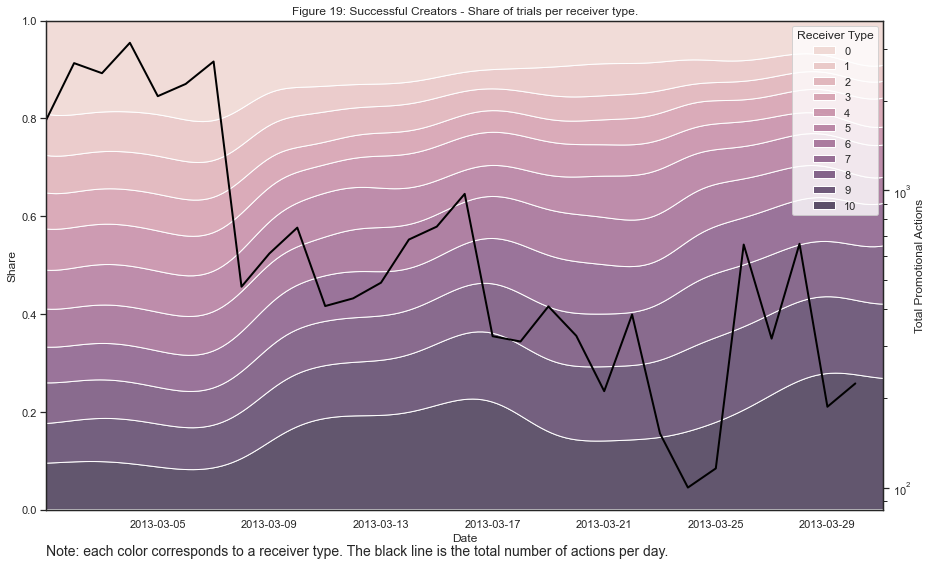

In [70]:
#mask = successful_creators_receiver_memb['Receiver Type'] != 0 
plot_learning(successful_creators_receiver_memb, 19, 'Successful Creators')

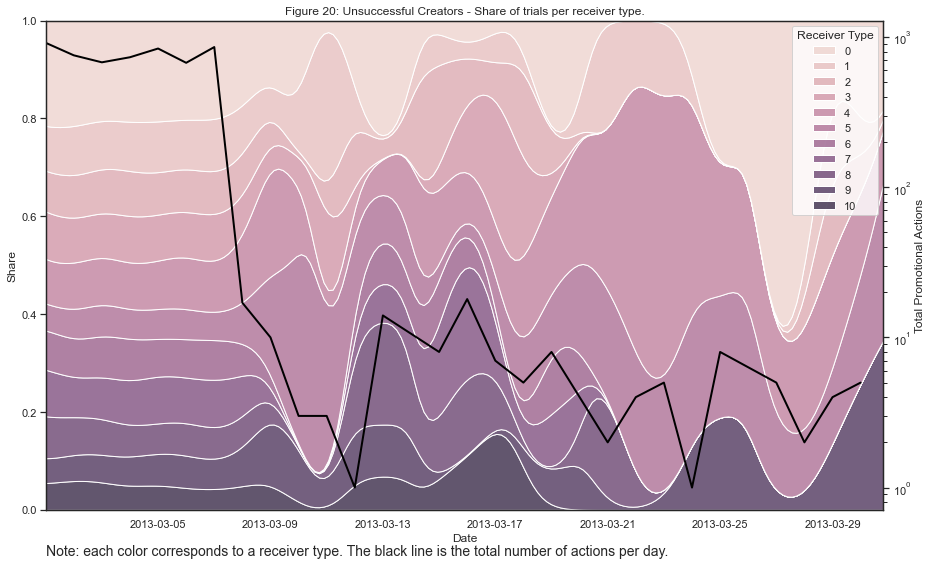

In [71]:
#mask = unsuccessful_creators_receiver_memb['Receiver Type'] != 0
plot_learning(unsuccessful_creators_receiver_memb, 20, 'Unsuccessful Creators')


In [ ]:
actions_sent_non_followers.groupby('week_yr_date', as_index=False).size()['size'].plot()

In [ ]:
outdegree_df = data
date_l = min(successful_df.date_sent)
old_outdegree = outdegree_df.iloc[:
                  outdegree_df.index.values.searchsorted(np.datetime64(date_l))].groupby('sender_id', as_index = False).size()
old_outdegree = user_info_2.merge(old_outdegree, left_on = 'user_id', right_on = 'sender_id', how= 'left')
old_outdegree.loc[old_outdegree['size'].isnull(), 'size'] = 0 
old_outdegree = old_outdegree[['user_id', 'size', 'entered_platform']].set_index('user_id')   


In [ ]:
mask = (old_outdegree['size']>0)
old_outdegree.loc[~mask, 'decile'] = 0 

In [ ]:
old_outdegree

In [ ]:
mask = (old_outdegree['entered_platform'] <= date_l)

In [ ]:
x=create_deciles(old_outdegree[mask])

In [ ]:
x